In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import math


import matplotlib.pyplot as plt



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# building_id
#columns = X.columns
data_train = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [4]:
data = data_train.append(X_test, ignore_index=True, sort=False)
data = data.drop(['building_id'], axis=1)
print(data.isnull().values.any())

True


In [ ]:
data.fillna(data.median(), inplace=True)
columns = data.columns
sale_price = data['total_price']
data.isnull().values.any()

False

In [ ]:
scaler = MinMaxScaler()
scaling_data = scaler.fit_transform(data)
data = pd.DataFrame(scaling_data, columns = columns)
data['total_price'] = sale_price
data.head()

/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


building_material      city    txn_dt  total_floor  building_type  \
0                0.7  1.000000  0.220133     0.107143           0.75   
1                0.7  0.222222  0.269487     0.142857           0.25   
2                0.7  0.222222  0.461026     0.107143           0.25   
3                0.7  1.000000  0.890325     0.821429           0.00   
4                0.0  1.000000  0.996866     0.035714           1.00   

   building_use  building_complete_dt  parking_way  parking_area  \
0           0.2              0.300577          1.0      0.005952   
1           0.2              0.379486          1.0      0.005952   
2           0.2              0.288697          1.0      0.005952   
3           0.2              0.889899          0.0      0.005952   
4           0.2              0.330351          1.0      0.005952   

   parking_price  ...   XIV_500  XIV_index_500  XIV_1000  XIV_index_1000  \
0       0.042916  ...  0.034503            1.0  0.045336             1.0   
1       0.042916  ...  0.016657            1.0  0.033208             1.0   
2       0.042916  ...  0.046401            1.0  0.061219             1.0   
3       0.079516  ...  0.011898            1.0  0.036096             1.0   
4       0.042916  ...  0.010708            1.0  0.013572             1.0   

   XIV_5000  XIV_index_5000  XIV_10000  XIV_index_10000   XIV_MIN  \
0  0.135021             0.0   0.181915              0.0  0.031126   
1  0.868705             0.0   0.979105              0.0  0.036191   
2  0.862568             0.0   0.979317              0.0  0.049197   
3  0.139679             0.0   0.220238              0.0  0.090022   
4  0.140720             0.0   0.225440              0.0  0.112169   

    total_price  
0  6.476038e+05  
1  3.321452e+06  
2  9.570885e+06  
3  1.421501e+07  
4  7.627120e+05  

[5 rows x 234 columns]

In [ ]:
train = data.iloc[:60000]
test  = data.iloc[60000:]
test.drop('total_price', axis=1, inplace=True)

/home/islab/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
# y scaling
y = train['total_price']
scaling_y = scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('total_price', axis=1), train['total_price'], test_size=0.3, random_state=42)



In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        
        '''
        self.fc1 = nn.Linear(233, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        '''
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
        
## takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: 
            torch.nn.init.zeros_(m.bias)

In [ ]:
def batch_training(X_train, y_train):
    train_batch = np.array_split(X_train, 200)
    label_batch = np.array_split(y_train, 200)

    for i in range(len(train_batch)):
        train_batch[i] = torch.from_numpy(train_batch[i].values).float().to(device)
    for i in range(len(label_batch)):
        label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1).to(device)
    return train_batch, label_batch

#train_batch = torch.from_numpy(X_train.values).float().to(device)
#label_batch = torch.from_numpy(y_train).float().view(-1, 1).to(device)
train_batch, label_batch = batch_training(X_train, y_train)

In [ ]:
X_val = torch.from_numpy(X_val.values).float().to(device)
y_val = torch.from_numpy(y_val.values).float().view(-1, 1).to(device)

In [ ]:
def MSE(y_pred, y):
    err = []
    for i in range(len(y_pred)):
        err.append(math.log(y[i]) - math.log(y_pred[i]))

    squaredError = []
    for val in err:
        squaredError.append(val * val)
    
    print("MSE = ", math.sqrt(sum(squaredError) / len(squaredError)))#均方误差MSE

In [ ]:

model = Regressor().to(device)
#model.apply(weights_init)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.01)

epochs = 100000
train_losses, test_losses = [], []

for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        #loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        loss = torch.sqrt(criterion(output, label_batch[i]))
        loss.backward()
        optimizer.step()
                
        train_loss += loss.item()
        
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            #test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
            test_loss += torch.sqrt(criterion(predictions, y_val))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.5f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.3f}.. ".format(test_loss))
        


Epoch: 1/100000..  Training Loss: 36604830.72000..  Test Loss: 56613416.000.. 
Epoch: 2/100000..  Training Loss: 35261414.02000..  Test Loss: 56041232.000.. 
Epoch: 3/100000..  Training Loss: 34368990.64000..  Test Loss: 55459648.000.. 
Epoch: 4/100000..  Training Loss: 33478279.22500..  Test Loss: 54899736.000.. 
Epoch: 5/100000..  Training Loss: 32960666.87500..  Test Loss: 54412160.000.. 
Epoch: 6/100000..  Training Loss: 32512827.87500..  Test Loss: 53917848.000.. 
Epoch: 7/100000..  Training Loss: 31997811.05000..  Test Loss: 53504832.000.. 
Epoch: 8/100000..  Training Loss: 31682330.49500..  Test Loss: 53182152.000.. 
Epoch: 9/100000..  Training Loss: 31302327.41500..  Test Loss: 52937352.000.. 
Epoch: 10/100000..  Training Loss: 30946443.68750..  Test Loss: 52626760.000.. 
Epoch: 11/100000..  Training Loss: 30559016.74250..  Test Loss: 52033944.000.. 
Epoch: 12/100000..  Training Loss: 30130937.56500..  Test Loss: 51723960.000.. 
Epoch: 13/100000..  Training Loss: 29667237.25250

Epoch: 104/100000..  Training Loss: 17616396.55750..  Test Loss: 42859064.000.. 
Epoch: 105/100000..  Training Loss: 17333953.36500..  Test Loss: 43075796.000.. 
Epoch: 106/100000..  Training Loss: 18297299.31500..  Test Loss: 43264064.000.. 
Epoch: 107/100000..  Training Loss: 18090943.64750..  Test Loss: 43551896.000.. 
Epoch: 108/100000..  Training Loss: 18214189.81250..  Test Loss: 42770844.000.. 
Epoch: 109/100000..  Training Loss: 17173428.15500..  Test Loss: 43425204.000.. 
Epoch: 110/100000..  Training Loss: 18285258.15750..  Test Loss: 43674272.000.. 
Epoch: 111/100000..  Training Loss: 16437238.06750..  Test Loss: 43095492.000.. 
Epoch: 112/100000..  Training Loss: 16761801.38000..  Test Loss: 43420396.000.. 
Epoch: 113/100000..  Training Loss: 17147158.24750..  Test Loss: 43520880.000.. 
Epoch: 114/100000..  Training Loss: 18139785.84500..  Test Loss: 43362868.000.. 
Epoch: 115/100000..  Training Loss: 17804137.74750..  Test Loss: 44245044.000.. 
Epoch: 116/100000..  Trainin

Epoch: 206/100000..  Training Loss: 16195367.60750..  Test Loss: 45083940.000.. 
Epoch: 207/100000..  Training Loss: 15769476.06250..  Test Loss: 45389380.000.. 
Epoch: 208/100000..  Training Loss: 15749738.26500..  Test Loss: 46280060.000.. 
Epoch: 209/100000..  Training Loss: 16327346.92250..  Test Loss: 46080828.000.. 
Epoch: 210/100000..  Training Loss: 16393857.98000..  Test Loss: 45972224.000.. 
Epoch: 211/100000..  Training Loss: 16275640.30500..  Test Loss: 45965876.000.. 
Epoch: 212/100000..  Training Loss: 16801497.29500..  Test Loss: 45766516.000.. 
Epoch: 213/100000..  Training Loss: 15549206.63000..  Test Loss: 45570892.000.. 
Epoch: 214/100000..  Training Loss: 15422726.52000..  Test Loss: 45824748.000.. 
Epoch: 215/100000..  Training Loss: 16220862.02250..  Test Loss: 46066796.000.. 
Epoch: 216/100000..  Training Loss: 14959878.26000..  Test Loss: 45345068.000.. 
Epoch: 217/100000..  Training Loss: 15845721.23750..  Test Loss: 45222448.000.. 
Epoch: 218/100000..  Trainin

Epoch: 308/100000..  Training Loss: 14772432.83500..  Test Loss: 45840824.000.. 
Epoch: 309/100000..  Training Loss: 15757801.27500..  Test Loss: 46328020.000.. 
Epoch: 310/100000..  Training Loss: 15228955.50500..  Test Loss: 46221260.000.. 
Epoch: 311/100000..  Training Loss: 15332988.27000..  Test Loss: 46459140.000.. 
Epoch: 312/100000..  Training Loss: 15755695.02500..  Test Loss: 45901636.000.. 
Epoch: 313/100000..  Training Loss: 15372222.28250..  Test Loss: 46558472.000.. 
Epoch: 314/100000..  Training Loss: 16309537.28250..  Test Loss: 46540100.000.. 
Epoch: 315/100000..  Training Loss: 15122334.13000..  Test Loss: 46042196.000.. 
Epoch: 316/100000..  Training Loss: 14878051.82000..  Test Loss: 46902032.000.. 
Epoch: 317/100000..  Training Loss: 15557000.34250..  Test Loss: 46521940.000.. 
Epoch: 318/100000..  Training Loss: 15004989.73500..  Test Loss: 46088124.000.. 
Epoch: 319/100000..  Training Loss: 15173678.34750..  Test Loss: 46978508.000.. 
Epoch: 320/100000..  Trainin

Epoch: 410/100000..  Training Loss: 14672136.22250..  Test Loss: 46191032.000.. 
Epoch: 411/100000..  Training Loss: 14591266.39000..  Test Loss: 46846500.000.. 
Epoch: 412/100000..  Training Loss: 14238260.14000..  Test Loss: 46167276.000.. 
Epoch: 413/100000..  Training Loss: 15511433.62000..  Test Loss: 46933732.000.. 
Epoch: 414/100000..  Training Loss: 15845590.84250..  Test Loss: 46690416.000.. 
Epoch: 415/100000..  Training Loss: 14944376.73250..  Test Loss: 47077864.000.. 
Epoch: 416/100000..  Training Loss: 15382762.06000..  Test Loss: 46677744.000.. 
Epoch: 417/100000..  Training Loss: 15421897.55750..  Test Loss: 46911996.000.. 
Epoch: 418/100000..  Training Loss: 15368381.21500..  Test Loss: 46459716.000.. 
Epoch: 419/100000..  Training Loss: 16420468.29750..  Test Loss: 46291352.000.. 
Epoch: 420/100000..  Training Loss: 14439843.93500..  Test Loss: 46273088.000.. 
Epoch: 421/100000..  Training Loss: 14611245.18000..  Test Loss: 46309208.000.. 
Epoch: 422/100000..  Trainin

Epoch: 512/100000..  Training Loss: 15221265.42500..  Test Loss: 47644008.000.. 
Epoch: 513/100000..  Training Loss: 15220613.68750..  Test Loss: 47356892.000.. 
Epoch: 514/100000..  Training Loss: 14057355.58750..  Test Loss: 47650808.000.. 
Epoch: 515/100000..  Training Loss: 14282310.00750..  Test Loss: 47087464.000.. 
Epoch: 516/100000..  Training Loss: 15123969.57750..  Test Loss: 47467336.000.. 
Epoch: 517/100000..  Training Loss: 14338387.72250..  Test Loss: 47586704.000.. 
Epoch: 518/100000..  Training Loss: 15782845.07500..  Test Loss: 48412116.000.. 
Epoch: 519/100000..  Training Loss: 16491220.53500..  Test Loss: 47779996.000.. 
Epoch: 520/100000..  Training Loss: 14871135.66000..  Test Loss: 48406368.000.. 
Epoch: 521/100000..  Training Loss: 14944149.67250..  Test Loss: 48130352.000.. 
Epoch: 522/100000..  Training Loss: 14138702.52250..  Test Loss: 47884208.000.. 
Epoch: 523/100000..  Training Loss: 13859987.52250..  Test Loss: 48485944.000.. 
Epoch: 524/100000..  Trainin

Epoch: 614/100000..  Training Loss: 14440808.01500..  Test Loss: 46514408.000.. 
Epoch: 615/100000..  Training Loss: 14210153.87500..  Test Loss: 47148336.000.. 
Epoch: 616/100000..  Training Loss: 14163467.05000..  Test Loss: 47214196.000.. 
Epoch: 617/100000..  Training Loss: 13389555.86250..  Test Loss: 47924708.000.. 
Epoch: 618/100000..  Training Loss: 14627802.52000..  Test Loss: 47837700.000.. 
Epoch: 619/100000..  Training Loss: 14372797.61000..  Test Loss: 47565252.000.. 
Epoch: 620/100000..  Training Loss: 14777095.55750..  Test Loss: 47039884.000.. 
Epoch: 621/100000..  Training Loss: 15437077.78500..  Test Loss: 46880256.000.. 
Epoch: 622/100000..  Training Loss: 14186345.37250..  Test Loss: 47292668.000.. 
Epoch: 623/100000..  Training Loss: 13546023.35500..  Test Loss: 47146176.000.. 
Epoch: 624/100000..  Training Loss: 14251537.55000..  Test Loss: 46848968.000.. 
Epoch: 625/100000..  Training Loss: 15081789.49500..  Test Loss: 46373376.000.. 
Epoch: 626/100000..  Trainin

Epoch: 716/100000..  Training Loss: 14178120.66750..  Test Loss: 45873308.000.. 
Epoch: 717/100000..  Training Loss: 14584245.95250..  Test Loss: 46919652.000.. 
Epoch: 718/100000..  Training Loss: 14706070.45500..  Test Loss: 46663464.000.. 
Epoch: 719/100000..  Training Loss: 13442774.88250..  Test Loss: 47266360.000.. 
Epoch: 720/100000..  Training Loss: 14070640.54000..  Test Loss: 46061644.000.. 
Epoch: 721/100000..  Training Loss: 13122453.94250..  Test Loss: 45603528.000.. 
Epoch: 722/100000..  Training Loss: 13546660.65500..  Test Loss: 46390304.000.. 
Epoch: 723/100000..  Training Loss: 13956199.93500..  Test Loss: 46911760.000.. 
Epoch: 724/100000..  Training Loss: 14573549.42000..  Test Loss: 46330088.000.. 
Epoch: 725/100000..  Training Loss: 13910398.05500..  Test Loss: 46538092.000.. 
Epoch: 726/100000..  Training Loss: 15033917.47250..  Test Loss: 46840860.000.. 
Epoch: 727/100000..  Training Loss: 14337681.08000..  Test Loss: 46146524.000.. 
Epoch: 728/100000..  Trainin

Epoch: 818/100000..  Training Loss: 13848694.60750..  Test Loss: 45593628.000.. 
Epoch: 819/100000..  Training Loss: 12840429.81250..  Test Loss: 45942404.000.. 
Epoch: 820/100000..  Training Loss: 13661093.82750..  Test Loss: 45475364.000.. 
Epoch: 821/100000..  Training Loss: 13128435.23000..  Test Loss: 45574332.000.. 
Epoch: 822/100000..  Training Loss: 13266634.32250..  Test Loss: 45315372.000.. 
Epoch: 823/100000..  Training Loss: 13518822.46750..  Test Loss: 45017004.000.. 
Epoch: 824/100000..  Training Loss: 14083583.85000..  Test Loss: 45222320.000.. 
Epoch: 825/100000..  Training Loss: 15435928.15250..  Test Loss: 45591788.000.. 
Epoch: 826/100000..  Training Loss: 15259388.35750..  Test Loss: 45126316.000.. 
Epoch: 827/100000..  Training Loss: 13548570.83500..  Test Loss: 44362404.000.. 
Epoch: 828/100000..  Training Loss: 14830112.77500..  Test Loss: 44465056.000.. 
Epoch: 829/100000..  Training Loss: 13615435.98250..  Test Loss: 44455260.000.. 
Epoch: 830/100000..  Trainin

Epoch: 920/100000..  Training Loss: 13850538.56750..  Test Loss: 44518660.000.. 
Epoch: 921/100000..  Training Loss: 12657627.38750..  Test Loss: 43507480.000.. 
Epoch: 922/100000..  Training Loss: 13948115.41000..  Test Loss: 43995504.000.. 
Epoch: 923/100000..  Training Loss: 13903062.23750..  Test Loss: 43677456.000.. 
Epoch: 924/100000..  Training Loss: 13800795.90750..  Test Loss: 43988372.000.. 
Epoch: 925/100000..  Training Loss: 14257387.83000..  Test Loss: 44147456.000.. 
Epoch: 926/100000..  Training Loss: 13251556.95000..  Test Loss: 44484736.000.. 
Epoch: 927/100000..  Training Loss: 14990854.58500..  Test Loss: 43842540.000.. 
Epoch: 928/100000..  Training Loss: 13881596.25500..  Test Loss: 44379704.000.. 
Epoch: 929/100000..  Training Loss: 13298347.94250..  Test Loss: 43488016.000.. 
Epoch: 930/100000..  Training Loss: 13598960.38750..  Test Loss: 44360676.000.. 
Epoch: 931/100000..  Training Loss: 14656853.04250..  Test Loss: 43642212.000.. 
Epoch: 932/100000..  Trainin

Epoch: 1021/100000..  Training Loss: 13846241.84750..  Test Loss: 44125812.000.. 
Epoch: 1022/100000..  Training Loss: 14074141.26250..  Test Loss: 43587724.000.. 
Epoch: 1023/100000..  Training Loss: 12871390.09500..  Test Loss: 43002268.000.. 
Epoch: 1024/100000..  Training Loss: 12800305.13250..  Test Loss: 43462248.000.. 
Epoch: 1025/100000..  Training Loss: 13969000.39750..  Test Loss: 43420952.000.. 
Epoch: 1026/100000..  Training Loss: 14311358.37750..  Test Loss: 43241804.000.. 
Epoch: 1027/100000..  Training Loss: 13628282.05250..  Test Loss: 43640012.000.. 
Epoch: 1028/100000..  Training Loss: 12713277.05250..  Test Loss: 43399912.000.. 
Epoch: 1029/100000..  Training Loss: 12688469.44000..  Test Loss: 43051052.000.. 
Epoch: 1030/100000..  Training Loss: 13122546.69250..  Test Loss: 43300024.000.. 
Epoch: 1031/100000..  Training Loss: 14423982.89250..  Test Loss: 43762296.000.. 
Epoch: 1032/100000..  Training Loss: 12708672.77500..  Test Loss: 43515748.000.. 
Epoch: 1033/1000

Epoch: 1121/100000..  Training Loss: 12688517.99000..  Test Loss: 42142356.000.. 
Epoch: 1122/100000..  Training Loss: 13812193.23500..  Test Loss: 42043312.000.. 
Epoch: 1123/100000..  Training Loss: 12567321.49250..  Test Loss: 42735348.000.. 
Epoch: 1124/100000..  Training Loss: 13645083.45875..  Test Loss: 41705612.000.. 
Epoch: 1125/100000..  Training Loss: 12648262.32500..  Test Loss: 42439168.000.. 
Epoch: 1126/100000..  Training Loss: 13278819.51750..  Test Loss: 41625944.000.. 
Epoch: 1127/100000..  Training Loss: 13106836.28750..  Test Loss: 41338864.000.. 
Epoch: 1128/100000..  Training Loss: 13405110.81750..  Test Loss: 41855196.000.. 
Epoch: 1129/100000..  Training Loss: 14127116.55250..  Test Loss: 41397500.000.. 
Epoch: 1130/100000..  Training Loss: 12875563.85500..  Test Loss: 41318068.000.. 
Epoch: 1131/100000..  Training Loss: 13295173.83000..  Test Loss: 41736900.000.. 
Epoch: 1132/100000..  Training Loss: 12936045.54750..  Test Loss: 42005852.000.. 
Epoch: 1133/1000

Epoch: 1221/100000..  Training Loss: 12926758.53250..  Test Loss: 40858712.000.. 
Epoch: 1222/100000..  Training Loss: 12911950.51250..  Test Loss: 41451256.000.. 
Epoch: 1223/100000..  Training Loss: 13492594.74500..  Test Loss: 41276180.000.. 
Epoch: 1224/100000..  Training Loss: 13205563.18000..  Test Loss: 41258484.000.. 
Epoch: 1225/100000..  Training Loss: 12607964.44750..  Test Loss: 40550852.000.. 
Epoch: 1226/100000..  Training Loss: 13720151.50500..  Test Loss: 41412400.000.. 
Epoch: 1227/100000..  Training Loss: 14311584.97000..  Test Loss: 41172792.000.. 
Epoch: 1228/100000..  Training Loss: 12708624.50000..  Test Loss: 41158704.000.. 
Epoch: 1229/100000..  Training Loss: 13692675.13000..  Test Loss: 40685888.000.. 
Epoch: 1230/100000..  Training Loss: 13500400.86500..  Test Loss: 41464520.000.. 
Epoch: 1231/100000..  Training Loss: 13625997.75250..  Test Loss: 41565104.000.. 
Epoch: 1232/100000..  Training Loss: 13449777.62750..  Test Loss: 40595848.000.. 
Epoch: 1233/1000

Epoch: 1321/100000..  Training Loss: 13280542.39250..  Test Loss: 41342832.000.. 
Epoch: 1322/100000..  Training Loss: 12565772.82250..  Test Loss: 41523308.000.. 
Epoch: 1323/100000..  Training Loss: 11912182.38500..  Test Loss: 41303692.000.. 
Epoch: 1324/100000..  Training Loss: 13183503.38000..  Test Loss: 40671548.000.. 
Epoch: 1325/100000..  Training Loss: 13031541.84250..  Test Loss: 40838820.000.. 
Epoch: 1326/100000..  Training Loss: 11828374.85500..  Test Loss: 41215944.000.. 
Epoch: 1327/100000..  Training Loss: 13274983.64000..  Test Loss: 41392764.000.. 
Epoch: 1328/100000..  Training Loss: 11582546.74500..  Test Loss: 41325592.000.. 
Epoch: 1329/100000..  Training Loss: 12340514.19250..  Test Loss: 41867692.000.. 
Epoch: 1330/100000..  Training Loss: 13503245.73250..  Test Loss: 41645112.000.. 
Epoch: 1331/100000..  Training Loss: 12941588.13750..  Test Loss: 40557652.000.. 
Epoch: 1332/100000..  Training Loss: 12745229.62250..  Test Loss: 40929716.000.. 
Epoch: 1333/1000

Epoch: 1421/100000..  Training Loss: 12786592.60000..  Test Loss: 40931896.000.. 
Epoch: 1422/100000..  Training Loss: 12695440.43750..  Test Loss: 40911348.000.. 
Epoch: 1423/100000..  Training Loss: 12513518.75500..  Test Loss: 40648376.000.. 
Epoch: 1424/100000..  Training Loss: 12722810.00250..  Test Loss: 41233968.000.. 
Epoch: 1425/100000..  Training Loss: 12769730.43250..  Test Loss: 41032936.000.. 
Epoch: 1426/100000..  Training Loss: 13065703.09250..  Test Loss: 40915260.000.. 
Epoch: 1427/100000..  Training Loss: 11741774.85500..  Test Loss: 41086932.000.. 
Epoch: 1428/100000..  Training Loss: 12542338.62000..  Test Loss: 41362016.000.. 
Epoch: 1429/100000..  Training Loss: 12011799.74250..  Test Loss: 40868004.000.. 
Epoch: 1430/100000..  Training Loss: 11899560.37000..  Test Loss: 40880708.000.. 
Epoch: 1431/100000..  Training Loss: 14154125.79250..  Test Loss: 41274568.000.. 
Epoch: 1432/100000..  Training Loss: 12127238.00250..  Test Loss: 40988652.000.. 
Epoch: 1433/1000

Epoch: 1521/100000..  Training Loss: 12997675.40250..  Test Loss: 40570376.000.. 
Epoch: 1522/100000..  Training Loss: 13316103.43250..  Test Loss: 40229056.000.. 
Epoch: 1523/100000..  Training Loss: 12508101.63500..  Test Loss: 40488304.000.. 
Epoch: 1524/100000..  Training Loss: 12481332.05500..  Test Loss: 40510936.000.. 
Epoch: 1525/100000..  Training Loss: 12315425.80750..  Test Loss: 40381352.000.. 
Epoch: 1526/100000..  Training Loss: 11755531.19500..  Test Loss: 40368804.000.. 
Epoch: 1527/100000..  Training Loss: 11856984.10750..  Test Loss: 40257524.000.. 
Epoch: 1528/100000..  Training Loss: 14011144.42000..  Test Loss: 40787344.000.. 
Epoch: 1529/100000..  Training Loss: 12633340.15500..  Test Loss: 41501772.000.. 
Epoch: 1530/100000..  Training Loss: 13144250.20375..  Test Loss: 40121900.000.. 
Epoch: 1531/100000..  Training Loss: 13585858.83250..  Test Loss: 41086620.000.. 
Epoch: 1532/100000..  Training Loss: 12972351.20000..  Test Loss: 40612336.000.. 
Epoch: 1533/1000

Epoch: 1621/100000..  Training Loss: 12645871.52000..  Test Loss: 39834044.000.. 
Epoch: 1622/100000..  Training Loss: 13090473.91500..  Test Loss: 40355172.000.. 
Epoch: 1623/100000..  Training Loss: 11396228.10750..  Test Loss: 40319564.000.. 
Epoch: 1624/100000..  Training Loss: 11812871.45750..  Test Loss: 40213816.000.. 
Epoch: 1625/100000..  Training Loss: 12481202.70250..  Test Loss: 40659960.000.. 
Epoch: 1626/100000..  Training Loss: 13701323.15250..  Test Loss: 40800012.000.. 
Epoch: 1627/100000..  Training Loss: 11927711.47500..  Test Loss: 40789120.000.. 
Epoch: 1628/100000..  Training Loss: 11170626.08250..  Test Loss: 40444028.000.. 
Epoch: 1629/100000..  Training Loss: 11680874.49250..  Test Loss: 40482024.000.. 
Epoch: 1630/100000..  Training Loss: 12800440.98250..  Test Loss: 40038460.000.. 
Epoch: 1631/100000..  Training Loss: 12710437.28000..  Test Loss: 40680268.000.. 
Epoch: 1632/100000..  Training Loss: 12813190.55500..  Test Loss: 40584180.000.. 
Epoch: 1633/1000

Epoch: 1721/100000..  Training Loss: 12625405.91000..  Test Loss: 39936972.000.. 
Epoch: 1722/100000..  Training Loss: 12401395.36000..  Test Loss: 40321988.000.. 
Epoch: 1723/100000..  Training Loss: 12243263.98000..  Test Loss: 39783296.000.. 
Epoch: 1724/100000..  Training Loss: 13290409.97750..  Test Loss: 40583000.000.. 
Epoch: 1725/100000..  Training Loss: 12180112.57250..  Test Loss: 40094808.000.. 
Epoch: 1726/100000..  Training Loss: 12046578.49750..  Test Loss: 41395432.000.. 
Epoch: 1727/100000..  Training Loss: 12305002.45250..  Test Loss: 40611500.000.. 
Epoch: 1728/100000..  Training Loss: 10979592.86500..  Test Loss: 40676928.000.. 
Epoch: 1729/100000..  Training Loss: 13065706.81250..  Test Loss: 40618476.000.. 
Epoch: 1730/100000..  Training Loss: 11825353.98500..  Test Loss: 40910348.000.. 
Epoch: 1731/100000..  Training Loss: 12494441.45000..  Test Loss: 40813280.000.. 
Epoch: 1732/100000..  Training Loss: 12997838.28750..  Test Loss: 40174508.000.. 
Epoch: 1733/1000

Epoch: 1821/100000..  Training Loss: 12060169.31750..  Test Loss: 40291612.000.. 
Epoch: 1822/100000..  Training Loss: 13257563.28000..  Test Loss: 39786976.000.. 
Epoch: 1823/100000..  Training Loss: 13475155.18250..  Test Loss: 40245092.000.. 
Epoch: 1824/100000..  Training Loss: 13382129.11500..  Test Loss: 40432428.000.. 
Epoch: 1825/100000..  Training Loss: 13789498.04250..  Test Loss: 40211480.000.. 
Epoch: 1826/100000..  Training Loss: 12822949.45750..  Test Loss: 40743736.000.. 
Epoch: 1827/100000..  Training Loss: 13578676.34750..  Test Loss: 40083964.000.. 
Epoch: 1828/100000..  Training Loss: 12342922.06500..  Test Loss: 40559564.000.. 
Epoch: 1829/100000..  Training Loss: 14110920.68500..  Test Loss: 40584084.000.. 
Epoch: 1830/100000..  Training Loss: 12050845.96500..  Test Loss: 40587540.000.. 
Epoch: 1831/100000..  Training Loss: 12867035.41250..  Test Loss: 40096024.000.. 
Epoch: 1832/100000..  Training Loss: 12387373.92250..  Test Loss: 40749664.000.. 
Epoch: 1833/1000

Epoch: 1921/100000..  Training Loss: 12262568.00500..  Test Loss: 40164908.000.. 
Epoch: 1922/100000..  Training Loss: 11766592.01750..  Test Loss: 40887284.000.. 
Epoch: 1923/100000..  Training Loss: 12241051.63250..  Test Loss: 40576328.000.. 
Epoch: 1924/100000..  Training Loss: 11811270.47000..  Test Loss: 40284344.000.. 
Epoch: 1925/100000..  Training Loss: 11431612.67750..  Test Loss: 40375524.000.. 
Epoch: 1926/100000..  Training Loss: 12160841.55750..  Test Loss: 39692920.000.. 
Epoch: 1927/100000..  Training Loss: 11684818.12000..  Test Loss: 40171612.000.. 
Epoch: 1928/100000..  Training Loss: 11892512.55000..  Test Loss: 39975820.000.. 
Epoch: 1929/100000..  Training Loss: 13146711.35250..  Test Loss: 39822344.000.. 
Epoch: 1930/100000..  Training Loss: 11242014.35750..  Test Loss: 39943944.000.. 
Epoch: 1931/100000..  Training Loss: 13234361.43875..  Test Loss: 40329656.000.. 
Epoch: 1932/100000..  Training Loss: 12567185.81500..  Test Loss: 40489740.000.. 
Epoch: 1933/1000

Epoch: 2021/100000..  Training Loss: 12415076.06750..  Test Loss: 41166144.000.. 
Epoch: 2022/100000..  Training Loss: 12869643.81500..  Test Loss: 40505512.000.. 
Epoch: 2023/100000..  Training Loss: 12233720.02500..  Test Loss: 40550100.000.. 
Epoch: 2024/100000..  Training Loss: 11020809.58750..  Test Loss: 40142524.000.. 
Epoch: 2025/100000..  Training Loss: 12368336.80750..  Test Loss: 40474008.000.. 
Epoch: 2026/100000..  Training Loss: 11702755.57500..  Test Loss: 40871304.000.. 
Epoch: 2027/100000..  Training Loss: 12089868.71000..  Test Loss: 40401340.000.. 
Epoch: 2028/100000..  Training Loss: 11791775.98500..  Test Loss: 40279484.000.. 
Epoch: 2029/100000..  Training Loss: 10973358.72375..  Test Loss: 40380352.000.. 
Epoch: 2030/100000..  Training Loss: 12589836.24250..  Test Loss: 40651136.000.. 
Epoch: 2031/100000..  Training Loss: 12683279.21500..  Test Loss: 40333436.000.. 
Epoch: 2032/100000..  Training Loss: 12342742.62250..  Test Loss: 39865420.000.. 
Epoch: 2033/1000

Epoch: 2121/100000..  Training Loss: 11816447.30750..  Test Loss: 39647168.000.. 
Epoch: 2122/100000..  Training Loss: 11411726.38500..  Test Loss: 40176988.000.. 
Epoch: 2123/100000..  Training Loss: 10548659.99500..  Test Loss: 40428188.000.. 
Epoch: 2124/100000..  Training Loss: 11718857.75500..  Test Loss: 40832132.000.. 
Epoch: 2125/100000..  Training Loss: 11520887.86750..  Test Loss: 40374236.000.. 
Epoch: 2126/100000..  Training Loss: 11319115.39000..  Test Loss: 40329292.000.. 
Epoch: 2127/100000..  Training Loss: 12034176.58250..  Test Loss: 40471536.000.. 
Epoch: 2128/100000..  Training Loss: 13072881.88000..  Test Loss: 39834116.000.. 
Epoch: 2129/100000..  Training Loss: 12472452.19750..  Test Loss: 40028536.000.. 
Epoch: 2130/100000..  Training Loss: 11374662.64750..  Test Loss: 39542252.000.. 
Epoch: 2131/100000..  Training Loss: 11713763.04250..  Test Loss: 39976720.000.. 
Epoch: 2132/100000..  Training Loss: 12039503.01000..  Test Loss: 40132664.000.. 
Epoch: 2133/1000

Epoch: 2221/100000..  Training Loss: 12465894.38750..  Test Loss: 39745604.000.. 
Epoch: 2222/100000..  Training Loss: 11429930.44000..  Test Loss: 40792868.000.. 
Epoch: 2223/100000..  Training Loss: 11780717.24000..  Test Loss: 40429028.000.. 
Epoch: 2224/100000..  Training Loss: 11395935.14250..  Test Loss: 40333084.000.. 
Epoch: 2225/100000..  Training Loss: 11156724.73500..  Test Loss: 40472760.000.. 
Epoch: 2226/100000..  Training Loss: 11956223.67750..  Test Loss: 40343652.000.. 
Epoch: 2227/100000..  Training Loss: 11834902.81250..  Test Loss: 40961392.000.. 
Epoch: 2228/100000..  Training Loss: 12908761.09000..  Test Loss: 40814040.000.. 
Epoch: 2229/100000..  Training Loss: 11327228.16500..  Test Loss: 40495252.000.. 
Epoch: 2230/100000..  Training Loss: 11982613.50250..  Test Loss: 39752004.000.. 
Epoch: 2231/100000..  Training Loss: 11791275.41750..  Test Loss: 39643584.000.. 
Epoch: 2232/100000..  Training Loss: 12167217.25750..  Test Loss: 39689944.000.. 
Epoch: 2233/1000

Epoch: 2321/100000..  Training Loss: 11483197.00750..  Test Loss: 40234580.000.. 
Epoch: 2322/100000..  Training Loss: 11892470.27750..  Test Loss: 40725616.000.. 
Epoch: 2323/100000..  Training Loss: 11284016.99750..  Test Loss: 40368168.000.. 
Epoch: 2324/100000..  Training Loss: 11438365.30625..  Test Loss: 39771444.000.. 
Epoch: 2325/100000..  Training Loss: 10691943.50750..  Test Loss: 40209188.000.. 
Epoch: 2326/100000..  Training Loss: 13277880.16500..  Test Loss: 41015316.000.. 
Epoch: 2327/100000..  Training Loss: 11354446.68500..  Test Loss: 39702016.000.. 
Epoch: 2328/100000..  Training Loss: 12349146.43000..  Test Loss: 40173628.000.. 
Epoch: 2329/100000..  Training Loss: 12274792.23750..  Test Loss: 39619176.000.. 
Epoch: 2330/100000..  Training Loss: 11422677.07000..  Test Loss: 40393112.000.. 
Epoch: 2331/100000..  Training Loss: 11932615.17250..  Test Loss: 39717936.000.. 
Epoch: 2332/100000..  Training Loss: 12351769.96000..  Test Loss: 40449324.000.. 
Epoch: 2333/1000

Epoch: 2421/100000..  Training Loss: 12056456.87750..  Test Loss: 39881212.000.. 
Epoch: 2422/100000..  Training Loss: 11591942.34250..  Test Loss: 40719368.000.. 
Epoch: 2423/100000..  Training Loss: 11796336.19750..  Test Loss: 40437924.000.. 
Epoch: 2424/100000..  Training Loss: 12226848.38250..  Test Loss: 39721744.000.. 
Epoch: 2425/100000..  Training Loss: 11244536.14750..  Test Loss: 39907248.000.. 
Epoch: 2426/100000..  Training Loss: 11461921.65000..  Test Loss: 39583900.000.. 
Epoch: 2427/100000..  Training Loss: 11801245.26500..  Test Loss: 40043708.000.. 
Epoch: 2428/100000..  Training Loss: 10839254.34875..  Test Loss: 40948080.000.. 
Epoch: 2429/100000..  Training Loss: 11108906.69750..  Test Loss: 40039848.000.. 
Epoch: 2430/100000..  Training Loss: 12130455.90000..  Test Loss: 40936856.000.. 
Epoch: 2431/100000..  Training Loss: 11194430.98750..  Test Loss: 40509544.000.. 
Epoch: 2432/100000..  Training Loss: 13351441.31250..  Test Loss: 41132320.000.. 
Epoch: 2433/1000

Epoch: 2521/100000..  Training Loss: 11149557.15000..  Test Loss: 40032484.000.. 
Epoch: 2522/100000..  Training Loss: 10661067.16500..  Test Loss: 40340576.000.. 
Epoch: 2523/100000..  Training Loss: 11098516.93500..  Test Loss: 39874804.000.. 
Epoch: 2524/100000..  Training Loss: 11607580.93250..  Test Loss: 40291164.000.. 
Epoch: 2525/100000..  Training Loss: 11991144.30000..  Test Loss: 39918948.000.. 
Epoch: 2526/100000..  Training Loss: 11682801.85250..  Test Loss: 40123348.000.. 
Epoch: 2527/100000..  Training Loss: 11149777.70750..  Test Loss: 40849920.000.. 
Epoch: 2528/100000..  Training Loss: 11607290.17250..  Test Loss: 40357136.000.. 
Epoch: 2529/100000..  Training Loss: 11263744.62500..  Test Loss: 40155848.000.. 
Epoch: 2530/100000..  Training Loss: 11004161.25000..  Test Loss: 40725404.000.. 
Epoch: 2531/100000..  Training Loss: 11618068.00250..  Test Loss: 40893500.000.. 
Epoch: 2532/100000..  Training Loss: 10796085.05000..  Test Loss: 40425300.000.. 
Epoch: 2533/1000

Epoch: 2621/100000..  Training Loss: 11914974.83250..  Test Loss: 39946820.000.. 
Epoch: 2622/100000..  Training Loss: 11304988.17000..  Test Loss: 40522172.000.. 
Epoch: 2623/100000..  Training Loss: 11934708.62250..  Test Loss: 40595216.000.. 
Epoch: 2624/100000..  Training Loss: 11180827.69625..  Test Loss: 39537928.000.. 
Epoch: 2625/100000..  Training Loss: 11143295.38250..  Test Loss: 40651972.000.. 
Epoch: 2626/100000..  Training Loss: 10827844.36250..  Test Loss: 40765384.000.. 
Epoch: 2627/100000..  Training Loss: 11403334.40750..  Test Loss: 40108856.000.. 
Epoch: 2628/100000..  Training Loss: 12586242.80750..  Test Loss: 39991168.000.. 
Epoch: 2629/100000..  Training Loss: 11186749.99750..  Test Loss: 40491376.000.. 
Epoch: 2630/100000..  Training Loss: 10895076.42500..  Test Loss: 40556736.000.. 
Epoch: 2631/100000..  Training Loss: 10893492.98250..  Test Loss: 40116092.000.. 
Epoch: 2632/100000..  Training Loss: 12916528.67000..  Test Loss: 40930696.000.. 
Epoch: 2633/1000

Epoch: 2721/100000..  Training Loss: 12073287.79250..  Test Loss: 39843216.000.. 
Epoch: 2722/100000..  Training Loss: 11129870.83000..  Test Loss: 39701864.000.. 
Epoch: 2723/100000..  Training Loss: 11252350.15000..  Test Loss: 40623820.000.. 
Epoch: 2724/100000..  Training Loss: 11296205.07000..  Test Loss: 40631524.000.. 
Epoch: 2725/100000..  Training Loss: 11643982.09000..  Test Loss: 40354372.000.. 
Epoch: 2726/100000..  Training Loss: 11679562.78250..  Test Loss: 40343312.000.. 
Epoch: 2727/100000..  Training Loss: 12199089.53750..  Test Loss: 40238444.000.. 
Epoch: 2728/100000..  Training Loss: 10812280.25250..  Test Loss: 41714464.000.. 
Epoch: 2729/100000..  Training Loss: 11286410.92750..  Test Loss: 40503952.000.. 
Epoch: 2730/100000..  Training Loss: 11611763.96500..  Test Loss: 40702168.000.. 
Epoch: 2731/100000..  Training Loss: 11493304.13500..  Test Loss: 40656236.000.. 
Epoch: 2732/100000..  Training Loss: 10890425.98250..  Test Loss: 39999596.000.. 
Epoch: 2733/1000

Epoch: 2821/100000..  Training Loss: 11807367.29875..  Test Loss: 40471856.000.. 
Epoch: 2822/100000..  Training Loss: 10984429.47500..  Test Loss: 39874208.000.. 
Epoch: 2823/100000..  Training Loss: 11832181.55500..  Test Loss: 39633008.000.. 
Epoch: 2824/100000..  Training Loss: 11190263.56250..  Test Loss: 39758460.000.. 
Epoch: 2825/100000..  Training Loss: 12048253.57750..  Test Loss: 39829416.000.. 
Epoch: 2826/100000..  Training Loss: 11640853.97000..  Test Loss: 39916544.000.. 
Epoch: 2827/100000..  Training Loss: 12207059.90500..  Test Loss: 40565960.000.. 
Epoch: 2828/100000..  Training Loss: 11340244.09000..  Test Loss: 39415268.000.. 
Epoch: 2829/100000..  Training Loss: 11957472.28750..  Test Loss: 40154740.000.. 
Epoch: 2830/100000..  Training Loss: 11365670.06000..  Test Loss: 41449452.000.. 
Epoch: 2831/100000..  Training Loss: 11173079.07000..  Test Loss: 40679984.000.. 
Epoch: 2832/100000..  Training Loss: 11319860.11500..  Test Loss: 40232532.000.. 
Epoch: 2833/1000

Epoch: 2921/100000..  Training Loss: 11229801.30000..  Test Loss: 40346588.000.. 
Epoch: 2922/100000..  Training Loss: 10854614.43000..  Test Loss: 40146380.000.. 
Epoch: 2923/100000..  Training Loss: 11668949.93125..  Test Loss: 40919104.000.. 
Epoch: 2924/100000..  Training Loss: 10917105.48250..  Test Loss: 39842240.000.. 
Epoch: 2925/100000..  Training Loss: 11405663.20000..  Test Loss: 40603104.000.. 
Epoch: 2926/100000..  Training Loss: 10747088.04500..  Test Loss: 40543304.000.. 
Epoch: 2927/100000..  Training Loss: 11004026.22000..  Test Loss: 40468404.000.. 
Epoch: 2928/100000..  Training Loss: 10940010.06250..  Test Loss: 40898024.000.. 
Epoch: 2929/100000..  Training Loss: 11891805.61000..  Test Loss: 40727228.000.. 
Epoch: 2930/100000..  Training Loss: 10912249.31250..  Test Loss: 40121884.000.. 
Epoch: 2931/100000..  Training Loss: 11504419.88500..  Test Loss: 40578764.000.. 
Epoch: 2932/100000..  Training Loss: 12072776.54250..  Test Loss: 40220812.000.. 
Epoch: 2933/1000

Epoch: 3021/100000..  Training Loss: 10598354.98875..  Test Loss: 40217152.000.. 
Epoch: 3022/100000..  Training Loss: 11799517.65500..  Test Loss: 41293076.000.. 
Epoch: 3023/100000..  Training Loss: 12167839.21375..  Test Loss: 40608912.000.. 
Epoch: 3024/100000..  Training Loss: 11056935.90250..  Test Loss: 40228624.000.. 
Epoch: 3025/100000..  Training Loss: 12552722.85125..  Test Loss: 40189472.000.. 
Epoch: 3026/100000..  Training Loss: 10954510.05000..  Test Loss: 40595636.000.. 
Epoch: 3027/100000..  Training Loss: 10394605.67250..  Test Loss: 41057844.000.. 
Epoch: 3028/100000..  Training Loss: 11099300.47250..  Test Loss: 40098896.000.. 
Epoch: 3029/100000..  Training Loss: 11353019.51750..  Test Loss: 40114288.000.. 
Epoch: 3030/100000..  Training Loss: 11232571.04250..  Test Loss: 39825012.000.. 
Epoch: 3031/100000..  Training Loss: 10043745.79000..  Test Loss: 40087144.000.. 
Epoch: 3032/100000..  Training Loss: 11111848.09000..  Test Loss: 41149776.000.. 
Epoch: 3033/1000

Epoch: 3121/100000..  Training Loss: 11229165.08250..  Test Loss: 40268640.000.. 
Epoch: 3122/100000..  Training Loss: 10653427.48500..  Test Loss: 40501420.000.. 
Epoch: 3123/100000..  Training Loss: 11335312.85875..  Test Loss: 39969124.000.. 
Epoch: 3124/100000..  Training Loss: 11938477.87250..  Test Loss: 41042136.000.. 
Epoch: 3125/100000..  Training Loss: 10760008.22000..  Test Loss: 40572896.000.. 
Epoch: 3126/100000..  Training Loss: 11521560.25750..  Test Loss: 40197328.000.. 
Epoch: 3127/100000..  Training Loss: 10874810.94875..  Test Loss: 40561108.000.. 
Epoch: 3128/100000..  Training Loss: 11716096.59500..  Test Loss: 40645840.000.. 
Epoch: 3129/100000..  Training Loss: 10715672.81250..  Test Loss: 40081216.000.. 
Epoch: 3130/100000..  Training Loss: 11230036.56000..  Test Loss: 40381608.000.. 
Epoch: 3131/100000..  Training Loss: 11281995.14500..  Test Loss: 40431252.000.. 
Epoch: 3132/100000..  Training Loss: 10927813.00000..  Test Loss: 40133312.000.. 
Epoch: 3133/1000

Epoch: 3221/100000..  Training Loss: 11620501.17250..  Test Loss: 40375020.000.. 
Epoch: 3222/100000..  Training Loss: 11073387.09875..  Test Loss: 40392764.000.. 
Epoch: 3223/100000..  Training Loss: 11603059.96000..  Test Loss: 40458276.000.. 
Epoch: 3224/100000..  Training Loss: 11128771.89500..  Test Loss: 40393112.000.. 
Epoch: 3225/100000..  Training Loss: 10800240.44500..  Test Loss: 41044180.000.. 
Epoch: 3226/100000..  Training Loss: 11074972.81250..  Test Loss: 40541080.000.. 
Epoch: 3227/100000..  Training Loss: 11041158.30750..  Test Loss: 40272704.000.. 
Epoch: 3228/100000..  Training Loss: 11382521.44750..  Test Loss: 41049520.000.. 
Epoch: 3229/100000..  Training Loss: 11143689.97000..  Test Loss: 41163156.000.. 
Epoch: 3230/100000..  Training Loss: 10196618.50000..  Test Loss: 40185352.000.. 
Epoch: 3231/100000..  Training Loss: 11525490.67000..  Test Loss: 40798152.000.. 
Epoch: 3232/100000..  Training Loss: 10593949.17000..  Test Loss: 40843084.000.. 
Epoch: 3233/1000

Epoch: 3321/100000..  Training Loss: 10622074.92750..  Test Loss: 40376148.000.. 
Epoch: 3322/100000..  Training Loss: 10323071.25750..  Test Loss: 40626676.000.. 
Epoch: 3323/100000..  Training Loss: 11038860.32750..  Test Loss: 40366936.000.. 
Epoch: 3324/100000..  Training Loss: 11131623.02000..  Test Loss: 39895860.000.. 
Epoch: 3325/100000..  Training Loss: 12466528.85875..  Test Loss: 40226524.000.. 
Epoch: 3326/100000..  Training Loss: 10709548.25000..  Test Loss: 40135464.000.. 
Epoch: 3327/100000..  Training Loss: 11254526.72250..  Test Loss: 40233088.000.. 
Epoch: 3328/100000..  Training Loss: 11771214.84500..  Test Loss: 40456652.000.. 
Epoch: 3329/100000..  Training Loss: 11071258.17875..  Test Loss: 40217620.000.. 
Epoch: 3330/100000..  Training Loss: 11588734.65500..  Test Loss: 40664624.000.. 
Epoch: 3331/100000..  Training Loss: 11715791.45750..  Test Loss: 40274880.000.. 
Epoch: 3332/100000..  Training Loss: 10688201.51250..  Test Loss: 39822560.000.. 
Epoch: 3333/1000

Epoch: 3421/100000..  Training Loss: 13377926.81250..  Test Loss: 40177580.000.. 
Epoch: 3422/100000..  Training Loss: 11185503.22250..  Test Loss: 40989620.000.. 
Epoch: 3423/100000..  Training Loss: 10253203.58500..  Test Loss: 40657884.000.. 
Epoch: 3424/100000..  Training Loss: 10334416.74000..  Test Loss: 40451532.000.. 
Epoch: 3425/100000..  Training Loss: 10592165.23250..  Test Loss: 41094496.000.. 
Epoch: 3426/100000..  Training Loss: 11660634.79500..  Test Loss: 40241332.000.. 
Epoch: 3427/100000..  Training Loss: 11562405.99750..  Test Loss: 39861400.000.. 
Epoch: 3428/100000..  Training Loss: 10963563.82000..  Test Loss: 40387560.000.. 
Epoch: 3429/100000..  Training Loss: 10974992.15250..  Test Loss: 41051260.000.. 
Epoch: 3430/100000..  Training Loss: 11128601.45750..  Test Loss: 40503508.000.. 
Epoch: 3431/100000..  Training Loss: 10891435.38000..  Test Loss: 40911792.000.. 
Epoch: 3432/100000..  Training Loss: 11013689.82250..  Test Loss: 41098588.000.. 
Epoch: 3433/1000

Epoch: 3521/100000..  Training Loss: 10228523.70750..  Test Loss: 39866372.000.. 
Epoch: 3522/100000..  Training Loss: 10822097.87750..  Test Loss: 39659508.000.. 
Epoch: 3523/100000..  Training Loss: 11856963.13750..  Test Loss: 40030048.000.. 
Epoch: 3524/100000..  Training Loss: 10747228.75500..  Test Loss: 40404860.000.. 
Epoch: 3525/100000..  Training Loss: 10878820.79500..  Test Loss: 40139180.000.. 
Epoch: 3526/100000..  Training Loss: 11720338.86250..  Test Loss: 40227540.000.. 
Epoch: 3527/100000..  Training Loss: 10339309.14500..  Test Loss: 40280188.000.. 
Epoch: 3528/100000..  Training Loss: 11696999.61500..  Test Loss: 40035796.000.. 
Epoch: 3529/100000..  Training Loss: 10440728.68000..  Test Loss: 40156292.000.. 
Epoch: 3530/100000..  Training Loss: 10559943.77750..  Test Loss: 40189732.000.. 
Epoch: 3531/100000..  Training Loss: 10685203.17000..  Test Loss: 39895400.000.. 
Epoch: 3532/100000..  Training Loss: 10792947.66750..  Test Loss: 39853372.000.. 
Epoch: 3533/1000

Epoch: 3621/100000..  Training Loss: 11254327.02000..  Test Loss: 40140648.000.. 
Epoch: 3622/100000..  Training Loss: 10820894.11750..  Test Loss: 40012356.000.. 
Epoch: 3623/100000..  Training Loss: 10324425.49750..  Test Loss: 40923928.000.. 
Epoch: 3624/100000..  Training Loss: 10824220.63375..  Test Loss: 40963140.000.. 
Epoch: 3625/100000..  Training Loss: 12125360.38000..  Test Loss: 41135464.000.. 
Epoch: 3626/100000..  Training Loss: 10963731.61500..  Test Loss: 40342816.000.. 
Epoch: 3627/100000..  Training Loss: 10972646.42250..  Test Loss: 40320068.000.. 
Epoch: 3628/100000..  Training Loss: 10420923.29250..  Test Loss: 39931308.000.. 
Epoch: 3629/100000..  Training Loss: 10374896.74000..  Test Loss: 39770168.000.. 
Epoch: 3630/100000..  Training Loss: 11173426.16750..  Test Loss: 40273596.000.. 
Epoch: 3631/100000..  Training Loss: 11574003.04125..  Test Loss: 40217764.000.. 
Epoch: 3632/100000..  Training Loss: 10347372.63250..  Test Loss: 40061164.000.. 
Epoch: 3633/1000

Epoch: 3721/100000..  Training Loss: 11848561.79750..  Test Loss: 40182300.000.. 
Epoch: 3722/100000..  Training Loss: 10670431.19875..  Test Loss: 40685780.000.. 
Epoch: 3723/100000..  Training Loss: 10771971.05000..  Test Loss: 40359800.000.. 
Epoch: 3724/100000..  Training Loss: 10746716.99500..  Test Loss: 40640276.000.. 
Epoch: 3725/100000..  Training Loss: 11541996.40000..  Test Loss: 39998296.000.. 
Epoch: 3726/100000..  Training Loss: 11880292.30750..  Test Loss: 40662096.000.. 
Epoch: 3727/100000..  Training Loss: 10375559.78750..  Test Loss: 40537852.000.. 
Epoch: 3728/100000..  Training Loss: 10502735.26250..  Test Loss: 40172012.000.. 
Epoch: 3729/100000..  Training Loss: 10884873.94250..  Test Loss: 40569796.000.. 
Epoch: 3730/100000..  Training Loss: 10551781.08500..  Test Loss: 40325572.000.. 
Epoch: 3731/100000..  Training Loss: 10723405.22125..  Test Loss: 40046992.000.. 
Epoch: 3732/100000..  Training Loss: 11145309.29750..  Test Loss: 40675784.000.. 
Epoch: 3733/1000

Epoch: 3821/100000..  Training Loss: 11501203.16250..  Test Loss: 40337264.000.. 
Epoch: 3822/100000..  Training Loss: 11033088.89250..  Test Loss: 40104960.000.. 
Epoch: 3823/100000..  Training Loss: 10258727.74000..  Test Loss: 40811620.000.. 
Epoch: 3824/100000..  Training Loss: 10795146.60625..  Test Loss: 39679276.000.. 
Epoch: 3825/100000..  Training Loss: 11304353.65750..  Test Loss: 39875160.000.. 
Epoch: 3826/100000..  Training Loss: 9904429.47250..  Test Loss: 40096816.000.. 
Epoch: 3827/100000..  Training Loss: 10811407.60750..  Test Loss: 40207044.000.. 
Epoch: 3828/100000..  Training Loss: 11194879.79750..  Test Loss: 39640996.000.. 
Epoch: 3829/100000..  Training Loss: 11079861.36000..  Test Loss: 39993116.000.. 
Epoch: 3830/100000..  Training Loss: 11284051.82500..  Test Loss: 40899148.000.. 
Epoch: 3831/100000..  Training Loss: 10326234.31750..  Test Loss: 40082056.000.. 
Epoch: 3832/100000..  Training Loss: 11417109.71250..  Test Loss: 40064192.000.. 
Epoch: 3833/10000

Epoch: 3921/100000..  Training Loss: 10047761.04875..  Test Loss: 40118744.000.. 
Epoch: 3922/100000..  Training Loss: 10559794.17250..  Test Loss: 40533164.000.. 
Epoch: 3923/100000..  Training Loss: 11377363.41250..  Test Loss: 40889816.000.. 
Epoch: 3924/100000..  Training Loss: 9916005.20250..  Test Loss: 40280628.000.. 
Epoch: 3925/100000..  Training Loss: 10994612.20750..  Test Loss: 40716632.000.. 
Epoch: 3926/100000..  Training Loss: 9983935.29750..  Test Loss: 40534008.000.. 
Epoch: 3927/100000..  Training Loss: 10716630.96750..  Test Loss: 40461416.000.. 
Epoch: 3928/100000..  Training Loss: 10909707.11750..  Test Loss: 40295680.000.. 
Epoch: 3929/100000..  Training Loss: 10456637.65000..  Test Loss: 40915304.000.. 
Epoch: 3930/100000..  Training Loss: 10471620.13375..  Test Loss: 40181736.000.. 
Epoch: 3931/100000..  Training Loss: 10568920.37000..  Test Loss: 40574740.000.. 
Epoch: 3932/100000..  Training Loss: 10860711.85000..  Test Loss: 41487812.000.. 
Epoch: 3933/100000

Epoch: 4022/100000..  Training Loss: 10413650.17750..  Test Loss: 40173264.000.. 
Epoch: 4023/100000..  Training Loss: 10823718.58000..  Test Loss: 40327932.000.. 
Epoch: 4024/100000..  Training Loss: 10633181.37750..  Test Loss: 40422224.000.. 
Epoch: 4025/100000..  Training Loss: 10281612.19000..  Test Loss: 39627068.000.. 
Epoch: 4026/100000..  Training Loss: 11877895.75250..  Test Loss: 40101156.000.. 
Epoch: 4027/100000..  Training Loss: 11750877.07500..  Test Loss: 39527372.000.. 
Epoch: 4028/100000..  Training Loss: 10346660.06250..  Test Loss: 40192984.000.. 
Epoch: 4029/100000..  Training Loss: 10698103.41500..  Test Loss: 40840476.000.. 
Epoch: 4030/100000..  Training Loss: 10786072.10000..  Test Loss: 39817764.000.. 
Epoch: 4031/100000..  Training Loss: 10906882.71750..  Test Loss: 40466224.000.. 
Epoch: 4032/100000..  Training Loss: 11375594.85250..  Test Loss: 39964952.000.. 
Epoch: 4033/100000..  Training Loss: 10451865.15500..  Test Loss: 39980240.000.. 
Epoch: 4034/1000

Epoch: 4122/100000..  Training Loss: 10696922.49250..  Test Loss: 40710136.000.. 
Epoch: 4123/100000..  Training Loss: 10604930.47625..  Test Loss: 39523540.000.. 
Epoch: 4124/100000..  Training Loss: 10449514.63125..  Test Loss: 39599708.000.. 
Epoch: 4125/100000..  Training Loss: 10903580.15500..  Test Loss: 40036900.000.. 
Epoch: 4126/100000..  Training Loss: 10152667.38250..  Test Loss: 40419616.000.. 
Epoch: 4127/100000..  Training Loss: 10407380.59250..  Test Loss: 40479972.000.. 
Epoch: 4128/100000..  Training Loss: 10621722.90375..  Test Loss: 40259356.000.. 
Epoch: 4129/100000..  Training Loss: 10482835.86250..  Test Loss: 40685360.000.. 
Epoch: 4130/100000..  Training Loss: 10156175.70000..  Test Loss: 40226276.000.. 
Epoch: 4131/100000..  Training Loss: 10173827.28375..  Test Loss: 39596428.000.. 
Epoch: 4132/100000..  Training Loss: 10796073.89000..  Test Loss: 40127124.000.. 
Epoch: 4133/100000..  Training Loss: 11280833.37750..  Test Loss: 40699068.000.. 
Epoch: 4134/1000

Epoch: 4222/100000..  Training Loss: 10676205.53750..  Test Loss: 40397020.000.. 
Epoch: 4223/100000..  Training Loss: 11529989.35750..  Test Loss: 39731256.000.. 
Epoch: 4224/100000..  Training Loss: 10699500.78000..  Test Loss: 40251880.000.. 
Epoch: 4225/100000..  Training Loss: 10417270.10750..  Test Loss: 40543452.000.. 
Epoch: 4226/100000..  Training Loss: 10774226.02500..  Test Loss: 40880452.000.. 
Epoch: 4227/100000..  Training Loss: 10897872.62750..  Test Loss: 40176476.000.. 
Epoch: 4228/100000..  Training Loss: 12518983.91000..  Test Loss: 40177768.000.. 
Epoch: 4229/100000..  Training Loss: 10903116.56250..  Test Loss: 40005372.000.. 
Epoch: 4230/100000..  Training Loss: 11025734.81250..  Test Loss: 40388196.000.. 
Epoch: 4231/100000..  Training Loss: 10310378.76500..  Test Loss: 40177136.000.. 
Epoch: 4232/100000..  Training Loss: 10789605.90625..  Test Loss: 40091596.000.. 
Epoch: 4233/100000..  Training Loss: 10360851.22250..  Test Loss: 40542404.000.. 
Epoch: 4234/1000

Epoch: 4322/100000..  Training Loss: 10755031.73250..  Test Loss: 40704160.000.. 
Epoch: 4323/100000..  Training Loss: 9992638.07500..  Test Loss: 40342460.000.. 
Epoch: 4324/100000..  Training Loss: 10594945.84000..  Test Loss: 40722896.000.. 
Epoch: 4325/100000..  Training Loss: 11036717.22000..  Test Loss: 39485700.000.. 
Epoch: 4326/100000..  Training Loss: 11811425.19375..  Test Loss: 40425348.000.. 
Epoch: 4327/100000..  Training Loss: 10747671.67375..  Test Loss: 40131976.000.. 
Epoch: 4328/100000..  Training Loss: 10384712.94500..  Test Loss: 40658888.000.. 
Epoch: 4329/100000..  Training Loss: 10672786.27500..  Test Loss: 39889732.000.. 
Epoch: 4330/100000..  Training Loss: 10232981.38000..  Test Loss: 39912868.000.. 
Epoch: 4331/100000..  Training Loss: 10555110.42250..  Test Loss: 40795344.000.. 
Epoch: 4332/100000..  Training Loss: 10046535.67250..  Test Loss: 39950452.000.. 
Epoch: 4333/100000..  Training Loss: 10274444.09250..  Test Loss: 40201200.000.. 
Epoch: 4334/10000

Epoch: 4422/100000..  Training Loss: 9994209.00375..  Test Loss: 40112596.000.. 
Epoch: 4423/100000..  Training Loss: 11376306.42250..  Test Loss: 40027584.000.. 
Epoch: 4424/100000..  Training Loss: 10230753.96000..  Test Loss: 40903436.000.. 
Epoch: 4425/100000..  Training Loss: 11234324.64250..  Test Loss: 40224372.000.. 
Epoch: 4426/100000..  Training Loss: 10260964.21000..  Test Loss: 40365764.000.. 
Epoch: 4427/100000..  Training Loss: 10463852.12750..  Test Loss: 41066432.000.. 
Epoch: 4428/100000..  Training Loss: 11254450.17750..  Test Loss: 40762044.000.. 
Epoch: 4429/100000..  Training Loss: 10284308.47750..  Test Loss: 40753156.000.. 
Epoch: 4430/100000..  Training Loss: 10911029.24500..  Test Loss: 40057312.000.. 
Epoch: 4431/100000..  Training Loss: 9952041.17250..  Test Loss: 39615736.000.. 
Epoch: 4432/100000..  Training Loss: 10340022.34250..  Test Loss: 40037268.000.. 
Epoch: 4433/100000..  Training Loss: 11119587.22000..  Test Loss: 40782616.000.. 
Epoch: 4434/100000

Epoch: 4522/100000..  Training Loss: 12228389.66750..  Test Loss: 40792112.000.. 
Epoch: 4523/100000..  Training Loss: 10125385.27250..  Test Loss: 40752644.000.. 
Epoch: 4524/100000..  Training Loss: 10449413.12000..  Test Loss: 40283760.000.. 
Epoch: 4525/100000..  Training Loss: 10474825.71000..  Test Loss: 40650212.000.. 
Epoch: 4526/100000..  Training Loss: 10588657.26000..  Test Loss: 40901412.000.. 
Epoch: 4527/100000..  Training Loss: 11066700.09000..  Test Loss: 41032708.000.. 
Epoch: 4528/100000..  Training Loss: 10086475.22375..  Test Loss: 40809580.000.. 
Epoch: 4529/100000..  Training Loss: 9903082.95000..  Test Loss: 40165128.000.. 
Epoch: 4530/100000..  Training Loss: 10749968.22125..  Test Loss: 40641920.000.. 
Epoch: 4531/100000..  Training Loss: 11011419.82500..  Test Loss: 39957464.000.. 
Epoch: 4532/100000..  Training Loss: 11014187.00750..  Test Loss: 39975364.000.. 
Epoch: 4533/100000..  Training Loss: 11270438.97000..  Test Loss: 40169136.000.. 
Epoch: 4534/10000

Epoch: 4623/100000..  Training Loss: 10245281.08000..  Test Loss: 40134636.000.. 
Epoch: 4624/100000..  Training Loss: 10450948.12125..  Test Loss: 39878528.000.. 
Epoch: 4625/100000..  Training Loss: 11292518.50250..  Test Loss: 40836140.000.. 
Epoch: 4626/100000..  Training Loss: 10351964.54500..  Test Loss: 40475224.000.. 
Epoch: 4627/100000..  Training Loss: 9947560.58750..  Test Loss: 41058640.000.. 
Epoch: 4628/100000..  Training Loss: 10169265.26500..  Test Loss: 40694988.000.. 
Epoch: 4629/100000..  Training Loss: 9713054.09750..  Test Loss: 40475592.000.. 
Epoch: 4630/100000..  Training Loss: 10938785.00875..  Test Loss: 40460692.000.. 
Epoch: 4631/100000..  Training Loss: 10327270.48000..  Test Loss: 40130048.000.. 
Epoch: 4632/100000..  Training Loss: 10503949.00500..  Test Loss: 40187340.000.. 
Epoch: 4633/100000..  Training Loss: 10419782.19250..  Test Loss: 40184016.000.. 
Epoch: 4634/100000..  Training Loss: 10647789.29750..  Test Loss: 39609624.000.. 
Epoch: 4635/100000

Epoch: 4724/100000..  Training Loss: 9598180.74500..  Test Loss: 40186008.000.. 
Epoch: 4725/100000..  Training Loss: 11166966.37000..  Test Loss: 40640028.000.. 
Epoch: 4726/100000..  Training Loss: 10635541.90750..  Test Loss: 39925616.000.. 
Epoch: 4727/100000..  Training Loss: 11723337.71750..  Test Loss: 40446200.000.. 
Epoch: 4728/100000..  Training Loss: 10934334.32500..  Test Loss: 40545696.000.. 
Epoch: 4729/100000..  Training Loss: 11517311.99000..  Test Loss: 40328688.000.. 
Epoch: 4730/100000..  Training Loss: 10475233.23000..  Test Loss: 40418416.000.. 
Epoch: 4731/100000..  Training Loss: 10149022.95125..  Test Loss: 40304536.000.. 
Epoch: 4732/100000..  Training Loss: 11056172.51750..  Test Loss: 40322036.000.. 
Epoch: 4733/100000..  Training Loss: 10260311.82000..  Test Loss: 40298572.000.. 
Epoch: 4734/100000..  Training Loss: 10161964.69875..  Test Loss: 40104368.000.. 
Epoch: 4735/100000..  Training Loss: 10276268.27000..  Test Loss: 40262624.000.. 
Epoch: 4736/10000

Epoch: 4825/100000..  Training Loss: 10508134.61250..  Test Loss: 40296908.000.. 
Epoch: 4826/100000..  Training Loss: 10070782.27000..  Test Loss: 40751500.000.. 
Epoch: 4827/100000..  Training Loss: 11006931.54000..  Test Loss: 40291024.000.. 
Epoch: 4828/100000..  Training Loss: 10769849.58000..  Test Loss: 40819484.000.. 
Epoch: 4829/100000..  Training Loss: 10449519.64250..  Test Loss: 40750496.000.. 
Epoch: 4830/100000..  Training Loss: 11246797.72000..  Test Loss: 40296900.000.. 
Epoch: 4831/100000..  Training Loss: 10533764.26625..  Test Loss: 40113184.000.. 
Epoch: 4832/100000..  Training Loss: 10702918.41500..  Test Loss: 40855340.000.. 
Epoch: 4833/100000..  Training Loss: 10028706.96250..  Test Loss: 40905864.000.. 
Epoch: 4834/100000..  Training Loss: 11081563.71250..  Test Loss: 40680812.000.. 
Epoch: 4835/100000..  Training Loss: 10735275.15500..  Test Loss: 40793056.000.. 
Epoch: 4836/100000..  Training Loss: 10608134.40000..  Test Loss: 40481824.000.. 
Epoch: 4837/1000

Epoch: 4926/100000..  Training Loss: 9950111.75500..  Test Loss: 40563388.000.. 
Epoch: 4927/100000..  Training Loss: 10240061.88250..  Test Loss: 39975408.000.. 
Epoch: 4928/100000..  Training Loss: 11076286.75250..  Test Loss: 40355804.000.. 
Epoch: 4929/100000..  Training Loss: 10194775.97250..  Test Loss: 39763516.000.. 
Epoch: 4930/100000..  Training Loss: 10671497.77500..  Test Loss: 40154564.000.. 
Epoch: 4931/100000..  Training Loss: 10527757.42750..  Test Loss: 40226032.000.. 
Epoch: 4932/100000..  Training Loss: 9615559.51500..  Test Loss: 39704004.000.. 
Epoch: 4933/100000..  Training Loss: 9460182.54375..  Test Loss: 39676864.000.. 
Epoch: 4934/100000..  Training Loss: 10442229.46375..  Test Loss: 40712456.000.. 
Epoch: 4935/100000..  Training Loss: 11132208.71750..  Test Loss: 40569512.000.. 
Epoch: 4936/100000..  Training Loss: 10447076.26250..  Test Loss: 40843056.000.. 
Epoch: 4937/100000..  Training Loss: 11423871.53500..  Test Loss: 40155812.000.. 
Epoch: 4938/100000.

Epoch: 5027/100000..  Training Loss: 10649989.15000..  Test Loss: 40575136.000.. 
Epoch: 5028/100000..  Training Loss: 10602782.36500..  Test Loss: 40342284.000.. 
Epoch: 5029/100000..  Training Loss: 11350101.29000..  Test Loss: 40132480.000.. 
Epoch: 5030/100000..  Training Loss: 10128367.80250..  Test Loss: 40346860.000.. 
Epoch: 5031/100000..  Training Loss: 10768656.80250..  Test Loss: 40329240.000.. 
Epoch: 5032/100000..  Training Loss: 10783223.02000..  Test Loss: 40694264.000.. 
Epoch: 5033/100000..  Training Loss: 10116769.23000..  Test Loss: 40486064.000.. 
Epoch: 5034/100000..  Training Loss: 10693949.05875..  Test Loss: 41189188.000.. 
Epoch: 5035/100000..  Training Loss: 10600806.81250..  Test Loss: 40192512.000.. 
Epoch: 5036/100000..  Training Loss: 10237352.75750..  Test Loss: 40602056.000.. 
Epoch: 5037/100000..  Training Loss: 10067106.29625..  Test Loss: 40789916.000.. 
Epoch: 5038/100000..  Training Loss: 11428092.81000..  Test Loss: 40051992.000.. 
Epoch: 5039/1000

Epoch: 5128/100000..  Training Loss: 10357223.49500..  Test Loss: 39768612.000.. 
Epoch: 5129/100000..  Training Loss: 10642961.15250..  Test Loss: 40027240.000.. 
Epoch: 5130/100000..  Training Loss: 9762315.46000..  Test Loss: 40857112.000.. 
Epoch: 5131/100000..  Training Loss: 9581342.61000..  Test Loss: 40206292.000.. 
Epoch: 5132/100000..  Training Loss: 9895296.71000..  Test Loss: 40622748.000.. 
Epoch: 5133/100000..  Training Loss: 10383107.23250..  Test Loss: 40533580.000.. 
Epoch: 5134/100000..  Training Loss: 10983294.27750..  Test Loss: 40464204.000.. 
Epoch: 5135/100000..  Training Loss: 10957807.25250..  Test Loss: 40540208.000.. 
Epoch: 5136/100000..  Training Loss: 10299397.63250..  Test Loss: 40863696.000.. 
Epoch: 5137/100000..  Training Loss: 10943780.78500..  Test Loss: 40589096.000.. 
Epoch: 5138/100000..  Training Loss: 10160438.39000..  Test Loss: 40160668.000.. 
Epoch: 5139/100000..  Training Loss: 10979113.63625..  Test Loss: 40498524.000.. 
Epoch: 5140/100000.

Epoch: 5229/100000..  Training Loss: 10823757.50500..  Test Loss: 40757780.000.. 
Epoch: 5230/100000..  Training Loss: 10182529.69250..  Test Loss: 40590212.000.. 
Epoch: 5231/100000..  Training Loss: 10502501.95750..  Test Loss: 39900556.000.. 
Epoch: 5232/100000..  Training Loss: 9981105.91250..  Test Loss: 40262588.000.. 
Epoch: 5233/100000..  Training Loss: 10335680.51000..  Test Loss: 40644132.000.. 
Epoch: 5234/100000..  Training Loss: 10542916.22750..  Test Loss: 39911200.000.. 
Epoch: 5235/100000..  Training Loss: 11172067.55500..  Test Loss: 40530428.000.. 
Epoch: 5236/100000..  Training Loss: 10252546.90250..  Test Loss: 40545036.000.. 
Epoch: 5237/100000..  Training Loss: 10087607.79250..  Test Loss: 40400344.000.. 
Epoch: 5238/100000..  Training Loss: 10355642.34250..  Test Loss: 40319712.000.. 
Epoch: 5239/100000..  Training Loss: 10854038.94625..  Test Loss: 40795408.000.. 
Epoch: 5240/100000..  Training Loss: 10689791.28750..  Test Loss: 40364496.000.. 
Epoch: 5241/10000

Epoch: 5330/100000..  Training Loss: 10670346.84250..  Test Loss: 40514156.000.. 
Epoch: 5331/100000..  Training Loss: 12048343.41750..  Test Loss: 40489368.000.. 
Epoch: 5332/100000..  Training Loss: 10986761.94750..  Test Loss: 40428980.000.. 
Epoch: 5333/100000..  Training Loss: 10532436.03500..  Test Loss: 40488124.000.. 
Epoch: 5334/100000..  Training Loss: 10359999.18500..  Test Loss: 39479432.000.. 
Epoch: 5335/100000..  Training Loss: 10323678.22625..  Test Loss: 41058428.000.. 
Epoch: 5336/100000..  Training Loss: 9710544.79500..  Test Loss: 40059756.000.. 
Epoch: 5337/100000..  Training Loss: 10247961.86000..  Test Loss: 39797412.000.. 
Epoch: 5338/100000..  Training Loss: 9984870.09750..  Test Loss: 39766276.000.. 
Epoch: 5339/100000..  Training Loss: 10500949.13250..  Test Loss: 40384332.000.. 
Epoch: 5340/100000..  Training Loss: 10362597.23125..  Test Loss: 39635216.000.. 
Epoch: 5341/100000..  Training Loss: 10108746.17250..  Test Loss: 40245076.000.. 
Epoch: 5342/100000

Epoch: 5431/100000..  Training Loss: 10429031.53750..  Test Loss: 40045608.000.. 
Epoch: 5432/100000..  Training Loss: 9972613.11250..  Test Loss: 39834432.000.. 
Epoch: 5433/100000..  Training Loss: 10454093.01000..  Test Loss: 40253664.000.. 
Epoch: 5434/100000..  Training Loss: 10389254.63750..  Test Loss: 40468660.000.. 
Epoch: 5435/100000..  Training Loss: 10159794.77250..  Test Loss: 40627152.000.. 
Epoch: 5436/100000..  Training Loss: 10456230.76250..  Test Loss: 40738128.000.. 
Epoch: 5437/100000..  Training Loss: 9746083.20250..  Test Loss: 40553332.000.. 
Epoch: 5438/100000..  Training Loss: 9486606.91750..  Test Loss: 40732496.000.. 
Epoch: 5439/100000..  Training Loss: 10120181.62500..  Test Loss: 39913152.000.. 
Epoch: 5440/100000..  Training Loss: 10973435.09750..  Test Loss: 40715284.000.. 
Epoch: 5441/100000..  Training Loss: 10609276.33625..  Test Loss: 40719700.000.. 
Epoch: 5442/100000..  Training Loss: 9943193.67750..  Test Loss: 40357804.000.. 
Epoch: 5443/100000..

Epoch: 5532/100000..  Training Loss: 10754326.57500..  Test Loss: 40021016.000.. 
Epoch: 5533/100000..  Training Loss: 10443158.15250..  Test Loss: 40774472.000.. 
Epoch: 5534/100000..  Training Loss: 9814771.46000..  Test Loss: 40262948.000.. 
Epoch: 5535/100000..  Training Loss: 10144389.27250..  Test Loss: 41037896.000.. 
Epoch: 5536/100000..  Training Loss: 9713566.40750..  Test Loss: 40727196.000.. 
Epoch: 5537/100000..  Training Loss: 9592654.07250..  Test Loss: 40666792.000.. 
Epoch: 5538/100000..  Training Loss: 10930541.85000..  Test Loss: 40828632.000.. 
Epoch: 5539/100000..  Training Loss: 10137393.90500..  Test Loss: 40299528.000.. 
Epoch: 5540/100000..  Training Loss: 10183619.90000..  Test Loss: 40344152.000.. 
Epoch: 5541/100000..  Training Loss: 10673590.71250..  Test Loss: 40639360.000.. 
Epoch: 5542/100000..  Training Loss: 9600008.68125..  Test Loss: 40649044.000.. 
Epoch: 5543/100000..  Training Loss: 10060288.37750..  Test Loss: 40640416.000.. 
Epoch: 5544/100000..

Epoch: 5633/100000..  Training Loss: 10711115.36000..  Test Loss: 40628460.000.. 
Epoch: 5634/100000..  Training Loss: 10053889.79750..  Test Loss: 40171216.000.. 
Epoch: 5635/100000..  Training Loss: 11282894.73750..  Test Loss: 40364400.000.. 
Epoch: 5636/100000..  Training Loss: 10587830.37750..  Test Loss: 39936436.000.. 
Epoch: 5637/100000..  Training Loss: 10414621.86625..  Test Loss: 40293756.000.. 
Epoch: 5638/100000..  Training Loss: 10462268.68000..  Test Loss: 40796124.000.. 
Epoch: 5639/100000..  Training Loss: 10328286.86250..  Test Loss: 40413752.000.. 
Epoch: 5640/100000..  Training Loss: 10049896.74375..  Test Loss: 40762856.000.. 
Epoch: 5641/100000..  Training Loss: 10225161.51750..  Test Loss: 40442660.000.. 
Epoch: 5642/100000..  Training Loss: 9523326.58000..  Test Loss: 40786784.000.. 
Epoch: 5643/100000..  Training Loss: 10167455.31000..  Test Loss: 39649860.000.. 
Epoch: 5644/100000..  Training Loss: 9951440.91250..  Test Loss: 40215496.000.. 
Epoch: 5645/100000

Epoch: 5734/100000..  Training Loss: 10099526.22375..  Test Loss: 39947752.000.. 
Epoch: 5735/100000..  Training Loss: 10192813.23500..  Test Loss: 39958164.000.. 
Epoch: 5736/100000..  Training Loss: 10213927.68875..  Test Loss: 39781948.000.. 
Epoch: 5737/100000..  Training Loss: 10603031.37875..  Test Loss: 39994668.000.. 
Epoch: 5738/100000..  Training Loss: 10436795.76750..  Test Loss: 40017740.000.. 
Epoch: 5739/100000..  Training Loss: 10091227.30250..  Test Loss: 40176828.000.. 
Epoch: 5740/100000..  Training Loss: 9947351.80750..  Test Loss: 40891052.000.. 
Epoch: 5741/100000..  Training Loss: 10571212.28000..  Test Loss: 40841916.000.. 
Epoch: 5742/100000..  Training Loss: 13021440.02750..  Test Loss: 40494212.000.. 
Epoch: 5743/100000..  Training Loss: 10583367.57000..  Test Loss: 39910524.000.. 
Epoch: 5744/100000..  Training Loss: 10411802.68750..  Test Loss: 40963976.000.. 
Epoch: 5745/100000..  Training Loss: 10170030.11000..  Test Loss: 40121976.000.. 
Epoch: 5746/10000

Epoch: 5835/100000..  Training Loss: 10517186.68500..  Test Loss: 41168608.000.. 
Epoch: 5836/100000..  Training Loss: 9857012.70000..  Test Loss: 40321056.000.. 
Epoch: 5837/100000..  Training Loss: 10056441.79500..  Test Loss: 40078568.000.. 
Epoch: 5838/100000..  Training Loss: 10195360.07750..  Test Loss: 40034056.000.. 
Epoch: 5839/100000..  Training Loss: 10032247.89000..  Test Loss: 39935832.000.. 
Epoch: 5840/100000..  Training Loss: 10307614.85250..  Test Loss: 40191160.000.. 
Epoch: 5841/100000..  Training Loss: 10185630.90750..  Test Loss: 40497276.000.. 
Epoch: 5842/100000..  Training Loss: 11194836.29000..  Test Loss: 40606880.000.. 
Epoch: 5843/100000..  Training Loss: 10042999.62375..  Test Loss: 41009060.000.. 
Epoch: 5844/100000..  Training Loss: 10702931.87500..  Test Loss: 40382452.000.. 
Epoch: 5845/100000..  Training Loss: 10818736.17000..  Test Loss: 40374028.000.. 
Epoch: 5846/100000..  Training Loss: 10717675.65375..  Test Loss: 40745748.000.. 
Epoch: 5847/10000

Epoch: 5936/100000..  Training Loss: 10339993.35000..  Test Loss: 40973460.000.. 
Epoch: 5937/100000..  Training Loss: 10594575.60750..  Test Loss: 41034384.000.. 
Epoch: 5938/100000..  Training Loss: 9814696.78000..  Test Loss: 40808380.000.. 
Epoch: 5939/100000..  Training Loss: 10030105.20500..  Test Loss: 40445572.000.. 
Epoch: 5940/100000..  Training Loss: 10108911.92750..  Test Loss: 40464052.000.. 
Epoch: 5941/100000..  Training Loss: 9907465.68500..  Test Loss: 40351944.000.. 
Epoch: 5942/100000..  Training Loss: 10451981.58000..  Test Loss: 40560488.000.. 
Epoch: 5943/100000..  Training Loss: 10910906.75750..  Test Loss: 40350080.000.. 
Epoch: 5944/100000..  Training Loss: 10467777.62250..  Test Loss: 40897200.000.. 
Epoch: 5945/100000..  Training Loss: 10378697.13000..  Test Loss: 40086480.000.. 
Epoch: 5946/100000..  Training Loss: 10250038.08625..  Test Loss: 40466832.000.. 
Epoch: 5947/100000..  Training Loss: 10417980.79500..  Test Loss: 40888476.000.. 
Epoch: 5948/100000

Epoch: 6037/100000..  Training Loss: 10347646.87000..  Test Loss: 40306876.000.. 
Epoch: 6038/100000..  Training Loss: 10084895.23125..  Test Loss: 40585212.000.. 
Epoch: 6039/100000..  Training Loss: 10614937.89500..  Test Loss: 40486596.000.. 
Epoch: 6040/100000..  Training Loss: 9520826.63875..  Test Loss: 40706644.000.. 
Epoch: 6041/100000..  Training Loss: 10142363.70500..  Test Loss: 39507344.000.. 
Epoch: 6042/100000..  Training Loss: 9884349.49250..  Test Loss: 40170984.000.. 
Epoch: 6043/100000..  Training Loss: 9324501.91750..  Test Loss: 40367292.000.. 
Epoch: 6044/100000..  Training Loss: 9757934.38375..  Test Loss: 40937208.000.. 
Epoch: 6045/100000..  Training Loss: 10534083.62500..  Test Loss: 40562248.000.. 
Epoch: 6046/100000..  Training Loss: 11567841.53500..  Test Loss: 40570480.000.. 
Epoch: 6047/100000..  Training Loss: 10157465.31500..  Test Loss: 40375208.000.. 
Epoch: 6048/100000..  Training Loss: 10539313.45000..  Test Loss: 40986668.000.. 
Epoch: 6049/100000..

Epoch: 6138/100000..  Training Loss: 10768088.44500..  Test Loss: 39780524.000.. 
Epoch: 6139/100000..  Training Loss: 10249480.93250..  Test Loss: 40236124.000.. 
Epoch: 6140/100000..  Training Loss: 9724763.08250..  Test Loss: 40460352.000.. 
Epoch: 6141/100000..  Training Loss: 10494514.13625..  Test Loss: 40117308.000.. 
Epoch: 6142/100000..  Training Loss: 10457776.79750..  Test Loss: 39976300.000.. 
Epoch: 6143/100000..  Training Loss: 9770943.85000..  Test Loss: 40213748.000.. 
Epoch: 6144/100000..  Training Loss: 10425132.14750..  Test Loss: 40013712.000.. 
Epoch: 6145/100000..  Training Loss: 10733587.55750..  Test Loss: 40182540.000.. 
Epoch: 6146/100000..  Training Loss: 9948521.33750..  Test Loss: 40923416.000.. 
Epoch: 6147/100000..  Training Loss: 10293073.47500..  Test Loss: 40090336.000.. 
Epoch: 6148/100000..  Training Loss: 10240150.79500..  Test Loss: 40462252.000.. 
Epoch: 6149/100000..  Training Loss: 9942718.63000..  Test Loss: 40465568.000.. 
Epoch: 6150/100000..

Epoch: 6239/100000..  Training Loss: 10903090.81500..  Test Loss: 41200644.000.. 
Epoch: 6240/100000..  Training Loss: 9804918.36250..  Test Loss: 40379540.000.. 
Epoch: 6241/100000..  Training Loss: 9955000.79500..  Test Loss: 40528364.000.. 
Epoch: 6242/100000..  Training Loss: 10712374.05500..  Test Loss: 40458776.000.. 
Epoch: 6243/100000..  Training Loss: 9886239.14000..  Test Loss: 39753564.000.. 
Epoch: 6244/100000..  Training Loss: 10625432.69750..  Test Loss: 40216424.000.. 
Epoch: 6245/100000..  Training Loss: 11169113.88375..  Test Loss: 40807332.000.. 
Epoch: 6246/100000..  Training Loss: 9659855.38250..  Test Loss: 40187444.000.. 
Epoch: 6247/100000..  Training Loss: 10036418.49625..  Test Loss: 40089148.000.. 
Epoch: 6248/100000..  Training Loss: 10421253.70375..  Test Loss: 40316728.000.. 
Epoch: 6249/100000..  Training Loss: 9762730.27500..  Test Loss: 40060348.000.. 
Epoch: 6250/100000..  Training Loss: 9708624.96500..  Test Loss: 40293208.000.. 
Epoch: 6251/100000..  

Epoch: 6340/100000..  Training Loss: 9857232.18250..  Test Loss: 40585360.000.. 
Epoch: 6341/100000..  Training Loss: 10237573.65125..  Test Loss: 39937440.000.. 
Epoch: 6342/100000..  Training Loss: 9787574.16500..  Test Loss: 40411288.000.. 
Epoch: 6343/100000..  Training Loss: 9515080.15500..  Test Loss: 39981484.000.. 
Epoch: 6344/100000..  Training Loss: 9616226.56000..  Test Loss: 40027208.000.. 
Epoch: 6345/100000..  Training Loss: 9864573.10000..  Test Loss: 40234000.000.. 
Epoch: 6346/100000..  Training Loss: 10522251.44750..  Test Loss: 40524476.000.. 
Epoch: 6347/100000..  Training Loss: 9182279.29250..  Test Loss: 40655184.000.. 
Epoch: 6348/100000..  Training Loss: 9467305.49750..  Test Loss: 39930772.000.. 
Epoch: 6349/100000..  Training Loss: 10173483.51125..  Test Loss: 40528488.000.. 
Epoch: 6350/100000..  Training Loss: 10459510.92750..  Test Loss: 40708852.000.. 
Epoch: 6351/100000..  Training Loss: 10072479.42250..  Test Loss: 40156536.000.. 
Epoch: 6352/100000..  T

Epoch: 6441/100000..  Training Loss: 10193361.59625..  Test Loss: 40800488.000.. 
Epoch: 6442/100000..  Training Loss: 9805718.98750..  Test Loss: 40707944.000.. 
Epoch: 6443/100000..  Training Loss: 10483452.39250..  Test Loss: 40776012.000.. 
Epoch: 6444/100000..  Training Loss: 10300937.45750..  Test Loss: 41267684.000.. 
Epoch: 6445/100000..  Training Loss: 9704904.86000..  Test Loss: 40518524.000.. 
Epoch: 6446/100000..  Training Loss: 10330924.02250..  Test Loss: 40361840.000.. 
Epoch: 6447/100000..  Training Loss: 9836612.61750..  Test Loss: 40324548.000.. 
Epoch: 6448/100000..  Training Loss: 9908717.75000..  Test Loss: 40579484.000.. 
Epoch: 6449/100000..  Training Loss: 11227376.67750..  Test Loss: 40714588.000.. 
Epoch: 6450/100000..  Training Loss: 9215896.45750..  Test Loss: 40262940.000.. 
Epoch: 6451/100000..  Training Loss: 9548997.07250..  Test Loss: 39887032.000.. 
Epoch: 6452/100000..  Training Loss: 10887569.32750..  Test Loss: 40600516.000.. 
Epoch: 6453/100000..  

Epoch: 6542/100000..  Training Loss: 10153584.51125..  Test Loss: 39967268.000.. 
Epoch: 6543/100000..  Training Loss: 9358323.38000..  Test Loss: 40080720.000.. 
Epoch: 6544/100000..  Training Loss: 9928474.48500..  Test Loss: 40120724.000.. 
Epoch: 6545/100000..  Training Loss: 10236581.74375..  Test Loss: 39925576.000.. 
Epoch: 6546/100000..  Training Loss: 10492428.05000..  Test Loss: 40498464.000.. 
Epoch: 6547/100000..  Training Loss: 10936128.08000..  Test Loss: 40375876.000.. 
Epoch: 6548/100000..  Training Loss: 9454453.95250..  Test Loss: 40272980.000.. 
Epoch: 6549/100000..  Training Loss: 10156732.90250..  Test Loss: 40452632.000.. 
Epoch: 6550/100000..  Training Loss: 10008121.93250..  Test Loss: 40568972.000.. 
Epoch: 6551/100000..  Training Loss: 9839165.68500..  Test Loss: 40466260.000.. 
Epoch: 6552/100000..  Training Loss: 9603250.62875..  Test Loss: 40161516.000.. 
Epoch: 6553/100000..  Training Loss: 10620547.60250..  Test Loss: 40553084.000.. 
Epoch: 6554/100000.. 

Epoch: 6643/100000..  Training Loss: 9890673.60250..  Test Loss: 40274528.000.. 
Epoch: 6644/100000..  Training Loss: 11060334.30500..  Test Loss: 40276244.000.. 
Epoch: 6645/100000..  Training Loss: 10472361.76375..  Test Loss: 40347644.000.. 
Epoch: 6646/100000..  Training Loss: 10470037.63750..  Test Loss: 40268340.000.. 
Epoch: 6647/100000..  Training Loss: 9389058.06250..  Test Loss: 40193244.000.. 
Epoch: 6648/100000..  Training Loss: 10075804.90250..  Test Loss: 40038712.000.. 
Epoch: 6649/100000..  Training Loss: 10072183.24500..  Test Loss: 39469652.000.. 
Epoch: 6650/100000..  Training Loss: 9730839.47750..  Test Loss: 40031656.000.. 
Epoch: 6651/100000..  Training Loss: 10097732.72000..  Test Loss: 39767640.000.. 
Epoch: 6652/100000..  Training Loss: 9747766.68750..  Test Loss: 40155544.000.. 
Epoch: 6653/100000..  Training Loss: 9648357.50000..  Test Loss: 40482128.000.. 
Epoch: 6654/100000..  Training Loss: 10015192.83250..  Test Loss: 40129604.000.. 
Epoch: 6655/100000.. 

Epoch: 6744/100000..  Training Loss: 10066464.44500..  Test Loss: 40529496.000.. 
Epoch: 6745/100000..  Training Loss: 10116549.06250..  Test Loss: 40435784.000.. 
Epoch: 6746/100000..  Training Loss: 10278413.48500..  Test Loss: 40731436.000.. 
Epoch: 6747/100000..  Training Loss: 9517576.31000..  Test Loss: 40412524.000.. 
Epoch: 6748/100000..  Training Loss: 9341365.67000..  Test Loss: 40867528.000.. 
Epoch: 6749/100000..  Training Loss: 10242378.06000..  Test Loss: 40882796.000.. 
Epoch: 6750/100000..  Training Loss: 10867763.88625..  Test Loss: 40643568.000.. 
Epoch: 6751/100000..  Training Loss: 10504467.12250..  Test Loss: 40516440.000.. 
Epoch: 6752/100000..  Training Loss: 9982031.78000..  Test Loss: 41102920.000.. 
Epoch: 6753/100000..  Training Loss: 9978308.58500..  Test Loss: 40174468.000.. 
Epoch: 6754/100000..  Training Loss: 10530254.09750..  Test Loss: 40853940.000.. 
Epoch: 6755/100000..  Training Loss: 10349334.69750..  Test Loss: 40544696.000.. 
Epoch: 6756/100000..

Epoch: 6845/100000..  Training Loss: 11047256.90750..  Test Loss: 40421872.000.. 
Epoch: 6846/100000..  Training Loss: 10293537.85500..  Test Loss: 40455732.000.. 
Epoch: 6847/100000..  Training Loss: 9610647.39000..  Test Loss: 40447700.000.. 
Epoch: 6848/100000..  Training Loss: 10315247.50000..  Test Loss: 40094616.000.. 
Epoch: 6849/100000..  Training Loss: 10179983.50000..  Test Loss: 39852496.000.. 
Epoch: 6850/100000..  Training Loss: 10363240.16000..  Test Loss: 40213104.000.. 
Epoch: 6851/100000..  Training Loss: 10530748.88000..  Test Loss: 40231632.000.. 
Epoch: 6852/100000..  Training Loss: 9532715.75500..  Test Loss: 40176728.000.. 
Epoch: 6853/100000..  Training Loss: 9536343.09750..  Test Loss: 40440572.000.. 
Epoch: 6854/100000..  Training Loss: 9865033.90750..  Test Loss: 40393188.000.. 
Epoch: 6855/100000..  Training Loss: 9767062.93875..  Test Loss: 40245736.000.. 
Epoch: 6856/100000..  Training Loss: 9996313.82250..  Test Loss: 40205924.000.. 
Epoch: 6857/100000..  

Epoch: 6946/100000..  Training Loss: 10037230.96250..  Test Loss: 40921656.000.. 
Epoch: 6947/100000..  Training Loss: 10558786.26750..  Test Loss: 40560696.000.. 
Epoch: 6948/100000..  Training Loss: 9794044.17375..  Test Loss: 40140216.000.. 
Epoch: 6949/100000..  Training Loss: 10169079.33250..  Test Loss: 40310228.000.. 
Epoch: 6950/100000..  Training Loss: 10252835.82750..  Test Loss: 40701472.000.. 
Epoch: 6951/100000..  Training Loss: 9771467.81500..  Test Loss: 40579232.000.. 
Epoch: 6952/100000..  Training Loss: 10637551.74000..  Test Loss: 40773056.000.. 
Epoch: 6953/100000..  Training Loss: 9899865.55250..  Test Loss: 40114196.000.. 
Epoch: 6954/100000..  Training Loss: 10052732.02500..  Test Loss: 40320892.000.. 
Epoch: 6955/100000..  Training Loss: 10193451.17250..  Test Loss: 40193860.000.. 
Epoch: 6956/100000..  Training Loss: 10181370.22500..  Test Loss: 40330924.000.. 
Epoch: 6957/100000..  Training Loss: 9925789.33750..  Test Loss: 40156444.000.. 
Epoch: 6958/100000..

Epoch: 7047/100000..  Training Loss: 9612259.57750..  Test Loss: 40431576.000.. 
Epoch: 7048/100000..  Training Loss: 9998673.05500..  Test Loss: 40600856.000.. 
Epoch: 7049/100000..  Training Loss: 9398542.84000..  Test Loss: 40280988.000.. 
Epoch: 7050/100000..  Training Loss: 9869838.39500..  Test Loss: 40124828.000.. 
Epoch: 7051/100000..  Training Loss: 9703494.89500..  Test Loss: 40376224.000.. 
Epoch: 7052/100000..  Training Loss: 11118429.33500..  Test Loss: 40435564.000.. 
Epoch: 7053/100000..  Training Loss: 10167423.10375..  Test Loss: 41267888.000.. 
Epoch: 7054/100000..  Training Loss: 9641631.38500..  Test Loss: 40321844.000.. 
Epoch: 7055/100000..  Training Loss: 9717953.02750..  Test Loss: 40234888.000.. 
Epoch: 7056/100000..  Training Loss: 10098825.01125..  Test Loss: 40605268.000.. 
Epoch: 7057/100000..  Training Loss: 10354906.56750..  Test Loss: 40421508.000.. 
Epoch: 7058/100000..  Training Loss: 9787824.97250..  Test Loss: 39703080.000.. 
Epoch: 7059/100000..  Tr

Epoch: 7148/100000..  Training Loss: 10431239.48375..  Test Loss: 40425968.000.. 
Epoch: 7149/100000..  Training Loss: 10513994.40750..  Test Loss: 40593596.000.. 
Epoch: 7150/100000..  Training Loss: 9857769.88875..  Test Loss: 40292896.000.. 
Epoch: 7151/100000..  Training Loss: 9964991.03500..  Test Loss: 39699492.000.. 
Epoch: 7152/100000..  Training Loss: 10297721.63500..  Test Loss: 40319236.000.. 
Epoch: 7153/100000..  Training Loss: 10214935.84250..  Test Loss: 40343424.000.. 
Epoch: 7154/100000..  Training Loss: 9729785.10500..  Test Loss: 40946908.000.. 
Epoch: 7155/100000..  Training Loss: 9914655.62750..  Test Loss: 40345752.000.. 
Epoch: 7156/100000..  Training Loss: 9210711.66500..  Test Loss: 39614172.000.. 
Epoch: 7157/100000..  Training Loss: 9154674.00750..  Test Loss: 40674020.000.. 
Epoch: 7158/100000..  Training Loss: 10674195.34250..  Test Loss: 40230224.000.. 
Epoch: 7159/100000..  Training Loss: 9902563.79875..  Test Loss: 39837220.000.. 
Epoch: 7160/100000..  T

Epoch: 7249/100000..  Training Loss: 10668228.79250..  Test Loss: 39841640.000.. 
Epoch: 7250/100000..  Training Loss: 9976356.18750..  Test Loss: 40176492.000.. 
Epoch: 7251/100000..  Training Loss: 10320180.05375..  Test Loss: 40466656.000.. 
Epoch: 7252/100000..  Training Loss: 9511121.71750..  Test Loss: 40293824.000.. 
Epoch: 7253/100000..  Training Loss: 10025790.70750..  Test Loss: 40542632.000.. 
Epoch: 7254/100000..  Training Loss: 10451234.86750..  Test Loss: 40310272.000.. 
Epoch: 7255/100000..  Training Loss: 10107291.44750..  Test Loss: 40569484.000.. 
Epoch: 7256/100000..  Training Loss: 9941685.60250..  Test Loss: 39613824.000.. 
Epoch: 7257/100000..  Training Loss: 10234925.45750..  Test Loss: 40557176.000.. 
Epoch: 7258/100000..  Training Loss: 9754966.81500..  Test Loss: 40068372.000.. 
Epoch: 7259/100000..  Training Loss: 10024843.19000..  Test Loss: 40617228.000.. 
Epoch: 7260/100000..  Training Loss: 9935144.94000..  Test Loss: 40528664.000.. 
Epoch: 7261/100000.. 

Epoch: 7350/100000..  Training Loss: 10252930.98250..  Test Loss: 40331364.000.. 
Epoch: 7351/100000..  Training Loss: 10349915.76750..  Test Loss: 40367200.000.. 
Epoch: 7352/100000..  Training Loss: 10181379.00750..  Test Loss: 40796280.000.. 
Epoch: 7353/100000..  Training Loss: 9677555.24500..  Test Loss: 40432972.000.. 
Epoch: 7354/100000..  Training Loss: 9847611.37250..  Test Loss: 40398156.000.. 
Epoch: 7355/100000..  Training Loss: 9910110.11875..  Test Loss: 40336652.000.. 
Epoch: 7356/100000..  Training Loss: 9485721.48250..  Test Loss: 40872920.000.. 
Epoch: 7357/100000..  Training Loss: 9717951.04000..  Test Loss: 41299552.000.. 
Epoch: 7358/100000..  Training Loss: 9617919.15750..  Test Loss: 40801056.000.. 
Epoch: 7359/100000..  Training Loss: 10477143.96000..  Test Loss: 40456048.000.. 
Epoch: 7360/100000..  Training Loss: 9914532.35000..  Test Loss: 40368568.000.. 
Epoch: 7361/100000..  Training Loss: 10503327.90000..  Test Loss: 40943916.000.. 
Epoch: 7362/100000..  T

Epoch: 7451/100000..  Training Loss: 9488329.36000..  Test Loss: 40232748.000.. 
Epoch: 7452/100000..  Training Loss: 10714604.64000..  Test Loss: 39725072.000.. 
Epoch: 7453/100000..  Training Loss: 10571769.88000..  Test Loss: 40078924.000.. 
Epoch: 7454/100000..  Training Loss: 9958264.34250..  Test Loss: 40526428.000.. 
Epoch: 7455/100000..  Training Loss: 9773276.40125..  Test Loss: 40325412.000.. 
Epoch: 7456/100000..  Training Loss: 10459430.21125..  Test Loss: 39994820.000.. 
Epoch: 7457/100000..  Training Loss: 9955244.67250..  Test Loss: 41367824.000.. 
Epoch: 7458/100000..  Training Loss: 10379589.02625..  Test Loss: 40261760.000.. 
Epoch: 7459/100000..  Training Loss: 9107554.74750..  Test Loss: 40664468.000.. 
Epoch: 7460/100000..  Training Loss: 9901179.08000..  Test Loss: 40170972.000.. 
Epoch: 7461/100000..  Training Loss: 9361409.56875..  Test Loss: 40068780.000.. 
Epoch: 7462/100000..  Training Loss: 9763329.37750..  Test Loss: 39868240.000.. 
Epoch: 7463/100000..  Tr

Epoch: 7552/100000..  Training Loss: 9861189.42250..  Test Loss: 40542080.000.. 
Epoch: 7553/100000..  Training Loss: 9546223.55000..  Test Loss: 40490004.000.. 
Epoch: 7554/100000..  Training Loss: 10280821.63750..  Test Loss: 40457728.000.. 
Epoch: 7555/100000..  Training Loss: 9439033.69500..  Test Loss: 40579540.000.. 
Epoch: 7556/100000..  Training Loss: 10560347.27000..  Test Loss: 40615312.000.. 
Epoch: 7557/100000..  Training Loss: 9531859.74500..  Test Loss: 40610868.000.. 
Epoch: 7558/100000..  Training Loss: 9888398.21500..  Test Loss: 40603476.000.. 
Epoch: 7559/100000..  Training Loss: 10497413.38875..  Test Loss: 39673016.000.. 
Epoch: 7560/100000..  Training Loss: 9888174.93500..  Test Loss: 40236412.000.. 
Epoch: 7561/100000..  Training Loss: 9509128.84500..  Test Loss: 39697720.000.. 
Epoch: 7562/100000..  Training Loss: 10808985.44750..  Test Loss: 40274436.000.. 
Epoch: 7563/100000..  Training Loss: 10498043.05625..  Test Loss: 40037764.000.. 
Epoch: 7564/100000..  T

Epoch: 7653/100000..  Training Loss: 9464991.53000..  Test Loss: 39958464.000.. 
Epoch: 7654/100000..  Training Loss: 9216648.22250..  Test Loss: 40657752.000.. 
Epoch: 7655/100000..  Training Loss: 9522879.05250..  Test Loss: 41040936.000.. 
Epoch: 7656/100000..  Training Loss: 9745066.26000..  Test Loss: 40325792.000.. 
Epoch: 7657/100000..  Training Loss: 9589748.73375..  Test Loss: 40905316.000.. 
Epoch: 7658/100000..  Training Loss: 9807810.21500..  Test Loss: 40222504.000.. 
Epoch: 7659/100000..  Training Loss: 9980380.12000..  Test Loss: 39855476.000.. 
Epoch: 7660/100000..  Training Loss: 9565582.45375..  Test Loss: 40796604.000.. 
Epoch: 7661/100000..  Training Loss: 9936176.68375..  Test Loss: 40181716.000.. 
Epoch: 7662/100000..  Training Loss: 9942489.58000..  Test Loss: 39973112.000.. 
Epoch: 7663/100000..  Training Loss: 10358206.85250..  Test Loss: 40665624.000.. 
Epoch: 7664/100000..  Training Loss: 9768031.86750..  Test Loss: 40500020.000.. 
Epoch: 7665/100000..  Train

Epoch: 7754/100000..  Training Loss: 9756908.12750..  Test Loss: 40231788.000.. 
Epoch: 7755/100000..  Training Loss: 9615115.67375..  Test Loss: 40660812.000.. 
Epoch: 7756/100000..  Training Loss: 9507586.12000..  Test Loss: 40401056.000.. 
Epoch: 7757/100000..  Training Loss: 9737353.51500..  Test Loss: 40216908.000.. 
Epoch: 7758/100000..  Training Loss: 10358892.44625..  Test Loss: 40581392.000.. 
Epoch: 7759/100000..  Training Loss: 10035494.47125..  Test Loss: 40258060.000.. 
Epoch: 7760/100000..  Training Loss: 9964893.07250..  Test Loss: 40373404.000.. 
Epoch: 7761/100000..  Training Loss: 9733608.60500..  Test Loss: 40542532.000.. 
Epoch: 7762/100000..  Training Loss: 10193976.29625..  Test Loss: 39990660.000.. 
Epoch: 7763/100000..  Training Loss: 10169119.62750..  Test Loss: 40799920.000.. 
Epoch: 7764/100000..  Training Loss: 9731235.59750..  Test Loss: 40109380.000.. 
Epoch: 7765/100000..  Training Loss: 10203759.13500..  Test Loss: 40636796.000.. 
Epoch: 7766/100000..  T

Epoch: 7855/100000..  Training Loss: 11108882.05000..  Test Loss: 41357756.000.. 
Epoch: 7856/100000..  Training Loss: 10589460.67750..  Test Loss: 40237868.000.. 
Epoch: 7857/100000..  Training Loss: 9655706.68250..  Test Loss: 40175228.000.. 
Epoch: 7858/100000..  Training Loss: 9333313.10375..  Test Loss: 40521168.000.. 
Epoch: 7859/100000..  Training Loss: 10193471.37250..  Test Loss: 40026604.000.. 
Epoch: 7860/100000..  Training Loss: 10365948.82750..  Test Loss: 40660864.000.. 
Epoch: 7861/100000..  Training Loss: 9812857.27000..  Test Loss: 39824048.000.. 
Epoch: 7862/100000..  Training Loss: 9926209.37875..  Test Loss: 40455932.000.. 
Epoch: 7863/100000..  Training Loss: 9358485.17375..  Test Loss: 40106136.000.. 
Epoch: 7864/100000..  Training Loss: 10313563.92250..  Test Loss: 40126172.000.. 
Epoch: 7865/100000..  Training Loss: 10646146.45000..  Test Loss: 40236832.000.. 
Epoch: 7866/100000..  Training Loss: 10126904.90500..  Test Loss: 40505700.000.. 
Epoch: 7867/100000.. 

Epoch: 7956/100000..  Training Loss: 11016788.55500..  Test Loss: 40624736.000.. 
Epoch: 7957/100000..  Training Loss: 9728182.55250..  Test Loss: 40342396.000.. 
Epoch: 7958/100000..  Training Loss: 9708145.41125..  Test Loss: 40728240.000.. 
Epoch: 7959/100000..  Training Loss: 10216484.43875..  Test Loss: 40883268.000.. 
Epoch: 7960/100000..  Training Loss: 9788358.16500..  Test Loss: 40544564.000.. 
Epoch: 7961/100000..  Training Loss: 9605545.41625..  Test Loss: 40876752.000.. 
Epoch: 7962/100000..  Training Loss: 9204811.66000..  Test Loss: 40460972.000.. 
Epoch: 7963/100000..  Training Loss: 9487936.57500..  Test Loss: 40464072.000.. 
Epoch: 7964/100000..  Training Loss: 10012673.37375..  Test Loss: 40090932.000.. 
Epoch: 7965/100000..  Training Loss: 10398630.23750..  Test Loss: 40664904.000.. 
Epoch: 7966/100000..  Training Loss: 10648357.49375..  Test Loss: 40146828.000.. 
Epoch: 7967/100000..  Training Loss: 10207994.84500..  Test Loss: 40779180.000.. 
Epoch: 7968/100000..  

Epoch: 8057/100000..  Training Loss: 9713033.32000..  Test Loss: 41587376.000.. 
Epoch: 8058/100000..  Training Loss: 10039080.47500..  Test Loss: 40803812.000.. 
Epoch: 8059/100000..  Training Loss: 9798448.27500..  Test Loss: 40941248.000.. 
Epoch: 8060/100000..  Training Loss: 9687261.37750..  Test Loss: 40411804.000.. 
Epoch: 8061/100000..  Training Loss: 9959015.82625..  Test Loss: 40148000.000.. 
Epoch: 8062/100000..  Training Loss: 9447909.65250..  Test Loss: 40556680.000.. 
Epoch: 8063/100000..  Training Loss: 9977234.06250..  Test Loss: 40408272.000.. 
Epoch: 8064/100000..  Training Loss: 9855578.18250..  Test Loss: 40615576.000.. 
Epoch: 8065/100000..  Training Loss: 9882857.55000..  Test Loss: 40580404.000.. 
Epoch: 8066/100000..  Training Loss: 10297582.76000..  Test Loss: 40714020.000.. 
Epoch: 8067/100000..  Training Loss: 10245035.88750..  Test Loss: 41074020.000.. 
Epoch: 8068/100000..  Training Loss: 9963322.47750..  Test Loss: 40808024.000.. 
Epoch: 8069/100000..  Tra

Epoch: 8158/100000..  Training Loss: 11064258.84000..  Test Loss: 40695788.000.. 
Epoch: 8159/100000..  Training Loss: 10101674.49250..  Test Loss: 40330244.000.. 
Epoch: 8160/100000..  Training Loss: 10590812.62000..  Test Loss: 40040428.000.. 
Epoch: 8161/100000..  Training Loss: 9471172.09500..  Test Loss: 40206984.000.. 
Epoch: 8162/100000..  Training Loss: 9323841.56000..  Test Loss: 39734512.000.. 
Epoch: 8163/100000..  Training Loss: 9945571.22250..  Test Loss: 40149756.000.. 
Epoch: 8164/100000..  Training Loss: 10528525.89750..  Test Loss: 40369212.000.. 
Epoch: 8165/100000..  Training Loss: 9566187.66000..  Test Loss: 40607024.000.. 
Epoch: 8166/100000..  Training Loss: 8930337.74500..  Test Loss: 40101060.000.. 
Epoch: 8167/100000..  Training Loss: 8987952.16500..  Test Loss: 40367200.000.. 
Epoch: 8168/100000..  Training Loss: 9885324.50500..  Test Loss: 40456500.000.. 
Epoch: 8169/100000..  Training Loss: 9813287.66500..  Test Loss: 40881328.000.. 
Epoch: 8170/100000..  Tr

Epoch: 8259/100000..  Training Loss: 9726556.07750..  Test Loss: 40314732.000.. 
Epoch: 8260/100000..  Training Loss: 9662825.59500..  Test Loss: 40470668.000.. 
Epoch: 8261/100000..  Training Loss: 9717779.72500..  Test Loss: 40384744.000.. 
Epoch: 8262/100000..  Training Loss: 10379060.76500..  Test Loss: 40317412.000.. 
Epoch: 8263/100000..  Training Loss: 9538502.16500..  Test Loss: 40300428.000.. 
Epoch: 8264/100000..  Training Loss: 9597898.65750..  Test Loss: 40666532.000.. 
Epoch: 8265/100000..  Training Loss: 9307793.21250..  Test Loss: 40309600.000.. 
Epoch: 8266/100000..  Training Loss: 10189945.54375..  Test Loss: 41217124.000.. 
Epoch: 8267/100000..  Training Loss: 9961318.59250..  Test Loss: 41043308.000.. 
Epoch: 8268/100000..  Training Loss: 10945255.96125..  Test Loss: 40644564.000.. 
Epoch: 8269/100000..  Training Loss: 9676963.95750..  Test Loss: 40590220.000.. 
Epoch: 8270/100000..  Training Loss: 9357075.76000..  Test Loss: 40144120.000.. 
Epoch: 8271/100000..  Tra

Epoch: 8360/100000..  Training Loss: 10313706.53500..  Test Loss: 40183376.000.. 
Epoch: 8361/100000..  Training Loss: 9501562.84000..  Test Loss: 40745112.000.. 
Epoch: 8362/100000..  Training Loss: 9424028.02000..  Test Loss: 40991916.000.. 
Epoch: 8363/100000..  Training Loss: 9871589.40750..  Test Loss: 40152876.000.. 
Epoch: 8364/100000..  Training Loss: 10398931.66500..  Test Loss: 40503084.000.. 
Epoch: 8365/100000..  Training Loss: 9644448.65750..  Test Loss: 40506384.000.. 
Epoch: 8366/100000..  Training Loss: 10280306.14750..  Test Loss: 40525924.000.. 
Epoch: 8367/100000..  Training Loss: 9824911.64250..  Test Loss: 40782596.000.. 
Epoch: 8368/100000..  Training Loss: 9302766.72875..  Test Loss: 40024132.000.. 
Epoch: 8369/100000..  Training Loss: 9766590.18375..  Test Loss: 40484104.000.. 
Epoch: 8370/100000..  Training Loss: 9574236.18000..  Test Loss: 40612072.000.. 
Epoch: 8371/100000..  Training Loss: 9757482.57500..  Test Loss: 40814008.000.. 
Epoch: 8372/100000..  Tra

Epoch: 8461/100000..  Training Loss: 9924736.75000..  Test Loss: 40393252.000.. 
Epoch: 8462/100000..  Training Loss: 9615253.81125..  Test Loss: 40635052.000.. 
Epoch: 8463/100000..  Training Loss: 10393411.05250..  Test Loss: 40475980.000.. 
Epoch: 8464/100000..  Training Loss: 9511163.66750..  Test Loss: 40016764.000.. 
Epoch: 8465/100000..  Training Loss: 10154992.91750..  Test Loss: 40280644.000.. 
Epoch: 8466/100000..  Training Loss: 9236691.13125..  Test Loss: 40418908.000.. 
Epoch: 8467/100000..  Training Loss: 9345236.83250..  Test Loss: 40441660.000.. 
Epoch: 8468/100000..  Training Loss: 9996238.78875..  Test Loss: 40206456.000.. 
Epoch: 8469/100000..  Training Loss: 9411456.35000..  Test Loss: 40340976.000.. 
Epoch: 8470/100000..  Training Loss: 9575862.91750..  Test Loss: 40479584.000.. 
Epoch: 8471/100000..  Training Loss: 9578358.05000..  Test Loss: 40800396.000.. 
Epoch: 8472/100000..  Training Loss: 10512142.32625..  Test Loss: 40461136.000.. 
Epoch: 8473/100000..  Tra

Epoch: 8562/100000..  Training Loss: 9654399.17500..  Test Loss: 39914896.000.. 
Epoch: 8563/100000..  Training Loss: 10421332.01000..  Test Loss: 40349132.000.. 
Epoch: 8564/100000..  Training Loss: 10186190.26250..  Test Loss: 40036040.000.. 
Epoch: 8565/100000..  Training Loss: 9752920.92625..  Test Loss: 40433996.000.. 
Epoch: 8566/100000..  Training Loss: 9505271.90250..  Test Loss: 40437524.000.. 
Epoch: 8567/100000..  Training Loss: 9496013.08000..  Test Loss: 39527224.000.. 
Epoch: 8568/100000..  Training Loss: 9576119.48500..  Test Loss: 40400272.000.. 
Epoch: 8569/100000..  Training Loss: 9847919.68750..  Test Loss: 40222480.000.. 
Epoch: 8570/100000..  Training Loss: 9198807.40750..  Test Loss: 40846176.000.. 
Epoch: 8571/100000..  Training Loss: 10163115.10250..  Test Loss: 41121996.000.. 
Epoch: 8572/100000..  Training Loss: 10075471.78875..  Test Loss: 40425624.000.. 
Epoch: 8573/100000..  Training Loss: 9750818.19125..  Test Loss: 40146400.000.. 
Epoch: 8574/100000..  Tr

Epoch: 8663/100000..  Training Loss: 9663589.60750..  Test Loss: 39788712.000.. 
Epoch: 8664/100000..  Training Loss: 10251620.86250..  Test Loss: 40376996.000.. 
Epoch: 8665/100000..  Training Loss: 11030643.06250..  Test Loss: 41390856.000.. 
Epoch: 8666/100000..  Training Loss: 10191242.65250..  Test Loss: 40445572.000.. 
Epoch: 8667/100000..  Training Loss: 10333668.46250..  Test Loss: 40502160.000.. 
Epoch: 8668/100000..  Training Loss: 9980716.23250..  Test Loss: 40266432.000.. 
Epoch: 8669/100000..  Training Loss: 10433165.25000..  Test Loss: 40341060.000.. 
Epoch: 8670/100000..  Training Loss: 9806152.38250..  Test Loss: 40661664.000.. 
Epoch: 8671/100000..  Training Loss: 10086516.85750..  Test Loss: 40163484.000.. 
Epoch: 8672/100000..  Training Loss: 9254431.78250..  Test Loss: 40210076.000.. 
Epoch: 8673/100000..  Training Loss: 9683384.79875..  Test Loss: 40115752.000.. 
Epoch: 8674/100000..  Training Loss: 9521720.00500..  Test Loss: 40260580.000.. 
Epoch: 8675/100000..  

Epoch: 8764/100000..  Training Loss: 9887850.99125..  Test Loss: 40046920.000.. 
Epoch: 8765/100000..  Training Loss: 9589148.06500..  Test Loss: 41149908.000.. 
Epoch: 8766/100000..  Training Loss: 9755268.40750..  Test Loss: 40505196.000.. 
Epoch: 8767/100000..  Training Loss: 9619890.26000..  Test Loss: 40467976.000.. 
Epoch: 8768/100000..  Training Loss: 9540898.45625..  Test Loss: 40241028.000.. 
Epoch: 8769/100000..  Training Loss: 9634926.59250..  Test Loss: 40836916.000.. 
Epoch: 8770/100000..  Training Loss: 9170953.28750..  Test Loss: 40441192.000.. 
Epoch: 8771/100000..  Training Loss: 9828676.18250..  Test Loss: 40739652.000.. 
Epoch: 8772/100000..  Training Loss: 9200500.02750..  Test Loss: 40116700.000.. 
Epoch: 8773/100000..  Training Loss: 9905186.11500..  Test Loss: 40770792.000.. 
Epoch: 8774/100000..  Training Loss: 9399912.55500..  Test Loss: 40909488.000.. 
Epoch: 8775/100000..  Training Loss: 12053061.33500..  Test Loss: 41284036.000.. 
Epoch: 8776/100000..  Train

Epoch: 8865/100000..  Training Loss: 9750528.42250..  Test Loss: 40135536.000.. 
Epoch: 8866/100000..  Training Loss: 9563885.35750..  Test Loss: 40817352.000.. 
Epoch: 8867/100000..  Training Loss: 9121701.12000..  Test Loss: 40373448.000.. 
Epoch: 8868/100000..  Training Loss: 9462775.37250..  Test Loss: 40285524.000.. 
Epoch: 8869/100000..  Training Loss: 9708257.51750..  Test Loss: 40325544.000.. 
Epoch: 8870/100000..  Training Loss: 11926931.57500..  Test Loss: 41194992.000.. 
Epoch: 8871/100000..  Training Loss: 9532092.56500..  Test Loss: 40910060.000.. 
Epoch: 8872/100000..  Training Loss: 10518413.29250..  Test Loss: 40818520.000.. 
Epoch: 8873/100000..  Training Loss: 9717090.49500..  Test Loss: 40806008.000.. 
Epoch: 8874/100000..  Training Loss: 9792038.16250..  Test Loss: 40507008.000.. 
Epoch: 8875/100000..  Training Loss: 9717380.64750..  Test Loss: 40578772.000.. 
Epoch: 8876/100000..  Training Loss: 9805308.96500..  Test Loss: 40768468.000.. 
Epoch: 8877/100000..  Trai

Epoch: 8966/100000..  Training Loss: 9514118.94250..  Test Loss: 40204272.000.. 
Epoch: 8967/100000..  Training Loss: 9167203.89250..  Test Loss: 40062284.000.. 
Epoch: 8968/100000..  Training Loss: 9518399.49875..  Test Loss: 40394244.000.. 
Epoch: 8969/100000..  Training Loss: 9716703.67000..  Test Loss: 39640576.000.. 
Epoch: 8970/100000..  Training Loss: 9764499.43000..  Test Loss: 40730856.000.. 
Epoch: 8971/100000..  Training Loss: 10106679.90250..  Test Loss: 40309076.000.. 
Epoch: 8972/100000..  Training Loss: 9752483.81000..  Test Loss: 40121532.000.. 
Epoch: 8973/100000..  Training Loss: 9451387.64250..  Test Loss: 40836840.000.. 
Epoch: 8974/100000..  Training Loss: 8903745.79500..  Test Loss: 39883188.000.. 
Epoch: 8975/100000..  Training Loss: 10363436.66500..  Test Loss: 40505648.000.. 
Epoch: 8976/100000..  Training Loss: 9942866.25625..  Test Loss: 40794312.000.. 
Epoch: 8977/100000..  Training Loss: 10581704.62000..  Test Loss: 40764284.000.. 
Epoch: 8978/100000..  Tra

Epoch: 9067/100000..  Training Loss: 9605112.43500..  Test Loss: 39877148.000.. 
Epoch: 9068/100000..  Training Loss: 9536238.33750..  Test Loss: 39884300.000.. 
Epoch: 9069/100000..  Training Loss: 9761893.71625..  Test Loss: 40458396.000.. 
Epoch: 9070/100000..  Training Loss: 9722804.00000..  Test Loss: 40496036.000.. 
Epoch: 9071/100000..  Training Loss: 9073075.20000..  Test Loss: 40533108.000.. 
Epoch: 9072/100000..  Training Loss: 9429020.31250..  Test Loss: 39821604.000.. 
Epoch: 9073/100000..  Training Loss: 9997684.17375..  Test Loss: 40662912.000.. 
Epoch: 9074/100000..  Training Loss: 10110870.67875..  Test Loss: 40986536.000.. 
Epoch: 9075/100000..  Training Loss: 9374735.61250..  Test Loss: 40343328.000.. 
Epoch: 9076/100000..  Training Loss: 9392932.31750..  Test Loss: 40026872.000.. 
Epoch: 9077/100000..  Training Loss: 10397815.13500..  Test Loss: 40224632.000.. 
Epoch: 9078/100000..  Training Loss: 10128881.65375..  Test Loss: 40562128.000.. 
Epoch: 9079/100000..  Tra

Epoch: 9168/100000..  Training Loss: 10597782.38250..  Test Loss: 41082180.000.. 
Epoch: 9169/100000..  Training Loss: 9582067.45750..  Test Loss: 41130960.000.. 
Epoch: 9170/100000..  Training Loss: 9251129.07000..  Test Loss: 40184976.000.. 
Epoch: 9171/100000..  Training Loss: 10098551.16250..  Test Loss: 40319796.000.. 
Epoch: 9172/100000..  Training Loss: 10183013.97250..  Test Loss: 40735232.000.. 
Epoch: 9173/100000..  Training Loss: 9165241.92625..  Test Loss: 40114552.000.. 
Epoch: 9174/100000..  Training Loss: 10035204.47625..  Test Loss: 40300544.000.. 
Epoch: 9175/100000..  Training Loss: 10825428.05000..  Test Loss: 39621468.000.. 
Epoch: 9176/100000..  Training Loss: 9079862.31375..  Test Loss: 40232152.000.. 
Epoch: 9177/100000..  Training Loss: 9429709.50250..  Test Loss: 40438132.000.. 
Epoch: 9178/100000..  Training Loss: 9786921.18750..  Test Loss: 40935024.000.. 
Epoch: 9179/100000..  Training Loss: 10077327.94500..  Test Loss: 40400364.000.. 
Epoch: 9180/100000..  

Epoch: 9269/100000..  Training Loss: 9852657.60500..  Test Loss: 39694808.000.. 
Epoch: 9270/100000..  Training Loss: 9515415.29000..  Test Loss: 40663208.000.. 
Epoch: 9271/100000..  Training Loss: 9213615.89000..  Test Loss: 40766868.000.. 
Epoch: 9272/100000..  Training Loss: 9641144.21750..  Test Loss: 40594140.000.. 
Epoch: 9273/100000..  Training Loss: 9326098.90500..  Test Loss: 40355540.000.. 
Epoch: 9274/100000..  Training Loss: 9146004.67500..  Test Loss: 40085192.000.. 
Epoch: 9275/100000..  Training Loss: 9876740.82750..  Test Loss: 40194912.000.. 
Epoch: 9276/100000..  Training Loss: 10321561.74750..  Test Loss: 40724524.000.. 
Epoch: 9277/100000..  Training Loss: 10128919.37500..  Test Loss: 40244504.000.. 
Epoch: 9278/100000..  Training Loss: 9523196.70125..  Test Loss: 39911756.000.. 
Epoch: 9279/100000..  Training Loss: 9721400.12000..  Test Loss: 40267088.000.. 
Epoch: 9280/100000..  Training Loss: 9769181.80375..  Test Loss: 40352712.000.. 
Epoch: 9281/100000..  Trai

Epoch: 9370/100000..  Training Loss: 9456196.04750..  Test Loss: 39719228.000.. 
Epoch: 9371/100000..  Training Loss: 9816020.92250..  Test Loss: 40265764.000.. 
Epoch: 9372/100000..  Training Loss: 9746459.60875..  Test Loss: 40420428.000.. 
Epoch: 9373/100000..  Training Loss: 10526961.07750..  Test Loss: 40915116.000.. 
Epoch: 9374/100000..  Training Loss: 9952257.60500..  Test Loss: 40614272.000.. 
Epoch: 9375/100000..  Training Loss: 9965605.93000..  Test Loss: 40320428.000.. 
Epoch: 9376/100000..  Training Loss: 9301966.40250..  Test Loss: 40307780.000.. 
Epoch: 9377/100000..  Training Loss: 9375232.14000..  Test Loss: 39800444.000.. 
Epoch: 9378/100000..  Training Loss: 10247328.16500..  Test Loss: 40584104.000.. 
Epoch: 9379/100000..  Training Loss: 10566993.39000..  Test Loss: 40374632.000.. 
Epoch: 9380/100000..  Training Loss: 9415503.16500..  Test Loss: 40569132.000.. 
Epoch: 9381/100000..  Training Loss: 10058422.26250..  Test Loss: 39762304.000.. 
Epoch: 9382/100000..  Tr

Epoch: 9471/100000..  Training Loss: 10135464.42000..  Test Loss: 40168740.000.. 
Epoch: 9472/100000..  Training Loss: 9678697.19250..  Test Loss: 40566420.000.. 
Epoch: 9473/100000..  Training Loss: 10914354.52000..  Test Loss: 40541412.000.. 
Epoch: 9474/100000..  Training Loss: 9779060.44875..  Test Loss: 39917312.000.. 
Epoch: 9475/100000..  Training Loss: 10044569.65250..  Test Loss: 39860324.000.. 
Epoch: 9476/100000..  Training Loss: 9638451.77000..  Test Loss: 40357660.000.. 
Epoch: 9477/100000..  Training Loss: 9317248.24875..  Test Loss: 39984972.000.. 
Epoch: 9478/100000..  Training Loss: 9243292.13750..  Test Loss: 39499552.000.. 
Epoch: 9479/100000..  Training Loss: 9846576.20375..  Test Loss: 40130248.000.. 
Epoch: 9480/100000..  Training Loss: 9984251.22875..  Test Loss: 39998896.000.. 
Epoch: 9481/100000..  Training Loss: 10211365.92250..  Test Loss: 39887636.000.. 
Epoch: 9482/100000..  Training Loss: 9631646.06500..  Test Loss: 40196140.000.. 
Epoch: 9483/100000..  Tr

Epoch: 9572/100000..  Training Loss: 9592092.26125..  Test Loss: 39982536.000.. 
Epoch: 9573/100000..  Training Loss: 9703547.36250..  Test Loss: 39811144.000.. 
Epoch: 9574/100000..  Training Loss: 9734195.80875..  Test Loss: 40354976.000.. 
Epoch: 9575/100000..  Training Loss: 9704350.51500..  Test Loss: 39852612.000.. 
Epoch: 9576/100000..  Training Loss: 10345551.62500..  Test Loss: 40011332.000.. 
Epoch: 9577/100000..  Training Loss: 9742544.46750..  Test Loss: 40300300.000.. 
Epoch: 9578/100000..  Training Loss: 9554373.45750..  Test Loss: 40546692.000.. 
Epoch: 9579/100000..  Training Loss: 9343411.69875..  Test Loss: 40326224.000.. 
Epoch: 9580/100000..  Training Loss: 8854332.75500..  Test Loss: 40213492.000.. 
Epoch: 9581/100000..  Training Loss: 9428297.70500..  Test Loss: 39913068.000.. 
Epoch: 9582/100000..  Training Loss: 9364038.48875..  Test Loss: 40056868.000.. 
Epoch: 9583/100000..  Training Loss: 10742837.54000..  Test Loss: 40399052.000.. 
Epoch: 9584/100000..  Trai

Epoch: 9673/100000..  Training Loss: 9572623.02500..  Test Loss: 40227608.000.. 
Epoch: 9674/100000..  Training Loss: 9694795.90875..  Test Loss: 40570812.000.. 
Epoch: 9675/100000..  Training Loss: 10084991.97125..  Test Loss: 40820308.000.. 
Epoch: 9676/100000..  Training Loss: 8793363.33750..  Test Loss: 40345460.000.. 
Epoch: 9677/100000..  Training Loss: 9404949.46500..  Test Loss: 41268472.000.. 
Epoch: 9678/100000..  Training Loss: 9239665.90500..  Test Loss: 40814164.000.. 
Epoch: 9679/100000..  Training Loss: 9023498.56125..  Test Loss: 40683748.000.. 
Epoch: 9680/100000..  Training Loss: 9512312.82500..  Test Loss: 40583700.000.. 
Epoch: 9681/100000..  Training Loss: 10288652.77750..  Test Loss: 40196340.000.. 
Epoch: 9682/100000..  Training Loss: 9498483.20750..  Test Loss: 40456064.000.. 
Epoch: 9683/100000..  Training Loss: 9692398.75500..  Test Loss: 40785812.000.. 
Epoch: 9684/100000..  Training Loss: 9214513.58875..  Test Loss: 39877792.000.. 
Epoch: 9685/100000..  Trai

Epoch: 9774/100000..  Training Loss: 10106541.07500..  Test Loss: 40082376.000.. 
Epoch: 9775/100000..  Training Loss: 9992025.68625..  Test Loss: 40310012.000.. 
Epoch: 9776/100000..  Training Loss: 9697368.44500..  Test Loss: 40168272.000.. 
Epoch: 9777/100000..  Training Loss: 10035005.58000..  Test Loss: 40183468.000.. 
Epoch: 9778/100000..  Training Loss: 9206810.17250..  Test Loss: 40600056.000.. 
Epoch: 9779/100000..  Training Loss: 9716743.55000..  Test Loss: 41051320.000.. 
Epoch: 9780/100000..  Training Loss: 10272142.67750..  Test Loss: 40747224.000.. 
Epoch: 9781/100000..  Training Loss: 9600635.45500..  Test Loss: 40648144.000.. 
Epoch: 9782/100000..  Training Loss: 9948045.78625..  Test Loss: 40526464.000.. 
Epoch: 9783/100000..  Training Loss: 9444101.91250..  Test Loss: 40348888.000.. 
Epoch: 9784/100000..  Training Loss: 9843318.53250..  Test Loss: 40325084.000.. 
Epoch: 9785/100000..  Training Loss: 9414208.39500..  Test Loss: 40839644.000.. 
Epoch: 9786/100000..  Tra

Epoch: 9875/100000..  Training Loss: 8971745.26750..  Test Loss: 40576312.000.. 
Epoch: 9876/100000..  Training Loss: 9697828.09750..  Test Loss: 40880656.000.. 
Epoch: 9877/100000..  Training Loss: 10886199.65500..  Test Loss: 41300764.000.. 
Epoch: 9878/100000..  Training Loss: 9060925.03750..  Test Loss: 40556584.000.. 
Epoch: 9879/100000..  Training Loss: 10038219.91750..  Test Loss: 40332980.000.. 
Epoch: 9880/100000..  Training Loss: 8968276.10750..  Test Loss: 40214648.000.. 
Epoch: 9881/100000..  Training Loss: 9635128.11125..  Test Loss: 40194624.000.. 
Epoch: 9882/100000..  Training Loss: 9432443.01500..  Test Loss: 40773780.000.. 
Epoch: 9883/100000..  Training Loss: 10000903.39375..  Test Loss: 40760624.000.. 
Epoch: 9884/100000..  Training Loss: 9730846.99500..  Test Loss: 40549912.000.. 
Epoch: 9885/100000..  Training Loss: 8893043.16750..  Test Loss: 40241400.000.. 
Epoch: 9886/100000..  Training Loss: 9158249.02250..  Test Loss: 40033852.000.. 
Epoch: 9887/100000..  Tra

Epoch: 9976/100000..  Training Loss: 9075082.96250..  Test Loss: 40192520.000.. 
Epoch: 9977/100000..  Training Loss: 9721225.07000..  Test Loss: 41041760.000.. 
Epoch: 9978/100000..  Training Loss: 9746205.72250..  Test Loss: 40288164.000.. 
Epoch: 9979/100000..  Training Loss: 9540884.29750..  Test Loss: 40317956.000.. 
Epoch: 9980/100000..  Training Loss: 9408808.44750..  Test Loss: 39762716.000.. 
Epoch: 9981/100000..  Training Loss: 9649507.02250..  Test Loss: 40528500.000.. 
Epoch: 9982/100000..  Training Loss: 10678862.00250..  Test Loss: 40414676.000.. 
Epoch: 9983/100000..  Training Loss: 9231367.68000..  Test Loss: 40650340.000.. 
Epoch: 9984/100000..  Training Loss: 9703478.73000..  Test Loss: 40637480.000.. 
Epoch: 9985/100000..  Training Loss: 9256245.99500..  Test Loss: 40332684.000.. 
Epoch: 9986/100000..  Training Loss: 8850601.41000..  Test Loss: 40371988.000.. 
Epoch: 9987/100000..  Training Loss: 9952433.99125..  Test Loss: 39923048.000.. 
Epoch: 9988/100000..  Train

Epoch: 10077/100000..  Training Loss: 9653618.18125..  Test Loss: 40331088.000.. 
Epoch: 10078/100000..  Training Loss: 9795212.87250..  Test Loss: 41078356.000.. 
Epoch: 10079/100000..  Training Loss: 8816573.04750..  Test Loss: 40205604.000.. 
Epoch: 10080/100000..  Training Loss: 9787650.50250..  Test Loss: 40032072.000.. 
Epoch: 10081/100000..  Training Loss: 10268682.60750..  Test Loss: 40375524.000.. 
Epoch: 10082/100000..  Training Loss: 9838993.33250..  Test Loss: 39957264.000.. 
Epoch: 10083/100000..  Training Loss: 9334680.00000..  Test Loss: 39983024.000.. 
Epoch: 10084/100000..  Training Loss: 9634440.89375..  Test Loss: 40727896.000.. 
Epoch: 10085/100000..  Training Loss: 9817130.00500..  Test Loss: 40610692.000.. 
Epoch: 10086/100000..  Training Loss: 9139719.57250..  Test Loss: 41220964.000.. 
Epoch: 10087/100000..  Training Loss: 9417576.31000..  Test Loss: 40746940.000.. 
Epoch: 10088/100000..  Training Loss: 9355736.00500..  Test Loss: 39916520.000.. 
Epoch: 10089/10

Epoch: 10177/100000..  Training Loss: 9540359.20750..  Test Loss: 40324228.000.. 
Epoch: 10178/100000..  Training Loss: 9950777.36500..  Test Loss: 40186548.000.. 
Epoch: 10179/100000..  Training Loss: 9448325.99250..  Test Loss: 39789544.000.. 
Epoch: 10180/100000..  Training Loss: 9374229.29875..  Test Loss: 40459116.000.. 
Epoch: 10181/100000..  Training Loss: 10226810.97000..  Test Loss: 39985480.000.. 
Epoch: 10182/100000..  Training Loss: 9109867.18375..  Test Loss: 40228916.000.. 
Epoch: 10183/100000..  Training Loss: 9724127.78250..  Test Loss: 40437072.000.. 
Epoch: 10184/100000..  Training Loss: 9576689.82500..  Test Loss: 40396792.000.. 
Epoch: 10185/100000..  Training Loss: 9371495.34125..  Test Loss: 40199644.000.. 
Epoch: 10186/100000..  Training Loss: 9356283.98250..  Test Loss: 39882132.000.. 
Epoch: 10187/100000..  Training Loss: 9301559.88000..  Test Loss: 40358252.000.. 
Epoch: 10188/100000..  Training Loss: 9986371.35875..  Test Loss: 40294876.000.. 
Epoch: 10189/10

Epoch: 10277/100000..  Training Loss: 10080185.88375..  Test Loss: 40702696.000.. 
Epoch: 10278/100000..  Training Loss: 9360950.45875..  Test Loss: 40362424.000.. 
Epoch: 10279/100000..  Training Loss: 9221247.93375..  Test Loss: 40067580.000.. 
Epoch: 10280/100000..  Training Loss: 9156564.54750..  Test Loss: 40422372.000.. 
Epoch: 10281/100000..  Training Loss: 8681652.30500..  Test Loss: 40303148.000.. 
Epoch: 10282/100000..  Training Loss: 9794231.95750..  Test Loss: 40266764.000.. 
Epoch: 10283/100000..  Training Loss: 9924225.13000..  Test Loss: 39836452.000.. 
Epoch: 10284/100000..  Training Loss: 9570121.07000..  Test Loss: 40589324.000.. 
Epoch: 10285/100000..  Training Loss: 9432984.61500..  Test Loss: 40556680.000.. 
Epoch: 10286/100000..  Training Loss: 9125382.43250..  Test Loss: 40175400.000.. 
Epoch: 10287/100000..  Training Loss: 11330265.71500..  Test Loss: 40334064.000.. 
Epoch: 10288/100000..  Training Loss: 9334912.78250..  Test Loss: 41035624.000.. 
Epoch: 10289/1

Epoch: 10377/100000..  Training Loss: 9173182.32000..  Test Loss: 40184832.000.. 
Epoch: 10378/100000..  Training Loss: 9151721.63500..  Test Loss: 40420592.000.. 
Epoch: 10379/100000..  Training Loss: 9632425.99875..  Test Loss: 40195864.000.. 
Epoch: 10380/100000..  Training Loss: 9795990.19750..  Test Loss: 40816788.000.. 
Epoch: 10381/100000..  Training Loss: 9354521.52500..  Test Loss: 41022292.000.. 
Epoch: 10382/100000..  Training Loss: 10067574.61625..  Test Loss: 39687408.000.. 
Epoch: 10383/100000..  Training Loss: 9148327.98000..  Test Loss: 39982216.000.. 
Epoch: 10384/100000..  Training Loss: 10571908.76250..  Test Loss: 40339148.000.. 
Epoch: 10385/100000..  Training Loss: 9894981.28500..  Test Loss: 40270888.000.. 
Epoch: 10386/100000..  Training Loss: 9467420.59500..  Test Loss: 40475836.000.. 
Epoch: 10387/100000..  Training Loss: 9381910.39375..  Test Loss: 40933384.000.. 
Epoch: 10388/100000..  Training Loss: 9636160.05750..  Test Loss: 40566372.000.. 
Epoch: 10389/1

Epoch: 10477/100000..  Training Loss: 9593264.77750..  Test Loss: 39750868.000.. 
Epoch: 10478/100000..  Training Loss: 9361370.07250..  Test Loss: 39802636.000.. 
Epoch: 10479/100000..  Training Loss: 9845865.15250..  Test Loss: 40864688.000.. 
Epoch: 10480/100000..  Training Loss: 9931021.48000..  Test Loss: 40587216.000.. 
Epoch: 10481/100000..  Training Loss: 8985200.20000..  Test Loss: 40449588.000.. 
Epoch: 10482/100000..  Training Loss: 9186298.68500..  Test Loss: 40478780.000.. 
Epoch: 10483/100000..  Training Loss: 9734356.27750..  Test Loss: 40206340.000.. 
Epoch: 10484/100000..  Training Loss: 9583764.62500..  Test Loss: 40128992.000.. 
Epoch: 10485/100000..  Training Loss: 9417619.51500..  Test Loss: 40852216.000.. 
Epoch: 10486/100000..  Training Loss: 9539141.77750..  Test Loss: 40469172.000.. 
Epoch: 10487/100000..  Training Loss: 9825183.00250..  Test Loss: 40839508.000.. 
Epoch: 10488/100000..  Training Loss: 9559225.63375..  Test Loss: 40802424.000.. 
Epoch: 10489/100

Epoch: 10577/100000..  Training Loss: 9186517.30250..  Test Loss: 39812392.000.. 
Epoch: 10578/100000..  Training Loss: 9924346.45500..  Test Loss: 40230032.000.. 
Epoch: 10579/100000..  Training Loss: 10063394.31500..  Test Loss: 40715160.000.. 
Epoch: 10580/100000..  Training Loss: 9822006.72250..  Test Loss: 40572516.000.. 
Epoch: 10581/100000..  Training Loss: 9671995.74750..  Test Loss: 39924328.000.. 
Epoch: 10582/100000..  Training Loss: 9606444.31500..  Test Loss: 40367044.000.. 
Epoch: 10583/100000..  Training Loss: 9928417.34250..  Test Loss: 40914880.000.. 
Epoch: 10584/100000..  Training Loss: 10081936.53750..  Test Loss: 40287052.000.. 
Epoch: 10585/100000..  Training Loss: 9915806.48000..  Test Loss: 40310144.000.. 
Epoch: 10586/100000..  Training Loss: 9511036.89250..  Test Loss: 40616156.000.. 
Epoch: 10587/100000..  Training Loss: 9184207.48250..  Test Loss: 40412268.000.. 
Epoch: 10588/100000..  Training Loss: 10071561.98750..  Test Loss: 40407468.000.. 
Epoch: 10589/

Epoch: 10677/100000..  Training Loss: 9288978.10500..  Test Loss: 40783100.000.. 
Epoch: 10678/100000..  Training Loss: 9704895.90250..  Test Loss: 40422560.000.. 
Epoch: 10679/100000..  Training Loss: 9500085.31875..  Test Loss: 41019004.000.. 
Epoch: 10680/100000..  Training Loss: 9116533.02125..  Test Loss: 40189128.000.. 
Epoch: 10681/100000..  Training Loss: 9455195.86750..  Test Loss: 40334704.000.. 
Epoch: 10682/100000..  Training Loss: 10249825.38500..  Test Loss: 40703936.000.. 
Epoch: 10683/100000..  Training Loss: 8951991.23000..  Test Loss: 40872632.000.. 
Epoch: 10684/100000..  Training Loss: 9748005.89500..  Test Loss: 40467752.000.. 
Epoch: 10685/100000..  Training Loss: 9338991.02750..  Test Loss: 40146320.000.. 
Epoch: 10686/100000..  Training Loss: 9163733.59250..  Test Loss: 40911280.000.. 
Epoch: 10687/100000..  Training Loss: 10189209.64750..  Test Loss: 40311008.000.. 
Epoch: 10688/100000..  Training Loss: 9620640.09500..  Test Loss: 40328140.000.. 
Epoch: 10689/1

Epoch: 10777/100000..  Training Loss: 9164953.36750..  Test Loss: 41112780.000.. 
Epoch: 10778/100000..  Training Loss: 9299995.11375..  Test Loss: 41017924.000.. 
Epoch: 10779/100000..  Training Loss: 9730287.62250..  Test Loss: 40320856.000.. 
Epoch: 10780/100000..  Training Loss: 10054951.62000..  Test Loss: 41045780.000.. 
Epoch: 10781/100000..  Training Loss: 9469125.69500..  Test Loss: 40399188.000.. 
Epoch: 10782/100000..  Training Loss: 9256227.27625..  Test Loss: 40426536.000.. 
Epoch: 10783/100000..  Training Loss: 8703205.77250..  Test Loss: 40902972.000.. 
Epoch: 10784/100000..  Training Loss: 9551250.42625..  Test Loss: 41034772.000.. 
Epoch: 10785/100000..  Training Loss: 9675296.57500..  Test Loss: 40482800.000.. 
Epoch: 10786/100000..  Training Loss: 9671642.36000..  Test Loss: 40291612.000.. 
Epoch: 10787/100000..  Training Loss: 9301657.20500..  Test Loss: 39986100.000.. 
Epoch: 10788/100000..  Training Loss: 9107604.91500..  Test Loss: 39969076.000.. 
Epoch: 10789/10

Epoch: 10877/100000..  Training Loss: 9141491.38375..  Test Loss: 40236468.000.. 
Epoch: 10878/100000..  Training Loss: 8742734.65250..  Test Loss: 39875396.000.. 
Epoch: 10879/100000..  Training Loss: 9697086.80250..  Test Loss: 40450708.000.. 
Epoch: 10880/100000..  Training Loss: 9400152.85625..  Test Loss: 40172816.000.. 
Epoch: 10881/100000..  Training Loss: 9644490.89500..  Test Loss: 41049724.000.. 
Epoch: 10882/100000..  Training Loss: 9451001.89000..  Test Loss: 40827968.000.. 
Epoch: 10883/100000..  Training Loss: 9287326.87375..  Test Loss: 40614756.000.. 
Epoch: 10884/100000..  Training Loss: 9077340.81500..  Test Loss: 40520272.000.. 
Epoch: 10885/100000..  Training Loss: 9285338.16875..  Test Loss: 40404548.000.. 
Epoch: 10886/100000..  Training Loss: 9633519.38625..  Test Loss: 40554904.000.. 
Epoch: 10887/100000..  Training Loss: 9729344.97250..  Test Loss: 40791792.000.. 
Epoch: 10888/100000..  Training Loss: 9670341.54500..  Test Loss: 40605180.000.. 
Epoch: 10889/100

Epoch: 10977/100000..  Training Loss: 10197880.44875..  Test Loss: 39942720.000.. 
Epoch: 10978/100000..  Training Loss: 9627404.29750..  Test Loss: 39899040.000.. 
Epoch: 10979/100000..  Training Loss: 9241866.64000..  Test Loss: 39965572.000.. 
Epoch: 10980/100000..  Training Loss: 10631461.18125..  Test Loss: 39860292.000.. 
Epoch: 10981/100000..  Training Loss: 9239382.10000..  Test Loss: 39687856.000.. 
Epoch: 10982/100000..  Training Loss: 9555432.39750..  Test Loss: 40141388.000.. 
Epoch: 10983/100000..  Training Loss: 9422189.72750..  Test Loss: 40632564.000.. 
Epoch: 10984/100000..  Training Loss: 9049074.05625..  Test Loss: 40801736.000.. 
Epoch: 10985/100000..  Training Loss: 9468843.40000..  Test Loss: 40257016.000.. 
Epoch: 10986/100000..  Training Loss: 9903643.18875..  Test Loss: 39603400.000.. 
Epoch: 10987/100000..  Training Loss: 9124271.46250..  Test Loss: 40000416.000.. 
Epoch: 10988/100000..  Training Loss: 9909375.44125..  Test Loss: 40100856.000.. 
Epoch: 10989/1

Epoch: 11077/100000..  Training Loss: 9816209.81750..  Test Loss: 40563500.000.. 
Epoch: 11078/100000..  Training Loss: 9357276.50750..  Test Loss: 40345716.000.. 
Epoch: 11079/100000..  Training Loss: 9190221.31750..  Test Loss: 40860480.000.. 
Epoch: 11080/100000..  Training Loss: 10270619.45000..  Test Loss: 40759896.000.. 
Epoch: 11081/100000..  Training Loss: 9290721.36375..  Test Loss: 40378496.000.. 
Epoch: 11082/100000..  Training Loss: 9105419.38000..  Test Loss: 40976012.000.. 
Epoch: 11083/100000..  Training Loss: 10088646.94625..  Test Loss: 40318652.000.. 
Epoch: 11084/100000..  Training Loss: 10025170.75875..  Test Loss: 41178940.000.. 
Epoch: 11085/100000..  Training Loss: 9403466.28000..  Test Loss: 40512248.000.. 
Epoch: 11086/100000..  Training Loss: 10263946.00625..  Test Loss: 40339456.000.. 
Epoch: 11087/100000..  Training Loss: 9310573.30750..  Test Loss: 40668268.000.. 
Epoch: 11088/100000..  Training Loss: 9339037.53250..  Test Loss: 40585816.000.. 
Epoch: 11089

Epoch: 11177/100000..  Training Loss: 10379964.60500..  Test Loss: 40417268.000.. 
Epoch: 11178/100000..  Training Loss: 10373485.57375..  Test Loss: 40480764.000.. 
Epoch: 11179/100000..  Training Loss: 9551720.04875..  Test Loss: 40300276.000.. 
Epoch: 11180/100000..  Training Loss: 9372840.95750..  Test Loss: 40347068.000.. 
Epoch: 11181/100000..  Training Loss: 9070891.17750..  Test Loss: 40743964.000.. 
Epoch: 11182/100000..  Training Loss: 9783234.40500..  Test Loss: 40875560.000.. 
Epoch: 11183/100000..  Training Loss: 10776432.15000..  Test Loss: 41348036.000.. 
Epoch: 11184/100000..  Training Loss: 9582459.50500..  Test Loss: 40799552.000.. 
Epoch: 11185/100000..  Training Loss: 9698004.90000..  Test Loss: 40434952.000.. 
Epoch: 11186/100000..  Training Loss: 10226583.24000..  Test Loss: 40069108.000.. 
Epoch: 11187/100000..  Training Loss: 10240787.29250..  Test Loss: 40168988.000.. 
Epoch: 11188/100000..  Training Loss: 9625096.69750..  Test Loss: 40187128.000.. 
Epoch: 1118

Epoch: 11277/100000..  Training Loss: 10237574.62750..  Test Loss: 40241432.000.. 
Epoch: 11278/100000..  Training Loss: 10516227.11750..  Test Loss: 41019488.000.. 
Epoch: 11279/100000..  Training Loss: 9295965.05125..  Test Loss: 40676720.000.. 
Epoch: 11280/100000..  Training Loss: 9225146.59500..  Test Loss: 40802344.000.. 
Epoch: 11281/100000..  Training Loss: 9158755.59000..  Test Loss: 40910852.000.. 
Epoch: 11282/100000..  Training Loss: 9515536.93625..  Test Loss: 40508116.000.. 
Epoch: 11283/100000..  Training Loss: 10129510.09750..  Test Loss: 40306640.000.. 
Epoch: 11284/100000..  Training Loss: 9287294.32500..  Test Loss: 40707612.000.. 
Epoch: 11285/100000..  Training Loss: 9027600.44500..  Test Loss: 40616980.000.. 
Epoch: 11286/100000..  Training Loss: 9928874.23000..  Test Loss: 41515372.000.. 
Epoch: 11287/100000..  Training Loss: 9183633.36875..  Test Loss: 40655556.000.. 
Epoch: 11288/100000..  Training Loss: 9959725.24125..  Test Loss: 41174288.000.. 
Epoch: 11289/

Epoch: 11377/100000..  Training Loss: 10001758.04750..  Test Loss: 40877224.000.. 
Epoch: 11378/100000..  Training Loss: 9421031.02750..  Test Loss: 39894396.000.. 
Epoch: 11379/100000..  Training Loss: 9210176.25500..  Test Loss: 40227840.000.. 
Epoch: 11380/100000..  Training Loss: 9235868.20250..  Test Loss: 40567728.000.. 
Epoch: 11381/100000..  Training Loss: 9906765.28875..  Test Loss: 40402024.000.. 
Epoch: 11382/100000..  Training Loss: 9561648.27000..  Test Loss: 40036692.000.. 
Epoch: 11383/100000..  Training Loss: 9405052.06875..  Test Loss: 40460532.000.. 
Epoch: 11384/100000..  Training Loss: 9590180.74250..  Test Loss: 40009572.000.. 
Epoch: 11385/100000..  Training Loss: 9056807.39500..  Test Loss: 40126896.000.. 
Epoch: 11386/100000..  Training Loss: 9801520.96250..  Test Loss: 40056272.000.. 
Epoch: 11387/100000..  Training Loss: 9906617.10000..  Test Loss: 40889644.000.. 
Epoch: 11388/100000..  Training Loss: 9340438.51750..  Test Loss: 40501824.000.. 
Epoch: 11389/10

Epoch: 11477/100000..  Training Loss: 9759987.77375..  Test Loss: 40019428.000.. 
Epoch: 11478/100000..  Training Loss: 9333587.29500..  Test Loss: 40279932.000.. 
Epoch: 11479/100000..  Training Loss: 9979753.25500..  Test Loss: 39783724.000.. 
Epoch: 11480/100000..  Training Loss: 9223000.81250..  Test Loss: 40369784.000.. 
Epoch: 11481/100000..  Training Loss: 10124703.44000..  Test Loss: 40195060.000.. 
Epoch: 11482/100000..  Training Loss: 9067067.35000..  Test Loss: 39915612.000.. 
Epoch: 11483/100000..  Training Loss: 10156413.62750..  Test Loss: 40376588.000.. 
Epoch: 11484/100000..  Training Loss: 8784122.99750..  Test Loss: 39941188.000.. 
Epoch: 11485/100000..  Training Loss: 9508066.47250..  Test Loss: 40298852.000.. 
Epoch: 11486/100000..  Training Loss: 9203222.42500..  Test Loss: 40446052.000.. 
Epoch: 11487/100000..  Training Loss: 9798131.83750..  Test Loss: 40693608.000.. 
Epoch: 11488/100000..  Training Loss: 9645816.80875..  Test Loss: 40425800.000.. 
Epoch: 11489/1

Epoch: 11577/100000..  Training Loss: 10079058.91250..  Test Loss: 40815644.000.. 
Epoch: 11578/100000..  Training Loss: 9434162.22375..  Test Loss: 40525676.000.. 
Epoch: 11579/100000..  Training Loss: 9901087.62000..  Test Loss: 40238724.000.. 
Epoch: 11580/100000..  Training Loss: 9468137.32875..  Test Loss: 40492056.000.. 
Epoch: 11581/100000..  Training Loss: 9841365.02750..  Test Loss: 40349976.000.. 
Epoch: 11582/100000..  Training Loss: 10070593.21625..  Test Loss: 40684072.000.. 
Epoch: 11583/100000..  Training Loss: 9066487.07250..  Test Loss: 40821884.000.. 
Epoch: 11584/100000..  Training Loss: 9764056.46000..  Test Loss: 40553912.000.. 
Epoch: 11585/100000..  Training Loss: 9479876.85000..  Test Loss: 40593132.000.. 
Epoch: 11586/100000..  Training Loss: 9921900.20500..  Test Loss: 40297616.000.. 
Epoch: 11587/100000..  Training Loss: 9580887.60000..  Test Loss: 40665596.000.. 
Epoch: 11588/100000..  Training Loss: 9971561.64750..  Test Loss: 40235804.000.. 
Epoch: 11589/1

Epoch: 11677/100000..  Training Loss: 9739316.85000..  Test Loss: 40781476.000.. 
Epoch: 11678/100000..  Training Loss: 9571561.58750..  Test Loss: 40199644.000.. 
Epoch: 11679/100000..  Training Loss: 9702454.79500..  Test Loss: 40229136.000.. 
Epoch: 11680/100000..  Training Loss: 11715807.51000..  Test Loss: 40593312.000.. 
Epoch: 11681/100000..  Training Loss: 9294999.66250..  Test Loss: 39758732.000.. 
Epoch: 11682/100000..  Training Loss: 9179278.93500..  Test Loss: 40583212.000.. 
Epoch: 11683/100000..  Training Loss: 10173678.30625..  Test Loss: 40285184.000.. 
Epoch: 11684/100000..  Training Loss: 9334453.00375..  Test Loss: 40377004.000.. 
Epoch: 11685/100000..  Training Loss: 8849656.87000..  Test Loss: 40220860.000.. 
Epoch: 11686/100000..  Training Loss: 8848456.58250..  Test Loss: 40396480.000.. 
Epoch: 11687/100000..  Training Loss: 9592849.50000..  Test Loss: 40830768.000.. 
Epoch: 11688/100000..  Training Loss: 9155921.24375..  Test Loss: 40179892.000.. 
Epoch: 11689/1

Epoch: 11777/100000..  Training Loss: 9497407.55750..  Test Loss: 40900160.000.. 
Epoch: 11778/100000..  Training Loss: 8428866.31750..  Test Loss: 40130912.000.. 
Epoch: 11779/100000..  Training Loss: 9623851.59000..  Test Loss: 40793532.000.. 
Epoch: 11780/100000..  Training Loss: 9260781.51500..  Test Loss: 40116836.000.. 
Epoch: 11781/100000..  Training Loss: 9890518.78750..  Test Loss: 40449516.000.. 
Epoch: 11782/100000..  Training Loss: 10246153.20500..  Test Loss: 40375780.000.. 
Epoch: 11783/100000..  Training Loss: 8896642.89250..  Test Loss: 40336692.000.. 
Epoch: 11784/100000..  Training Loss: 9471229.02000..  Test Loss: 40049276.000.. 
Epoch: 11785/100000..  Training Loss: 9696270.90750..  Test Loss: 40281092.000.. 
Epoch: 11786/100000..  Training Loss: 9881774.02750..  Test Loss: 39926040.000.. 
Epoch: 11787/100000..  Training Loss: 9373393.39250..  Test Loss: 40243720.000.. 
Epoch: 11788/100000..  Training Loss: 9323900.27250..  Test Loss: 40025756.000.. 
Epoch: 11789/10

Epoch: 11877/100000..  Training Loss: 8755887.63000..  Test Loss: 40532324.000.. 
Epoch: 11878/100000..  Training Loss: 9145218.14500..  Test Loss: 40850064.000.. 
Epoch: 11879/100000..  Training Loss: 9511224.92375..  Test Loss: 40540788.000.. 
Epoch: 11880/100000..  Training Loss: 9046557.26500..  Test Loss: 40268732.000.. 
Epoch: 11881/100000..  Training Loss: 9722749.28625..  Test Loss: 40163144.000.. 
Epoch: 11882/100000..  Training Loss: 9008528.99750..  Test Loss: 40643184.000.. 
Epoch: 11883/100000..  Training Loss: 8887151.22625..  Test Loss: 40334736.000.. 
Epoch: 11884/100000..  Training Loss: 9885327.79250..  Test Loss: 40451240.000.. 
Epoch: 11885/100000..  Training Loss: 10052981.59500..  Test Loss: 40105052.000.. 
Epoch: 11886/100000..  Training Loss: 9186193.20250..  Test Loss: 40265604.000.. 
Epoch: 11887/100000..  Training Loss: 9627166.82375..  Test Loss: 40674700.000.. 
Epoch: 11888/100000..  Training Loss: 9425397.91250..  Test Loss: 40075668.000.. 
Epoch: 11889/10

Epoch: 11977/100000..  Training Loss: 9014054.48625..  Test Loss: 40615968.000.. 
Epoch: 11978/100000..  Training Loss: 9343424.44000..  Test Loss: 40956732.000.. 
Epoch: 11979/100000..  Training Loss: 9747876.59375..  Test Loss: 40489016.000.. 
Epoch: 11980/100000..  Training Loss: 8874839.07250..  Test Loss: 40848060.000.. 
Epoch: 11981/100000..  Training Loss: 9128447.73500..  Test Loss: 40474048.000.. 
Epoch: 11982/100000..  Training Loss: 9136771.15750..  Test Loss: 41494640.000.. 
Epoch: 11983/100000..  Training Loss: 8951417.15500..  Test Loss: 40827544.000.. 
Epoch: 11984/100000..  Training Loss: 8890743.08375..  Test Loss: 40768000.000.. 
Epoch: 11985/100000..  Training Loss: 8518659.28750..  Test Loss: 40843456.000.. 
Epoch: 11986/100000..  Training Loss: 10323601.78500..  Test Loss: 40636004.000.. 
Epoch: 11987/100000..  Training Loss: 10858106.22250..  Test Loss: 40675136.000.. 
Epoch: 11988/100000..  Training Loss: 9051820.44250..  Test Loss: 40199460.000.. 
Epoch: 11989/1

Epoch: 12077/100000..  Training Loss: 9307249.32000..  Test Loss: 40414888.000.. 
Epoch: 12078/100000..  Training Loss: 9312004.93750..  Test Loss: 40918976.000.. 
Epoch: 12079/100000..  Training Loss: 9064604.48500..  Test Loss: 40751664.000.. 
Epoch: 12080/100000..  Training Loss: 9055929.79000..  Test Loss: 40100428.000.. 
Epoch: 12081/100000..  Training Loss: 9384897.48750..  Test Loss: 40317452.000.. 
Epoch: 12082/100000..  Training Loss: 9334825.47250..  Test Loss: 40127448.000.. 
Epoch: 12083/100000..  Training Loss: 10392179.43500..  Test Loss: 40360028.000.. 
Epoch: 12084/100000..  Training Loss: 10782598.49000..  Test Loss: 40866564.000.. 
Epoch: 12085/100000..  Training Loss: 9450993.02250..  Test Loss: 40620552.000.. 
Epoch: 12086/100000..  Training Loss: 9791986.61250..  Test Loss: 40477132.000.. 
Epoch: 12087/100000..  Training Loss: 9858729.06500..  Test Loss: 40826200.000.. 
Epoch: 12088/100000..  Training Loss: 9268737.71500..  Test Loss: 40354424.000.. 
Epoch: 12089/1

Epoch: 12177/100000..  Training Loss: 10013174.16250..  Test Loss: 40605980.000.. 
Epoch: 12178/100000..  Training Loss: 9679772.59750..  Test Loss: 40298520.000.. 
Epoch: 12179/100000..  Training Loss: 9465638.05500..  Test Loss: 40879728.000.. 
Epoch: 12180/100000..  Training Loss: 9160584.77250..  Test Loss: 40814972.000.. 
Epoch: 12181/100000..  Training Loss: 9513725.28250..  Test Loss: 41300800.000.. 
Epoch: 12182/100000..  Training Loss: 9556968.31250..  Test Loss: 40364592.000.. 
Epoch: 12183/100000..  Training Loss: 9743687.51750..  Test Loss: 41013712.000.. 
Epoch: 12184/100000..  Training Loss: 9231763.63750..  Test Loss: 40741884.000.. 
Epoch: 12185/100000..  Training Loss: 9894723.39500..  Test Loss: 40692940.000.. 
Epoch: 12186/100000..  Training Loss: 9383733.54250..  Test Loss: 40881840.000.. 
Epoch: 12187/100000..  Training Loss: 9624039.73500..  Test Loss: 40274780.000.. 
Epoch: 12188/100000..  Training Loss: 10120932.74125..  Test Loss: 39989268.000.. 
Epoch: 12189/1

Epoch: 12277/100000..  Training Loss: 9434733.72500..  Test Loss: 39953072.000.. 
Epoch: 12278/100000..  Training Loss: 9259513.78000..  Test Loss: 41032508.000.. 
Epoch: 12279/100000..  Training Loss: 8942325.56500..  Test Loss: 40616692.000.. 
Epoch: 12280/100000..  Training Loss: 9653218.36250..  Test Loss: 40211008.000.. 
Epoch: 12281/100000..  Training Loss: 9282528.45375..  Test Loss: 40754100.000.. 
Epoch: 12282/100000..  Training Loss: 9512040.46875..  Test Loss: 40654528.000.. 
Epoch: 12283/100000..  Training Loss: 9348245.81500..  Test Loss: 40084196.000.. 
Epoch: 12284/100000..  Training Loss: 8916001.54500..  Test Loss: 40514632.000.. 
Epoch: 12285/100000..  Training Loss: 9344725.38250..  Test Loss: 40384096.000.. 
Epoch: 12286/100000..  Training Loss: 9751761.94000..  Test Loss: 40252520.000.. 
Epoch: 12287/100000..  Training Loss: 9714346.76500..  Test Loss: 40245972.000.. 
Epoch: 12288/100000..  Training Loss: 9105979.49750..  Test Loss: 40475080.000.. 
Epoch: 12289/100

Epoch: 12377/100000..  Training Loss: 9177350.21125..  Test Loss: 40587700.000.. 
Epoch: 12378/100000..  Training Loss: 9554567.02750..  Test Loss: 40855836.000.. 
Epoch: 12379/100000..  Training Loss: 9271754.87750..  Test Loss: 40611504.000.. 
Epoch: 12380/100000..  Training Loss: 9505629.83625..  Test Loss: 40469816.000.. 
Epoch: 12381/100000..  Training Loss: 9177251.30500..  Test Loss: 40268496.000.. 
Epoch: 12382/100000..  Training Loss: 9334270.17750..  Test Loss: 40505656.000.. 
Epoch: 12383/100000..  Training Loss: 9343235.47875..  Test Loss: 40228272.000.. 
Epoch: 12384/100000..  Training Loss: 9365297.61000..  Test Loss: 40070260.000.. 
Epoch: 12385/100000..  Training Loss: 9349758.34250..  Test Loss: 40380768.000.. 
Epoch: 12386/100000..  Training Loss: 9011799.55375..  Test Loss: 40542768.000.. 
Epoch: 12387/100000..  Training Loss: 9116698.54000..  Test Loss: 39994128.000.. 
Epoch: 12388/100000..  Training Loss: 9629599.74500..  Test Loss: 40238024.000.. 
Epoch: 12389/100

Epoch: 12477/100000..  Training Loss: 9108808.14500..  Test Loss: 40833648.000.. 
Epoch: 12478/100000..  Training Loss: 9212647.83125..  Test Loss: 40628592.000.. 
Epoch: 12479/100000..  Training Loss: 9700658.75250..  Test Loss: 40801244.000.. 
Epoch: 12480/100000..  Training Loss: 9711187.56875..  Test Loss: 40971912.000.. 
Epoch: 12481/100000..  Training Loss: 10211436.34125..  Test Loss: 40918900.000.. 
Epoch: 12482/100000..  Training Loss: 8840309.96500..  Test Loss: 41069240.000.. 
Epoch: 12483/100000..  Training Loss: 9603008.51500..  Test Loss: 40785908.000.. 
Epoch: 12484/100000..  Training Loss: 9667779.08375..  Test Loss: 41104432.000.. 
Epoch: 12485/100000..  Training Loss: 8859363.20875..  Test Loss: 40367792.000.. 
Epoch: 12486/100000..  Training Loss: 9132400.82000..  Test Loss: 40954116.000.. 
Epoch: 12487/100000..  Training Loss: 9634139.86750..  Test Loss: 40478892.000.. 
Epoch: 12488/100000..  Training Loss: 9338046.82750..  Test Loss: 40438124.000.. 
Epoch: 12489/10

Epoch: 12577/100000..  Training Loss: 10211163.83375..  Test Loss: 40482560.000.. 
Epoch: 12578/100000..  Training Loss: 8944834.36875..  Test Loss: 40381608.000.. 
Epoch: 12579/100000..  Training Loss: 8824451.57875..  Test Loss: 40176852.000.. 
Epoch: 12580/100000..  Training Loss: 8983654.56875..  Test Loss: 40606060.000.. 
Epoch: 12581/100000..  Training Loss: 8597504.33000..  Test Loss: 40662932.000.. 
Epoch: 12582/100000..  Training Loss: 9360800.42000..  Test Loss: 40205856.000.. 
Epoch: 12583/100000..  Training Loss: 9296851.50250..  Test Loss: 40072792.000.. 
Epoch: 12584/100000..  Training Loss: 9299138.85750..  Test Loss: 40463216.000.. 
Epoch: 12585/100000..  Training Loss: 9134056.83000..  Test Loss: 40353036.000.. 
Epoch: 12586/100000..  Training Loss: 9301928.47000..  Test Loss: 40658300.000.. 
Epoch: 12587/100000..  Training Loss: 9140995.31750..  Test Loss: 40420652.000.. 
Epoch: 12588/100000..  Training Loss: 9134512.48250..  Test Loss: 40567888.000.. 
Epoch: 12589/10

Epoch: 12677/100000..  Training Loss: 9110961.98625..  Test Loss: 40357836.000.. 
Epoch: 12678/100000..  Training Loss: 9315194.29500..  Test Loss: 40535504.000.. 
Epoch: 12679/100000..  Training Loss: 8849115.09500..  Test Loss: 40574516.000.. 
Epoch: 12680/100000..  Training Loss: 9169154.16000..  Test Loss: 40379900.000.. 
Epoch: 12681/100000..  Training Loss: 9298473.12500..  Test Loss: 40861784.000.. 
Epoch: 12682/100000..  Training Loss: 10058799.80250..  Test Loss: 40454420.000.. 
Epoch: 12683/100000..  Training Loss: 9074091.35625..  Test Loss: 41145816.000.. 
Epoch: 12684/100000..  Training Loss: 9367330.80875..  Test Loss: 40425424.000.. 
Epoch: 12685/100000..  Training Loss: 9288376.39000..  Test Loss: 40591504.000.. 
Epoch: 12686/100000..  Training Loss: 9464197.93250..  Test Loss: 40411416.000.. 
Epoch: 12687/100000..  Training Loss: 10073988.32500..  Test Loss: 40684404.000.. 
Epoch: 12688/100000..  Training Loss: 8881657.08500..  Test Loss: 40108268.000.. 
Epoch: 12689/1

Epoch: 12777/100000..  Training Loss: 9150824.68750..  Test Loss: 40459984.000.. 
Epoch: 12778/100000..  Training Loss: 9456745.89125..  Test Loss: 41006956.000.. 
Epoch: 12779/100000..  Training Loss: 9455585.10125..  Test Loss: 40735472.000.. 
Epoch: 12780/100000..  Training Loss: 8605614.89250..  Test Loss: 40641528.000.. 
Epoch: 12781/100000..  Training Loss: 9319327.08750..  Test Loss: 40873384.000.. 
Epoch: 12782/100000..  Training Loss: 8582216.85000..  Test Loss: 40231664.000.. 
Epoch: 12783/100000..  Training Loss: 9889736.06250..  Test Loss: 40388040.000.. 
Epoch: 12784/100000..  Training Loss: 9450488.50000..  Test Loss: 40912464.000.. 
Epoch: 12785/100000..  Training Loss: 9415480.77875..  Test Loss: 40269496.000.. 
Epoch: 12786/100000..  Training Loss: 9726480.83750..  Test Loss: 40765120.000.. 
Epoch: 12787/100000..  Training Loss: 9733157.46000..  Test Loss: 40955008.000.. 
Epoch: 12788/100000..  Training Loss: 9325956.98750..  Test Loss: 40771544.000.. 
Epoch: 12789/100

Epoch: 12877/100000..  Training Loss: 9066892.78750..  Test Loss: 40492260.000.. 
Epoch: 12878/100000..  Training Loss: 9282833.07250..  Test Loss: 40636540.000.. 
Epoch: 12879/100000..  Training Loss: 9377205.20375..  Test Loss: 40280148.000.. 
Epoch: 12880/100000..  Training Loss: 9198919.95500..  Test Loss: 40830192.000.. 
Epoch: 12881/100000..  Training Loss: 9790889.71750..  Test Loss: 40387340.000.. 
Epoch: 12882/100000..  Training Loss: 9373616.04000..  Test Loss: 41225180.000.. 
Epoch: 12883/100000..  Training Loss: 9712893.13000..  Test Loss: 40488772.000.. 
Epoch: 12884/100000..  Training Loss: 9318754.69625..  Test Loss: 40410912.000.. 
Epoch: 12885/100000..  Training Loss: 9509656.89250..  Test Loss: 40396068.000.. 
Epoch: 12886/100000..  Training Loss: 9272541.92875..  Test Loss: 40806684.000.. 
Epoch: 12887/100000..  Training Loss: 8642569.90875..  Test Loss: 41055400.000.. 
Epoch: 12888/100000..  Training Loss: 10059104.24125..  Test Loss: 40852532.000.. 
Epoch: 12889/10

Epoch: 12977/100000..  Training Loss: 8895221.13375..  Test Loss: 40295716.000.. 
Epoch: 12978/100000..  Training Loss: 8922893.45125..  Test Loss: 40420256.000.. 
Epoch: 12979/100000..  Training Loss: 9129429.62000..  Test Loss: 39990764.000.. 
Epoch: 12980/100000..  Training Loss: 9317895.87750..  Test Loss: 41073912.000.. 
Epoch: 12981/100000..  Training Loss: 10008015.74500..  Test Loss: 40953672.000.. 
Epoch: 12982/100000..  Training Loss: 9259770.77250..  Test Loss: 40300948.000.. 
Epoch: 12983/100000..  Training Loss: 9489784.72000..  Test Loss: 40818044.000.. 
Epoch: 12984/100000..  Training Loss: 8640713.77125..  Test Loss: 40104096.000.. 
Epoch: 12985/100000..  Training Loss: 8927528.61125..  Test Loss: 40565344.000.. 
Epoch: 12986/100000..  Training Loss: 8643569.78125..  Test Loss: 40438148.000.. 
Epoch: 12987/100000..  Training Loss: 9075940.41750..  Test Loss: 40601248.000.. 
Epoch: 12988/100000..  Training Loss: 9495430.91625..  Test Loss: 40076684.000.. 
Epoch: 12989/10

Epoch: 13077/100000..  Training Loss: 9315863.45875..  Test Loss: 40319296.000.. 
Epoch: 13078/100000..  Training Loss: 9751386.16500..  Test Loss: 40128120.000.. 
Epoch: 13079/100000..  Training Loss: 8949634.41875..  Test Loss: 40391212.000.. 
Epoch: 13080/100000..  Training Loss: 8676801.68500..  Test Loss: 40767684.000.. 
Epoch: 13081/100000..  Training Loss: 9462112.74000..  Test Loss: 40728724.000.. 
Epoch: 13082/100000..  Training Loss: 9874559.02000..  Test Loss: 40048812.000.. 
Epoch: 13083/100000..  Training Loss: 9115841.36750..  Test Loss: 40692652.000.. 
Epoch: 13084/100000..  Training Loss: 9044477.51250..  Test Loss: 40381932.000.. 
Epoch: 13085/100000..  Training Loss: 9097835.09250..  Test Loss: 40455236.000.. 
Epoch: 13086/100000..  Training Loss: 8870823.48500..  Test Loss: 40872212.000.. 
Epoch: 13087/100000..  Training Loss: 9582660.13500..  Test Loss: 40574008.000.. 
Epoch: 13088/100000..  Training Loss: 9046578.25500..  Test Loss: 40468816.000.. 
Epoch: 13089/100

Epoch: 13177/100000..  Training Loss: 9090397.49375..  Test Loss: 40540196.000.. 
Epoch: 13178/100000..  Training Loss: 8876586.29250..  Test Loss: 40869856.000.. 
Epoch: 13179/100000..  Training Loss: 9188068.81625..  Test Loss: 40747252.000.. 
Epoch: 13180/100000..  Training Loss: 9573858.78500..  Test Loss: 40743544.000.. 
Epoch: 13181/100000..  Training Loss: 8924930.20000..  Test Loss: 40614584.000.. 
Epoch: 13182/100000..  Training Loss: 9607245.87500..  Test Loss: 40472160.000.. 
Epoch: 13183/100000..  Training Loss: 9178216.74500..  Test Loss: 40844676.000.. 
Epoch: 13184/100000..  Training Loss: 9671890.84000..  Test Loss: 40796148.000.. 
Epoch: 13185/100000..  Training Loss: 8928774.91000..  Test Loss: 40553888.000.. 
Epoch: 13186/100000..  Training Loss: 9566234.73375..  Test Loss: 40881276.000.. 
Epoch: 13187/100000..  Training Loss: 9468391.74000..  Test Loss: 40864096.000.. 
Epoch: 13188/100000..  Training Loss: 9167552.11750..  Test Loss: 41065272.000.. 
Epoch: 13189/100

Epoch: 13277/100000..  Training Loss: 9817471.59250..  Test Loss: 40674084.000.. 
Epoch: 13278/100000..  Training Loss: 9677877.12250..  Test Loss: 41176520.000.. 
Epoch: 13279/100000..  Training Loss: 9230734.27750..  Test Loss: 40818400.000.. 
Epoch: 13280/100000..  Training Loss: 9110242.23750..  Test Loss: 40803156.000.. 
Epoch: 13281/100000..  Training Loss: 9587787.67500..  Test Loss: 40557084.000.. 
Epoch: 13282/100000..  Training Loss: 9102735.95750..  Test Loss: 40803496.000.. 
Epoch: 13283/100000..  Training Loss: 9197499.90750..  Test Loss: 40750312.000.. 
Epoch: 13284/100000..  Training Loss: 9005924.65625..  Test Loss: 40773632.000.. 
Epoch: 13285/100000..  Training Loss: 9330842.81500..  Test Loss: 40670836.000.. 
Epoch: 13286/100000..  Training Loss: 9099027.36500..  Test Loss: 40660652.000.. 
Epoch: 13287/100000..  Training Loss: 9538696.83500..  Test Loss: 40683732.000.. 
Epoch: 13288/100000..  Training Loss: 9214554.23625..  Test Loss: 40834200.000.. 
Epoch: 13289/100

Epoch: 13377/100000..  Training Loss: 9110900.35500..  Test Loss: 39985520.000.. 
Epoch: 13378/100000..  Training Loss: 9684729.91500..  Test Loss: 40566992.000.. 
Epoch: 13379/100000..  Training Loss: 9656540.68875..  Test Loss: 40514440.000.. 
Epoch: 13380/100000..  Training Loss: 9462913.94500..  Test Loss: 40622592.000.. 
Epoch: 13381/100000..  Training Loss: 9551677.66375..  Test Loss: 40419976.000.. 
Epoch: 13382/100000..  Training Loss: 10010978.93000..  Test Loss: 40586452.000.. 
Epoch: 13383/100000..  Training Loss: 9122428.03750..  Test Loss: 40698024.000.. 
Epoch: 13384/100000..  Training Loss: 9265884.91875..  Test Loss: 40721108.000.. 
Epoch: 13385/100000..  Training Loss: 9429063.05000..  Test Loss: 41131592.000.. 
Epoch: 13386/100000..  Training Loss: 9171412.26125..  Test Loss: 40420848.000.. 
Epoch: 13387/100000..  Training Loss: 9639564.07750..  Test Loss: 41087456.000.. 
Epoch: 13388/100000..  Training Loss: 9687936.57875..  Test Loss: 41107792.000.. 
Epoch: 13389/10

Epoch: 13477/100000..  Training Loss: 9417304.21250..  Test Loss: 40957704.000.. 
Epoch: 13478/100000..  Training Loss: 9213613.16500..  Test Loss: 40193864.000.. 
Epoch: 13479/100000..  Training Loss: 9873733.03000..  Test Loss: 40705468.000.. 
Epoch: 13480/100000..  Training Loss: 10034356.20250..  Test Loss: 40622364.000.. 
Epoch: 13481/100000..  Training Loss: 9009758.98000..  Test Loss: 40788444.000.. 
Epoch: 13482/100000..  Training Loss: 9335879.58250..  Test Loss: 40405264.000.. 
Epoch: 13483/100000..  Training Loss: 9149245.04500..  Test Loss: 40212784.000.. 
Epoch: 13484/100000..  Training Loss: 8903699.09625..  Test Loss: 40316548.000.. 
Epoch: 13485/100000..  Training Loss: 9654866.75375..  Test Loss: 40941168.000.. 
Epoch: 13486/100000..  Training Loss: 9875581.80625..  Test Loss: 41056504.000.. 
Epoch: 13487/100000..  Training Loss: 9022085.86250..  Test Loss: 40932556.000.. 
Epoch: 13488/100000..  Training Loss: 9194875.70250..  Test Loss: 41081172.000.. 
Epoch: 13489/10

Epoch: 13577/100000..  Training Loss: 9675264.55750..  Test Loss: 41066332.000.. 
Epoch: 13578/100000..  Training Loss: 8994758.29125..  Test Loss: 40564024.000.. 
Epoch: 13579/100000..  Training Loss: 9445254.72375..  Test Loss: 41106668.000.. 
Epoch: 13580/100000..  Training Loss: 9396547.50375..  Test Loss: 40414704.000.. 
Epoch: 13581/100000..  Training Loss: 9225359.66500..  Test Loss: 40690536.000.. 
Epoch: 13582/100000..  Training Loss: 8920990.05500..  Test Loss: 40473676.000.. 
Epoch: 13583/100000..  Training Loss: 9419801.16500..  Test Loss: 40391832.000.. 
Epoch: 13584/100000..  Training Loss: 8856253.18125..  Test Loss: 40318176.000.. 
Epoch: 13585/100000..  Training Loss: 9599646.62875..  Test Loss: 40524096.000.. 
Epoch: 13586/100000..  Training Loss: 10614550.70750..  Test Loss: 40518028.000.. 
Epoch: 13587/100000..  Training Loss: 9111293.44250..  Test Loss: 41088920.000.. 
Epoch: 13588/100000..  Training Loss: 9022384.44250..  Test Loss: 40336680.000.. 
Epoch: 13589/10

Epoch: 13677/100000..  Training Loss: 10135302.18750..  Test Loss: 40056500.000.. 
Epoch: 13678/100000..  Training Loss: 8978424.18000..  Test Loss: 40553660.000.. 
Epoch: 13679/100000..  Training Loss: 8700043.91750..  Test Loss: 40497208.000.. 
Epoch: 13680/100000..  Training Loss: 10523939.18250..  Test Loss: 41149536.000.. 
Epoch: 13681/100000..  Training Loss: 9257611.97250..  Test Loss: 40689396.000.. 
Epoch: 13682/100000..  Training Loss: 9472009.48750..  Test Loss: 41194516.000.. 
Epoch: 13683/100000..  Training Loss: 9224981.17750..  Test Loss: 40578372.000.. 
Epoch: 13684/100000..  Training Loss: 8984445.80250..  Test Loss: 40846116.000.. 
Epoch: 13685/100000..  Training Loss: 9648273.13875..  Test Loss: 40735072.000.. 
Epoch: 13686/100000..  Training Loss: 10361796.49375..  Test Loss: 40609308.000.. 
Epoch: 13687/100000..  Training Loss: 8870702.95750..  Test Loss: 40366720.000.. 
Epoch: 13688/100000..  Training Loss: 9434621.62625..  Test Loss: 41164488.000.. 
Epoch: 13689/

Epoch: 13777/100000..  Training Loss: 9064782.92000..  Test Loss: 40303352.000.. 
Epoch: 13778/100000..  Training Loss: 9641168.96375..  Test Loss: 40937976.000.. 
Epoch: 13779/100000..  Training Loss: 10283886.04250..  Test Loss: 41328344.000.. 
Epoch: 13780/100000..  Training Loss: 9084366.16000..  Test Loss: 41589872.000.. 
Epoch: 13781/100000..  Training Loss: 8871881.53000..  Test Loss: 41239460.000.. 
Epoch: 13782/100000..  Training Loss: 9562783.81375..  Test Loss: 40976512.000.. 
Epoch: 13783/100000..  Training Loss: 9180159.38875..  Test Loss: 41272488.000.. 
Epoch: 13784/100000..  Training Loss: 9459394.60000..  Test Loss: 40947572.000.. 
Epoch: 13785/100000..  Training Loss: 9676352.44750..  Test Loss: 40617324.000.. 
Epoch: 13786/100000..  Training Loss: 9837239.29000..  Test Loss: 40394304.000.. 
Epoch: 13787/100000..  Training Loss: 9821952.66750..  Test Loss: 41191736.000.. 
Epoch: 13788/100000..  Training Loss: 9081837.04125..  Test Loss: 41463660.000.. 
Epoch: 13789/10

Epoch: 13877/100000..  Training Loss: 9196883.82375..  Test Loss: 40433064.000.. 
Epoch: 13878/100000..  Training Loss: 9078990.16500..  Test Loss: 40651760.000.. 
Epoch: 13879/100000..  Training Loss: 9263112.99000..  Test Loss: 40354260.000.. 
Epoch: 13880/100000..  Training Loss: 10280583.76125..  Test Loss: 40843576.000.. 
Epoch: 13881/100000..  Training Loss: 8698239.85500..  Test Loss: 40692412.000.. 
Epoch: 13882/100000..  Training Loss: 9109347.45750..  Test Loss: 40533168.000.. 
Epoch: 13883/100000..  Training Loss: 9089403.79625..  Test Loss: 40590516.000.. 
Epoch: 13884/100000..  Training Loss: 9406844.52250..  Test Loss: 41042032.000.. 
Epoch: 13885/100000..  Training Loss: 9825766.83750..  Test Loss: 40834048.000.. 
Epoch: 13886/100000..  Training Loss: 8365988.78125..  Test Loss: 41027312.000.. 
Epoch: 13887/100000..  Training Loss: 9668719.26500..  Test Loss: 40575332.000.. 
Epoch: 13888/100000..  Training Loss: 8931813.32750..  Test Loss: 40624908.000.. 
Epoch: 13889/10

Epoch: 13977/100000..  Training Loss: 9707256.24500..  Test Loss: 41052548.000.. 
Epoch: 13978/100000..  Training Loss: 9867409.78500..  Test Loss: 40578128.000.. 
Epoch: 13979/100000..  Training Loss: 8781425.44125..  Test Loss: 40463916.000.. 
Epoch: 13980/100000..  Training Loss: 8609380.87250..  Test Loss: 40273152.000.. 
Epoch: 13981/100000..  Training Loss: 9529025.02125..  Test Loss: 40773356.000.. 
Epoch: 13982/100000..  Training Loss: 9274836.68625..  Test Loss: 40362880.000.. 
Epoch: 13983/100000..  Training Loss: 9053724.39500..  Test Loss: 39990816.000.. 
Epoch: 13984/100000..  Training Loss: 9184733.20500..  Test Loss: 40082700.000.. 
Epoch: 13985/100000..  Training Loss: 10003293.84750..  Test Loss: 40078008.000.. 
Epoch: 13986/100000..  Training Loss: 8613438.73000..  Test Loss: 40810620.000.. 
Epoch: 13987/100000..  Training Loss: 8943722.35000..  Test Loss: 40450208.000.. 
Epoch: 13988/100000..  Training Loss: 9570621.00750..  Test Loss: 40442100.000.. 
Epoch: 13989/10

Epoch: 14077/100000..  Training Loss: 9040223.29125..  Test Loss: 40724860.000.. 
Epoch: 14078/100000..  Training Loss: 9418060.41000..  Test Loss: 40727628.000.. 
Epoch: 14079/100000..  Training Loss: 9771666.65875..  Test Loss: 40770184.000.. 
Epoch: 14080/100000..  Training Loss: 9364377.19500..  Test Loss: 41273816.000.. 
Epoch: 14081/100000..  Training Loss: 9526902.85500..  Test Loss: 41038188.000.. 
Epoch: 14082/100000..  Training Loss: 10761954.24250..  Test Loss: 41004996.000.. 
Epoch: 14083/100000..  Training Loss: 9388480.70750..  Test Loss: 40915064.000.. 
Epoch: 14084/100000..  Training Loss: 9089101.69375..  Test Loss: 40321396.000.. 
Epoch: 14085/100000..  Training Loss: 9299102.35875..  Test Loss: 40912224.000.. 
Epoch: 14086/100000..  Training Loss: 8821409.63875..  Test Loss: 40917636.000.. 
Epoch: 14087/100000..  Training Loss: 9079804.08625..  Test Loss: 40565336.000.. 
Epoch: 14088/100000..  Training Loss: 9144217.59000..  Test Loss: 40909944.000.. 
Epoch: 14089/10

Epoch: 14177/100000..  Training Loss: 8667875.14125..  Test Loss: 40455520.000.. 
Epoch: 14178/100000..  Training Loss: 10265534.05500..  Test Loss: 40913280.000.. 
Epoch: 14179/100000..  Training Loss: 9354615.54000..  Test Loss: 40358372.000.. 
Epoch: 14180/100000..  Training Loss: 9572125.89250..  Test Loss: 40561404.000.. 
Epoch: 14181/100000..  Training Loss: 9060911.90375..  Test Loss: 40305144.000.. 
Epoch: 14182/100000..  Training Loss: 9410614.73250..  Test Loss: 40427880.000.. 
Epoch: 14183/100000..  Training Loss: 9957640.80625..  Test Loss: 40350332.000.. 
Epoch: 14184/100000..  Training Loss: 8896759.70500..  Test Loss: 40868896.000.. 
Epoch: 14185/100000..  Training Loss: 9017012.22750..  Test Loss: 40783632.000.. 
Epoch: 14186/100000..  Training Loss: 8738276.47750..  Test Loss: 40614036.000.. 
Epoch: 14187/100000..  Training Loss: 9362926.61750..  Test Loss: 41212604.000.. 
Epoch: 14188/100000..  Training Loss: 9445306.82250..  Test Loss: 40551292.000.. 
Epoch: 14189/10

Epoch: 14277/100000..  Training Loss: 8864648.34125..  Test Loss: 40415716.000.. 
Epoch: 14278/100000..  Training Loss: 9961055.68500..  Test Loss: 40381832.000.. 
Epoch: 14279/100000..  Training Loss: 9378737.68250..  Test Loss: 40777136.000.. 
Epoch: 14280/100000..  Training Loss: 9107277.59500..  Test Loss: 40540464.000.. 
Epoch: 14281/100000..  Training Loss: 9451697.91500..  Test Loss: 40093704.000.. 
Epoch: 14282/100000..  Training Loss: 9206770.43250..  Test Loss: 40647152.000.. 
Epoch: 14283/100000..  Training Loss: 9498976.17500..  Test Loss: 39903232.000.. 
Epoch: 14284/100000..  Training Loss: 9017843.98875..  Test Loss: 39786584.000.. 
Epoch: 14285/100000..  Training Loss: 9539592.87250..  Test Loss: 40506284.000.. 
Epoch: 14286/100000..  Training Loss: 9762445.23125..  Test Loss: 40162112.000.. 
Epoch: 14287/100000..  Training Loss: 8919624.64625..  Test Loss: 40125500.000.. 
Epoch: 14288/100000..  Training Loss: 10054744.47250..  Test Loss: 40468420.000.. 
Epoch: 14289/10

Epoch: 14377/100000..  Training Loss: 9392134.46250..  Test Loss: 40725968.000.. 
Epoch: 14378/100000..  Training Loss: 9565884.38750..  Test Loss: 40943920.000.. 
Epoch: 14379/100000..  Training Loss: 9748493.98750..  Test Loss: 40931200.000.. 
Epoch: 14380/100000..  Training Loss: 8723248.56000..  Test Loss: 41088836.000.. 
Epoch: 14381/100000..  Training Loss: 8872820.70125..  Test Loss: 40986696.000.. 
Epoch: 14382/100000..  Training Loss: 9272281.79250..  Test Loss: 41171460.000.. 
Epoch: 14383/100000..  Training Loss: 9251168.63000..  Test Loss: 41304588.000.. 
Epoch: 14384/100000..  Training Loss: 9005142.95250..  Test Loss: 41013216.000.. 
Epoch: 14385/100000..  Training Loss: 9517062.76875..  Test Loss: 40333952.000.. 
Epoch: 14386/100000..  Training Loss: 8713524.18000..  Test Loss: 40788712.000.. 
Epoch: 14387/100000..  Training Loss: 9127953.66750..  Test Loss: 41134452.000.. 
Epoch: 14388/100000..  Training Loss: 9075732.18250..  Test Loss: 40658568.000.. 
Epoch: 14389/100

Epoch: 14477/100000..  Training Loss: 9507643.56500..  Test Loss: 40783264.000.. 
Epoch: 14478/100000..  Training Loss: 9476750.24000..  Test Loss: 40894196.000.. 
Epoch: 14479/100000..  Training Loss: 9265301.96500..  Test Loss: 41481564.000.. 
Epoch: 14480/100000..  Training Loss: 9420890.44250..  Test Loss: 40528872.000.. 
Epoch: 14481/100000..  Training Loss: 9758790.95000..  Test Loss: 40656176.000.. 
Epoch: 14482/100000..  Training Loss: 9362084.48875..  Test Loss: 40690624.000.. 
Epoch: 14483/100000..  Training Loss: 9498792.92000..  Test Loss: 41310496.000.. 
Epoch: 14484/100000..  Training Loss: 9096609.47875..  Test Loss: 40717356.000.. 
Epoch: 14485/100000..  Training Loss: 9724790.84500..  Test Loss: 41127316.000.. 
Epoch: 14486/100000..  Training Loss: 11355796.84500..  Test Loss: 40393436.000.. 
Epoch: 14487/100000..  Training Loss: 9109035.32250..  Test Loss: 40424672.000.. 
Epoch: 14488/100000..  Training Loss: 9356786.80500..  Test Loss: 41091760.000.. 
Epoch: 14489/10

Epoch: 14577/100000..  Training Loss: 9411257.01125..  Test Loss: 40651768.000.. 
Epoch: 14578/100000..  Training Loss: 9222649.42250..  Test Loss: 40182368.000.. 
Epoch: 14579/100000..  Training Loss: 9364794.66000..  Test Loss: 40524288.000.. 
Epoch: 14580/100000..  Training Loss: 8989172.07375..  Test Loss: 40834628.000.. 
Epoch: 14581/100000..  Training Loss: 9004022.92000..  Test Loss: 40795936.000.. 
Epoch: 14582/100000..  Training Loss: 9562982.93250..  Test Loss: 40854884.000.. 
Epoch: 14583/100000..  Training Loss: 9310514.45125..  Test Loss: 40888280.000.. 
Epoch: 14584/100000..  Training Loss: 8707348.19875..  Test Loss: 40896756.000.. 
Epoch: 14585/100000..  Training Loss: 8845383.99000..  Test Loss: 41341560.000.. 
Epoch: 14586/100000..  Training Loss: 9412397.09625..  Test Loss: 40794092.000.. 
Epoch: 14587/100000..  Training Loss: 9454564.66250..  Test Loss: 40791840.000.. 
Epoch: 14588/100000..  Training Loss: 8971327.21125..  Test Loss: 40363672.000.. 
Epoch: 14589/100

Epoch: 14677/100000..  Training Loss: 8931042.86750..  Test Loss: 41201052.000.. 
Epoch: 14678/100000..  Training Loss: 8854875.71250..  Test Loss: 40694636.000.. 
Epoch: 14679/100000..  Training Loss: 9491873.82750..  Test Loss: 40389268.000.. 
Epoch: 14680/100000..  Training Loss: 8968135.13250..  Test Loss: 40695884.000.. 
Epoch: 14681/100000..  Training Loss: 9102442.18000..  Test Loss: 41207224.000.. 
Epoch: 14682/100000..  Training Loss: 8894540.19125..  Test Loss: 41087948.000.. 
Epoch: 14683/100000..  Training Loss: 9291373.05500..  Test Loss: 40977496.000.. 
Epoch: 14684/100000..  Training Loss: 9715808.50625..  Test Loss: 40705576.000.. 
Epoch: 14685/100000..  Training Loss: 8959694.19750..  Test Loss: 40665896.000.. 
Epoch: 14686/100000..  Training Loss: 10219481.76750..  Test Loss: 40320180.000.. 
Epoch: 14687/100000..  Training Loss: 9750459.93500..  Test Loss: 40921000.000.. 
Epoch: 14688/100000..  Training Loss: 9584658.57250..  Test Loss: 41154872.000.. 
Epoch: 14689/10

Epoch: 14777/100000..  Training Loss: 9230853.26500..  Test Loss: 41440164.000.. 
Epoch: 14778/100000..  Training Loss: 10211155.60250..  Test Loss: 40420624.000.. 
Epoch: 14779/100000..  Training Loss: 9143237.74250..  Test Loss: 40818000.000.. 
Epoch: 14780/100000..  Training Loss: 9131768.27250..  Test Loss: 40927804.000.. 
Epoch: 14781/100000..  Training Loss: 9145183.70500..  Test Loss: 41153412.000.. 
Epoch: 14782/100000..  Training Loss: 9106194.11750..  Test Loss: 41028764.000.. 
Epoch: 14783/100000..  Training Loss: 8303238.43000..  Test Loss: 40791484.000.. 
Epoch: 14784/100000..  Training Loss: 9460688.52875..  Test Loss: 40707184.000.. 
Epoch: 14785/100000..  Training Loss: 8729787.45750..  Test Loss: 40609748.000.. 
Epoch: 14786/100000..  Training Loss: 9047986.17500..  Test Loss: 40557036.000.. 
Epoch: 14787/100000..  Training Loss: 9473880.75250..  Test Loss: 40262416.000.. 
Epoch: 14788/100000..  Training Loss: 9215896.91500..  Test Loss: 40671332.000.. 
Epoch: 14789/10

Epoch: 14877/100000..  Training Loss: 9607659.91250..  Test Loss: 40730608.000.. 
Epoch: 14878/100000..  Training Loss: 8639172.12750..  Test Loss: 40727504.000.. 
Epoch: 14879/100000..  Training Loss: 9167768.81000..  Test Loss: 40892144.000.. 
Epoch: 14880/100000..  Training Loss: 9791776.68625..  Test Loss: 40341116.000.. 
Epoch: 14881/100000..  Training Loss: 8848324.81500..  Test Loss: 40817244.000.. 
Epoch: 14882/100000..  Training Loss: 8664649.56750..  Test Loss: 41200336.000.. 
Epoch: 14883/100000..  Training Loss: 10201458.89625..  Test Loss: 41087140.000.. 
Epoch: 14884/100000..  Training Loss: 8906032.39000..  Test Loss: 41706300.000.. 
Epoch: 14885/100000..  Training Loss: 9154621.94750..  Test Loss: 40337736.000.. 
Epoch: 14886/100000..  Training Loss: 8557824.62375..  Test Loss: 41084964.000.. 
Epoch: 14887/100000..  Training Loss: 9223451.33875..  Test Loss: 40498536.000.. 
Epoch: 14888/100000..  Training Loss: 9625295.30375..  Test Loss: 41330544.000.. 
Epoch: 14889/10

Epoch: 14977/100000..  Training Loss: 9712008.47625..  Test Loss: 40492808.000.. 
Epoch: 14978/100000..  Training Loss: 10092090.14500..  Test Loss: 40758256.000.. 
Epoch: 14979/100000..  Training Loss: 8595048.93500..  Test Loss: 40761336.000.. 
Epoch: 14980/100000..  Training Loss: 10711122.77875..  Test Loss: 40674888.000.. 
Epoch: 14981/100000..  Training Loss: 9518153.70500..  Test Loss: 41133776.000.. 
Epoch: 14982/100000..  Training Loss: 9540191.26750..  Test Loss: 40896796.000.. 
Epoch: 14983/100000..  Training Loss: 8869593.32750..  Test Loss: 40505980.000.. 
Epoch: 14984/100000..  Training Loss: 8811057.19500..  Test Loss: 40603916.000.. 
Epoch: 14985/100000..  Training Loss: 9485070.66500..  Test Loss: 40596844.000.. 
Epoch: 14986/100000..  Training Loss: 8616848.01250..  Test Loss: 41131108.000.. 
Epoch: 14987/100000..  Training Loss: 9591925.46625..  Test Loss: 40819496.000.. 
Epoch: 14988/100000..  Training Loss: 9201509.03500..  Test Loss: 40732300.000.. 
Epoch: 14989/1

Epoch: 15077/100000..  Training Loss: 8666734.40375..  Test Loss: 41130396.000.. 
Epoch: 15078/100000..  Training Loss: 9157314.01000..  Test Loss: 41082264.000.. 
Epoch: 15079/100000..  Training Loss: 9494428.87875..  Test Loss: 40753168.000.. 
Epoch: 15080/100000..  Training Loss: 8805051.76000..  Test Loss: 40633248.000.. 
Epoch: 15081/100000..  Training Loss: 9385752.77250..  Test Loss: 40395032.000.. 
Epoch: 15082/100000..  Training Loss: 9639846.83250..  Test Loss: 41516244.000.. 
Epoch: 15083/100000..  Training Loss: 9298685.21125..  Test Loss: 40872884.000.. 
Epoch: 15084/100000..  Training Loss: 9399332.35250..  Test Loss: 40501724.000.. 
Epoch: 15085/100000..  Training Loss: 9698927.12750..  Test Loss: 40524176.000.. 
Epoch: 15086/100000..  Training Loss: 9624258.24250..  Test Loss: 40899332.000.. 
Epoch: 15087/100000..  Training Loss: 9313660.22750..  Test Loss: 41167628.000.. 
Epoch: 15088/100000..  Training Loss: 8717931.28250..  Test Loss: 40384408.000.. 
Epoch: 15089/100

Epoch: 15177/100000..  Training Loss: 8930646.59750..  Test Loss: 40752852.000.. 
Epoch: 15178/100000..  Training Loss: 8577357.89125..  Test Loss: 41130508.000.. 
Epoch: 15179/100000..  Training Loss: 9656793.46750..  Test Loss: 40688364.000.. 
Epoch: 15180/100000..  Training Loss: 8996837.26500..  Test Loss: 41028324.000.. 
Epoch: 15181/100000..  Training Loss: 9100820.44375..  Test Loss: 41490716.000.. 
Epoch: 15182/100000..  Training Loss: 10022037.46000..  Test Loss: 40915876.000.. 
Epoch: 15183/100000..  Training Loss: 8916345.72500..  Test Loss: 41180252.000.. 
Epoch: 15184/100000..  Training Loss: 8965956.51750..  Test Loss: 41025812.000.. 
Epoch: 15185/100000..  Training Loss: 9494689.21500..  Test Loss: 41264536.000.. 
Epoch: 15186/100000..  Training Loss: 9510983.54625..  Test Loss: 41405716.000.. 
Epoch: 15187/100000..  Training Loss: 9211130.21125..  Test Loss: 41153304.000.. 
Epoch: 15188/100000..  Training Loss: 9665297.06625..  Test Loss: 41168080.000.. 
Epoch: 15189/10

Epoch: 15277/100000..  Training Loss: 9166604.05875..  Test Loss: 40340248.000.. 
Epoch: 15278/100000..  Training Loss: 8992932.37250..  Test Loss: 40844104.000.. 
Epoch: 15279/100000..  Training Loss: 8825951.71000..  Test Loss: 40430140.000.. 
Epoch: 15280/100000..  Training Loss: 8601565.25125..  Test Loss: 40904084.000.. 
Epoch: 15281/100000..  Training Loss: 9275731.69000..  Test Loss: 40038284.000.. 
Epoch: 15282/100000..  Training Loss: 9128454.14250..  Test Loss: 40680052.000.. 
Epoch: 15283/100000..  Training Loss: 9439928.09500..  Test Loss: 41041212.000.. 
Epoch: 15284/100000..  Training Loss: 9112411.61750..  Test Loss: 41039380.000.. 
Epoch: 15285/100000..  Training Loss: 9197197.46000..  Test Loss: 40942780.000.. 
Epoch: 15286/100000..  Training Loss: 8459388.39125..  Test Loss: 40784512.000.. 
Epoch: 15287/100000..  Training Loss: 8918535.98000..  Test Loss: 40806504.000.. 
Epoch: 15288/100000..  Training Loss: 9288329.69625..  Test Loss: 40628808.000.. 
Epoch: 15289/100

Epoch: 15377/100000..  Training Loss: 9199015.85375..  Test Loss: 40998620.000.. 
Epoch: 15378/100000..  Training Loss: 8968356.62750..  Test Loss: 40867120.000.. 
Epoch: 15379/100000..  Training Loss: 8376417.02125..  Test Loss: 40544472.000.. 
Epoch: 15380/100000..  Training Loss: 8436636.48000..  Test Loss: 40923000.000.. 
Epoch: 15381/100000..  Training Loss: 9217164.64000..  Test Loss: 40328328.000.. 
Epoch: 15382/100000..  Training Loss: 8784901.23250..  Test Loss: 40947268.000.. 
Epoch: 15383/100000..  Training Loss: 9216731.02750..  Test Loss: 40822144.000.. 
Epoch: 15384/100000..  Training Loss: 9286188.02500..  Test Loss: 41118356.000.. 
Epoch: 15385/100000..  Training Loss: 9117651.21125..  Test Loss: 40734348.000.. 
Epoch: 15386/100000..  Training Loss: 9088689.75750..  Test Loss: 41017520.000.. 
Epoch: 15387/100000..  Training Loss: 9392060.60375..  Test Loss: 40951300.000.. 
Epoch: 15388/100000..  Training Loss: 8915992.09750..  Test Loss: 40918688.000.. 
Epoch: 15389/100

Epoch: 15477/100000..  Training Loss: 9247160.57750..  Test Loss: 40715488.000.. 
Epoch: 15478/100000..  Training Loss: 9237195.10250..  Test Loss: 40729772.000.. 
Epoch: 15479/100000..  Training Loss: 9170450.37125..  Test Loss: 41102680.000.. 
Epoch: 15480/100000..  Training Loss: 9080814.26000..  Test Loss: 40936172.000.. 
Epoch: 15481/100000..  Training Loss: 9437717.74000..  Test Loss: 40740212.000.. 
Epoch: 15482/100000..  Training Loss: 9236966.53875..  Test Loss: 40846512.000.. 
Epoch: 15483/100000..  Training Loss: 9563709.38375..  Test Loss: 40978672.000.. 
Epoch: 15484/100000..  Training Loss: 9549178.05000..  Test Loss: 41058028.000.. 
Epoch: 15485/100000..  Training Loss: 9203125.81875..  Test Loss: 41275192.000.. 
Epoch: 15486/100000..  Training Loss: 9087348.93750..  Test Loss: 40307828.000.. 
Epoch: 15487/100000..  Training Loss: 9023815.02500..  Test Loss: 40726924.000.. 
Epoch: 15488/100000..  Training Loss: 9319963.37875..  Test Loss: 40923836.000.. 
Epoch: 15489/100

Epoch: 15577/100000..  Training Loss: 8362066.73500..  Test Loss: 40168492.000.. 
Epoch: 15578/100000..  Training Loss: 9357479.33125..  Test Loss: 40811616.000.. 
Epoch: 15579/100000..  Training Loss: 9206922.57625..  Test Loss: 40919432.000.. 
Epoch: 15580/100000..  Training Loss: 8754741.48125..  Test Loss: 40747568.000.. 
Epoch: 15581/100000..  Training Loss: 9388545.76125..  Test Loss: 40638864.000.. 
Epoch: 15582/100000..  Training Loss: 8672132.33000..  Test Loss: 40339236.000.. 
Epoch: 15583/100000..  Training Loss: 9703756.74125..  Test Loss: 40639932.000.. 
Epoch: 15584/100000..  Training Loss: 8760142.77750..  Test Loss: 40781748.000.. 
Epoch: 15585/100000..  Training Loss: 8859750.74000..  Test Loss: 40600540.000.. 
Epoch: 15586/100000..  Training Loss: 9935037.92750..  Test Loss: 40610612.000.. 
Epoch: 15587/100000..  Training Loss: 8808614.43500..  Test Loss: 40901376.000.. 
Epoch: 15588/100000..  Training Loss: 8872573.43000..  Test Loss: 40980100.000.. 
Epoch: 15589/100

Epoch: 15677/100000..  Training Loss: 9336089.46250..  Test Loss: 40939664.000.. 
Epoch: 15678/100000..  Training Loss: 8878652.37000..  Test Loss: 40311024.000.. 
Epoch: 15679/100000..  Training Loss: 8986587.41250..  Test Loss: 40529172.000.. 
Epoch: 15680/100000..  Training Loss: 9094148.78750..  Test Loss: 40620488.000.. 
Epoch: 15681/100000..  Training Loss: 8574245.28875..  Test Loss: 40678544.000.. 
Epoch: 15682/100000..  Training Loss: 8799250.82375..  Test Loss: 40768864.000.. 
Epoch: 15683/100000..  Training Loss: 8638248.39250..  Test Loss: 41313292.000.. 
Epoch: 15684/100000..  Training Loss: 9848827.35125..  Test Loss: 40970420.000.. 
Epoch: 15685/100000..  Training Loss: 9309966.77625..  Test Loss: 40950992.000.. 
Epoch: 15686/100000..  Training Loss: 9419888.45000..  Test Loss: 40646744.000.. 
Epoch: 15687/100000..  Training Loss: 9164096.29250..  Test Loss: 39808228.000.. 
Epoch: 15688/100000..  Training Loss: 9560275.99500..  Test Loss: 40397828.000.. 
Epoch: 15689/100

Epoch: 15777/100000..  Training Loss: 9464080.03500..  Test Loss: 40981452.000.. 
Epoch: 15778/100000..  Training Loss: 9358130.34375..  Test Loss: 41027196.000.. 
Epoch: 15779/100000..  Training Loss: 8703339.18375..  Test Loss: 40859620.000.. 
Epoch: 15780/100000..  Training Loss: 9059393.90750..  Test Loss: 40728080.000.. 
Epoch: 15781/100000..  Training Loss: 9635676.93625..  Test Loss: 39870940.000.. 
Epoch: 15782/100000..  Training Loss: 8665228.10000..  Test Loss: 40902980.000.. 
Epoch: 15783/100000..  Training Loss: 8769587.32750..  Test Loss: 40609472.000.. 
Epoch: 15784/100000..  Training Loss: 9398772.52875..  Test Loss: 40794576.000.. 
Epoch: 15785/100000..  Training Loss: 10054074.22875..  Test Loss: 40587464.000.. 
Epoch: 15786/100000..  Training Loss: 9499985.17125..  Test Loss: 40796008.000.. 
Epoch: 15787/100000..  Training Loss: 9571726.05500..  Test Loss: 41673404.000.. 
Epoch: 15788/100000..  Training Loss: 9427886.61875..  Test Loss: 40567412.000.. 
Epoch: 15789/10

Epoch: 15877/100000..  Training Loss: 9138344.86625..  Test Loss: 40373540.000.. 
Epoch: 15878/100000..  Training Loss: 9363997.08750..  Test Loss: 40466200.000.. 
Epoch: 15879/100000..  Training Loss: 8895688.16750..  Test Loss: 40862516.000.. 
Epoch: 15880/100000..  Training Loss: 8830456.46500..  Test Loss: 41101280.000.. 
Epoch: 15881/100000..  Training Loss: 9577684.68250..  Test Loss: 41260736.000.. 
Epoch: 15882/100000..  Training Loss: 9081853.58000..  Test Loss: 40971700.000.. 
Epoch: 15883/100000..  Training Loss: 9542327.13250..  Test Loss: 41043184.000.. 
Epoch: 15884/100000..  Training Loss: 9130483.98000..  Test Loss: 41053236.000.. 
Epoch: 15885/100000..  Training Loss: 8654224.26750..  Test Loss: 40280564.000.. 
Epoch: 15886/100000..  Training Loss: 9016827.72125..  Test Loss: 40709072.000.. 
Epoch: 15887/100000..  Training Loss: 9338278.40750..  Test Loss: 40718280.000.. 
Epoch: 15888/100000..  Training Loss: 10802514.97125..  Test Loss: 41303644.000.. 
Epoch: 15889/10

Epoch: 15977/100000..  Training Loss: 9178431.96500..  Test Loss: 40768900.000.. 
Epoch: 15978/100000..  Training Loss: 10459569.40250..  Test Loss: 40399740.000.. 
Epoch: 15979/100000..  Training Loss: 9175569.17500..  Test Loss: 40496300.000.. 
Epoch: 15980/100000..  Training Loss: 8683031.21250..  Test Loss: 40592756.000.. 
Epoch: 15981/100000..  Training Loss: 8774368.41000..  Test Loss: 40767144.000.. 
Epoch: 15982/100000..  Training Loss: 9294001.12250..  Test Loss: 40642484.000.. 
Epoch: 15983/100000..  Training Loss: 8861904.69250..  Test Loss: 40588304.000.. 
Epoch: 15984/100000..  Training Loss: 8537003.96750..  Test Loss: 40697944.000.. 
Epoch: 15985/100000..  Training Loss: 9181728.30250..  Test Loss: 40606812.000.. 
Epoch: 15986/100000..  Training Loss: 8801866.77000..  Test Loss: 40023172.000.. 
Epoch: 15987/100000..  Training Loss: 8898408.55750..  Test Loss: 40596756.000.. 
Epoch: 15988/100000..  Training Loss: 9227091.99500..  Test Loss: 40496152.000.. 
Epoch: 15989/10

Epoch: 16077/100000..  Training Loss: 8479615.54875..  Test Loss: 40814180.000.. 
Epoch: 16078/100000..  Training Loss: 9118365.52250..  Test Loss: 40938644.000.. 
Epoch: 16079/100000..  Training Loss: 9087281.93500..  Test Loss: 40521652.000.. 
Epoch: 16080/100000..  Training Loss: 8957159.99000..  Test Loss: 41236040.000.. 
Epoch: 16081/100000..  Training Loss: 9067376.41750..  Test Loss: 41271784.000.. 
Epoch: 16082/100000..  Training Loss: 9242929.58750..  Test Loss: 40797104.000.. 
Epoch: 16083/100000..  Training Loss: 9284204.06500..  Test Loss: 40509656.000.. 
Epoch: 16084/100000..  Training Loss: 9965134.47000..  Test Loss: 41294408.000.. 
Epoch: 16085/100000..  Training Loss: 9257002.24250..  Test Loss: 41072156.000.. 
Epoch: 16086/100000..  Training Loss: 9171055.71000..  Test Loss: 40655796.000.. 
Epoch: 16087/100000..  Training Loss: 8740850.97625..  Test Loss: 40621400.000.. 
Epoch: 16088/100000..  Training Loss: 9206608.80750..  Test Loss: 40626888.000.. 
Epoch: 16089/100

Epoch: 16177/100000..  Training Loss: 9478520.44125..  Test Loss: 40900744.000.. 
Epoch: 16178/100000..  Training Loss: 8515812.00875..  Test Loss: 40810744.000.. 
Epoch: 16179/100000..  Training Loss: 8614592.33750..  Test Loss: 40371176.000.. 
Epoch: 16180/100000..  Training Loss: 10265922.32875..  Test Loss: 40794076.000.. 
Epoch: 16181/100000..  Training Loss: 9345768.07375..  Test Loss: 40671376.000.. 
Epoch: 16182/100000..  Training Loss: 9866038.65000..  Test Loss: 40921156.000.. 
Epoch: 16183/100000..  Training Loss: 9321162.59125..  Test Loss: 40846016.000.. 
Epoch: 16184/100000..  Training Loss: 9460929.32250..  Test Loss: 41211084.000.. 
Epoch: 16185/100000..  Training Loss: 8946634.87250..  Test Loss: 41156388.000.. 
Epoch: 16186/100000..  Training Loss: 9270582.89000..  Test Loss: 40971176.000.. 
Epoch: 16187/100000..  Training Loss: 9669014.54750..  Test Loss: 40711704.000.. 
Epoch: 16188/100000..  Training Loss: 9122194.82000..  Test Loss: 40903888.000.. 
Epoch: 16189/10

Epoch: 16277/100000..  Training Loss: 8591040.01750..  Test Loss: 40785112.000.. 
Epoch: 16278/100000..  Training Loss: 9169131.52000..  Test Loss: 40939076.000.. 
Epoch: 16279/100000..  Training Loss: 8493455.57500..  Test Loss: 40679620.000.. 
Epoch: 16280/100000..  Training Loss: 8983526.84250..  Test Loss: 40806668.000.. 
Epoch: 16281/100000..  Training Loss: 9135350.23500..  Test Loss: 40927504.000.. 
Epoch: 16282/100000..  Training Loss: 9746761.87500..  Test Loss: 40222892.000.. 
Epoch: 16283/100000..  Training Loss: 9188078.97000..  Test Loss: 40263528.000.. 
Epoch: 16284/100000..  Training Loss: 9093912.07000..  Test Loss: 40888060.000.. 
Epoch: 16285/100000..  Training Loss: 9506693.96375..  Test Loss: 40206516.000.. 
Epoch: 16286/100000..  Training Loss: 9885210.33875..  Test Loss: 40615908.000.. 
Epoch: 16287/100000..  Training Loss: 9723802.78250..  Test Loss: 40788216.000.. 
Epoch: 16288/100000..  Training Loss: 9363217.92750..  Test Loss: 40774204.000.. 
Epoch: 16289/100

Epoch: 16377/100000..  Training Loss: 9524307.91500..  Test Loss: 40860804.000.. 
Epoch: 16378/100000..  Training Loss: 9337299.05125..  Test Loss: 40593172.000.. 
Epoch: 16379/100000..  Training Loss: 8778597.56750..  Test Loss: 40632224.000.. 
Epoch: 16380/100000..  Training Loss: 9056466.96125..  Test Loss: 40478044.000.. 
Epoch: 16381/100000..  Training Loss: 9104319.17000..  Test Loss: 40786800.000.. 
Epoch: 16382/100000..  Training Loss: 8976937.64250..  Test Loss: 40890764.000.. 
Epoch: 16383/100000..  Training Loss: 8839494.45625..  Test Loss: 40707200.000.. 
Epoch: 16384/100000..  Training Loss: 8742936.12000..  Test Loss: 40279440.000.. 
Epoch: 16385/100000..  Training Loss: 8967368.88000..  Test Loss: 40890644.000.. 
Epoch: 16386/100000..  Training Loss: 9222666.48375..  Test Loss: 40574880.000.. 
Epoch: 16387/100000..  Training Loss: 9709390.61375..  Test Loss: 40710892.000.. 
Epoch: 16388/100000..  Training Loss: 9064499.29750..  Test Loss: 41134700.000.. 
Epoch: 16389/100

Epoch: 16477/100000..  Training Loss: 9248756.65250..  Test Loss: 40792844.000.. 
Epoch: 16478/100000..  Training Loss: 9108473.70750..  Test Loss: 41005004.000.. 
Epoch: 16479/100000..  Training Loss: 8975648.00875..  Test Loss: 40509156.000.. 
Epoch: 16480/100000..  Training Loss: 9020693.88000..  Test Loss: 40448768.000.. 
Epoch: 16481/100000..  Training Loss: 9333554.85250..  Test Loss: 40707588.000.. 
Epoch: 16482/100000..  Training Loss: 10145177.64875..  Test Loss: 41000316.000.. 
Epoch: 16483/100000..  Training Loss: 9540914.06625..  Test Loss: 40632104.000.. 
Epoch: 16484/100000..  Training Loss: 9930750.93750..  Test Loss: 41215124.000.. 
Epoch: 16485/100000..  Training Loss: 8732385.13875..  Test Loss: 41120528.000.. 
Epoch: 16486/100000..  Training Loss: 8872734.23750..  Test Loss: 41449180.000.. 
Epoch: 16487/100000..  Training Loss: 8898882.89000..  Test Loss: 40569720.000.. 
Epoch: 16488/100000..  Training Loss: 10075139.41125..  Test Loss: 40678032.000.. 
Epoch: 16489/1

Epoch: 16577/100000..  Training Loss: 9882856.47750..  Test Loss: 40868232.000.. 
Epoch: 16578/100000..  Training Loss: 9071189.33750..  Test Loss: 41109180.000.. 
Epoch: 16579/100000..  Training Loss: 8675989.35750..  Test Loss: 41228548.000.. 
Epoch: 16580/100000..  Training Loss: 8976558.66750..  Test Loss: 40832360.000.. 
Epoch: 16581/100000..  Training Loss: 9328632.15875..  Test Loss: 41104348.000.. 
Epoch: 16582/100000..  Training Loss: 8677124.64625..  Test Loss: 41211368.000.. 
Epoch: 16583/100000..  Training Loss: 10835108.84750..  Test Loss: 41386720.000.. 
Epoch: 16584/100000..  Training Loss: 9515642.27125..  Test Loss: 41357788.000.. 
Epoch: 16585/100000..  Training Loss: 8911275.28375..  Test Loss: 40968636.000.. 
Epoch: 16586/100000..  Training Loss: 9768442.57250..  Test Loss: 40997700.000.. 
Epoch: 16587/100000..  Training Loss: 9361634.28625..  Test Loss: 41153468.000.. 
Epoch: 16588/100000..  Training Loss: 8841236.45500..  Test Loss: 41000920.000.. 
Epoch: 16589/10

Epoch: 16677/100000..  Training Loss: 8862559.65250..  Test Loss: 41410872.000.. 
Epoch: 16678/100000..  Training Loss: 8793781.98375..  Test Loss: 40977536.000.. 
Epoch: 16679/100000..  Training Loss: 8756671.55875..  Test Loss: 40617736.000.. 
Epoch: 16680/100000..  Training Loss: 9259492.90625..  Test Loss: 41109760.000.. 
Epoch: 16681/100000..  Training Loss: 9037237.33375..  Test Loss: 40770344.000.. 
Epoch: 16682/100000..  Training Loss: 8874401.95250..  Test Loss: 41416288.000.. 
Epoch: 16683/100000..  Training Loss: 8908286.34500..  Test Loss: 41326108.000.. 
Epoch: 16684/100000..  Training Loss: 8997337.53000..  Test Loss: 41150612.000.. 
Epoch: 16685/100000..  Training Loss: 9348916.80250..  Test Loss: 40634420.000.. 
Epoch: 16686/100000..  Training Loss: 9508266.71750..  Test Loss: 40541224.000.. 
Epoch: 16687/100000..  Training Loss: 8573409.21500..  Test Loss: 40391624.000.. 
Epoch: 16688/100000..  Training Loss: 9242534.63000..  Test Loss: 40822004.000.. 
Epoch: 16689/100

Epoch: 16777/100000..  Training Loss: 9615911.28750..  Test Loss: 41148796.000.. 
Epoch: 16778/100000..  Training Loss: 8966903.77625..  Test Loss: 40687592.000.. 
Epoch: 16779/100000..  Training Loss: 9233771.62625..  Test Loss: 40808720.000.. 
Epoch: 16780/100000..  Training Loss: 9751361.56250..  Test Loss: 41480264.000.. 
Epoch: 16781/100000..  Training Loss: 8988484.61125..  Test Loss: 40346492.000.. 
Epoch: 16782/100000..  Training Loss: 9104786.81500..  Test Loss: 40730932.000.. 
Epoch: 16783/100000..  Training Loss: 9395301.02750..  Test Loss: 41008456.000.. 
Epoch: 16784/100000..  Training Loss: 9192318.59500..  Test Loss: 40910224.000.. 
Epoch: 16785/100000..  Training Loss: 9200832.30875..  Test Loss: 40807896.000.. 
Epoch: 16786/100000..  Training Loss: 9015899.10375..  Test Loss: 40743724.000.. 
Epoch: 16787/100000..  Training Loss: 9664399.43500..  Test Loss: 40763580.000.. 
Epoch: 16788/100000..  Training Loss: 9345702.26875..  Test Loss: 40837672.000.. 
Epoch: 16789/100

Epoch: 16877/100000..  Training Loss: 8678094.35250..  Test Loss: 41212980.000.. 
Epoch: 16878/100000..  Training Loss: 9506598.01875..  Test Loss: 41146252.000.. 
Epoch: 16879/100000..  Training Loss: 9175460.57500..  Test Loss: 41067860.000.. 
Epoch: 16880/100000..  Training Loss: 9839148.28875..  Test Loss: 41300876.000.. 
Epoch: 16881/100000..  Training Loss: 8932802.09625..  Test Loss: 40842092.000.. 
Epoch: 16882/100000..  Training Loss: 9015960.03250..  Test Loss: 40488708.000.. 
Epoch: 16883/100000..  Training Loss: 8711761.86750..  Test Loss: 41041732.000.. 
Epoch: 16884/100000..  Training Loss: 9038555.81000..  Test Loss: 40607848.000.. 
Epoch: 16885/100000..  Training Loss: 8824659.12750..  Test Loss: 40860928.000.. 
Epoch: 16886/100000..  Training Loss: 9369415.58500..  Test Loss: 41382632.000.. 
Epoch: 16887/100000..  Training Loss: 9170813.06000..  Test Loss: 40841004.000.. 
Epoch: 16888/100000..  Training Loss: 9698924.71500..  Test Loss: 40812952.000.. 
Epoch: 16889/100

Epoch: 16977/100000..  Training Loss: 9084249.97875..  Test Loss: 41435672.000.. 
Epoch: 16978/100000..  Training Loss: 9049560.85750..  Test Loss: 40687588.000.. 
Epoch: 16979/100000..  Training Loss: 8730358.42500..  Test Loss: 40824336.000.. 
Epoch: 16980/100000..  Training Loss: 9158868.52250..  Test Loss: 41343516.000.. 
Epoch: 16981/100000..  Training Loss: 8976879.63375..  Test Loss: 41021348.000.. 
Epoch: 16982/100000..  Training Loss: 8873584.77750..  Test Loss: 40836008.000.. 
Epoch: 16983/100000..  Training Loss: 8972148.58750..  Test Loss: 40941992.000.. 
Epoch: 16984/100000..  Training Loss: 8954253.69000..  Test Loss: 40832484.000.. 
Epoch: 16985/100000..  Training Loss: 8983595.67750..  Test Loss: 41173932.000.. 
Epoch: 16986/100000..  Training Loss: 8990278.39875..  Test Loss: 41367736.000.. 
Epoch: 16987/100000..  Training Loss: 9331758.81375..  Test Loss: 40903752.000.. 
Epoch: 16988/100000..  Training Loss: 9232152.70125..  Test Loss: 40916608.000.. 
Epoch: 16989/100

Epoch: 17077/100000..  Training Loss: 8997795.99375..  Test Loss: 40765208.000.. 
Epoch: 17078/100000..  Training Loss: 9183612.02750..  Test Loss: 40920684.000.. 
Epoch: 17079/100000..  Training Loss: 9058901.99125..  Test Loss: 40695836.000.. 
Epoch: 17080/100000..  Training Loss: 9279691.05750..  Test Loss: 40689916.000.. 
Epoch: 17081/100000..  Training Loss: 9395144.17750..  Test Loss: 40977776.000.. 
Epoch: 17082/100000..  Training Loss: 8640757.87875..  Test Loss: 41131956.000.. 
Epoch: 17083/100000..  Training Loss: 9057224.24250..  Test Loss: 41014688.000.. 
Epoch: 17084/100000..  Training Loss: 8751459.49500..  Test Loss: 40729940.000.. 
Epoch: 17085/100000..  Training Loss: 9122628.18250..  Test Loss: 40757964.000.. 
Epoch: 17086/100000..  Training Loss: 8519461.44750..  Test Loss: 40822156.000.. 
Epoch: 17087/100000..  Training Loss: 9594899.93750..  Test Loss: 40396960.000.. 
Epoch: 17088/100000..  Training Loss: 9256721.75125..  Test Loss: 40993628.000.. 
Epoch: 17089/100

Epoch: 17177/100000..  Training Loss: 9470932.97000..  Test Loss: 40356004.000.. 
Epoch: 17178/100000..  Training Loss: 8368364.87750..  Test Loss: 40322760.000.. 
Epoch: 17179/100000..  Training Loss: 9621279.47750..  Test Loss: 40746996.000.. 
Epoch: 17180/100000..  Training Loss: 9130194.54750..  Test Loss: 40803228.000.. 
Epoch: 17181/100000..  Training Loss: 9008906.94000..  Test Loss: 40991836.000.. 
Epoch: 17182/100000..  Training Loss: 9242088.69500..  Test Loss: 40979936.000.. 
Epoch: 17183/100000..  Training Loss: 9454897.00000..  Test Loss: 40267132.000.. 
Epoch: 17184/100000..  Training Loss: 8960736.08250..  Test Loss: 40854876.000.. 
Epoch: 17185/100000..  Training Loss: 8357425.35250..  Test Loss: 40669656.000.. 
Epoch: 17186/100000..  Training Loss: 9236449.56875..  Test Loss: 40233060.000.. 
Epoch: 17187/100000..  Training Loss: 8999062.56500..  Test Loss: 41289088.000.. 
Epoch: 17188/100000..  Training Loss: 9475079.63875..  Test Loss: 40609680.000.. 
Epoch: 17189/100

Epoch: 17277/100000..  Training Loss: 9584880.68625..  Test Loss: 41226764.000.. 
Epoch: 17278/100000..  Training Loss: 9069864.38000..  Test Loss: 40937332.000.. 
Epoch: 17279/100000..  Training Loss: 9188476.22625..  Test Loss: 41647560.000.. 
Epoch: 17280/100000..  Training Loss: 9783596.57500..  Test Loss: 40698876.000.. 
Epoch: 17281/100000..  Training Loss: 9843653.54250..  Test Loss: 40764576.000.. 
Epoch: 17282/100000..  Training Loss: 9546030.56375..  Test Loss: 40936688.000.. 
Epoch: 17283/100000..  Training Loss: 9116855.20250..  Test Loss: 41371216.000.. 
Epoch: 17284/100000..  Training Loss: 9162587.39750..  Test Loss: 41306860.000.. 
Epoch: 17285/100000..  Training Loss: 8320132.89875..  Test Loss: 41017256.000.. 
Epoch: 17286/100000..  Training Loss: 8936907.15750..  Test Loss: 41260312.000.. 
Epoch: 17287/100000..  Training Loss: 9347965.61500..  Test Loss: 41015308.000.. 
Epoch: 17288/100000..  Training Loss: 8995356.62750..  Test Loss: 41161884.000.. 
Epoch: 17289/100

Epoch: 17377/100000..  Training Loss: 8972580.87125..  Test Loss: 40518012.000.. 
Epoch: 17378/100000..  Training Loss: 9119928.99750..  Test Loss: 41038056.000.. 
Epoch: 17379/100000..  Training Loss: 9245399.12250..  Test Loss: 40920076.000.. 
Epoch: 17380/100000..  Training Loss: 8686712.92500..  Test Loss: 40461180.000.. 
Epoch: 17381/100000..  Training Loss: 8933201.55125..  Test Loss: 40260712.000.. 
Epoch: 17382/100000..  Training Loss: 9212362.45125..  Test Loss: 40753248.000.. 
Epoch: 17383/100000..  Training Loss: 9435581.99250..  Test Loss: 40771084.000.. 
Epoch: 17384/100000..  Training Loss: 8695427.96875..  Test Loss: 40390016.000.. 
Epoch: 17385/100000..  Training Loss: 8799214.55875..  Test Loss: 41058984.000.. 
Epoch: 17386/100000..  Training Loss: 9057985.27500..  Test Loss: 41042476.000.. 
Epoch: 17387/100000..  Training Loss: 9280527.09375..  Test Loss: 40922252.000.. 
Epoch: 17388/100000..  Training Loss: 8581665.52500..  Test Loss: 40714456.000.. 
Epoch: 17389/100

Epoch: 17477/100000..  Training Loss: 8865606.94750..  Test Loss: 40678192.000.. 
Epoch: 17478/100000..  Training Loss: 8861009.08000..  Test Loss: 40451204.000.. 
Epoch: 17479/100000..  Training Loss: 9161298.05500..  Test Loss: 40624048.000.. 
Epoch: 17480/100000..  Training Loss: 8413632.61250..  Test Loss: 40974140.000.. 
Epoch: 17481/100000..  Training Loss: 9856835.41000..  Test Loss: 40723064.000.. 
Epoch: 17482/100000..  Training Loss: 8913854.31750..  Test Loss: 40211488.000.. 
Epoch: 17483/100000..  Training Loss: 8868567.34250..  Test Loss: 40625788.000.. 
Epoch: 17484/100000..  Training Loss: 8816608.66750..  Test Loss: 40666488.000.. 
Epoch: 17485/100000..  Training Loss: 10058685.77375..  Test Loss: 40954448.000.. 
Epoch: 17486/100000..  Training Loss: 9061213.44875..  Test Loss: 40805188.000.. 
Epoch: 17487/100000..  Training Loss: 10963108.40375..  Test Loss: 40980108.000.. 
Epoch: 17488/100000..  Training Loss: 9701754.82250..  Test Loss: 40775080.000.. 
Epoch: 17489/1

Epoch: 17577/100000..  Training Loss: 9238758.15250..  Test Loss: 40553940.000.. 
Epoch: 17578/100000..  Training Loss: 9112648.84250..  Test Loss: 40344292.000.. 
Epoch: 17579/100000..  Training Loss: 9009389.69750..  Test Loss: 40202844.000.. 
Epoch: 17580/100000..  Training Loss: 9063775.78375..  Test Loss: 40253920.000.. 
Epoch: 17581/100000..  Training Loss: 9091096.49500..  Test Loss: 40985476.000.. 
Epoch: 17582/100000..  Training Loss: 9219075.77500..  Test Loss: 40630580.000.. 
Epoch: 17583/100000..  Training Loss: 9350408.17875..  Test Loss: 40400768.000.. 
Epoch: 17584/100000..  Training Loss: 8874915.15000..  Test Loss: 40583568.000.. 
Epoch: 17585/100000..  Training Loss: 9318551.30250..  Test Loss: 40714076.000.. 
Epoch: 17586/100000..  Training Loss: 8621873.93500..  Test Loss: 40639024.000.. 
Epoch: 17587/100000..  Training Loss: 9941459.32000..  Test Loss: 40580868.000.. 
Epoch: 17588/100000..  Training Loss: 8590790.40750..  Test Loss: 40276056.000.. 
Epoch: 17589/100

Epoch: 17677/100000..  Training Loss: 8373173.96625..  Test Loss: 40712572.000.. 
Epoch: 17678/100000..  Training Loss: 9340489.44875..  Test Loss: 41094012.000.. 
Epoch: 17679/100000..  Training Loss: 9301065.69625..  Test Loss: 40897596.000.. 
Epoch: 17680/100000..  Training Loss: 9107494.89250..  Test Loss: 40821272.000.. 
Epoch: 17681/100000..  Training Loss: 8725883.43875..  Test Loss: 40542588.000.. 
Epoch: 17682/100000..  Training Loss: 8839447.14750..  Test Loss: 40690636.000.. 
Epoch: 17683/100000..  Training Loss: 8971289.84500..  Test Loss: 40452760.000.. 
Epoch: 17684/100000..  Training Loss: 9127809.50500..  Test Loss: 41284488.000.. 
Epoch: 17685/100000..  Training Loss: 8306366.36250..  Test Loss: 40971812.000.. 
Epoch: 17686/100000..  Training Loss: 9282756.27625..  Test Loss: 40529832.000.. 
Epoch: 17687/100000..  Training Loss: 9090033.13500..  Test Loss: 41063680.000.. 
Epoch: 17688/100000..  Training Loss: 8638479.86500..  Test Loss: 40899116.000.. 
Epoch: 17689/100

Epoch: 17777/100000..  Training Loss: 8901075.60250..  Test Loss: 40985676.000.. 
Epoch: 17778/100000..  Training Loss: 8699853.78500..  Test Loss: 41070372.000.. 
Epoch: 17779/100000..  Training Loss: 9155551.80750..  Test Loss: 40830968.000.. 
Epoch: 17780/100000..  Training Loss: 8679306.44250..  Test Loss: 40938172.000.. 
Epoch: 17781/100000..  Training Loss: 8675297.88250..  Test Loss: 40553008.000.. 
Epoch: 17782/100000..  Training Loss: 9618912.22875..  Test Loss: 40902812.000.. 
Epoch: 17783/100000..  Training Loss: 8929721.60500..  Test Loss: 41323240.000.. 
Epoch: 17784/100000..  Training Loss: 9128635.57625..  Test Loss: 41398332.000.. 
Epoch: 17785/100000..  Training Loss: 8795157.10875..  Test Loss: 40272420.000.. 
Epoch: 17786/100000..  Training Loss: 8915411.93000..  Test Loss: 40473672.000.. 
Epoch: 17787/100000..  Training Loss: 9296999.45375..  Test Loss: 40715760.000.. 
Epoch: 17788/100000..  Training Loss: 8796423.24000..  Test Loss: 40966400.000.. 
Epoch: 17789/100

Epoch: 17877/100000..  Training Loss: 9018344.00250..  Test Loss: 41101740.000.. 
Epoch: 17878/100000..  Training Loss: 8770972.13750..  Test Loss: 41348956.000.. 
Epoch: 17879/100000..  Training Loss: 10152752.95125..  Test Loss: 41522440.000.. 
Epoch: 17880/100000..  Training Loss: 9095397.92750..  Test Loss: 41218452.000.. 
Epoch: 17881/100000..  Training Loss: 8885191.75500..  Test Loss: 40773620.000.. 
Epoch: 17882/100000..  Training Loss: 8916378.57875..  Test Loss: 41012564.000.. 
Epoch: 17883/100000..  Training Loss: 8677155.50625..  Test Loss: 40839972.000.. 
Epoch: 17884/100000..  Training Loss: 9523023.96750..  Test Loss: 40832964.000.. 
Epoch: 17885/100000..  Training Loss: 9703922.32500..  Test Loss: 41083684.000.. 
Epoch: 17886/100000..  Training Loss: 8565311.35375..  Test Loss: 40403532.000.. 
Epoch: 17887/100000..  Training Loss: 9035966.74875..  Test Loss: 40421428.000.. 
Epoch: 17888/100000..  Training Loss: 8607562.66500..  Test Loss: 40525348.000.. 
Epoch: 17889/10

Epoch: 17977/100000..  Training Loss: 10073098.52125..  Test Loss: 40775032.000.. 
Epoch: 17978/100000..  Training Loss: 9216247.23750..  Test Loss: 40683148.000.. 
Epoch: 17979/100000..  Training Loss: 8811629.24500..  Test Loss: 41385996.000.. 
Epoch: 17980/100000..  Training Loss: 10494582.36125..  Test Loss: 40670764.000.. 
Epoch: 17981/100000..  Training Loss: 9475648.03125..  Test Loss: 41205528.000.. 
Epoch: 17982/100000..  Training Loss: 8848833.89625..  Test Loss: 41263000.000.. 
Epoch: 17983/100000..  Training Loss: 9148101.24750..  Test Loss: 40421268.000.. 
Epoch: 17984/100000..  Training Loss: 9182751.95250..  Test Loss: 40551664.000.. 
Epoch: 17985/100000..  Training Loss: 9182465.76250..  Test Loss: 40408036.000.. 
Epoch: 17986/100000..  Training Loss: 9101770.90625..  Test Loss: 40515628.000.. 
Epoch: 17987/100000..  Training Loss: 9223395.95625..  Test Loss: 40691304.000.. 
Epoch: 17988/100000..  Training Loss: 9457839.79625..  Test Loss: 40522172.000.. 
Epoch: 17989/1

Epoch: 18077/100000..  Training Loss: 8723308.05125..  Test Loss: 40972092.000.. 
Epoch: 18078/100000..  Training Loss: 8827426.65125..  Test Loss: 40537648.000.. 
Epoch: 18079/100000..  Training Loss: 8738426.37875..  Test Loss: 40770284.000.. 
Epoch: 18080/100000..  Training Loss: 9410114.58250..  Test Loss: 40691344.000.. 
Epoch: 18081/100000..  Training Loss: 9341886.49500..  Test Loss: 40666188.000.. 
Epoch: 18082/100000..  Training Loss: 8996316.31500..  Test Loss: 40505164.000.. 
Epoch: 18083/100000..  Training Loss: 9084609.07750..  Test Loss: 40501440.000.. 
Epoch: 18084/100000..  Training Loss: 9654116.00125..  Test Loss: 40753608.000.. 
Epoch: 18085/100000..  Training Loss: 9458859.25625..  Test Loss: 41337944.000.. 
Epoch: 18086/100000..  Training Loss: 8988692.15250..  Test Loss: 40801836.000.. 
Epoch: 18087/100000..  Training Loss: 9484728.09125..  Test Loss: 41626592.000.. 
Epoch: 18088/100000..  Training Loss: 9937383.86000..  Test Loss: 41166992.000.. 
Epoch: 18089/100

Epoch: 18177/100000..  Training Loss: 9096622.74250..  Test Loss: 40518684.000.. 
Epoch: 18178/100000..  Training Loss: 9454771.41500..  Test Loss: 40495936.000.. 
Epoch: 18179/100000..  Training Loss: 9409206.94125..  Test Loss: 40604180.000.. 
Epoch: 18180/100000..  Training Loss: 9258316.72250..  Test Loss: 40244592.000.. 
Epoch: 18181/100000..  Training Loss: 9151454.66875..  Test Loss: 40869432.000.. 
Epoch: 18182/100000..  Training Loss: 8587812.99250..  Test Loss: 40753824.000.. 
Epoch: 18183/100000..  Training Loss: 10252800.15625..  Test Loss: 40760496.000.. 
Epoch: 18184/100000..  Training Loss: 8624022.49125..  Test Loss: 40665392.000.. 
Epoch: 18185/100000..  Training Loss: 8713867.01250..  Test Loss: 40620704.000.. 
Epoch: 18186/100000..  Training Loss: 9817835.08750..  Test Loss: 41110668.000.. 
Epoch: 18187/100000..  Training Loss: 8204473.69125..  Test Loss: 40967168.000.. 
Epoch: 18188/100000..  Training Loss: 9016017.07750..  Test Loss: 40756596.000.. 
Epoch: 18189/10

Epoch: 18277/100000..  Training Loss: 8572244.50000..  Test Loss: 41068336.000.. 
Epoch: 18278/100000..  Training Loss: 8919345.19000..  Test Loss: 40714264.000.. 
Epoch: 18279/100000..  Training Loss: 8832268.80875..  Test Loss: 41383204.000.. 
Epoch: 18280/100000..  Training Loss: 8536575.51750..  Test Loss: 40575612.000.. 
Epoch: 18281/100000..  Training Loss: 9418294.01000..  Test Loss: 40934848.000.. 
Epoch: 18282/100000..  Training Loss: 8759534.44750..  Test Loss: 40632632.000.. 
Epoch: 18283/100000..  Training Loss: 9044195.03625..  Test Loss: 40265100.000.. 
Epoch: 18284/100000..  Training Loss: 9456597.29000..  Test Loss: 40658540.000.. 
Epoch: 18285/100000..  Training Loss: 8728995.33500..  Test Loss: 40952256.000.. 
Epoch: 18286/100000..  Training Loss: 9064209.14750..  Test Loss: 40593444.000.. 
Epoch: 18287/100000..  Training Loss: 8761543.53500..  Test Loss: 40657872.000.. 
Epoch: 18288/100000..  Training Loss: 9019651.39375..  Test Loss: 40900160.000.. 
Epoch: 18289/100

Epoch: 18377/100000..  Training Loss: 8469511.34000..  Test Loss: 41604588.000.. 
Epoch: 18378/100000..  Training Loss: 9150115.45875..  Test Loss: 41077336.000.. 
Epoch: 18379/100000..  Training Loss: 9165817.47875..  Test Loss: 40747096.000.. 
Epoch: 18380/100000..  Training Loss: 9675321.22500..  Test Loss: 41115276.000.. 
Epoch: 18381/100000..  Training Loss: 8857438.58750..  Test Loss: 40419620.000.. 
Epoch: 18382/100000..  Training Loss: 9211821.23000..  Test Loss: 40958052.000.. 
Epoch: 18383/100000..  Training Loss: 9334317.95000..  Test Loss: 41082740.000.. 
Epoch: 18384/100000..  Training Loss: 8891909.24000..  Test Loss: 40442720.000.. 
Epoch: 18385/100000..  Training Loss: 8803665.98000..  Test Loss: 40910060.000.. 
Epoch: 18386/100000..  Training Loss: 8356764.82500..  Test Loss: 40632952.000.. 
Epoch: 18387/100000..  Training Loss: 9918479.74625..  Test Loss: 41293560.000.. 
Epoch: 18388/100000..  Training Loss: 8896521.69000..  Test Loss: 41074072.000.. 
Epoch: 18389/100

Epoch: 18477/100000..  Training Loss: 8938823.90500..  Test Loss: 40775740.000.. 
Epoch: 18478/100000..  Training Loss: 8645511.34875..  Test Loss: 41341928.000.. 
Epoch: 18479/100000..  Training Loss: 8938792.65500..  Test Loss: 41046336.000.. 
Epoch: 18480/100000..  Training Loss: 9533874.94625..  Test Loss: 40872412.000.. 
Epoch: 18481/100000..  Training Loss: 9788627.35125..  Test Loss: 41267476.000.. 
Epoch: 18482/100000..  Training Loss: 9669871.80750..  Test Loss: 40718628.000.. 
Epoch: 18483/100000..  Training Loss: 8796202.63250..  Test Loss: 41510436.000.. 
Epoch: 18484/100000..  Training Loss: 10587357.32125..  Test Loss: 41002228.000.. 
Epoch: 18485/100000..  Training Loss: 9258594.23125..  Test Loss: 41177220.000.. 
Epoch: 18486/100000..  Training Loss: 9374550.02000..  Test Loss: 41221636.000.. 
Epoch: 18487/100000..  Training Loss: 8628747.48500..  Test Loss: 40617060.000.. 
Epoch: 18488/100000..  Training Loss: 8951603.41000..  Test Loss: 41054972.000.. 
Epoch: 18489/10

Epoch: 18577/100000..  Training Loss: 8415067.23500..  Test Loss: 41225460.000.. 
Epoch: 18578/100000..  Training Loss: 8579604.46750..  Test Loss: 41026532.000.. 
Epoch: 18579/100000..  Training Loss: 10654813.41250..  Test Loss: 41215840.000.. 
Epoch: 18580/100000..  Training Loss: 9118843.32000..  Test Loss: 40815808.000.. 
Epoch: 18581/100000..  Training Loss: 9198977.69125..  Test Loss: 40861364.000.. 
Epoch: 18582/100000..  Training Loss: 9817795.29625..  Test Loss: 40930824.000.. 
Epoch: 18583/100000..  Training Loss: 9175043.00250..  Test Loss: 41225008.000.. 
Epoch: 18584/100000..  Training Loss: 9128609.98000..  Test Loss: 40573348.000.. 
Epoch: 18585/100000..  Training Loss: 9270131.19125..  Test Loss: 41347920.000.. 
Epoch: 18586/100000..  Training Loss: 8936142.06875..  Test Loss: 41264928.000.. 
Epoch: 18587/100000..  Training Loss: 9159485.47750..  Test Loss: 40675332.000.. 
Epoch: 18588/100000..  Training Loss: 9017520.55875..  Test Loss: 41429600.000.. 
Epoch: 18589/10

Epoch: 18677/100000..  Training Loss: 8684696.85375..  Test Loss: 40942744.000.. 
Epoch: 18678/100000..  Training Loss: 8872043.42125..  Test Loss: 41092344.000.. 
Epoch: 18679/100000..  Training Loss: 8937735.26500..  Test Loss: 41752712.000.. 
Epoch: 18680/100000..  Training Loss: 8744039.48375..  Test Loss: 40598260.000.. 
Epoch: 18681/100000..  Training Loss: 8957547.99750..  Test Loss: 40961596.000.. 
Epoch: 18682/100000..  Training Loss: 9107958.71625..  Test Loss: 41288700.000.. 
Epoch: 18683/100000..  Training Loss: 9020503.44500..  Test Loss: 41191308.000.. 
Epoch: 18684/100000..  Training Loss: 9202274.91375..  Test Loss: 41110728.000.. 
Epoch: 18685/100000..  Training Loss: 8226448.04750..  Test Loss: 40441160.000.. 
Epoch: 18686/100000..  Training Loss: 9278606.74625..  Test Loss: 40805124.000.. 
Epoch: 18687/100000..  Training Loss: 9391029.18125..  Test Loss: 40737232.000.. 
Epoch: 18688/100000..  Training Loss: 8688459.13625..  Test Loss: 40624780.000.. 
Epoch: 18689/100

Epoch: 18777/100000..  Training Loss: 9371845.83750..  Test Loss: 40875128.000.. 
Epoch: 18778/100000..  Training Loss: 9100940.32375..  Test Loss: 41343976.000.. 
Epoch: 18779/100000..  Training Loss: 8663478.13375..  Test Loss: 41087540.000.. 
Epoch: 18780/100000..  Training Loss: 9666636.68750..  Test Loss: 41337512.000.. 
Epoch: 18781/100000..  Training Loss: 9515859.69500..  Test Loss: 41265416.000.. 
Epoch: 18782/100000..  Training Loss: 9695482.71000..  Test Loss: 40955680.000.. 
Epoch: 18783/100000..  Training Loss: 9206235.13000..  Test Loss: 40847276.000.. 
Epoch: 18784/100000..  Training Loss: 8488887.63625..  Test Loss: 41240192.000.. 
Epoch: 18785/100000..  Training Loss: 9111586.84000..  Test Loss: 40943316.000.. 
Epoch: 18786/100000..  Training Loss: 9162289.85500..  Test Loss: 40984060.000.. 
Epoch: 18787/100000..  Training Loss: 8574003.23250..  Test Loss: 41357540.000.. 
Epoch: 18788/100000..  Training Loss: 9271896.80625..  Test Loss: 40861476.000.. 
Epoch: 18789/100

Epoch: 18877/100000..  Training Loss: 8811057.75000..  Test Loss: 41176168.000.. 
Epoch: 18878/100000..  Training Loss: 9092518.30000..  Test Loss: 41399592.000.. 
Epoch: 18879/100000..  Training Loss: 9149567.60875..  Test Loss: 41572900.000.. 
Epoch: 18880/100000..  Training Loss: 8349863.11375..  Test Loss: 40931636.000.. 
Epoch: 18881/100000..  Training Loss: 9733505.82375..  Test Loss: 41706804.000.. 
Epoch: 18882/100000..  Training Loss: 9408654.25625..  Test Loss: 41189024.000.. 
Epoch: 18883/100000..  Training Loss: 9022488.22375..  Test Loss: 41235524.000.. 
Epoch: 18884/100000..  Training Loss: 10037721.54000..  Test Loss: 41564608.000.. 
Epoch: 18885/100000..  Training Loss: 9753256.48500..  Test Loss: 41136856.000.. 
Epoch: 18886/100000..  Training Loss: 8875342.06625..  Test Loss: 41614688.000.. 
Epoch: 18887/100000..  Training Loss: 9326639.44750..  Test Loss: 41422496.000.. 
Epoch: 18888/100000..  Training Loss: 10784018.62375..  Test Loss: 40988912.000.. 
Epoch: 18889/1

Epoch: 18977/100000..  Training Loss: 10027263.72000..  Test Loss: 40508316.000.. 
Epoch: 18978/100000..  Training Loss: 9006687.98250..  Test Loss: 40381392.000.. 
Epoch: 18979/100000..  Training Loss: 9444774.63625..  Test Loss: 40531220.000.. 
Epoch: 18980/100000..  Training Loss: 9887391.13500..  Test Loss: 40835492.000.. 
Epoch: 18981/100000..  Training Loss: 8548262.95000..  Test Loss: 40650812.000.. 
Epoch: 18982/100000..  Training Loss: 9188035.38000..  Test Loss: 40943648.000.. 
Epoch: 18983/100000..  Training Loss: 9898189.77375..  Test Loss: 41058480.000.. 
Epoch: 18984/100000..  Training Loss: 8771299.95625..  Test Loss: 40988200.000.. 
Epoch: 18985/100000..  Training Loss: 9224956.94250..  Test Loss: 41056408.000.. 
Epoch: 18986/100000..  Training Loss: 8745461.02125..  Test Loss: 41193216.000.. 
Epoch: 18987/100000..  Training Loss: 8916990.70000..  Test Loss: 41138460.000.. 
Epoch: 18988/100000..  Training Loss: 9022018.92000..  Test Loss: 40846976.000.. 
Epoch: 18989/10

Epoch: 19077/100000..  Training Loss: 8557840.79875..  Test Loss: 40741500.000.. 
Epoch: 19078/100000..  Training Loss: 8985260.19250..  Test Loss: 41165744.000.. 
Epoch: 19079/100000..  Training Loss: 8951006.12125..  Test Loss: 41442724.000.. 
Epoch: 19080/100000..  Training Loss: 9435328.29000..  Test Loss: 41127952.000.. 
Epoch: 19081/100000..  Training Loss: 8791939.17500..  Test Loss: 41259780.000.. 
Epoch: 19082/100000..  Training Loss: 8498820.93000..  Test Loss: 41055388.000.. 
Epoch: 19083/100000..  Training Loss: 9042777.64000..  Test Loss: 41126388.000.. 
Epoch: 19084/100000..  Training Loss: 8853439.13125..  Test Loss: 41600160.000.. 
Epoch: 19085/100000..  Training Loss: 9003324.64875..  Test Loss: 41264252.000.. 
Epoch: 19086/100000..  Training Loss: 8881334.42000..  Test Loss: 41016328.000.. 
Epoch: 19087/100000..  Training Loss: 9196523.82750..  Test Loss: 41701624.000.. 
Epoch: 19088/100000..  Training Loss: 9051146.58000..  Test Loss: 40866292.000.. 
Epoch: 19089/100

Epoch: 19177/100000..  Training Loss: 8826608.66375..  Test Loss: 40803604.000.. 
Epoch: 19178/100000..  Training Loss: 9476100.97750..  Test Loss: 40841888.000.. 
Epoch: 19179/100000..  Training Loss: 8513459.84750..  Test Loss: 40457444.000.. 
Epoch: 19180/100000..  Training Loss: 8961127.36250..  Test Loss: 40955520.000.. 
Epoch: 19181/100000..  Training Loss: 8423603.50875..  Test Loss: 40190912.000.. 
Epoch: 19182/100000..  Training Loss: 8291535.85750..  Test Loss: 40717020.000.. 
Epoch: 19183/100000..  Training Loss: 8725219.25250..  Test Loss: 40984288.000.. 
Epoch: 19184/100000..  Training Loss: 9130279.88750..  Test Loss: 41020064.000.. 
Epoch: 19185/100000..  Training Loss: 8982661.42500..  Test Loss: 41341416.000.. 
Epoch: 19186/100000..  Training Loss: 8972186.23875..  Test Loss: 41082448.000.. 
Epoch: 19187/100000..  Training Loss: 8641315.87375..  Test Loss: 40970860.000.. 
Epoch: 19188/100000..  Training Loss: 8517042.02625..  Test Loss: 40519840.000.. 
Epoch: 19189/100

Epoch: 19277/100000..  Training Loss: 9109158.18500..  Test Loss: 41417252.000.. 
Epoch: 19278/100000..  Training Loss: 9132447.07875..  Test Loss: 41606064.000.. 
Epoch: 19279/100000..  Training Loss: 9064443.15000..  Test Loss: 41199092.000.. 
Epoch: 19280/100000..  Training Loss: 9160716.45625..  Test Loss: 40890368.000.. 
Epoch: 19281/100000..  Training Loss: 9693885.03000..  Test Loss: 40739060.000.. 
Epoch: 19282/100000..  Training Loss: 10006122.53500..  Test Loss: 41273420.000.. 
Epoch: 19283/100000..  Training Loss: 8600145.19750..  Test Loss: 41785648.000.. 
Epoch: 19284/100000..  Training Loss: 9398185.09125..  Test Loss: 41548908.000.. 
Epoch: 19285/100000..  Training Loss: 9033227.68000..  Test Loss: 41006964.000.. 
Epoch: 19286/100000..  Training Loss: 8729255.75250..  Test Loss: 40924524.000.. 
Epoch: 19287/100000..  Training Loss: 9199727.12375..  Test Loss: 41098572.000.. 
Epoch: 19288/100000..  Training Loss: 9230310.75250..  Test Loss: 40976184.000.. 
Epoch: 19289/10

Epoch: 19377/100000..  Training Loss: 8460447.37875..  Test Loss: 41209592.000.. 
Epoch: 19378/100000..  Training Loss: 8821815.92750..  Test Loss: 40901720.000.. 
Epoch: 19379/100000..  Training Loss: 8756654.27125..  Test Loss: 41511388.000.. 
Epoch: 19380/100000..  Training Loss: 9041034.65625..  Test Loss: 41271292.000.. 
Epoch: 19381/100000..  Training Loss: 9365697.29125..  Test Loss: 40550028.000.. 
Epoch: 19382/100000..  Training Loss: 9028989.60375..  Test Loss: 41013420.000.. 
Epoch: 19383/100000..  Training Loss: 9109626.64375..  Test Loss: 40758644.000.. 
Epoch: 19384/100000..  Training Loss: 8567480.72125..  Test Loss: 41109020.000.. 
Epoch: 19385/100000..  Training Loss: 8988984.76500..  Test Loss: 41138264.000.. 
Epoch: 19386/100000..  Training Loss: 8669834.87625..  Test Loss: 41157404.000.. 
Epoch: 19387/100000..  Training Loss: 9031224.44250..  Test Loss: 40945944.000.. 
Epoch: 19388/100000..  Training Loss: 9571865.68750..  Test Loss: 41200420.000.. 
Epoch: 19389/100

Epoch: 19477/100000..  Training Loss: 9029195.19375..  Test Loss: 41109144.000.. 
Epoch: 19478/100000..  Training Loss: 9568280.84375..  Test Loss: 41445120.000.. 
Epoch: 19479/100000..  Training Loss: 8898642.31250..  Test Loss: 41192548.000.. 
Epoch: 19480/100000..  Training Loss: 8504037.21875..  Test Loss: 41416324.000.. 
Epoch: 19481/100000..  Training Loss: 9229706.50750..  Test Loss: 41805416.000.. 
Epoch: 19482/100000..  Training Loss: 8763158.68500..  Test Loss: 40922760.000.. 
Epoch: 19483/100000..  Training Loss: 8563508.66125..  Test Loss: 41086812.000.. 
Epoch: 19484/100000..  Training Loss: 9084511.78375..  Test Loss: 41570712.000.. 
Epoch: 19485/100000..  Training Loss: 8924688.21625..  Test Loss: 41165776.000.. 
Epoch: 19486/100000..  Training Loss: 8904833.21750..  Test Loss: 41389032.000.. 
Epoch: 19487/100000..  Training Loss: 9071222.09875..  Test Loss: 40707804.000.. 
Epoch: 19488/100000..  Training Loss: 9316598.45250..  Test Loss: 41185420.000.. 
Epoch: 19489/100

Epoch: 19577/100000..  Training Loss: 8625447.28000..  Test Loss: 41297988.000.. 
Epoch: 19578/100000..  Training Loss: 8677411.40000..  Test Loss: 41128636.000.. 
Epoch: 19579/100000..  Training Loss: 9098024.59000..  Test Loss: 40771048.000.. 
Epoch: 19580/100000..  Training Loss: 8874584.55250..  Test Loss: 41270840.000.. 
Epoch: 19581/100000..  Training Loss: 8936730.24000..  Test Loss: 40980024.000.. 
Epoch: 19582/100000..  Training Loss: 9199713.20250..  Test Loss: 41139136.000.. 
Epoch: 19583/100000..  Training Loss: 8920730.53250..  Test Loss: 40614492.000.. 
Epoch: 19584/100000..  Training Loss: 8518297.53500..  Test Loss: 40585232.000.. 
Epoch: 19585/100000..  Training Loss: 8602795.47125..  Test Loss: 41091868.000.. 
Epoch: 19586/100000..  Training Loss: 8988235.45125..  Test Loss: 41649588.000.. 
Epoch: 19587/100000..  Training Loss: 8896134.31750..  Test Loss: 41363984.000.. 
Epoch: 19588/100000..  Training Loss: 8334580.56375..  Test Loss: 41724148.000.. 
Epoch: 19589/100

Epoch: 19677/100000..  Training Loss: 8832371.69750..  Test Loss: 40873436.000.. 
Epoch: 19678/100000..  Training Loss: 9224359.43375..  Test Loss: 41166964.000.. 
Epoch: 19679/100000..  Training Loss: 9344576.27375..  Test Loss: 40642516.000.. 
Epoch: 19680/100000..  Training Loss: 9418492.28000..  Test Loss: 41142272.000.. 
Epoch: 19681/100000..  Training Loss: 8907633.58500..  Test Loss: 41104824.000.. 
Epoch: 19682/100000..  Training Loss: 9144693.15500..  Test Loss: 41421224.000.. 
Epoch: 19683/100000..  Training Loss: 8673172.50500..  Test Loss: 41156004.000.. 
Epoch: 19684/100000..  Training Loss: 9587070.12250..  Test Loss: 40907896.000.. 
Epoch: 19685/100000..  Training Loss: 8369535.77250..  Test Loss: 40506880.000.. 
Epoch: 19686/100000..  Training Loss: 8857112.01750..  Test Loss: 40560780.000.. 
Epoch: 19687/100000..  Training Loss: 9829220.49750..  Test Loss: 40582052.000.. 
Epoch: 19688/100000..  Training Loss: 8817625.31000..  Test Loss: 40910868.000.. 
Epoch: 19689/100

Epoch: 19777/100000..  Training Loss: 8686438.79000..  Test Loss: 41234224.000.. 
Epoch: 19778/100000..  Training Loss: 10477236.49625..  Test Loss: 40936524.000.. 
Epoch: 19779/100000..  Training Loss: 9034756.66500..  Test Loss: 40879896.000.. 
Epoch: 19780/100000..  Training Loss: 10178498.63250..  Test Loss: 40721532.000.. 
Epoch: 19781/100000..  Training Loss: 8559748.02625..  Test Loss: 41199504.000.. 
Epoch: 19782/100000..  Training Loss: 8379863.10000..  Test Loss: 40481968.000.. 
Epoch: 19783/100000..  Training Loss: 8334093.80750..  Test Loss: 41053456.000.. 
Epoch: 19784/100000..  Training Loss: 9534788.40500..  Test Loss: 41288860.000.. 
Epoch: 19785/100000..  Training Loss: 8688598.64000..  Test Loss: 41082120.000.. 
Epoch: 19786/100000..  Training Loss: 8888951.77000..  Test Loss: 41237252.000.. 
Epoch: 19787/100000..  Training Loss: 8631476.24750..  Test Loss: 41403136.000.. 
Epoch: 19788/100000..  Training Loss: 9311977.19000..  Test Loss: 41186264.000.. 
Epoch: 19789/1

Epoch: 19877/100000..  Training Loss: 9435173.36250..  Test Loss: 40468020.000.. 
Epoch: 19878/100000..  Training Loss: 9112503.91125..  Test Loss: 40981280.000.. 
Epoch: 19879/100000..  Training Loss: 9402407.88125..  Test Loss: 41381328.000.. 
Epoch: 19880/100000..  Training Loss: 9536712.31375..  Test Loss: 40906216.000.. 
Epoch: 19881/100000..  Training Loss: 9814369.33750..  Test Loss: 40918160.000.. 
Epoch: 19882/100000..  Training Loss: 9034344.75375..  Test Loss: 41030756.000.. 
Epoch: 19883/100000..  Training Loss: 9082242.78750..  Test Loss: 40863120.000.. 
Epoch: 19884/100000..  Training Loss: 9678379.36750..  Test Loss: 40835320.000.. 
Epoch: 19885/100000..  Training Loss: 8917885.60500..  Test Loss: 40810868.000.. 
Epoch: 19886/100000..  Training Loss: 8774836.85875..  Test Loss: 41315064.000.. 
Epoch: 19887/100000..  Training Loss: 8942988.13625..  Test Loss: 40890432.000.. 
Epoch: 19888/100000..  Training Loss: 8985204.10125..  Test Loss: 41393048.000.. 
Epoch: 19889/100

Epoch: 19977/100000..  Training Loss: 8916980.28625..  Test Loss: 40707964.000.. 
Epoch: 19978/100000..  Training Loss: 9481927.32500..  Test Loss: 41002444.000.. 
Epoch: 19979/100000..  Training Loss: 8817851.43375..  Test Loss: 41148076.000.. 
Epoch: 19980/100000..  Training Loss: 9158260.33125..  Test Loss: 40985936.000.. 
Epoch: 19981/100000..  Training Loss: 8961127.87125..  Test Loss: 41415708.000.. 
Epoch: 19982/100000..  Training Loss: 8927597.30375..  Test Loss: 41304764.000.. 
Epoch: 19983/100000..  Training Loss: 8941273.65250..  Test Loss: 41391552.000.. 
Epoch: 19984/100000..  Training Loss: 9324941.07375..  Test Loss: 41269472.000.. 
Epoch: 19985/100000..  Training Loss: 9460352.40625..  Test Loss: 41221060.000.. 
Epoch: 19986/100000..  Training Loss: 8995582.20500..  Test Loss: 40868124.000.. 
Epoch: 19987/100000..  Training Loss: 9100186.78625..  Test Loss: 40997428.000.. 
Epoch: 19988/100000..  Training Loss: 8881836.39000..  Test Loss: 41042432.000.. 
Epoch: 19989/100

Epoch: 20077/100000..  Training Loss: 9416016.87625..  Test Loss: 41464372.000.. 
Epoch: 20078/100000..  Training Loss: 8477000.11750..  Test Loss: 41047404.000.. 
Epoch: 20079/100000..  Training Loss: 9301653.33750..  Test Loss: 41137652.000.. 
Epoch: 20080/100000..  Training Loss: 8996721.62875..  Test Loss: 40974808.000.. 
Epoch: 20081/100000..  Training Loss: 9601338.50625..  Test Loss: 41464568.000.. 
Epoch: 20082/100000..  Training Loss: 8977276.59500..  Test Loss: 40940520.000.. 
Epoch: 20083/100000..  Training Loss: 8310890.67125..  Test Loss: 41044712.000.. 
Epoch: 20084/100000..  Training Loss: 8746662.89500..  Test Loss: 40990588.000.. 
Epoch: 20085/100000..  Training Loss: 8962191.10750..  Test Loss: 41216964.000.. 
Epoch: 20086/100000..  Training Loss: 9640164.43875..  Test Loss: 40985952.000.. 
Epoch: 20087/100000..  Training Loss: 9384706.96750..  Test Loss: 40931816.000.. 
Epoch: 20088/100000..  Training Loss: 8371453.64625..  Test Loss: 41454584.000.. 
Epoch: 20089/100

Epoch: 20177/100000..  Training Loss: 8725908.06750..  Test Loss: 41363992.000.. 
Epoch: 20178/100000..  Training Loss: 9078961.24875..  Test Loss: 41005820.000.. 
Epoch: 20179/100000..  Training Loss: 9217485.73375..  Test Loss: 41147004.000.. 
Epoch: 20180/100000..  Training Loss: 9229593.31625..  Test Loss: 41210724.000.. 
Epoch: 20181/100000..  Training Loss: 9003819.61250..  Test Loss: 41287148.000.. 
Epoch: 20182/100000..  Training Loss: 8968433.17250..  Test Loss: 40670028.000.. 
Epoch: 20183/100000..  Training Loss: 9087172.01000..  Test Loss: 40994124.000.. 
Epoch: 20184/100000..  Training Loss: 9381160.84250..  Test Loss: 40841872.000.. 
Epoch: 20185/100000..  Training Loss: 8901432.37000..  Test Loss: 40766692.000.. 
Epoch: 20186/100000..  Training Loss: 9101825.45500..  Test Loss: 41142376.000.. 
Epoch: 20187/100000..  Training Loss: 9037854.02500..  Test Loss: 41085908.000.. 
Epoch: 20188/100000..  Training Loss: 9471325.43750..  Test Loss: 40524864.000.. 
Epoch: 20189/100

Epoch: 20277/100000..  Training Loss: 8824330.91500..  Test Loss: 41386660.000.. 
Epoch: 20278/100000..  Training Loss: 9310868.84750..  Test Loss: 41459772.000.. 
Epoch: 20279/100000..  Training Loss: 8678982.28625..  Test Loss: 41158664.000.. 
Epoch: 20280/100000..  Training Loss: 8595661.83000..  Test Loss: 41162452.000.. 
Epoch: 20281/100000..  Training Loss: 8907471.61250..  Test Loss: 41104284.000.. 
Epoch: 20282/100000..  Training Loss: 9507565.55250..  Test Loss: 40808244.000.. 
Epoch: 20283/100000..  Training Loss: 8570731.60750..  Test Loss: 41277164.000.. 
Epoch: 20284/100000..  Training Loss: 8990158.69250..  Test Loss: 41183864.000.. 
Epoch: 20285/100000..  Training Loss: 9274413.47625..  Test Loss: 41227560.000.. 
Epoch: 20286/100000..  Training Loss: 9186527.73250..  Test Loss: 40912692.000.. 
Epoch: 20287/100000..  Training Loss: 8743975.53500..  Test Loss: 40864676.000.. 
Epoch: 20288/100000..  Training Loss: 8713311.44625..  Test Loss: 40595124.000.. 
Epoch: 20289/100

Epoch: 20377/100000..  Training Loss: 9255358.53875..  Test Loss: 41186320.000.. 
Epoch: 20378/100000..  Training Loss: 8816620.41250..  Test Loss: 41495220.000.. 
Epoch: 20379/100000..  Training Loss: 8917944.41000..  Test Loss: 40752340.000.. 
Epoch: 20380/100000..  Training Loss: 9100247.10500..  Test Loss: 40378948.000.. 
Epoch: 20381/100000..  Training Loss: 9734558.15750..  Test Loss: 40806816.000.. 
Epoch: 20382/100000..  Training Loss: 9011244.05875..  Test Loss: 41140652.000.. 
Epoch: 20383/100000..  Training Loss: 9694971.25625..  Test Loss: 40938724.000.. 
Epoch: 20384/100000..  Training Loss: 8996452.56375..  Test Loss: 41308936.000.. 
Epoch: 20385/100000..  Training Loss: 9247123.91375..  Test Loss: 41145408.000.. 
Epoch: 20386/100000..  Training Loss: 8953018.11875..  Test Loss: 41449232.000.. 
Epoch: 20387/100000..  Training Loss: 8690792.62875..  Test Loss: 41800060.000.. 
Epoch: 20388/100000..  Training Loss: 8837123.02750..  Test Loss: 41167752.000.. 
Epoch: 20389/100

Epoch: 20477/100000..  Training Loss: 10061044.60250..  Test Loss: 41290004.000.. 
Epoch: 20478/100000..  Training Loss: 8279164.07750..  Test Loss: 40999708.000.. 
Epoch: 20479/100000..  Training Loss: 9106968.87250..  Test Loss: 41322756.000.. 
Epoch: 20480/100000..  Training Loss: 9074752.65000..  Test Loss: 41229372.000.. 
Epoch: 20481/100000..  Training Loss: 9014112.14000..  Test Loss: 41018240.000.. 
Epoch: 20482/100000..  Training Loss: 8876881.66625..  Test Loss: 40820640.000.. 
Epoch: 20483/100000..  Training Loss: 9486233.87500..  Test Loss: 41122260.000.. 
Epoch: 20484/100000..  Training Loss: 9419788.58250..  Test Loss: 40968052.000.. 
Epoch: 20485/100000..  Training Loss: 8962379.52000..  Test Loss: 41692548.000.. 
Epoch: 20486/100000..  Training Loss: 8935555.50125..  Test Loss: 40601712.000.. 
Epoch: 20487/100000..  Training Loss: 8355980.14375..  Test Loss: 41397184.000.. 
Epoch: 20488/100000..  Training Loss: 9144177.77125..  Test Loss: 41371168.000.. 
Epoch: 20489/10

Epoch: 20577/100000..  Training Loss: 8563945.27375..  Test Loss: 40943864.000.. 
Epoch: 20578/100000..  Training Loss: 8912865.82625..  Test Loss: 41523252.000.. 
Epoch: 20579/100000..  Training Loss: 9200760.62875..  Test Loss: 40966480.000.. 
Epoch: 20580/100000..  Training Loss: 9753559.40250..  Test Loss: 41071892.000.. 
Epoch: 20581/100000..  Training Loss: 8066479.33375..  Test Loss: 41267988.000.. 
Epoch: 20582/100000..  Training Loss: 9135181.48750..  Test Loss: 41396856.000.. 
Epoch: 20583/100000..  Training Loss: 8190120.00750..  Test Loss: 41201628.000.. 
Epoch: 20584/100000..  Training Loss: 9004527.25625..  Test Loss: 41232748.000.. 
Epoch: 20585/100000..  Training Loss: 9023168.99875..  Test Loss: 41613684.000.. 
Epoch: 20586/100000..  Training Loss: 9114007.32000..  Test Loss: 41437876.000.. 
Epoch: 20587/100000..  Training Loss: 8638774.81750..  Test Loss: 41437960.000.. 
Epoch: 20588/100000..  Training Loss: 8468699.32125..  Test Loss: 40726632.000.. 
Epoch: 20589/100

Epoch: 20677/100000..  Training Loss: 8915338.19625..  Test Loss: 40624296.000.. 
Epoch: 20678/100000..  Training Loss: 9582178.24000..  Test Loss: 41523276.000.. 
Epoch: 20679/100000..  Training Loss: 8615267.04875..  Test Loss: 41251600.000.. 
Epoch: 20680/100000..  Training Loss: 8648120.30250..  Test Loss: 41273560.000.. 
Epoch: 20681/100000..  Training Loss: 9043317.72500..  Test Loss: 40964368.000.. 
Epoch: 20682/100000..  Training Loss: 8822865.12500..  Test Loss: 40778264.000.. 
Epoch: 20683/100000..  Training Loss: 9230148.23250..  Test Loss: 41450096.000.. 
Epoch: 20684/100000..  Training Loss: 8520113.79750..  Test Loss: 41234020.000.. 
Epoch: 20685/100000..  Training Loss: 10080154.17750..  Test Loss: 41642164.000.. 
Epoch: 20686/100000..  Training Loss: 9096860.29000..  Test Loss: 40990772.000.. 
Epoch: 20687/100000..  Training Loss: 8453358.86250..  Test Loss: 41159228.000.. 
Epoch: 20688/100000..  Training Loss: 9144800.74875..  Test Loss: 41039296.000.. 
Epoch: 20689/10

Epoch: 20777/100000..  Training Loss: 8637795.05125..  Test Loss: 40880480.000.. 
Epoch: 20778/100000..  Training Loss: 9082342.18000..  Test Loss: 40686440.000.. 
Epoch: 20779/100000..  Training Loss: 9128238.92500..  Test Loss: 41296076.000.. 
Epoch: 20780/100000..  Training Loss: 9044323.76750..  Test Loss: 41233160.000.. 
Epoch: 20781/100000..  Training Loss: 8719827.74125..  Test Loss: 41348440.000.. 
Epoch: 20782/100000..  Training Loss: 8911287.34625..  Test Loss: 41002864.000.. 
Epoch: 20783/100000..  Training Loss: 8449823.96375..  Test Loss: 40839828.000.. 
Epoch: 20784/100000..  Training Loss: 9190365.90000..  Test Loss: 41386312.000.. 
Epoch: 20785/100000..  Training Loss: 9844156.81625..  Test Loss: 40854368.000.. 
Epoch: 20786/100000..  Training Loss: 9319919.36750..  Test Loss: 41066484.000.. 
Epoch: 20787/100000..  Training Loss: 9034414.72500..  Test Loss: 41625768.000.. 
Epoch: 20788/100000..  Training Loss: 9021606.87750..  Test Loss: 41381388.000.. 
Epoch: 20789/100

Epoch: 20877/100000..  Training Loss: 8946958.77625..  Test Loss: 41507620.000.. 
Epoch: 20878/100000..  Training Loss: 8819289.27875..  Test Loss: 41482476.000.. 
Epoch: 20879/100000..  Training Loss: 8313669.49125..  Test Loss: 41667700.000.. 
Epoch: 20880/100000..  Training Loss: 8625154.80625..  Test Loss: 41378736.000.. 
Epoch: 20881/100000..  Training Loss: 8822651.64625..  Test Loss: 41517864.000.. 
Epoch: 20882/100000..  Training Loss: 9239546.58000..  Test Loss: 41206408.000.. 
Epoch: 20883/100000..  Training Loss: 8871328.79000..  Test Loss: 41718908.000.. 
Epoch: 20884/100000..  Training Loss: 8782292.28500..  Test Loss: 41171872.000.. 
Epoch: 20885/100000..  Training Loss: 8388227.25000..  Test Loss: 41912064.000.. 
Epoch: 20886/100000..  Training Loss: 8715240.54250..  Test Loss: 41839660.000.. 
Epoch: 20887/100000..  Training Loss: 9112292.55250..  Test Loss: 41426988.000.. 
Epoch: 20888/100000..  Training Loss: 8927594.08000..  Test Loss: 41173076.000.. 
Epoch: 20889/100

Epoch: 20977/100000..  Training Loss: 8856847.22375..  Test Loss: 40963732.000.. 
Epoch: 20978/100000..  Training Loss: 10752139.61625..  Test Loss: 41266704.000.. 
Epoch: 20979/100000..  Training Loss: 9334414.28250..  Test Loss: 41048760.000.. 
Epoch: 20980/100000..  Training Loss: 9334228.22500..  Test Loss: 40924064.000.. 
Epoch: 20981/100000..  Training Loss: 8700234.87875..  Test Loss: 40355108.000.. 
Epoch: 20982/100000..  Training Loss: 8792569.31500..  Test Loss: 41451108.000.. 
Epoch: 20983/100000..  Training Loss: 9067796.96000..  Test Loss: 41073940.000.. 
Epoch: 20984/100000..  Training Loss: 9440123.78750..  Test Loss: 41187472.000.. 
Epoch: 20985/100000..  Training Loss: 8404800.43750..  Test Loss: 41291284.000.. 
Epoch: 20986/100000..  Training Loss: 8677582.16625..  Test Loss: 40854768.000.. 
Epoch: 20987/100000..  Training Loss: 8559408.00000..  Test Loss: 40925124.000.. 
Epoch: 20988/100000..  Training Loss: 8784918.89125..  Test Loss: 41293656.000.. 
Epoch: 20989/10

Epoch: 21077/100000..  Training Loss: 8916157.16500..  Test Loss: 41662984.000.. 
Epoch: 21078/100000..  Training Loss: 9911036.46500..  Test Loss: 41041248.000.. 
Epoch: 21079/100000..  Training Loss: 8302883.51000..  Test Loss: 41261976.000.. 
Epoch: 21080/100000..  Training Loss: 9226901.29875..  Test Loss: 41056764.000.. 
Epoch: 21081/100000..  Training Loss: 9288487.76500..  Test Loss: 40733924.000.. 
Epoch: 21082/100000..  Training Loss: 9176897.82250..  Test Loss: 41279832.000.. 
Epoch: 21083/100000..  Training Loss: 9005664.04875..  Test Loss: 41122008.000.. 
Epoch: 21084/100000..  Training Loss: 8822344.36000..  Test Loss: 41239684.000.. 
Epoch: 21085/100000..  Training Loss: 9011380.51375..  Test Loss: 41307928.000.. 
Epoch: 21086/100000..  Training Loss: 9198647.12750..  Test Loss: 41256056.000.. 
Epoch: 21087/100000..  Training Loss: 8767183.47500..  Test Loss: 41139260.000.. 
Epoch: 21088/100000..  Training Loss: 8455414.11750..  Test Loss: 40989728.000.. 
Epoch: 21089/100

Epoch: 21177/100000..  Training Loss: 8998637.96000..  Test Loss: 41287488.000.. 
Epoch: 21178/100000..  Training Loss: 8230381.17625..  Test Loss: 40960380.000.. 
Epoch: 21179/100000..  Training Loss: 9572285.99875..  Test Loss: 41099264.000.. 
Epoch: 21180/100000..  Training Loss: 8874394.35750..  Test Loss: 40846300.000.. 
Epoch: 21181/100000..  Training Loss: 8482026.22250..  Test Loss: 41391972.000.. 
Epoch: 21182/100000..  Training Loss: 9158788.97750..  Test Loss: 40488892.000.. 
Epoch: 21183/100000..  Training Loss: 8929368.55000..  Test Loss: 41209752.000.. 
Epoch: 21184/100000..  Training Loss: 8578486.75000..  Test Loss: 40587616.000.. 
Epoch: 21185/100000..  Training Loss: 8669095.40000..  Test Loss: 40987456.000.. 
Epoch: 21186/100000..  Training Loss: 9298308.71125..  Test Loss: 40520844.000.. 
Epoch: 21187/100000..  Training Loss: 8613373.88375..  Test Loss: 40874452.000.. 
Epoch: 21188/100000..  Training Loss: 9573942.27625..  Test Loss: 40915648.000.. 
Epoch: 21189/100

Epoch: 21277/100000..  Training Loss: 8443647.27500..  Test Loss: 40944116.000.. 
Epoch: 21278/100000..  Training Loss: 8706508.50375..  Test Loss: 40788316.000.. 
Epoch: 21279/100000..  Training Loss: 9563786.17625..  Test Loss: 40991816.000.. 
Epoch: 21280/100000..  Training Loss: 8771192.59500..  Test Loss: 41045412.000.. 
Epoch: 21281/100000..  Training Loss: 8363923.20125..  Test Loss: 41151028.000.. 
Epoch: 21282/100000..  Training Loss: 9123177.39625..  Test Loss: 41825708.000.. 
Epoch: 21283/100000..  Training Loss: 9284654.23625..  Test Loss: 41304488.000.. 
Epoch: 21284/100000..  Training Loss: 9397340.79750..  Test Loss: 41173544.000.. 
Epoch: 21285/100000..  Training Loss: 8969111.60500..  Test Loss: 41315780.000.. 
Epoch: 21286/100000..  Training Loss: 8997986.89250..  Test Loss: 41286172.000.. 
Epoch: 21287/100000..  Training Loss: 8717366.68750..  Test Loss: 41087128.000.. 
Epoch: 21288/100000..  Training Loss: 8711892.72000..  Test Loss: 41451432.000.. 
Epoch: 21289/100

Epoch: 21377/100000..  Training Loss: 8452570.68375..  Test Loss: 41014244.000.. 
Epoch: 21378/100000..  Training Loss: 9282211.61250..  Test Loss: 41595684.000.. 
Epoch: 21379/100000..  Training Loss: 9226589.75625..  Test Loss: 40755996.000.. 
Epoch: 21380/100000..  Training Loss: 8624783.80500..  Test Loss: 40624972.000.. 
Epoch: 21381/100000..  Training Loss: 9435574.48000..  Test Loss: 41290160.000.. 
Epoch: 21382/100000..  Training Loss: 9482268.49750..  Test Loss: 40478420.000.. 
Epoch: 21383/100000..  Training Loss: 9267075.60875..  Test Loss: 41318056.000.. 
Epoch: 21384/100000..  Training Loss: 8475269.17750..  Test Loss: 41095708.000.. 
Epoch: 21385/100000..  Training Loss: 8770115.81000..  Test Loss: 40501140.000.. 
Epoch: 21386/100000..  Training Loss: 8972974.76625..  Test Loss: 41171212.000.. 
Epoch: 21387/100000..  Training Loss: 9689940.37875..  Test Loss: 40897812.000.. 
Epoch: 21388/100000..  Training Loss: 9072960.14750..  Test Loss: 41306748.000.. 
Epoch: 21389/100

Epoch: 21477/100000..  Training Loss: 8873691.44375..  Test Loss: 41086208.000.. 
Epoch: 21478/100000..  Training Loss: 9165186.42000..  Test Loss: 40766124.000.. 
Epoch: 21479/100000..  Training Loss: 9150907.46375..  Test Loss: 40976936.000.. 
Epoch: 21480/100000..  Training Loss: 8948072.35625..  Test Loss: 40816792.000.. 
Epoch: 21481/100000..  Training Loss: 9014801.53750..  Test Loss: 41024372.000.. 
Epoch: 21482/100000..  Training Loss: 9089475.54125..  Test Loss: 41350420.000.. 
Epoch: 21483/100000..  Training Loss: 8846587.21375..  Test Loss: 41272620.000.. 
Epoch: 21484/100000..  Training Loss: 9034508.31750..  Test Loss: 41122088.000.. 
Epoch: 21485/100000..  Training Loss: 8721500.00125..  Test Loss: 40919104.000.. 
Epoch: 21486/100000..  Training Loss: 8700659.66625..  Test Loss: 41054032.000.. 
Epoch: 21487/100000..  Training Loss: 8761767.94625..  Test Loss: 41145212.000.. 
Epoch: 21488/100000..  Training Loss: 9076414.08375..  Test Loss: 40932292.000.. 
Epoch: 21489/100

Epoch: 21577/100000..  Training Loss: 8575848.54625..  Test Loss: 41393968.000.. 
Epoch: 21578/100000..  Training Loss: 8729556.11250..  Test Loss: 41187764.000.. 
Epoch: 21579/100000..  Training Loss: 8792747.60125..  Test Loss: 41731608.000.. 
Epoch: 21580/100000..  Training Loss: 8488248.66875..  Test Loss: 41661640.000.. 
Epoch: 21581/100000..  Training Loss: 8527418.53750..  Test Loss: 41307920.000.. 
Epoch: 21582/100000..  Training Loss: 9794841.25875..  Test Loss: 41388680.000.. 
Epoch: 21583/100000..  Training Loss: 8628488.37000..  Test Loss: 41184780.000.. 
Epoch: 21584/100000..  Training Loss: 8638695.90375..  Test Loss: 41697624.000.. 
Epoch: 21585/100000..  Training Loss: 8833597.69500..  Test Loss: 41194728.000.. 
Epoch: 21586/100000..  Training Loss: 8930694.65500..  Test Loss: 41677916.000.. 
Epoch: 21587/100000..  Training Loss: 9106271.34125..  Test Loss: 41370424.000.. 
Epoch: 21588/100000..  Training Loss: 9501239.65125..  Test Loss: 41375832.000.. 
Epoch: 21589/100

Epoch: 21677/100000..  Training Loss: 8873229.79125..  Test Loss: 41294060.000.. 
Epoch: 21678/100000..  Training Loss: 8569667.13000..  Test Loss: 41177908.000.. 
Epoch: 21679/100000..  Training Loss: 8668304.92000..  Test Loss: 41582432.000.. 
Epoch: 21680/100000..  Training Loss: 9351991.83000..  Test Loss: 41451204.000.. 
Epoch: 21681/100000..  Training Loss: 8529563.14875..  Test Loss: 41155452.000.. 
Epoch: 21682/100000..  Training Loss: 8929130.50625..  Test Loss: 41261592.000.. 
Epoch: 21683/100000..  Training Loss: 8498814.45875..  Test Loss: 41355460.000.. 
Epoch: 21684/100000..  Training Loss: 9778492.93875..  Test Loss: 40864188.000.. 
Epoch: 21685/100000..  Training Loss: 8913855.17750..  Test Loss: 40508796.000.. 
Epoch: 21686/100000..  Training Loss: 8898297.08750..  Test Loss: 40938696.000.. 
Epoch: 21687/100000..  Training Loss: 9415415.21375..  Test Loss: 40808840.000.. 
Epoch: 21688/100000..  Training Loss: 8872683.43500..  Test Loss: 41217256.000.. 
Epoch: 21689/100

Epoch: 21777/100000..  Training Loss: 8479397.24000..  Test Loss: 41069252.000.. 
Epoch: 21778/100000..  Training Loss: 8518173.20750..  Test Loss: 41275416.000.. 
Epoch: 21779/100000..  Training Loss: 9023440.96000..  Test Loss: 41253820.000.. 
Epoch: 21780/100000..  Training Loss: 8847112.02500..  Test Loss: 41312884.000.. 
Epoch: 21781/100000..  Training Loss: 9089385.79250..  Test Loss: 41296308.000.. 
Epoch: 21782/100000..  Training Loss: 9171807.87250..  Test Loss: 41293028.000.. 
Epoch: 21783/100000..  Training Loss: 8621764.41750..  Test Loss: 41031452.000.. 
Epoch: 21784/100000..  Training Loss: 8834731.94375..  Test Loss: 41357432.000.. 
Epoch: 21785/100000..  Training Loss: 8827747.89500..  Test Loss: 41078692.000.. 
Epoch: 21786/100000..  Training Loss: 8959951.21375..  Test Loss: 40842152.000.. 
Epoch: 21787/100000..  Training Loss: 9305421.18375..  Test Loss: 40943760.000.. 
Epoch: 21788/100000..  Training Loss: 9037856.72375..  Test Loss: 41180356.000.. 
Epoch: 21789/100

Epoch: 21877/100000..  Training Loss: 9234157.85750..  Test Loss: 41229740.000.. 
Epoch: 21878/100000..  Training Loss: 10697034.72750..  Test Loss: 40609252.000.. 
Epoch: 21879/100000..  Training Loss: 9064125.79250..  Test Loss: 41167300.000.. 
Epoch: 21880/100000..  Training Loss: 9442753.39500..  Test Loss: 40490536.000.. 
Epoch: 21881/100000..  Training Loss: 9370139.76875..  Test Loss: 40781620.000.. 
Epoch: 21882/100000..  Training Loss: 8966208.83250..  Test Loss: 40705484.000.. 
Epoch: 21883/100000..  Training Loss: 8980591.93625..  Test Loss: 41216084.000.. 
Epoch: 21884/100000..  Training Loss: 9265453.43375..  Test Loss: 40784320.000.. 
Epoch: 21885/100000..  Training Loss: 9177222.69125..  Test Loss: 41211488.000.. 
Epoch: 21886/100000..  Training Loss: 8792050.36250..  Test Loss: 41536896.000.. 
Epoch: 21887/100000..  Training Loss: 9412541.98875..  Test Loss: 41145580.000.. 
Epoch: 21888/100000..  Training Loss: 9512399.35000..  Test Loss: 40942464.000.. 
Epoch: 21889/10

Epoch: 21977/100000..  Training Loss: 9011404.53500..  Test Loss: 40891044.000.. 
Epoch: 21978/100000..  Training Loss: 9099832.17750..  Test Loss: 41263640.000.. 
Epoch: 21979/100000..  Training Loss: 8800358.96375..  Test Loss: 41003120.000.. 
Epoch: 21980/100000..  Training Loss: 8981514.33750..  Test Loss: 40959184.000.. 
Epoch: 21981/100000..  Training Loss: 9055471.13250..  Test Loss: 41845512.000.. 
Epoch: 21982/100000..  Training Loss: 9720614.95500..  Test Loss: 40453420.000.. 
Epoch: 21983/100000..  Training Loss: 8859215.43125..  Test Loss: 40939912.000.. 
Epoch: 21984/100000..  Training Loss: 8483416.63750..  Test Loss: 41557124.000.. 
Epoch: 21985/100000..  Training Loss: 9154842.42625..  Test Loss: 41408340.000.. 
Epoch: 21986/100000..  Training Loss: 9195577.91875..  Test Loss: 41342736.000.. 
Epoch: 21987/100000..  Training Loss: 8220850.56750..  Test Loss: 41477620.000.. 
Epoch: 21988/100000..  Training Loss: 8612490.70000..  Test Loss: 41131324.000.. 
Epoch: 21989/100

Epoch: 22077/100000..  Training Loss: 9610907.11125..  Test Loss: 40911660.000.. 
Epoch: 22078/100000..  Training Loss: 9198535.11625..  Test Loss: 40965380.000.. 
Epoch: 22079/100000..  Training Loss: 8869072.45000..  Test Loss: 41011420.000.. 
Epoch: 22080/100000..  Training Loss: 8739200.70250..  Test Loss: 41146672.000.. 
Epoch: 22081/100000..  Training Loss: 8642171.85500..  Test Loss: 41187116.000.. 
Epoch: 22082/100000..  Training Loss: 9400067.75625..  Test Loss: 41050008.000.. 
Epoch: 22083/100000..  Training Loss: 9418821.33250..  Test Loss: 40597792.000.. 
Epoch: 22084/100000..  Training Loss: 9152536.46000..  Test Loss: 40763536.000.. 
Epoch: 22085/100000..  Training Loss: 9356474.39625..  Test Loss: 40982588.000.. 
Epoch: 22086/100000..  Training Loss: 9107450.67750..  Test Loss: 40819704.000.. 
Epoch: 22087/100000..  Training Loss: 8404762.43500..  Test Loss: 40856552.000.. 
Epoch: 22088/100000..  Training Loss: 10182501.98750..  Test Loss: 41336676.000.. 
Epoch: 22089/10

Epoch: 22177/100000..  Training Loss: 9188864.98750..  Test Loss: 41228460.000.. 
Epoch: 22178/100000..  Training Loss: 8431008.46875..  Test Loss: 40751888.000.. 
Epoch: 22179/100000..  Training Loss: 8969789.25625..  Test Loss: 40576164.000.. 
Epoch: 22180/100000..  Training Loss: 8756949.09875..  Test Loss: 41128908.000.. 
Epoch: 22181/100000..  Training Loss: 9554348.32250..  Test Loss: 41156800.000.. 
Epoch: 22182/100000..  Training Loss: 8718700.17750..  Test Loss: 41336696.000.. 
Epoch: 22183/100000..  Training Loss: 8440778.63250..  Test Loss: 40951680.000.. 
Epoch: 22184/100000..  Training Loss: 8772896.18875..  Test Loss: 40685300.000.. 
Epoch: 22185/100000..  Training Loss: 9163054.80000..  Test Loss: 40800556.000.. 
Epoch: 22186/100000..  Training Loss: 8977218.87125..  Test Loss: 41209676.000.. 
Epoch: 22187/100000..  Training Loss: 8724131.16125..  Test Loss: 40933308.000.. 
Epoch: 22188/100000..  Training Loss: 8398290.88125..  Test Loss: 40780300.000.. 
Epoch: 22189/100

Epoch: 22277/100000..  Training Loss: 8945302.30750..  Test Loss: 41569544.000.. 
Epoch: 22278/100000..  Training Loss: 8732556.12250..  Test Loss: 41694596.000.. 
Epoch: 22279/100000..  Training Loss: 8771952.72625..  Test Loss: 40977500.000.. 
Epoch: 22280/100000..  Training Loss: 8812496.58000..  Test Loss: 41522084.000.. 
Epoch: 22281/100000..  Training Loss: 8869232.39750..  Test Loss: 41257880.000.. 
Epoch: 22282/100000..  Training Loss: 9034344.25625..  Test Loss: 41103952.000.. 
Epoch: 22283/100000..  Training Loss: 8343637.30625..  Test Loss: 41878780.000.. 
Epoch: 22284/100000..  Training Loss: 8547134.93375..  Test Loss: 41398444.000.. 
Epoch: 22285/100000..  Training Loss: 8847275.72125..  Test Loss: 41274392.000.. 
Epoch: 22286/100000..  Training Loss: 9010995.37000..  Test Loss: 41255980.000.. 
Epoch: 22287/100000..  Training Loss: 8867558.97875..  Test Loss: 41052416.000.. 
Epoch: 22288/100000..  Training Loss: 8608044.14875..  Test Loss: 41188796.000.. 
Epoch: 22289/100

Epoch: 22377/100000..  Training Loss: 8508425.86000..  Test Loss: 41268644.000.. 
Epoch: 22378/100000..  Training Loss: 8465908.28875..  Test Loss: 40727008.000.. 
Epoch: 22379/100000..  Training Loss: 8920667.58125..  Test Loss: 40958028.000.. 
Epoch: 22380/100000..  Training Loss: 9076393.50000..  Test Loss: 40952764.000.. 
Epoch: 22381/100000..  Training Loss: 8783369.30500..  Test Loss: 40892228.000.. 
Epoch: 22382/100000..  Training Loss: 8767311.79125..  Test Loss: 40626796.000.. 
Epoch: 22383/100000..  Training Loss: 8701405.21250..  Test Loss: 40890272.000.. 
Epoch: 22384/100000..  Training Loss: 8944320.78375..  Test Loss: 40566896.000.. 
Epoch: 22385/100000..  Training Loss: 8754422.17000..  Test Loss: 40492508.000.. 
Epoch: 22386/100000..  Training Loss: 9156038.43125..  Test Loss: 40745256.000.. 
Epoch: 22387/100000..  Training Loss: 9138651.87000..  Test Loss: 40786772.000.. 
Epoch: 22388/100000..  Training Loss: 8648536.62625..  Test Loss: 40716824.000.. 
Epoch: 22389/100

Epoch: 22477/100000..  Training Loss: 8554920.08750..  Test Loss: 40870096.000.. 
Epoch: 22478/100000..  Training Loss: 8740231.32750..  Test Loss: 41154376.000.. 
Epoch: 22479/100000..  Training Loss: 8718546.48875..  Test Loss: 40973564.000.. 
Epoch: 22480/100000..  Training Loss: 8793145.17625..  Test Loss: 40939464.000.. 
Epoch: 22481/100000..  Training Loss: 9032513.65875..  Test Loss: 40730268.000.. 
Epoch: 22482/100000..  Training Loss: 8581559.14250..  Test Loss: 41175864.000.. 
Epoch: 22483/100000..  Training Loss: 9375685.09750..  Test Loss: 41356828.000.. 
Epoch: 22484/100000..  Training Loss: 8799533.12250..  Test Loss: 41056024.000.. 
Epoch: 22485/100000..  Training Loss: 9197207.87500..  Test Loss: 41339652.000.. 
Epoch: 22486/100000..  Training Loss: 8942506.23750..  Test Loss: 41167396.000.. 
Epoch: 22487/100000..  Training Loss: 8834055.44625..  Test Loss: 40730408.000.. 
Epoch: 22488/100000..  Training Loss: 9108899.76625..  Test Loss: 41184336.000.. 
Epoch: 22489/100

Epoch: 22577/100000..  Training Loss: 8445786.27375..  Test Loss: 41006236.000.. 
Epoch: 22578/100000..  Training Loss: 8840142.64250..  Test Loss: 41112464.000.. 
Epoch: 22579/100000..  Training Loss: 9582342.46750..  Test Loss: 41261832.000.. 
Epoch: 22580/100000..  Training Loss: 8993791.56250..  Test Loss: 41019076.000.. 
Epoch: 22581/100000..  Training Loss: 9721110.06375..  Test Loss: 41043848.000.. 
Epoch: 22582/100000..  Training Loss: 8789849.67625..  Test Loss: 41586128.000.. 
Epoch: 22583/100000..  Training Loss: 9395774.33875..  Test Loss: 41359980.000.. 
Epoch: 22584/100000..  Training Loss: 8576555.61375..  Test Loss: 41235148.000.. 
Epoch: 22585/100000..  Training Loss: 8490852.65875..  Test Loss: 40779432.000.. 
Epoch: 22586/100000..  Training Loss: 9727892.91250..  Test Loss: 40916356.000.. 
Epoch: 22587/100000..  Training Loss: 8701435.64500..  Test Loss: 41443240.000.. 
Epoch: 22588/100000..  Training Loss: 8790410.26500..  Test Loss: 41460632.000.. 
Epoch: 22589/100

Epoch: 22677/100000..  Training Loss: 9118725.12000..  Test Loss: 41249008.000.. 
Epoch: 22678/100000..  Training Loss: 8585873.45125..  Test Loss: 40732776.000.. 
Epoch: 22679/100000..  Training Loss: 9145970.56750..  Test Loss: 40810000.000.. 
Epoch: 22680/100000..  Training Loss: 8639743.20250..  Test Loss: 40870064.000.. 
Epoch: 22681/100000..  Training Loss: 8480895.60125..  Test Loss: 41170988.000.. 
Epoch: 22682/100000..  Training Loss: 8797706.61000..  Test Loss: 41271804.000.. 
Epoch: 22683/100000..  Training Loss: 9206323.49500..  Test Loss: 41169208.000.. 
Epoch: 22684/100000..  Training Loss: 8365301.33250..  Test Loss: 40546144.000.. 
Epoch: 22685/100000..  Training Loss: 9001728.72375..  Test Loss: 41188012.000.. 
Epoch: 22686/100000..  Training Loss: 9128366.03250..  Test Loss: 41385152.000.. 
Epoch: 22687/100000..  Training Loss: 8609604.50500..  Test Loss: 41234444.000.. 
Epoch: 22688/100000..  Training Loss: 10056104.73875..  Test Loss: 41820112.000.. 
Epoch: 22689/10

Epoch: 22777/100000..  Training Loss: 8729825.85000..  Test Loss: 41056268.000.. 
Epoch: 22778/100000..  Training Loss: 9898082.32250..  Test Loss: 41269412.000.. 
Epoch: 22779/100000..  Training Loss: 9474918.40750..  Test Loss: 41380528.000.. 
Epoch: 22780/100000..  Training Loss: 9069289.72125..  Test Loss: 41575900.000.. 
Epoch: 22781/100000..  Training Loss: 8736861.72250..  Test Loss: 41013096.000.. 
Epoch: 22782/100000..  Training Loss: 8779413.10625..  Test Loss: 41944620.000.. 
Epoch: 22783/100000..  Training Loss: 8750997.83250..  Test Loss: 40845456.000.. 
Epoch: 22784/100000..  Training Loss: 9187635.66750..  Test Loss: 41375788.000.. 
Epoch: 22785/100000..  Training Loss: 9046327.37750..  Test Loss: 40871956.000.. 
Epoch: 22786/100000..  Training Loss: 10521165.69250..  Test Loss: 41146548.000.. 
Epoch: 22787/100000..  Training Loss: 8868667.85875..  Test Loss: 40945004.000.. 
Epoch: 22788/100000..  Training Loss: 8591362.28750..  Test Loss: 41399008.000.. 
Epoch: 22789/10

Epoch: 22877/100000..  Training Loss: 9142936.42625..  Test Loss: 40707232.000.. 
Epoch: 22878/100000..  Training Loss: 9919827.08000..  Test Loss: 41117716.000.. 
Epoch: 22879/100000..  Training Loss: 8929513.83125..  Test Loss: 41184716.000.. 
Epoch: 22880/100000..  Training Loss: 9190337.76250..  Test Loss: 40945524.000.. 
Epoch: 22881/100000..  Training Loss: 9155578.72375..  Test Loss: 41375292.000.. 
Epoch: 22882/100000..  Training Loss: 9184070.46750..  Test Loss: 41103724.000.. 
Epoch: 22883/100000..  Training Loss: 9136905.99875..  Test Loss: 41809312.000.. 
Epoch: 22884/100000..  Training Loss: 8383365.01625..  Test Loss: 41107460.000.. 
Epoch: 22885/100000..  Training Loss: 9280436.60375..  Test Loss: 40923380.000.. 
Epoch: 22886/100000..  Training Loss: 9367323.82250..  Test Loss: 40945232.000.. 
Epoch: 22887/100000..  Training Loss: 8251412.99625..  Test Loss: 41304132.000.. 
Epoch: 22888/100000..  Training Loss: 9035445.26875..  Test Loss: 40884356.000.. 
Epoch: 22889/100

Epoch: 22977/100000..  Training Loss: 9022974.11250..  Test Loss: 41868504.000.. 
Epoch: 22978/100000..  Training Loss: 8372573.53125..  Test Loss: 41533504.000.. 
Epoch: 22979/100000..  Training Loss: 8488344.17250..  Test Loss: 41416708.000.. 
Epoch: 22980/100000..  Training Loss: 9107981.81125..  Test Loss: 41601552.000.. 
Epoch: 22981/100000..  Training Loss: 10252807.14000..  Test Loss: 41163300.000.. 
Epoch: 22982/100000..  Training Loss: 8856089.41875..  Test Loss: 41610888.000.. 
Epoch: 22983/100000..  Training Loss: 9030536.15125..  Test Loss: 41501152.000.. 
Epoch: 22984/100000..  Training Loss: 8628089.83500..  Test Loss: 41293180.000.. 
Epoch: 22985/100000..  Training Loss: 9247918.33250..  Test Loss: 41319928.000.. 
Epoch: 22986/100000..  Training Loss: 8597704.36500..  Test Loss: 41813844.000.. 
Epoch: 22987/100000..  Training Loss: 8697239.95375..  Test Loss: 41183788.000.. 
Epoch: 22988/100000..  Training Loss: 9009029.34500..  Test Loss: 41490932.000.. 
Epoch: 22989/10

Epoch: 23077/100000..  Training Loss: 8427892.27500..  Test Loss: 41201648.000.. 
Epoch: 23078/100000..  Training Loss: 9311503.85875..  Test Loss: 41293336.000.. 
Epoch: 23079/100000..  Training Loss: 9260017.58250..  Test Loss: 40832860.000.. 
Epoch: 23080/100000..  Training Loss: 9280478.88625..  Test Loss: 41221872.000.. 
Epoch: 23081/100000..  Training Loss: 8563324.75625..  Test Loss: 41448308.000.. 
Epoch: 23082/100000..  Training Loss: 9014196.94500..  Test Loss: 41429532.000.. 
Epoch: 23083/100000..  Training Loss: 8260819.67375..  Test Loss: 41010076.000.. 
Epoch: 23084/100000..  Training Loss: 8901878.70500..  Test Loss: 41578812.000.. 
Epoch: 23085/100000..  Training Loss: 8477705.02125..  Test Loss: 41546960.000.. 
Epoch: 23086/100000..  Training Loss: 8799972.08750..  Test Loss: 41310956.000.. 
Epoch: 23087/100000..  Training Loss: 8412762.00250..  Test Loss: 40558564.000.. 
Epoch: 23088/100000..  Training Loss: 9324625.05625..  Test Loss: 40766948.000.. 
Epoch: 23089/100

Epoch: 23177/100000..  Training Loss: 9720866.89625..  Test Loss: 41419448.000.. 
Epoch: 23178/100000..  Training Loss: 8710568.50375..  Test Loss: 41869380.000.. 
Epoch: 23179/100000..  Training Loss: 8561430.53125..  Test Loss: 41729024.000.. 
Epoch: 23180/100000..  Training Loss: 9055422.10875..  Test Loss: 41581024.000.. 
Epoch: 23181/100000..  Training Loss: 8829299.39625..  Test Loss: 41343040.000.. 
Epoch: 23182/100000..  Training Loss: 9399709.58250..  Test Loss: 41079192.000.. 
Epoch: 23183/100000..  Training Loss: 8853336.34375..  Test Loss: 41669756.000.. 
Epoch: 23184/100000..  Training Loss: 8589940.05375..  Test Loss: 41250372.000.. 
Epoch: 23185/100000..  Training Loss: 9145697.05750..  Test Loss: 41652316.000.. 
Epoch: 23186/100000..  Training Loss: 9254675.47250..  Test Loss: 41595912.000.. 
Epoch: 23187/100000..  Training Loss: 9014976.34125..  Test Loss: 40792212.000.. 
Epoch: 23188/100000..  Training Loss: 8924590.43000..  Test Loss: 41134868.000.. 
Epoch: 23189/100

Epoch: 23277/100000..  Training Loss: 8657614.49000..  Test Loss: 41801096.000.. 
Epoch: 23278/100000..  Training Loss: 8896247.98750..  Test Loss: 41297496.000.. 
Epoch: 23279/100000..  Training Loss: 9112236.66375..  Test Loss: 40599692.000.. 
Epoch: 23280/100000..  Training Loss: 9470322.06500..  Test Loss: 41252760.000.. 
Epoch: 23281/100000..  Training Loss: 8396017.10125..  Test Loss: 41100352.000.. 
Epoch: 23282/100000..  Training Loss: 8856908.82250..  Test Loss: 41841748.000.. 
Epoch: 23283/100000..  Training Loss: 8878487.32750..  Test Loss: 41102800.000.. 
Epoch: 23284/100000..  Training Loss: 8954134.20375..  Test Loss: 41069132.000.. 
Epoch: 23285/100000..  Training Loss: 8885643.41250..  Test Loss: 41312192.000.. 
Epoch: 23286/100000..  Training Loss: 9022236.14000..  Test Loss: 41230920.000.. 
Epoch: 23287/100000..  Training Loss: 9149932.19625..  Test Loss: 41401576.000.. 
Epoch: 23288/100000..  Training Loss: 9162864.17625..  Test Loss: 41138792.000.. 
Epoch: 23289/100

Epoch: 23377/100000..  Training Loss: 9277288.22625..  Test Loss: 41422500.000.. 
Epoch: 23378/100000..  Training Loss: 10212965.93250..  Test Loss: 41295160.000.. 
Epoch: 23379/100000..  Training Loss: 8333406.94750..  Test Loss: 41261236.000.. 
Epoch: 23380/100000..  Training Loss: 8770409.63125..  Test Loss: 40885172.000.. 
Epoch: 23381/100000..  Training Loss: 9121926.04125..  Test Loss: 41101304.000.. 
Epoch: 23382/100000..  Training Loss: 8553798.34500..  Test Loss: 40627372.000.. 
Epoch: 23383/100000..  Training Loss: 8963749.82000..  Test Loss: 41127888.000.. 
Epoch: 23384/100000..  Training Loss: 9092391.40750..  Test Loss: 41334740.000.. 
Epoch: 23385/100000..  Training Loss: 8579692.56750..  Test Loss: 41402632.000.. 
Epoch: 23386/100000..  Training Loss: 8651553.83250..  Test Loss: 41546904.000.. 
Epoch: 23387/100000..  Training Loss: 8544104.78875..  Test Loss: 41933756.000.. 
Epoch: 23388/100000..  Training Loss: 9587333.35750..  Test Loss: 41561712.000.. 
Epoch: 23389/10

Epoch: 23477/100000..  Training Loss: 8474094.95375..  Test Loss: 42136428.000.. 
Epoch: 23478/100000..  Training Loss: 9543717.43500..  Test Loss: 41665424.000.. 
Epoch: 23479/100000..  Training Loss: 9895828.53500..  Test Loss: 41600552.000.. 
Epoch: 23480/100000..  Training Loss: 8522422.95000..  Test Loss: 41328392.000.. 
Epoch: 23481/100000..  Training Loss: 9518007.18250..  Test Loss: 41338724.000.. 
Epoch: 23482/100000..  Training Loss: 8978719.29750..  Test Loss: 41396844.000.. 
Epoch: 23483/100000..  Training Loss: 8580557.59500..  Test Loss: 41472928.000.. 
Epoch: 23484/100000..  Training Loss: 8776189.85125..  Test Loss: 40831512.000.. 
Epoch: 23485/100000..  Training Loss: 8565511.83625..  Test Loss: 41413820.000.. 
Epoch: 23486/100000..  Training Loss: 8723924.70500..  Test Loss: 41272912.000.. 
Epoch: 23487/100000..  Training Loss: 8816047.88125..  Test Loss: 41549624.000.. 
Epoch: 23488/100000..  Training Loss: 9071459.56750..  Test Loss: 41078684.000.. 
Epoch: 23489/100

Epoch: 23577/100000..  Training Loss: 8561085.27500..  Test Loss: 41320484.000.. 
Epoch: 23578/100000..  Training Loss: 8380130.11875..  Test Loss: 41268808.000.. 
Epoch: 23579/100000..  Training Loss: 9248964.13500..  Test Loss: 41185156.000.. 
Epoch: 23580/100000..  Training Loss: 8737770.22500..  Test Loss: 41169704.000.. 
Epoch: 23581/100000..  Training Loss: 8733630.63000..  Test Loss: 40770064.000.. 
Epoch: 23582/100000..  Training Loss: 9560264.60875..  Test Loss: 41319324.000.. 
Epoch: 23583/100000..  Training Loss: 8498886.74125..  Test Loss: 41563200.000.. 
Epoch: 23584/100000..  Training Loss: 9171315.32250..  Test Loss: 40930592.000.. 
Epoch: 23585/100000..  Training Loss: 8770001.64500..  Test Loss: 40998012.000.. 
Epoch: 23586/100000..  Training Loss: 8854981.31250..  Test Loss: 41328464.000.. 
Epoch: 23587/100000..  Training Loss: 9511724.10250..  Test Loss: 40809092.000.. 
Epoch: 23588/100000..  Training Loss: 8478285.60875..  Test Loss: 41063660.000.. 
Epoch: 23589/100

Epoch: 23677/100000..  Training Loss: 8852057.34500..  Test Loss: 40992276.000.. 
Epoch: 23678/100000..  Training Loss: 8447009.63125..  Test Loss: 41264860.000.. 
Epoch: 23679/100000..  Training Loss: 10005936.87625..  Test Loss: 41215468.000.. 
Epoch: 23680/100000..  Training Loss: 9018619.73500..  Test Loss: 41315908.000.. 
Epoch: 23681/100000..  Training Loss: 8736647.04250..  Test Loss: 41614516.000.. 
Epoch: 23682/100000..  Training Loss: 8480722.53125..  Test Loss: 41403012.000.. 
Epoch: 23683/100000..  Training Loss: 9006730.17250..  Test Loss: 41195832.000.. 
Epoch: 23684/100000..  Training Loss: 8560428.53375..  Test Loss: 40881704.000.. 
Epoch: 23685/100000..  Training Loss: 9193466.99500..  Test Loss: 41132324.000.. 
Epoch: 23686/100000..  Training Loss: 8620695.33625..  Test Loss: 40687176.000.. 
Epoch: 23687/100000..  Training Loss: 8975250.68750..  Test Loss: 41274260.000.. 
Epoch: 23688/100000..  Training Loss: 9350270.92250..  Test Loss: 41718932.000.. 
Epoch: 23689/10

Epoch: 23777/100000..  Training Loss: 9007830.59875..  Test Loss: 41546020.000.. 
Epoch: 23778/100000..  Training Loss: 8733326.04125..  Test Loss: 41263184.000.. 
Epoch: 23779/100000..  Training Loss: 9234613.15875..  Test Loss: 41611008.000.. 
Epoch: 23780/100000..  Training Loss: 8839946.92250..  Test Loss: 41274624.000.. 
Epoch: 23781/100000..  Training Loss: 9618955.03000..  Test Loss: 41356900.000.. 
Epoch: 23782/100000..  Training Loss: 8849625.82500..  Test Loss: 41062212.000.. 
Epoch: 23783/100000..  Training Loss: 8160395.00625..  Test Loss: 40840100.000.. 
Epoch: 23784/100000..  Training Loss: 9317990.21500..  Test Loss: 41240504.000.. 
Epoch: 23785/100000..  Training Loss: 8418281.14375..  Test Loss: 41161452.000.. 
Epoch: 23786/100000..  Training Loss: 9363968.66250..  Test Loss: 41061316.000.. 
Epoch: 23787/100000..  Training Loss: 8858200.96000..  Test Loss: 41078384.000.. 
Epoch: 23788/100000..  Training Loss: 10049576.56375..  Test Loss: 41754020.000.. 
Epoch: 23789/10

Epoch: 23877/100000..  Training Loss: 8604536.57875..  Test Loss: 41274508.000.. 
Epoch: 23878/100000..  Training Loss: 8156944.60375..  Test Loss: 41737760.000.. 
Epoch: 23879/100000..  Training Loss: 8870226.00250..  Test Loss: 41539168.000.. 
Epoch: 23880/100000..  Training Loss: 8509000.60750..  Test Loss: 41951732.000.. 
Epoch: 23881/100000..  Training Loss: 8402860.83750..  Test Loss: 41801292.000.. 
Epoch: 23882/100000..  Training Loss: 8806907.42125..  Test Loss: 41176660.000.. 
Epoch: 23883/100000..  Training Loss: 8855720.87625..  Test Loss: 41035692.000.. 
Epoch: 23884/100000..  Training Loss: 8300302.47000..  Test Loss: 41408664.000.. 
Epoch: 23885/100000..  Training Loss: 9046324.22125..  Test Loss: 41429436.000.. 
Epoch: 23886/100000..  Training Loss: 8727770.20500..  Test Loss: 41264868.000.. 
Epoch: 23887/100000..  Training Loss: 9796118.09000..  Test Loss: 41477576.000.. 
Epoch: 23888/100000..  Training Loss: 8364379.42750..  Test Loss: 40925004.000.. 
Epoch: 23889/100

Epoch: 23977/100000..  Training Loss: 8310350.91875..  Test Loss: 41587012.000.. 
Epoch: 23978/100000..  Training Loss: 8896093.46125..  Test Loss: 41661408.000.. 
Epoch: 23979/100000..  Training Loss: 9861322.90625..  Test Loss: 41516568.000.. 
Epoch: 23980/100000..  Training Loss: 8898104.78250..  Test Loss: 41408716.000.. 
Epoch: 23981/100000..  Training Loss: 9103501.15250..  Test Loss: 41562700.000.. 
Epoch: 23982/100000..  Training Loss: 8370051.77750..  Test Loss: 41599908.000.. 
Epoch: 23983/100000..  Training Loss: 8205627.10125..  Test Loss: 41680556.000.. 
Epoch: 23984/100000..  Training Loss: 9402518.52125..  Test Loss: 41444864.000.. 
Epoch: 23985/100000..  Training Loss: 8307780.62000..  Test Loss: 41856004.000.. 
Epoch: 23986/100000..  Training Loss: 9690288.88500..  Test Loss: 41365812.000.. 
Epoch: 23987/100000..  Training Loss: 8306458.97125..  Test Loss: 40926856.000.. 
Epoch: 23988/100000..  Training Loss: 9405031.16000..  Test Loss: 41377772.000.. 
Epoch: 23989/100

Epoch: 24077/100000..  Training Loss: 8609656.38250..  Test Loss: 41218888.000.. 
Epoch: 24078/100000..  Training Loss: 8524851.42750..  Test Loss: 40978804.000.. 
Epoch: 24079/100000..  Training Loss: 8689833.94500..  Test Loss: 41458964.000.. 
Epoch: 24080/100000..  Training Loss: 8334693.38000..  Test Loss: 41106072.000.. 
Epoch: 24081/100000..  Training Loss: 8527960.95500..  Test Loss: 41425420.000.. 
Epoch: 24082/100000..  Training Loss: 8639899.69250..  Test Loss: 41674136.000.. 
Epoch: 24083/100000..  Training Loss: 8914599.49125..  Test Loss: 40980236.000.. 
Epoch: 24084/100000..  Training Loss: 9052021.07500..  Test Loss: 40686008.000.. 
Epoch: 24085/100000..  Training Loss: 9005703.63375..  Test Loss: 41508460.000.. 
Epoch: 24086/100000..  Training Loss: 9320430.58750..  Test Loss: 41260628.000.. 
Epoch: 24087/100000..  Training Loss: 8828678.12250..  Test Loss: 41456844.000.. 
Epoch: 24088/100000..  Training Loss: 8759302.77375..  Test Loss: 41523484.000.. 
Epoch: 24089/100

Epoch: 24177/100000..  Training Loss: 8323337.87000..  Test Loss: 40722288.000.. 
Epoch: 24178/100000..  Training Loss: 8793310.93875..  Test Loss: 41181792.000.. 
Epoch: 24179/100000..  Training Loss: 8767972.67875..  Test Loss: 41406300.000.. 
Epoch: 24180/100000..  Training Loss: 8509356.92750..  Test Loss: 41131280.000.. 
Epoch: 24181/100000..  Training Loss: 8606117.47125..  Test Loss: 40765540.000.. 
Epoch: 24182/100000..  Training Loss: 8575934.75875..  Test Loss: 41456124.000.. 
Epoch: 24183/100000..  Training Loss: 10524357.55875..  Test Loss: 41171584.000.. 
Epoch: 24184/100000..  Training Loss: 9000182.78750..  Test Loss: 41131584.000.. 
Epoch: 24185/100000..  Training Loss: 9386648.02375..  Test Loss: 40983700.000.. 
Epoch: 24186/100000..  Training Loss: 8354747.86500..  Test Loss: 41012156.000.. 
Epoch: 24187/100000..  Training Loss: 8659780.85750..  Test Loss: 41075976.000.. 
Epoch: 24188/100000..  Training Loss: 8980897.43250..  Test Loss: 40825896.000.. 
Epoch: 24189/10

Epoch: 24277/100000..  Training Loss: 8528107.57875..  Test Loss: 41307084.000.. 
Epoch: 24278/100000..  Training Loss: 8953122.29750..  Test Loss: 41255048.000.. 
Epoch: 24279/100000..  Training Loss: 8994036.77250..  Test Loss: 40884780.000.. 
Epoch: 24280/100000..  Training Loss: 8473542.78000..  Test Loss: 41584772.000.. 
Epoch: 24281/100000..  Training Loss: 9627535.63250..  Test Loss: 41711140.000.. 
Epoch: 24282/100000..  Training Loss: 8686272.62000..  Test Loss: 41876824.000.. 
Epoch: 24283/100000..  Training Loss: 8539500.17000..  Test Loss: 41319584.000.. 
Epoch: 24284/100000..  Training Loss: 10115707.15250..  Test Loss: 41384184.000.. 
Epoch: 24285/100000..  Training Loss: 9292360.01875..  Test Loss: 41561156.000.. 
Epoch: 24286/100000..  Training Loss: 8790175.51500..  Test Loss: 41376376.000.. 
Epoch: 24287/100000..  Training Loss: 8575550.89250..  Test Loss: 41430272.000.. 
Epoch: 24288/100000..  Training Loss: 8980553.67375..  Test Loss: 40769468.000.. 
Epoch: 24289/10

Epoch: 24377/100000..  Training Loss: 9009309.45000..  Test Loss: 41379564.000.. 
Epoch: 24378/100000..  Training Loss: 8935025.44000..  Test Loss: 41136420.000.. 
Epoch: 24379/100000..  Training Loss: 8728443.54875..  Test Loss: 40808280.000.. 
Epoch: 24380/100000..  Training Loss: 9016249.54000..  Test Loss: 41319464.000.. 
Epoch: 24381/100000..  Training Loss: 9338835.44750..  Test Loss: 41240328.000.. 
Epoch: 24382/100000..  Training Loss: 8525922.37000..  Test Loss: 40646336.000.. 
Epoch: 24383/100000..  Training Loss: 9184476.76250..  Test Loss: 41421244.000.. 
Epoch: 24384/100000..  Training Loss: 10186196.78000..  Test Loss: 41182928.000.. 
Epoch: 24385/100000..  Training Loss: 8618614.82875..  Test Loss: 41059468.000.. 
Epoch: 24386/100000..  Training Loss: 9162893.24000..  Test Loss: 41236808.000.. 
Epoch: 24387/100000..  Training Loss: 8569761.39000..  Test Loss: 41410532.000.. 
Epoch: 24388/100000..  Training Loss: 9062986.48375..  Test Loss: 41435240.000.. 
Epoch: 24389/10

Epoch: 24477/100000..  Training Loss: 9630621.34250..  Test Loss: 41092384.000.. 
Epoch: 24478/100000..  Training Loss: 8319306.25125..  Test Loss: 41020532.000.. 
Epoch: 24479/100000..  Training Loss: 8527826.36875..  Test Loss: 41256792.000.. 
Epoch: 24480/100000..  Training Loss: 8825549.68750..  Test Loss: 41199564.000.. 
Epoch: 24481/100000..  Training Loss: 9743512.93750..  Test Loss: 41546852.000.. 
Epoch: 24482/100000..  Training Loss: 8618606.31625..  Test Loss: 41256520.000.. 
Epoch: 24483/100000..  Training Loss: 8722818.53500..  Test Loss: 41811580.000.. 
Epoch: 24484/100000..  Training Loss: 8304946.46625..  Test Loss: 41298884.000.. 
Epoch: 24485/100000..  Training Loss: 8879243.15875..  Test Loss: 41384244.000.. 
Epoch: 24486/100000..  Training Loss: 8919074.47250..  Test Loss: 41233956.000.. 
Epoch: 24487/100000..  Training Loss: 8807758.57750..  Test Loss: 41302360.000.. 
Epoch: 24488/100000..  Training Loss: 8219396.66750..  Test Loss: 41168444.000.. 
Epoch: 24489/100

Epoch: 24577/100000..  Training Loss: 8776408.12750..  Test Loss: 41004332.000.. 
Epoch: 24578/100000..  Training Loss: 8392544.64875..  Test Loss: 41200000.000.. 
Epoch: 24579/100000..  Training Loss: 9092284.51125..  Test Loss: 41364112.000.. 
Epoch: 24580/100000..  Training Loss: 8751698.90250..  Test Loss: 41242616.000.. 
Epoch: 24581/100000..  Training Loss: 8939417.93125..  Test Loss: 41647564.000.. 
Epoch: 24582/100000..  Training Loss: 9036396.52875..  Test Loss: 41288696.000.. 
Epoch: 24583/100000..  Training Loss: 10163627.90750..  Test Loss: 41231776.000.. 
Epoch: 24584/100000..  Training Loss: 9137928.09000..  Test Loss: 41100412.000.. 
Epoch: 24585/100000..  Training Loss: 8708126.91500..  Test Loss: 41222532.000.. 
Epoch: 24586/100000..  Training Loss: 8245845.73375..  Test Loss: 41539124.000.. 
Epoch: 24587/100000..  Training Loss: 8662480.14375..  Test Loss: 41406864.000.. 
Epoch: 24588/100000..  Training Loss: 8476134.44750..  Test Loss: 41041212.000.. 
Epoch: 24589/10

Epoch: 24677/100000..  Training Loss: 8679893.80500..  Test Loss: 41157876.000.. 
Epoch: 24678/100000..  Training Loss: 9305304.10375..  Test Loss: 40929936.000.. 
Epoch: 24679/100000..  Training Loss: 8486777.57750..  Test Loss: 40949804.000.. 
Epoch: 24680/100000..  Training Loss: 9668981.22625..  Test Loss: 41000020.000.. 
Epoch: 24681/100000..  Training Loss: 8759882.00250..  Test Loss: 41187268.000.. 
Epoch: 24682/100000..  Training Loss: 9642676.51375..  Test Loss: 41322600.000.. 
Epoch: 24683/100000..  Training Loss: 8583148.06125..  Test Loss: 41537712.000.. 
Epoch: 24684/100000..  Training Loss: 8654406.74875..  Test Loss: 40934476.000.. 
Epoch: 24685/100000..  Training Loss: 9113747.56000..  Test Loss: 41155124.000.. 
Epoch: 24686/100000..  Training Loss: 8420401.08250..  Test Loss: 40896752.000.. 
Epoch: 24687/100000..  Training Loss: 8715578.79125..  Test Loss: 40918276.000.. 
Epoch: 24688/100000..  Training Loss: 8802615.21250..  Test Loss: 40946244.000.. 
Epoch: 24689/100

Epoch: 24777/100000..  Training Loss: 9089690.03125..  Test Loss: 40890684.000.. 
Epoch: 24778/100000..  Training Loss: 9203018.07500..  Test Loss: 41709568.000.. 
Epoch: 24779/100000..  Training Loss: 9235647.69250..  Test Loss: 40983096.000.. 
Epoch: 24780/100000..  Training Loss: 8873311.63250..  Test Loss: 41156588.000.. 
Epoch: 24781/100000..  Training Loss: 9457566.15375..  Test Loss: 41463240.000.. 
Epoch: 24782/100000..  Training Loss: 8666338.36625..  Test Loss: 41208956.000.. 
Epoch: 24783/100000..  Training Loss: 9189910.84125..  Test Loss: 41309096.000.. 
Epoch: 24784/100000..  Training Loss: 8339995.90625..  Test Loss: 41090832.000.. 
Epoch: 24785/100000..  Training Loss: 9158051.32625..  Test Loss: 41233252.000.. 
Epoch: 24786/100000..  Training Loss: 8905837.20750..  Test Loss: 41641800.000.. 
Epoch: 24787/100000..  Training Loss: 8717975.38750..  Test Loss: 41455596.000.. 
Epoch: 24788/100000..  Training Loss: 8816168.47750..  Test Loss: 41705760.000.. 
Epoch: 24789/100

Epoch: 24877/100000..  Training Loss: 9154918.56750..  Test Loss: 41477484.000.. 
Epoch: 24878/100000..  Training Loss: 9130177.17875..  Test Loss: 41278404.000.. 
Epoch: 24879/100000..  Training Loss: 8783455.17875..  Test Loss: 41557304.000.. 
Epoch: 24880/100000..  Training Loss: 8799070.06375..  Test Loss: 41081648.000.. 
Epoch: 24881/100000..  Training Loss: 8834207.89125..  Test Loss: 40879224.000.. 
Epoch: 24882/100000..  Training Loss: 8687447.04625..  Test Loss: 41021920.000.. 
Epoch: 24883/100000..  Training Loss: 9111179.17375..  Test Loss: 41188428.000.. 
Epoch: 24884/100000..  Training Loss: 8571731.54750..  Test Loss: 41630972.000.. 
Epoch: 24885/100000..  Training Loss: 9061595.17125..  Test Loss: 41578948.000.. 
Epoch: 24886/100000..  Training Loss: 8448403.53625..  Test Loss: 40804784.000.. 
Epoch: 24887/100000..  Training Loss: 8893995.96500..  Test Loss: 41236160.000.. 
Epoch: 24888/100000..  Training Loss: 9236318.25000..  Test Loss: 40947112.000.. 
Epoch: 24889/100

Epoch: 24977/100000..  Training Loss: 8374579.39000..  Test Loss: 41428712.000.. 
Epoch: 24978/100000..  Training Loss: 8991255.42750..  Test Loss: 41131704.000.. 
Epoch: 24979/100000..  Training Loss: 9779483.42875..  Test Loss: 41638172.000.. 
Epoch: 24980/100000..  Training Loss: 9408490.87875..  Test Loss: 41893040.000.. 
Epoch: 24981/100000..  Training Loss: 8637804.81375..  Test Loss: 41592888.000.. 
Epoch: 24982/100000..  Training Loss: 8924134.38375..  Test Loss: 41401468.000.. 
Epoch: 24983/100000..  Training Loss: 8899652.24000..  Test Loss: 41667036.000.. 
Epoch: 24984/100000..  Training Loss: 8297547.31375..  Test Loss: 41627284.000.. 
Epoch: 24985/100000..  Training Loss: 8842068.47500..  Test Loss: 41401864.000.. 
Epoch: 24986/100000..  Training Loss: 8777155.86875..  Test Loss: 41436188.000.. 
Epoch: 24987/100000..  Training Loss: 9293411.33000..  Test Loss: 41735380.000.. 
Epoch: 24988/100000..  Training Loss: 9370462.52500..  Test Loss: 41350908.000.. 
Epoch: 24989/100

Epoch: 25077/100000..  Training Loss: 9043407.14000..  Test Loss: 41287892.000.. 
Epoch: 25078/100000..  Training Loss: 9091655.71750..  Test Loss: 41547756.000.. 
Epoch: 25079/100000..  Training Loss: 8832274.04375..  Test Loss: 41458560.000.. 
Epoch: 25080/100000..  Training Loss: 8710271.96500..  Test Loss: 41291048.000.. 
Epoch: 25081/100000..  Training Loss: 8760019.75500..  Test Loss: 41195004.000.. 
Epoch: 25082/100000..  Training Loss: 8478769.15000..  Test Loss: 40711972.000.. 
Epoch: 25083/100000..  Training Loss: 8801404.52625..  Test Loss: 40936436.000.. 
Epoch: 25084/100000..  Training Loss: 8384528.36250..  Test Loss: 41365404.000.. 
Epoch: 25085/100000..  Training Loss: 8566691.03375..  Test Loss: 41553052.000.. 
Epoch: 25086/100000..  Training Loss: 9168743.14625..  Test Loss: 41352804.000.. 
Epoch: 25087/100000..  Training Loss: 8635305.53875..  Test Loss: 40765420.000.. 
Epoch: 25088/100000..  Training Loss: 8744821.21375..  Test Loss: 41242320.000.. 
Epoch: 25089/100

Epoch: 25177/100000..  Training Loss: 8701868.18000..  Test Loss: 41298508.000.. 
Epoch: 25178/100000..  Training Loss: 8492626.78375..  Test Loss: 41914084.000.. 
Epoch: 25179/100000..  Training Loss: 9038459.46250..  Test Loss: 41574836.000.. 
Epoch: 25180/100000..  Training Loss: 8458677.04625..  Test Loss: 42189164.000.. 
Epoch: 25181/100000..  Training Loss: 8861644.49500..  Test Loss: 41588556.000.. 
Epoch: 25182/100000..  Training Loss: 8384533.76125..  Test Loss: 41490732.000.. 
Epoch: 25183/100000..  Training Loss: 8766145.90500..  Test Loss: 40571480.000.. 
Epoch: 25184/100000..  Training Loss: 10245105.74625..  Test Loss: 41963296.000.. 
Epoch: 25185/100000..  Training Loss: 8976962.19000..  Test Loss: 41137380.000.. 
Epoch: 25186/100000..  Training Loss: 9502333.70625..  Test Loss: 41225704.000.. 
Epoch: 25187/100000..  Training Loss: 9000318.69125..  Test Loss: 41435492.000.. 
Epoch: 25188/100000..  Training Loss: 8430476.16125..  Test Loss: 41365944.000.. 
Epoch: 25189/10

Epoch: 25277/100000..  Training Loss: 8458888.39250..  Test Loss: 41791972.000.. 
Epoch: 25278/100000..  Training Loss: 8435931.18875..  Test Loss: 41071672.000.. 
Epoch: 25279/100000..  Training Loss: 8959359.75500..  Test Loss: 41113932.000.. 
Epoch: 25280/100000..  Training Loss: 8662449.72250..  Test Loss: 40837900.000.. 
Epoch: 25281/100000..  Training Loss: 8963378.92250..  Test Loss: 41140428.000.. 
Epoch: 25282/100000..  Training Loss: 8735555.40500..  Test Loss: 41806188.000.. 
Epoch: 25283/100000..  Training Loss: 8983338.05250..  Test Loss: 41440892.000.. 
Epoch: 25284/100000..  Training Loss: 9372234.43000..  Test Loss: 41058976.000.. 
Epoch: 25285/100000..  Training Loss: 9114302.34500..  Test Loss: 41249240.000.. 
Epoch: 25286/100000..  Training Loss: 9723846.86375..  Test Loss: 40564188.000.. 
Epoch: 25287/100000..  Training Loss: 9376013.61500..  Test Loss: 41340352.000.. 
Epoch: 25288/100000..  Training Loss: 8863779.60000..  Test Loss: 41310400.000.. 
Epoch: 25289/100

Epoch: 25377/100000..  Training Loss: 8955817.70875..  Test Loss: 41218408.000.. 
Epoch: 25378/100000..  Training Loss: 9077900.26000..  Test Loss: 41498264.000.. 
Epoch: 25379/100000..  Training Loss: 8960732.49750..  Test Loss: 41582148.000.. 
Epoch: 25380/100000..  Training Loss: 9381152.64875..  Test Loss: 41334292.000.. 
Epoch: 25381/100000..  Training Loss: 8449805.85000..  Test Loss: 41512844.000.. 
Epoch: 25382/100000..  Training Loss: 8576438.64000..  Test Loss: 41386868.000.. 
Epoch: 25383/100000..  Training Loss: 8932854.90500..  Test Loss: 41566148.000.. 
Epoch: 25384/100000..  Training Loss: 9027600.22625..  Test Loss: 41620732.000.. 
Epoch: 25385/100000..  Training Loss: 8750338.34250..  Test Loss: 41347128.000.. 
Epoch: 25386/100000..  Training Loss: 8779957.88500..  Test Loss: 41394172.000.. 
Epoch: 25387/100000..  Training Loss: 8618143.87750..  Test Loss: 41508476.000.. 
Epoch: 25388/100000..  Training Loss: 8900061.30750..  Test Loss: 41606764.000.. 
Epoch: 25389/100

Epoch: 25477/100000..  Training Loss: 8971667.23500..  Test Loss: 41452768.000.. 
Epoch: 25478/100000..  Training Loss: 8658776.94125..  Test Loss: 41161172.000.. 
Epoch: 25479/100000..  Training Loss: 8655765.77125..  Test Loss: 41191748.000.. 
Epoch: 25480/100000..  Training Loss: 8905456.05750..  Test Loss: 41103040.000.. 
Epoch: 25481/100000..  Training Loss: 8886834.47250..  Test Loss: 41452432.000.. 
Epoch: 25482/100000..  Training Loss: 8701570.93250..  Test Loss: 41322184.000.. 
Epoch: 25483/100000..  Training Loss: 8204107.67250..  Test Loss: 41644628.000.. 
Epoch: 25484/100000..  Training Loss: 8739725.95375..  Test Loss: 41443564.000.. 
Epoch: 25485/100000..  Training Loss: 8987148.19875..  Test Loss: 41243420.000.. 
Epoch: 25486/100000..  Training Loss: 8643198.76125..  Test Loss: 40983820.000.. 
Epoch: 25487/100000..  Training Loss: 9330494.55250..  Test Loss: 41317328.000.. 
Epoch: 25488/100000..  Training Loss: 8755893.78625..  Test Loss: 41797564.000.. 
Epoch: 25489/100

Epoch: 25577/100000..  Training Loss: 10211135.39375..  Test Loss: 41009684.000.. 
Epoch: 25578/100000..  Training Loss: 8862557.92750..  Test Loss: 41158208.000.. 
Epoch: 25579/100000..  Training Loss: 8600314.83375..  Test Loss: 41357964.000.. 
Epoch: 25580/100000..  Training Loss: 8638642.38625..  Test Loss: 41110924.000.. 
Epoch: 25581/100000..  Training Loss: 8810782.82250..  Test Loss: 41379004.000.. 
Epoch: 25582/100000..  Training Loss: 8810387.71250..  Test Loss: 41423052.000.. 
Epoch: 25583/100000..  Training Loss: 9100603.69500..  Test Loss: 41739448.000.. 
Epoch: 25584/100000..  Training Loss: 9088531.14250..  Test Loss: 41599468.000.. 
Epoch: 25585/100000..  Training Loss: 8729721.53750..  Test Loss: 41335876.000.. 
Epoch: 25586/100000..  Training Loss: 9003191.95750..  Test Loss: 41086808.000.. 
Epoch: 25587/100000..  Training Loss: 8354629.32500..  Test Loss: 41294120.000.. 
Epoch: 25588/100000..  Training Loss: 9160732.00625..  Test Loss: 41669536.000.. 
Epoch: 25589/10

Epoch: 25677/100000..  Training Loss: 9276749.01375..  Test Loss: 41243288.000.. 
Epoch: 25678/100000..  Training Loss: 9270540.51125..  Test Loss: 41471496.000.. 
Epoch: 25679/100000..  Training Loss: 9046510.91125..  Test Loss: 41731748.000.. 
Epoch: 25680/100000..  Training Loss: 8462075.59250..  Test Loss: 41447180.000.. 
Epoch: 25681/100000..  Training Loss: 9146089.63500..  Test Loss: 41694348.000.. 
Epoch: 25682/100000..  Training Loss: 8833759.13000..  Test Loss: 41421964.000.. 
Epoch: 25683/100000..  Training Loss: 8222495.92125..  Test Loss: 41454856.000.. 
Epoch: 25684/100000..  Training Loss: 8532399.35625..  Test Loss: 41785156.000.. 
Epoch: 25685/100000..  Training Loss: 8284486.80125..  Test Loss: 41221360.000.. 
Epoch: 25686/100000..  Training Loss: 8643148.58875..  Test Loss: 41605972.000.. 
Epoch: 25687/100000..  Training Loss: 8627504.67875..  Test Loss: 40990144.000.. 
Epoch: 25688/100000..  Training Loss: 8738000.77250..  Test Loss: 42036152.000.. 
Epoch: 25689/100

Epoch: 25777/100000..  Training Loss: 8849695.82500..  Test Loss: 41299208.000.. 
Epoch: 25778/100000..  Training Loss: 10375030.16750..  Test Loss: 41347732.000.. 
Epoch: 25779/100000..  Training Loss: 8636520.39875..  Test Loss: 41217540.000.. 
Epoch: 25780/100000..  Training Loss: 8793020.59875..  Test Loss: 41243096.000.. 
Epoch: 25781/100000..  Training Loss: 9041779.64875..  Test Loss: 41737332.000.. 
Epoch: 25782/100000..  Training Loss: 8958285.42000..  Test Loss: 41563716.000.. 
Epoch: 25783/100000..  Training Loss: 9157142.94250..  Test Loss: 41317180.000.. 
Epoch: 25784/100000..  Training Loss: 8762860.48000..  Test Loss: 41333220.000.. 
Epoch: 25785/100000..  Training Loss: 8592311.42750..  Test Loss: 41362336.000.. 
Epoch: 25786/100000..  Training Loss: 8409959.82500..  Test Loss: 41091688.000.. 
Epoch: 25787/100000..  Training Loss: 8394624.22250..  Test Loss: 41647296.000.. 
Epoch: 25788/100000..  Training Loss: 8343620.68625..  Test Loss: 41797328.000.. 
Epoch: 25789/10

Epoch: 25877/100000..  Training Loss: 8752233.28625..  Test Loss: 41048916.000.. 
Epoch: 25878/100000..  Training Loss: 9128866.93500..  Test Loss: 41768824.000.. 
Epoch: 25879/100000..  Training Loss: 8419815.64625..  Test Loss: 41555196.000.. 
Epoch: 25880/100000..  Training Loss: 9057586.81500..  Test Loss: 40768724.000.. 
Epoch: 25881/100000..  Training Loss: 8348183.89750..  Test Loss: 41488064.000.. 
Epoch: 25882/100000..  Training Loss: 9036403.84625..  Test Loss: 41218740.000.. 
Epoch: 25883/100000..  Training Loss: 9467797.89125..  Test Loss: 41560332.000.. 
Epoch: 25884/100000..  Training Loss: 9189985.37125..  Test Loss: 41104180.000.. 
Epoch: 25885/100000..  Training Loss: 8549580.07000..  Test Loss: 41124540.000.. 
Epoch: 25886/100000..  Training Loss: 8791871.92750..  Test Loss: 41515448.000.. 
Epoch: 25887/100000..  Training Loss: 9412899.85250..  Test Loss: 41835100.000.. 
Epoch: 25888/100000..  Training Loss: 8728645.35375..  Test Loss: 41415288.000.. 
Epoch: 25889/100

Epoch: 25977/100000..  Training Loss: 9529373.70750..  Test Loss: 41315960.000.. 
Epoch: 25978/100000..  Training Loss: 8855132.93000..  Test Loss: 41604348.000.. 
Epoch: 25979/100000..  Training Loss: 8617169.31125..  Test Loss: 41553664.000.. 
Epoch: 25980/100000..  Training Loss: 8965727.47125..  Test Loss: 41205172.000.. 
Epoch: 25981/100000..  Training Loss: 8839955.00250..  Test Loss: 41337448.000.. 
Epoch: 25982/100000..  Training Loss: 8707238.98875..  Test Loss: 41341116.000.. 
Epoch: 25983/100000..  Training Loss: 8698259.53375..  Test Loss: 40907132.000.. 
Epoch: 25984/100000..  Training Loss: 8837293.08125..  Test Loss: 41241760.000.. 
Epoch: 25985/100000..  Training Loss: 8813703.90875..  Test Loss: 41956776.000.. 
Epoch: 25986/100000..  Training Loss: 8295571.98500..  Test Loss: 41389332.000.. 
Epoch: 25987/100000..  Training Loss: 9000397.91750..  Test Loss: 41118796.000.. 
Epoch: 25988/100000..  Training Loss: 9784018.18750..  Test Loss: 41799960.000.. 
Epoch: 25989/100

Epoch: 26077/100000..  Training Loss: 8575793.36500..  Test Loss: 41791444.000.. 
Epoch: 26078/100000..  Training Loss: 9233464.37875..  Test Loss: 40673100.000.. 
Epoch: 26079/100000..  Training Loss: 9011956.73250..  Test Loss: 40984380.000.. 
Epoch: 26080/100000..  Training Loss: 9123356.86500..  Test Loss: 41122440.000.. 
Epoch: 26081/100000..  Training Loss: 8920992.30375..  Test Loss: 41477716.000.. 
Epoch: 26082/100000..  Training Loss: 8881477.52500..  Test Loss: 41978128.000.. 
Epoch: 26083/100000..  Training Loss: 9052697.94250..  Test Loss: 41602668.000.. 
Epoch: 26084/100000..  Training Loss: 9717418.19875..  Test Loss: 40903692.000.. 
Epoch: 26085/100000..  Training Loss: 9121324.70375..  Test Loss: 41645464.000.. 
Epoch: 26086/100000..  Training Loss: 9051461.26500..  Test Loss: 41577840.000.. 
Epoch: 26087/100000..  Training Loss: 8465091.23000..  Test Loss: 41188068.000.. 
Epoch: 26088/100000..  Training Loss: 9327148.03875..  Test Loss: 41247956.000.. 
Epoch: 26089/100

Epoch: 26177/100000..  Training Loss: 8479640.59125..  Test Loss: 41353184.000.. 
Epoch: 26178/100000..  Training Loss: 8677274.87125..  Test Loss: 41392764.000.. 
Epoch: 26179/100000..  Training Loss: 8926897.77250..  Test Loss: 41880668.000.. 
Epoch: 26180/100000..  Training Loss: 8183730.98625..  Test Loss: 41540268.000.. 
Epoch: 26181/100000..  Training Loss: 8780414.63625..  Test Loss: 41356152.000.. 
Epoch: 26182/100000..  Training Loss: 8938260.92000..  Test Loss: 41409812.000.. 
Epoch: 26183/100000..  Training Loss: 9548713.02500..  Test Loss: 40907272.000.. 
Epoch: 26184/100000..  Training Loss: 8233259.21500..  Test Loss: 41065808.000.. 
Epoch: 26185/100000..  Training Loss: 8619153.03000..  Test Loss: 40916592.000.. 
Epoch: 26186/100000..  Training Loss: 9235760.33875..  Test Loss: 40680996.000.. 
Epoch: 26187/100000..  Training Loss: 8833646.73375..  Test Loss: 41637264.000.. 
Epoch: 26188/100000..  Training Loss: 8694216.71875..  Test Loss: 41645856.000.. 
Epoch: 26189/100

Epoch: 26277/100000..  Training Loss: 8915747.25250..  Test Loss: 40831060.000.. 
Epoch: 26278/100000..  Training Loss: 8218287.66750..  Test Loss: 41541308.000.. 
Epoch: 26279/100000..  Training Loss: 8853803.43750..  Test Loss: 41017800.000.. 
Epoch: 26280/100000..  Training Loss: 8841074.88625..  Test Loss: 41477952.000.. 
Epoch: 26281/100000..  Training Loss: 9047716.70875..  Test Loss: 41557012.000.. 
Epoch: 26282/100000..  Training Loss: 8507837.55500..  Test Loss: 41452504.000.. 
Epoch: 26283/100000..  Training Loss: 8778941.58875..  Test Loss: 42324212.000.. 
Epoch: 26284/100000..  Training Loss: 8535553.94500..  Test Loss: 41807516.000.. 
Epoch: 26285/100000..  Training Loss: 8654495.52375..  Test Loss: 41784764.000.. 
Epoch: 26286/100000..  Training Loss: 8760942.87375..  Test Loss: 41202692.000.. 
Epoch: 26287/100000..  Training Loss: 9452410.34750..  Test Loss: 41329732.000.. 
Epoch: 26288/100000..  Training Loss: 8390564.99250..  Test Loss: 41203560.000.. 
Epoch: 26289/100

Epoch: 26377/100000..  Training Loss: 8418019.42875..  Test Loss: 41221176.000.. 
Epoch: 26378/100000..  Training Loss: 8088882.87250..  Test Loss: 41542756.000.. 
Epoch: 26379/100000..  Training Loss: 9040438.52250..  Test Loss: 40851636.000.. 
Epoch: 26380/100000..  Training Loss: 8968376.25000..  Test Loss: 41377016.000.. 
Epoch: 26381/100000..  Training Loss: 9052105.67500..  Test Loss: 41169792.000.. 
Epoch: 26382/100000..  Training Loss: 9783595.10750..  Test Loss: 41499220.000.. 
Epoch: 26383/100000..  Training Loss: 9288825.72500..  Test Loss: 41640288.000.. 
Epoch: 26384/100000..  Training Loss: 8881115.84500..  Test Loss: 40893216.000.. 
Epoch: 26385/100000..  Training Loss: 8790482.60000..  Test Loss: 41139748.000.. 
Epoch: 26386/100000..  Training Loss: 9161750.12125..  Test Loss: 40618184.000.. 
Epoch: 26387/100000..  Training Loss: 9323988.80375..  Test Loss: 40761752.000.. 
Epoch: 26388/100000..  Training Loss: 9029410.24500..  Test Loss: 41099224.000.. 
Epoch: 26389/100

Epoch: 26477/100000..  Training Loss: 8686267.83875..  Test Loss: 41090548.000.. 
Epoch: 26478/100000..  Training Loss: 9481808.24250..  Test Loss: 41213460.000.. 
Epoch: 26479/100000..  Training Loss: 9011619.17625..  Test Loss: 41184556.000.. 
Epoch: 26480/100000..  Training Loss: 8792687.53875..  Test Loss: 40761920.000.. 
Epoch: 26481/100000..  Training Loss: 9176528.71500..  Test Loss: 41207036.000.. 
Epoch: 26482/100000..  Training Loss: 8902787.92375..  Test Loss: 41734396.000.. 
Epoch: 26483/100000..  Training Loss: 8649587.02125..  Test Loss: 41520884.000.. 
Epoch: 26484/100000..  Training Loss: 8592402.47375..  Test Loss: 41378876.000.. 
Epoch: 26485/100000..  Training Loss: 9014668.23500..  Test Loss: 41090852.000.. 
Epoch: 26486/100000..  Training Loss: 8791464.16250..  Test Loss: 41356576.000.. 
Epoch: 26487/100000..  Training Loss: 9044855.89750..  Test Loss: 41211436.000.. 
Epoch: 26488/100000..  Training Loss: 9941113.92125..  Test Loss: 41235868.000.. 
Epoch: 26489/100

Epoch: 26577/100000..  Training Loss: 8266614.94875..  Test Loss: 41887520.000.. 
Epoch: 26578/100000..  Training Loss: 8868412.60000..  Test Loss: 41051816.000.. 
Epoch: 26579/100000..  Training Loss: 8171254.86750..  Test Loss: 41800044.000.. 
Epoch: 26580/100000..  Training Loss: 8807903.83500..  Test Loss: 41504716.000.. 
Epoch: 26581/100000..  Training Loss: 9762101.59000..  Test Loss: 41175528.000.. 
Epoch: 26582/100000..  Training Loss: 8993541.71125..  Test Loss: 41401456.000.. 
Epoch: 26583/100000..  Training Loss: 8808518.19875..  Test Loss: 41231176.000.. 
Epoch: 26584/100000..  Training Loss: 9032744.31625..  Test Loss: 41170216.000.. 
Epoch: 26585/100000..  Training Loss: 8478379.89500..  Test Loss: 41634736.000.. 
Epoch: 26586/100000..  Training Loss: 8110061.46125..  Test Loss: 41562004.000.. 
Epoch: 26587/100000..  Training Loss: 8992211.60125..  Test Loss: 41691336.000.. 
Epoch: 26588/100000..  Training Loss: 8990212.63125..  Test Loss: 41623532.000.. 
Epoch: 26589/100

Epoch: 26677/100000..  Training Loss: 8524845.49875..  Test Loss: 41671832.000.. 
Epoch: 26678/100000..  Training Loss: 8831884.26000..  Test Loss: 41977696.000.. 
Epoch: 26679/100000..  Training Loss: 8598934.58500..  Test Loss: 41252448.000.. 
Epoch: 26680/100000..  Training Loss: 8688395.49375..  Test Loss: 40769284.000.. 
Epoch: 26681/100000..  Training Loss: 9287260.25500..  Test Loss: 41437944.000.. 
Epoch: 26682/100000..  Training Loss: 9252011.11125..  Test Loss: 41188896.000.. 
Epoch: 26683/100000..  Training Loss: 9077394.07250..  Test Loss: 41430060.000.. 
Epoch: 26684/100000..  Training Loss: 9766699.46625..  Test Loss: 41529136.000.. 
Epoch: 26685/100000..  Training Loss: 8982417.94250..  Test Loss: 41386576.000.. 
Epoch: 26686/100000..  Training Loss: 8788157.60000..  Test Loss: 40809640.000.. 
Epoch: 26687/100000..  Training Loss: 8897305.70500..  Test Loss: 40751720.000.. 
Epoch: 26688/100000..  Training Loss: 8941827.16875..  Test Loss: 41269696.000.. 
Epoch: 26689/100

Epoch: 26777/100000..  Training Loss: 8589636.88625..  Test Loss: 40831008.000.. 
Epoch: 26778/100000..  Training Loss: 8749368.94750..  Test Loss: 41027608.000.. 
Epoch: 26779/100000..  Training Loss: 9280238.98625..  Test Loss: 41270920.000.. 
Epoch: 26780/100000..  Training Loss: 8899078.68875..  Test Loss: 41683200.000.. 
Epoch: 26781/100000..  Training Loss: 8900487.67250..  Test Loss: 41239872.000.. 
Epoch: 26782/100000..  Training Loss: 8385006.76125..  Test Loss: 41292272.000.. 
Epoch: 26783/100000..  Training Loss: 9588859.56375..  Test Loss: 41199948.000.. 
Epoch: 26784/100000..  Training Loss: 8649998.96500..  Test Loss: 41317388.000.. 
Epoch: 26785/100000..  Training Loss: 9120757.25375..  Test Loss: 42426660.000.. 
Epoch: 26786/100000..  Training Loss: 8730434.54750..  Test Loss: 41302312.000.. 
Epoch: 26787/100000..  Training Loss: 8533959.93000..  Test Loss: 41808796.000.. 
Epoch: 26788/100000..  Training Loss: 8872322.01500..  Test Loss: 41802944.000.. 
Epoch: 26789/100

Epoch: 26877/100000..  Training Loss: 9265669.44500..  Test Loss: 41572140.000.. 
Epoch: 26878/100000..  Training Loss: 8650503.55625..  Test Loss: 41686232.000.. 
Epoch: 26879/100000..  Training Loss: 8316375.55750..  Test Loss: 41439776.000.. 
Epoch: 26880/100000..  Training Loss: 8436434.07500..  Test Loss: 41136524.000.. 
Epoch: 26881/100000..  Training Loss: 8497947.23125..  Test Loss: 41715548.000.. 
Epoch: 26882/100000..  Training Loss: 8760162.88625..  Test Loss: 40964408.000.. 
Epoch: 26883/100000..  Training Loss: 9138648.47000..  Test Loss: 41135576.000.. 
Epoch: 26884/100000..  Training Loss: 8583030.80500..  Test Loss: 41458852.000.. 
Epoch: 26885/100000..  Training Loss: 8683468.77250..  Test Loss: 41035204.000.. 
Epoch: 26886/100000..  Training Loss: 8814658.96375..  Test Loss: 41123132.000.. 
Epoch: 26887/100000..  Training Loss: 8782005.24125..  Test Loss: 41663468.000.. 
Epoch: 26888/100000..  Training Loss: 8420298.23875..  Test Loss: 41673796.000.. 
Epoch: 26889/100

Epoch: 26977/100000..  Training Loss: 8684503.26000..  Test Loss: 41619456.000.. 
Epoch: 26978/100000..  Training Loss: 8724539.36375..  Test Loss: 41724768.000.. 
Epoch: 26979/100000..  Training Loss: 9189259.95375..  Test Loss: 41250388.000.. 
Epoch: 26980/100000..  Training Loss: 8049903.95125..  Test Loss: 41116388.000.. 
Epoch: 26981/100000..  Training Loss: 8259598.97625..  Test Loss: 41431108.000.. 
Epoch: 26982/100000..  Training Loss: 8436293.80750..  Test Loss: 41483092.000.. 
Epoch: 26983/100000..  Training Loss: 9325490.81000..  Test Loss: 41069684.000.. 
Epoch: 26984/100000..  Training Loss: 9065537.20875..  Test Loss: 41113592.000.. 
Epoch: 26985/100000..  Training Loss: 9013609.14500..  Test Loss: 41116224.000.. 
Epoch: 26986/100000..  Training Loss: 8560540.43875..  Test Loss: 41400636.000.. 
Epoch: 26987/100000..  Training Loss: 9290583.14875..  Test Loss: 41457680.000.. 
Epoch: 26988/100000..  Training Loss: 9037920.23125..  Test Loss: 41729348.000.. 
Epoch: 26989/100

Epoch: 27077/100000..  Training Loss: 9132903.07125..  Test Loss: 41410876.000.. 
Epoch: 27078/100000..  Training Loss: 9131053.04125..  Test Loss: 41358364.000.. 
Epoch: 27079/100000..  Training Loss: 8525862.95500..  Test Loss: 41274192.000.. 
Epoch: 27080/100000..  Training Loss: 10127975.60375..  Test Loss: 41853424.000.. 
Epoch: 27081/100000..  Training Loss: 8634859.23125..  Test Loss: 42081604.000.. 
Epoch: 27082/100000..  Training Loss: 8943659.87250..  Test Loss: 41519092.000.. 
Epoch: 27083/100000..  Training Loss: 8338495.88625..  Test Loss: 41637152.000.. 
Epoch: 27084/100000..  Training Loss: 9060160.40500..  Test Loss: 41193100.000.. 
Epoch: 27085/100000..  Training Loss: 8861903.11625..  Test Loss: 40831328.000.. 
Epoch: 27086/100000..  Training Loss: 8534565.52875..  Test Loss: 40985856.000.. 
Epoch: 27087/100000..  Training Loss: 8600484.77375..  Test Loss: 41329832.000.. 
Epoch: 27088/100000..  Training Loss: 8942072.13250..  Test Loss: 41297468.000.. 
Epoch: 27089/10

Epoch: 27177/100000..  Training Loss: 8934124.84250..  Test Loss: 41333432.000.. 
Epoch: 27178/100000..  Training Loss: 9019517.96125..  Test Loss: 41343304.000.. 
Epoch: 27179/100000..  Training Loss: 8986880.52250..  Test Loss: 41548340.000.. 
Epoch: 27180/100000..  Training Loss: 9217439.29250..  Test Loss: 41246720.000.. 
Epoch: 27181/100000..  Training Loss: 8734432.12375..  Test Loss: 41248976.000.. 
Epoch: 27182/100000..  Training Loss: 8679167.04875..  Test Loss: 41128708.000.. 
Epoch: 27183/100000..  Training Loss: 9037260.98000..  Test Loss: 41667596.000.. 
Epoch: 27184/100000..  Training Loss: 9627212.32500..  Test Loss: 41478228.000.. 
Epoch: 27185/100000..  Training Loss: 9602226.20875..  Test Loss: 41920048.000.. 
Epoch: 27186/100000..  Training Loss: 9111666.75125..  Test Loss: 41198308.000.. 
Epoch: 27187/100000..  Training Loss: 8617183.18500..  Test Loss: 41635772.000.. 
Epoch: 27188/100000..  Training Loss: 8000245.63500..  Test Loss: 40947304.000.. 
Epoch: 27189/100

Epoch: 27277/100000..  Training Loss: 8826291.40125..  Test Loss: 41355232.000.. 
Epoch: 27278/100000..  Training Loss: 8928189.31125..  Test Loss: 41276300.000.. 
Epoch: 27279/100000..  Training Loss: 9371373.21500..  Test Loss: 41847396.000.. 
Epoch: 27280/100000..  Training Loss: 9081956.32625..  Test Loss: 41337048.000.. 
Epoch: 27281/100000..  Training Loss: 8572241.24250..  Test Loss: 41689412.000.. 
Epoch: 27282/100000..  Training Loss: 8534052.03000..  Test Loss: 41415656.000.. 
Epoch: 27283/100000..  Training Loss: 8569830.59250..  Test Loss: 41103056.000.. 
Epoch: 27284/100000..  Training Loss: 9200735.97750..  Test Loss: 41104168.000.. 
Epoch: 27285/100000..  Training Loss: 8921842.29750..  Test Loss: 41263032.000.. 
Epoch: 27286/100000..  Training Loss: 9045138.19250..  Test Loss: 41497096.000.. 
Epoch: 27287/100000..  Training Loss: 8768164.95875..  Test Loss: 41046276.000.. 
Epoch: 27288/100000..  Training Loss: 8352621.65000..  Test Loss: 41444144.000.. 
Epoch: 27289/100

Epoch: 27377/100000..  Training Loss: 8628549.33625..  Test Loss: 41502504.000.. 
Epoch: 27378/100000..  Training Loss: 9173047.29750..  Test Loss: 41801988.000.. 
Epoch: 27379/100000..  Training Loss: 8617866.02375..  Test Loss: 41840260.000.. 
Epoch: 27380/100000..  Training Loss: 8899063.45000..  Test Loss: 42252068.000.. 
Epoch: 27381/100000..  Training Loss: 8622841.71125..  Test Loss: 41647768.000.. 
Epoch: 27382/100000..  Training Loss: 8789754.81125..  Test Loss: 42004176.000.. 
Epoch: 27383/100000..  Training Loss: 9389984.53750..  Test Loss: 41218292.000.. 
Epoch: 27384/100000..  Training Loss: 8620789.04000..  Test Loss: 41780644.000.. 
Epoch: 27385/100000..  Training Loss: 9239917.85375..  Test Loss: 41264472.000.. 
Epoch: 27386/100000..  Training Loss: 8793623.73250..  Test Loss: 41743752.000.. 
Epoch: 27387/100000..  Training Loss: 8676437.50875..  Test Loss: 41437544.000.. 
Epoch: 27388/100000..  Training Loss: 8421915.23000..  Test Loss: 41602748.000.. 
Epoch: 27389/100

Epoch: 27477/100000..  Training Loss: 9489197.84875..  Test Loss: 41266860.000.. 
Epoch: 27478/100000..  Training Loss: 8304965.55875..  Test Loss: 40786460.000.. 
Epoch: 27479/100000..  Training Loss: 9102226.80250..  Test Loss: 41473956.000.. 
Epoch: 27480/100000..  Training Loss: 8543250.64750..  Test Loss: 41113200.000.. 
Epoch: 27481/100000..  Training Loss: 8926109.47000..  Test Loss: 41160980.000.. 
Epoch: 27482/100000..  Training Loss: 8659791.15875..  Test Loss: 41091600.000.. 
Epoch: 27483/100000..  Training Loss: 8827847.54500..  Test Loss: 41438212.000.. 
Epoch: 27484/100000..  Training Loss: 8413671.40125..  Test Loss: 40940880.000.. 
Epoch: 27485/100000..  Training Loss: 8858494.88875..  Test Loss: 41323848.000.. 
Epoch: 27486/100000..  Training Loss: 8908848.30625..  Test Loss: 41799628.000.. 
Epoch: 27487/100000..  Training Loss: 9303941.31000..  Test Loss: 41330232.000.. 
Epoch: 27488/100000..  Training Loss: 9569262.14000..  Test Loss: 41639168.000.. 
Epoch: 27489/100

Epoch: 27577/100000..  Training Loss: 9157231.55375..  Test Loss: 41263440.000.. 
Epoch: 27578/100000..  Training Loss: 8958809.00500..  Test Loss: 41412828.000.. 
Epoch: 27579/100000..  Training Loss: 8361734.11375..  Test Loss: 41308520.000.. 
Epoch: 27580/100000..  Training Loss: 8525148.54125..  Test Loss: 41210180.000.. 
Epoch: 27581/100000..  Training Loss: 8509982.49000..  Test Loss: 41245248.000.. 
Epoch: 27582/100000..  Training Loss: 9163177.89875..  Test Loss: 41559328.000.. 
Epoch: 27583/100000..  Training Loss: 9063282.39000..  Test Loss: 41636964.000.. 
Epoch: 27584/100000..  Training Loss: 8217742.12375..  Test Loss: 41849872.000.. 
Epoch: 27585/100000..  Training Loss: 9363389.44125..  Test Loss: 41747808.000.. 
Epoch: 27586/100000..  Training Loss: 7981134.46000..  Test Loss: 41736720.000.. 
Epoch: 27587/100000..  Training Loss: 8601330.20750..  Test Loss: 42188064.000.. 
Epoch: 27588/100000..  Training Loss: 9340826.42750..  Test Loss: 41876388.000.. 
Epoch: 27589/100

Epoch: 27677/100000..  Training Loss: 9279676.10875..  Test Loss: 41345740.000.. 
Epoch: 27678/100000..  Training Loss: 9346706.48750..  Test Loss: 41818188.000.. 
Epoch: 27679/100000..  Training Loss: 8891250.46625..  Test Loss: 41633444.000.. 
Epoch: 27680/100000..  Training Loss: 8723246.09875..  Test Loss: 41394472.000.. 
Epoch: 27681/100000..  Training Loss: 10058311.24500..  Test Loss: 41853308.000.. 
Epoch: 27682/100000..  Training Loss: 9174225.04625..  Test Loss: 41903332.000.. 
Epoch: 27683/100000..  Training Loss: 9164040.02000..  Test Loss: 41506584.000.. 
Epoch: 27684/100000..  Training Loss: 8494895.73875..  Test Loss: 41413400.000.. 
Epoch: 27685/100000..  Training Loss: 8709990.26250..  Test Loss: 41063236.000.. 
Epoch: 27686/100000..  Training Loss: 8478283.47625..  Test Loss: 41086700.000.. 
Epoch: 27687/100000..  Training Loss: 9079399.07875..  Test Loss: 41823280.000.. 
Epoch: 27688/100000..  Training Loss: 8475799.06625..  Test Loss: 41226424.000.. 
Epoch: 27689/10

Epoch: 27777/100000..  Training Loss: 8995687.85625..  Test Loss: 41778692.000.. 
Epoch: 27778/100000..  Training Loss: 8940530.37500..  Test Loss: 41589552.000.. 
Epoch: 27779/100000..  Training Loss: 8730376.24250..  Test Loss: 41549400.000.. 
Epoch: 27780/100000..  Training Loss: 8767090.04500..  Test Loss: 41880252.000.. 
Epoch: 27781/100000..  Training Loss: 8602415.75125..  Test Loss: 41543292.000.. 
Epoch: 27782/100000..  Training Loss: 8490210.56625..  Test Loss: 40975352.000.. 
Epoch: 27783/100000..  Training Loss: 9001504.18250..  Test Loss: 41655504.000.. 
Epoch: 27784/100000..  Training Loss: 8313729.92875..  Test Loss: 41573644.000.. 
Epoch: 27785/100000..  Training Loss: 9043010.53625..  Test Loss: 41584320.000.. 
Epoch: 27786/100000..  Training Loss: 9077930.48750..  Test Loss: 41431524.000.. 
Epoch: 27787/100000..  Training Loss: 8601542.05500..  Test Loss: 41627520.000.. 
Epoch: 27788/100000..  Training Loss: 8686153.09750..  Test Loss: 41411972.000.. 
Epoch: 27789/100

Epoch: 27877/100000..  Training Loss: 8691448.29875..  Test Loss: 40985692.000.. 
Epoch: 27878/100000..  Training Loss: 8629459.69125..  Test Loss: 41623892.000.. 
Epoch: 27879/100000..  Training Loss: 8897137.67625..  Test Loss: 41389000.000.. 
Epoch: 27880/100000..  Training Loss: 8304624.16500..  Test Loss: 41524132.000.. 
Epoch: 27881/100000..  Training Loss: 8633716.36875..  Test Loss: 41434044.000.. 
Epoch: 27882/100000..  Training Loss: 8323429.08000..  Test Loss: 41769584.000.. 
Epoch: 27883/100000..  Training Loss: 8715632.71875..  Test Loss: 41564176.000.. 
Epoch: 27884/100000..  Training Loss: 9143406.42875..  Test Loss: 41603916.000.. 
Epoch: 27885/100000..  Training Loss: 9062305.50750..  Test Loss: 41901084.000.. 
Epoch: 27886/100000..  Training Loss: 9069091.17250..  Test Loss: 41269808.000.. 
Epoch: 27887/100000..  Training Loss: 8912912.16875..  Test Loss: 41352104.000.. 
Epoch: 27888/100000..  Training Loss: 8914016.72750..  Test Loss: 41708652.000.. 
Epoch: 27889/100

Epoch: 27977/100000..  Training Loss: 9492181.63750..  Test Loss: 40779120.000.. 
Epoch: 27978/100000..  Training Loss: 8606029.80250..  Test Loss: 41300196.000.. 
Epoch: 27979/100000..  Training Loss: 8875776.72000..  Test Loss: 41651668.000.. 
Epoch: 27980/100000..  Training Loss: 8526544.11625..  Test Loss: 41365948.000.. 
Epoch: 27981/100000..  Training Loss: 8766007.06000..  Test Loss: 41360408.000.. 
Epoch: 27982/100000..  Training Loss: 8798409.94125..  Test Loss: 41412956.000.. 
Epoch: 27983/100000..  Training Loss: 8808313.76250..  Test Loss: 41504176.000.. 
Epoch: 27984/100000..  Training Loss: 8581648.43250..  Test Loss: 41441264.000.. 
Epoch: 27985/100000..  Training Loss: 8511926.74750..  Test Loss: 41222948.000.. 
Epoch: 27986/100000..  Training Loss: 9628218.36125..  Test Loss: 41631240.000.. 
Epoch: 27987/100000..  Training Loss: 8696657.29750..  Test Loss: 41572548.000.. 
Epoch: 27988/100000..  Training Loss: 9247586.86875..  Test Loss: 41306040.000.. 
Epoch: 27989/100

Epoch: 28077/100000..  Training Loss: 10252452.70125..  Test Loss: 41800152.000.. 
Epoch: 28078/100000..  Training Loss: 8786842.50500..  Test Loss: 41430612.000.. 
Epoch: 28079/100000..  Training Loss: 8641267.52875..  Test Loss: 41565480.000.. 
Epoch: 28080/100000..  Training Loss: 8496870.43875..  Test Loss: 42155496.000.. 
Epoch: 28081/100000..  Training Loss: 9029229.03375..  Test Loss: 41545076.000.. 
Epoch: 28082/100000..  Training Loss: 8388916.59125..  Test Loss: 41115528.000.. 
Epoch: 28083/100000..  Training Loss: 9192188.73000..  Test Loss: 41674476.000.. 
Epoch: 28084/100000..  Training Loss: 9174387.61000..  Test Loss: 42033248.000.. 
Epoch: 28085/100000..  Training Loss: 9068507.96500..  Test Loss: 41876664.000.. 
Epoch: 28086/100000..  Training Loss: 8604529.25000..  Test Loss: 41221864.000.. 
Epoch: 28087/100000..  Training Loss: 8501301.35625..  Test Loss: 41430792.000.. 
Epoch: 28088/100000..  Training Loss: 8994311.15000..  Test Loss: 41557784.000.. 
Epoch: 28089/10

Epoch: 28177/100000..  Training Loss: 9041751.98250..  Test Loss: 41216956.000.. 
Epoch: 28178/100000..  Training Loss: 8608546.85000..  Test Loss: 41161188.000.. 
Epoch: 28179/100000..  Training Loss: 9204314.21125..  Test Loss: 41699232.000.. 
Epoch: 28180/100000..  Training Loss: 8982525.28250..  Test Loss: 41428328.000.. 
Epoch: 28181/100000..  Training Loss: 9184064.26625..  Test Loss: 41962728.000.. 
Epoch: 28182/100000..  Training Loss: 8322808.34000..  Test Loss: 41207752.000.. 
Epoch: 28183/100000..  Training Loss: 8443779.29000..  Test Loss: 41467400.000.. 
Epoch: 28184/100000..  Training Loss: 8884909.71500..  Test Loss: 41392260.000.. 
Epoch: 28185/100000..  Training Loss: 9391207.38000..  Test Loss: 41423064.000.. 
Epoch: 28186/100000..  Training Loss: 8470921.45125..  Test Loss: 41510124.000.. 
Epoch: 28187/100000..  Training Loss: 8934423.97125..  Test Loss: 41734320.000.. 
Epoch: 28188/100000..  Training Loss: 8940539.32750..  Test Loss: 41569288.000.. 
Epoch: 28189/100

Epoch: 28277/100000..  Training Loss: 8912328.02000..  Test Loss: 42026032.000.. 
Epoch: 28278/100000..  Training Loss: 8238473.95750..  Test Loss: 42102248.000.. 
Epoch: 28279/100000..  Training Loss: 8761408.18375..  Test Loss: 41533260.000.. 
Epoch: 28280/100000..  Training Loss: 8915992.23250..  Test Loss: 41790772.000.. 
Epoch: 28281/100000..  Training Loss: 9123395.38125..  Test Loss: 42085960.000.. 
Epoch: 28282/100000..  Training Loss: 9169022.05875..  Test Loss: 41594224.000.. 
Epoch: 28283/100000..  Training Loss: 9616643.68875..  Test Loss: 41868188.000.. 
Epoch: 28284/100000..  Training Loss: 7924386.34375..  Test Loss: 41602152.000.. 
Epoch: 28285/100000..  Training Loss: 9104494.69000..  Test Loss: 41954884.000.. 
Epoch: 28286/100000..  Training Loss: 9225773.79250..  Test Loss: 41882848.000.. 
Epoch: 28287/100000..  Training Loss: 8900525.23125..  Test Loss: 41654868.000.. 
Epoch: 28288/100000..  Training Loss: 9791213.42375..  Test Loss: 41859580.000.. 
Epoch: 28289/100

Epoch: 28377/100000..  Training Loss: 8423251.09500..  Test Loss: 41173808.000.. 
Epoch: 28378/100000..  Training Loss: 8627729.89000..  Test Loss: 41818476.000.. 
Epoch: 28379/100000..  Training Loss: 9445324.05000..  Test Loss: 41688300.000.. 
Epoch: 28380/100000..  Training Loss: 9342345.05375..  Test Loss: 41381332.000.. 
Epoch: 28381/100000..  Training Loss: 8477871.22375..  Test Loss: 42057264.000.. 
Epoch: 28382/100000..  Training Loss: 9221931.38375..  Test Loss: 41692548.000.. 
Epoch: 28383/100000..  Training Loss: 8899888.25500..  Test Loss: 41630500.000.. 
Epoch: 28384/100000..  Training Loss: 9304007.69625..  Test Loss: 41246944.000.. 
Epoch: 28385/100000..  Training Loss: 8695721.35125..  Test Loss: 41208484.000.. 
Epoch: 28386/100000..  Training Loss: 8767620.67375..  Test Loss: 40646500.000.. 
Epoch: 28387/100000..  Training Loss: 8928591.36250..  Test Loss: 41390532.000.. 
Epoch: 28388/100000..  Training Loss: 8651934.02500..  Test Loss: 41219752.000.. 
Epoch: 28389/100

Epoch: 28477/100000..  Training Loss: 8406704.45125..  Test Loss: 41549016.000.. 
Epoch: 28478/100000..  Training Loss: 9218025.50875..  Test Loss: 41856828.000.. 
Epoch: 28479/100000..  Training Loss: 9170555.32625..  Test Loss: 42184836.000.. 
Epoch: 28480/100000..  Training Loss: 8604357.11250..  Test Loss: 41472276.000.. 
Epoch: 28481/100000..  Training Loss: 8963897.74750..  Test Loss: 41464696.000.. 
Epoch: 28482/100000..  Training Loss: 8246591.83500..  Test Loss: 41647580.000.. 
Epoch: 28483/100000..  Training Loss: 9174497.24750..  Test Loss: 41683116.000.. 
Epoch: 28484/100000..  Training Loss: 9685933.62000..  Test Loss: 41591960.000.. 
Epoch: 28485/100000..  Training Loss: 8616729.07750..  Test Loss: 41698796.000.. 
Epoch: 28486/100000..  Training Loss: 9201098.22750..  Test Loss: 41264024.000.. 
Epoch: 28487/100000..  Training Loss: 8788523.77250..  Test Loss: 41481884.000.. 
Epoch: 28488/100000..  Training Loss: 9114013.43500..  Test Loss: 41617928.000.. 
Epoch: 28489/100

Epoch: 28577/100000..  Training Loss: 8620588.09250..  Test Loss: 41832044.000.. 
Epoch: 28578/100000..  Training Loss: 8883109.45750..  Test Loss: 41675652.000.. 
Epoch: 28579/100000..  Training Loss: 8773156.64000..  Test Loss: 41318004.000.. 
Epoch: 28580/100000..  Training Loss: 8783214.68250..  Test Loss: 41313864.000.. 
Epoch: 28581/100000..  Training Loss: 8385369.08625..  Test Loss: 41235104.000.. 
Epoch: 28582/100000..  Training Loss: 9498809.78500..  Test Loss: 41732024.000.. 
Epoch: 28583/100000..  Training Loss: 9296479.07625..  Test Loss: 41693740.000.. 
Epoch: 28584/100000..  Training Loss: 8525965.30875..  Test Loss: 42306032.000.. 
Epoch: 28585/100000..  Training Loss: 8961635.40375..  Test Loss: 42188988.000.. 
Epoch: 28586/100000..  Training Loss: 8665016.64375..  Test Loss: 41397344.000.. 
Epoch: 28587/100000..  Training Loss: 9199801.37625..  Test Loss: 41392704.000.. 
Epoch: 28588/100000..  Training Loss: 8439021.65125..  Test Loss: 41597752.000.. 
Epoch: 28589/100

Epoch: 28677/100000..  Training Loss: 8334480.08250..  Test Loss: 41695272.000.. 
Epoch: 28678/100000..  Training Loss: 9330850.93750..  Test Loss: 41303908.000.. 
Epoch: 28679/100000..  Training Loss: 8042718.14625..  Test Loss: 41573732.000.. 
Epoch: 28680/100000..  Training Loss: 9729641.11250..  Test Loss: 41863852.000.. 
Epoch: 28681/100000..  Training Loss: 8482214.88375..  Test Loss: 41656496.000.. 
Epoch: 28682/100000..  Training Loss: 8371716.45875..  Test Loss: 41260704.000.. 
Epoch: 28683/100000..  Training Loss: 8291784.64625..  Test Loss: 41148792.000.. 
Epoch: 28684/100000..  Training Loss: 9307885.64875..  Test Loss: 41606932.000.. 
Epoch: 28685/100000..  Training Loss: 8663440.83500..  Test Loss: 41446576.000.. 
Epoch: 28686/100000..  Training Loss: 8728930.45500..  Test Loss: 41579332.000.. 
Epoch: 28687/100000..  Training Loss: 8532225.39000..  Test Loss: 41622648.000.. 
Epoch: 28688/100000..  Training Loss: 9227063.07750..  Test Loss: 41600028.000.. 
Epoch: 28689/100

Epoch: 28777/100000..  Training Loss: 8828679.14750..  Test Loss: 42092616.000.. 
Epoch: 28778/100000..  Training Loss: 8417054.18375..  Test Loss: 42005612.000.. 
Epoch: 28779/100000..  Training Loss: 8575616.38875..  Test Loss: 41847348.000.. 
Epoch: 28780/100000..  Training Loss: 9275421.08000..  Test Loss: 41988632.000.. 
Epoch: 28781/100000..  Training Loss: 8852499.01000..  Test Loss: 41925428.000.. 
Epoch: 28782/100000..  Training Loss: 8249064.33375..  Test Loss: 42040124.000.. 
Epoch: 28783/100000..  Training Loss: 9234425.79875..  Test Loss: 41654340.000.. 
Epoch: 28784/100000..  Training Loss: 9029538.26000..  Test Loss: 41225648.000.. 
Epoch: 28785/100000..  Training Loss: 8599443.91250..  Test Loss: 40782924.000.. 
Epoch: 28786/100000..  Training Loss: 8988846.89125..  Test Loss: 41174876.000.. 
Epoch: 28787/100000..  Training Loss: 8908245.91875..  Test Loss: 41405136.000.. 
Epoch: 28788/100000..  Training Loss: 8606935.63000..  Test Loss: 41468444.000.. 
Epoch: 28789/100

Epoch: 28877/100000..  Training Loss: 8944899.40875..  Test Loss: 41793368.000.. 
Epoch: 28878/100000..  Training Loss: 9092989.51375..  Test Loss: 41343588.000.. 
Epoch: 28879/100000..  Training Loss: 8228424.33875..  Test Loss: 41320276.000.. 
Epoch: 28880/100000..  Training Loss: 8984825.37375..  Test Loss: 41989640.000.. 
Epoch: 28881/100000..  Training Loss: 9124158.65000..  Test Loss: 41027020.000.. 
Epoch: 28882/100000..  Training Loss: 8711502.03375..  Test Loss: 41691688.000.. 
Epoch: 28883/100000..  Training Loss: 9829015.50125..  Test Loss: 41791464.000.. 
Epoch: 28884/100000..  Training Loss: 9200275.04750..  Test Loss: 41315280.000.. 
Epoch: 28885/100000..  Training Loss: 8871202.44375..  Test Loss: 41384540.000.. 
Epoch: 28886/100000..  Training Loss: 8390633.80750..  Test Loss: 41487892.000.. 
Epoch: 28887/100000..  Training Loss: 8934985.45125..  Test Loss: 41414236.000.. 
Epoch: 28888/100000..  Training Loss: 8505812.20750..  Test Loss: 41332676.000.. 
Epoch: 28889/100

Epoch: 28977/100000..  Training Loss: 7914711.87000..  Test Loss: 41710456.000.. 
Epoch: 28978/100000..  Training Loss: 9294005.46125..  Test Loss: 42049996.000.. 
Epoch: 28979/100000..  Training Loss: 8420639.96750..  Test Loss: 41697356.000.. 
Epoch: 28980/100000..  Training Loss: 8835913.25625..  Test Loss: 42028196.000.. 
Epoch: 28981/100000..  Training Loss: 8323309.71000..  Test Loss: 41442636.000.. 
Epoch: 28982/100000..  Training Loss: 9012159.26250..  Test Loss: 41169232.000.. 
Epoch: 28983/100000..  Training Loss: 8753191.70250..  Test Loss: 41819184.000.. 
Epoch: 28984/100000..  Training Loss: 9220856.82125..  Test Loss: 41404696.000.. 
Epoch: 28985/100000..  Training Loss: 8749659.66500..  Test Loss: 41919904.000.. 
Epoch: 28986/100000..  Training Loss: 8861128.12250..  Test Loss: 41725772.000.. 
Epoch: 28987/100000..  Training Loss: 8167669.09750..  Test Loss: 41669472.000.. 
Epoch: 28988/100000..  Training Loss: 9061290.02250..  Test Loss: 41367596.000.. 
Epoch: 28989/100

Epoch: 29077/100000..  Training Loss: 9013449.22500..  Test Loss: 41556772.000.. 
Epoch: 29078/100000..  Training Loss: 8019799.16000..  Test Loss: 41668824.000.. 
Epoch: 29079/100000..  Training Loss: 8319045.26250..  Test Loss: 41820628.000.. 
Epoch: 29080/100000..  Training Loss: 8825877.74500..  Test Loss: 41631324.000.. 
Epoch: 29081/100000..  Training Loss: 8151576.92875..  Test Loss: 41766508.000.. 
Epoch: 29082/100000..  Training Loss: 8350300.68625..  Test Loss: 42012700.000.. 
Epoch: 29083/100000..  Training Loss: 9129871.62375..  Test Loss: 41511292.000.. 
Epoch: 29084/100000..  Training Loss: 8443071.11000..  Test Loss: 41295108.000.. 
Epoch: 29085/100000..  Training Loss: 8811199.74250..  Test Loss: 41469488.000.. 
Epoch: 29086/100000..  Training Loss: 8478840.97750..  Test Loss: 40841016.000.. 
Epoch: 29087/100000..  Training Loss: 8561980.28250..  Test Loss: 41535284.000.. 
Epoch: 29088/100000..  Training Loss: 8742932.52750..  Test Loss: 41842472.000.. 
Epoch: 29089/100

Epoch: 29177/100000..  Training Loss: 8882512.85750..  Test Loss: 41049856.000.. 
Epoch: 29178/100000..  Training Loss: 8265350.19500..  Test Loss: 40921040.000.. 
Epoch: 29179/100000..  Training Loss: 8786891.49875..  Test Loss: 41876348.000.. 
Epoch: 29180/100000..  Training Loss: 8692327.03375..  Test Loss: 41182940.000.. 
Epoch: 29181/100000..  Training Loss: 8442263.85125..  Test Loss: 41246368.000.. 
Epoch: 29182/100000..  Training Loss: 8247391.83750..  Test Loss: 40982288.000.. 
Epoch: 29183/100000..  Training Loss: 8447895.31750..  Test Loss: 41213000.000.. 
Epoch: 29184/100000..  Training Loss: 8605715.05875..  Test Loss: 41450196.000.. 
Epoch: 29185/100000..  Training Loss: 9252189.53375..  Test Loss: 41636644.000.. 
Epoch: 29186/100000..  Training Loss: 8578189.93750..  Test Loss: 41657800.000.. 
Epoch: 29187/100000..  Training Loss: 8836856.38625..  Test Loss: 41296520.000.. 
Epoch: 29188/100000..  Training Loss: 9078148.53625..  Test Loss: 41302260.000.. 
Epoch: 29189/100

Epoch: 29277/100000..  Training Loss: 8514552.03625..  Test Loss: 41011744.000.. 
Epoch: 29278/100000..  Training Loss: 10200362.47625..  Test Loss: 42055888.000.. 
Epoch: 29279/100000..  Training Loss: 8748643.73000..  Test Loss: 41849656.000.. 
Epoch: 29280/100000..  Training Loss: 9339221.77375..  Test Loss: 41249488.000.. 
Epoch: 29281/100000..  Training Loss: 8357462.04500..  Test Loss: 41924492.000.. 
Epoch: 29282/100000..  Training Loss: 8933113.20750..  Test Loss: 41548468.000.. 
Epoch: 29283/100000..  Training Loss: 8425307.58000..  Test Loss: 41627516.000.. 
Epoch: 29284/100000..  Training Loss: 8472110.99000..  Test Loss: 41812096.000.. 
Epoch: 29285/100000..  Training Loss: 8674892.53750..  Test Loss: 41388388.000.. 
Epoch: 29286/100000..  Training Loss: 9073614.12750..  Test Loss: 41923060.000.. 
Epoch: 29287/100000..  Training Loss: 8434910.06875..  Test Loss: 41498184.000.. 
Epoch: 29288/100000..  Training Loss: 9330587.29250..  Test Loss: 41659024.000.. 
Epoch: 29289/10

Epoch: 29377/100000..  Training Loss: 9381895.13000..  Test Loss: 41229012.000.. 
Epoch: 29378/100000..  Training Loss: 8856275.65625..  Test Loss: 41609356.000.. 
Epoch: 29379/100000..  Training Loss: 8816938.12000..  Test Loss: 41722580.000.. 
Epoch: 29380/100000..  Training Loss: 8420084.27375..  Test Loss: 41756924.000.. 
Epoch: 29381/100000..  Training Loss: 9012284.94875..  Test Loss: 41878576.000.. 
Epoch: 29382/100000..  Training Loss: 9247517.36375..  Test Loss: 41817696.000.. 
Epoch: 29383/100000..  Training Loss: 8936248.68375..  Test Loss: 41504484.000.. 
Epoch: 29384/100000..  Training Loss: 9489370.32750..  Test Loss: 42180632.000.. 
Epoch: 29385/100000..  Training Loss: 9408046.97375..  Test Loss: 42251728.000.. 
Epoch: 29386/100000..  Training Loss: 9011580.85000..  Test Loss: 41416576.000.. 
Epoch: 29387/100000..  Training Loss: 8670579.45625..  Test Loss: 41701180.000.. 
Epoch: 29388/100000..  Training Loss: 9104517.45500..  Test Loss: 42207008.000.. 
Epoch: 29389/100

Epoch: 29477/100000..  Training Loss: 8664735.24375..  Test Loss: 41118864.000.. 
Epoch: 29478/100000..  Training Loss: 9192350.34125..  Test Loss: 41582984.000.. 
Epoch: 29479/100000..  Training Loss: 8448484.66625..  Test Loss: 41314952.000.. 
Epoch: 29480/100000..  Training Loss: 8538425.56250..  Test Loss: 41675372.000.. 
Epoch: 29481/100000..  Training Loss: 8907144.36500..  Test Loss: 41436164.000.. 
Epoch: 29482/100000..  Training Loss: 8569676.51000..  Test Loss: 41849540.000.. 
Epoch: 29483/100000..  Training Loss: 8462045.34125..  Test Loss: 41470084.000.. 
Epoch: 29484/100000..  Training Loss: 9457860.36250..  Test Loss: 41191484.000.. 
Epoch: 29485/100000..  Training Loss: 8771434.18375..  Test Loss: 41668500.000.. 
Epoch: 29486/100000..  Training Loss: 9166075.69750..  Test Loss: 41482208.000.. 
Epoch: 29487/100000..  Training Loss: 8626742.54250..  Test Loss: 41554168.000.. 
Epoch: 29488/100000..  Training Loss: 8606120.84625..  Test Loss: 41432348.000.. 
Epoch: 29489/100

Epoch: 29577/100000..  Training Loss: 8765554.84375..  Test Loss: 41955316.000.. 
Epoch: 29578/100000..  Training Loss: 8670626.83250..  Test Loss: 41557080.000.. 
Epoch: 29579/100000..  Training Loss: 8152911.57875..  Test Loss: 41446776.000.. 
Epoch: 29580/100000..  Training Loss: 8906211.71750..  Test Loss: 41861516.000.. 
Epoch: 29581/100000..  Training Loss: 8284231.93625..  Test Loss: 41463864.000.. 
Epoch: 29582/100000..  Training Loss: 8697301.87375..  Test Loss: 41713204.000.. 
Epoch: 29583/100000..  Training Loss: 8603312.57000..  Test Loss: 41876292.000.. 
Epoch: 29584/100000..  Training Loss: 8593412.24250..  Test Loss: 41461464.000.. 
Epoch: 29585/100000..  Training Loss: 7686936.50875..  Test Loss: 41351304.000.. 
Epoch: 29586/100000..  Training Loss: 8690847.05125..  Test Loss: 41414792.000.. 
Epoch: 29587/100000..  Training Loss: 8865914.59375..  Test Loss: 41204304.000.. 
Epoch: 29588/100000..  Training Loss: 8740325.95250..  Test Loss: 41056932.000.. 
Epoch: 29589/100

Epoch: 29677/100000..  Training Loss: 8962720.81625..  Test Loss: 41704300.000.. 
Epoch: 29678/100000..  Training Loss: 9277882.77375..  Test Loss: 41827448.000.. 
Epoch: 29679/100000..  Training Loss: 8597361.21000..  Test Loss: 41554732.000.. 
Epoch: 29680/100000..  Training Loss: 8520427.52500..  Test Loss: 41649448.000.. 
Epoch: 29681/100000..  Training Loss: 8325321.55875..  Test Loss: 41463040.000.. 
Epoch: 29682/100000..  Training Loss: 8878933.98750..  Test Loss: 41285592.000.. 
Epoch: 29683/100000..  Training Loss: 8433176.33375..  Test Loss: 41684496.000.. 
Epoch: 29684/100000..  Training Loss: 8582482.48750..  Test Loss: 41012620.000.. 
Epoch: 29685/100000..  Training Loss: 8868245.96750..  Test Loss: 41026556.000.. 
Epoch: 29686/100000..  Training Loss: 9168363.96250..  Test Loss: 41025924.000.. 
Epoch: 29687/100000..  Training Loss: 8488894.42250..  Test Loss: 40925972.000.. 
Epoch: 29688/100000..  Training Loss: 8330251.30000..  Test Loss: 40981728.000.. 
Epoch: 29689/100

Epoch: 29777/100000..  Training Loss: 9071250.83625..  Test Loss: 41258760.000.. 
Epoch: 29778/100000..  Training Loss: 8906969.57125..  Test Loss: 41569744.000.. 
Epoch: 29779/100000..  Training Loss: 8582351.70625..  Test Loss: 41259652.000.. 
Epoch: 29780/100000..  Training Loss: 8120252.32875..  Test Loss: 41476932.000.. 
Epoch: 29781/100000..  Training Loss: 8428053.43500..  Test Loss: 41669480.000.. 
Epoch: 29782/100000..  Training Loss: 8491045.02750..  Test Loss: 41887280.000.. 
Epoch: 29783/100000..  Training Loss: 9610246.37875..  Test Loss: 41711240.000.. 
Epoch: 29784/100000..  Training Loss: 8324759.10500..  Test Loss: 41647296.000.. 
Epoch: 29785/100000..  Training Loss: 8953487.20875..  Test Loss: 41182332.000.. 
Epoch: 29786/100000..  Training Loss: 9204956.89625..  Test Loss: 40925176.000.. 
Epoch: 29787/100000..  Training Loss: 9296501.91250..  Test Loss: 41150116.000.. 
Epoch: 29788/100000..  Training Loss: 9752123.79125..  Test Loss: 41408308.000.. 
Epoch: 29789/100

Epoch: 29877/100000..  Training Loss: 8543908.21625..  Test Loss: 41661036.000.. 
Epoch: 29878/100000..  Training Loss: 8790626.56625..  Test Loss: 41560336.000.. 
Epoch: 29879/100000..  Training Loss: 8758605.62375..  Test Loss: 41823096.000.. 
Epoch: 29880/100000..  Training Loss: 8486440.52875..  Test Loss: 41530140.000.. 
Epoch: 29881/100000..  Training Loss: 8839545.99000..  Test Loss: 41090076.000.. 
Epoch: 29882/100000..  Training Loss: 8835620.45875..  Test Loss: 41354488.000.. 
Epoch: 29883/100000..  Training Loss: 8437496.34625..  Test Loss: 41116264.000.. 
Epoch: 29884/100000..  Training Loss: 8606155.18250..  Test Loss: 41355744.000.. 
Epoch: 29885/100000..  Training Loss: 9081582.57375..  Test Loss: 41591716.000.. 
Epoch: 29886/100000..  Training Loss: 8890070.59000..  Test Loss: 41340344.000.. 
Epoch: 29887/100000..  Training Loss: 8602119.78000..  Test Loss: 41348152.000.. 
Epoch: 29888/100000..  Training Loss: 8451763.84250..  Test Loss: 41017420.000.. 
Epoch: 29889/100

Epoch: 29977/100000..  Training Loss: 9388885.14750..  Test Loss: 41059780.000.. 
Epoch: 29978/100000..  Training Loss: 8320454.69250..  Test Loss: 41202128.000.. 
Epoch: 29979/100000..  Training Loss: 8620006.03125..  Test Loss: 41507908.000.. 
Epoch: 29980/100000..  Training Loss: 8929524.74125..  Test Loss: 41143408.000.. 
Epoch: 29981/100000..  Training Loss: 8322132.96750..  Test Loss: 41214892.000.. 
Epoch: 29982/100000..  Training Loss: 8948695.60125..  Test Loss: 40907444.000.. 
Epoch: 29983/100000..  Training Loss: 8755457.28000..  Test Loss: 40992452.000.. 
Epoch: 29984/100000..  Training Loss: 8836641.61875..  Test Loss: 41341132.000.. 
Epoch: 29985/100000..  Training Loss: 8381860.97000..  Test Loss: 41533028.000.. 
Epoch: 29986/100000..  Training Loss: 8443457.14125..  Test Loss: 41815000.000.. 
Epoch: 29987/100000..  Training Loss: 8422351.58750..  Test Loss: 41485148.000.. 
Epoch: 29988/100000..  Training Loss: 8761273.25500..  Test Loss: 41239976.000.. 
Epoch: 29989/100

Epoch: 30077/100000..  Training Loss: 8568878.97250..  Test Loss: 41319040.000.. 
Epoch: 30078/100000..  Training Loss: 8736239.39500..  Test Loss: 41073080.000.. 
Epoch: 30079/100000..  Training Loss: 8083499.01875..  Test Loss: 40871612.000.. 
Epoch: 30080/100000..  Training Loss: 9026559.08500..  Test Loss: 41612356.000.. 
Epoch: 30081/100000..  Training Loss: 8979296.03000..  Test Loss: 41408264.000.. 
Epoch: 30082/100000..  Training Loss: 8474561.58750..  Test Loss: 41452900.000.. 
Epoch: 30083/100000..  Training Loss: 8903113.03125..  Test Loss: 41483344.000.. 
Epoch: 30084/100000..  Training Loss: 8246104.83625..  Test Loss: 41588808.000.. 
Epoch: 30085/100000..  Training Loss: 8386606.84000..  Test Loss: 41525300.000.. 
Epoch: 30086/100000..  Training Loss: 8541493.73375..  Test Loss: 41314992.000.. 
Epoch: 30087/100000..  Training Loss: 8879160.18250..  Test Loss: 41418780.000.. 
Epoch: 30088/100000..  Training Loss: 8656781.29125..  Test Loss: 41824636.000.. 
Epoch: 30089/100

Epoch: 30177/100000..  Training Loss: 8748641.17625..  Test Loss: 41242292.000.. 
Epoch: 30178/100000..  Training Loss: 9210708.48500..  Test Loss: 41170876.000.. 
Epoch: 30179/100000..  Training Loss: 9479819.79125..  Test Loss: 42033200.000.. 
Epoch: 30180/100000..  Training Loss: 9486152.53000..  Test Loss: 42016764.000.. 
Epoch: 30181/100000..  Training Loss: 9680258.26875..  Test Loss: 41433760.000.. 
Epoch: 30182/100000..  Training Loss: 8179371.71875..  Test Loss: 41654956.000.. 
Epoch: 30183/100000..  Training Loss: 8740540.92250..  Test Loss: 42072536.000.. 
Epoch: 30184/100000..  Training Loss: 8427615.88625..  Test Loss: 41242076.000.. 
Epoch: 30185/100000..  Training Loss: 9321101.67250..  Test Loss: 41892812.000.. 
Epoch: 30186/100000..  Training Loss: 8943282.29000..  Test Loss: 41661172.000.. 
Epoch: 30187/100000..  Training Loss: 8163175.28875..  Test Loss: 41243460.000.. 
Epoch: 30188/100000..  Training Loss: 8523493.32250..  Test Loss: 41467660.000.. 
Epoch: 30189/100

Epoch: 30277/100000..  Training Loss: 8396416.71500..  Test Loss: 41466140.000.. 
Epoch: 30278/100000..  Training Loss: 8586168.29375..  Test Loss: 41558108.000.. 
Epoch: 30279/100000..  Training Loss: 8248028.63375..  Test Loss: 41092704.000.. 
Epoch: 30280/100000..  Training Loss: 8397626.16500..  Test Loss: 41968388.000.. 
Epoch: 30281/100000..  Training Loss: 8741206.98625..  Test Loss: 41349808.000.. 
Epoch: 30282/100000..  Training Loss: 8430372.05625..  Test Loss: 41112636.000.. 
Epoch: 30283/100000..  Training Loss: 9046942.32750..  Test Loss: 41320508.000.. 
Epoch: 30284/100000..  Training Loss: 9306081.99750..  Test Loss: 41862388.000.. 
Epoch: 30285/100000..  Training Loss: 8923650.82750..  Test Loss: 41323324.000.. 
Epoch: 30286/100000..  Training Loss: 8620919.03125..  Test Loss: 41352880.000.. 
Epoch: 30287/100000..  Training Loss: 8633873.29250..  Test Loss: 41685732.000.. 
Epoch: 30288/100000..  Training Loss: 8739081.78250..  Test Loss: 41695904.000.. 
Epoch: 30289/100

Epoch: 30377/100000..  Training Loss: 8928610.84625..  Test Loss: 41545188.000.. 
Epoch: 30378/100000..  Training Loss: 8079630.43500..  Test Loss: 41458016.000.. 
Epoch: 30379/100000..  Training Loss: 8728043.51375..  Test Loss: 41193676.000.. 
Epoch: 30380/100000..  Training Loss: 8667361.14750..  Test Loss: 41650320.000.. 
Epoch: 30381/100000..  Training Loss: 9043136.91875..  Test Loss: 41512640.000.. 
Epoch: 30382/100000..  Training Loss: 9344396.32125..  Test Loss: 41094056.000.. 
Epoch: 30383/100000..  Training Loss: 8781122.13375..  Test Loss: 41297696.000.. 
Epoch: 30384/100000..  Training Loss: 8436207.98000..  Test Loss: 41236252.000.. 
Epoch: 30385/100000..  Training Loss: 9232725.94000..  Test Loss: 41129248.000.. 
Epoch: 30386/100000..  Training Loss: 8608453.67500..  Test Loss: 41395096.000.. 
Epoch: 30387/100000..  Training Loss: 8145708.66250..  Test Loss: 41139920.000.. 
Epoch: 30388/100000..  Training Loss: 8105211.45500..  Test Loss: 41722264.000.. 
Epoch: 30389/100

Epoch: 30477/100000..  Training Loss: 9108793.19250..  Test Loss: 41583044.000.. 
Epoch: 30478/100000..  Training Loss: 8149492.00250..  Test Loss: 41460796.000.. 
Epoch: 30479/100000..  Training Loss: 8837570.69375..  Test Loss: 41357320.000.. 
Epoch: 30480/100000..  Training Loss: 9022860.36500..  Test Loss: 41499124.000.. 
Epoch: 30481/100000..  Training Loss: 8962891.10750..  Test Loss: 41367908.000.. 
Epoch: 30482/100000..  Training Loss: 9094204.26125..  Test Loss: 41303852.000.. 
Epoch: 30483/100000..  Training Loss: 8227320.83500..  Test Loss: 41389620.000.. 
Epoch: 30484/100000..  Training Loss: 8574492.70625..  Test Loss: 41288912.000.. 
Epoch: 30485/100000..  Training Loss: 8566790.46375..  Test Loss: 41250404.000.. 
Epoch: 30486/100000..  Training Loss: 8506893.71375..  Test Loss: 41411392.000.. 
Epoch: 30487/100000..  Training Loss: 8656921.07625..  Test Loss: 41339192.000.. 
Epoch: 30488/100000..  Training Loss: 8744821.93375..  Test Loss: 41595872.000.. 
Epoch: 30489/100

Epoch: 30577/100000..  Training Loss: 8639940.97625..  Test Loss: 41747776.000.. 
Epoch: 30578/100000..  Training Loss: 8707428.28875..  Test Loss: 41613856.000.. 
Epoch: 30579/100000..  Training Loss: 8696718.59000..  Test Loss: 41522296.000.. 
Epoch: 30580/100000..  Training Loss: 8826889.57750..  Test Loss: 41966444.000.. 
Epoch: 30581/100000..  Training Loss: 8416970.57250..  Test Loss: 41472412.000.. 
Epoch: 30582/100000..  Training Loss: 8815358.22000..  Test Loss: 42299560.000.. 
Epoch: 30583/100000..  Training Loss: 8682212.48125..  Test Loss: 41981236.000.. 
Epoch: 30584/100000..  Training Loss: 9147933.35000..  Test Loss: 42096076.000.. 
Epoch: 30585/100000..  Training Loss: 9202536.87875..  Test Loss: 41785016.000.. 
Epoch: 30586/100000..  Training Loss: 9038991.65125..  Test Loss: 41825512.000.. 
Epoch: 30587/100000..  Training Loss: 8910528.57125..  Test Loss: 41328712.000.. 
Epoch: 30588/100000..  Training Loss: 9167810.92250..  Test Loss: 41396920.000.. 
Epoch: 30589/100

Epoch: 30677/100000..  Training Loss: 8878395.71750..  Test Loss: 41538612.000.. 
Epoch: 30678/100000..  Training Loss: 8964604.05625..  Test Loss: 41653824.000.. 
Epoch: 30679/100000..  Training Loss: 8573028.54625..  Test Loss: 41777948.000.. 
Epoch: 30680/100000..  Training Loss: 8067445.45875..  Test Loss: 41669308.000.. 
Epoch: 30681/100000..  Training Loss: 8344255.45625..  Test Loss: 41472168.000.. 
Epoch: 30682/100000..  Training Loss: 8539281.85750..  Test Loss: 41518236.000.. 
Epoch: 30683/100000..  Training Loss: 8197117.47875..  Test Loss: 41586360.000.. 
Epoch: 30684/100000..  Training Loss: 8770719.87000..  Test Loss: 41296120.000.. 
Epoch: 30685/100000..  Training Loss: 8559568.96750..  Test Loss: 41476916.000.. 
Epoch: 30686/100000..  Training Loss: 8091593.42000..  Test Loss: 42025396.000.. 
Epoch: 30687/100000..  Training Loss: 9759638.03625..  Test Loss: 41757844.000.. 
Epoch: 30688/100000..  Training Loss: 8172468.35750..  Test Loss: 42148024.000.. 
Epoch: 30689/100

Epoch: 30777/100000..  Training Loss: 9370607.68250..  Test Loss: 41604568.000.. 
Epoch: 30778/100000..  Training Loss: 8927071.22625..  Test Loss: 40795956.000.. 
Epoch: 30779/100000..  Training Loss: 8476424.01375..  Test Loss: 41298792.000.. 
Epoch: 30780/100000..  Training Loss: 8633490.50750..  Test Loss: 41157220.000.. 
Epoch: 30781/100000..  Training Loss: 8527101.60375..  Test Loss: 41167904.000.. 
Epoch: 30782/100000..  Training Loss: 8158092.04000..  Test Loss: 40823936.000.. 
Epoch: 30783/100000..  Training Loss: 9064900.93500..  Test Loss: 41195256.000.. 
Epoch: 30784/100000..  Training Loss: 8631810.85375..  Test Loss: 41573644.000.. 
Epoch: 30785/100000..  Training Loss: 8642164.25375..  Test Loss: 41571288.000.. 
Epoch: 30786/100000..  Training Loss: 8631323.21250..  Test Loss: 41549588.000.. 
Epoch: 30787/100000..  Training Loss: 8548718.42375..  Test Loss: 41352376.000.. 
Epoch: 30788/100000..  Training Loss: 8916615.48250..  Test Loss: 41018224.000.. 
Epoch: 30789/100

Epoch: 30877/100000..  Training Loss: 8706546.67125..  Test Loss: 41633748.000.. 
Epoch: 30878/100000..  Training Loss: 8697926.59125..  Test Loss: 42110608.000.. 
Epoch: 30879/100000..  Training Loss: 8848997.34125..  Test Loss: 41354532.000.. 
Epoch: 30880/100000..  Training Loss: 8713793.13750..  Test Loss: 41937288.000.. 
Epoch: 30881/100000..  Training Loss: 8618575.25500..  Test Loss: 41531372.000.. 
Epoch: 30882/100000..  Training Loss: 8784790.26250..  Test Loss: 41937748.000.. 
Epoch: 30883/100000..  Training Loss: 8593212.61750..  Test Loss: 41550092.000.. 
Epoch: 30884/100000..  Training Loss: 9181311.42250..  Test Loss: 40976100.000.. 
Epoch: 30885/100000..  Training Loss: 8511965.42125..  Test Loss: 41499136.000.. 
Epoch: 30886/100000..  Training Loss: 8447101.23125..  Test Loss: 41484900.000.. 
Epoch: 30887/100000..  Training Loss: 8633514.60375..  Test Loss: 41714648.000.. 
Epoch: 30888/100000..  Training Loss: 9321656.42125..  Test Loss: 41425516.000.. 
Epoch: 30889/100

Epoch: 30977/100000..  Training Loss: 8771938.94500..  Test Loss: 41277780.000.. 
Epoch: 30978/100000..  Training Loss: 8689936.21750..  Test Loss: 41557472.000.. 
Epoch: 30979/100000..  Training Loss: 8999710.68000..  Test Loss: 41543792.000.. 
Epoch: 30980/100000..  Training Loss: 8783952.68500..  Test Loss: 41888860.000.. 
Epoch: 30981/100000..  Training Loss: 9825810.48750..  Test Loss: 41684644.000.. 
Epoch: 30982/100000..  Training Loss: 8701125.93750..  Test Loss: 41875156.000.. 
Epoch: 30983/100000..  Training Loss: 8789913.98750..  Test Loss: 41733268.000.. 
Epoch: 30984/100000..  Training Loss: 9249999.88750..  Test Loss: 41885672.000.. 
Epoch: 30985/100000..  Training Loss: 9105120.27125..  Test Loss: 41608896.000.. 
Epoch: 30986/100000..  Training Loss: 8909105.14500..  Test Loss: 41297648.000.. 
Epoch: 30987/100000..  Training Loss: 8493136.68500..  Test Loss: 41357964.000.. 
Epoch: 30988/100000..  Training Loss: 8828047.13125..  Test Loss: 41272580.000.. 
Epoch: 30989/100

Epoch: 31077/100000..  Training Loss: 9242142.69375..  Test Loss: 42625900.000.. 
Epoch: 31078/100000..  Training Loss: 9165282.84500..  Test Loss: 42247980.000.. 
Epoch: 31079/100000..  Training Loss: 8400784.88375..  Test Loss: 41002368.000.. 
Epoch: 31080/100000..  Training Loss: 8952111.52250..  Test Loss: 42052400.000.. 
Epoch: 31081/100000..  Training Loss: 9166903.69250..  Test Loss: 41610104.000.. 
Epoch: 31082/100000..  Training Loss: 8677649.15750..  Test Loss: 41847028.000.. 
Epoch: 31083/100000..  Training Loss: 8514811.36250..  Test Loss: 41964604.000.. 
Epoch: 31084/100000..  Training Loss: 9430706.32625..  Test Loss: 41905860.000.. 
Epoch: 31085/100000..  Training Loss: 8586969.12500..  Test Loss: 41797204.000.. 
Epoch: 31086/100000..  Training Loss: 8186277.06500..  Test Loss: 41817108.000.. 
Epoch: 31087/100000..  Training Loss: 8735142.46125..  Test Loss: 41747832.000.. 
Epoch: 31088/100000..  Training Loss: 8590047.12250..  Test Loss: 41715416.000.. 
Epoch: 31089/100

Epoch: 31177/100000..  Training Loss: 9103979.63250..  Test Loss: 41617556.000.. 
Epoch: 31178/100000..  Training Loss: 8413141.12750..  Test Loss: 41429580.000.. 
Epoch: 31179/100000..  Training Loss: 8830273.62875..  Test Loss: 41478232.000.. 
Epoch: 31180/100000..  Training Loss: 8667307.22125..  Test Loss: 42113024.000.. 
Epoch: 31181/100000..  Training Loss: 8709726.79500..  Test Loss: 41570452.000.. 
Epoch: 31182/100000..  Training Loss: 9056534.86250..  Test Loss: 41557652.000.. 
Epoch: 31183/100000..  Training Loss: 8664567.04500..  Test Loss: 41677280.000.. 
Epoch: 31184/100000..  Training Loss: 8641677.10125..  Test Loss: 41858568.000.. 
Epoch: 31185/100000..  Training Loss: 9325325.68875..  Test Loss: 41862720.000.. 
Epoch: 31186/100000..  Training Loss: 8679599.30875..  Test Loss: 41702688.000.. 
Epoch: 31187/100000..  Training Loss: 8976371.83250..  Test Loss: 41865784.000.. 
Epoch: 31188/100000..  Training Loss: 8465704.92750..  Test Loss: 41395280.000.. 
Epoch: 31189/100

Epoch: 31277/100000..  Training Loss: 9027266.50625..  Test Loss: 41780944.000.. 
Epoch: 31278/100000..  Training Loss: 8544585.81750..  Test Loss: 41934456.000.. 
Epoch: 31279/100000..  Training Loss: 9177364.07750..  Test Loss: 41351904.000.. 
Epoch: 31280/100000..  Training Loss: 8686955.81875..  Test Loss: 41630084.000.. 
Epoch: 31281/100000..  Training Loss: 9404161.08500..  Test Loss: 42376732.000.. 
Epoch: 31282/100000..  Training Loss: 8803399.36750..  Test Loss: 41949188.000.. 
Epoch: 31283/100000..  Training Loss: 9013585.65875..  Test Loss: 41963128.000.. 
Epoch: 31284/100000..  Training Loss: 8467347.93125..  Test Loss: 41392616.000.. 
Epoch: 31285/100000..  Training Loss: 9025290.54000..  Test Loss: 41389404.000.. 
Epoch: 31286/100000..  Training Loss: 8817714.11750..  Test Loss: 41648444.000.. 
Epoch: 31287/100000..  Training Loss: 8162935.84250..  Test Loss: 41667116.000.. 
Epoch: 31288/100000..  Training Loss: 8854532.94000..  Test Loss: 41556072.000.. 
Epoch: 31289/100

Epoch: 31377/100000..  Training Loss: 9369417.35375..  Test Loss: 41636556.000.. 
Epoch: 31378/100000..  Training Loss: 8619984.46375..  Test Loss: 41732220.000.. 
Epoch: 31379/100000..  Training Loss: 8544982.23250..  Test Loss: 41157368.000.. 
Epoch: 31380/100000..  Training Loss: 9181993.75625..  Test Loss: 41366752.000.. 
Epoch: 31381/100000..  Training Loss: 9476333.59625..  Test Loss: 41561916.000.. 
Epoch: 31382/100000..  Training Loss: 8739561.93750..  Test Loss: 41688248.000.. 
Epoch: 31383/100000..  Training Loss: 8513446.97500..  Test Loss: 41841436.000.. 
Epoch: 31384/100000..  Training Loss: 9030360.34375..  Test Loss: 42310904.000.. 
Epoch: 31385/100000..  Training Loss: 8770674.03375..  Test Loss: 41717552.000.. 
Epoch: 31386/100000..  Training Loss: 9066170.26750..  Test Loss: 42185588.000.. 
Epoch: 31387/100000..  Training Loss: 8824688.26000..  Test Loss: 41723256.000.. 
Epoch: 31388/100000..  Training Loss: 8909487.84250..  Test Loss: 41736692.000.. 
Epoch: 31389/100

Epoch: 31477/100000..  Training Loss: 9383561.17500..  Test Loss: 42068560.000.. 
Epoch: 31478/100000..  Training Loss: 8663297.39000..  Test Loss: 42114880.000.. 
Epoch: 31479/100000..  Training Loss: 8838967.11500..  Test Loss: 41983048.000.. 
Epoch: 31480/100000..  Training Loss: 8334783.54750..  Test Loss: 41661860.000.. 
Epoch: 31481/100000..  Training Loss: 9158656.88625..  Test Loss: 41893740.000.. 
Epoch: 31482/100000..  Training Loss: 8399646.36250..  Test Loss: 41710964.000.. 
Epoch: 31483/100000..  Training Loss: 8762045.75750..  Test Loss: 41899268.000.. 
Epoch: 31484/100000..  Training Loss: 9595659.27000..  Test Loss: 41950520.000.. 
Epoch: 31485/100000..  Training Loss: 8645631.53000..  Test Loss: 41520500.000.. 
Epoch: 31486/100000..  Training Loss: 8472402.78375..  Test Loss: 41761832.000.. 
Epoch: 31487/100000..  Training Loss: 8454057.69875..  Test Loss: 41574396.000.. 
Epoch: 31488/100000..  Training Loss: 8401330.70750..  Test Loss: 41912672.000.. 
Epoch: 31489/100

Epoch: 31577/100000..  Training Loss: 8980210.14500..  Test Loss: 41461312.000.. 
Epoch: 31578/100000..  Training Loss: 8468217.29375..  Test Loss: 41298876.000.. 
Epoch: 31579/100000..  Training Loss: 8441171.68125..  Test Loss: 41497976.000.. 
Epoch: 31580/100000..  Training Loss: 8635385.60375..  Test Loss: 41598752.000.. 
Epoch: 31581/100000..  Training Loss: 8169809.90500..  Test Loss: 41204960.000.. 
Epoch: 31582/100000..  Training Loss: 8629794.92750..  Test Loss: 41243744.000.. 
Epoch: 31583/100000..  Training Loss: 8443352.24625..  Test Loss: 41310472.000.. 
Epoch: 31584/100000..  Training Loss: 8581192.94375..  Test Loss: 41541240.000.. 
Epoch: 31585/100000..  Training Loss: 8755713.15750..  Test Loss: 41320132.000.. 
Epoch: 31586/100000..  Training Loss: 8768476.27125..  Test Loss: 41497492.000.. 
Epoch: 31587/100000..  Training Loss: 8828423.82125..  Test Loss: 41196908.000.. 
Epoch: 31588/100000..  Training Loss: 8376568.49875..  Test Loss: 41773628.000.. 
Epoch: 31589/100

Epoch: 31677/100000..  Training Loss: 8770390.96375..  Test Loss: 41393552.000.. 
Epoch: 31678/100000..  Training Loss: 9274551.99375..  Test Loss: 41384336.000.. 
Epoch: 31679/100000..  Training Loss: 8859794.74000..  Test Loss: 41376516.000.. 
Epoch: 31680/100000..  Training Loss: 8635002.36875..  Test Loss: 41778800.000.. 
Epoch: 31681/100000..  Training Loss: 8530922.40875..  Test Loss: 41597228.000.. 
Epoch: 31682/100000..  Training Loss: 9292106.39375..  Test Loss: 41731892.000.. 
Epoch: 31683/100000..  Training Loss: 8616699.87375..  Test Loss: 41509640.000.. 
Epoch: 31684/100000..  Training Loss: 8983679.30250..  Test Loss: 40955684.000.. 
Epoch: 31685/100000..  Training Loss: 8608273.36125..  Test Loss: 40897544.000.. 
Epoch: 31686/100000..  Training Loss: 8200555.30250..  Test Loss: 41442400.000.. 
Epoch: 31687/100000..  Training Loss: 9199366.87375..  Test Loss: 41374704.000.. 
Epoch: 31688/100000..  Training Loss: 9055363.25750..  Test Loss: 41065720.000.. 
Epoch: 31689/100

Epoch: 31777/100000..  Training Loss: 8119123.04375..  Test Loss: 41461048.000.. 
Epoch: 31778/100000..  Training Loss: 8830470.15500..  Test Loss: 41566412.000.. 
Epoch: 31779/100000..  Training Loss: 8923366.49125..  Test Loss: 41912628.000.. 
Epoch: 31780/100000..  Training Loss: 9470213.58000..  Test Loss: 41464936.000.. 
Epoch: 31781/100000..  Training Loss: 8619831.83625..  Test Loss: 42073904.000.. 
Epoch: 31782/100000..  Training Loss: 9284863.61875..  Test Loss: 41772260.000.. 
Epoch: 31783/100000..  Training Loss: 8221594.60625..  Test Loss: 41509760.000.. 
Epoch: 31784/100000..  Training Loss: 8535851.02750..  Test Loss: 41618836.000.. 
Epoch: 31785/100000..  Training Loss: 9314305.48125..  Test Loss: 41979656.000.. 
Epoch: 31786/100000..  Training Loss: 8537541.22875..  Test Loss: 41745252.000.. 
Epoch: 31787/100000..  Training Loss: 8663207.55375..  Test Loss: 41431332.000.. 
Epoch: 31788/100000..  Training Loss: 10015505.64375..  Test Loss: 41364136.000.. 
Epoch: 31789/10

Epoch: 31877/100000..  Training Loss: 8808032.00750..  Test Loss: 41938976.000.. 
Epoch: 31878/100000..  Training Loss: 9000447.37875..  Test Loss: 41760428.000.. 
Epoch: 31879/100000..  Training Loss: 8400383.52250..  Test Loss: 41467880.000.. 
Epoch: 31880/100000..  Training Loss: 8255816.65125..  Test Loss: 41191404.000.. 
Epoch: 31881/100000..  Training Loss: 8860163.29500..  Test Loss: 41629128.000.. 
Epoch: 31882/100000..  Training Loss: 9322005.53625..  Test Loss: 41593368.000.. 
Epoch: 31883/100000..  Training Loss: 9269088.54375..  Test Loss: 41955292.000.. 
Epoch: 31884/100000..  Training Loss: 8093914.39625..  Test Loss: 41867164.000.. 
Epoch: 31885/100000..  Training Loss: 8910336.86000..  Test Loss: 42174504.000.. 
Epoch: 31886/100000..  Training Loss: 8527553.13625..  Test Loss: 41230424.000.. 
Epoch: 31887/100000..  Training Loss: 8670216.48500..  Test Loss: 41997036.000.. 
Epoch: 31888/100000..  Training Loss: 8487441.63500..  Test Loss: 41247052.000.. 
Epoch: 31889/100

Epoch: 31977/100000..  Training Loss: 8562588.43000..  Test Loss: 41541888.000.. 
Epoch: 31978/100000..  Training Loss: 8956138.16000..  Test Loss: 41023656.000.. 
Epoch: 31979/100000..  Training Loss: 8319059.96750..  Test Loss: 41751664.000.. 
Epoch: 31980/100000..  Training Loss: 8553733.36000..  Test Loss: 41902600.000.. 
Epoch: 31981/100000..  Training Loss: 8539695.39500..  Test Loss: 42405156.000.. 
Epoch: 31982/100000..  Training Loss: 9469689.10125..  Test Loss: 41570880.000.. 
Epoch: 31983/100000..  Training Loss: 9384787.76125..  Test Loss: 41800156.000.. 
Epoch: 31984/100000..  Training Loss: 9015522.12000..  Test Loss: 41497404.000.. 
Epoch: 31985/100000..  Training Loss: 8696164.59250..  Test Loss: 41774860.000.. 
Epoch: 31986/100000..  Training Loss: 8856146.27375..  Test Loss: 41908108.000.. 
Epoch: 31987/100000..  Training Loss: 9570672.47250..  Test Loss: 41507856.000.. 
Epoch: 31988/100000..  Training Loss: 8342419.13125..  Test Loss: 42245628.000.. 
Epoch: 31989/100

Epoch: 32077/100000..  Training Loss: 8790801.01125..  Test Loss: 41391416.000.. 
Epoch: 32078/100000..  Training Loss: 8445706.93500..  Test Loss: 41354920.000.. 
Epoch: 32079/100000..  Training Loss: 9215280.90500..  Test Loss: 41572804.000.. 
Epoch: 32080/100000..  Training Loss: 8839920.70750..  Test Loss: 41494748.000.. 
Epoch: 32081/100000..  Training Loss: 8635328.25750..  Test Loss: 41398364.000.. 
Epoch: 32082/100000..  Training Loss: 8824969.91500..  Test Loss: 41567448.000.. 
Epoch: 32083/100000..  Training Loss: 8902311.56875..  Test Loss: 41295116.000.. 
Epoch: 32084/100000..  Training Loss: 8579152.72250..  Test Loss: 41573036.000.. 
Epoch: 32085/100000..  Training Loss: 8245074.99125..  Test Loss: 41493912.000.. 
Epoch: 32086/100000..  Training Loss: 9817490.94250..  Test Loss: 41952152.000.. 
Epoch: 32087/100000..  Training Loss: 9329362.68125..  Test Loss: 41486780.000.. 
Epoch: 32088/100000..  Training Loss: 8624775.46125..  Test Loss: 42224856.000.. 
Epoch: 32089/100

Epoch: 32177/100000..  Training Loss: 8470471.51250..  Test Loss: 41193604.000.. 
Epoch: 32178/100000..  Training Loss: 8877439.63500..  Test Loss: 41382752.000.. 
Epoch: 32179/100000..  Training Loss: 8612530.74000..  Test Loss: 41721808.000.. 
Epoch: 32180/100000..  Training Loss: 8154463.12375..  Test Loss: 42103064.000.. 
Epoch: 32181/100000..  Training Loss: 8864826.52375..  Test Loss: 41907608.000.. 
Epoch: 32182/100000..  Training Loss: 9092954.79500..  Test Loss: 41498016.000.. 
Epoch: 32183/100000..  Training Loss: 9126402.40250..  Test Loss: 41426492.000.. 
Epoch: 32184/100000..  Training Loss: 8869609.85750..  Test Loss: 41532548.000.. 
Epoch: 32185/100000..  Training Loss: 8588944.20000..  Test Loss: 41303632.000.. 
Epoch: 32186/100000..  Training Loss: 10023972.63250..  Test Loss: 42063588.000.. 
Epoch: 32187/100000..  Training Loss: 8434638.55625..  Test Loss: 41714824.000.. 
Epoch: 32188/100000..  Training Loss: 8535885.42000..  Test Loss: 42216604.000.. 
Epoch: 32189/10

Epoch: 32277/100000..  Training Loss: 8484070.60375..  Test Loss: 41438452.000.. 
Epoch: 32278/100000..  Training Loss: 8309614.76250..  Test Loss: 41483372.000.. 
Epoch: 32279/100000..  Training Loss: 8864038.93125..  Test Loss: 41362576.000.. 
Epoch: 32280/100000..  Training Loss: 8499552.38375..  Test Loss: 40996812.000.. 
Epoch: 32281/100000..  Training Loss: 8862460.30375..  Test Loss: 41566224.000.. 
Epoch: 32282/100000..  Training Loss: 9117673.78500..  Test Loss: 41167236.000.. 
Epoch: 32283/100000..  Training Loss: 8361817.36125..  Test Loss: 41550252.000.. 
Epoch: 32284/100000..  Training Loss: 8944253.14000..  Test Loss: 41862032.000.. 
Epoch: 32285/100000..  Training Loss: 8184956.32125..  Test Loss: 41910176.000.. 
Epoch: 32286/100000..  Training Loss: 8909122.08375..  Test Loss: 41913220.000.. 
Epoch: 32287/100000..  Training Loss: 9217256.48125..  Test Loss: 41622248.000.. 
Epoch: 32288/100000..  Training Loss: 9000551.78875..  Test Loss: 41191120.000.. 
Epoch: 32289/100

Epoch: 32377/100000..  Training Loss: 8199404.15750..  Test Loss: 41794984.000.. 
Epoch: 32378/100000..  Training Loss: 8943625.18375..  Test Loss: 41610508.000.. 
Epoch: 32379/100000..  Training Loss: 9186233.45000..  Test Loss: 41635128.000.. 
Epoch: 32380/100000..  Training Loss: 8678572.71500..  Test Loss: 41821888.000.. 
Epoch: 32381/100000..  Training Loss: 8808953.94125..  Test Loss: 41386724.000.. 
Epoch: 32382/100000..  Training Loss: 8372027.89250..  Test Loss: 41404812.000.. 
Epoch: 32383/100000..  Training Loss: 9063465.22500..  Test Loss: 41566508.000.. 
Epoch: 32384/100000..  Training Loss: 8234615.63375..  Test Loss: 41901736.000.. 
Epoch: 32385/100000..  Training Loss: 8688267.14750..  Test Loss: 42197692.000.. 
Epoch: 32386/100000..  Training Loss: 9317749.96500..  Test Loss: 41635292.000.. 
Epoch: 32387/100000..  Training Loss: 8728743.64375..  Test Loss: 41766556.000.. 
Epoch: 32388/100000..  Training Loss: 8655107.73500..  Test Loss: 42192648.000.. 
Epoch: 32389/100

Epoch: 32477/100000..  Training Loss: 8739447.97375..  Test Loss: 41028904.000.. 
Epoch: 32478/100000..  Training Loss: 8386182.36000..  Test Loss: 41235952.000.. 
Epoch: 32479/100000..  Training Loss: 9814267.06625..  Test Loss: 41695712.000.. 
Epoch: 32480/100000..  Training Loss: 8346359.73875..  Test Loss: 41797120.000.. 
Epoch: 32481/100000..  Training Loss: 8164939.82500..  Test Loss: 41504800.000.. 
Epoch: 32482/100000..  Training Loss: 8629343.98375..  Test Loss: 41798760.000.. 
Epoch: 32483/100000..  Training Loss: 8519488.88875..  Test Loss: 41193120.000.. 
Epoch: 32484/100000..  Training Loss: 8987959.10500..  Test Loss: 41614864.000.. 
Epoch: 32485/100000..  Training Loss: 8253856.88250..  Test Loss: 41707780.000.. 
Epoch: 32486/100000..  Training Loss: 8481370.69750..  Test Loss: 41729368.000.. 
Epoch: 32487/100000..  Training Loss: 8927174.87750..  Test Loss: 42312816.000.. 
Epoch: 32488/100000..  Training Loss: 8890116.34500..  Test Loss: 42232124.000.. 
Epoch: 32489/100

Epoch: 32577/100000..  Training Loss: 8277812.45250..  Test Loss: 41757604.000.. 
Epoch: 32578/100000..  Training Loss: 8780911.32625..  Test Loss: 41894816.000.. 
Epoch: 32579/100000..  Training Loss: 9220687.73625..  Test Loss: 41654216.000.. 
Epoch: 32580/100000..  Training Loss: 8472986.53875..  Test Loss: 41856744.000.. 
Epoch: 32581/100000..  Training Loss: 8637539.96750..  Test Loss: 41729316.000.. 
Epoch: 32582/100000..  Training Loss: 8676381.97250..  Test Loss: 41835032.000.. 
Epoch: 32583/100000..  Training Loss: 9431862.49875..  Test Loss: 41679348.000.. 
Epoch: 32584/100000..  Training Loss: 8550257.99750..  Test Loss: 41696668.000.. 
Epoch: 32585/100000..  Training Loss: 8520661.79500..  Test Loss: 41297408.000.. 
Epoch: 32586/100000..  Training Loss: 8608590.48125..  Test Loss: 41404136.000.. 
Epoch: 32587/100000..  Training Loss: 8875249.50000..  Test Loss: 41493244.000.. 
Epoch: 32588/100000..  Training Loss: 8933669.65500..  Test Loss: 41520944.000.. 
Epoch: 32589/100

Epoch: 32677/100000..  Training Loss: 8688815.65125..  Test Loss: 41845332.000.. 
Epoch: 32678/100000..  Training Loss: 9138892.02250..  Test Loss: 41666244.000.. 
Epoch: 32679/100000..  Training Loss: 8387355.39500..  Test Loss: 41518060.000.. 
Epoch: 32680/100000..  Training Loss: 8864647.07875..  Test Loss: 41661332.000.. 
Epoch: 32681/100000..  Training Loss: 9033460.46500..  Test Loss: 41621888.000.. 
Epoch: 32682/100000..  Training Loss: 8875802.63875..  Test Loss: 41640512.000.. 
Epoch: 32683/100000..  Training Loss: 8637547.55500..  Test Loss: 41817480.000.. 
Epoch: 32684/100000..  Training Loss: 8380369.17625..  Test Loss: 41719020.000.. 
Epoch: 32685/100000..  Training Loss: 8838491.10875..  Test Loss: 41733084.000.. 
Epoch: 32686/100000..  Training Loss: 8863693.78000..  Test Loss: 41549448.000.. 
Epoch: 32687/100000..  Training Loss: 8836587.05625..  Test Loss: 41986132.000.. 
Epoch: 32688/100000..  Training Loss: 8799030.47250..  Test Loss: 42030408.000.. 
Epoch: 32689/100

Epoch: 32777/100000..  Training Loss: 8883631.16750..  Test Loss: 41583344.000.. 
Epoch: 32778/100000..  Training Loss: 8357574.56875..  Test Loss: 41373956.000.. 
Epoch: 32779/100000..  Training Loss: 8237056.53500..  Test Loss: 41505032.000.. 
Epoch: 32780/100000..  Training Loss: 8445721.24500..  Test Loss: 41564840.000.. 
Epoch: 32781/100000..  Training Loss: 8714335.03625..  Test Loss: 41714564.000.. 
Epoch: 32782/100000..  Training Loss: 8919438.92875..  Test Loss: 41305820.000.. 
Epoch: 32783/100000..  Training Loss: 8128812.87125..  Test Loss: 41516356.000.. 
Epoch: 32784/100000..  Training Loss: 8359478.68375..  Test Loss: 41434672.000.. 
Epoch: 32785/100000..  Training Loss: 8402620.80875..  Test Loss: 41993948.000.. 
Epoch: 32786/100000..  Training Loss: 8738146.15625..  Test Loss: 42091512.000.. 
Epoch: 32787/100000..  Training Loss: 8895778.39875..  Test Loss: 41681600.000.. 
Epoch: 32788/100000..  Training Loss: 9191636.47375..  Test Loss: 41762924.000.. 
Epoch: 32789/100

Epoch: 32877/100000..  Training Loss: 8735930.96375..  Test Loss: 42150660.000.. 
Epoch: 32878/100000..  Training Loss: 8752808.73500..  Test Loss: 41944696.000.. 
Epoch: 32879/100000..  Training Loss: 9706893.25375..  Test Loss: 41653116.000.. 
Epoch: 32880/100000..  Training Loss: 8630166.32625..  Test Loss: 41551484.000.. 
Epoch: 32881/100000..  Training Loss: 9040459.76125..  Test Loss: 41771656.000.. 
Epoch: 32882/100000..  Training Loss: 8539154.28375..  Test Loss: 41532248.000.. 
Epoch: 32883/100000..  Training Loss: 8309744.86875..  Test Loss: 41775752.000.. 
Epoch: 32884/100000..  Training Loss: 8192198.34750..  Test Loss: 41972280.000.. 
Epoch: 32885/100000..  Training Loss: 9154920.85500..  Test Loss: 42149520.000.. 
Epoch: 32886/100000..  Training Loss: 8422102.69500..  Test Loss: 41699092.000.. 
Epoch: 32887/100000..  Training Loss: 8869489.07625..  Test Loss: 42384872.000.. 
Epoch: 32888/100000..  Training Loss: 9797440.16000..  Test Loss: 41696252.000.. 
Epoch: 32889/100

Epoch: 32977/100000..  Training Loss: 7929369.74875..  Test Loss: 41698256.000.. 
Epoch: 32978/100000..  Training Loss: 8385030.78000..  Test Loss: 41559468.000.. 
Epoch: 32979/100000..  Training Loss: 8599243.54250..  Test Loss: 41582260.000.. 
Epoch: 32980/100000..  Training Loss: 8766385.14875..  Test Loss: 41051628.000.. 
Epoch: 32981/100000..  Training Loss: 8495970.78625..  Test Loss: 41759996.000.. 
Epoch: 32982/100000..  Training Loss: 9114564.57625..  Test Loss: 41619476.000.. 
Epoch: 32983/100000..  Training Loss: 8693736.88250..  Test Loss: 41187396.000.. 
Epoch: 32984/100000..  Training Loss: 8447922.77500..  Test Loss: 41462236.000.. 
Epoch: 32985/100000..  Training Loss: 9155147.36000..  Test Loss: 41787308.000.. 
Epoch: 32986/100000..  Training Loss: 9150422.91375..  Test Loss: 41425372.000.. 
Epoch: 32987/100000..  Training Loss: 8832318.69125..  Test Loss: 41351108.000.. 
Epoch: 32988/100000..  Training Loss: 8907916.16375..  Test Loss: 41351600.000.. 
Epoch: 32989/100

Epoch: 33077/100000..  Training Loss: 8870986.20375..  Test Loss: 41808956.000.. 
Epoch: 33078/100000..  Training Loss: 9066615.76625..  Test Loss: 41599336.000.. 
Epoch: 33079/100000..  Training Loss: 8972270.87750..  Test Loss: 41364012.000.. 
Epoch: 33080/100000..  Training Loss: 8607868.70125..  Test Loss: 42077144.000.. 
Epoch: 33081/100000..  Training Loss: 8795030.20750..  Test Loss: 41351852.000.. 
Epoch: 33082/100000..  Training Loss: 8676728.72125..  Test Loss: 41991248.000.. 
Epoch: 33083/100000..  Training Loss: 7954786.44000..  Test Loss: 41674140.000.. 
Epoch: 33084/100000..  Training Loss: 8283458.17625..  Test Loss: 41173508.000.. 
Epoch: 33085/100000..  Training Loss: 9040911.45375..  Test Loss: 41958944.000.. 
Epoch: 33086/100000..  Training Loss: 8510866.78250..  Test Loss: 41781688.000.. 
Epoch: 33087/100000..  Training Loss: 8744129.75125..  Test Loss: 42406384.000.. 
Epoch: 33088/100000..  Training Loss: 8798669.84750..  Test Loss: 41583420.000.. 
Epoch: 33089/100

Epoch: 33177/100000..  Training Loss: 8638531.65500..  Test Loss: 41420344.000.. 
Epoch: 33178/100000..  Training Loss: 8086712.79375..  Test Loss: 41570572.000.. 
Epoch: 33179/100000..  Training Loss: 8068116.49875..  Test Loss: 41787208.000.. 
Epoch: 33180/100000..  Training Loss: 8670919.90250..  Test Loss: 41656232.000.. 
Epoch: 33181/100000..  Training Loss: 9173943.88750..  Test Loss: 41240844.000.. 
Epoch: 33182/100000..  Training Loss: 9921849.51500..  Test Loss: 42043948.000.. 
Epoch: 33183/100000..  Training Loss: 8810683.21500..  Test Loss: 41310760.000.. 
Epoch: 33184/100000..  Training Loss: 8721517.36500..  Test Loss: 41537048.000.. 
Epoch: 33185/100000..  Training Loss: 8929294.04000..  Test Loss: 41835580.000.. 
Epoch: 33186/100000..  Training Loss: 8804747.26375..  Test Loss: 41287280.000.. 
Epoch: 33187/100000..  Training Loss: 8457812.59500..  Test Loss: 41540224.000.. 
Epoch: 33188/100000..  Training Loss: 8624517.83500..  Test Loss: 41066752.000.. 
Epoch: 33189/100

Epoch: 33277/100000..  Training Loss: 8762537.38000..  Test Loss: 42009496.000.. 
Epoch: 33278/100000..  Training Loss: 8600364.52875..  Test Loss: 42201856.000.. 
Epoch: 33279/100000..  Training Loss: 8529239.12500..  Test Loss: 41992336.000.. 
Epoch: 33280/100000..  Training Loss: 8532831.54750..  Test Loss: 41378668.000.. 
Epoch: 33281/100000..  Training Loss: 8657359.16000..  Test Loss: 41489984.000.. 
Epoch: 33282/100000..  Training Loss: 8371344.49250..  Test Loss: 41557024.000.. 
Epoch: 33283/100000..  Training Loss: 9172822.91375..  Test Loss: 41345908.000.. 
Epoch: 33284/100000..  Training Loss: 9007528.23500..  Test Loss: 41514552.000.. 
Epoch: 33285/100000..  Training Loss: 9232637.17500..  Test Loss: 41515928.000.. 
Epoch: 33286/100000..  Training Loss: 8752241.50875..  Test Loss: 41612884.000.. 
Epoch: 33287/100000..  Training Loss: 8978706.21750..  Test Loss: 41667748.000.. 
Epoch: 33288/100000..  Training Loss: 9011179.51125..  Test Loss: 41574784.000.. 
Epoch: 33289/100

Epoch: 33377/100000..  Training Loss: 8568396.41000..  Test Loss: 41566212.000.. 
Epoch: 33378/100000..  Training Loss: 8136880.89000..  Test Loss: 42034700.000.. 
Epoch: 33379/100000..  Training Loss: 8983884.79750..  Test Loss: 41850040.000.. 
Epoch: 33380/100000..  Training Loss: 8750884.48000..  Test Loss: 41705880.000.. 
Epoch: 33381/100000..  Training Loss: 9046142.80625..  Test Loss: 41740340.000.. 
Epoch: 33382/100000..  Training Loss: 9193861.18375..  Test Loss: 41669388.000.. 
Epoch: 33383/100000..  Training Loss: 8606626.18000..  Test Loss: 41802528.000.. 
Epoch: 33384/100000..  Training Loss: 8579140.15000..  Test Loss: 41498324.000.. 
Epoch: 33385/100000..  Training Loss: 8865998.96375..  Test Loss: 41299128.000.. 
Epoch: 33386/100000..  Training Loss: 8907408.77750..  Test Loss: 41562444.000.. 
Epoch: 33387/100000..  Training Loss: 8285121.02250..  Test Loss: 41460028.000.. 
Epoch: 33388/100000..  Training Loss: 8506155.41750..  Test Loss: 41664488.000.. 
Epoch: 33389/100

Epoch: 33477/100000..  Training Loss: 9402313.07875..  Test Loss: 41841968.000.. 
Epoch: 33478/100000..  Training Loss: 8404803.94125..  Test Loss: 41775552.000.. 
Epoch: 33479/100000..  Training Loss: 9748439.20500..  Test Loss: 41708700.000.. 
Epoch: 33480/100000..  Training Loss: 8690229.89250..  Test Loss: 41832552.000.. 
Epoch: 33481/100000..  Training Loss: 9020979.63250..  Test Loss: 41926764.000.. 
Epoch: 33482/100000..  Training Loss: 8617685.25750..  Test Loss: 42087312.000.. 
Epoch: 33483/100000..  Training Loss: 8420431.91250..  Test Loss: 41495828.000.. 
Epoch: 33484/100000..  Training Loss: 7964481.75000..  Test Loss: 41999368.000.. 
Epoch: 33485/100000..  Training Loss: 8477288.60625..  Test Loss: 41536652.000.. 
Epoch: 33486/100000..  Training Loss: 8535086.29000..  Test Loss: 41387724.000.. 
Epoch: 33487/100000..  Training Loss: 8272328.46250..  Test Loss: 41614272.000.. 
Epoch: 33488/100000..  Training Loss: 8636228.65875..  Test Loss: 41346976.000.. 
Epoch: 33489/100

Epoch: 33577/100000..  Training Loss: 8966625.88375..  Test Loss: 41175212.000.. 
Epoch: 33578/100000..  Training Loss: 8751621.77750..  Test Loss: 41476024.000.. 
Epoch: 33579/100000..  Training Loss: 9002991.43000..  Test Loss: 41676600.000.. 
Epoch: 33580/100000..  Training Loss: 9258329.00500..  Test Loss: 41968572.000.. 
Epoch: 33581/100000..  Training Loss: 8609712.11500..  Test Loss: 41725208.000.. 
Epoch: 33582/100000..  Training Loss: 8682094.88375..  Test Loss: 41714912.000.. 
Epoch: 33583/100000..  Training Loss: 8582291.72500..  Test Loss: 41504216.000.. 
Epoch: 33584/100000..  Training Loss: 8893508.22625..  Test Loss: 41886152.000.. 
Epoch: 33585/100000..  Training Loss: 9088711.90625..  Test Loss: 41987420.000.. 
Epoch: 33586/100000..  Training Loss: 8685529.30500..  Test Loss: 41595048.000.. 
Epoch: 33587/100000..  Training Loss: 8575657.79000..  Test Loss: 41788440.000.. 
Epoch: 33588/100000..  Training Loss: 8643145.08750..  Test Loss: 42258172.000.. 
Epoch: 33589/100

Epoch: 33677/100000..  Training Loss: 9224354.18625..  Test Loss: 41306896.000.. 
Epoch: 33678/100000..  Training Loss: 8577269.43000..  Test Loss: 41490052.000.. 
Epoch: 33679/100000..  Training Loss: 8644352.36500..  Test Loss: 41561248.000.. 
Epoch: 33680/100000..  Training Loss: 8617951.43000..  Test Loss: 41691824.000.. 
Epoch: 33681/100000..  Training Loss: 8758176.79625..  Test Loss: 41960728.000.. 
Epoch: 33682/100000..  Training Loss: 8772634.45750..  Test Loss: 41544804.000.. 
Epoch: 33683/100000..  Training Loss: 8820713.59625..  Test Loss: 41689960.000.. 
Epoch: 33684/100000..  Training Loss: 8400719.55125..  Test Loss: 42027708.000.. 
Epoch: 33685/100000..  Training Loss: 8755728.52875..  Test Loss: 41695704.000.. 
Epoch: 33686/100000..  Training Loss: 8884338.25500..  Test Loss: 41255256.000.. 
Epoch: 33687/100000..  Training Loss: 8501823.07000..  Test Loss: 41376132.000.. 
Epoch: 33688/100000..  Training Loss: 8418559.31750..  Test Loss: 41254636.000.. 
Epoch: 33689/100

Epoch: 33777/100000..  Training Loss: 8921461.69250..  Test Loss: 41947948.000.. 
Epoch: 33778/100000..  Training Loss: 8655430.02750..  Test Loss: 42579068.000.. 
Epoch: 33779/100000..  Training Loss: 8520209.45375..  Test Loss: 41576036.000.. 
Epoch: 33780/100000..  Training Loss: 9011422.17375..  Test Loss: 41526020.000.. 
Epoch: 33781/100000..  Training Loss: 8477667.07750..  Test Loss: 41585892.000.. 
Epoch: 33782/100000..  Training Loss: 8615545.27625..  Test Loss: 41676864.000.. 
Epoch: 33783/100000..  Training Loss: 8464806.95875..  Test Loss: 41675352.000.. 
Epoch: 33784/100000..  Training Loss: 9047339.90250..  Test Loss: 41846352.000.. 
Epoch: 33785/100000..  Training Loss: 8547326.53750..  Test Loss: 41491376.000.. 
Epoch: 33786/100000..  Training Loss: 8200078.78625..  Test Loss: 41303548.000.. 
Epoch: 33787/100000..  Training Loss: 8555006.57125..  Test Loss: 41256288.000.. 
Epoch: 33788/100000..  Training Loss: 8398554.10750..  Test Loss: 41705364.000.. 
Epoch: 33789/100

Epoch: 33877/100000..  Training Loss: 8698151.93500..  Test Loss: 41883808.000.. 
Epoch: 33878/100000..  Training Loss: 9118960.24750..  Test Loss: 42132608.000.. 
Epoch: 33879/100000..  Training Loss: 8622953.08000..  Test Loss: 42152516.000.. 
Epoch: 33880/100000..  Training Loss: 8256763.22500..  Test Loss: 41968124.000.. 
Epoch: 33881/100000..  Training Loss: 8820198.32375..  Test Loss: 41794656.000.. 
Epoch: 33882/100000..  Training Loss: 8483668.44500..  Test Loss: 41604100.000.. 
Epoch: 33883/100000..  Training Loss: 9009818.06000..  Test Loss: 41843676.000.. 
Epoch: 33884/100000..  Training Loss: 8495233.68500..  Test Loss: 41937824.000.. 
Epoch: 33885/100000..  Training Loss: 8524006.70750..  Test Loss: 41382424.000.. 
Epoch: 33886/100000..  Training Loss: 8692066.33375..  Test Loss: 41985300.000.. 
Epoch: 33887/100000..  Training Loss: 8404996.74875..  Test Loss: 41568888.000.. 
Epoch: 33888/100000..  Training Loss: 9734324.51125..  Test Loss: 42112296.000.. 
Epoch: 33889/100

Epoch: 33977/100000..  Training Loss: 8528534.23125..  Test Loss: 41752224.000.. 
Epoch: 33978/100000..  Training Loss: 8942048.17375..  Test Loss: 41861220.000.. 
Epoch: 33979/100000..  Training Loss: 9024115.31750..  Test Loss: 42020372.000.. 
Epoch: 33980/100000..  Training Loss: 8265790.10000..  Test Loss: 41524312.000.. 
Epoch: 33981/100000..  Training Loss: 8539854.69875..  Test Loss: 41429060.000.. 
Epoch: 33982/100000..  Training Loss: 8643736.62750..  Test Loss: 41984888.000.. 
Epoch: 33983/100000..  Training Loss: 8394063.41500..  Test Loss: 42242560.000.. 
Epoch: 33984/100000..  Training Loss: 8552332.63375..  Test Loss: 42221388.000.. 
Epoch: 33985/100000..  Training Loss: 8771314.65375..  Test Loss: 41955928.000.. 
Epoch: 33986/100000..  Training Loss: 8929299.62125..  Test Loss: 41946052.000.. 
Epoch: 33987/100000..  Training Loss: 8561221.61125..  Test Loss: 41942944.000.. 
Epoch: 33988/100000..  Training Loss: 8421172.15625..  Test Loss: 41896832.000.. 
Epoch: 33989/100

Epoch: 34077/100000..  Training Loss: 8855055.41125..  Test Loss: 41651144.000.. 
Epoch: 34078/100000..  Training Loss: 9364197.95750..  Test Loss: 41744588.000.. 
Epoch: 34079/100000..  Training Loss: 8611035.24125..  Test Loss: 41415924.000.. 
Epoch: 34080/100000..  Training Loss: 9179660.93500..  Test Loss: 41911236.000.. 
Epoch: 34081/100000..  Training Loss: 8791825.36375..  Test Loss: 42182440.000.. 
Epoch: 34082/100000..  Training Loss: 8586856.88375..  Test Loss: 41704580.000.. 
Epoch: 34083/100000..  Training Loss: 7831651.54875..  Test Loss: 41383712.000.. 
Epoch: 34084/100000..  Training Loss: 8418929.80375..  Test Loss: 42198800.000.. 
Epoch: 34085/100000..  Training Loss: 8424241.21750..  Test Loss: 41782076.000.. 
Epoch: 34086/100000..  Training Loss: 7885437.67750..  Test Loss: 41578072.000.. 
Epoch: 34087/100000..  Training Loss: 8346430.46000..  Test Loss: 41663152.000.. 
Epoch: 34088/100000..  Training Loss: 8557074.91625..  Test Loss: 41384708.000.. 
Epoch: 34089/100

Epoch: 34177/100000..  Training Loss: 9098485.97625..  Test Loss: 41922216.000.. 
Epoch: 34178/100000..  Training Loss: 8252060.24125..  Test Loss: 41752772.000.. 
Epoch: 34179/100000..  Training Loss: 8613776.08750..  Test Loss: 41956484.000.. 
Epoch: 34180/100000..  Training Loss: 8642099.92250..  Test Loss: 42106240.000.. 
Epoch: 34181/100000..  Training Loss: 8669011.31500..  Test Loss: 41569256.000.. 
Epoch: 34182/100000..  Training Loss: 8954585.16375..  Test Loss: 42149168.000.. 
Epoch: 34183/100000..  Training Loss: 8400886.62625..  Test Loss: 41608488.000.. 
Epoch: 34184/100000..  Training Loss: 8625791.12875..  Test Loss: 41899528.000.. 
Epoch: 34185/100000..  Training Loss: 8446025.48250..  Test Loss: 42069020.000.. 
Epoch: 34186/100000..  Training Loss: 9104207.61500..  Test Loss: 41852716.000.. 
Epoch: 34187/100000..  Training Loss: 8132533.17250..  Test Loss: 41916056.000.. 
Epoch: 34188/100000..  Training Loss: 8145280.17125..  Test Loss: 41682628.000.. 
Epoch: 34189/100

Epoch: 34277/100000..  Training Loss: 9922512.83250..  Test Loss: 41704124.000.. 
Epoch: 34278/100000..  Training Loss: 8713488.54000..  Test Loss: 41653524.000.. 
Epoch: 34279/100000..  Training Loss: 8528701.13125..  Test Loss: 42051256.000.. 
Epoch: 34280/100000..  Training Loss: 8940725.83500..  Test Loss: 42113564.000.. 
Epoch: 34281/100000..  Training Loss: 8645030.19500..  Test Loss: 41672288.000.. 
Epoch: 34282/100000..  Training Loss: 9372613.20125..  Test Loss: 41824944.000.. 
Epoch: 34283/100000..  Training Loss: 8982035.55500..  Test Loss: 41958756.000.. 
Epoch: 34284/100000..  Training Loss: 8276340.57125..  Test Loss: 41487368.000.. 
Epoch: 34285/100000..  Training Loss: 9078911.45250..  Test Loss: 41843020.000.. 
Epoch: 34286/100000..  Training Loss: 8804968.60250..  Test Loss: 42054540.000.. 
Epoch: 34287/100000..  Training Loss: 8696274.69375..  Test Loss: 41736992.000.. 
Epoch: 34288/100000..  Training Loss: 8528081.86000..  Test Loss: 42006088.000.. 
Epoch: 34289/100

Epoch: 34377/100000..  Training Loss: 8449577.81125..  Test Loss: 42118016.000.. 
Epoch: 34378/100000..  Training Loss: 8461618.62500..  Test Loss: 41668420.000.. 
Epoch: 34379/100000..  Training Loss: 9099144.56500..  Test Loss: 41959132.000.. 
Epoch: 34380/100000..  Training Loss: 8904893.35250..  Test Loss: 41677584.000.. 
Epoch: 34381/100000..  Training Loss: 8889055.20625..  Test Loss: 41787424.000.. 
Epoch: 34382/100000..  Training Loss: 8388507.01750..  Test Loss: 41497244.000.. 
Epoch: 34383/100000..  Training Loss: 8654321.04500..  Test Loss: 41530752.000.. 
Epoch: 34384/100000..  Training Loss: 8697759.31250..  Test Loss: 41349948.000.. 
Epoch: 34385/100000..  Training Loss: 8436288.76125..  Test Loss: 41324760.000.. 
Epoch: 34386/100000..  Training Loss: 8828769.62250..  Test Loss: 41580260.000.. 
Epoch: 34387/100000..  Training Loss: 8638324.99000..  Test Loss: 41246648.000.. 
Epoch: 34388/100000..  Training Loss: 8386691.06875..  Test Loss: 41809856.000.. 
Epoch: 34389/100

Epoch: 34477/100000..  Training Loss: 8951442.16000..  Test Loss: 42132432.000.. 
Epoch: 34478/100000..  Training Loss: 8821330.89125..  Test Loss: 42201016.000.. 
Epoch: 34479/100000..  Training Loss: 9109611.75750..  Test Loss: 41844896.000.. 
Epoch: 34480/100000..  Training Loss: 8575778.46500..  Test Loss: 42041412.000.. 
Epoch: 34481/100000..  Training Loss: 8649849.05625..  Test Loss: 42225192.000.. 
Epoch: 34482/100000..  Training Loss: 8437644.38125..  Test Loss: 41923500.000.. 
Epoch: 34483/100000..  Training Loss: 8686302.46000..  Test Loss: 41625396.000.. 
Epoch: 34484/100000..  Training Loss: 7980319.77250..  Test Loss: 41593168.000.. 
Epoch: 34485/100000..  Training Loss: 9083038.45250..  Test Loss: 41955688.000.. 
Epoch: 34486/100000..  Training Loss: 8719487.77375..  Test Loss: 42006856.000.. 
Epoch: 34487/100000..  Training Loss: 8652127.37750..  Test Loss: 41892176.000.. 
Epoch: 34488/100000..  Training Loss: 9303352.28250..  Test Loss: 41267968.000.. 
Epoch: 34489/100

Epoch: 34577/100000..  Training Loss: 9006032.15625..  Test Loss: 41909080.000.. 
Epoch: 34578/100000..  Training Loss: 9360334.61875..  Test Loss: 42138832.000.. 
Epoch: 34579/100000..  Training Loss: 8345412.01125..  Test Loss: 41783516.000.. 
Epoch: 34580/100000..  Training Loss: 8589044.51500..  Test Loss: 41925196.000.. 
Epoch: 34581/100000..  Training Loss: 9192470.66125..  Test Loss: 41798224.000.. 
Epoch: 34582/100000..  Training Loss: 8375262.53000..  Test Loss: 41371672.000.. 
Epoch: 34583/100000..  Training Loss: 9174545.30500..  Test Loss: 41358448.000.. 
Epoch: 34584/100000..  Training Loss: 8232964.83750..  Test Loss: 42103484.000.. 
Epoch: 34585/100000..  Training Loss: 8758046.23750..  Test Loss: 41574336.000.. 
Epoch: 34586/100000..  Training Loss: 8874706.39250..  Test Loss: 41680048.000.. 
Epoch: 34587/100000..  Training Loss: 8865374.92125..  Test Loss: 41638580.000.. 
Epoch: 34588/100000..  Training Loss: 9720632.92750..  Test Loss: 41781096.000.. 
Epoch: 34589/100

Epoch: 34677/100000..  Training Loss: 9336059.04500..  Test Loss: 42009296.000.. 
Epoch: 34678/100000..  Training Loss: 8512657.04375..  Test Loss: 41918388.000.. 
Epoch: 34679/100000..  Training Loss: 8382524.40750..  Test Loss: 41703940.000.. 
Epoch: 34680/100000..  Training Loss: 9359889.23000..  Test Loss: 41680944.000.. 
Epoch: 34681/100000..  Training Loss: 8606201.91750..  Test Loss: 41354644.000.. 
Epoch: 34682/100000..  Training Loss: 9149247.06125..  Test Loss: 42155848.000.. 
Epoch: 34683/100000..  Training Loss: 8843515.55000..  Test Loss: 41857648.000.. 
Epoch: 34684/100000..  Training Loss: 8921837.40375..  Test Loss: 42064152.000.. 
Epoch: 34685/100000..  Training Loss: 9176025.76000..  Test Loss: 42096228.000.. 
Epoch: 34686/100000..  Training Loss: 8772568.43875..  Test Loss: 42018296.000.. 
Epoch: 34687/100000..  Training Loss: 8529226.88875..  Test Loss: 41739764.000.. 
Epoch: 34688/100000..  Training Loss: 8589744.42250..  Test Loss: 42050316.000.. 
Epoch: 34689/100

Epoch: 34777/100000..  Training Loss: 8291512.21625..  Test Loss: 41956868.000.. 
Epoch: 34778/100000..  Training Loss: 8153648.87625..  Test Loss: 42063496.000.. 
Epoch: 34779/100000..  Training Loss: 8412163.95625..  Test Loss: 41443576.000.. 
Epoch: 34780/100000..  Training Loss: 8421042.18125..  Test Loss: 41650280.000.. 
Epoch: 34781/100000..  Training Loss: 8963909.84500..  Test Loss: 41635096.000.. 
Epoch: 34782/100000..  Training Loss: 8483376.95375..  Test Loss: 41952548.000.. 
Epoch: 34783/100000..  Training Loss: 8637835.49250..  Test Loss: 41551744.000.. 
Epoch: 34784/100000..  Training Loss: 8409263.60125..  Test Loss: 41231724.000.. 
Epoch: 34785/100000..  Training Loss: 8280838.10500..  Test Loss: 42001804.000.. 
Epoch: 34786/100000..  Training Loss: 8271911.83125..  Test Loss: 41506444.000.. 
Epoch: 34787/100000..  Training Loss: 9037265.69750..  Test Loss: 41540152.000.. 
Epoch: 34788/100000..  Training Loss: 8431227.12125..  Test Loss: 41716712.000.. 
Epoch: 34789/100

Epoch: 34877/100000..  Training Loss: 8618367.92500..  Test Loss: 41437360.000.. 
Epoch: 34878/100000..  Training Loss: 9225711.54125..  Test Loss: 41769604.000.. 
Epoch: 34879/100000..  Training Loss: 9221446.38250..  Test Loss: 42355672.000.. 
Epoch: 34880/100000..  Training Loss: 9092722.21375..  Test Loss: 42113784.000.. 
Epoch: 34881/100000..  Training Loss: 9209326.63375..  Test Loss: 41538164.000.. 
Epoch: 34882/100000..  Training Loss: 8045821.81750..  Test Loss: 41915380.000.. 
Epoch: 34883/100000..  Training Loss: 8602708.99500..  Test Loss: 42620676.000.. 
Epoch: 34884/100000..  Training Loss: 8188260.40625..  Test Loss: 42417464.000.. 
Epoch: 34885/100000..  Training Loss: 8472488.69500..  Test Loss: 42169844.000.. 
Epoch: 34886/100000..  Training Loss: 8934619.87125..  Test Loss: 42047584.000.. 
Epoch: 34887/100000..  Training Loss: 8952485.66375..  Test Loss: 41383620.000.. 
Epoch: 34888/100000..  Training Loss: 9188138.94125..  Test Loss: 41702240.000.. 
Epoch: 34889/100

Epoch: 34977/100000..  Training Loss: 8696762.94750..  Test Loss: 41896352.000.. 
Epoch: 34978/100000..  Training Loss: 8759657.70250..  Test Loss: 42204132.000.. 
Epoch: 34979/100000..  Training Loss: 9043240.49500..  Test Loss: 42240944.000.. 
Epoch: 34980/100000..  Training Loss: 9954514.26625..  Test Loss: 41823264.000.. 
Epoch: 34981/100000..  Training Loss: 9238366.79500..  Test Loss: 42081720.000.. 
Epoch: 34982/100000..  Training Loss: 8933001.59000..  Test Loss: 41765768.000.. 
Epoch: 34983/100000..  Training Loss: 8544160.67875..  Test Loss: 41847060.000.. 
Epoch: 34984/100000..  Training Loss: 8307341.57000..  Test Loss: 41690508.000.. 
Epoch: 34985/100000..  Training Loss: 8484720.80375..  Test Loss: 42051552.000.. 
Epoch: 34986/100000..  Training Loss: 8349248.91500..  Test Loss: 42159844.000.. 
Epoch: 34987/100000..  Training Loss: 8827572.65125..  Test Loss: 41849556.000.. 
Epoch: 34988/100000..  Training Loss: 9026612.55000..  Test Loss: 42141192.000.. 
Epoch: 34989/100

Epoch: 35077/100000..  Training Loss: 8588422.09500..  Test Loss: 41870588.000.. 
Epoch: 35078/100000..  Training Loss: 8535667.23750..  Test Loss: 41703168.000.. 
Epoch: 35079/100000..  Training Loss: 9072415.69000..  Test Loss: 41745104.000.. 
Epoch: 35080/100000..  Training Loss: 9191547.09125..  Test Loss: 41896620.000.. 
Epoch: 35081/100000..  Training Loss: 8338632.87125..  Test Loss: 41848492.000.. 
Epoch: 35082/100000..  Training Loss: 8738361.02875..  Test Loss: 41680180.000.. 
Epoch: 35083/100000..  Training Loss: 8993918.54625..  Test Loss: 41665084.000.. 
Epoch: 35084/100000..  Training Loss: 8380953.48000..  Test Loss: 41742436.000.. 
Epoch: 35085/100000..  Training Loss: 7768063.34625..  Test Loss: 41266784.000.. 
Epoch: 35086/100000..  Training Loss: 8681665.46125..  Test Loss: 41695652.000.. 
Epoch: 35087/100000..  Training Loss: 8785316.97875..  Test Loss: 41949196.000.. 
Epoch: 35088/100000..  Training Loss: 8641791.37625..  Test Loss: 41758776.000.. 
Epoch: 35089/100

Epoch: 35177/100000..  Training Loss: 8776264.31500..  Test Loss: 41571596.000.. 
Epoch: 35178/100000..  Training Loss: 8519947.83000..  Test Loss: 41725592.000.. 
Epoch: 35179/100000..  Training Loss: 8290123.44875..  Test Loss: 41872656.000.. 
Epoch: 35180/100000..  Training Loss: 8957319.37125..  Test Loss: 41657676.000.. 
Epoch: 35181/100000..  Training Loss: 8867073.20375..  Test Loss: 41255192.000.. 
Epoch: 35182/100000..  Training Loss: 8920106.56375..  Test Loss: 41583968.000.. 
Epoch: 35183/100000..  Training Loss: 8613556.16750..  Test Loss: 41719620.000.. 
Epoch: 35184/100000..  Training Loss: 8753040.83000..  Test Loss: 41707280.000.. 
Epoch: 35185/100000..  Training Loss: 8839821.57750..  Test Loss: 42083508.000.. 
Epoch: 35186/100000..  Training Loss: 9122496.79125..  Test Loss: 41464192.000.. 
Epoch: 35187/100000..  Training Loss: 8811454.67000..  Test Loss: 41740108.000.. 
Epoch: 35188/100000..  Training Loss: 8159762.67000..  Test Loss: 41729728.000.. 
Epoch: 35189/100

Epoch: 35277/100000..  Training Loss: 8608988.24500..  Test Loss: 41571352.000.. 
Epoch: 35278/100000..  Training Loss: 8649910.60250..  Test Loss: 41670140.000.. 
Epoch: 35279/100000..  Training Loss: 8682048.03750..  Test Loss: 41794664.000.. 
Epoch: 35280/100000..  Training Loss: 8335862.75500..  Test Loss: 41826168.000.. 
Epoch: 35281/100000..  Training Loss: 8211245.83250..  Test Loss: 41866360.000.. 
Epoch: 35282/100000..  Training Loss: 8729557.48125..  Test Loss: 42214548.000.. 
Epoch: 35283/100000..  Training Loss: 8914518.00750..  Test Loss: 41733060.000.. 
Epoch: 35284/100000..  Training Loss: 8614975.59625..  Test Loss: 41927440.000.. 
Epoch: 35285/100000..  Training Loss: 8248268.96250..  Test Loss: 41624312.000.. 
Epoch: 35286/100000..  Training Loss: 9182183.42875..  Test Loss: 41867616.000.. 
Epoch: 35287/100000..  Training Loss: 8392832.05375..  Test Loss: 41809492.000.. 
Epoch: 35288/100000..  Training Loss: 8703301.66250..  Test Loss: 42614392.000.. 
Epoch: 35289/100

Epoch: 35377/100000..  Training Loss: 9103031.16375..  Test Loss: 41921928.000.. 
Epoch: 35378/100000..  Training Loss: 8300544.53375..  Test Loss: 42208896.000.. 
Epoch: 35379/100000..  Training Loss: 8438366.35875..  Test Loss: 41311200.000.. 
Epoch: 35380/100000..  Training Loss: 8556113.15250..  Test Loss: 41706276.000.. 
Epoch: 35381/100000..  Training Loss: 8671919.50375..  Test Loss: 41932228.000.. 
Epoch: 35382/100000..  Training Loss: 8387279.61875..  Test Loss: 42196244.000.. 
Epoch: 35383/100000..  Training Loss: 8424323.05625..  Test Loss: 42116256.000.. 
Epoch: 35384/100000..  Training Loss: 9303240.35750..  Test Loss: 41520200.000.. 
Epoch: 35385/100000..  Training Loss: 8958369.74000..  Test Loss: 42140144.000.. 
Epoch: 35386/100000..  Training Loss: 9293657.41250..  Test Loss: 41613388.000.. 
Epoch: 35387/100000..  Training Loss: 8500310.98500..  Test Loss: 41561400.000.. 
Epoch: 35388/100000..  Training Loss: 9052750.98625..  Test Loss: 41962080.000.. 
Epoch: 35389/100

Epoch: 35477/100000..  Training Loss: 8662762.35500..  Test Loss: 41650416.000.. 
Epoch: 35478/100000..  Training Loss: 8591793.08125..  Test Loss: 41617088.000.. 
Epoch: 35479/100000..  Training Loss: 8313301.44375..  Test Loss: 41707916.000.. 
Epoch: 35480/100000..  Training Loss: 8497085.09875..  Test Loss: 41417544.000.. 
Epoch: 35481/100000..  Training Loss: 8339854.62500..  Test Loss: 42177640.000.. 
Epoch: 35482/100000..  Training Loss: 9140767.28500..  Test Loss: 41948448.000.. 
Epoch: 35483/100000..  Training Loss: 8647792.30500..  Test Loss: 41747760.000.. 
Epoch: 35484/100000..  Training Loss: 8490720.49500..  Test Loss: 41608236.000.. 
Epoch: 35485/100000..  Training Loss: 8479751.01750..  Test Loss: 41384860.000.. 
Epoch: 35486/100000..  Training Loss: 8797192.41250..  Test Loss: 42039596.000.. 
Epoch: 35487/100000..  Training Loss: 8167806.39250..  Test Loss: 41765628.000.. 
Epoch: 35488/100000..  Training Loss: 9100539.76375..  Test Loss: 41870356.000.. 
Epoch: 35489/100

Epoch: 35577/100000..  Training Loss: 8090927.55750..  Test Loss: 42049980.000.. 
Epoch: 35578/100000..  Training Loss: 9214294.18750..  Test Loss: 41788464.000.. 
Epoch: 35579/100000..  Training Loss: 9169770.23500..  Test Loss: 41359840.000.. 
Epoch: 35580/100000..  Training Loss: 8783896.00250..  Test Loss: 41801372.000.. 
Epoch: 35581/100000..  Training Loss: 9315590.06750..  Test Loss: 41616920.000.. 
Epoch: 35582/100000..  Training Loss: 8500148.80500..  Test Loss: 41476528.000.. 
Epoch: 35583/100000..  Training Loss: 8385753.79375..  Test Loss: 41281484.000.. 
Epoch: 35584/100000..  Training Loss: 8940056.48125..  Test Loss: 41994544.000.. 
Epoch: 35585/100000..  Training Loss: 9475906.45250..  Test Loss: 41866560.000.. 
Epoch: 35586/100000..  Training Loss: 8644676.75375..  Test Loss: 41493232.000.. 
Epoch: 35587/100000..  Training Loss: 8658297.34375..  Test Loss: 41894824.000.. 
Epoch: 35588/100000..  Training Loss: 9143434.28000..  Test Loss: 42138664.000.. 
Epoch: 35589/100

Epoch: 35677/100000..  Training Loss: 8237564.62000..  Test Loss: 42601428.000.. 
Epoch: 35678/100000..  Training Loss: 9606808.30125..  Test Loss: 41956524.000.. 
Epoch: 35679/100000..  Training Loss: 8274763.31875..  Test Loss: 41876036.000.. 
Epoch: 35680/100000..  Training Loss: 8766834.69625..  Test Loss: 42220136.000.. 
Epoch: 35681/100000..  Training Loss: 8569754.67875..  Test Loss: 41763340.000.. 
Epoch: 35682/100000..  Training Loss: 9731560.06500..  Test Loss: 41964852.000.. 
Epoch: 35683/100000..  Training Loss: 9452827.14500..  Test Loss: 42127492.000.. 
Epoch: 35684/100000..  Training Loss: 10250760.27500..  Test Loss: 41806808.000.. 
Epoch: 35685/100000..  Training Loss: 8388939.54500..  Test Loss: 41501756.000.. 
Epoch: 35686/100000..  Training Loss: 8388327.23375..  Test Loss: 41531616.000.. 
Epoch: 35687/100000..  Training Loss: 8693882.82625..  Test Loss: 41572188.000.. 
Epoch: 35688/100000..  Training Loss: 9312420.52875..  Test Loss: 41642640.000.. 
Epoch: 35689/10

Epoch: 35777/100000..  Training Loss: 9375110.70625..  Test Loss: 41779828.000.. 
Epoch: 35778/100000..  Training Loss: 8841005.00500..  Test Loss: 41500468.000.. 
Epoch: 35779/100000..  Training Loss: 8559102.32625..  Test Loss: 41785508.000.. 
Epoch: 35780/100000..  Training Loss: 8648798.35000..  Test Loss: 41792636.000.. 
Epoch: 35781/100000..  Training Loss: 9110606.82000..  Test Loss: 41981832.000.. 
Epoch: 35782/100000..  Training Loss: 8611914.09250..  Test Loss: 41671372.000.. 
Epoch: 35783/100000..  Training Loss: 8471848.01500..  Test Loss: 41975912.000.. 
Epoch: 35784/100000..  Training Loss: 8952047.14250..  Test Loss: 41577668.000.. 
Epoch: 35785/100000..  Training Loss: 8909561.18500..  Test Loss: 41501204.000.. 
Epoch: 35786/100000..  Training Loss: 8839781.38750..  Test Loss: 41621880.000.. 
Epoch: 35787/100000..  Training Loss: 9128504.14500..  Test Loss: 42061364.000.. 
Epoch: 35788/100000..  Training Loss: 8568497.09500..  Test Loss: 41742216.000.. 
Epoch: 35789/100

Epoch: 35877/100000..  Training Loss: 7755328.18500..  Test Loss: 41429564.000.. 
Epoch: 35878/100000..  Training Loss: 8618734.00750..  Test Loss: 41863372.000.. 
Epoch: 35879/100000..  Training Loss: 8252328.19500..  Test Loss: 42148472.000.. 
Epoch: 35880/100000..  Training Loss: 8647807.51875..  Test Loss: 42089828.000.. 
Epoch: 35881/100000..  Training Loss: 8554013.15250..  Test Loss: 41903900.000.. 
Epoch: 35882/100000..  Training Loss: 8650277.10125..  Test Loss: 42124256.000.. 
Epoch: 35883/100000..  Training Loss: 8696359.88250..  Test Loss: 41349988.000.. 
Epoch: 35884/100000..  Training Loss: 8920339.47000..  Test Loss: 41854948.000.. 
Epoch: 35885/100000..  Training Loss: 8145088.15500..  Test Loss: 42082652.000.. 
Epoch: 35886/100000..  Training Loss: 8711489.52125..  Test Loss: 42008168.000.. 
Epoch: 35887/100000..  Training Loss: 9477927.81000..  Test Loss: 41536988.000.. 
Epoch: 35888/100000..  Training Loss: 8755990.51000..  Test Loss: 41342304.000.. 
Epoch: 35889/100

Epoch: 35977/100000..  Training Loss: 9112206.82625..  Test Loss: 42352592.000.. 
Epoch: 35978/100000..  Training Loss: 8978506.97250..  Test Loss: 42232040.000.. 
Epoch: 35979/100000..  Training Loss: 8919173.21375..  Test Loss: 41991336.000.. 
Epoch: 35980/100000..  Training Loss: 8634281.87500..  Test Loss: 41751368.000.. 
Epoch: 35981/100000..  Training Loss: 10028143.40875..  Test Loss: 42338920.000.. 
Epoch: 35982/100000..  Training Loss: 8573691.18375..  Test Loss: 41723584.000.. 
Epoch: 35983/100000..  Training Loss: 8410943.63000..  Test Loss: 42249404.000.. 
Epoch: 35984/100000..  Training Loss: 8124527.06000..  Test Loss: 41728528.000.. 
Epoch: 35985/100000..  Training Loss: 7672037.84875..  Test Loss: 41791052.000.. 
Epoch: 35986/100000..  Training Loss: 9999828.48125..  Test Loss: 42041356.000.. 
Epoch: 35987/100000..  Training Loss: 8391363.87000..  Test Loss: 41727076.000.. 
Epoch: 35988/100000..  Training Loss: 9257267.57625..  Test Loss: 42173544.000.. 
Epoch: 35989/10

Epoch: 36077/100000..  Training Loss: 8703123.37625..  Test Loss: 41909276.000.. 
Epoch: 36078/100000..  Training Loss: 7914520.03000..  Test Loss: 42248720.000.. 
Epoch: 36079/100000..  Training Loss: 8952780.58125..  Test Loss: 42386600.000.. 
Epoch: 36080/100000..  Training Loss: 8237792.25750..  Test Loss: 42277952.000.. 
Epoch: 36081/100000..  Training Loss: 8803918.09875..  Test Loss: 42408464.000.. 
Epoch: 36082/100000..  Training Loss: 9360103.39500..  Test Loss: 42146076.000.. 
Epoch: 36083/100000..  Training Loss: 8477209.72250..  Test Loss: 42154428.000.. 
Epoch: 36084/100000..  Training Loss: 9065539.67250..  Test Loss: 41899552.000.. 
Epoch: 36085/100000..  Training Loss: 9292004.64000..  Test Loss: 42284032.000.. 
Epoch: 36086/100000..  Training Loss: 8655646.00250..  Test Loss: 42032420.000.. 
Epoch: 36087/100000..  Training Loss: 8875442.45000..  Test Loss: 41428244.000.. 
Epoch: 36088/100000..  Training Loss: 8569446.45625..  Test Loss: 41856352.000.. 
Epoch: 36089/100

Epoch: 36177/100000..  Training Loss: 9063818.04625..  Test Loss: 41941144.000.. 
Epoch: 36178/100000..  Training Loss: 8497540.33750..  Test Loss: 41913188.000.. 
Epoch: 36179/100000..  Training Loss: 8421735.52000..  Test Loss: 41603084.000.. 
Epoch: 36180/100000..  Training Loss: 8847904.02125..  Test Loss: 41918068.000.. 
Epoch: 36181/100000..  Training Loss: 10046979.03875..  Test Loss: 42186204.000.. 
Epoch: 36182/100000..  Training Loss: 8351530.78625..  Test Loss: 42448156.000.. 
Epoch: 36183/100000..  Training Loss: 8488699.41375..  Test Loss: 41753300.000.. 
Epoch: 36184/100000..  Training Loss: 8953196.95500..  Test Loss: 41705528.000.. 
Epoch: 36185/100000..  Training Loss: 9169190.96000..  Test Loss: 42147888.000.. 
Epoch: 36186/100000..  Training Loss: 8482231.06250..  Test Loss: 42463412.000.. 
Epoch: 36187/100000..  Training Loss: 8417664.65500..  Test Loss: 42252444.000.. 
Epoch: 36188/100000..  Training Loss: 8238258.16375..  Test Loss: 42478516.000.. 
Epoch: 36189/10

Epoch: 36277/100000..  Training Loss: 8212258.68875..  Test Loss: 42070788.000.. 
Epoch: 36278/100000..  Training Loss: 8603993.38000..  Test Loss: 41351188.000.. 
Epoch: 36279/100000..  Training Loss: 9210583.37250..  Test Loss: 41932676.000.. 
Epoch: 36280/100000..  Training Loss: 8656098.70250..  Test Loss: 41584740.000.. 
Epoch: 36281/100000..  Training Loss: 8839988.29250..  Test Loss: 42149232.000.. 
Epoch: 36282/100000..  Training Loss: 8226973.27250..  Test Loss: 41575092.000.. 
Epoch: 36283/100000..  Training Loss: 8496488.21500..  Test Loss: 42003256.000.. 
Epoch: 36284/100000..  Training Loss: 8604413.14625..  Test Loss: 41919452.000.. 
Epoch: 36285/100000..  Training Loss: 9485955.18375..  Test Loss: 41745944.000.. 
Epoch: 36286/100000..  Training Loss: 8386468.21375..  Test Loss: 41819700.000.. 
Epoch: 36287/100000..  Training Loss: 8354813.20500..  Test Loss: 41908016.000.. 
Epoch: 36288/100000..  Training Loss: 8664753.94875..  Test Loss: 41459452.000.. 
Epoch: 36289/100

Epoch: 36377/100000..  Training Loss: 8685190.82000..  Test Loss: 41545040.000.. 
Epoch: 36378/100000..  Training Loss: 8120155.42625..  Test Loss: 41509188.000.. 
Epoch: 36379/100000..  Training Loss: 8852683.83250..  Test Loss: 41872084.000.. 
Epoch: 36380/100000..  Training Loss: 8870561.69625..  Test Loss: 41577204.000.. 
Epoch: 36381/100000..  Training Loss: 8799979.16875..  Test Loss: 41820092.000.. 
Epoch: 36382/100000..  Training Loss: 8470760.52750..  Test Loss: 41413760.000.. 
Epoch: 36383/100000..  Training Loss: 8207502.31125..  Test Loss: 41769656.000.. 
Epoch: 36384/100000..  Training Loss: 8666990.25250..  Test Loss: 41856916.000.. 
Epoch: 36385/100000..  Training Loss: 8904701.15375..  Test Loss: 41663160.000.. 
Epoch: 36386/100000..  Training Loss: 9291176.67250..  Test Loss: 41643568.000.. 
Epoch: 36387/100000..  Training Loss: 8762994.29000..  Test Loss: 41637144.000.. 
Epoch: 36388/100000..  Training Loss: 9197699.53750..  Test Loss: 41903748.000.. 
Epoch: 36389/100

Epoch: 36477/100000..  Training Loss: 9383260.26625..  Test Loss: 41702608.000.. 
Epoch: 36478/100000..  Training Loss: 8631277.33000..  Test Loss: 41613176.000.. 
Epoch: 36479/100000..  Training Loss: 8236275.45500..  Test Loss: 41797004.000.. 
Epoch: 36480/100000..  Training Loss: 8622845.68750..  Test Loss: 41488620.000.. 
Epoch: 36481/100000..  Training Loss: 8738038.46500..  Test Loss: 41858224.000.. 
Epoch: 36482/100000..  Training Loss: 8368693.68125..  Test Loss: 42116284.000.. 
Epoch: 36483/100000..  Training Loss: 8069703.29000..  Test Loss: 42049784.000.. 
Epoch: 36484/100000..  Training Loss: 9053342.58375..  Test Loss: 41603956.000.. 
Epoch: 36485/100000..  Training Loss: 8004628.39250..  Test Loss: 42028552.000.. 
Epoch: 36486/100000..  Training Loss: 8278425.02625..  Test Loss: 42022672.000.. 
Epoch: 36487/100000..  Training Loss: 8957384.44125..  Test Loss: 42009024.000.. 
Epoch: 36488/100000..  Training Loss: 9068479.62625..  Test Loss: 42247400.000.. 
Epoch: 36489/100

Epoch: 36577/100000..  Training Loss: 8680673.90250..  Test Loss: 41736144.000.. 
Epoch: 36578/100000..  Training Loss: 7897371.92875..  Test Loss: 42033768.000.. 
Epoch: 36579/100000..  Training Loss: 8134999.90125..  Test Loss: 41754932.000.. 
Epoch: 36580/100000..  Training Loss: 8806935.01625..  Test Loss: 41850220.000.. 
Epoch: 36581/100000..  Training Loss: 8522885.51375..  Test Loss: 41995456.000.. 
Epoch: 36582/100000..  Training Loss: 8831851.60750..  Test Loss: 41846684.000.. 
Epoch: 36583/100000..  Training Loss: 8129110.52500..  Test Loss: 41752180.000.. 
Epoch: 36584/100000..  Training Loss: 8686423.72000..  Test Loss: 41639584.000.. 
Epoch: 36585/100000..  Training Loss: 8627839.60125..  Test Loss: 41914312.000.. 
Epoch: 36586/100000..  Training Loss: 8737554.29625..  Test Loss: 42216788.000.. 
Epoch: 36587/100000..  Training Loss: 8567051.94750..  Test Loss: 42235648.000.. 
Epoch: 36588/100000..  Training Loss: 8855446.44250..  Test Loss: 41481544.000.. 
Epoch: 36589/100

Epoch: 36677/100000..  Training Loss: 8379822.33625..  Test Loss: 41866396.000.. 
Epoch: 36678/100000..  Training Loss: 8365822.04500..  Test Loss: 41984292.000.. 
Epoch: 36679/100000..  Training Loss: 9326071.12750..  Test Loss: 41311928.000.. 
Epoch: 36680/100000..  Training Loss: 8865379.30500..  Test Loss: 41204668.000.. 
Epoch: 36681/100000..  Training Loss: 10396818.95500..  Test Loss: 41299540.000.. 
Epoch: 36682/100000..  Training Loss: 8812657.80250..  Test Loss: 41680520.000.. 
Epoch: 36683/100000..  Training Loss: 10033971.04750..  Test Loss: 41620088.000.. 
Epoch: 36684/100000..  Training Loss: 8350681.95125..  Test Loss: 41927368.000.. 
Epoch: 36685/100000..  Training Loss: 8198901.29250..  Test Loss: 41492848.000.. 
Epoch: 36686/100000..  Training Loss: 8756971.86000..  Test Loss: 41309828.000.. 
Epoch: 36687/100000..  Training Loss: 9191026.76500..  Test Loss: 41704640.000.. 
Epoch: 36688/100000..  Training Loss: 9003336.67250..  Test Loss: 41612548.000.. 
Epoch: 36689/1

Epoch: 36777/100000..  Training Loss: 8912391.93750..  Test Loss: 41945388.000.. 
Epoch: 36778/100000..  Training Loss: 8981720.71500..  Test Loss: 41810168.000.. 
Epoch: 36779/100000..  Training Loss: 8597687.67125..  Test Loss: 42195212.000.. 
Epoch: 36780/100000..  Training Loss: 8558453.26250..  Test Loss: 42060608.000.. 
Epoch: 36781/100000..  Training Loss: 8362202.52000..  Test Loss: 41946824.000.. 
Epoch: 36782/100000..  Training Loss: 8266639.72125..  Test Loss: 41393136.000.. 
Epoch: 36783/100000..  Training Loss: 9539850.68125..  Test Loss: 41605660.000.. 
Epoch: 36784/100000..  Training Loss: 8470877.69250..  Test Loss: 42244208.000.. 
Epoch: 36785/100000..  Training Loss: 9027498.15375..  Test Loss: 41760236.000.. 
Epoch: 36786/100000..  Training Loss: 8257822.41250..  Test Loss: 41819928.000.. 
Epoch: 36787/100000..  Training Loss: 8496067.00625..  Test Loss: 41725856.000.. 
Epoch: 36788/100000..  Training Loss: 8626916.93625..  Test Loss: 41777120.000.. 
Epoch: 36789/100

Epoch: 36877/100000..  Training Loss: 8795097.41875..  Test Loss: 42110212.000.. 
Epoch: 36878/100000..  Training Loss: 8991758.82625..  Test Loss: 41542292.000.. 
Epoch: 36879/100000..  Training Loss: 9261547.46250..  Test Loss: 41556444.000.. 
Epoch: 36880/100000..  Training Loss: 8992402.96875..  Test Loss: 41767252.000.. 
Epoch: 36881/100000..  Training Loss: 8898931.37875..  Test Loss: 41558300.000.. 
Epoch: 36882/100000..  Training Loss: 10167683.61750..  Test Loss: 41897292.000.. 
Epoch: 36883/100000..  Training Loss: 8082239.73125..  Test Loss: 41797392.000.. 
Epoch: 36884/100000..  Training Loss: 8954202.73000..  Test Loss: 41927168.000.. 
Epoch: 36885/100000..  Training Loss: 8215176.44500..  Test Loss: 41648684.000.. 
Epoch: 36886/100000..  Training Loss: 7928889.83125..  Test Loss: 41616864.000.. 
Epoch: 36887/100000..  Training Loss: 9345189.46250..  Test Loss: 41362684.000.. 
Epoch: 36888/100000..  Training Loss: 8809572.05250..  Test Loss: 41094040.000.. 
Epoch: 36889/10

Epoch: 36977/100000..  Training Loss: 9001715.90375..  Test Loss: 41627112.000.. 
Epoch: 36978/100000..  Training Loss: 8221427.90875..  Test Loss: 41836116.000.. 
Epoch: 36979/100000..  Training Loss: 8861418.04375..  Test Loss: 41346184.000.. 
Epoch: 36980/100000..  Training Loss: 9290858.45625..  Test Loss: 41448400.000.. 
Epoch: 36981/100000..  Training Loss: 8519991.97750..  Test Loss: 41273548.000.. 
Epoch: 36982/100000..  Training Loss: 8462787.55750..  Test Loss: 41584300.000.. 
Epoch: 36983/100000..  Training Loss: 8340054.62375..  Test Loss: 41560672.000.. 
Epoch: 36984/100000..  Training Loss: 8607616.41750..  Test Loss: 41655976.000.. 
Epoch: 36985/100000..  Training Loss: 8235813.60875..  Test Loss: 41804164.000.. 
Epoch: 36986/100000..  Training Loss: 8220548.89625..  Test Loss: 41696308.000.. 
Epoch: 36987/100000..  Training Loss: 8350630.89875..  Test Loss: 41560428.000.. 
Epoch: 36988/100000..  Training Loss: 8575415.03000..  Test Loss: 41884816.000.. 
Epoch: 36989/100

Epoch: 37077/100000..  Training Loss: 8763543.74000..  Test Loss: 41879004.000.. 
Epoch: 37078/100000..  Training Loss: 8819334.34500..  Test Loss: 42069888.000.. 
Epoch: 37079/100000..  Training Loss: 9440442.71250..  Test Loss: 42152160.000.. 
Epoch: 37080/100000..  Training Loss: 8115639.66125..  Test Loss: 41809524.000.. 
Epoch: 37081/100000..  Training Loss: 8883752.02625..  Test Loss: 41873424.000.. 
Epoch: 37082/100000..  Training Loss: 8816408.35125..  Test Loss: 41543468.000.. 
Epoch: 37083/100000..  Training Loss: 8926035.02250..  Test Loss: 42087252.000.. 
Epoch: 37084/100000..  Training Loss: 8268852.95375..  Test Loss: 42021760.000.. 
Epoch: 37085/100000..  Training Loss: 8173643.58750..  Test Loss: 41931312.000.. 
Epoch: 37086/100000..  Training Loss: 8561221.75500..  Test Loss: 41868912.000.. 
Epoch: 37087/100000..  Training Loss: 8620932.68000..  Test Loss: 42028056.000.. 
Epoch: 37088/100000..  Training Loss: 9826191.20375..  Test Loss: 41843988.000.. 
Epoch: 37089/100

Epoch: 37177/100000..  Training Loss: 8688754.01000..  Test Loss: 41470336.000.. 
Epoch: 37178/100000..  Training Loss: 8560225.35750..  Test Loss: 41606940.000.. 
Epoch: 37179/100000..  Training Loss: 8772182.10125..  Test Loss: 41905152.000.. 
Epoch: 37180/100000..  Training Loss: 8708857.07125..  Test Loss: 41683024.000.. 
Epoch: 37181/100000..  Training Loss: 9989585.82875..  Test Loss: 41605028.000.. 
Epoch: 37182/100000..  Training Loss: 8232932.63000..  Test Loss: 42300420.000.. 
Epoch: 37183/100000..  Training Loss: 8746019.13000..  Test Loss: 42044492.000.. 
Epoch: 37184/100000..  Training Loss: 8566466.80875..  Test Loss: 41992224.000.. 
Epoch: 37185/100000..  Training Loss: 9746278.24500..  Test Loss: 41579924.000.. 
Epoch: 37186/100000..  Training Loss: 8357693.64625..  Test Loss: 41605656.000.. 
Epoch: 37187/100000..  Training Loss: 8708396.26250..  Test Loss: 41943276.000.. 
Epoch: 37188/100000..  Training Loss: 8614337.32375..  Test Loss: 42130560.000.. 
Epoch: 37189/100

Epoch: 37277/100000..  Training Loss: 8469028.27375..  Test Loss: 41963728.000.. 
Epoch: 37278/100000..  Training Loss: 8974664.95000..  Test Loss: 42675404.000.. 
Epoch: 37279/100000..  Training Loss: 9062831.68750..  Test Loss: 42140020.000.. 
Epoch: 37280/100000..  Training Loss: 8466675.63250..  Test Loss: 42200116.000.. 
Epoch: 37281/100000..  Training Loss: 9399213.22625..  Test Loss: 41617168.000.. 
Epoch: 37282/100000..  Training Loss: 8045367.05500..  Test Loss: 41519660.000.. 
Epoch: 37283/100000..  Training Loss: 8040230.13875..  Test Loss: 41678008.000.. 
Epoch: 37284/100000..  Training Loss: 9758973.66250..  Test Loss: 42145440.000.. 
Epoch: 37285/100000..  Training Loss: 8615163.87000..  Test Loss: 41601232.000.. 
Epoch: 37286/100000..  Training Loss: 9024552.52500..  Test Loss: 41685016.000.. 
Epoch: 37287/100000..  Training Loss: 8057092.06000..  Test Loss: 41717660.000.. 
Epoch: 37288/100000..  Training Loss: 8718403.43250..  Test Loss: 41401212.000.. 
Epoch: 37289/100

Epoch: 37377/100000..  Training Loss: 8240530.04750..  Test Loss: 41848664.000.. 
Epoch: 37378/100000..  Training Loss: 9231295.02750..  Test Loss: 42170532.000.. 
Epoch: 37379/100000..  Training Loss: 8760619.33750..  Test Loss: 41618056.000.. 
Epoch: 37380/100000..  Training Loss: 8459875.82500..  Test Loss: 41759744.000.. 
Epoch: 37381/100000..  Training Loss: 8405766.51500..  Test Loss: 41642436.000.. 
Epoch: 37382/100000..  Training Loss: 8369381.10250..  Test Loss: 41932608.000.. 
Epoch: 37383/100000..  Training Loss: 8965582.05500..  Test Loss: 42006808.000.. 
Epoch: 37384/100000..  Training Loss: 8854473.67000..  Test Loss: 41666248.000.. 
Epoch: 37385/100000..  Training Loss: 9126946.79875..  Test Loss: 41551820.000.. 
Epoch: 37386/100000..  Training Loss: 8452014.11500..  Test Loss: 41951772.000.. 
Epoch: 37387/100000..  Training Loss: 8654845.63000..  Test Loss: 41865220.000.. 
Epoch: 37388/100000..  Training Loss: 8213012.79625..  Test Loss: 41878508.000.. 
Epoch: 37389/100

Epoch: 37477/100000..  Training Loss: 8546023.68000..  Test Loss: 41469304.000.. 
Epoch: 37478/100000..  Training Loss: 9232314.48250..  Test Loss: 41514824.000.. 
Epoch: 37479/100000..  Training Loss: 8417972.01375..  Test Loss: 41703488.000.. 
Epoch: 37480/100000..  Training Loss: 9201415.86750..  Test Loss: 42389884.000.. 
Epoch: 37481/100000..  Training Loss: 9374053.25375..  Test Loss: 41667876.000.. 
Epoch: 37482/100000..  Training Loss: 8996318.44500..  Test Loss: 41402188.000.. 
Epoch: 37483/100000..  Training Loss: 8224782.03750..  Test Loss: 41844380.000.. 
Epoch: 37484/100000..  Training Loss: 9212516.68250..  Test Loss: 42135956.000.. 
Epoch: 37485/100000..  Training Loss: 9058509.76125..  Test Loss: 41667452.000.. 
Epoch: 37486/100000..  Training Loss: 7838660.11000..  Test Loss: 41386472.000.. 
Epoch: 37487/100000..  Training Loss: 8392623.17000..  Test Loss: 42056868.000.. 
Epoch: 37488/100000..  Training Loss: 8488471.90500..  Test Loss: 41561564.000.. 
Epoch: 37489/100

Epoch: 37577/100000..  Training Loss: 8526329.87625..  Test Loss: 42141632.000.. 
Epoch: 37578/100000..  Training Loss: 8717914.88250..  Test Loss: 41669072.000.. 
Epoch: 37579/100000..  Training Loss: 8458571.29625..  Test Loss: 41736472.000.. 
Epoch: 37580/100000..  Training Loss: 7991836.73000..  Test Loss: 42085312.000.. 
Epoch: 37581/100000..  Training Loss: 8465794.46250..  Test Loss: 41768240.000.. 
Epoch: 37582/100000..  Training Loss: 8464172.85750..  Test Loss: 41679120.000.. 
Epoch: 37583/100000..  Training Loss: 8562612.00000..  Test Loss: 41642320.000.. 
Epoch: 37584/100000..  Training Loss: 8989314.38375..  Test Loss: 42527692.000.. 
Epoch: 37585/100000..  Training Loss: 9614039.98750..  Test Loss: 42288572.000.. 
Epoch: 37586/100000..  Training Loss: 9291931.05500..  Test Loss: 41436204.000.. 
Epoch: 37587/100000..  Training Loss: 9653429.29125..  Test Loss: 41251808.000.. 
Epoch: 37588/100000..  Training Loss: 8851501.67000..  Test Loss: 41616988.000.. 
Epoch: 37589/100

Epoch: 37677/100000..  Training Loss: 8725034.90750..  Test Loss: 42012928.000.. 
Epoch: 37678/100000..  Training Loss: 9016241.77875..  Test Loss: 41629624.000.. 
Epoch: 37679/100000..  Training Loss: 9181099.80875..  Test Loss: 41061372.000.. 
Epoch: 37680/100000..  Training Loss: 9268971.93375..  Test Loss: 42087988.000.. 
Epoch: 37681/100000..  Training Loss: 8728408.43750..  Test Loss: 42213564.000.. 
Epoch: 37682/100000..  Training Loss: 9656352.31750..  Test Loss: 42491752.000.. 
Epoch: 37683/100000..  Training Loss: 9075023.97500..  Test Loss: 42240940.000.. 
Epoch: 37684/100000..  Training Loss: 9107597.45250..  Test Loss: 41925760.000.. 
Epoch: 37685/100000..  Training Loss: 8846511.61750..  Test Loss: 42294672.000.. 
Epoch: 37686/100000..  Training Loss: 8634878.55250..  Test Loss: 41847084.000.. 
Epoch: 37687/100000..  Training Loss: 9386479.36750..  Test Loss: 41948008.000.. 
Epoch: 37688/100000..  Training Loss: 9075638.09625..  Test Loss: 42180020.000.. 
Epoch: 37689/100

Epoch: 37777/100000..  Training Loss: 9320283.78500..  Test Loss: 42062256.000.. 
Epoch: 37778/100000..  Training Loss: 8058689.51750..  Test Loss: 41414364.000.. 
Epoch: 37779/100000..  Training Loss: 8348607.28875..  Test Loss: 41801756.000.. 
Epoch: 37780/100000..  Training Loss: 8144867.84625..  Test Loss: 42092200.000.. 
Epoch: 37781/100000..  Training Loss: 8901806.76500..  Test Loss: 41973948.000.. 
Epoch: 37782/100000..  Training Loss: 8869181.24500..  Test Loss: 41719104.000.. 
Epoch: 37783/100000..  Training Loss: 8811351.80250..  Test Loss: 41770996.000.. 
Epoch: 37784/100000..  Training Loss: 9173052.38250..  Test Loss: 42190268.000.. 
Epoch: 37785/100000..  Training Loss: 8258563.45250..  Test Loss: 41837100.000.. 
Epoch: 37786/100000..  Training Loss: 8721303.09250..  Test Loss: 42145220.000.. 
Epoch: 37787/100000..  Training Loss: 8713331.44750..  Test Loss: 42056640.000.. 
Epoch: 37788/100000..  Training Loss: 8276314.05000..  Test Loss: 41454060.000.. 
Epoch: 37789/100

Epoch: 37877/100000..  Training Loss: 8677495.47500..  Test Loss: 42519804.000.. 
Epoch: 37878/100000..  Training Loss: 9334514.66000..  Test Loss: 42287136.000.. 
Epoch: 37879/100000..  Training Loss: 9587672.16875..  Test Loss: 42163608.000.. 
Epoch: 37880/100000..  Training Loss: 8778779.25500..  Test Loss: 42272208.000.. 
Epoch: 37881/100000..  Training Loss: 8498760.45875..  Test Loss: 42220676.000.. 
Epoch: 37882/100000..  Training Loss: 8300256.78375..  Test Loss: 42063628.000.. 
Epoch: 37883/100000..  Training Loss: 8631952.97750..  Test Loss: 42008284.000.. 
Epoch: 37884/100000..  Training Loss: 8165495.70000..  Test Loss: 41960928.000.. 
Epoch: 37885/100000..  Training Loss: 8198714.49875..  Test Loss: 41655072.000.. 
Epoch: 37886/100000..  Training Loss: 8547752.76125..  Test Loss: 41691800.000.. 
Epoch: 37887/100000..  Training Loss: 8680949.87250..  Test Loss: 41772876.000.. 
Epoch: 37888/100000..  Training Loss: 8413727.85500..  Test Loss: 41953748.000.. 
Epoch: 37889/100

Epoch: 37977/100000..  Training Loss: 8012561.62625..  Test Loss: 41720680.000.. 
Epoch: 37978/100000..  Training Loss: 9026411.35875..  Test Loss: 41424124.000.. 
Epoch: 37979/100000..  Training Loss: 8315331.75500..  Test Loss: 41302556.000.. 
Epoch: 37980/100000..  Training Loss: 8997166.30375..  Test Loss: 41468620.000.. 
Epoch: 37981/100000..  Training Loss: 8543403.45750..  Test Loss: 41625160.000.. 
Epoch: 37982/100000..  Training Loss: 8634006.56875..  Test Loss: 41663648.000.. 
Epoch: 37983/100000..  Training Loss: 8582758.88500..  Test Loss: 41712584.000.. 
Epoch: 37984/100000..  Training Loss: 8087867.92500..  Test Loss: 41485168.000.. 
Epoch: 37985/100000..  Training Loss: 9279692.44500..  Test Loss: 42125748.000.. 
Epoch: 37986/100000..  Training Loss: 8520015.29125..  Test Loss: 41898480.000.. 
Epoch: 37987/100000..  Training Loss: 8514783.70500..  Test Loss: 42007220.000.. 
Epoch: 37988/100000..  Training Loss: 8640931.87375..  Test Loss: 41664932.000.. 
Epoch: 37989/100

Epoch: 38077/100000..  Training Loss: 7690128.20500..  Test Loss: 42072216.000.. 
Epoch: 38078/100000..  Training Loss: 8634688.50750..  Test Loss: 41950884.000.. 
Epoch: 38079/100000..  Training Loss: 7809378.51875..  Test Loss: 42476568.000.. 
Epoch: 38080/100000..  Training Loss: 8572066.63125..  Test Loss: 41962188.000.. 
Epoch: 38081/100000..  Training Loss: 8620540.95625..  Test Loss: 42059820.000.. 
Epoch: 38082/100000..  Training Loss: 8581941.32750..  Test Loss: 41779232.000.. 
Epoch: 38083/100000..  Training Loss: 7951968.55375..  Test Loss: 41964212.000.. 
Epoch: 38084/100000..  Training Loss: 8310018.92125..  Test Loss: 42216564.000.. 
Epoch: 38085/100000..  Training Loss: 8205567.05500..  Test Loss: 42203916.000.. 
Epoch: 38086/100000..  Training Loss: 8711482.36000..  Test Loss: 42012504.000.. 
Epoch: 38087/100000..  Training Loss: 8096788.99375..  Test Loss: 42074244.000.. 
Epoch: 38088/100000..  Training Loss: 9097757.43625..  Test Loss: 42090560.000.. 
Epoch: 38089/100

Epoch: 38177/100000..  Training Loss: 8496055.78375..  Test Loss: 42287616.000.. 
Epoch: 38178/100000..  Training Loss: 9091248.75500..  Test Loss: 42376736.000.. 
Epoch: 38179/100000..  Training Loss: 8500510.62125..  Test Loss: 41975648.000.. 
Epoch: 38180/100000..  Training Loss: 8527321.10250..  Test Loss: 42442000.000.. 
Epoch: 38181/100000..  Training Loss: 8983264.02875..  Test Loss: 41798832.000.. 
Epoch: 38182/100000..  Training Loss: 8587554.34500..  Test Loss: 41704308.000.. 
Epoch: 38183/100000..  Training Loss: 8257965.30500..  Test Loss: 41517336.000.. 
Epoch: 38184/100000..  Training Loss: 9085579.91750..  Test Loss: 41409408.000.. 
Epoch: 38185/100000..  Training Loss: 8463077.56250..  Test Loss: 41464272.000.. 
Epoch: 38186/100000..  Training Loss: 9399355.12250..  Test Loss: 41916720.000.. 
Epoch: 38187/100000..  Training Loss: 8827138.52625..  Test Loss: 42141944.000.. 
Epoch: 38188/100000..  Training Loss: 8743614.54125..  Test Loss: 42118160.000.. 
Epoch: 38189/100

Epoch: 38277/100000..  Training Loss: 9401173.58375..  Test Loss: 42292432.000.. 
Epoch: 38278/100000..  Training Loss: 8380399.04250..  Test Loss: 41746728.000.. 
Epoch: 38279/100000..  Training Loss: 8821518.42750..  Test Loss: 41699192.000.. 
Epoch: 38280/100000..  Training Loss: 8249879.00750..  Test Loss: 41963000.000.. 
Epoch: 38281/100000..  Training Loss: 8768687.30375..  Test Loss: 41961488.000.. 
Epoch: 38282/100000..  Training Loss: 8615215.84000..  Test Loss: 41959792.000.. 
Epoch: 38283/100000..  Training Loss: 8432615.87250..  Test Loss: 42059020.000.. 
Epoch: 38284/100000..  Training Loss: 8714446.98875..  Test Loss: 41875508.000.. 
Epoch: 38285/100000..  Training Loss: 8698009.29500..  Test Loss: 41630764.000.. 
Epoch: 38286/100000..  Training Loss: 8782842.81000..  Test Loss: 42141744.000.. 
Epoch: 38287/100000..  Training Loss: 8824726.18375..  Test Loss: 41775812.000.. 
Epoch: 38288/100000..  Training Loss: 10174487.22625..  Test Loss: 41422148.000.. 
Epoch: 38289/10

Epoch: 38377/100000..  Training Loss: 9710729.90750..  Test Loss: 41705028.000.. 
Epoch: 38378/100000..  Training Loss: 8907668.86125..  Test Loss: 41901784.000.. 
Epoch: 38379/100000..  Training Loss: 9351385.05875..  Test Loss: 41835756.000.. 
Epoch: 38380/100000..  Training Loss: 8265377.47250..  Test Loss: 42119348.000.. 
Epoch: 38381/100000..  Training Loss: 8662522.49750..  Test Loss: 42132776.000.. 
Epoch: 38382/100000..  Training Loss: 9044877.48625..  Test Loss: 42492484.000.. 
Epoch: 38383/100000..  Training Loss: 8803414.46750..  Test Loss: 41830856.000.. 
Epoch: 38384/100000..  Training Loss: 8557792.11750..  Test Loss: 41973936.000.. 
Epoch: 38385/100000..  Training Loss: 8301957.06625..  Test Loss: 42417832.000.. 
Epoch: 38386/100000..  Training Loss: 8182713.96750..  Test Loss: 41960392.000.. 
Epoch: 38387/100000..  Training Loss: 8339852.64125..  Test Loss: 42099376.000.. 
Epoch: 38388/100000..  Training Loss: 8670941.24500..  Test Loss: 41535116.000.. 
Epoch: 38389/100

Epoch: 38477/100000..  Training Loss: 8269043.85000..  Test Loss: 41606828.000.. 
Epoch: 38478/100000..  Training Loss: 7965192.67250..  Test Loss: 41729568.000.. 
Epoch: 38479/100000..  Training Loss: 8329670.50500..  Test Loss: 41546876.000.. 
Epoch: 38480/100000..  Training Loss: 8770116.82500..  Test Loss: 42102624.000.. 
Epoch: 38481/100000..  Training Loss: 8553552.48500..  Test Loss: 42142620.000.. 
Epoch: 38482/100000..  Training Loss: 8704412.29125..  Test Loss: 41929160.000.. 
Epoch: 38483/100000..  Training Loss: 8693705.92750..  Test Loss: 41432900.000.. 
Epoch: 38484/100000..  Training Loss: 9436308.79625..  Test Loss: 42004092.000.. 
Epoch: 38485/100000..  Training Loss: 8365048.84000..  Test Loss: 41929632.000.. 
Epoch: 38486/100000..  Training Loss: 8339110.66500..  Test Loss: 41833728.000.. 
Epoch: 38487/100000..  Training Loss: 9387773.99000..  Test Loss: 42106684.000.. 
Epoch: 38488/100000..  Training Loss: 8831075.67500..  Test Loss: 41815880.000.. 
Epoch: 38489/100

Epoch: 38577/100000..  Training Loss: 8304202.41500..  Test Loss: 41667216.000.. 
Epoch: 38578/100000..  Training Loss: 8237305.77000..  Test Loss: 40931744.000.. 
Epoch: 38579/100000..  Training Loss: 8367894.00750..  Test Loss: 42045996.000.. 
Epoch: 38580/100000..  Training Loss: 8732451.92750..  Test Loss: 41847708.000.. 
Epoch: 38581/100000..  Training Loss: 8293471.86750..  Test Loss: 41481468.000.. 
Epoch: 38582/100000..  Training Loss: 8331263.34875..  Test Loss: 41449052.000.. 
Epoch: 38583/100000..  Training Loss: 8677092.45250..  Test Loss: 41747296.000.. 
Epoch: 38584/100000..  Training Loss: 7754397.94375..  Test Loss: 41615516.000.. 
Epoch: 38585/100000..  Training Loss: 8401887.96875..  Test Loss: 41622496.000.. 
Epoch: 38586/100000..  Training Loss: 9109540.60375..  Test Loss: 41468904.000.. 
Epoch: 38587/100000..  Training Loss: 8811402.34250..  Test Loss: 42024120.000.. 
Epoch: 38588/100000..  Training Loss: 8813634.31875..  Test Loss: 41931712.000.. 
Epoch: 38589/100

Epoch: 38677/100000..  Training Loss: 8159995.91125..  Test Loss: 41735740.000.. 
Epoch: 38678/100000..  Training Loss: 8363546.48250..  Test Loss: 42056132.000.. 
Epoch: 38679/100000..  Training Loss: 8798805.04750..  Test Loss: 42864660.000.. 
Epoch: 38680/100000..  Training Loss: 8032234.27250..  Test Loss: 42550556.000.. 
Epoch: 38681/100000..  Training Loss: 9012879.44875..  Test Loss: 42365452.000.. 
Epoch: 38682/100000..  Training Loss: 9062045.16750..  Test Loss: 42229484.000.. 
Epoch: 38683/100000..  Training Loss: 8255245.93625..  Test Loss: 41650644.000.. 
Epoch: 38684/100000..  Training Loss: 8618362.03625..  Test Loss: 41958612.000.. 
Epoch: 38685/100000..  Training Loss: 8981662.00750..  Test Loss: 41938072.000.. 
Epoch: 38686/100000..  Training Loss: 9281733.00250..  Test Loss: 41466648.000.. 
Epoch: 38687/100000..  Training Loss: 8289659.08375..  Test Loss: 41822152.000.. 
Epoch: 38688/100000..  Training Loss: 8527313.91000..  Test Loss: 41411088.000.. 
Epoch: 38689/100

Epoch: 38777/100000..  Training Loss: 8920123.02000..  Test Loss: 41968312.000.. 
Epoch: 38778/100000..  Training Loss: 8494369.25750..  Test Loss: 41955840.000.. 
Epoch: 38779/100000..  Training Loss: 8618538.81500..  Test Loss: 41901360.000.. 
Epoch: 38780/100000..  Training Loss: 8710752.08000..  Test Loss: 41501380.000.. 
Epoch: 38781/100000..  Training Loss: 8704665.26250..  Test Loss: 41806484.000.. 
Epoch: 38782/100000..  Training Loss: 9026030.69750..  Test Loss: 41541460.000.. 
Epoch: 38783/100000..  Training Loss: 7903434.89750..  Test Loss: 41863964.000.. 
Epoch: 38784/100000..  Training Loss: 8023340.22250..  Test Loss: 42197312.000.. 
Epoch: 38785/100000..  Training Loss: 8163317.42375..  Test Loss: 42364304.000.. 
Epoch: 38786/100000..  Training Loss: 8198004.02500..  Test Loss: 42272000.000.. 
Epoch: 38787/100000..  Training Loss: 8266978.08375..  Test Loss: 42036048.000.. 
Epoch: 38788/100000..  Training Loss: 8671208.98500..  Test Loss: 42074648.000.. 
Epoch: 38789/100

Epoch: 38877/100000..  Training Loss: 8446549.34500..  Test Loss: 41957428.000.. 
Epoch: 38878/100000..  Training Loss: 8560670.99125..  Test Loss: 41535884.000.. 
Epoch: 38879/100000..  Training Loss: 8521138.04250..  Test Loss: 41598092.000.. 
Epoch: 38880/100000..  Training Loss: 8762167.93125..  Test Loss: 42245732.000.. 
Epoch: 38881/100000..  Training Loss: 8470758.49250..  Test Loss: 41772380.000.. 
Epoch: 38882/100000..  Training Loss: 8237591.02125..  Test Loss: 41569672.000.. 
Epoch: 38883/100000..  Training Loss: 8839385.31125..  Test Loss: 41993380.000.. 
Epoch: 38884/100000..  Training Loss: 9184192.97000..  Test Loss: 41212324.000.. 
Epoch: 38885/100000..  Training Loss: 8868120.89625..  Test Loss: 41137324.000.. 
Epoch: 38886/100000..  Training Loss: 8493671.03625..  Test Loss: 41750776.000.. 
Epoch: 38887/100000..  Training Loss: 8826172.81750..  Test Loss: 42260760.000.. 
Epoch: 38888/100000..  Training Loss: 9497957.61500..  Test Loss: 41303932.000.. 
Epoch: 38889/100

Epoch: 38977/100000..  Training Loss: 8302418.87250..  Test Loss: 41465528.000.. 
Epoch: 38978/100000..  Training Loss: 8701647.68125..  Test Loss: 41741092.000.. 
Epoch: 38979/100000..  Training Loss: 8899324.93000..  Test Loss: 41598476.000.. 
Epoch: 38980/100000..  Training Loss: 8175671.95000..  Test Loss: 41575508.000.. 
Epoch: 38981/100000..  Training Loss: 8093559.25500..  Test Loss: 41653740.000.. 
Epoch: 38982/100000..  Training Loss: 8479081.01125..  Test Loss: 41808420.000.. 
Epoch: 38983/100000..  Training Loss: 8806208.54750..  Test Loss: 42264520.000.. 
Epoch: 38984/100000..  Training Loss: 8021157.33500..  Test Loss: 42074800.000.. 
Epoch: 38985/100000..  Training Loss: 7963131.11375..  Test Loss: 41467928.000.. 
Epoch: 38986/100000..  Training Loss: 8477747.34250..  Test Loss: 41680544.000.. 
Epoch: 38987/100000..  Training Loss: 8612284.18500..  Test Loss: 41766232.000.. 
Epoch: 38988/100000..  Training Loss: 8583651.69875..  Test Loss: 41327400.000.. 
Epoch: 38989/100

Epoch: 39077/100000..  Training Loss: 8758983.46125..  Test Loss: 41909696.000.. 
Epoch: 39078/100000..  Training Loss: 8472438.28875..  Test Loss: 41932176.000.. 
Epoch: 39079/100000..  Training Loss: 8471906.25500..  Test Loss: 42100876.000.. 
Epoch: 39080/100000..  Training Loss: 7936001.01875..  Test Loss: 41768948.000.. 
Epoch: 39081/100000..  Training Loss: 8492690.97875..  Test Loss: 42151792.000.. 
Epoch: 39082/100000..  Training Loss: 9746386.11375..  Test Loss: 42204600.000.. 
Epoch: 39083/100000..  Training Loss: 8743029.88625..  Test Loss: 41813324.000.. 
Epoch: 39084/100000..  Training Loss: 8617943.03250..  Test Loss: 41328592.000.. 
Epoch: 39085/100000..  Training Loss: 8576620.22875..  Test Loss: 42175444.000.. 
Epoch: 39086/100000..  Training Loss: 8415866.35500..  Test Loss: 41958352.000.. 
Epoch: 39087/100000..  Training Loss: 8915264.37875..  Test Loss: 41828984.000.. 
Epoch: 39088/100000..  Training Loss: 8898550.38250..  Test Loss: 41838596.000.. 
Epoch: 39089/100

Epoch: 39177/100000..  Training Loss: 8895332.21000..  Test Loss: 41981672.000.. 
Epoch: 39178/100000..  Training Loss: 8136804.25125..  Test Loss: 41617144.000.. 
Epoch: 39179/100000..  Training Loss: 8681094.55625..  Test Loss: 41985784.000.. 
Epoch: 39180/100000..  Training Loss: 9040245.25000..  Test Loss: 41868128.000.. 
Epoch: 39181/100000..  Training Loss: 8070795.03750..  Test Loss: 42236960.000.. 
Epoch: 39182/100000..  Training Loss: 8770203.15125..  Test Loss: 42304632.000.. 
Epoch: 39183/100000..  Training Loss: 8648815.08000..  Test Loss: 41832036.000.. 
Epoch: 39184/100000..  Training Loss: 8904188.80000..  Test Loss: 41342960.000.. 
Epoch: 39185/100000..  Training Loss: 8870352.92375..  Test Loss: 42181304.000.. 
Epoch: 39186/100000..  Training Loss: 8017997.72375..  Test Loss: 41535296.000.. 
Epoch: 39187/100000..  Training Loss: 9063064.28625..  Test Loss: 41620924.000.. 
Epoch: 39188/100000..  Training Loss: 8655326.32750..  Test Loss: 42275640.000.. 
Epoch: 39189/100

Epoch: 39277/100000..  Training Loss: 8715597.22375..  Test Loss: 42236780.000.. 
Epoch: 39278/100000..  Training Loss: 8662466.26500..  Test Loss: 42273656.000.. 
Epoch: 39279/100000..  Training Loss: 8578811.36125..  Test Loss: 42127892.000.. 
Epoch: 39280/100000..  Training Loss: 8537092.71875..  Test Loss: 42232192.000.. 
Epoch: 39281/100000..  Training Loss: 8703410.79000..  Test Loss: 42142632.000.. 
Epoch: 39282/100000..  Training Loss: 8432542.57625..  Test Loss: 42135064.000.. 
Epoch: 39283/100000..  Training Loss: 8401953.95125..  Test Loss: 41670900.000.. 
Epoch: 39284/100000..  Training Loss: 8846360.52500..  Test Loss: 41730468.000.. 
Epoch: 39285/100000..  Training Loss: 8890658.60875..  Test Loss: 42099768.000.. 
Epoch: 39286/100000..  Training Loss: 8414366.91500..  Test Loss: 42251752.000.. 
Epoch: 39287/100000..  Training Loss: 8822553.96375..  Test Loss: 42146864.000.. 
Epoch: 39288/100000..  Training Loss: 8656190.05250..  Test Loss: 41851416.000.. 
Epoch: 39289/100

Epoch: 39377/100000..  Training Loss: 8687711.75250..  Test Loss: 41865420.000.. 
Epoch: 39378/100000..  Training Loss: 8417234.81625..  Test Loss: 42360248.000.. 
Epoch: 39379/100000..  Training Loss: 9172488.22625..  Test Loss: 41992352.000.. 
Epoch: 39380/100000..  Training Loss: 8675035.19375..  Test Loss: 41601040.000.. 
Epoch: 39381/100000..  Training Loss: 8058256.73125..  Test Loss: 42002060.000.. 
Epoch: 39382/100000..  Training Loss: 8562028.96750..  Test Loss: 42294344.000.. 
Epoch: 39383/100000..  Training Loss: 8710977.24375..  Test Loss: 42342980.000.. 
Epoch: 39384/100000..  Training Loss: 9322025.81875..  Test Loss: 42087580.000.. 
Epoch: 39385/100000..  Training Loss: 8738340.09375..  Test Loss: 42082308.000.. 
Epoch: 39386/100000..  Training Loss: 8842942.25375..  Test Loss: 41938228.000.. 
Epoch: 39387/100000..  Training Loss: 9638323.67250..  Test Loss: 42072184.000.. 
Epoch: 39388/100000..  Training Loss: 9087520.24625..  Test Loss: 41866156.000.. 
Epoch: 39389/100

Epoch: 39477/100000..  Training Loss: 8532878.45625..  Test Loss: 42253920.000.. 
Epoch: 39478/100000..  Training Loss: 8563967.99750..  Test Loss: 42053292.000.. 
Epoch: 39479/100000..  Training Loss: 8487851.97875..  Test Loss: 41968484.000.. 
Epoch: 39480/100000..  Training Loss: 8566817.47125..  Test Loss: 41697596.000.. 
Epoch: 39481/100000..  Training Loss: 7876079.21250..  Test Loss: 41924808.000.. 
Epoch: 39482/100000..  Training Loss: 8726278.53125..  Test Loss: 42404856.000.. 
Epoch: 39483/100000..  Training Loss: 8489076.83375..  Test Loss: 41904076.000.. 
Epoch: 39484/100000..  Training Loss: 7952916.00000..  Test Loss: 42156952.000.. 
Epoch: 39485/100000..  Training Loss: 8378929.89750..  Test Loss: 42137680.000.. 
Epoch: 39486/100000..  Training Loss: 8138954.15625..  Test Loss: 41732920.000.. 
Epoch: 39487/100000..  Training Loss: 8963423.47125..  Test Loss: 41960496.000.. 
Epoch: 39488/100000..  Training Loss: 8547664.44750..  Test Loss: 42494772.000.. 
Epoch: 39489/100

Epoch: 39577/100000..  Training Loss: 8180110.86125..  Test Loss: 42014836.000.. 
Epoch: 39578/100000..  Training Loss: 8312607.39625..  Test Loss: 42069712.000.. 
Epoch: 39579/100000..  Training Loss: 8394929.91375..  Test Loss: 41812236.000.. 
Epoch: 39580/100000..  Training Loss: 8943710.51125..  Test Loss: 41701456.000.. 
Epoch: 39581/100000..  Training Loss: 8107742.87750..  Test Loss: 42062868.000.. 
Epoch: 39582/100000..  Training Loss: 8820794.42500..  Test Loss: 41804772.000.. 
Epoch: 39583/100000..  Training Loss: 8603654.03125..  Test Loss: 41792208.000.. 
Epoch: 39584/100000..  Training Loss: 8109832.66750..  Test Loss: 41955392.000.. 
Epoch: 39585/100000..  Training Loss: 10163573.73625..  Test Loss: 42202668.000.. 
Epoch: 39586/100000..  Training Loss: 8911841.69250..  Test Loss: 41785508.000.. 
Epoch: 39587/100000..  Training Loss: 8504563.58750..  Test Loss: 41629952.000.. 
Epoch: 39588/100000..  Training Loss: 8750436.73625..  Test Loss: 41632604.000.. 
Epoch: 39589/10

Epoch: 39677/100000..  Training Loss: 9404413.88375..  Test Loss: 41780444.000.. 
Epoch: 39678/100000..  Training Loss: 9095243.39250..  Test Loss: 41969676.000.. 
Epoch: 39679/100000..  Training Loss: 8144776.23250..  Test Loss: 41612116.000.. 
Epoch: 39680/100000..  Training Loss: 8578051.71000..  Test Loss: 41838612.000.. 
Epoch: 39681/100000..  Training Loss: 9332094.53250..  Test Loss: 42157748.000.. 
Epoch: 39682/100000..  Training Loss: 8395715.32875..  Test Loss: 42247184.000.. 
Epoch: 39683/100000..  Training Loss: 8709251.64625..  Test Loss: 42046796.000.. 
Epoch: 39684/100000..  Training Loss: 8603041.77500..  Test Loss: 42418376.000.. 
Epoch: 39685/100000..  Training Loss: 8376956.94625..  Test Loss: 41769444.000.. 
Epoch: 39686/100000..  Training Loss: 8655423.86625..  Test Loss: 42212936.000.. 
Epoch: 39687/100000..  Training Loss: 8472804.45375..  Test Loss: 42053164.000.. 
Epoch: 39688/100000..  Training Loss: 8473337.53000..  Test Loss: 42124656.000.. 
Epoch: 39689/100

Epoch: 39777/100000..  Training Loss: 9060544.12500..  Test Loss: 41910704.000.. 
Epoch: 39778/100000..  Training Loss: 8552264.28125..  Test Loss: 41955128.000.. 
Epoch: 39779/100000..  Training Loss: 8417462.64375..  Test Loss: 41669392.000.. 
Epoch: 39780/100000..  Training Loss: 8942537.55125..  Test Loss: 42298448.000.. 
Epoch: 39781/100000..  Training Loss: 8750320.20000..  Test Loss: 42051876.000.. 
Epoch: 39782/100000..  Training Loss: 8864868.43625..  Test Loss: 42039424.000.. 
Epoch: 39783/100000..  Training Loss: 8525942.22750..  Test Loss: 41920772.000.. 
Epoch: 39784/100000..  Training Loss: 8846984.98250..  Test Loss: 42068092.000.. 
Epoch: 39785/100000..  Training Loss: 9528617.19375..  Test Loss: 41984232.000.. 
Epoch: 39786/100000..  Training Loss: 8422283.02000..  Test Loss: 42337256.000.. 
Epoch: 39787/100000..  Training Loss: 8387729.13500..  Test Loss: 42040836.000.. 
Epoch: 39788/100000..  Training Loss: 8114005.28875..  Test Loss: 42150664.000.. 
Epoch: 39789/100

Epoch: 39877/100000..  Training Loss: 8661901.68875..  Test Loss: 41834328.000.. 
Epoch: 39878/100000..  Training Loss: 8699216.03750..  Test Loss: 42418292.000.. 
Epoch: 39879/100000..  Training Loss: 8092301.83000..  Test Loss: 42568104.000.. 
Epoch: 39880/100000..  Training Loss: 8857396.48375..  Test Loss: 42113732.000.. 
Epoch: 39881/100000..  Training Loss: 8767137.88000..  Test Loss: 41712720.000.. 
Epoch: 39882/100000..  Training Loss: 8316490.41750..  Test Loss: 41354380.000.. 
Epoch: 39883/100000..  Training Loss: 8473235.83125..  Test Loss: 41930328.000.. 
Epoch: 39884/100000..  Training Loss: 8391824.33750..  Test Loss: 41884508.000.. 
Epoch: 39885/100000..  Training Loss: 8385876.14875..  Test Loss: 42248688.000.. 
Epoch: 39886/100000..  Training Loss: 8323733.95125..  Test Loss: 41682808.000.. 
Epoch: 39887/100000..  Training Loss: 8774641.41250..  Test Loss: 41913700.000.. 
Epoch: 39888/100000..  Training Loss: 8751024.89750..  Test Loss: 41964388.000.. 
Epoch: 39889/100

Epoch: 39977/100000..  Training Loss: 8516073.95625..  Test Loss: 42444692.000.. 
Epoch: 39978/100000..  Training Loss: 8717796.75750..  Test Loss: 42089856.000.. 
Epoch: 39979/100000..  Training Loss: 8340616.11500..  Test Loss: 41563660.000.. 
Epoch: 39980/100000..  Training Loss: 8829796.75250..  Test Loss: 42152304.000.. 
Epoch: 39981/100000..  Training Loss: 8750221.00125..  Test Loss: 42077852.000.. 
Epoch: 39982/100000..  Training Loss: 8857463.72750..  Test Loss: 42046644.000.. 
Epoch: 39983/100000..  Training Loss: 8912449.98750..  Test Loss: 42719988.000.. 
Epoch: 39984/100000..  Training Loss: 8744269.09875..  Test Loss: 42306808.000.. 
Epoch: 39985/100000..  Training Loss: 8595154.33250..  Test Loss: 41626252.000.. 
Epoch: 39986/100000..  Training Loss: 8276574.66375..  Test Loss: 42319160.000.. 
Epoch: 39987/100000..  Training Loss: 9004759.69375..  Test Loss: 41806348.000.. 
Epoch: 39988/100000..  Training Loss: 8422780.43000..  Test Loss: 42262128.000.. 
Epoch: 39989/100

Epoch: 40077/100000..  Training Loss: 8011184.90625..  Test Loss: 42015384.000.. 
Epoch: 40078/100000..  Training Loss: 8310681.24750..  Test Loss: 42632596.000.. 
Epoch: 40079/100000..  Training Loss: 8620271.86500..  Test Loss: 42418264.000.. 
Epoch: 40080/100000..  Training Loss: 8792805.01875..  Test Loss: 42464556.000.. 
Epoch: 40081/100000..  Training Loss: 8331866.57875..  Test Loss: 42033528.000.. 
Epoch: 40082/100000..  Training Loss: 8647761.16125..  Test Loss: 42248124.000.. 
Epoch: 40083/100000..  Training Loss: 8677164.14000..  Test Loss: 42112792.000.. 
Epoch: 40084/100000..  Training Loss: 8817755.42375..  Test Loss: 41999400.000.. 
Epoch: 40085/100000..  Training Loss: 8786701.83875..  Test Loss: 42120040.000.. 
Epoch: 40086/100000..  Training Loss: 8313687.55875..  Test Loss: 41568632.000.. 
Epoch: 40087/100000..  Training Loss: 8043785.74500..  Test Loss: 41741820.000.. 
Epoch: 40088/100000..  Training Loss: 8945187.73250..  Test Loss: 42503640.000.. 
Epoch: 40089/100

Epoch: 40177/100000..  Training Loss: 9314433.98750..  Test Loss: 41671672.000.. 
Epoch: 40178/100000..  Training Loss: 8712147.22875..  Test Loss: 41852728.000.. 
Epoch: 40179/100000..  Training Loss: 8623893.02375..  Test Loss: 41775044.000.. 
Epoch: 40180/100000..  Training Loss: 8891589.18000..  Test Loss: 41529464.000.. 
Epoch: 40181/100000..  Training Loss: 8569312.27500..  Test Loss: 41861032.000.. 
Epoch: 40182/100000..  Training Loss: 8493897.20875..  Test Loss: 41874376.000.. 
Epoch: 40183/100000..  Training Loss: 8636228.73000..  Test Loss: 41817912.000.. 
Epoch: 40184/100000..  Training Loss: 8394054.08375..  Test Loss: 41476100.000.. 
Epoch: 40185/100000..  Training Loss: 9504121.80000..  Test Loss: 41667080.000.. 
Epoch: 40186/100000..  Training Loss: 9037469.27375..  Test Loss: 41732812.000.. 
Epoch: 40187/100000..  Training Loss: 8470083.85375..  Test Loss: 42177588.000.. 
Epoch: 40188/100000..  Training Loss: 8868999.56125..  Test Loss: 42070356.000.. 
Epoch: 40189/100

Epoch: 40277/100000..  Training Loss: 8132987.68250..  Test Loss: 42395524.000.. 
Epoch: 40278/100000..  Training Loss: 8545993.48375..  Test Loss: 41963032.000.. 
Epoch: 40279/100000..  Training Loss: 8529729.86875..  Test Loss: 41888912.000.. 
Epoch: 40280/100000..  Training Loss: 8849642.76125..  Test Loss: 42108700.000.. 
Epoch: 40281/100000..  Training Loss: 9013505.87125..  Test Loss: 41462820.000.. 
Epoch: 40282/100000..  Training Loss: 8256387.15250..  Test Loss: 42020376.000.. 
Epoch: 40283/100000..  Training Loss: 9628974.17000..  Test Loss: 42071928.000.. 
Epoch: 40284/100000..  Training Loss: 9201913.50375..  Test Loss: 42257252.000.. 
Epoch: 40285/100000..  Training Loss: 8534881.21250..  Test Loss: 42371428.000.. 
Epoch: 40286/100000..  Training Loss: 7876048.57125..  Test Loss: 42310840.000.. 
Epoch: 40287/100000..  Training Loss: 8173635.87250..  Test Loss: 41554704.000.. 
Epoch: 40288/100000..  Training Loss: 8540005.22750..  Test Loss: 41758184.000.. 
Epoch: 40289/100

Epoch: 40377/100000..  Training Loss: 9068690.34375..  Test Loss: 42416068.000.. 
Epoch: 40378/100000..  Training Loss: 8288578.27000..  Test Loss: 42242676.000.. 
Epoch: 40379/100000..  Training Loss: 7961702.56375..  Test Loss: 42062816.000.. 
Epoch: 40380/100000..  Training Loss: 8667373.47875..  Test Loss: 42181336.000.. 
Epoch: 40381/100000..  Training Loss: 8474122.59875..  Test Loss: 42451692.000.. 
Epoch: 40382/100000..  Training Loss: 8562531.64500..  Test Loss: 42065620.000.. 
Epoch: 40383/100000..  Training Loss: 8185117.66625..  Test Loss: 41946700.000.. 
Epoch: 40384/100000..  Training Loss: 8501398.93375..  Test Loss: 41899532.000.. 
Epoch: 40385/100000..  Training Loss: 8360498.85750..  Test Loss: 41515764.000.. 
Epoch: 40386/100000..  Training Loss: 8613429.98750..  Test Loss: 41974360.000.. 
Epoch: 40387/100000..  Training Loss: 8310969.10625..  Test Loss: 41980764.000.. 
Epoch: 40388/100000..  Training Loss: 8793506.47000..  Test Loss: 41741892.000.. 
Epoch: 40389/100

Epoch: 40477/100000..  Training Loss: 8016100.16000..  Test Loss: 42573692.000.. 
Epoch: 40478/100000..  Training Loss: 8166557.16375..  Test Loss: 41895500.000.. 
Epoch: 40479/100000..  Training Loss: 8086900.20000..  Test Loss: 41742208.000.. 
Epoch: 40480/100000..  Training Loss: 8060749.05000..  Test Loss: 42359652.000.. 
Epoch: 40481/100000..  Training Loss: 8570269.72625..  Test Loss: 42149972.000.. 
Epoch: 40482/100000..  Training Loss: 8428703.15125..  Test Loss: 42297760.000.. 
Epoch: 40483/100000..  Training Loss: 8430516.88500..  Test Loss: 42360392.000.. 
Epoch: 40484/100000..  Training Loss: 8631691.25125..  Test Loss: 41873828.000.. 
Epoch: 40485/100000..  Training Loss: 8879594.88000..  Test Loss: 42268920.000.. 
Epoch: 40486/100000..  Training Loss: 8529667.17250..  Test Loss: 41829236.000.. 
Epoch: 40487/100000..  Training Loss: 8462450.95250..  Test Loss: 42411716.000.. 
Epoch: 40488/100000..  Training Loss: 8725141.74500..  Test Loss: 42040104.000.. 
Epoch: 40489/100

Epoch: 40577/100000..  Training Loss: 8693756.15250..  Test Loss: 42310296.000.. 
Epoch: 40578/100000..  Training Loss: 8184930.09000..  Test Loss: 41813136.000.. 
Epoch: 40579/100000..  Training Loss: 8344206.64000..  Test Loss: 42318224.000.. 
Epoch: 40580/100000..  Training Loss: 8376348.33250..  Test Loss: 41559008.000.. 
Epoch: 40581/100000..  Training Loss: 8822292.31250..  Test Loss: 42255360.000.. 
Epoch: 40582/100000..  Training Loss: 8029570.45000..  Test Loss: 42078504.000.. 
Epoch: 40583/100000..  Training Loss: 8261555.45625..  Test Loss: 42048552.000.. 
Epoch: 40584/100000..  Training Loss: 8752548.67875..  Test Loss: 41818096.000.. 
Epoch: 40585/100000..  Training Loss: 8880027.62375..  Test Loss: 42197092.000.. 
Epoch: 40586/100000..  Training Loss: 8700632.29250..  Test Loss: 42346168.000.. 
Epoch: 40587/100000..  Training Loss: 8904463.02125..  Test Loss: 41886324.000.. 
Epoch: 40588/100000..  Training Loss: 8421628.57500..  Test Loss: 42094380.000.. 
Epoch: 40589/100

Epoch: 40677/100000..  Training Loss: 9244054.35250..  Test Loss: 41941772.000.. 
Epoch: 40678/100000..  Training Loss: 8366830.06250..  Test Loss: 42117316.000.. 
Epoch: 40679/100000..  Training Loss: 9153424.52250..  Test Loss: 41593620.000.. 
Epoch: 40680/100000..  Training Loss: 8449958.67500..  Test Loss: 41927408.000.. 
Epoch: 40681/100000..  Training Loss: 8007214.65625..  Test Loss: 41825572.000.. 
Epoch: 40682/100000..  Training Loss: 8445993.28250..  Test Loss: 41739348.000.. 
Epoch: 40683/100000..  Training Loss: 8979888.16375..  Test Loss: 41716960.000.. 
Epoch: 40684/100000..  Training Loss: 8742491.56000..  Test Loss: 41701928.000.. 
Epoch: 40685/100000..  Training Loss: 9785682.72750..  Test Loss: 41496732.000.. 
Epoch: 40686/100000..  Training Loss: 8837510.39750..  Test Loss: 42015480.000.. 
Epoch: 40687/100000..  Training Loss: 8721448.88125..  Test Loss: 41818728.000.. 
Epoch: 40688/100000..  Training Loss: 9467471.81000..  Test Loss: 42337020.000.. 
Epoch: 40689/100

Epoch: 40777/100000..  Training Loss: 8197695.58250..  Test Loss: 42524324.000.. 
Epoch: 40778/100000..  Training Loss: 8527549.26125..  Test Loss: 41944280.000.. 
Epoch: 40779/100000..  Training Loss: 8674009.32250..  Test Loss: 42012516.000.. 
Epoch: 40780/100000..  Training Loss: 9445598.47125..  Test Loss: 41955268.000.. 
Epoch: 40781/100000..  Training Loss: 8956891.21250..  Test Loss: 41602304.000.. 
Epoch: 40782/100000..  Training Loss: 8978201.27750..  Test Loss: 42072672.000.. 
Epoch: 40783/100000..  Training Loss: 8026907.33500..  Test Loss: 42082844.000.. 
Epoch: 40784/100000..  Training Loss: 8841916.02000..  Test Loss: 41754652.000.. 
Epoch: 40785/100000..  Training Loss: 8618081.42625..  Test Loss: 41880724.000.. 
Epoch: 40786/100000..  Training Loss: 8448839.35250..  Test Loss: 41496104.000.. 
Epoch: 40787/100000..  Training Loss: 9132386.20375..  Test Loss: 41155124.000.. 
Epoch: 40788/100000..  Training Loss: 8445118.98250..  Test Loss: 41517892.000.. 
Epoch: 40789/100

Epoch: 40877/100000..  Training Loss: 8527649.32000..  Test Loss: 41598752.000.. 
Epoch: 40878/100000..  Training Loss: 9031010.02250..  Test Loss: 42109076.000.. 
Epoch: 40879/100000..  Training Loss: 8628614.43000..  Test Loss: 41750916.000.. 
Epoch: 40880/100000..  Training Loss: 8730961.04375..  Test Loss: 41684216.000.. 
Epoch: 40881/100000..  Training Loss: 8512525.62250..  Test Loss: 41685280.000.. 
Epoch: 40882/100000..  Training Loss: 8442266.97125..  Test Loss: 41841732.000.. 
Epoch: 40883/100000..  Training Loss: 9051924.63375..  Test Loss: 41728296.000.. 
Epoch: 40884/100000..  Training Loss: 8743880.09875..  Test Loss: 41753544.000.. 
Epoch: 40885/100000..  Training Loss: 8335732.88625..  Test Loss: 41609256.000.. 
Epoch: 40886/100000..  Training Loss: 8559380.65875..  Test Loss: 42041324.000.. 
Epoch: 40887/100000..  Training Loss: 8817267.02000..  Test Loss: 41883928.000.. 
Epoch: 40888/100000..  Training Loss: 8622186.90250..  Test Loss: 41908624.000.. 
Epoch: 40889/100

Epoch: 40977/100000..  Training Loss: 8225655.74750..  Test Loss: 42678312.000.. 
Epoch: 40978/100000..  Training Loss: 8706837.46250..  Test Loss: 42128560.000.. 
Epoch: 40979/100000..  Training Loss: 8634689.37000..  Test Loss: 41706224.000.. 
Epoch: 40980/100000..  Training Loss: 8712364.32875..  Test Loss: 42200944.000.. 
Epoch: 40981/100000..  Training Loss: 8668263.18875..  Test Loss: 42768964.000.. 
Epoch: 40982/100000..  Training Loss: 8587993.93500..  Test Loss: 42321500.000.. 
Epoch: 40983/100000..  Training Loss: 8534685.73125..  Test Loss: 42298560.000.. 
Epoch: 40984/100000..  Training Loss: 9663677.21000..  Test Loss: 42542764.000.. 
Epoch: 40985/100000..  Training Loss: 8789617.56750..  Test Loss: 42144484.000.. 
Epoch: 40986/100000..  Training Loss: 8262913.07375..  Test Loss: 41741640.000.. 
Epoch: 40987/100000..  Training Loss: 8414587.54500..  Test Loss: 41622924.000.. 
Epoch: 40988/100000..  Training Loss: 8485527.68500..  Test Loss: 41678204.000.. 
Epoch: 40989/100

Epoch: 41077/100000..  Training Loss: 8593783.74000..  Test Loss: 41587828.000.. 
Epoch: 41078/100000..  Training Loss: 8966716.39125..  Test Loss: 41588916.000.. 
Epoch: 41079/100000..  Training Loss: 9478158.02875..  Test Loss: 42022184.000.. 
Epoch: 41080/100000..  Training Loss: 8820420.83750..  Test Loss: 41948276.000.. 
Epoch: 41081/100000..  Training Loss: 8564455.27250..  Test Loss: 42444304.000.. 
Epoch: 41082/100000..  Training Loss: 8303362.75375..  Test Loss: 42543784.000.. 
Epoch: 41083/100000..  Training Loss: 8073280.57000..  Test Loss: 42339596.000.. 
Epoch: 41084/100000..  Training Loss: 8452482.74000..  Test Loss: 42645020.000.. 
Epoch: 41085/100000..  Training Loss: 8636253.12875..  Test Loss: 42019340.000.. 
Epoch: 41086/100000..  Training Loss: 8591038.26125..  Test Loss: 41627184.000.. 
Epoch: 41087/100000..  Training Loss: 9268175.13750..  Test Loss: 42176624.000.. 
Epoch: 41088/100000..  Training Loss: 8190444.89750..  Test Loss: 41779020.000.. 
Epoch: 41089/100

Epoch: 41177/100000..  Training Loss: 8259957.09875..  Test Loss: 41711088.000.. 
Epoch: 41178/100000..  Training Loss: 8770883.22000..  Test Loss: 41759244.000.. 
Epoch: 41179/100000..  Training Loss: 9006268.71500..  Test Loss: 41708476.000.. 
Epoch: 41180/100000..  Training Loss: 8575373.90875..  Test Loss: 41760676.000.. 
Epoch: 41181/100000..  Training Loss: 8356243.02375..  Test Loss: 42554476.000.. 
Epoch: 41182/100000..  Training Loss: 8475627.69625..  Test Loss: 42511468.000.. 
Epoch: 41183/100000..  Training Loss: 8699438.41500..  Test Loss: 42021488.000.. 
Epoch: 41184/100000..  Training Loss: 8307102.78000..  Test Loss: 41992448.000.. 
Epoch: 41185/100000..  Training Loss: 8175073.01000..  Test Loss: 42178664.000.. 
Epoch: 41186/100000..  Training Loss: 8177268.80375..  Test Loss: 42040996.000.. 
Epoch: 41187/100000..  Training Loss: 8963892.69625..  Test Loss: 42157984.000.. 
Epoch: 41188/100000..  Training Loss: 8309627.47625..  Test Loss: 42292624.000.. 
Epoch: 41189/100

Epoch: 41277/100000..  Training Loss: 8500548.47625..  Test Loss: 42460160.000.. 
Epoch: 41278/100000..  Training Loss: 9245629.14625..  Test Loss: 42498960.000.. 
Epoch: 41279/100000..  Training Loss: 8780034.23250..  Test Loss: 42093664.000.. 
Epoch: 41280/100000..  Training Loss: 8596853.77500..  Test Loss: 42008952.000.. 
Epoch: 41281/100000..  Training Loss: 8421285.78000..  Test Loss: 42394316.000.. 
Epoch: 41282/100000..  Training Loss: 8753648.47250..  Test Loss: 42118108.000.. 
Epoch: 41283/100000..  Training Loss: 8375823.24000..  Test Loss: 42301928.000.. 
Epoch: 41284/100000..  Training Loss: 8570011.96000..  Test Loss: 42243340.000.. 
Epoch: 41285/100000..  Training Loss: 8436816.46000..  Test Loss: 41916040.000.. 
Epoch: 41286/100000..  Training Loss: 8988026.53875..  Test Loss: 41993648.000.. 
Epoch: 41287/100000..  Training Loss: 8303911.77125..  Test Loss: 41880312.000.. 
Epoch: 41288/100000..  Training Loss: 8242479.99500..  Test Loss: 42255640.000.. 
Epoch: 41289/100

Epoch: 41377/100000..  Training Loss: 8355116.46000..  Test Loss: 41500812.000.. 
Epoch: 41378/100000..  Training Loss: 8328070.77375..  Test Loss: 42329680.000.. 
Epoch: 41379/100000..  Training Loss: 8367137.69625..  Test Loss: 41628308.000.. 
Epoch: 41380/100000..  Training Loss: 8768410.14500..  Test Loss: 41471600.000.. 
Epoch: 41381/100000..  Training Loss: 8515849.40250..  Test Loss: 41764844.000.. 
Epoch: 41382/100000..  Training Loss: 8546248.87125..  Test Loss: 41940604.000.. 
Epoch: 41383/100000..  Training Loss: 8569820.35375..  Test Loss: 42242664.000.. 
Epoch: 41384/100000..  Training Loss: 8286705.54250..  Test Loss: 41821716.000.. 
Epoch: 41385/100000..  Training Loss: 8373790.42250..  Test Loss: 42292940.000.. 
Epoch: 41386/100000..  Training Loss: 8542589.12750..  Test Loss: 42445980.000.. 
Epoch: 41387/100000..  Training Loss: 9572863.94125..  Test Loss: 41991668.000.. 
Epoch: 41388/100000..  Training Loss: 8065783.81000..  Test Loss: 42132404.000.. 
Epoch: 41389/100

Epoch: 41477/100000..  Training Loss: 9159507.49625..  Test Loss: 41650720.000.. 
Epoch: 41478/100000..  Training Loss: 8336203.07750..  Test Loss: 42821052.000.. 
Epoch: 41479/100000..  Training Loss: 8365532.19875..  Test Loss: 42587520.000.. 
Epoch: 41480/100000..  Training Loss: 8751182.89750..  Test Loss: 42050652.000.. 
Epoch: 41481/100000..  Training Loss: 8438001.10750..  Test Loss: 41765256.000.. 
Epoch: 41482/100000..  Training Loss: 8583321.83750..  Test Loss: 42061516.000.. 
Epoch: 41483/100000..  Training Loss: 8810891.92875..  Test Loss: 41962324.000.. 
Epoch: 41484/100000..  Training Loss: 8495273.55500..  Test Loss: 41782472.000.. 
Epoch: 41485/100000..  Training Loss: 8974582.95250..  Test Loss: 41746488.000.. 
Epoch: 41486/100000..  Training Loss: 8639749.64500..  Test Loss: 42149180.000.. 
Epoch: 41487/100000..  Training Loss: 8449451.58750..  Test Loss: 42149696.000.. 
Epoch: 41488/100000..  Training Loss: 8854376.18375..  Test Loss: 42416608.000.. 
Epoch: 41489/100

Epoch: 41577/100000..  Training Loss: 8256325.86500..  Test Loss: 41902864.000.. 
Epoch: 41578/100000..  Training Loss: 8530180.30375..  Test Loss: 41751468.000.. 
Epoch: 41579/100000..  Training Loss: 8811767.81750..  Test Loss: 41866300.000.. 
Epoch: 41580/100000..  Training Loss: 8615432.49750..  Test Loss: 42225808.000.. 
Epoch: 41581/100000..  Training Loss: 8312960.94750..  Test Loss: 42063844.000.. 
Epoch: 41582/100000..  Training Loss: 8856417.33875..  Test Loss: 42565452.000.. 
Epoch: 41583/100000..  Training Loss: 8366429.43625..  Test Loss: 42094140.000.. 
Epoch: 41584/100000..  Training Loss: 8827377.71375..  Test Loss: 42242568.000.. 
Epoch: 41585/100000..  Training Loss: 8994843.80500..  Test Loss: 42305232.000.. 
Epoch: 41586/100000..  Training Loss: 10224476.39250..  Test Loss: 42035588.000.. 
Epoch: 41587/100000..  Training Loss: 8564262.16375..  Test Loss: 41704332.000.. 
Epoch: 41588/100000..  Training Loss: 8460229.39625..  Test Loss: 42463276.000.. 
Epoch: 41589/10

Epoch: 41677/100000..  Training Loss: 8199897.66750..  Test Loss: 42369592.000.. 
Epoch: 41678/100000..  Training Loss: 8508528.40875..  Test Loss: 41756104.000.. 
Epoch: 41679/100000..  Training Loss: 7931947.94000..  Test Loss: 42307932.000.. 
Epoch: 41680/100000..  Training Loss: 9051942.60375..  Test Loss: 41725456.000.. 
Epoch: 41681/100000..  Training Loss: 8344552.34250..  Test Loss: 41674824.000.. 
Epoch: 41682/100000..  Training Loss: 9072417.50250..  Test Loss: 41763996.000.. 
Epoch: 41683/100000..  Training Loss: 8192369.69500..  Test Loss: 42016692.000.. 
Epoch: 41684/100000..  Training Loss: 8337317.57000..  Test Loss: 41631772.000.. 
Epoch: 41685/100000..  Training Loss: 9109183.33250..  Test Loss: 42072664.000.. 
Epoch: 41686/100000..  Training Loss: 8770989.58125..  Test Loss: 42230152.000.. 
Epoch: 41687/100000..  Training Loss: 8370987.27250..  Test Loss: 41500452.000.. 
Epoch: 41688/100000..  Training Loss: 8693738.86625..  Test Loss: 41433024.000.. 
Epoch: 41689/100

Epoch: 41777/100000..  Training Loss: 9197716.79750..  Test Loss: 41567676.000.. 
Epoch: 41778/100000..  Training Loss: 9198429.73250..  Test Loss: 41884172.000.. 
Epoch: 41779/100000..  Training Loss: 8390024.79250..  Test Loss: 42236468.000.. 
Epoch: 41780/100000..  Training Loss: 8694035.99750..  Test Loss: 42002760.000.. 
Epoch: 41781/100000..  Training Loss: 8126218.53250..  Test Loss: 41668864.000.. 
Epoch: 41782/100000..  Training Loss: 8521507.51750..  Test Loss: 41779484.000.. 
Epoch: 41783/100000..  Training Loss: 8564432.71875..  Test Loss: 42155776.000.. 
Epoch: 41784/100000..  Training Loss: 8515796.13625..  Test Loss: 41654352.000.. 
Epoch: 41785/100000..  Training Loss: 8451147.83750..  Test Loss: 42466828.000.. 
Epoch: 41786/100000..  Training Loss: 8658053.61625..  Test Loss: 42224464.000.. 
Epoch: 41787/100000..  Training Loss: 9011068.63500..  Test Loss: 42000036.000.. 
Epoch: 41788/100000..  Training Loss: 8309859.66375..  Test Loss: 42181256.000.. 
Epoch: 41789/100

Epoch: 41877/100000..  Training Loss: 8402614.03250..  Test Loss: 42065916.000.. 
Epoch: 41878/100000..  Training Loss: 8603574.03750..  Test Loss: 41973652.000.. 
Epoch: 41879/100000..  Training Loss: 8418095.68125..  Test Loss: 42323028.000.. 
Epoch: 41880/100000..  Training Loss: 8632138.43875..  Test Loss: 42146944.000.. 
Epoch: 41881/100000..  Training Loss: 9290255.33125..  Test Loss: 41900996.000.. 
Epoch: 41882/100000..  Training Loss: 8553742.53625..  Test Loss: 42041692.000.. 
Epoch: 41883/100000..  Training Loss: 9015906.41875..  Test Loss: 42239924.000.. 
Epoch: 41884/100000..  Training Loss: 8540977.94250..  Test Loss: 42195776.000.. 
Epoch: 41885/100000..  Training Loss: 10196946.70000..  Test Loss: 42303280.000.. 
Epoch: 41886/100000..  Training Loss: 8137318.65625..  Test Loss: 42180728.000.. 
Epoch: 41887/100000..  Training Loss: 8813334.98875..  Test Loss: 41931344.000.. 
Epoch: 41888/100000..  Training Loss: 8459949.45250..  Test Loss: 42089260.000.. 
Epoch: 41889/10

Epoch: 41977/100000..  Training Loss: 9237027.30000..  Test Loss: 42239944.000.. 
Epoch: 41978/100000..  Training Loss: 8422049.16750..  Test Loss: 41981428.000.. 
Epoch: 41979/100000..  Training Loss: 8484763.33500..  Test Loss: 42295788.000.. 
Epoch: 41980/100000..  Training Loss: 8101440.95875..  Test Loss: 42057584.000.. 
Epoch: 41981/100000..  Training Loss: 8578258.97750..  Test Loss: 42269980.000.. 
Epoch: 41982/100000..  Training Loss: 8779216.76750..  Test Loss: 41848524.000.. 
Epoch: 41983/100000..  Training Loss: 8760159.67500..  Test Loss: 42287872.000.. 
Epoch: 41984/100000..  Training Loss: 8835023.17500..  Test Loss: 41886708.000.. 
Epoch: 41985/100000..  Training Loss: 8545001.79750..  Test Loss: 42210776.000.. 
Epoch: 41986/100000..  Training Loss: 8331276.37500..  Test Loss: 41708680.000.. 
Epoch: 41987/100000..  Training Loss: 8820897.55750..  Test Loss: 41962060.000.. 
Epoch: 41988/100000..  Training Loss: 9491077.58875..  Test Loss: 41859076.000.. 
Epoch: 41989/100

Epoch: 42077/100000..  Training Loss: 9335498.36875..  Test Loss: 42245176.000.. 
Epoch: 42078/100000..  Training Loss: 8600024.92000..  Test Loss: 42079712.000.. 
Epoch: 42079/100000..  Training Loss: 8360576.61750..  Test Loss: 41969940.000.. 
Epoch: 42080/100000..  Training Loss: 8514405.80000..  Test Loss: 42012000.000.. 
Epoch: 42081/100000..  Training Loss: 8417966.47000..  Test Loss: 41906444.000.. 
Epoch: 42082/100000..  Training Loss: 8040721.93500..  Test Loss: 41978636.000.. 
Epoch: 42083/100000..  Training Loss: 7959180.90125..  Test Loss: 42054688.000.. 
Epoch: 42084/100000..  Training Loss: 9053308.59500..  Test Loss: 41987924.000.. 
Epoch: 42085/100000..  Training Loss: 8157180.69250..  Test Loss: 41785860.000.. 
Epoch: 42086/100000..  Training Loss: 9340251.95500..  Test Loss: 42167516.000.. 
Epoch: 42087/100000..  Training Loss: 8166196.82500..  Test Loss: 41955572.000.. 
Epoch: 42088/100000..  Training Loss: 8443890.11500..  Test Loss: 42367824.000.. 
Epoch: 42089/100

Epoch: 42177/100000..  Training Loss: 8093093.35625..  Test Loss: 42146348.000.. 
Epoch: 42178/100000..  Training Loss: 8352620.54875..  Test Loss: 41748980.000.. 
Epoch: 42179/100000..  Training Loss: 8482815.54625..  Test Loss: 42183512.000.. 
Epoch: 42180/100000..  Training Loss: 8246686.23125..  Test Loss: 42296932.000.. 
Epoch: 42181/100000..  Training Loss: 8582739.54750..  Test Loss: 42039744.000.. 
Epoch: 42182/100000..  Training Loss: 8981325.38875..  Test Loss: 42352068.000.. 
Epoch: 42183/100000..  Training Loss: 9192550.70000..  Test Loss: 41968896.000.. 
Epoch: 42184/100000..  Training Loss: 8448115.66875..  Test Loss: 42299024.000.. 
Epoch: 42185/100000..  Training Loss: 8392471.83500..  Test Loss: 41952160.000.. 
Epoch: 42186/100000..  Training Loss: 8230590.27000..  Test Loss: 42615620.000.. 
Epoch: 42187/100000..  Training Loss: 8603384.77000..  Test Loss: 42602372.000.. 
Epoch: 42188/100000..  Training Loss: 8622405.62125..  Test Loss: 42247432.000.. 
Epoch: 42189/100

Epoch: 42277/100000..  Training Loss: 8432505.03125..  Test Loss: 41767040.000.. 
Epoch: 42278/100000..  Training Loss: 8470543.63750..  Test Loss: 41984388.000.. 
Epoch: 42279/100000..  Training Loss: 8570284.58250..  Test Loss: 42082440.000.. 
Epoch: 42280/100000..  Training Loss: 9126299.73125..  Test Loss: 42165952.000.. 
Epoch: 42281/100000..  Training Loss: 8249228.60625..  Test Loss: 42138860.000.. 
Epoch: 42282/100000..  Training Loss: 9106157.47750..  Test Loss: 41800884.000.. 
Epoch: 42283/100000..  Training Loss: 8016969.64375..  Test Loss: 42400524.000.. 
Epoch: 42284/100000..  Training Loss: 8396757.53250..  Test Loss: 42203180.000.. 
Epoch: 42285/100000..  Training Loss: 9792590.83125..  Test Loss: 42492172.000.. 
Epoch: 42286/100000..  Training Loss: 8535200.36500..  Test Loss: 42254172.000.. 
Epoch: 42287/100000..  Training Loss: 9436910.89750..  Test Loss: 42027140.000.. 
Epoch: 42288/100000..  Training Loss: 8789156.77500..  Test Loss: 42771200.000.. 
Epoch: 42289/100

Epoch: 42377/100000..  Training Loss: 8377609.42000..  Test Loss: 41883628.000.. 
Epoch: 42378/100000..  Training Loss: 8715064.48500..  Test Loss: 41813316.000.. 
Epoch: 42379/100000..  Training Loss: 8846552.20000..  Test Loss: 41954136.000.. 
Epoch: 42380/100000..  Training Loss: 8766139.01250..  Test Loss: 42266880.000.. 
Epoch: 42381/100000..  Training Loss: 8471669.79750..  Test Loss: 42337672.000.. 
Epoch: 42382/100000..  Training Loss: 8407961.60000..  Test Loss: 42567376.000.. 
Epoch: 42383/100000..  Training Loss: 8946266.04750..  Test Loss: 41874904.000.. 
Epoch: 42384/100000..  Training Loss: 8593730.84000..  Test Loss: 41918988.000.. 
Epoch: 42385/100000..  Training Loss: 8611724.53125..  Test Loss: 42154080.000.. 
Epoch: 42386/100000..  Training Loss: 8731756.61875..  Test Loss: 41777560.000.. 
Epoch: 42387/100000..  Training Loss: 8681613.40250..  Test Loss: 42097792.000.. 
Epoch: 42388/100000..  Training Loss: 8534542.02250..  Test Loss: 42332080.000.. 
Epoch: 42389/100

Epoch: 42477/100000..  Training Loss: 8422407.23250..  Test Loss: 42217664.000.. 
Epoch: 42478/100000..  Training Loss: 8082526.65000..  Test Loss: 42249744.000.. 
Epoch: 42479/100000..  Training Loss: 8489951.63250..  Test Loss: 42274052.000.. 
Epoch: 42480/100000..  Training Loss: 8947096.18000..  Test Loss: 41939188.000.. 
Epoch: 42481/100000..  Training Loss: 8925854.82125..  Test Loss: 41398184.000.. 
Epoch: 42482/100000..  Training Loss: 8367478.53625..  Test Loss: 41608604.000.. 
Epoch: 42483/100000..  Training Loss: 8992030.14625..  Test Loss: 42258348.000.. 
Epoch: 42484/100000..  Training Loss: 8938157.11500..  Test Loss: 41868512.000.. 
Epoch: 42485/100000..  Training Loss: 8236385.51250..  Test Loss: 42026820.000.. 
Epoch: 42486/100000..  Training Loss: 8095735.50750..  Test Loss: 42185784.000.. 
Epoch: 42487/100000..  Training Loss: 8412542.18375..  Test Loss: 42615404.000.. 
Epoch: 42488/100000..  Training Loss: 8123530.45000..  Test Loss: 41990416.000.. 
Epoch: 42489/100

Epoch: 42577/100000..  Training Loss: 8200221.95000..  Test Loss: 42220248.000.. 
Epoch: 42578/100000..  Training Loss: 8068816.66375..  Test Loss: 42159416.000.. 
Epoch: 42579/100000..  Training Loss: 8349894.39375..  Test Loss: 42349204.000.. 
Epoch: 42580/100000..  Training Loss: 8289151.99125..  Test Loss: 42096256.000.. 
Epoch: 42581/100000..  Training Loss: 8263631.17125..  Test Loss: 42227892.000.. 
Epoch: 42582/100000..  Training Loss: 8155799.63625..  Test Loss: 42289168.000.. 
Epoch: 42583/100000..  Training Loss: 8250657.72750..  Test Loss: 42866404.000.. 
Epoch: 42584/100000..  Training Loss: 8840034.27875..  Test Loss: 42598584.000.. 
Epoch: 42585/100000..  Training Loss: 8450788.36000..  Test Loss: 42133808.000.. 
Epoch: 42586/100000..  Training Loss: 8285846.06875..  Test Loss: 42081744.000.. 
Epoch: 42587/100000..  Training Loss: 8540078.61500..  Test Loss: 42236732.000.. 
Epoch: 42588/100000..  Training Loss: 8404846.89000..  Test Loss: 42080328.000.. 
Epoch: 42589/100

Epoch: 42677/100000..  Training Loss: 9154498.63125..  Test Loss: 41785144.000.. 
Epoch: 42678/100000..  Training Loss: 9034109.37750..  Test Loss: 42120456.000.. 
Epoch: 42679/100000..  Training Loss: 9118036.41000..  Test Loss: 42487092.000.. 
Epoch: 42680/100000..  Training Loss: 8596640.79750..  Test Loss: 42485320.000.. 
Epoch: 42681/100000..  Training Loss: 8765776.99750..  Test Loss: 42770136.000.. 
Epoch: 42682/100000..  Training Loss: 8882834.55750..  Test Loss: 42513072.000.. 
Epoch: 42683/100000..  Training Loss: 8501685.66000..  Test Loss: 41740176.000.. 
Epoch: 42684/100000..  Training Loss: 9288404.26500..  Test Loss: 42144244.000.. 
Epoch: 42685/100000..  Training Loss: 8765651.82250..  Test Loss: 41805888.000.. 
Epoch: 42686/100000..  Training Loss: 8380393.25250..  Test Loss: 42146320.000.. 
Epoch: 42687/100000..  Training Loss: 8370032.48250..  Test Loss: 42186020.000.. 
Epoch: 42688/100000..  Training Loss: 8646902.66750..  Test Loss: 42251512.000.. 
Epoch: 42689/100

Epoch: 42777/100000..  Training Loss: 8132919.06500..  Test Loss: 42039216.000.. 
Epoch: 42778/100000..  Training Loss: 8142231.30250..  Test Loss: 42270316.000.. 
Epoch: 42779/100000..  Training Loss: 9407802.35250..  Test Loss: 42891868.000.. 
Epoch: 42780/100000..  Training Loss: 8026849.23125..  Test Loss: 42714956.000.. 
Epoch: 42781/100000..  Training Loss: 8721703.92000..  Test Loss: 42775000.000.. 
Epoch: 42782/100000..  Training Loss: 9174008.72875..  Test Loss: 42274800.000.. 
Epoch: 42783/100000..  Training Loss: 8625269.99875..  Test Loss: 42170256.000.. 
Epoch: 42784/100000..  Training Loss: 8429246.44250..  Test Loss: 41897136.000.. 
Epoch: 42785/100000..  Training Loss: 8739780.33000..  Test Loss: 42654376.000.. 
Epoch: 42786/100000..  Training Loss: 8462338.22250..  Test Loss: 42738088.000.. 
Epoch: 42787/100000..  Training Loss: 8776352.02000..  Test Loss: 42144408.000.. 
Epoch: 42788/100000..  Training Loss: 8603018.73250..  Test Loss: 42218700.000.. 
Epoch: 42789/100

Epoch: 42877/100000..  Training Loss: 8656967.21750..  Test Loss: 42340872.000.. 
Epoch: 42878/100000..  Training Loss: 8600935.07750..  Test Loss: 42071588.000.. 
Epoch: 42879/100000..  Training Loss: 8411248.91000..  Test Loss: 42118128.000.. 
Epoch: 42880/100000..  Training Loss: 8413832.61375..  Test Loss: 42133976.000.. 
Epoch: 42881/100000..  Training Loss: 8513322.74125..  Test Loss: 42450492.000.. 
Epoch: 42882/100000..  Training Loss: 8650721.78000..  Test Loss: 42330268.000.. 
Epoch: 42883/100000..  Training Loss: 8431521.66875..  Test Loss: 42544032.000.. 
Epoch: 42884/100000..  Training Loss: 8633951.78125..  Test Loss: 41971320.000.. 
Epoch: 42885/100000..  Training Loss: 8588221.27125..  Test Loss: 42002944.000.. 
Epoch: 42886/100000..  Training Loss: 8303826.78250..  Test Loss: 42058212.000.. 
Epoch: 42887/100000..  Training Loss: 8513245.67750..  Test Loss: 42301732.000.. 
Epoch: 42888/100000..  Training Loss: 8799898.89875..  Test Loss: 42079904.000.. 
Epoch: 42889/100

Epoch: 42977/100000..  Training Loss: 8324944.07000..  Test Loss: 42463628.000.. 
Epoch: 42978/100000..  Training Loss: 8802628.18000..  Test Loss: 42589488.000.. 
Epoch: 42979/100000..  Training Loss: 9072618.55000..  Test Loss: 42448956.000.. 
Epoch: 42980/100000..  Training Loss: 8871440.22750..  Test Loss: 41739424.000.. 
Epoch: 42981/100000..  Training Loss: 8142530.29750..  Test Loss: 41762596.000.. 
Epoch: 42982/100000..  Training Loss: 8217496.72375..  Test Loss: 41927464.000.. 
Epoch: 42983/100000..  Training Loss: 8264066.34750..  Test Loss: 42022600.000.. 
Epoch: 42984/100000..  Training Loss: 8975677.17375..  Test Loss: 42050164.000.. 
Epoch: 42985/100000..  Training Loss: 8838446.75375..  Test Loss: 42156488.000.. 
Epoch: 42986/100000..  Training Loss: 8410893.73500..  Test Loss: 42040952.000.. 
Epoch: 42987/100000..  Training Loss: 8545657.77250..  Test Loss: 42070652.000.. 
Epoch: 42988/100000..  Training Loss: 9030032.59750..  Test Loss: 42216320.000.. 
Epoch: 42989/100

Epoch: 43077/100000..  Training Loss: 8038337.27375..  Test Loss: 42368068.000.. 
Epoch: 43078/100000..  Training Loss: 9574920.97875..  Test Loss: 41752108.000.. 
Epoch: 43079/100000..  Training Loss: 8800208.99000..  Test Loss: 42210340.000.. 
Epoch: 43080/100000..  Training Loss: 9121519.60125..  Test Loss: 42275940.000.. 
Epoch: 43081/100000..  Training Loss: 8596688.18625..  Test Loss: 42168084.000.. 
Epoch: 43082/100000..  Training Loss: 8347671.21750..  Test Loss: 42326560.000.. 
Epoch: 43083/100000..  Training Loss: 8707313.96500..  Test Loss: 42546932.000.. 
Epoch: 43084/100000..  Training Loss: 8247374.99750..  Test Loss: 42023924.000.. 
Epoch: 43085/100000..  Training Loss: 7927303.16125..  Test Loss: 42006028.000.. 
Epoch: 43086/100000..  Training Loss: 8467188.58500..  Test Loss: 42510904.000.. 
Epoch: 43087/100000..  Training Loss: 8941760.80125..  Test Loss: 42609528.000.. 
Epoch: 43088/100000..  Training Loss: 8277519.05625..  Test Loss: 42415736.000.. 
Epoch: 43089/100

Epoch: 43177/100000..  Training Loss: 8147706.52000..  Test Loss: 42142980.000.. 
Epoch: 43178/100000..  Training Loss: 8957596.47875..  Test Loss: 41876668.000.. 
Epoch: 43179/100000..  Training Loss: 8635704.51125..  Test Loss: 41695440.000.. 
Epoch: 43180/100000..  Training Loss: 8305879.87125..  Test Loss: 41723856.000.. 
Epoch: 43181/100000..  Training Loss: 8280086.07625..  Test Loss: 41895476.000.. 
Epoch: 43182/100000..  Training Loss: 8540180.38125..  Test Loss: 42154300.000.. 
Epoch: 43183/100000..  Training Loss: 8674006.27125..  Test Loss: 41974724.000.. 
Epoch: 43184/100000..  Training Loss: 8406671.39250..  Test Loss: 41574456.000.. 
Epoch: 43185/100000..  Training Loss: 8525234.73500..  Test Loss: 41846880.000.. 
Epoch: 43186/100000..  Training Loss: 8874092.76375..  Test Loss: 41778784.000.. 
Epoch: 43187/100000..  Training Loss: 8172172.61000..  Test Loss: 41708796.000.. 
Epoch: 43188/100000..  Training Loss: 8385942.56250..  Test Loss: 42277584.000.. 
Epoch: 43189/100

Epoch: 43277/100000..  Training Loss: 9176984.29875..  Test Loss: 42348840.000.. 
Epoch: 43278/100000..  Training Loss: 8693258.73125..  Test Loss: 41981544.000.. 
Epoch: 43279/100000..  Training Loss: 8072854.55125..  Test Loss: 42016472.000.. 
Epoch: 43280/100000..  Training Loss: 8569807.32625..  Test Loss: 41702628.000.. 
Epoch: 43281/100000..  Training Loss: 8134981.77500..  Test Loss: 41762692.000.. 
Epoch: 43282/100000..  Training Loss: 8648004.80375..  Test Loss: 41992472.000.. 
Epoch: 43283/100000..  Training Loss: 8307864.25250..  Test Loss: 42126568.000.. 
Epoch: 43284/100000..  Training Loss: 8764938.58250..  Test Loss: 41447748.000.. 
Epoch: 43285/100000..  Training Loss: 9545397.63125..  Test Loss: 42268080.000.. 
Epoch: 43286/100000..  Training Loss: 8101140.89875..  Test Loss: 41663468.000.. 
Epoch: 43287/100000..  Training Loss: 8731137.78375..  Test Loss: 42097272.000.. 
Epoch: 43288/100000..  Training Loss: 8813254.69875..  Test Loss: 42303620.000.. 
Epoch: 43289/100

Epoch: 43377/100000..  Training Loss: 8648523.79500..  Test Loss: 42370944.000.. 
Epoch: 43378/100000..  Training Loss: 8460587.68250..  Test Loss: 42177436.000.. 
Epoch: 43379/100000..  Training Loss: 8187320.52250..  Test Loss: 42036192.000.. 
Epoch: 43380/100000..  Training Loss: 9077571.98875..  Test Loss: 42255124.000.. 
Epoch: 43381/100000..  Training Loss: 8992897.41375..  Test Loss: 42335636.000.. 
Epoch: 43382/100000..  Training Loss: 8244649.26750..  Test Loss: 42435024.000.. 
Epoch: 43383/100000..  Training Loss: 8573944.84250..  Test Loss: 42178052.000.. 
Epoch: 43384/100000..  Training Loss: 8149867.65375..  Test Loss: 42507876.000.. 
Epoch: 43385/100000..  Training Loss: 8670048.50625..  Test Loss: 41934156.000.. 
Epoch: 43386/100000..  Training Loss: 9194466.18750..  Test Loss: 41950648.000.. 
Epoch: 43387/100000..  Training Loss: 8865644.68250..  Test Loss: 42596048.000.. 
Epoch: 43388/100000..  Training Loss: 8409542.19250..  Test Loss: 42310856.000.. 
Epoch: 43389/100

Epoch: 43477/100000..  Training Loss: 8797742.81750..  Test Loss: 42146124.000.. 
Epoch: 43478/100000..  Training Loss: 11191473.80750..  Test Loss: 42059276.000.. 
Epoch: 43479/100000..  Training Loss: 8834699.18875..  Test Loss: 41406692.000.. 
Epoch: 43480/100000..  Training Loss: 8867652.29625..  Test Loss: 42056444.000.. 
Epoch: 43481/100000..  Training Loss: 8685600.60500..  Test Loss: 42056220.000.. 
Epoch: 43482/100000..  Training Loss: 8171081.61625..  Test Loss: 42010900.000.. 
Epoch: 43483/100000..  Training Loss: 8755688.69875..  Test Loss: 42852428.000.. 
Epoch: 43484/100000..  Training Loss: 8417738.60125..  Test Loss: 41746456.000.. 
Epoch: 43485/100000..  Training Loss: 8975703.72625..  Test Loss: 42307228.000.. 
Epoch: 43486/100000..  Training Loss: 8476027.75125..  Test Loss: 42099856.000.. 
Epoch: 43487/100000..  Training Loss: 8777183.48250..  Test Loss: 42476796.000.. 
Epoch: 43488/100000..  Training Loss: 8127755.44750..  Test Loss: 42386092.000.. 
Epoch: 43489/10

Epoch: 43577/100000..  Training Loss: 7936135.32375..  Test Loss: 41747616.000.. 
Epoch: 43578/100000..  Training Loss: 9552888.54500..  Test Loss: 42193328.000.. 
Epoch: 43579/100000..  Training Loss: 9037961.06375..  Test Loss: 42268488.000.. 
Epoch: 43580/100000..  Training Loss: 8156333.98875..  Test Loss: 41870080.000.. 
Epoch: 43581/100000..  Training Loss: 8693195.41625..  Test Loss: 41940940.000.. 
Epoch: 43582/100000..  Training Loss: 8636396.66375..  Test Loss: 42088060.000.. 
Epoch: 43583/100000..  Training Loss: 8253215.53875..  Test Loss: 42191644.000.. 
Epoch: 43584/100000..  Training Loss: 8535345.07625..  Test Loss: 41835608.000.. 
Epoch: 43585/100000..  Training Loss: 8510787.43625..  Test Loss: 41939064.000.. 
Epoch: 43586/100000..  Training Loss: 8231578.74875..  Test Loss: 42011236.000.. 
Epoch: 43587/100000..  Training Loss: 8741275.05125..  Test Loss: 42317232.000.. 
Epoch: 43588/100000..  Training Loss: 8213182.18000..  Test Loss: 42249644.000.. 
Epoch: 43589/100

Epoch: 43677/100000..  Training Loss: 7970339.24500..  Test Loss: 42076332.000.. 
Epoch: 43678/100000..  Training Loss: 8023494.28500..  Test Loss: 41968260.000.. 
Epoch: 43679/100000..  Training Loss: 9374598.36750..  Test Loss: 41819936.000.. 
Epoch: 43680/100000..  Training Loss: 8368138.69250..  Test Loss: 41912836.000.. 
Epoch: 43681/100000..  Training Loss: 9517227.77000..  Test Loss: 41973368.000.. 
Epoch: 43682/100000..  Training Loss: 8368900.33875..  Test Loss: 41878344.000.. 
Epoch: 43683/100000..  Training Loss: 8901247.30875..  Test Loss: 41776024.000.. 
Epoch: 43684/100000..  Training Loss: 9164906.13000..  Test Loss: 42247528.000.. 
Epoch: 43685/100000..  Training Loss: 8140600.36000..  Test Loss: 41899204.000.. 
Epoch: 43686/100000..  Training Loss: 8044413.09375..  Test Loss: 42067876.000.. 
Epoch: 43687/100000..  Training Loss: 8795149.54875..  Test Loss: 42591564.000.. 
Epoch: 43688/100000..  Training Loss: 8488240.01000..  Test Loss: 41941336.000.. 
Epoch: 43689/100

Epoch: 43777/100000..  Training Loss: 8484141.56125..  Test Loss: 41976844.000.. 
Epoch: 43778/100000..  Training Loss: 8427908.93750..  Test Loss: 42409296.000.. 
Epoch: 43779/100000..  Training Loss: 8083205.64625..  Test Loss: 42200380.000.. 
Epoch: 43780/100000..  Training Loss: 8221929.10625..  Test Loss: 42564152.000.. 
Epoch: 43781/100000..  Training Loss: 8495962.50750..  Test Loss: 41799248.000.. 
Epoch: 43782/100000..  Training Loss: 8602630.30500..  Test Loss: 41826112.000.. 
Epoch: 43783/100000..  Training Loss: 9097945.03750..  Test Loss: 41937432.000.. 
Epoch: 43784/100000..  Training Loss: 8759627.76625..  Test Loss: 42266940.000.. 
Epoch: 43785/100000..  Training Loss: 8468056.67000..  Test Loss: 42283160.000.. 
Epoch: 43786/100000..  Training Loss: 9876300.33125..  Test Loss: 42125988.000.. 
Epoch: 43787/100000..  Training Loss: 9047523.46125..  Test Loss: 42362556.000.. 
Epoch: 43788/100000..  Training Loss: 9146375.64875..  Test Loss: 42306472.000.. 
Epoch: 43789/100

Epoch: 43877/100000..  Training Loss: 7909560.40250..  Test Loss: 42324592.000.. 
Epoch: 43878/100000..  Training Loss: 8025363.14625..  Test Loss: 42617096.000.. 
Epoch: 43879/100000..  Training Loss: 8367871.01875..  Test Loss: 42941204.000.. 
Epoch: 43880/100000..  Training Loss: 8617656.54000..  Test Loss: 42393036.000.. 
Epoch: 43881/100000..  Training Loss: 8592587.79000..  Test Loss: 42357520.000.. 
Epoch: 43882/100000..  Training Loss: 8575011.61625..  Test Loss: 41883904.000.. 
Epoch: 43883/100000..  Training Loss: 8926835.12875..  Test Loss: 42172440.000.. 
Epoch: 43884/100000..  Training Loss: 8263319.92625..  Test Loss: 41985976.000.. 
Epoch: 43885/100000..  Training Loss: 8270041.33625..  Test Loss: 41934372.000.. 
Epoch: 43886/100000..  Training Loss: 8345582.00500..  Test Loss: 41968184.000.. 
Epoch: 43887/100000..  Training Loss: 9696657.76750..  Test Loss: 41602244.000.. 
Epoch: 43888/100000..  Training Loss: 9603122.96125..  Test Loss: 42203560.000.. 
Epoch: 43889/100

Epoch: 43977/100000..  Training Loss: 8854648.88000..  Test Loss: 42245572.000.. 
Epoch: 43978/100000..  Training Loss: 8874873.73125..  Test Loss: 41881600.000.. 
Epoch: 43979/100000..  Training Loss: 8263692.62375..  Test Loss: 42168468.000.. 
Epoch: 43980/100000..  Training Loss: 8534568.11000..  Test Loss: 42084152.000.. 
Epoch: 43981/100000..  Training Loss: 9099114.85125..  Test Loss: 41773592.000.. 
Epoch: 43982/100000..  Training Loss: 8398653.49500..  Test Loss: 41938824.000.. 
Epoch: 43983/100000..  Training Loss: 8781357.85875..  Test Loss: 42258052.000.. 
Epoch: 43984/100000..  Training Loss: 9287080.97125..  Test Loss: 42115360.000.. 
Epoch: 43985/100000..  Training Loss: 9129911.23875..  Test Loss: 42554128.000.. 
Epoch: 43986/100000..  Training Loss: 7818082.54500..  Test Loss: 42341856.000.. 
Epoch: 43987/100000..  Training Loss: 8564215.65375..  Test Loss: 42287312.000.. 
Epoch: 43988/100000..  Training Loss: 8654448.23000..  Test Loss: 41925220.000.. 
Epoch: 43989/100

Epoch: 44077/100000..  Training Loss: 8108020.26250..  Test Loss: 42483148.000.. 
Epoch: 44078/100000..  Training Loss: 8593552.63250..  Test Loss: 42552100.000.. 
Epoch: 44079/100000..  Training Loss: 8811426.23750..  Test Loss: 42737944.000.. 
Epoch: 44080/100000..  Training Loss: 8434467.27000..  Test Loss: 41974680.000.. 
Epoch: 44081/100000..  Training Loss: 8530349.85500..  Test Loss: 41937236.000.. 
Epoch: 44082/100000..  Training Loss: 8123361.79125..  Test Loss: 42377280.000.. 
Epoch: 44083/100000..  Training Loss: 8760063.50125..  Test Loss: 42029520.000.. 
Epoch: 44084/100000..  Training Loss: 8271212.01000..  Test Loss: 42529488.000.. 
Epoch: 44085/100000..  Training Loss: 8941886.63000..  Test Loss: 42295944.000.. 
Epoch: 44086/100000..  Training Loss: 8530191.26625..  Test Loss: 41741828.000.. 
Epoch: 44087/100000..  Training Loss: 8987341.22125..  Test Loss: 41937272.000.. 
Epoch: 44088/100000..  Training Loss: 8413133.46625..  Test Loss: 42178256.000.. 
Epoch: 44089/100

Epoch: 44177/100000..  Training Loss: 8570324.62625..  Test Loss: 42613648.000.. 
Epoch: 44178/100000..  Training Loss: 8495030.47750..  Test Loss: 42373444.000.. 
Epoch: 44179/100000..  Training Loss: 8931538.23125..  Test Loss: 42232372.000.. 
Epoch: 44180/100000..  Training Loss: 8302907.22750..  Test Loss: 42481180.000.. 
Epoch: 44181/100000..  Training Loss: 8784586.23875..  Test Loss: 42047224.000.. 
Epoch: 44182/100000..  Training Loss: 7997965.38375..  Test Loss: 42173760.000.. 
Epoch: 44183/100000..  Training Loss: 8503023.30875..  Test Loss: 42699804.000.. 
Epoch: 44184/100000..  Training Loss: 8178349.36750..  Test Loss: 42430712.000.. 
Epoch: 44185/100000..  Training Loss: 8382993.57250..  Test Loss: 42216156.000.. 
Epoch: 44186/100000..  Training Loss: 8430384.46375..  Test Loss: 42083632.000.. 
Epoch: 44187/100000..  Training Loss: 8682444.86375..  Test Loss: 42192080.000.. 
Epoch: 44188/100000..  Training Loss: 8258806.40875..  Test Loss: 42588636.000.. 
Epoch: 44189/100

Epoch: 44277/100000..  Training Loss: 9607134.34625..  Test Loss: 42273416.000.. 
Epoch: 44278/100000..  Training Loss: 9210735.70250..  Test Loss: 42318640.000.. 
Epoch: 44279/100000..  Training Loss: 9909221.22000..  Test Loss: 41906000.000.. 
Epoch: 44280/100000..  Training Loss: 8988228.53375..  Test Loss: 42409328.000.. 
Epoch: 44281/100000..  Training Loss: 9322187.87875..  Test Loss: 42662088.000.. 
Epoch: 44282/100000..  Training Loss: 9419592.86750..  Test Loss: 42327880.000.. 
Epoch: 44283/100000..  Training Loss: 8705552.37750..  Test Loss: 42372944.000.. 
Epoch: 44284/100000..  Training Loss: 8984877.71000..  Test Loss: 41898136.000.. 
Epoch: 44285/100000..  Training Loss: 7849332.39375..  Test Loss: 41887436.000.. 
Epoch: 44286/100000..  Training Loss: 9136371.52750..  Test Loss: 42408636.000.. 
Epoch: 44287/100000..  Training Loss: 8673450.15750..  Test Loss: 42302032.000.. 
Epoch: 44288/100000..  Training Loss: 8136063.44250..  Test Loss: 41939144.000.. 
Epoch: 44289/100

Epoch: 44377/100000..  Training Loss: 8169544.55500..  Test Loss: 42223404.000.. 
Epoch: 44378/100000..  Training Loss: 8946598.96000..  Test Loss: 42645364.000.. 
Epoch: 44379/100000..  Training Loss: 8156321.15000..  Test Loss: 42429128.000.. 
Epoch: 44380/100000..  Training Loss: 8299751.47500..  Test Loss: 42501508.000.. 
Epoch: 44381/100000..  Training Loss: 8385761.61375..  Test Loss: 42532988.000.. 
Epoch: 44382/100000..  Training Loss: 8336608.76875..  Test Loss: 42196352.000.. 
Epoch: 44383/100000..  Training Loss: 9741231.45125..  Test Loss: 42155220.000.. 
Epoch: 44384/100000..  Training Loss: 8420742.18125..  Test Loss: 42088112.000.. 
Epoch: 44385/100000..  Training Loss: 9306188.84250..  Test Loss: 42360892.000.. 
Epoch: 44386/100000..  Training Loss: 8331584.78125..  Test Loss: 42467480.000.. 
Epoch: 44387/100000..  Training Loss: 8713434.41000..  Test Loss: 42842776.000.. 
Epoch: 44388/100000..  Training Loss: 9673321.41250..  Test Loss: 42904024.000.. 
Epoch: 44389/100

Epoch: 44477/100000..  Training Loss: 8809461.32000..  Test Loss: 42660932.000.. 
Epoch: 44478/100000..  Training Loss: 7980929.13625..  Test Loss: 42592184.000.. 
Epoch: 44479/100000..  Training Loss: 8285209.91750..  Test Loss: 43022264.000.. 
Epoch: 44480/100000..  Training Loss: 8684792.64000..  Test Loss: 42527936.000.. 
Epoch: 44481/100000..  Training Loss: 8238514.40375..  Test Loss: 42379404.000.. 
Epoch: 44482/100000..  Training Loss: 8565960.33250..  Test Loss: 42438680.000.. 
Epoch: 44483/100000..  Training Loss: 8670782.22125..  Test Loss: 42661880.000.. 
Epoch: 44484/100000..  Training Loss: 8703241.15250..  Test Loss: 42327364.000.. 
Epoch: 44485/100000..  Training Loss: 8492975.26500..  Test Loss: 42851244.000.. 
Epoch: 44486/100000..  Training Loss: 8533403.78375..  Test Loss: 42579476.000.. 
Epoch: 44487/100000..  Training Loss: 8785618.58625..  Test Loss: 42683444.000.. 
Epoch: 44488/100000..  Training Loss: 8104653.96750..  Test Loss: 42351572.000.. 
Epoch: 44489/100

Epoch: 44577/100000..  Training Loss: 8629268.97375..  Test Loss: 42349908.000.. 
Epoch: 44578/100000..  Training Loss: 8174096.39000..  Test Loss: 42710428.000.. 
Epoch: 44579/100000..  Training Loss: 8948251.76250..  Test Loss: 42406832.000.. 
Epoch: 44580/100000..  Training Loss: 8732457.63500..  Test Loss: 41895396.000.. 
Epoch: 44581/100000..  Training Loss: 8644633.86625..  Test Loss: 42301716.000.. 
Epoch: 44582/100000..  Training Loss: 8557344.89250..  Test Loss: 42650780.000.. 
Epoch: 44583/100000..  Training Loss: 8119100.11250..  Test Loss: 42010444.000.. 
Epoch: 44584/100000..  Training Loss: 8628821.72875..  Test Loss: 42288460.000.. 
Epoch: 44585/100000..  Training Loss: 8780615.84500..  Test Loss: 42199924.000.. 
Epoch: 44586/100000..  Training Loss: 8784116.32875..  Test Loss: 41830916.000.. 
Epoch: 44587/100000..  Training Loss: 8056194.53875..  Test Loss: 41986864.000.. 
Epoch: 44588/100000..  Training Loss: 8980111.12375..  Test Loss: 41769648.000.. 
Epoch: 44589/100

Epoch: 44677/100000..  Training Loss: 8513583.10125..  Test Loss: 42026876.000.. 
Epoch: 44678/100000..  Training Loss: 8801615.05375..  Test Loss: 42215332.000.. 
Epoch: 44679/100000..  Training Loss: 8089169.00250..  Test Loss: 42389608.000.. 
Epoch: 44680/100000..  Training Loss: 8473307.23875..  Test Loss: 42571440.000.. 
Epoch: 44681/100000..  Training Loss: 8067213.59125..  Test Loss: 42204476.000.. 
Epoch: 44682/100000..  Training Loss: 8599467.83500..  Test Loss: 42222584.000.. 
Epoch: 44683/100000..  Training Loss: 8311817.81625..  Test Loss: 42113792.000.. 
Epoch: 44684/100000..  Training Loss: 10620911.89125..  Test Loss: 42308764.000.. 
Epoch: 44685/100000..  Training Loss: 8286191.72875..  Test Loss: 41896348.000.. 
Epoch: 44686/100000..  Training Loss: 8406470.11250..  Test Loss: 41684288.000.. 
Epoch: 44687/100000..  Training Loss: 8774529.56875..  Test Loss: 42033232.000.. 
Epoch: 44688/100000..  Training Loss: 8233048.92625..  Test Loss: 41931308.000.. 
Epoch: 44689/10

Epoch: 44777/100000..  Training Loss: 7842855.94375..  Test Loss: 42621952.000.. 
Epoch: 44778/100000..  Training Loss: 8628984.97750..  Test Loss: 42649100.000.. 
Epoch: 44779/100000..  Training Loss: 8476903.43500..  Test Loss: 42433820.000.. 
Epoch: 44780/100000..  Training Loss: 9837657.57125..  Test Loss: 42117056.000.. 
Epoch: 44781/100000..  Training Loss: 9179700.47125..  Test Loss: 41927520.000.. 
Epoch: 44782/100000..  Training Loss: 8685197.86500..  Test Loss: 41777788.000.. 
Epoch: 44783/100000..  Training Loss: 8632239.90625..  Test Loss: 41719188.000.. 
Epoch: 44784/100000..  Training Loss: 8419190.45500..  Test Loss: 41714916.000.. 
Epoch: 44785/100000..  Training Loss: 8701361.65750..  Test Loss: 41916944.000.. 
Epoch: 44786/100000..  Training Loss: 8536410.88125..  Test Loss: 42242100.000.. 
Epoch: 44787/100000..  Training Loss: 8478830.30500..  Test Loss: 42580452.000.. 
Epoch: 44788/100000..  Training Loss: 8238575.34000..  Test Loss: 42313232.000.. 
Epoch: 44789/100

Epoch: 44877/100000..  Training Loss: 8965898.40625..  Test Loss: 42116996.000.. 
Epoch: 44878/100000..  Training Loss: 8166527.64875..  Test Loss: 42292596.000.. 
Epoch: 44879/100000..  Training Loss: 8382127.90375..  Test Loss: 41929404.000.. 
Epoch: 44880/100000..  Training Loss: 8937170.93750..  Test Loss: 42329620.000.. 
Epoch: 44881/100000..  Training Loss: 8454432.46250..  Test Loss: 42349048.000.. 
Epoch: 44882/100000..  Training Loss: 8739501.22000..  Test Loss: 42477748.000.. 
Epoch: 44883/100000..  Training Loss: 7878913.63000..  Test Loss: 42416968.000.. 
Epoch: 44884/100000..  Training Loss: 8840816.38625..  Test Loss: 42571516.000.. 
Epoch: 44885/100000..  Training Loss: 9315411.78375..  Test Loss: 42452436.000.. 
Epoch: 44886/100000..  Training Loss: 8989566.43750..  Test Loss: 42521376.000.. 
Epoch: 44887/100000..  Training Loss: 8817967.33500..  Test Loss: 42785864.000.. 
Epoch: 44888/100000..  Training Loss: 7909296.66375..  Test Loss: 42267300.000.. 
Epoch: 44889/100

Epoch: 44977/100000..  Training Loss: 9054091.61875..  Test Loss: 42690056.000.. 
Epoch: 44978/100000..  Training Loss: 8659786.62000..  Test Loss: 42309716.000.. 
Epoch: 44979/100000..  Training Loss: 8112781.16875..  Test Loss: 42387120.000.. 
Epoch: 44980/100000..  Training Loss: 8809756.08750..  Test Loss: 42735456.000.. 
Epoch: 44981/100000..  Training Loss: 8567848.22500..  Test Loss: 42225552.000.. 
Epoch: 44982/100000..  Training Loss: 10053897.97750..  Test Loss: 42585928.000.. 
Epoch: 44983/100000..  Training Loss: 9083074.74250..  Test Loss: 42661348.000.. 
Epoch: 44984/100000..  Training Loss: 9286601.02500..  Test Loss: 42729084.000.. 
Epoch: 44985/100000..  Training Loss: 8312888.50375..  Test Loss: 43062572.000.. 
Epoch: 44986/100000..  Training Loss: 9158420.24375..  Test Loss: 43088972.000.. 
Epoch: 44987/100000..  Training Loss: 9008302.22000..  Test Loss: 42547844.000.. 
Epoch: 44988/100000..  Training Loss: 8557463.53250..  Test Loss: 43049840.000.. 
Epoch: 44989/10

Epoch: 45077/100000..  Training Loss: 8371373.38250..  Test Loss: 42348628.000.. 
Epoch: 45078/100000..  Training Loss: 8705696.51500..  Test Loss: 42015028.000.. 
Epoch: 45079/100000..  Training Loss: 8829661.57500..  Test Loss: 41836592.000.. 
Epoch: 45080/100000..  Training Loss: 8189291.84625..  Test Loss: 42362528.000.. 
Epoch: 45081/100000..  Training Loss: 8609053.58625..  Test Loss: 42310648.000.. 
Epoch: 45082/100000..  Training Loss: 8173567.87625..  Test Loss: 42320688.000.. 
Epoch: 45083/100000..  Training Loss: 8477185.52250..  Test Loss: 42668404.000.. 
Epoch: 45084/100000..  Training Loss: 8175424.57500..  Test Loss: 42511236.000.. 
Epoch: 45085/100000..  Training Loss: 8754916.22375..  Test Loss: 42145328.000.. 
Epoch: 45086/100000..  Training Loss: 8889386.39000..  Test Loss: 41913788.000.. 
Epoch: 45087/100000..  Training Loss: 8397764.29000..  Test Loss: 42955184.000.. 
Epoch: 45088/100000..  Training Loss: 8259769.01000..  Test Loss: 42468220.000.. 
Epoch: 45089/100

Epoch: 45177/100000..  Training Loss: 8206230.29625..  Test Loss: 42608648.000.. 
Epoch: 45178/100000..  Training Loss: 8620955.16875..  Test Loss: 42028636.000.. 
Epoch: 45179/100000..  Training Loss: 8378858.00000..  Test Loss: 42077924.000.. 
Epoch: 45180/100000..  Training Loss: 8664325.65875..  Test Loss: 42382512.000.. 
Epoch: 45181/100000..  Training Loss: 8687697.91250..  Test Loss: 42060460.000.. 
Epoch: 45182/100000..  Training Loss: 8463839.55250..  Test Loss: 42444036.000.. 
Epoch: 45183/100000..  Training Loss: 8677470.02750..  Test Loss: 42162804.000.. 
Epoch: 45184/100000..  Training Loss: 8518017.73625..  Test Loss: 42216996.000.. 
Epoch: 45185/100000..  Training Loss: 8874109.76875..  Test Loss: 41923500.000.. 
Epoch: 45186/100000..  Training Loss: 8628622.23375..  Test Loss: 42481788.000.. 
Epoch: 45187/100000..  Training Loss: 8706630.08125..  Test Loss: 42163844.000.. 
Epoch: 45188/100000..  Training Loss: 7877160.77625..  Test Loss: 42233088.000.. 
Epoch: 45189/100

Epoch: 45277/100000..  Training Loss: 8718133.77500..  Test Loss: 42087464.000.. 
Epoch: 45278/100000..  Training Loss: 8232252.68250..  Test Loss: 42221684.000.. 
Epoch: 45279/100000..  Training Loss: 8801093.35250..  Test Loss: 42244836.000.. 
Epoch: 45280/100000..  Training Loss: 8085791.75000..  Test Loss: 42257608.000.. 
Epoch: 45281/100000..  Training Loss: 8950673.62250..  Test Loss: 41953152.000.. 
Epoch: 45282/100000..  Training Loss: 8722796.15625..  Test Loss: 41846156.000.. 
Epoch: 45283/100000..  Training Loss: 8373106.43375..  Test Loss: 42324876.000.. 
Epoch: 45284/100000..  Training Loss: 9235470.66250..  Test Loss: 42652540.000.. 
Epoch: 45285/100000..  Training Loss: 9182768.94625..  Test Loss: 42690440.000.. 
Epoch: 45286/100000..  Training Loss: 9616195.59750..  Test Loss: 42447880.000.. 
Epoch: 45287/100000..  Training Loss: 9642327.68500..  Test Loss: 42754240.000.. 
Epoch: 45288/100000..  Training Loss: 9297214.83750..  Test Loss: 42425896.000.. 
Epoch: 45289/100

Epoch: 45377/100000..  Training Loss: 8736924.91250..  Test Loss: 42416608.000.. 
Epoch: 45378/100000..  Training Loss: 9245317.55000..  Test Loss: 42396004.000.. 
Epoch: 45379/100000..  Training Loss: 8567240.71000..  Test Loss: 42599712.000.. 
Epoch: 45380/100000..  Training Loss: 8895131.92625..  Test Loss: 42210492.000.. 
Epoch: 45381/100000..  Training Loss: 8419543.34500..  Test Loss: 42188436.000.. 
Epoch: 45382/100000..  Training Loss: 8082816.30000..  Test Loss: 42254760.000.. 
Epoch: 45383/100000..  Training Loss: 8072955.99875..  Test Loss: 42508900.000.. 
Epoch: 45384/100000..  Training Loss: 9070089.02500..  Test Loss: 42705372.000.. 
Epoch: 45385/100000..  Training Loss: 9240759.74125..  Test Loss: 42147544.000.. 
Epoch: 45386/100000..  Training Loss: 8395523.11500..  Test Loss: 42474052.000.. 
Epoch: 45387/100000..  Training Loss: 8175198.82750..  Test Loss: 42702740.000.. 
Epoch: 45388/100000..  Training Loss: 8422439.83125..  Test Loss: 42831164.000.. 
Epoch: 45389/100

Epoch: 45477/100000..  Training Loss: 8638137.30375..  Test Loss: 42459916.000.. 
Epoch: 45478/100000..  Training Loss: 8496520.75000..  Test Loss: 42611192.000.. 
Epoch: 45479/100000..  Training Loss: 8841092.03625..  Test Loss: 42404752.000.. 
Epoch: 45480/100000..  Training Loss: 8454250.05125..  Test Loss: 42050912.000.. 
Epoch: 45481/100000..  Training Loss: 8398871.46000..  Test Loss: 42334480.000.. 
Epoch: 45482/100000..  Training Loss: 7892426.59625..  Test Loss: 42160060.000.. 
Epoch: 45483/100000..  Training Loss: 8361068.96375..  Test Loss: 42677908.000.. 
Epoch: 45484/100000..  Training Loss: 9903155.45625..  Test Loss: 42486116.000.. 
Epoch: 45485/100000..  Training Loss: 8942531.39875..  Test Loss: 42507220.000.. 
Epoch: 45486/100000..  Training Loss: 8407077.32750..  Test Loss: 42570672.000.. 
Epoch: 45487/100000..  Training Loss: 8912482.77000..  Test Loss: 42491628.000.. 
Epoch: 45488/100000..  Training Loss: 8202601.08125..  Test Loss: 42777488.000.. 
Epoch: 45489/100

Epoch: 45577/100000..  Training Loss: 8197749.69500..  Test Loss: 42418576.000.. 
Epoch: 45578/100000..  Training Loss: 8145857.56000..  Test Loss: 42153352.000.. 
Epoch: 45579/100000..  Training Loss: 8593660.14875..  Test Loss: 42244404.000.. 
Epoch: 45580/100000..  Training Loss: 8348563.84875..  Test Loss: 42428860.000.. 
Epoch: 45581/100000..  Training Loss: 8130756.39250..  Test Loss: 42101896.000.. 
Epoch: 45582/100000..  Training Loss: 8706745.90875..  Test Loss: 42834236.000.. 
Epoch: 45583/100000..  Training Loss: 8616883.52375..  Test Loss: 42677408.000.. 
Epoch: 45584/100000..  Training Loss: 8467437.85000..  Test Loss: 42076836.000.. 
Epoch: 45585/100000..  Training Loss: 7829032.95750..  Test Loss: 42469968.000.. 
Epoch: 45586/100000..  Training Loss: 8211193.97000..  Test Loss: 42354152.000.. 
Epoch: 45587/100000..  Training Loss: 8077725.43750..  Test Loss: 42412080.000.. 
Epoch: 45588/100000..  Training Loss: 9375847.52625..  Test Loss: 41893648.000.. 
Epoch: 45589/100

Epoch: 45677/100000..  Training Loss: 8530927.30000..  Test Loss: 42579384.000.. 
Epoch: 45678/100000..  Training Loss: 9451617.61750..  Test Loss: 42214408.000.. 
Epoch: 45679/100000..  Training Loss: 9137490.31000..  Test Loss: 42392672.000.. 
Epoch: 45680/100000..  Training Loss: 8655912.54000..  Test Loss: 42173572.000.. 
Epoch: 45681/100000..  Training Loss: 8578365.29750..  Test Loss: 42378400.000.. 
Epoch: 45682/100000..  Training Loss: 10364322.44500..  Test Loss: 42179028.000.. 
Epoch: 45683/100000..  Training Loss: 8259707.26625..  Test Loss: 42335564.000.. 
Epoch: 45684/100000..  Training Loss: 8880496.99625..  Test Loss: 42268992.000.. 
Epoch: 45685/100000..  Training Loss: 8217643.83375..  Test Loss: 42446444.000.. 
Epoch: 45686/100000..  Training Loss: 8855667.90750..  Test Loss: 42675620.000.. 
Epoch: 45687/100000..  Training Loss: 8284627.99875..  Test Loss: 42097384.000.. 
Epoch: 45688/100000..  Training Loss: 8736992.99250..  Test Loss: 42314480.000.. 
Epoch: 45689/10

Epoch: 45777/100000..  Training Loss: 8150134.12000..  Test Loss: 42156464.000.. 
Epoch: 45778/100000..  Training Loss: 8090383.38375..  Test Loss: 41868888.000.. 
Epoch: 45779/100000..  Training Loss: 8262193.92625..  Test Loss: 41983084.000.. 
Epoch: 45780/100000..  Training Loss: 8442298.99375..  Test Loss: 41544264.000.. 
Epoch: 45781/100000..  Training Loss: 9181109.09625..  Test Loss: 41851676.000.. 
Epoch: 45782/100000..  Training Loss: 8510817.25750..  Test Loss: 41774592.000.. 
Epoch: 45783/100000..  Training Loss: 9106694.91500..  Test Loss: 41727052.000.. 
Epoch: 45784/100000..  Training Loss: 8728870.75625..  Test Loss: 42534204.000.. 
Epoch: 45785/100000..  Training Loss: 8815885.84375..  Test Loss: 41927212.000.. 
Epoch: 45786/100000..  Training Loss: 8895176.44375..  Test Loss: 42374164.000.. 
Epoch: 45787/100000..  Training Loss: 8843523.52250..  Test Loss: 42436664.000.. 
Epoch: 45788/100000..  Training Loss: 8423714.65375..  Test Loss: 42519876.000.. 
Epoch: 45789/100

Epoch: 45877/100000..  Training Loss: 9083429.45500..  Test Loss: 42403224.000.. 
Epoch: 45878/100000..  Training Loss: 7950224.92625..  Test Loss: 42204668.000.. 
Epoch: 45879/100000..  Training Loss: 8493627.21375..  Test Loss: 42079100.000.. 
Epoch: 45880/100000..  Training Loss: 8218120.40750..  Test Loss: 42190832.000.. 
Epoch: 45881/100000..  Training Loss: 8966900.34750..  Test Loss: 41997280.000.. 
Epoch: 45882/100000..  Training Loss: 8249655.04250..  Test Loss: 42144312.000.. 
Epoch: 45883/100000..  Training Loss: 8757751.38500..  Test Loss: 42185248.000.. 
Epoch: 45884/100000..  Training Loss: 8135958.82000..  Test Loss: 41840064.000.. 
Epoch: 45885/100000..  Training Loss: 8496173.52500..  Test Loss: 41599460.000.. 
Epoch: 45886/100000..  Training Loss: 8916857.67875..  Test Loss: 41623164.000.. 
Epoch: 45887/100000..  Training Loss: 8256427.12750..  Test Loss: 41598996.000.. 
Epoch: 45888/100000..  Training Loss: 8681097.33625..  Test Loss: 41974572.000.. 
Epoch: 45889/100

Epoch: 45977/100000..  Training Loss: 8510482.23125..  Test Loss: 41968244.000.. 
Epoch: 45978/100000..  Training Loss: 9173747.02250..  Test Loss: 42121400.000.. 
Epoch: 45979/100000..  Training Loss: 8566889.72125..  Test Loss: 41866756.000.. 
Epoch: 45980/100000..  Training Loss: 8150675.10000..  Test Loss: 42243380.000.. 
Epoch: 45981/100000..  Training Loss: 8875697.11000..  Test Loss: 41973128.000.. 
Epoch: 45982/100000..  Training Loss: 8455931.78875..  Test Loss: 42271184.000.. 
Epoch: 45983/100000..  Training Loss: 9270180.72375..  Test Loss: 42181340.000.. 
Epoch: 45984/100000..  Training Loss: 8651948.73125..  Test Loss: 41972996.000.. 
Epoch: 45985/100000..  Training Loss: 8616969.24000..  Test Loss: 42353544.000.. 
Epoch: 45986/100000..  Training Loss: 8370663.97750..  Test Loss: 42277272.000.. 
Epoch: 45987/100000..  Training Loss: 8463217.08000..  Test Loss: 42475388.000.. 
Epoch: 45988/100000..  Training Loss: 8570849.21500..  Test Loss: 42872272.000.. 
Epoch: 45989/100

Epoch: 46077/100000..  Training Loss: 8695435.94375..  Test Loss: 42375068.000.. 
Epoch: 46078/100000..  Training Loss: 9262647.71375..  Test Loss: 42371028.000.. 
Epoch: 46079/100000..  Training Loss: 8211511.40750..  Test Loss: 42524092.000.. 
Epoch: 46080/100000..  Training Loss: 8620149.17125..  Test Loss: 42295760.000.. 
Epoch: 46081/100000..  Training Loss: 8332286.87750..  Test Loss: 42000992.000.. 
Epoch: 46082/100000..  Training Loss: 8517882.61875..  Test Loss: 42330152.000.. 
Epoch: 46083/100000..  Training Loss: 8356185.53375..  Test Loss: 42567768.000.. 
Epoch: 46084/100000..  Training Loss: 8389495.92125..  Test Loss: 42243296.000.. 
Epoch: 46085/100000..  Training Loss: 8489433.49750..  Test Loss: 42623128.000.. 
Epoch: 46086/100000..  Training Loss: 8592641.08375..  Test Loss: 42644028.000.. 
Epoch: 46087/100000..  Training Loss: 8618518.32250..  Test Loss: 42216888.000.. 
Epoch: 46088/100000..  Training Loss: 8398003.00000..  Test Loss: 42359256.000.. 
Epoch: 46089/100

Epoch: 46177/100000..  Training Loss: 8116140.02750..  Test Loss: 41842772.000.. 
Epoch: 46178/100000..  Training Loss: 8240837.17875..  Test Loss: 41737160.000.. 
Epoch: 46179/100000..  Training Loss: 8847299.54750..  Test Loss: 42360600.000.. 
Epoch: 46180/100000..  Training Loss: 8418779.89625..  Test Loss: 41924816.000.. 
Epoch: 46181/100000..  Training Loss: 8286806.34750..  Test Loss: 42275636.000.. 
Epoch: 46182/100000..  Training Loss: 8919678.64125..  Test Loss: 41854300.000.. 
Epoch: 46183/100000..  Training Loss: 8535231.76250..  Test Loss: 42148696.000.. 
Epoch: 46184/100000..  Training Loss: 8496062.10625..  Test Loss: 42000452.000.. 
Epoch: 46185/100000..  Training Loss: 8527920.21875..  Test Loss: 42497716.000.. 
Epoch: 46186/100000..  Training Loss: 8828260.64875..  Test Loss: 42278616.000.. 
Epoch: 46187/100000..  Training Loss: 8560742.52625..  Test Loss: 42654272.000.. 
Epoch: 46188/100000..  Training Loss: 9219774.03875..  Test Loss: 42400412.000.. 
Epoch: 46189/100

Epoch: 46277/100000..  Training Loss: 8282383.58750..  Test Loss: 42613892.000.. 
Epoch: 46278/100000..  Training Loss: 8058041.60250..  Test Loss: 42287680.000.. 
Epoch: 46279/100000..  Training Loss: 8599982.13125..  Test Loss: 42184588.000.. 
Epoch: 46280/100000..  Training Loss: 9888454.47625..  Test Loss: 42001132.000.. 
Epoch: 46281/100000..  Training Loss: 8818178.51000..  Test Loss: 41561276.000.. 
Epoch: 46282/100000..  Training Loss: 8889748.57500..  Test Loss: 42099540.000.. 
Epoch: 46283/100000..  Training Loss: 8720297.87250..  Test Loss: 41999176.000.. 
Epoch: 46284/100000..  Training Loss: 8809113.05125..  Test Loss: 42100844.000.. 
Epoch: 46285/100000..  Training Loss: 8411111.92625..  Test Loss: 42094852.000.. 
Epoch: 46286/100000..  Training Loss: 8896748.42625..  Test Loss: 42298564.000.. 
Epoch: 46287/100000..  Training Loss: 8445342.77500..  Test Loss: 42708172.000.. 
Epoch: 46288/100000..  Training Loss: 8856768.12750..  Test Loss: 42262016.000.. 
Epoch: 46289/100

Epoch: 46377/100000..  Training Loss: 9068617.49625..  Test Loss: 42104152.000.. 
Epoch: 46378/100000..  Training Loss: 8348482.57875..  Test Loss: 42546476.000.. 
Epoch: 46379/100000..  Training Loss: 8345562.98875..  Test Loss: 41826720.000.. 
Epoch: 46380/100000..  Training Loss: 8675147.84000..  Test Loss: 42202168.000.. 
Epoch: 46381/100000..  Training Loss: 8689390.58125..  Test Loss: 42198616.000.. 
Epoch: 46382/100000..  Training Loss: 8427375.74625..  Test Loss: 42000828.000.. 
Epoch: 46383/100000..  Training Loss: 8283511.23000..  Test Loss: 42584676.000.. 
Epoch: 46384/100000..  Training Loss: 8403794.31000..  Test Loss: 41988508.000.. 
Epoch: 46385/100000..  Training Loss: 8269450.60750..  Test Loss: 42036328.000.. 
Epoch: 46386/100000..  Training Loss: 8353300.56250..  Test Loss: 41952316.000.. 
Epoch: 46387/100000..  Training Loss: 8796918.42750..  Test Loss: 41909132.000.. 
Epoch: 46388/100000..  Training Loss: 8468691.95125..  Test Loss: 41723428.000.. 
Epoch: 46389/100

Epoch: 46477/100000..  Training Loss: 8403695.95250..  Test Loss: 42639520.000.. 
Epoch: 46478/100000..  Training Loss: 8467332.36125..  Test Loss: 42482976.000.. 
Epoch: 46479/100000..  Training Loss: 9249605.07000..  Test Loss: 42315560.000.. 
Epoch: 46480/100000..  Training Loss: 8577699.85875..  Test Loss: 42370220.000.. 
Epoch: 46481/100000..  Training Loss: 8773798.00625..  Test Loss: 42612784.000.. 
Epoch: 46482/100000..  Training Loss: 8514627.22750..  Test Loss: 42075956.000.. 
Epoch: 46483/100000..  Training Loss: 8668415.83000..  Test Loss: 42551436.000.. 
Epoch: 46484/100000..  Training Loss: 8736543.81375..  Test Loss: 42586976.000.. 
Epoch: 46485/100000..  Training Loss: 8308621.73500..  Test Loss: 42657436.000.. 
Epoch: 46486/100000..  Training Loss: 8782472.46000..  Test Loss: 42498028.000.. 
Epoch: 46487/100000..  Training Loss: 8710084.48625..  Test Loss: 42471732.000.. 
Epoch: 46488/100000..  Training Loss: 8254272.11750..  Test Loss: 42145248.000.. 
Epoch: 46489/100

Epoch: 46577/100000..  Training Loss: 8515715.64750..  Test Loss: 42185120.000.. 
Epoch: 46578/100000..  Training Loss: 8428580.87000..  Test Loss: 42048260.000.. 
Epoch: 46579/100000..  Training Loss: 9063266.22625..  Test Loss: 42342316.000.. 
Epoch: 46580/100000..  Training Loss: 8350636.51375..  Test Loss: 42622632.000.. 
Epoch: 46581/100000..  Training Loss: 8939928.66375..  Test Loss: 42778276.000.. 
Epoch: 46582/100000..  Training Loss: 8471866.39625..  Test Loss: 42424328.000.. 
Epoch: 46583/100000..  Training Loss: 10236141.59125..  Test Loss: 42532640.000.. 
Epoch: 46584/100000..  Training Loss: 8713836.27500..  Test Loss: 42385976.000.. 
Epoch: 46585/100000..  Training Loss: 8844766.69875..  Test Loss: 41815160.000.. 
Epoch: 46586/100000..  Training Loss: 8612627.52875..  Test Loss: 42316900.000.. 
Epoch: 46587/100000..  Training Loss: 8024260.24625..  Test Loss: 42615748.000.. 
Epoch: 46588/100000..  Training Loss: 8376041.85125..  Test Loss: 42469572.000.. 
Epoch: 46589/10

Epoch: 46677/100000..  Training Loss: 8429796.34375..  Test Loss: 42511028.000.. 
Epoch: 46678/100000..  Training Loss: 8160992.70625..  Test Loss: 42365040.000.. 
Epoch: 46679/100000..  Training Loss: 8807846.10500..  Test Loss: 41857740.000.. 
Epoch: 46680/100000..  Training Loss: 8883659.43875..  Test Loss: 42094384.000.. 
Epoch: 46681/100000..  Training Loss: 7916129.12875..  Test Loss: 41880988.000.. 
Epoch: 46682/100000..  Training Loss: 8500562.97750..  Test Loss: 41822384.000.. 
Epoch: 46683/100000..  Training Loss: 8431706.26625..  Test Loss: 42233940.000.. 
Epoch: 46684/100000..  Training Loss: 8201871.38500..  Test Loss: 42009428.000.. 
Epoch: 46685/100000..  Training Loss: 8745584.50625..  Test Loss: 42128544.000.. 
Epoch: 46686/100000..  Training Loss: 8554741.22500..  Test Loss: 41949664.000.. 
Epoch: 46687/100000..  Training Loss: 8373494.23000..  Test Loss: 42088540.000.. 
Epoch: 46688/100000..  Training Loss: 8064465.22375..  Test Loss: 42211912.000.. 
Epoch: 46689/100

Epoch: 46777/100000..  Training Loss: 10092002.37750..  Test Loss: 42268524.000.. 
Epoch: 46778/100000..  Training Loss: 8776868.79750..  Test Loss: 42607248.000.. 
Epoch: 46779/100000..  Training Loss: 8954426.07750..  Test Loss: 42578416.000.. 
Epoch: 46780/100000..  Training Loss: 8579293.17375..  Test Loss: 42293448.000.. 
Epoch: 46781/100000..  Training Loss: 9264996.97375..  Test Loss: 41831148.000.. 
Epoch: 46782/100000..  Training Loss: 8810457.80125..  Test Loss: 41983392.000.. 
Epoch: 46783/100000..  Training Loss: 8451565.08625..  Test Loss: 42105724.000.. 
Epoch: 46784/100000..  Training Loss: 8358041.13125..  Test Loss: 42453008.000.. 
Epoch: 46785/100000..  Training Loss: 8020943.03375..  Test Loss: 42647804.000.. 
Epoch: 46786/100000..  Training Loss: 9157981.31250..  Test Loss: 42650416.000.. 
Epoch: 46787/100000..  Training Loss: 8742046.87750..  Test Loss: 42479348.000.. 
Epoch: 46788/100000..  Training Loss: 8437404.65000..  Test Loss: 42340076.000.. 
Epoch: 46789/10

Epoch: 46877/100000..  Training Loss: 8766266.85250..  Test Loss: 42312700.000.. 
Epoch: 46878/100000..  Training Loss: 8065540.60625..  Test Loss: 43093044.000.. 
Epoch: 46879/100000..  Training Loss: 8270166.80875..  Test Loss: 42321048.000.. 
Epoch: 46880/100000..  Training Loss: 8396471.44375..  Test Loss: 42629136.000.. 
Epoch: 46881/100000..  Training Loss: 8645081.54750..  Test Loss: 42235948.000.. 
Epoch: 46882/100000..  Training Loss: 8587993.70000..  Test Loss: 42351544.000.. 
Epoch: 46883/100000..  Training Loss: 8712719.85125..  Test Loss: 42713892.000.. 
Epoch: 46884/100000..  Training Loss: 8442028.20875..  Test Loss: 42436544.000.. 
Epoch: 46885/100000..  Training Loss: 8798646.69625..  Test Loss: 42363532.000.. 
Epoch: 46886/100000..  Training Loss: 8407112.32250..  Test Loss: 42280232.000.. 
Epoch: 46887/100000..  Training Loss: 8845773.62500..  Test Loss: 42353896.000.. 
Epoch: 46888/100000..  Training Loss: 8507281.37250..  Test Loss: 42378580.000.. 
Epoch: 46889/100

Epoch: 46977/100000..  Training Loss: 8458263.82125..  Test Loss: 41959392.000.. 
Epoch: 46978/100000..  Training Loss: 8576165.66250..  Test Loss: 42242020.000.. 
Epoch: 46979/100000..  Training Loss: 9297007.56250..  Test Loss: 42560300.000.. 
Epoch: 46980/100000..  Training Loss: 8368546.34625..  Test Loss: 42427724.000.. 
Epoch: 46981/100000..  Training Loss: 8337748.82875..  Test Loss: 42112448.000.. 
Epoch: 46982/100000..  Training Loss: 7877962.24875..  Test Loss: 42419612.000.. 
Epoch: 46983/100000..  Training Loss: 8132159.49000..  Test Loss: 42042440.000.. 
Epoch: 46984/100000..  Training Loss: 8887405.18250..  Test Loss: 41977528.000.. 
Epoch: 46985/100000..  Training Loss: 8907219.70875..  Test Loss: 42260628.000.. 
Epoch: 46986/100000..  Training Loss: 9053104.26250..  Test Loss: 42405960.000.. 
Epoch: 46987/100000..  Training Loss: 8340534.58375..  Test Loss: 42631008.000.. 
Epoch: 46988/100000..  Training Loss: 8774575.66375..  Test Loss: 42350032.000.. 
Epoch: 46989/100

Epoch: 47077/100000..  Training Loss: 8166207.01375..  Test Loss: 42721372.000.. 
Epoch: 47078/100000..  Training Loss: 8949964.30875..  Test Loss: 42759236.000.. 
Epoch: 47079/100000..  Training Loss: 8573702.34875..  Test Loss: 42498104.000.. 
Epoch: 47080/100000..  Training Loss: 8205940.11250..  Test Loss: 42420820.000.. 
Epoch: 47081/100000..  Training Loss: 8863923.73625..  Test Loss: 42669312.000.. 
Epoch: 47082/100000..  Training Loss: 8524494.62250..  Test Loss: 42630688.000.. 
Epoch: 47083/100000..  Training Loss: 8463046.83000..  Test Loss: 42434912.000.. 
Epoch: 47084/100000..  Training Loss: 8307998.34625..  Test Loss: 42560944.000.. 
Epoch: 47085/100000..  Training Loss: 8237502.99625..  Test Loss: 42618772.000.. 
Epoch: 47086/100000..  Training Loss: 8812862.76875..  Test Loss: 42645908.000.. 
Epoch: 47087/100000..  Training Loss: 8620411.43875..  Test Loss: 42956976.000.. 
Epoch: 47088/100000..  Training Loss: 8171987.60250..  Test Loss: 42277544.000.. 
Epoch: 47089/100

Epoch: 47177/100000..  Training Loss: 9263085.03000..  Test Loss: 42683704.000.. 
Epoch: 47178/100000..  Training Loss: 8999511.97250..  Test Loss: 42336164.000.. 
Epoch: 47179/100000..  Training Loss: 8914510.50000..  Test Loss: 42685580.000.. 
Epoch: 47180/100000..  Training Loss: 9468266.05125..  Test Loss: 42282316.000.. 
Epoch: 47181/100000..  Training Loss: 9431687.86500..  Test Loss: 42775224.000.. 
Epoch: 47182/100000..  Training Loss: 10134485.91125..  Test Loss: 42693520.000.. 
Epoch: 47183/100000..  Training Loss: 9839566.57250..  Test Loss: 42866392.000.. 
Epoch: 47184/100000..  Training Loss: 9407830.54500..  Test Loss: 42506636.000.. 
Epoch: 47185/100000..  Training Loss: 9753752.11750..  Test Loss: 43051992.000.. 
Epoch: 47186/100000..  Training Loss: 9438970.15500..  Test Loss: 42534172.000.. 
Epoch: 47187/100000..  Training Loss: 9139070.62000..  Test Loss: 42649868.000.. 
Epoch: 47188/100000..  Training Loss: 9231156.17750..  Test Loss: 42225568.000.. 
Epoch: 47189/10

Epoch: 47277/100000..  Training Loss: 8375524.47750..  Test Loss: 42222112.000.. 
Epoch: 47278/100000..  Training Loss: 8660597.75250..  Test Loss: 42246148.000.. 
Epoch: 47279/100000..  Training Loss: 8436982.38625..  Test Loss: 42104140.000.. 
Epoch: 47280/100000..  Training Loss: 8659877.41375..  Test Loss: 42557496.000.. 
Epoch: 47281/100000..  Training Loss: 9154917.44625..  Test Loss: 42141120.000.. 
Epoch: 47282/100000..  Training Loss: 8435408.49375..  Test Loss: 42266376.000.. 
Epoch: 47283/100000..  Training Loss: 8718798.55875..  Test Loss: 42169832.000.. 
Epoch: 47284/100000..  Training Loss: 8630445.73125..  Test Loss: 42113020.000.. 
Epoch: 47285/100000..  Training Loss: 8606323.18375..  Test Loss: 42615368.000.. 
Epoch: 47286/100000..  Training Loss: 8618198.37750..  Test Loss: 42475052.000.. 
Epoch: 47287/100000..  Training Loss: 8594732.74625..  Test Loss: 42500784.000.. 
Epoch: 47288/100000..  Training Loss: 8829665.46625..  Test Loss: 42523728.000.. 
Epoch: 47289/100

Epoch: 47377/100000..  Training Loss: 7970033.28250..  Test Loss: 42576556.000.. 
Epoch: 47378/100000..  Training Loss: 8609348.79750..  Test Loss: 42437892.000.. 
Epoch: 47379/100000..  Training Loss: 8088526.18125..  Test Loss: 42302500.000.. 
Epoch: 47380/100000..  Training Loss: 8718998.25625..  Test Loss: 42695440.000.. 
Epoch: 47381/100000..  Training Loss: 8940226.04125..  Test Loss: 43001972.000.. 
Epoch: 47382/100000..  Training Loss: 8369448.10875..  Test Loss: 42856076.000.. 
Epoch: 47383/100000..  Training Loss: 10292705.52250..  Test Loss: 41924404.000.. 
Epoch: 47384/100000..  Training Loss: 8886116.26625..  Test Loss: 41725828.000.. 
Epoch: 47385/100000..  Training Loss: 8276919.30750..  Test Loss: 42438880.000.. 
Epoch: 47386/100000..  Training Loss: 8168712.94125..  Test Loss: 42559056.000.. 
Epoch: 47387/100000..  Training Loss: 8449126.40750..  Test Loss: 42797172.000.. 
Epoch: 47388/100000..  Training Loss: 8856231.06750..  Test Loss: 42777764.000.. 
Epoch: 47389/10

Epoch: 47477/100000..  Training Loss: 7987090.46250..  Test Loss: 42034384.000.. 
Epoch: 47478/100000..  Training Loss: 9291481.54375..  Test Loss: 42436276.000.. 
Epoch: 47479/100000..  Training Loss: 9164046.71250..  Test Loss: 42542256.000.. 
Epoch: 47480/100000..  Training Loss: 8998254.17250..  Test Loss: 42120412.000.. 
Epoch: 47481/100000..  Training Loss: 8337461.49875..  Test Loss: 42894556.000.. 
Epoch: 47482/100000..  Training Loss: 8367965.21250..  Test Loss: 42226944.000.. 
Epoch: 47483/100000..  Training Loss: 8331274.41000..  Test Loss: 42691984.000.. 
Epoch: 47484/100000..  Training Loss: 8458549.98500..  Test Loss: 42677012.000.. 
Epoch: 47485/100000..  Training Loss: 8611837.00750..  Test Loss: 42067016.000.. 
Epoch: 47486/100000..  Training Loss: 8523438.31000..  Test Loss: 42510700.000.. 
Epoch: 47487/100000..  Training Loss: 8751706.58250..  Test Loss: 42265304.000.. 
Epoch: 47488/100000..  Training Loss: 8294486.28000..  Test Loss: 42271060.000.. 
Epoch: 47489/100

Epoch: 47577/100000..  Training Loss: 8927927.50625..  Test Loss: 42642584.000.. 
Epoch: 47578/100000..  Training Loss: 8271043.42375..  Test Loss: 42661316.000.. 
Epoch: 47579/100000..  Training Loss: 8898838.91375..  Test Loss: 42645860.000.. 
Epoch: 47580/100000..  Training Loss: 8719369.32625..  Test Loss: 42447136.000.. 
Epoch: 47581/100000..  Training Loss: 8699986.72375..  Test Loss: 42623932.000.. 
Epoch: 47582/100000..  Training Loss: 8710682.69750..  Test Loss: 42865152.000.. 
Epoch: 47583/100000..  Training Loss: 8339010.31750..  Test Loss: 42333420.000.. 
Epoch: 47584/100000..  Training Loss: 8739427.68750..  Test Loss: 42381124.000.. 
Epoch: 47585/100000..  Training Loss: 8656188.00750..  Test Loss: 41671164.000.. 
Epoch: 47586/100000..  Training Loss: 8650293.33500..  Test Loss: 42092420.000.. 
Epoch: 47587/100000..  Training Loss: 8163394.09125..  Test Loss: 42144616.000.. 
Epoch: 47588/100000..  Training Loss: 8553331.16250..  Test Loss: 42525408.000.. 
Epoch: 47589/100

Epoch: 47677/100000..  Training Loss: 8261741.72625..  Test Loss: 42128500.000.. 
Epoch: 47678/100000..  Training Loss: 8441554.97000..  Test Loss: 42417740.000.. 
Epoch: 47679/100000..  Training Loss: 8750108.74375..  Test Loss: 42613964.000.. 
Epoch: 47680/100000..  Training Loss: 8691345.19750..  Test Loss: 42512684.000.. 
Epoch: 47681/100000..  Training Loss: 8203203.45250..  Test Loss: 42114936.000.. 
Epoch: 47682/100000..  Training Loss: 9255526.38625..  Test Loss: 42961916.000.. 
Epoch: 47683/100000..  Training Loss: 8503177.96875..  Test Loss: 42024804.000.. 
Epoch: 47684/100000..  Training Loss: 8662068.04375..  Test Loss: 42547952.000.. 
Epoch: 47685/100000..  Training Loss: 8125693.32250..  Test Loss: 42192008.000.. 
Epoch: 47686/100000..  Training Loss: 7915084.65625..  Test Loss: 41965644.000.. 
Epoch: 47687/100000..  Training Loss: 9885113.55375..  Test Loss: 42330504.000.. 
Epoch: 47688/100000..  Training Loss: 8387987.96000..  Test Loss: 41954732.000.. 
Epoch: 47689/100

Epoch: 47777/100000..  Training Loss: 8938943.07500..  Test Loss: 42765180.000.. 
Epoch: 47778/100000..  Training Loss: 9059984.44250..  Test Loss: 42209924.000.. 
Epoch: 47779/100000..  Training Loss: 9607836.26875..  Test Loss: 42207020.000.. 
Epoch: 47780/100000..  Training Loss: 7912501.58000..  Test Loss: 42337736.000.. 
Epoch: 47781/100000..  Training Loss: 7673272.91500..  Test Loss: 42265112.000.. 
Epoch: 47782/100000..  Training Loss: 8463508.78250..  Test Loss: 42394384.000.. 
Epoch: 47783/100000..  Training Loss: 8041344.05000..  Test Loss: 42606324.000.. 
Epoch: 47784/100000..  Training Loss: 8506554.33125..  Test Loss: 42370380.000.. 
Epoch: 47785/100000..  Training Loss: 8868506.56375..  Test Loss: 41871116.000.. 
Epoch: 47786/100000..  Training Loss: 8362984.53875..  Test Loss: 42078316.000.. 
Epoch: 47787/100000..  Training Loss: 9377934.74375..  Test Loss: 42213092.000.. 
Epoch: 47788/100000..  Training Loss: 8734864.86250..  Test Loss: 42391084.000.. 
Epoch: 47789/100

Epoch: 47877/100000..  Training Loss: 8785372.06750..  Test Loss: 42339416.000.. 
Epoch: 47878/100000..  Training Loss: 8455757.52125..  Test Loss: 42306296.000.. 
Epoch: 47879/100000..  Training Loss: 8151854.86000..  Test Loss: 42258416.000.. 
Epoch: 47880/100000..  Training Loss: 8688932.61500..  Test Loss: 42279084.000.. 
Epoch: 47881/100000..  Training Loss: 7976926.39875..  Test Loss: 42091920.000.. 
Epoch: 47882/100000..  Training Loss: 8701788.87750..  Test Loss: 42531236.000.. 
Epoch: 47883/100000..  Training Loss: 8761727.98000..  Test Loss: 42584672.000.. 
Epoch: 47884/100000..  Training Loss: 8694651.90125..  Test Loss: 42411128.000.. 
Epoch: 47885/100000..  Training Loss: 8557651.00625..  Test Loss: 42032740.000.. 
Epoch: 47886/100000..  Training Loss: 8192255.70750..  Test Loss: 42608464.000.. 
Epoch: 47887/100000..  Training Loss: 8582585.40375..  Test Loss: 41930900.000.. 
Epoch: 47888/100000..  Training Loss: 9419373.85750..  Test Loss: 42105576.000.. 
Epoch: 47889/100

Epoch: 47977/100000..  Training Loss: 8363716.12000..  Test Loss: 42616752.000.. 
Epoch: 47978/100000..  Training Loss: 9614225.12500..  Test Loss: 41810460.000.. 
Epoch: 47979/100000..  Training Loss: 8742003.00125..  Test Loss: 42034740.000.. 
Epoch: 47980/100000..  Training Loss: 7705972.82000..  Test Loss: 41924380.000.. 
Epoch: 47981/100000..  Training Loss: 8298998.71500..  Test Loss: 42346216.000.. 
Epoch: 47982/100000..  Training Loss: 8496674.95750..  Test Loss: 42509316.000.. 
Epoch: 47983/100000..  Training Loss: 8450225.91750..  Test Loss: 42647980.000.. 
Epoch: 47984/100000..  Training Loss: 8701384.94000..  Test Loss: 42647784.000.. 
Epoch: 47985/100000..  Training Loss: 9176027.61500..  Test Loss: 42357160.000.. 
Epoch: 47986/100000..  Training Loss: 8103311.02250..  Test Loss: 42251068.000.. 
Epoch: 47987/100000..  Training Loss: 8019504.49625..  Test Loss: 42006016.000.. 
Epoch: 47988/100000..  Training Loss: 7872849.28750..  Test Loss: 42976128.000.. 
Epoch: 47989/100

Epoch: 48077/100000..  Training Loss: 8207656.17125..  Test Loss: 42243592.000.. 
Epoch: 48078/100000..  Training Loss: 8533671.19500..  Test Loss: 42238440.000.. 
Epoch: 48079/100000..  Training Loss: 8975287.49000..  Test Loss: 42603860.000.. 
Epoch: 48080/100000..  Training Loss: 8116228.75625..  Test Loss: 42471920.000.. 
Epoch: 48081/100000..  Training Loss: 8619615.14875..  Test Loss: 42177924.000.. 
Epoch: 48082/100000..  Training Loss: 8336427.03000..  Test Loss: 42899248.000.. 
Epoch: 48083/100000..  Training Loss: 8254346.42875..  Test Loss: 42772044.000.. 
Epoch: 48084/100000..  Training Loss: 8623549.08125..  Test Loss: 42949312.000.. 
Epoch: 48085/100000..  Training Loss: 8085372.82250..  Test Loss: 42515924.000.. 
Epoch: 48086/100000..  Training Loss: 8832407.30000..  Test Loss: 42589456.000.. 
Epoch: 48087/100000..  Training Loss: 8383550.32000..  Test Loss: 42421732.000.. 
Epoch: 48088/100000..  Training Loss: 7995362.13875..  Test Loss: 42673004.000.. 
Epoch: 48089/100

Epoch: 48177/100000..  Training Loss: 8134000.36000..  Test Loss: 42419560.000.. 
Epoch: 48178/100000..  Training Loss: 9241863.66625..  Test Loss: 42593680.000.. 
Epoch: 48179/100000..  Training Loss: 8325046.21000..  Test Loss: 42475248.000.. 
Epoch: 48180/100000..  Training Loss: 8696152.80500..  Test Loss: 42239700.000.. 
Epoch: 48181/100000..  Training Loss: 8447843.76125..  Test Loss: 42168004.000.. 
Epoch: 48182/100000..  Training Loss: 8249029.59500..  Test Loss: 42270352.000.. 
Epoch: 48183/100000..  Training Loss: 8352870.68750..  Test Loss: 42241060.000.. 
Epoch: 48184/100000..  Training Loss: 8539384.93375..  Test Loss: 42145776.000.. 
Epoch: 48185/100000..  Training Loss: 8716944.31375..  Test Loss: 42669592.000.. 
Epoch: 48186/100000..  Training Loss: 8211894.14375..  Test Loss: 42007136.000.. 
Epoch: 48187/100000..  Training Loss: 8285376.03125..  Test Loss: 42714204.000.. 
Epoch: 48188/100000..  Training Loss: 8331405.60250..  Test Loss: 41910048.000.. 
Epoch: 48189/100

Epoch: 48277/100000..  Training Loss: 9116135.66875..  Test Loss: 41849016.000.. 
Epoch: 48278/100000..  Training Loss: 9404156.95250..  Test Loss: 42367608.000.. 
Epoch: 48279/100000..  Training Loss: 8258934.52250..  Test Loss: 42507268.000.. 
Epoch: 48280/100000..  Training Loss: 8352010.30750..  Test Loss: 42052792.000.. 
Epoch: 48281/100000..  Training Loss: 8686125.35750..  Test Loss: 42348960.000.. 
Epoch: 48282/100000..  Training Loss: 9000209.26750..  Test Loss: 42044612.000.. 
Epoch: 48283/100000..  Training Loss: 8297157.44375..  Test Loss: 42341016.000.. 
Epoch: 48284/100000..  Training Loss: 8085273.90625..  Test Loss: 42603708.000.. 
Epoch: 48285/100000..  Training Loss: 9303929.77000..  Test Loss: 42193052.000.. 
Epoch: 48286/100000..  Training Loss: 8238306.66125..  Test Loss: 42376436.000.. 
Epoch: 48287/100000..  Training Loss: 8621778.01250..  Test Loss: 42271844.000.. 
Epoch: 48288/100000..  Training Loss: 8718551.26875..  Test Loss: 41772472.000.. 
Epoch: 48289/100

Epoch: 48377/100000..  Training Loss: 9134358.22625..  Test Loss: 42185728.000.. 
Epoch: 48378/100000..  Training Loss: 8325447.95125..  Test Loss: 42213808.000.. 
Epoch: 48379/100000..  Training Loss: 8086831.57625..  Test Loss: 42658952.000.. 
Epoch: 48380/100000..  Training Loss: 8214429.54250..  Test Loss: 42483884.000.. 
Epoch: 48381/100000..  Training Loss: 8390344.17000..  Test Loss: 42755524.000.. 
Epoch: 48382/100000..  Training Loss: 8289459.18500..  Test Loss: 42645504.000.. 
Epoch: 48383/100000..  Training Loss: 8471372.88250..  Test Loss: 42495812.000.. 
Epoch: 48384/100000..  Training Loss: 8114457.71125..  Test Loss: 42131864.000.. 
Epoch: 48385/100000..  Training Loss: 9136871.24750..  Test Loss: 42182872.000.. 
Epoch: 48386/100000..  Training Loss: 7912001.10000..  Test Loss: 42639564.000.. 
Epoch: 48387/100000..  Training Loss: 8388519.66875..  Test Loss: 42423612.000.. 
Epoch: 48388/100000..  Training Loss: 8518018.44125..  Test Loss: 42776064.000.. 
Epoch: 48389/100

Epoch: 48477/100000..  Training Loss: 8471012.80750..  Test Loss: 42986232.000.. 
Epoch: 48478/100000..  Training Loss: 8197564.88500..  Test Loss: 43115668.000.. 
Epoch: 48479/100000..  Training Loss: 8438844.95250..  Test Loss: 42571792.000.. 
Epoch: 48480/100000..  Training Loss: 8280044.22500..  Test Loss: 42715712.000.. 
Epoch: 48481/100000..  Training Loss: 9793438.97875..  Test Loss: 42734124.000.. 
Epoch: 48482/100000..  Training Loss: 9143080.15750..  Test Loss: 42150144.000.. 
Epoch: 48483/100000..  Training Loss: 8796942.47500..  Test Loss: 42545940.000.. 
Epoch: 48484/100000..  Training Loss: 8542310.23500..  Test Loss: 42659664.000.. 
Epoch: 48485/100000..  Training Loss: 10232874.64000..  Test Loss: 42334100.000.. 
Epoch: 48486/100000..  Training Loss: 8341274.54875..  Test Loss: 42661824.000.. 
Epoch: 48487/100000..  Training Loss: 9148515.28875..  Test Loss: 42852508.000.. 
Epoch: 48488/100000..  Training Loss: 8006653.97000..  Test Loss: 42558792.000.. 
Epoch: 48489/10

Epoch: 48577/100000..  Training Loss: 8194498.51125..  Test Loss: 42560620.000.. 
Epoch: 48578/100000..  Training Loss: 8578289.46375..  Test Loss: 42538348.000.. 
Epoch: 48579/100000..  Training Loss: 8671052.43250..  Test Loss: 42568688.000.. 
Epoch: 48580/100000..  Training Loss: 8445688.67750..  Test Loss: 42349172.000.. 
Epoch: 48581/100000..  Training Loss: 8503934.73000..  Test Loss: 42557000.000.. 
Epoch: 48582/100000..  Training Loss: 7938099.96750..  Test Loss: 42574192.000.. 
Epoch: 48583/100000..  Training Loss: 8210116.24375..  Test Loss: 42503608.000.. 
Epoch: 48584/100000..  Training Loss: 8925066.94375..  Test Loss: 42628604.000.. 
Epoch: 48585/100000..  Training Loss: 8567314.27500..  Test Loss: 42547060.000.. 
Epoch: 48586/100000..  Training Loss: 8038269.27250..  Test Loss: 42159464.000.. 
Epoch: 48587/100000..  Training Loss: 8364982.18000..  Test Loss: 42673104.000.. 
Epoch: 48588/100000..  Training Loss: 8652679.02250..  Test Loss: 42254548.000.. 
Epoch: 48589/100

Epoch: 48677/100000..  Training Loss: 8537721.33625..  Test Loss: 42518816.000.. 
Epoch: 48678/100000..  Training Loss: 8686744.39125..  Test Loss: 42513148.000.. 
Epoch: 48679/100000..  Training Loss: 8325674.60000..  Test Loss: 42986252.000.. 
Epoch: 48680/100000..  Training Loss: 8302276.81875..  Test Loss: 42604864.000.. 
Epoch: 48681/100000..  Training Loss: 9554477.09000..  Test Loss: 42908508.000.. 
Epoch: 48682/100000..  Training Loss: 7862668.62625..  Test Loss: 42608896.000.. 
Epoch: 48683/100000..  Training Loss: 8092742.36125..  Test Loss: 42910796.000.. 
Epoch: 48684/100000..  Training Loss: 8741613.92750..  Test Loss: 42489312.000.. 
Epoch: 48685/100000..  Training Loss: 8074304.88375..  Test Loss: 42390384.000.. 
Epoch: 48686/100000..  Training Loss: 8869297.07375..  Test Loss: 42510508.000.. 
Epoch: 48687/100000..  Training Loss: 8658338.52000..  Test Loss: 42791716.000.. 
Epoch: 48688/100000..  Training Loss: 8067861.25375..  Test Loss: 43045520.000.. 
Epoch: 48689/100

Epoch: 48777/100000..  Training Loss: 8441813.44250..  Test Loss: 42203044.000.. 
Epoch: 48778/100000..  Training Loss: 8289982.61125..  Test Loss: 42758624.000.. 
Epoch: 48779/100000..  Training Loss: 8419056.84250..  Test Loss: 42340252.000.. 
Epoch: 48780/100000..  Training Loss: 8939661.20000..  Test Loss: 42284204.000.. 
Epoch: 48781/100000..  Training Loss: 7929707.06000..  Test Loss: 42249340.000.. 
Epoch: 48782/100000..  Training Loss: 8634016.05750..  Test Loss: 42994028.000.. 
Epoch: 48783/100000..  Training Loss: 8165473.79000..  Test Loss: 42559340.000.. 
Epoch: 48784/100000..  Training Loss: 9201542.75000..  Test Loss: 42383828.000.. 
Epoch: 48785/100000..  Training Loss: 8345188.33625..  Test Loss: 42433884.000.. 
Epoch: 48786/100000..  Training Loss: 8952167.64500..  Test Loss: 42693756.000.. 
Epoch: 48787/100000..  Training Loss: 8758296.72125..  Test Loss: 42625156.000.. 
Epoch: 48788/100000..  Training Loss: 8904522.24500..  Test Loss: 42388480.000.. 
Epoch: 48789/100

Epoch: 48877/100000..  Training Loss: 8466984.81875..  Test Loss: 42545232.000.. 
Epoch: 48878/100000..  Training Loss: 8145216.65000..  Test Loss: 42328280.000.. 
Epoch: 48879/100000..  Training Loss: 9001785.10000..  Test Loss: 42229448.000.. 
Epoch: 48880/100000..  Training Loss: 9247003.83500..  Test Loss: 42665992.000.. 
Epoch: 48881/100000..  Training Loss: 9196838.26000..  Test Loss: 42860700.000.. 
Epoch: 48882/100000..  Training Loss: 8431776.84875..  Test Loss: 42331172.000.. 
Epoch: 48883/100000..  Training Loss: 7915856.32250..  Test Loss: 42697196.000.. 
Epoch: 48884/100000..  Training Loss: 8893069.26500..  Test Loss: 42885068.000.. 
Epoch: 48885/100000..  Training Loss: 8629243.56375..  Test Loss: 42597540.000.. 
Epoch: 48886/100000..  Training Loss: 8181680.15750..  Test Loss: 42494528.000.. 
Epoch: 48887/100000..  Training Loss: 8350800.75375..  Test Loss: 42902784.000.. 
Epoch: 48888/100000..  Training Loss: 8670510.81875..  Test Loss: 42549148.000.. 
Epoch: 48889/100

Epoch: 48977/100000..  Training Loss: 9418443.70625..  Test Loss: 42523200.000.. 
Epoch: 48978/100000..  Training Loss: 8020145.50125..  Test Loss: 42279500.000.. 
Epoch: 48979/100000..  Training Loss: 8629252.32500..  Test Loss: 42201928.000.. 
Epoch: 48980/100000..  Training Loss: 8489790.18000..  Test Loss: 42618840.000.. 
Epoch: 48981/100000..  Training Loss: 8173044.62375..  Test Loss: 42522116.000.. 
Epoch: 48982/100000..  Training Loss: 8331808.19750..  Test Loss: 42226340.000.. 
Epoch: 48983/100000..  Training Loss: 8607277.61375..  Test Loss: 42693100.000.. 
Epoch: 48984/100000..  Training Loss: 8321141.54750..  Test Loss: 42256408.000.. 
Epoch: 48985/100000..  Training Loss: 8604784.76875..  Test Loss: 42101820.000.. 
Epoch: 48986/100000..  Training Loss: 8168927.29375..  Test Loss: 41940508.000.. 
Epoch: 48987/100000..  Training Loss: 8256824.62875..  Test Loss: 42557708.000.. 
Epoch: 48988/100000..  Training Loss: 8208873.02875..  Test Loss: 42957264.000.. 
Epoch: 48989/100

Epoch: 49077/100000..  Training Loss: 8633248.38250..  Test Loss: 42221656.000.. 
Epoch: 49078/100000..  Training Loss: 8833765.03000..  Test Loss: 42529220.000.. 
Epoch: 49079/100000..  Training Loss: 8408008.40500..  Test Loss: 42485372.000.. 
Epoch: 49080/100000..  Training Loss: 8771394.92750..  Test Loss: 42419896.000.. 
Epoch: 49081/100000..  Training Loss: 8525392.95625..  Test Loss: 42727456.000.. 
Epoch: 49082/100000..  Training Loss: 8284312.81875..  Test Loss: 42206080.000.. 
Epoch: 49083/100000..  Training Loss: 9153411.77375..  Test Loss: 43122120.000.. 
Epoch: 49084/100000..  Training Loss: 8208065.24000..  Test Loss: 43021104.000.. 
Epoch: 49085/100000..  Training Loss: 8498007.67000..  Test Loss: 42373060.000.. 
Epoch: 49086/100000..  Training Loss: 8692127.98125..  Test Loss: 42396180.000.. 
Epoch: 49087/100000..  Training Loss: 8084611.62875..  Test Loss: 42816620.000.. 
Epoch: 49088/100000..  Training Loss: 8140755.15875..  Test Loss: 42847724.000.. 
Epoch: 49089/100

Epoch: 49177/100000..  Training Loss: 8438253.40875..  Test Loss: 42513136.000.. 
Epoch: 49178/100000..  Training Loss: 8429591.47375..  Test Loss: 42844436.000.. 
Epoch: 49179/100000..  Training Loss: 9091470.57125..  Test Loss: 42481808.000.. 
Epoch: 49180/100000..  Training Loss: 8755205.73625..  Test Loss: 42431396.000.. 
Epoch: 49181/100000..  Training Loss: 8385575.44625..  Test Loss: 42366184.000.. 
Epoch: 49182/100000..  Training Loss: 8776340.13000..  Test Loss: 42467748.000.. 
Epoch: 49183/100000..  Training Loss: 8256422.59250..  Test Loss: 42899096.000.. 
Epoch: 49184/100000..  Training Loss: 8479642.82625..  Test Loss: 43199332.000.. 
Epoch: 49185/100000..  Training Loss: 8398789.26750..  Test Loss: 42577812.000.. 
Epoch: 49186/100000..  Training Loss: 8239509.54625..  Test Loss: 42379836.000.. 
Epoch: 49187/100000..  Training Loss: 8125464.55625..  Test Loss: 42260412.000.. 
Epoch: 49188/100000..  Training Loss: 8493718.59250..  Test Loss: 41785884.000.. 
Epoch: 49189/100

Epoch: 49277/100000..  Training Loss: 9026619.70625..  Test Loss: 42291116.000.. 
Epoch: 49278/100000..  Training Loss: 8294282.12875..  Test Loss: 42137776.000.. 
Epoch: 49279/100000..  Training Loss: 8051347.97250..  Test Loss: 42633988.000.. 
Epoch: 49280/100000..  Training Loss: 8295682.42875..  Test Loss: 41945020.000.. 
Epoch: 49281/100000..  Training Loss: 8003108.69000..  Test Loss: 42053212.000.. 
Epoch: 49282/100000..  Training Loss: 8767633.33875..  Test Loss: 42129272.000.. 
Epoch: 49283/100000..  Training Loss: 8474204.69625..  Test Loss: 42076516.000.. 
Epoch: 49284/100000..  Training Loss: 7996205.44250..  Test Loss: 42291808.000.. 
Epoch: 49285/100000..  Training Loss: 8652665.08625..  Test Loss: 42097664.000.. 
Epoch: 49286/100000..  Training Loss: 8062031.97625..  Test Loss: 42099636.000.. 
Epoch: 49287/100000..  Training Loss: 8116744.17625..  Test Loss: 42382388.000.. 
Epoch: 49288/100000..  Training Loss: 8661014.48875..  Test Loss: 42331204.000.. 
Epoch: 49289/100

Epoch: 49377/100000..  Training Loss: 8017766.20250..  Test Loss: 42405120.000.. 
Epoch: 49378/100000..  Training Loss: 7848421.08125..  Test Loss: 42373344.000.. 
Epoch: 49379/100000..  Training Loss: 8134976.80750..  Test Loss: 42169960.000.. 
Epoch: 49380/100000..  Training Loss: 8287853.03125..  Test Loss: 42203216.000.. 
Epoch: 49381/100000..  Training Loss: 8674746.72000..  Test Loss: 42395868.000.. 
Epoch: 49382/100000..  Training Loss: 8417726.88500..  Test Loss: 42461748.000.. 
Epoch: 49383/100000..  Training Loss: 8378474.78375..  Test Loss: 42682452.000.. 
Epoch: 49384/100000..  Training Loss: 9138740.20000..  Test Loss: 42978332.000.. 
Epoch: 49385/100000..  Training Loss: 8249071.41750..  Test Loss: 42445236.000.. 
Epoch: 49386/100000..  Training Loss: 9198460.43375..  Test Loss: 42792324.000.. 
Epoch: 49387/100000..  Training Loss: 8596809.65750..  Test Loss: 43169064.000.. 
Epoch: 49388/100000..  Training Loss: 8251060.28000..  Test Loss: 42613660.000.. 
Epoch: 49389/100

Epoch: 49477/100000..  Training Loss: 8083800.89375..  Test Loss: 42958612.000.. 
Epoch: 49478/100000..  Training Loss: 8336865.29125..  Test Loss: 42318816.000.. 
Epoch: 49479/100000..  Training Loss: 8438575.41625..  Test Loss: 42396000.000.. 
Epoch: 49480/100000..  Training Loss: 8545630.27875..  Test Loss: 42558504.000.. 
Epoch: 49481/100000..  Training Loss: 8506081.50250..  Test Loss: 42502876.000.. 
Epoch: 49482/100000..  Training Loss: 9186759.71125..  Test Loss: 42890796.000.. 
Epoch: 49483/100000..  Training Loss: 8373241.09750..  Test Loss: 42530380.000.. 
Epoch: 49484/100000..  Training Loss: 8859874.29500..  Test Loss: 42261476.000.. 
Epoch: 49485/100000..  Training Loss: 8620204.71250..  Test Loss: 42427596.000.. 
Epoch: 49486/100000..  Training Loss: 8583936.68875..  Test Loss: 42208712.000.. 
Epoch: 49487/100000..  Training Loss: 8357803.36750..  Test Loss: 42186648.000.. 
Epoch: 49488/100000..  Training Loss: 8389772.17625..  Test Loss: 42294380.000.. 
Epoch: 49489/100

Epoch: 49577/100000..  Training Loss: 8463333.75875..  Test Loss: 42099956.000.. 
Epoch: 49578/100000..  Training Loss: 8351217.40500..  Test Loss: 42342392.000.. 
Epoch: 49579/100000..  Training Loss: 8197434.20750..  Test Loss: 42401100.000.. 
Epoch: 49580/100000..  Training Loss: 8770589.09625..  Test Loss: 42572812.000.. 
Epoch: 49581/100000..  Training Loss: 8736604.48625..  Test Loss: 42180880.000.. 
Epoch: 49582/100000..  Training Loss: 8272287.64500..  Test Loss: 42000712.000.. 
Epoch: 49583/100000..  Training Loss: 8361078.81625..  Test Loss: 42330076.000.. 
Epoch: 49584/100000..  Training Loss: 8523866.37125..  Test Loss: 42297604.000.. 
Epoch: 49585/100000..  Training Loss: 8131747.20375..  Test Loss: 42481540.000.. 
Epoch: 49586/100000..  Training Loss: 8170745.24500..  Test Loss: 42682504.000.. 
Epoch: 49587/100000..  Training Loss: 8684641.54125..  Test Loss: 42319604.000.. 
Epoch: 49588/100000..  Training Loss: 8307779.05625..  Test Loss: 42120648.000.. 
Epoch: 49589/100

Epoch: 49677/100000..  Training Loss: 8188654.61375..  Test Loss: 42556056.000.. 
Epoch: 49678/100000..  Training Loss: 8368496.79875..  Test Loss: 42768312.000.. 
Epoch: 49679/100000..  Training Loss: 8075874.70625..  Test Loss: 42156660.000.. 
Epoch: 49680/100000..  Training Loss: 8998067.39125..  Test Loss: 42080088.000.. 
Epoch: 49681/100000..  Training Loss: 7995068.74500..  Test Loss: 42307356.000.. 
Epoch: 49682/100000..  Training Loss: 8397486.69500..  Test Loss: 42718540.000.. 
Epoch: 49683/100000..  Training Loss: 8753923.54000..  Test Loss: 41896668.000.. 
Epoch: 49684/100000..  Training Loss: 8544508.25000..  Test Loss: 42461020.000.. 
Epoch: 49685/100000..  Training Loss: 8516223.94125..  Test Loss: 42158224.000.. 
Epoch: 49686/100000..  Training Loss: 7798319.50000..  Test Loss: 42448132.000.. 
Epoch: 49687/100000..  Training Loss: 8511256.08500..  Test Loss: 42262532.000.. 
Epoch: 49688/100000..  Training Loss: 8347432.05250..  Test Loss: 42688848.000.. 
Epoch: 49689/100

Epoch: 49777/100000..  Training Loss: 8641040.43875..  Test Loss: 41923396.000.. 
Epoch: 49778/100000..  Training Loss: 8539826.54375..  Test Loss: 42179824.000.. 
Epoch: 49779/100000..  Training Loss: 8971788.11375..  Test Loss: 42153084.000.. 
Epoch: 49780/100000..  Training Loss: 8438534.02375..  Test Loss: 42318324.000.. 
Epoch: 49781/100000..  Training Loss: 8454741.47625..  Test Loss: 42294900.000.. 
Epoch: 49782/100000..  Training Loss: 8503916.27250..  Test Loss: 42055508.000.. 
Epoch: 49783/100000..  Training Loss: 8703161.84000..  Test Loss: 42054016.000.. 
Epoch: 49784/100000..  Training Loss: 8869905.61875..  Test Loss: 42007728.000.. 
Epoch: 49785/100000..  Training Loss: 8742203.92625..  Test Loss: 42274508.000.. 
Epoch: 49786/100000..  Training Loss: 8639533.67500..  Test Loss: 42705212.000.. 
Epoch: 49787/100000..  Training Loss: 8607592.88000..  Test Loss: 42123968.000.. 
Epoch: 49788/100000..  Training Loss: 8657322.91250..  Test Loss: 42096192.000.. 
Epoch: 49789/100

Epoch: 49877/100000..  Training Loss: 8162666.34375..  Test Loss: 42340464.000.. 
Epoch: 49878/100000..  Training Loss: 8408961.49625..  Test Loss: 42913508.000.. 
Epoch: 49879/100000..  Training Loss: 8246724.22375..  Test Loss: 42260444.000.. 
Epoch: 49880/100000..  Training Loss: 8413119.24125..  Test Loss: 42201280.000.. 
Epoch: 49881/100000..  Training Loss: 8695639.05000..  Test Loss: 42108184.000.. 
Epoch: 49882/100000..  Training Loss: 7976589.56250..  Test Loss: 41601912.000.. 
Epoch: 49883/100000..  Training Loss: 8832469.03625..  Test Loss: 42003784.000.. 
Epoch: 49884/100000..  Training Loss: 8919378.36625..  Test Loss: 42208140.000.. 
Epoch: 49885/100000..  Training Loss: 7868044.90000..  Test Loss: 42183320.000.. 
Epoch: 49886/100000..  Training Loss: 8892940.50250..  Test Loss: 42206984.000.. 
Epoch: 49887/100000..  Training Loss: 8331365.78000..  Test Loss: 42542828.000.. 
Epoch: 49888/100000..  Training Loss: 8525063.24625..  Test Loss: 42522064.000.. 
Epoch: 49889/100

Epoch: 49977/100000..  Training Loss: 8532570.27000..  Test Loss: 42345480.000.. 
Epoch: 49978/100000..  Training Loss: 7689380.25875..  Test Loss: 42616828.000.. 
Epoch: 49979/100000..  Training Loss: 8460343.70750..  Test Loss: 42765512.000.. 
Epoch: 49980/100000..  Training Loss: 8439751.22000..  Test Loss: 42549788.000.. 
Epoch: 49981/100000..  Training Loss: 8523112.88250..  Test Loss: 42457736.000.. 
Epoch: 49982/100000..  Training Loss: 8409245.04750..  Test Loss: 42840892.000.. 
Epoch: 49983/100000..  Training Loss: 9104304.87375..  Test Loss: 42377488.000.. 
Epoch: 49984/100000..  Training Loss: 8221232.18125..  Test Loss: 42421772.000.. 
Epoch: 49985/100000..  Training Loss: 8010112.31375..  Test Loss: 42301768.000.. 
Epoch: 49986/100000..  Training Loss: 8404908.27375..  Test Loss: 42556752.000.. 
Epoch: 49987/100000..  Training Loss: 8967184.08750..  Test Loss: 42634296.000.. 
Epoch: 49988/100000..  Training Loss: 8655022.16750..  Test Loss: 42682696.000.. 
Epoch: 49989/100

Epoch: 50077/100000..  Training Loss: 8093007.73375..  Test Loss: 43115852.000.. 
Epoch: 50078/100000..  Training Loss: 8373310.75750..  Test Loss: 42543664.000.. 
Epoch: 50079/100000..  Training Loss: 8591110.02750..  Test Loss: 42570108.000.. 
Epoch: 50080/100000..  Training Loss: 9317759.81750..  Test Loss: 42341432.000.. 
Epoch: 50081/100000..  Training Loss: 8429433.04125..  Test Loss: 42486260.000.. 
Epoch: 50082/100000..  Training Loss: 8083340.19250..  Test Loss: 42866652.000.. 
Epoch: 50083/100000..  Training Loss: 8215294.80750..  Test Loss: 42743980.000.. 
Epoch: 50084/100000..  Training Loss: 8923829.17500..  Test Loss: 42034048.000.. 
Epoch: 50085/100000..  Training Loss: 7933258.19750..  Test Loss: 42794980.000.. 
Epoch: 50086/100000..  Training Loss: 8033976.13125..  Test Loss: 41662788.000.. 
Epoch: 50087/100000..  Training Loss: 8525607.30125..  Test Loss: 42890136.000.. 
Epoch: 50088/100000..  Training Loss: 8770205.09750..  Test Loss: 42566140.000.. 
Epoch: 50089/100

Epoch: 50177/100000..  Training Loss: 8474620.22125..  Test Loss: 41836580.000.. 
Epoch: 50178/100000..  Training Loss: 10181386.50125..  Test Loss: 41749520.000.. 
Epoch: 50179/100000..  Training Loss: 8211144.93500..  Test Loss: 42445576.000.. 
Epoch: 50180/100000..  Training Loss: 8086942.37500..  Test Loss: 42197480.000.. 
Epoch: 50181/100000..  Training Loss: 9163360.90250..  Test Loss: 42736700.000.. 
Epoch: 50182/100000..  Training Loss: 9515182.19375..  Test Loss: 42625748.000.. 
Epoch: 50183/100000..  Training Loss: 9278074.00250..  Test Loss: 42198768.000.. 
Epoch: 50184/100000..  Training Loss: 9006814.56250..  Test Loss: 42445896.000.. 
Epoch: 50185/100000..  Training Loss: 8870773.94500..  Test Loss: 42762752.000.. 
Epoch: 50186/100000..  Training Loss: 8679658.29750..  Test Loss: 42699492.000.. 
Epoch: 50187/100000..  Training Loss: 8983723.24375..  Test Loss: 42477652.000.. 
Epoch: 50188/100000..  Training Loss: 9638746.11125..  Test Loss: 42520608.000.. 
Epoch: 50189/10

Epoch: 50277/100000..  Training Loss: 8924115.17500..  Test Loss: 42721876.000.. 
Epoch: 50278/100000..  Training Loss: 8021552.25750..  Test Loss: 42855904.000.. 
Epoch: 50279/100000..  Training Loss: 8897485.76000..  Test Loss: 42487368.000.. 
Epoch: 50280/100000..  Training Loss: 8906000.91500..  Test Loss: 42744856.000.. 
Epoch: 50281/100000..  Training Loss: 8909469.72375..  Test Loss: 42710364.000.. 
Epoch: 50282/100000..  Training Loss: 8210805.72125..  Test Loss: 42810116.000.. 
Epoch: 50283/100000..  Training Loss: 8127373.71250..  Test Loss: 42485132.000.. 
Epoch: 50284/100000..  Training Loss: 8814243.62750..  Test Loss: 42281564.000.. 
Epoch: 50285/100000..  Training Loss: 8272472.51625..  Test Loss: 42581448.000.. 
Epoch: 50286/100000..  Training Loss: 8336364.83750..  Test Loss: 42675128.000.. 
Epoch: 50287/100000..  Training Loss: 9167402.51500..  Test Loss: 42186688.000.. 
Epoch: 50288/100000..  Training Loss: 8676164.38250..  Test Loss: 42066188.000.. 
Epoch: 50289/100

Epoch: 50377/100000..  Training Loss: 8267453.03750..  Test Loss: 42621996.000.. 
Epoch: 50378/100000..  Training Loss: 8473650.47375..  Test Loss: 42664256.000.. 
Epoch: 50379/100000..  Training Loss: 8297678.56375..  Test Loss: 42820464.000.. 
Epoch: 50380/100000..  Training Loss: 8900627.64250..  Test Loss: 42461068.000.. 
Epoch: 50381/100000..  Training Loss: 8369468.44125..  Test Loss: 42362288.000.. 
Epoch: 50382/100000..  Training Loss: 9010907.83625..  Test Loss: 42160008.000.. 
Epoch: 50383/100000..  Training Loss: 8165576.41250..  Test Loss: 42449356.000.. 
Epoch: 50384/100000..  Training Loss: 8360260.59500..  Test Loss: 42164376.000.. 
Epoch: 50385/100000..  Training Loss: 8218458.22750..  Test Loss: 42234224.000.. 
Epoch: 50386/100000..  Training Loss: 8680006.40250..  Test Loss: 42272112.000.. 
Epoch: 50387/100000..  Training Loss: 8083765.84500..  Test Loss: 42335692.000.. 
Epoch: 50388/100000..  Training Loss: 8901681.65875..  Test Loss: 42717752.000.. 
Epoch: 50389/100

Epoch: 50477/100000..  Training Loss: 8334312.36750..  Test Loss: 42120288.000.. 
Epoch: 50478/100000..  Training Loss: 8568184.80250..  Test Loss: 42412424.000.. 
Epoch: 50479/100000..  Training Loss: 8031582.43125..  Test Loss: 42046980.000.. 
Epoch: 50480/100000..  Training Loss: 8432563.73375..  Test Loss: 42274644.000.. 
Epoch: 50481/100000..  Training Loss: 8261284.36125..  Test Loss: 42555140.000.. 
Epoch: 50482/100000..  Training Loss: 8223129.50875..  Test Loss: 42697360.000.. 
Epoch: 50483/100000..  Training Loss: 8164701.17875..  Test Loss: 42501772.000.. 
Epoch: 50484/100000..  Training Loss: 8268977.54125..  Test Loss: 42629316.000.. 
Epoch: 50485/100000..  Training Loss: 8627778.02375..  Test Loss: 42891976.000.. 
Epoch: 50486/100000..  Training Loss: 8503894.83750..  Test Loss: 42574440.000.. 
Epoch: 50487/100000..  Training Loss: 8717436.05000..  Test Loss: 42212456.000.. 
Epoch: 50488/100000..  Training Loss: 8302211.35500..  Test Loss: 42309400.000.. 
Epoch: 50489/100

Epoch: 50939/100000..  Training Loss: 8811192.90250..  Test Loss: 42312464.000.. 
Epoch: 50940/100000..  Training Loss: 7908413.65125..  Test Loss: 42616784.000.. 
Epoch: 50941/100000..  Training Loss: 9051249.22375..  Test Loss: 42711216.000.. 
Epoch: 50942/100000..  Training Loss: 8960485.94000..  Test Loss: 42438156.000.. 
Epoch: 50943/100000..  Training Loss: 8835443.83625..  Test Loss: 42818860.000.. 
Epoch: 50944/100000..  Training Loss: 8404451.25000..  Test Loss: 42547128.000.. 
Epoch: 50945/100000..  Training Loss: 8410413.53125..  Test Loss: 43420000.000.. 
Epoch: 50946/100000..  Training Loss: 8452029.26750..  Test Loss: 42692692.000.. 
Epoch: 50947/100000..  Training Loss: 7988413.19875..  Test Loss: 42692012.000.. 
Epoch: 50948/100000..  Training Loss: 8929798.76375..  Test Loss: 42917684.000.. 
Epoch: 50949/100000..  Training Loss: 8564285.68125..  Test Loss: 43405496.000.. 
Epoch: 50950/100000..  Training Loss: 7930091.73250..  Test Loss: 43130032.000.. 
Epoch: 50951/100

Epoch: 51039/100000..  Training Loss: 8575151.60125..  Test Loss: 42337312.000.. 
Epoch: 51040/100000..  Training Loss: 8332829.26250..  Test Loss: 42422656.000.. 
Epoch: 51041/100000..  Training Loss: 8712311.46375..  Test Loss: 42559644.000.. 
Epoch: 51042/100000..  Training Loss: 8779606.01625..  Test Loss: 42493168.000.. 
Epoch: 51043/100000..  Training Loss: 8377827.45375..  Test Loss: 43027280.000.. 
Epoch: 51044/100000..  Training Loss: 8993500.96000..  Test Loss: 42737028.000.. 
Epoch: 51045/100000..  Training Loss: 8580731.74000..  Test Loss: 42700196.000.. 
Epoch: 51046/100000..  Training Loss: 8225485.90375..  Test Loss: 42733336.000.. 
Epoch: 51047/100000..  Training Loss: 8896827.71375..  Test Loss: 42604988.000.. 
Epoch: 51048/100000..  Training Loss: 8462824.57125..  Test Loss: 42739448.000.. 
Epoch: 51049/100000..  Training Loss: 9447820.87875..  Test Loss: 42815080.000.. 
Epoch: 51050/100000..  Training Loss: 8394537.37500..  Test Loss: 43011164.000.. 
Epoch: 51051/100

Epoch: 51139/100000..  Training Loss: 8549856.64625..  Test Loss: 42811512.000.. 
Epoch: 51140/100000..  Training Loss: 8443653.58375..  Test Loss: 42626388.000.. 
Epoch: 51141/100000..  Training Loss: 8503525.02250..  Test Loss: 42268200.000.. 
Epoch: 51142/100000..  Training Loss: 8772284.20625..  Test Loss: 42014212.000.. 
Epoch: 51143/100000..  Training Loss: 8700328.22250..  Test Loss: 42073096.000.. 
Epoch: 51144/100000..  Training Loss: 8252675.56625..  Test Loss: 42415332.000.. 
Epoch: 51145/100000..  Training Loss: 8053009.80125..  Test Loss: 42203428.000.. 
Epoch: 51146/100000..  Training Loss: 8049390.11750..  Test Loss: 42533224.000.. 
Epoch: 51147/100000..  Training Loss: 8072439.86250..  Test Loss: 42725844.000.. 
Epoch: 51148/100000..  Training Loss: 8667421.35875..  Test Loss: 42514384.000.. 
Epoch: 51149/100000..  Training Loss: 8668819.07375..  Test Loss: 42176432.000.. 
Epoch: 51150/100000..  Training Loss: 7905536.60500..  Test Loss: 42131164.000.. 
Epoch: 51151/100

Epoch: 51239/100000..  Training Loss: 8808452.28000..  Test Loss: 42936792.000.. 
Epoch: 51240/100000..  Training Loss: 8105764.78625..  Test Loss: 42405336.000.. 
Epoch: 51241/100000..  Training Loss: 8355945.15000..  Test Loss: 42348048.000.. 
Epoch: 51242/100000..  Training Loss: 8617102.67125..  Test Loss: 41916952.000.. 
Epoch: 51243/100000..  Training Loss: 8605557.76375..  Test Loss: 42011040.000.. 
Epoch: 51244/100000..  Training Loss: 8109924.37625..  Test Loss: 42597768.000.. 
Epoch: 51245/100000..  Training Loss: 8659872.87500..  Test Loss: 42225000.000.. 
Epoch: 51246/100000..  Training Loss: 8894865.87750..  Test Loss: 42156640.000.. 
Epoch: 51247/100000..  Training Loss: 7908352.37875..  Test Loss: 42890616.000.. 
Epoch: 51248/100000..  Training Loss: 8550544.18125..  Test Loss: 42548872.000.. 
Epoch: 51249/100000..  Training Loss: 8198499.69375..  Test Loss: 42440280.000.. 
Epoch: 51250/100000..  Training Loss: 8492102.79125..  Test Loss: 42212984.000.. 
Epoch: 51251/100

Epoch: 51339/100000..  Training Loss: 8954093.20750..  Test Loss: 42432072.000.. 
Epoch: 51340/100000..  Training Loss: 8239338.63000..  Test Loss: 42383976.000.. 
Epoch: 51341/100000..  Training Loss: 7855920.33750..  Test Loss: 42218492.000.. 
Epoch: 51342/100000..  Training Loss: 8642774.62375..  Test Loss: 42625800.000.. 
Epoch: 51343/100000..  Training Loss: 8816673.37000..  Test Loss: 42786172.000.. 
Epoch: 51344/100000..  Training Loss: 8731840.80750..  Test Loss: 42824616.000.. 
Epoch: 51345/100000..  Training Loss: 8799321.91625..  Test Loss: 42942820.000.. 
Epoch: 51346/100000..  Training Loss: 8722294.02500..  Test Loss: 42099060.000.. 
Epoch: 51347/100000..  Training Loss: 8529109.15625..  Test Loss: 42442928.000.. 
Epoch: 51348/100000..  Training Loss: 8440305.20875..  Test Loss: 42650504.000.. 
Epoch: 51349/100000..  Training Loss: 8451850.61375..  Test Loss: 42616120.000.. 
Epoch: 51350/100000..  Training Loss: 8348753.70750..  Test Loss: 42274132.000.. 
Epoch: 51351/100

Epoch: 51781/100000..  Training Loss: 9296375.05250..  Test Loss: 42767616.000.. 
Epoch: 51782/100000..  Training Loss: 8650800.40250..  Test Loss: 42378852.000.. 
Epoch: 51783/100000..  Training Loss: 8822915.16125..  Test Loss: 42669468.000.. 
Epoch: 51784/100000..  Training Loss: 8059434.13125..  Test Loss: 42778648.000.. 
Epoch: 51785/100000..  Training Loss: 7947464.45500..  Test Loss: 42786216.000.. 
Epoch: 51786/100000..  Training Loss: 8599459.93750..  Test Loss: 42871608.000.. 
Epoch: 51787/100000..  Training Loss: 9032008.05875..  Test Loss: 42881456.000.. 
Epoch: 51788/100000..  Training Loss: 8353143.22000..  Test Loss: 43071552.000.. 
Epoch: 51789/100000..  Training Loss: 8261176.65500..  Test Loss: 42669900.000.. 
Epoch: 51790/100000..  Training Loss: 8279403.62750..  Test Loss: 42501748.000.. 
Epoch: 51791/100000..  Training Loss: 9676323.77625..  Test Loss: 42632416.000.. 
Epoch: 51792/100000..  Training Loss: 8470344.51750..  Test Loss: 42234400.000.. 
Epoch: 51793/100

Epoch: 51881/100000..  Training Loss: 9400755.20250..  Test Loss: 42385200.000.. 
Epoch: 51882/100000..  Training Loss: 8684560.45250..  Test Loss: 42303480.000.. 
Epoch: 51883/100000..  Training Loss: 8985116.95750..  Test Loss: 42717604.000.. 
Epoch: 51884/100000..  Training Loss: 8116381.84875..  Test Loss: 42149356.000.. 
Epoch: 51885/100000..  Training Loss: 8826745.26625..  Test Loss: 41852268.000.. 
Epoch: 51886/100000..  Training Loss: 8057754.56750..  Test Loss: 42016640.000.. 
Epoch: 51887/100000..  Training Loss: 8392929.59000..  Test Loss: 42410756.000.. 
Epoch: 51888/100000..  Training Loss: 8476874.75875..  Test Loss: 42285148.000.. 
Epoch: 51889/100000..  Training Loss: 8787490.34625..  Test Loss: 42594052.000.. 
Epoch: 51890/100000..  Training Loss: 8751174.87125..  Test Loss: 42939524.000.. 
Epoch: 51891/100000..  Training Loss: 8773769.99125..  Test Loss: 42632964.000.. 
Epoch: 51892/100000..  Training Loss: 9155614.04750..  Test Loss: 42502660.000.. 
Epoch: 51893/100

Epoch: 51981/100000..  Training Loss: 9931548.25000..  Test Loss: 42423556.000.. 
Epoch: 51982/100000..  Training Loss: 7887734.22875..  Test Loss: 42327600.000.. 
Epoch: 51983/100000..  Training Loss: 8544427.81500..  Test Loss: 42666444.000.. 
Epoch: 51984/100000..  Training Loss: 8118748.63000..  Test Loss: 42737304.000.. 
Epoch: 51985/100000..  Training Loss: 8596240.67375..  Test Loss: 42519280.000.. 
Epoch: 51986/100000..  Training Loss: 8063371.72000..  Test Loss: 42515564.000.. 
Epoch: 51987/100000..  Training Loss: 8048857.86625..  Test Loss: 43021480.000.. 
Epoch: 51988/100000..  Training Loss: 8175670.57000..  Test Loss: 43029172.000.. 
Epoch: 51989/100000..  Training Loss: 8835617.95500..  Test Loss: 42372764.000.. 
Epoch: 51990/100000..  Training Loss: 8378446.04125..  Test Loss: 42600360.000.. 
Epoch: 51991/100000..  Training Loss: 9240738.91500..  Test Loss: 42688040.000.. 
Epoch: 51992/100000..  Training Loss: 8096328.77875..  Test Loss: 42597332.000.. 
Epoch: 51993/100

Epoch: 52081/100000..  Training Loss: 7976921.19500..  Test Loss: 42883224.000.. 
Epoch: 52082/100000..  Training Loss: 8165774.20375..  Test Loss: 43124140.000.. 
Epoch: 52083/100000..  Training Loss: 8033671.23625..  Test Loss: 42726092.000.. 
Epoch: 52084/100000..  Training Loss: 8742365.88250..  Test Loss: 42284908.000.. 
Epoch: 52085/100000..  Training Loss: 8185686.15250..  Test Loss: 42973452.000.. 
Epoch: 52086/100000..  Training Loss: 8830348.85125..  Test Loss: 42638208.000.. 
Epoch: 52087/100000..  Training Loss: 8186559.84625..  Test Loss: 42175900.000.. 
Epoch: 52088/100000..  Training Loss: 8155859.30625..  Test Loss: 42375872.000.. 
Epoch: 52089/100000..  Training Loss: 8144051.55250..  Test Loss: 42222956.000.. 
Epoch: 52090/100000..  Training Loss: 8570013.34875..  Test Loss: 42713784.000.. 
Epoch: 52091/100000..  Training Loss: 8958800.74375..  Test Loss: 42499136.000.. 
Epoch: 52092/100000..  Training Loss: 9741149.24500..  Test Loss: 42447556.000.. 
Epoch: 52093/100

Epoch: 52181/100000..  Training Loss: 8599726.46500..  Test Loss: 42339364.000.. 
Epoch: 52182/100000..  Training Loss: 8721404.29625..  Test Loss: 42476344.000.. 
Epoch: 52183/100000..  Training Loss: 8658926.34500..  Test Loss: 42836244.000.. 
Epoch: 52184/100000..  Training Loss: 8891981.23000..  Test Loss: 42657880.000.. 
Epoch: 52185/100000..  Training Loss: 8246759.52250..  Test Loss: 42681308.000.. 
Epoch: 52186/100000..  Training Loss: 8387214.38125..  Test Loss: 42663752.000.. 
Epoch: 52187/100000..  Training Loss: 8320950.24875..  Test Loss: 42466388.000.. 
Epoch: 52188/100000..  Training Loss: 8833959.01500..  Test Loss: 42516944.000.. 
Epoch: 52189/100000..  Training Loss: 8141513.96875..  Test Loss: 42847012.000.. 
Epoch: 52190/100000..  Training Loss: 8469808.61125..  Test Loss: 42339932.000.. 
Epoch: 52191/100000..  Training Loss: 8295983.40000..  Test Loss: 42694764.000.. 
Epoch: 52192/100000..  Training Loss: 8340103.84250..  Test Loss: 42289720.000.. 
Epoch: 52193/100

Epoch: 52281/100000..  Training Loss: 8306008.56375..  Test Loss: 43116376.000.. 
Epoch: 52282/100000..  Training Loss: 8247856.70625..  Test Loss: 42500384.000.. 
Epoch: 52283/100000..  Training Loss: 8653443.94875..  Test Loss: 42615348.000.. 
Epoch: 52284/100000..  Training Loss: 8463973.43750..  Test Loss: 42676872.000.. 
Epoch: 52285/100000..  Training Loss: 8335378.95875..  Test Loss: 42678340.000.. 
Epoch: 52286/100000..  Training Loss: 8479324.38375..  Test Loss: 42230256.000.. 
Epoch: 52287/100000..  Training Loss: 8133717.32875..  Test Loss: 42177528.000.. 
Epoch: 52288/100000..  Training Loss: 8462784.62500..  Test Loss: 42711948.000.. 
Epoch: 52289/100000..  Training Loss: 8618070.77750..  Test Loss: 42909096.000.. 
Epoch: 52290/100000..  Training Loss: 9677075.26750..  Test Loss: 42606596.000.. 
Epoch: 52291/100000..  Training Loss: 8239238.11875..  Test Loss: 42509948.000.. 
Epoch: 52292/100000..  Training Loss: 8769713.27375..  Test Loss: 42465352.000.. 
Epoch: 52293/100

Epoch: 52381/100000..  Training Loss: 8491852.66125..  Test Loss: 42738980.000.. 
Epoch: 52382/100000..  Training Loss: 8906542.30625..  Test Loss: 42853844.000.. 
Epoch: 52383/100000..  Training Loss: 8855081.25125..  Test Loss: 42663040.000.. 
Epoch: 52384/100000..  Training Loss: 8812323.85125..  Test Loss: 42454408.000.. 
Epoch: 52385/100000..  Training Loss: 10091284.84500..  Test Loss: 43305228.000.. 
Epoch: 52386/100000..  Training Loss: 8754903.47250..  Test Loss: 42715888.000.. 
Epoch: 52387/100000..  Training Loss: 8504982.22875..  Test Loss: 42682516.000.. 
Epoch: 52388/100000..  Training Loss: 8536637.91875..  Test Loss: 42554716.000.. 
Epoch: 52389/100000..  Training Loss: 8336572.55750..  Test Loss: 42908164.000.. 
Epoch: 52390/100000..  Training Loss: 8407625.36250..  Test Loss: 42452832.000.. 
Epoch: 52391/100000..  Training Loss: 9406984.40750..  Test Loss: 42663052.000.. 
Epoch: 52392/100000..  Training Loss: 8639593.38750..  Test Loss: 42666492.000.. 
Epoch: 52393/10

Epoch: 52481/100000..  Training Loss: 8217331.79500..  Test Loss: 42088668.000.. 
Epoch: 52482/100000..  Training Loss: 8535869.67000..  Test Loss: 42462256.000.. 
Epoch: 52483/100000..  Training Loss: 8626573.30000..  Test Loss: 42896020.000.. 
Epoch: 52484/100000..  Training Loss: 10003737.07125..  Test Loss: 42696356.000.. 
Epoch: 52485/100000..  Training Loss: 8574187.78875..  Test Loss: 42438980.000.. 
Epoch: 52486/100000..  Training Loss: 8190282.37125..  Test Loss: 42734136.000.. 
Epoch: 52487/100000..  Training Loss: 8679024.01250..  Test Loss: 43101172.000.. 
Epoch: 52488/100000..  Training Loss: 9123503.31250..  Test Loss: 42220800.000.. 
Epoch: 52489/100000..  Training Loss: 8742775.50250..  Test Loss: 43158596.000.. 
Epoch: 52490/100000..  Training Loss: 8170726.26750..  Test Loss: 42704380.000.. 
Epoch: 52491/100000..  Training Loss: 7953996.69625..  Test Loss: 42174780.000.. 
Epoch: 52492/100000..  Training Loss: 8469397.91375..  Test Loss: 42496688.000.. 
Epoch: 52493/10

Epoch: 52581/100000..  Training Loss: 8469917.15875..  Test Loss: 42078720.000.. 
Epoch: 52582/100000..  Training Loss: 8942359.23125..  Test Loss: 42763540.000.. 
Epoch: 52583/100000..  Training Loss: 8432090.38250..  Test Loss: 43217764.000.. 
Epoch: 52584/100000..  Training Loss: 9001129.21875..  Test Loss: 42509456.000.. 
Epoch: 52585/100000..  Training Loss: 9069569.55125..  Test Loss: 42796396.000.. 
Epoch: 52586/100000..  Training Loss: 8737085.07000..  Test Loss: 42604816.000.. 
Epoch: 52587/100000..  Training Loss: 8143897.91875..  Test Loss: 42660444.000.. 
Epoch: 52588/100000..  Training Loss: 8667326.79000..  Test Loss: 42948664.000.. 
Epoch: 52589/100000..  Training Loss: 8137270.86125..  Test Loss: 42648948.000.. 
Epoch: 52590/100000..  Training Loss: 8683844.90750..  Test Loss: 42597092.000.. 
Epoch: 52591/100000..  Training Loss: 8624858.29500..  Test Loss: 42640944.000.. 
Epoch: 52592/100000..  Training Loss: 8467355.10250..  Test Loss: 42305824.000.. 
Epoch: 52593/100

Epoch: 52681/100000..  Training Loss: 8674868.18500..  Test Loss: 42864740.000.. 
Epoch: 52682/100000..  Training Loss: 8489983.81375..  Test Loss: 42652076.000.. 
Epoch: 52683/100000..  Training Loss: 8957908.01375..  Test Loss: 42824364.000.. 
Epoch: 52684/100000..  Training Loss: 8147240.85875..  Test Loss: 42813452.000.. 
Epoch: 52685/100000..  Training Loss: 8182319.21375..  Test Loss: 42489048.000.. 
Epoch: 52686/100000..  Training Loss: 8386495.81750..  Test Loss: 42010444.000.. 
Epoch: 52687/100000..  Training Loss: 8424187.29500..  Test Loss: 42429360.000.. 
Epoch: 52688/100000..  Training Loss: 8661924.76875..  Test Loss: 42136660.000.. 
Epoch: 52689/100000..  Training Loss: 8348985.72750..  Test Loss: 41718656.000.. 
Epoch: 52690/100000..  Training Loss: 8231021.33500..  Test Loss: 42168140.000.. 
Epoch: 52691/100000..  Training Loss: 7985112.30125..  Test Loss: 41996080.000.. 
Epoch: 52692/100000..  Training Loss: 7995574.65875..  Test Loss: 42404052.000.. 
Epoch: 52693/100

Epoch: 52781/100000..  Training Loss: 8145782.83125..  Test Loss: 42276444.000.. 
Epoch: 52782/100000..  Training Loss: 8407976.71375..  Test Loss: 42559812.000.. 
Epoch: 52783/100000..  Training Loss: 8223031.41625..  Test Loss: 42436556.000.. 
Epoch: 52784/100000..  Training Loss: 8366187.72000..  Test Loss: 42722828.000.. 
Epoch: 52785/100000..  Training Loss: 8057080.93875..  Test Loss: 42463972.000.. 
Epoch: 52786/100000..  Training Loss: 8665534.29875..  Test Loss: 42800096.000.. 
Epoch: 52787/100000..  Training Loss: 8216754.30750..  Test Loss: 42020224.000.. 
Epoch: 52788/100000..  Training Loss: 8433514.08500..  Test Loss: 42564588.000.. 
Epoch: 52789/100000..  Training Loss: 8364741.00625..  Test Loss: 42669892.000.. 
Epoch: 52790/100000..  Training Loss: 7960367.46375..  Test Loss: 41962360.000.. 
Epoch: 52791/100000..  Training Loss: 8258506.05625..  Test Loss: 42597664.000.. 
Epoch: 52792/100000..  Training Loss: 8575233.02000..  Test Loss: 42764420.000.. 
Epoch: 52793/100

Epoch: 52881/100000..  Training Loss: 8289292.21375..  Test Loss: 42295084.000.. 
Epoch: 52882/100000..  Training Loss: 8607681.22000..  Test Loss: 42829348.000.. 
Epoch: 52883/100000..  Training Loss: 7993338.98625..  Test Loss: 42697000.000.. 
Epoch: 52884/100000..  Training Loss: 7919651.74000..  Test Loss: 42845400.000.. 
Epoch: 52885/100000..  Training Loss: 8670676.26875..  Test Loss: 42354972.000.. 
Epoch: 52886/100000..  Training Loss: 8834926.91750..  Test Loss: 43222772.000.. 
Epoch: 52887/100000..  Training Loss: 8065375.41750..  Test Loss: 42327292.000.. 
Epoch: 52888/100000..  Training Loss: 8926599.10875..  Test Loss: 42291188.000.. 
Epoch: 52889/100000..  Training Loss: 9312681.52500..  Test Loss: 41688200.000.. 
Epoch: 52890/100000..  Training Loss: 8300998.82000..  Test Loss: 42137116.000.. 
Epoch: 52891/100000..  Training Loss: 8829763.38750..  Test Loss: 42662848.000.. 
Epoch: 52892/100000..  Training Loss: 8080738.82375..  Test Loss: 42491596.000.. 
Epoch: 52893/100

Epoch: 52981/100000..  Training Loss: 8138138.85250..  Test Loss: 42510580.000.. 
Epoch: 52982/100000..  Training Loss: 8315219.87125..  Test Loss: 42445340.000.. 
Epoch: 52983/100000..  Training Loss: 7831979.61000..  Test Loss: 42616940.000.. 
Epoch: 52984/100000..  Training Loss: 8343283.36000..  Test Loss: 42497336.000.. 
Epoch: 52985/100000..  Training Loss: 8097638.67000..  Test Loss: 42282752.000.. 
Epoch: 52986/100000..  Training Loss: 7997788.75625..  Test Loss: 42528396.000.. 
Epoch: 52987/100000..  Training Loss: 8293405.69750..  Test Loss: 42613080.000.. 
Epoch: 52988/100000..  Training Loss: 9020743.98375..  Test Loss: 42645332.000.. 
Epoch: 52989/100000..  Training Loss: 7841460.35625..  Test Loss: 41989932.000.. 
Epoch: 52990/100000..  Training Loss: 8756897.87875..  Test Loss: 41665112.000.. 
Epoch: 52991/100000..  Training Loss: 8767225.40125..  Test Loss: 42175392.000.. 
Epoch: 52992/100000..  Training Loss: 8125984.46000..  Test Loss: 43178512.000.. 
Epoch: 52993/100

Epoch: 53081/100000..  Training Loss: 8608954.90000..  Test Loss: 42273860.000.. 
Epoch: 53082/100000..  Training Loss: 8848878.34000..  Test Loss: 42681864.000.. 
Epoch: 53083/100000..  Training Loss: 8156746.77250..  Test Loss: 42390444.000.. 
Epoch: 53084/100000..  Training Loss: 8185053.38250..  Test Loss: 42634560.000.. 
Epoch: 53085/100000..  Training Loss: 8549287.62000..  Test Loss: 42966592.000.. 
Epoch: 53086/100000..  Training Loss: 9515978.69375..  Test Loss: 42178364.000.. 
Epoch: 53087/100000..  Training Loss: 8672529.76250..  Test Loss: 42385828.000.. 
Epoch: 53088/100000..  Training Loss: 8956053.22375..  Test Loss: 42843272.000.. 
Epoch: 53089/100000..  Training Loss: 8318210.03250..  Test Loss: 42674660.000.. 
Epoch: 53090/100000..  Training Loss: 8300844.08000..  Test Loss: 42463032.000.. 
Epoch: 53091/100000..  Training Loss: 8602953.10750..  Test Loss: 42308696.000.. 
Epoch: 53092/100000..  Training Loss: 8142557.61000..  Test Loss: 42595624.000.. 
Epoch: 53093/100

Epoch: 53181/100000..  Training Loss: 8674872.64250..  Test Loss: 42670664.000.. 
Epoch: 53182/100000..  Training Loss: 8963014.08000..  Test Loss: 42897372.000.. 
Epoch: 53183/100000..  Training Loss: 7963953.62375..  Test Loss: 42237032.000.. 
Epoch: 53184/100000..  Training Loss: 9167011.35500..  Test Loss: 43328856.000.. 
Epoch: 53185/100000..  Training Loss: 8230622.04875..  Test Loss: 42059480.000.. 
Epoch: 53186/100000..  Training Loss: 8602614.08250..  Test Loss: 42246864.000.. 
Epoch: 53187/100000..  Training Loss: 8703060.88750..  Test Loss: 42634172.000.. 
Epoch: 53188/100000..  Training Loss: 8282297.10750..  Test Loss: 42901612.000.. 
Epoch: 53189/100000..  Training Loss: 8521689.61875..  Test Loss: 42556388.000.. 
Epoch: 53190/100000..  Training Loss: 8206267.33500..  Test Loss: 42788668.000.. 
Epoch: 53191/100000..  Training Loss: 8360415.28000..  Test Loss: 42490320.000.. 
Epoch: 53192/100000..  Training Loss: 7729659.75000..  Test Loss: 42800236.000.. 
Epoch: 53193/100

Epoch: 53281/100000..  Training Loss: 9006450.00375..  Test Loss: 43027936.000.. 
Epoch: 53282/100000..  Training Loss: 8482652.06125..  Test Loss: 43153700.000.. 
Epoch: 53283/100000..  Training Loss: 9178185.24750..  Test Loss: 43006648.000.. 
Epoch: 53284/100000..  Training Loss: 8346501.75375..  Test Loss: 42946408.000.. 
Epoch: 53285/100000..  Training Loss: 8485399.64250..  Test Loss: 42630360.000.. 
Epoch: 53286/100000..  Training Loss: 8202724.22500..  Test Loss: 42550544.000.. 
Epoch: 53287/100000..  Training Loss: 8507741.00375..  Test Loss: 42686396.000.. 
Epoch: 53288/100000..  Training Loss: 8370386.87125..  Test Loss: 42390776.000.. 
Epoch: 53289/100000..  Training Loss: 8386124.20125..  Test Loss: 42638604.000.. 
Epoch: 53290/100000..  Training Loss: 8041865.50375..  Test Loss: 41862608.000.. 
Epoch: 53291/100000..  Training Loss: 8237432.66500..  Test Loss: 41920120.000.. 
Epoch: 53292/100000..  Training Loss: 8213823.59000..  Test Loss: 42369608.000.. 
Epoch: 53293/100

Epoch: 53381/100000..  Training Loss: 9161069.18875..  Test Loss: 42510148.000.. 
Epoch: 53382/100000..  Training Loss: 8466305.70625..  Test Loss: 42358428.000.. 
Epoch: 53383/100000..  Training Loss: 8410766.28625..  Test Loss: 42116568.000.. 
Epoch: 53384/100000..  Training Loss: 7998408.19000..  Test Loss: 42192988.000.. 
Epoch: 53385/100000..  Training Loss: 8440160.03750..  Test Loss: 42015312.000.. 
Epoch: 53386/100000..  Training Loss: 8616157.06625..  Test Loss: 42146788.000.. 
Epoch: 53387/100000..  Training Loss: 9933400.75750..  Test Loss: 42666536.000.. 
Epoch: 53388/100000..  Training Loss: 8854376.27250..  Test Loss: 42419312.000.. 
Epoch: 53389/100000..  Training Loss: 9029914.79875..  Test Loss: 42707176.000.. 
Epoch: 53390/100000..  Training Loss: 8142932.10750..  Test Loss: 42471484.000.. 
Epoch: 53391/100000..  Training Loss: 8892623.43250..  Test Loss: 42637704.000.. 
Epoch: 53392/100000..  Training Loss: 8181753.03875..  Test Loss: 42779536.000.. 
Epoch: 53393/100

Epoch: 53481/100000..  Training Loss: 8519925.41000..  Test Loss: 42422148.000.. 
Epoch: 53482/100000..  Training Loss: 8125529.90750..  Test Loss: 42853020.000.. 
Epoch: 53483/100000..  Training Loss: 8088733.04250..  Test Loss: 42158848.000.. 
Epoch: 53484/100000..  Training Loss: 8704254.73250..  Test Loss: 43001436.000.. 
Epoch: 53485/100000..  Training Loss: 8564276.35250..  Test Loss: 42710604.000.. 
Epoch: 53486/100000..  Training Loss: 8381858.09875..  Test Loss: 42773448.000.. 
Epoch: 53487/100000..  Training Loss: 8388707.44375..  Test Loss: 42764740.000.. 
Epoch: 53488/100000..  Training Loss: 8398359.23000..  Test Loss: 43204544.000.. 
Epoch: 53489/100000..  Training Loss: 8496428.10125..  Test Loss: 42822964.000.. 
Epoch: 53490/100000..  Training Loss: 8323917.45625..  Test Loss: 42311568.000.. 
Epoch: 53491/100000..  Training Loss: 8509104.95625..  Test Loss: 42328696.000.. 
Epoch: 53492/100000..  Training Loss: 8931847.14000..  Test Loss: 42367180.000.. 
Epoch: 53493/100

Epoch: 53581/100000..  Training Loss: 7883023.68000..  Test Loss: 42316580.000.. 
Epoch: 53582/100000..  Training Loss: 8788003.98125..  Test Loss: 43524112.000.. 
Epoch: 53583/100000..  Training Loss: 8481572.96875..  Test Loss: 42449168.000.. 
Epoch: 53584/100000..  Training Loss: 8114447.61125..  Test Loss: 42850424.000.. 
Epoch: 53585/100000..  Training Loss: 8294277.48500..  Test Loss: 42647232.000.. 
Epoch: 53586/100000..  Training Loss: 8084752.24875..  Test Loss: 42901336.000.. 
Epoch: 53587/100000..  Training Loss: 8879774.67500..  Test Loss: 42190804.000.. 
Epoch: 53588/100000..  Training Loss: 8923069.81500..  Test Loss: 42607248.000.. 
Epoch: 53589/100000..  Training Loss: 8358575.10625..  Test Loss: 42084580.000.. 
Epoch: 53590/100000..  Training Loss: 8255194.40875..  Test Loss: 42491744.000.. 
Epoch: 53591/100000..  Training Loss: 8605082.12625..  Test Loss: 42147356.000.. 
Epoch: 53592/100000..  Training Loss: 8803225.37375..  Test Loss: 42880408.000.. 
Epoch: 53593/100

Epoch: 53681/100000..  Training Loss: 8211083.17125..  Test Loss: 42813588.000.. 
Epoch: 53682/100000..  Training Loss: 8475951.03500..  Test Loss: 42744904.000.. 
Epoch: 53683/100000..  Training Loss: 8322947.72250..  Test Loss: 42693652.000.. 
Epoch: 53684/100000..  Training Loss: 8522327.49750..  Test Loss: 42587896.000.. 
Epoch: 53685/100000..  Training Loss: 8538669.10875..  Test Loss: 42951516.000.. 
Epoch: 53686/100000..  Training Loss: 9196988.09000..  Test Loss: 42064252.000.. 
Epoch: 53687/100000..  Training Loss: 8236193.58375..  Test Loss: 42417156.000.. 
Epoch: 53688/100000..  Training Loss: 8254920.46000..  Test Loss: 42313380.000.. 
Epoch: 53689/100000..  Training Loss: 8639634.69875..  Test Loss: 42272072.000.. 
Epoch: 53690/100000..  Training Loss: 8746196.13000..  Test Loss: 42427892.000.. 
Epoch: 53691/100000..  Training Loss: 8765044.23250..  Test Loss: 43090884.000.. 
Epoch: 53692/100000..  Training Loss: 8374522.53500..  Test Loss: 42430472.000.. 
Epoch: 53693/100

Epoch: 53781/100000..  Training Loss: 8135500.48250..  Test Loss: 42349772.000.. 
Epoch: 53782/100000..  Training Loss: 8236730.59500..  Test Loss: 42774092.000.. 
Epoch: 53783/100000..  Training Loss: 8422262.58375..  Test Loss: 42840320.000.. 
Epoch: 53784/100000..  Training Loss: 9002282.96375..  Test Loss: 42466376.000.. 
Epoch: 53785/100000..  Training Loss: 8195027.65125..  Test Loss: 42544648.000.. 
Epoch: 53786/100000..  Training Loss: 8385597.36625..  Test Loss: 42631256.000.. 
Epoch: 53787/100000..  Training Loss: 9355146.18000..  Test Loss: 42950400.000.. 
Epoch: 53788/100000..  Training Loss: 8600162.74000..  Test Loss: 42908552.000.. 
Epoch: 53789/100000..  Training Loss: 8325903.44875..  Test Loss: 42967088.000.. 
Epoch: 53790/100000..  Training Loss: 8321763.81500..  Test Loss: 42886400.000.. 
Epoch: 53791/100000..  Training Loss: 8836269.63625..  Test Loss: 42200428.000.. 
Epoch: 53792/100000..  Training Loss: 9093002.30000..  Test Loss: 42272104.000.. 
Epoch: 53793/100

Epoch: 53881/100000..  Training Loss: 8346405.15125..  Test Loss: 42548144.000.. 
Epoch: 53882/100000..  Training Loss: 8107913.76125..  Test Loss: 42655624.000.. 
Epoch: 53883/100000..  Training Loss: 8111641.48125..  Test Loss: 42527352.000.. 
Epoch: 53884/100000..  Training Loss: 8906636.23125..  Test Loss: 42667024.000.. 
Epoch: 53885/100000..  Training Loss: 8916732.61750..  Test Loss: 43044088.000.. 
Epoch: 53886/100000..  Training Loss: 8042415.47125..  Test Loss: 42733100.000.. 
Epoch: 53887/100000..  Training Loss: 7788903.60125..  Test Loss: 42823800.000.. 
Epoch: 53888/100000..  Training Loss: 8825452.03625..  Test Loss: 42793256.000.. 
Epoch: 53889/100000..  Training Loss: 8730719.25500..  Test Loss: 42876224.000.. 
Epoch: 53890/100000..  Training Loss: 8346282.85875..  Test Loss: 42538368.000.. 
Epoch: 53891/100000..  Training Loss: 8252500.54500..  Test Loss: 43283048.000.. 
Epoch: 53892/100000..  Training Loss: 9166828.47875..  Test Loss: 42666000.000.. 
Epoch: 53893/100

Epoch: 53981/100000..  Training Loss: 8462322.02000..  Test Loss: 42685212.000.. 
Epoch: 53982/100000..  Training Loss: 8471670.62000..  Test Loss: 42674708.000.. 
Epoch: 53983/100000..  Training Loss: 8027569.90750..  Test Loss: 42532872.000.. 
Epoch: 53984/100000..  Training Loss: 8395293.83125..  Test Loss: 42842984.000.. 
Epoch: 53985/100000..  Training Loss: 8521372.62750..  Test Loss: 42412744.000.. 
Epoch: 53986/100000..  Training Loss: 8293037.68000..  Test Loss: 42274008.000.. 
Epoch: 53987/100000..  Training Loss: 8417326.95250..  Test Loss: 42238012.000.. 
Epoch: 53988/100000..  Training Loss: 8620351.65250..  Test Loss: 42660452.000.. 
Epoch: 53989/100000..  Training Loss: 8400702.81875..  Test Loss: 42267668.000.. 
Epoch: 53990/100000..  Training Loss: 9066845.60375..  Test Loss: 42245564.000.. 
Epoch: 53991/100000..  Training Loss: 8764347.43250..  Test Loss: 42238440.000.. 
Epoch: 53992/100000..  Training Loss: 8502453.29375..  Test Loss: 42558576.000.. 
Epoch: 53993/100

Epoch: 54081/100000..  Training Loss: 8397422.67375..  Test Loss: 42914340.000.. 
Epoch: 54082/100000..  Training Loss: 7956788.50500..  Test Loss: 42679500.000.. 
Epoch: 54083/100000..  Training Loss: 7962401.87625..  Test Loss: 43031604.000.. 
Epoch: 54084/100000..  Training Loss: 8513176.26500..  Test Loss: 42882864.000.. 
Epoch: 54085/100000..  Training Loss: 8607402.59875..  Test Loss: 42481056.000.. 
Epoch: 54086/100000..  Training Loss: 8725157.59375..  Test Loss: 42957524.000.. 
Epoch: 54087/100000..  Training Loss: 8496480.12375..  Test Loss: 43000720.000.. 
Epoch: 54088/100000..  Training Loss: 8193821.20500..  Test Loss: 42675388.000.. 
Epoch: 54089/100000..  Training Loss: 7989693.72250..  Test Loss: 42542008.000.. 
Epoch: 54090/100000..  Training Loss: 8678891.41750..  Test Loss: 42276812.000.. 
Epoch: 54091/100000..  Training Loss: 8804388.78250..  Test Loss: 42862892.000.. 
Epoch: 54092/100000..  Training Loss: 8150815.85625..  Test Loss: 43227856.000.. 
Epoch: 54093/100

Epoch: 54181/100000..  Training Loss: 9259107.47875..  Test Loss: 43184584.000.. 
Epoch: 54182/100000..  Training Loss: 9203363.09625..  Test Loss: 42622236.000.. 
Epoch: 54183/100000..  Training Loss: 9116826.12500..  Test Loss: 42354404.000.. 
Epoch: 54184/100000..  Training Loss: 9536437.78500..  Test Loss: 42879088.000.. 
Epoch: 54185/100000..  Training Loss: 9593006.94750..  Test Loss: 42681664.000.. 
Epoch: 54186/100000..  Training Loss: 8737602.64750..  Test Loss: 42320956.000.. 
Epoch: 54187/100000..  Training Loss: 9188370.60000..  Test Loss: 41572692.000.. 
Epoch: 54188/100000..  Training Loss: 8317867.14500..  Test Loss: 41797268.000.. 
Epoch: 54189/100000..  Training Loss: 8484044.69500..  Test Loss: 42533508.000.. 
Epoch: 54190/100000..  Training Loss: 8680038.53000..  Test Loss: 42235196.000.. 
Epoch: 54191/100000..  Training Loss: 8693453.19125..  Test Loss: 42644232.000.. 
Epoch: 54192/100000..  Training Loss: 8473315.23375..  Test Loss: 42212192.000.. 
Epoch: 54193/100

Epoch: 54281/100000..  Training Loss: 8873186.64625..  Test Loss: 42758312.000.. 
Epoch: 54282/100000..  Training Loss: 8324128.58875..  Test Loss: 42995504.000.. 
Epoch: 54283/100000..  Training Loss: 8031461.44250..  Test Loss: 43319748.000.. 
Epoch: 54284/100000..  Training Loss: 8908047.53250..  Test Loss: 42866008.000.. 
Epoch: 54285/100000..  Training Loss: 9301893.27500..  Test Loss: 42766940.000.. 
Epoch: 54286/100000..  Training Loss: 9160090.22875..  Test Loss: 43199472.000.. 
Epoch: 54287/100000..  Training Loss: 9035297.96625..  Test Loss: 43258708.000.. 
Epoch: 54288/100000..  Training Loss: 8625409.87500..  Test Loss: 42791584.000.. 
Epoch: 54289/100000..  Training Loss: 9149792.97500..  Test Loss: 43254992.000.. 
Epoch: 54290/100000..  Training Loss: 8810893.07500..  Test Loss: 42985176.000.. 
Epoch: 54291/100000..  Training Loss: 7591163.74875..  Test Loss: 42867896.000.. 
Epoch: 54292/100000..  Training Loss: 8286480.66250..  Test Loss: 42880652.000.. 
Epoch: 54293/100

Epoch: 54381/100000..  Training Loss: 8668529.66250..  Test Loss: 43197348.000.. 
Epoch: 54382/100000..  Training Loss: 9225845.76000..  Test Loss: 42588616.000.. 
Epoch: 54383/100000..  Training Loss: 8202444.09500..  Test Loss: 42274512.000.. 
Epoch: 54384/100000..  Training Loss: 8348320.80250..  Test Loss: 42768248.000.. 
Epoch: 54385/100000..  Training Loss: 9509885.97125..  Test Loss: 42656956.000.. 
Epoch: 54386/100000..  Training Loss: 9332715.79375..  Test Loss: 42487464.000.. 
Epoch: 54387/100000..  Training Loss: 8635644.25250..  Test Loss: 41962132.000.. 
Epoch: 54388/100000..  Training Loss: 8020565.49500..  Test Loss: 42277840.000.. 
Epoch: 54389/100000..  Training Loss: 8033270.33625..  Test Loss: 42447300.000.. 
Epoch: 54390/100000..  Training Loss: 8554020.99375..  Test Loss: 42256504.000.. 
Epoch: 54391/100000..  Training Loss: 8410115.80500..  Test Loss: 42613308.000.. 
Epoch: 54392/100000..  Training Loss: 8166933.80875..  Test Loss: 42745608.000.. 
Epoch: 54393/100

Epoch: 54481/100000..  Training Loss: 8477097.17125..  Test Loss: 42675688.000.. 
Epoch: 54482/100000..  Training Loss: 7878595.95875..  Test Loss: 42896380.000.. 
Epoch: 54483/100000..  Training Loss: 8913662.80750..  Test Loss: 43004388.000.. 
Epoch: 54484/100000..  Training Loss: 8891305.97125..  Test Loss: 42778716.000.. 
Epoch: 54485/100000..  Training Loss: 8494706.70750..  Test Loss: 42616940.000.. 
Epoch: 54486/100000..  Training Loss: 8483885.93750..  Test Loss: 43109476.000.. 
Epoch: 54487/100000..  Training Loss: 8561797.78250..  Test Loss: 43025496.000.. 
Epoch: 54488/100000..  Training Loss: 8594055.80750..  Test Loss: 42709160.000.. 
Epoch: 54489/100000..  Training Loss: 8034669.58250..  Test Loss: 43108944.000.. 
Epoch: 54490/100000..  Training Loss: 8395133.16375..  Test Loss: 42824860.000.. 
Epoch: 54491/100000..  Training Loss: 8098286.91125..  Test Loss: 42197460.000.. 
Epoch: 54492/100000..  Training Loss: 8746016.02250..  Test Loss: 42941348.000.. 
Epoch: 54493/100

Epoch: 54581/100000..  Training Loss: 8474903.69750..  Test Loss: 42356844.000.. 
Epoch: 54582/100000..  Training Loss: 8534699.81625..  Test Loss: 42369380.000.. 
Epoch: 54583/100000..  Training Loss: 8277078.19375..  Test Loss: 42108824.000.. 
Epoch: 54584/100000..  Training Loss: 8865664.20000..  Test Loss: 41668908.000.. 
Epoch: 54585/100000..  Training Loss: 8490927.79125..  Test Loss: 42572140.000.. 
Epoch: 54586/100000..  Training Loss: 8877897.06875..  Test Loss: 42457188.000.. 
Epoch: 54587/100000..  Training Loss: 8435944.00750..  Test Loss: 42223984.000.. 
Epoch: 54588/100000..  Training Loss: 9119616.43500..  Test Loss: 42123900.000.. 
Epoch: 54589/100000..  Training Loss: 8214480.69500..  Test Loss: 43107876.000.. 
Epoch: 54590/100000..  Training Loss: 8760111.15000..  Test Loss: 42665432.000.. 
Epoch: 54591/100000..  Training Loss: 9209808.22125..  Test Loss: 42407520.000.. 
Epoch: 54592/100000..  Training Loss: 8363913.67375..  Test Loss: 42544144.000.. 
Epoch: 54593/100

Epoch: 54681/100000..  Training Loss: 8164402.92875..  Test Loss: 42858984.000.. 
Epoch: 54682/100000..  Training Loss: 8439130.58125..  Test Loss: 42493420.000.. 
Epoch: 54683/100000..  Training Loss: 8777832.47000..  Test Loss: 42731612.000.. 
Epoch: 54684/100000..  Training Loss: 8177605.93375..  Test Loss: 42093544.000.. 
Epoch: 54685/100000..  Training Loss: 8705760.22000..  Test Loss: 42375116.000.. 
Epoch: 54686/100000..  Training Loss: 7966213.57125..  Test Loss: 42549756.000.. 
Epoch: 54687/100000..  Training Loss: 8682303.92750..  Test Loss: 42451040.000.. 
Epoch: 54688/100000..  Training Loss: 8676980.78625..  Test Loss: 42460636.000.. 
Epoch: 54689/100000..  Training Loss: 9682679.52875..  Test Loss: 42667344.000.. 
Epoch: 54690/100000..  Training Loss: 8891078.37500..  Test Loss: 42484584.000.. 
Epoch: 54691/100000..  Training Loss: 8126037.16250..  Test Loss: 42315744.000.. 
Epoch: 54692/100000..  Training Loss: 9001805.90500..  Test Loss: 43091692.000.. 
Epoch: 54693/100

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 61425/100000..  Training Loss: 8741685.37875..  Test Loss: 43101856.000.. 
Epoch: 61426/100000..  Training Loss: 9060820.60000..  Test Loss: 42966904.000.. 
Epoch: 61427/100000..  Training Loss: 8819257.93875..  Test Loss: 42271636.000.. 
Epoch: 61428/100000..  Training Loss: 8344561.32000..  Test Loss: 43072032.000.. 
Epoch: 61429/100000..  Training Loss: 8670562.17000..  Test Loss: 42645928.000.. 
Epoch: 61430/100000..  Training Loss: 8168830.51500..  Test Loss: 43205616.000.. 
Epoch: 61431/100000..  Training Loss: 8621729.80625..  Test Loss: 42556340.000.. 
Epoch: 61432/100000..  Training Loss: 9009671.48625..  Test Loss: 42333260.000.. 
Epoch: 61433/100000..  Training Loss: 8695343.44000..  Test Loss: 42475048.000.. 
Epoch: 61775/100000..  Training Loss: 8289853.81000..  Test Loss: 42601504.000.. 
Epoch: 61776/100000..  Training Loss: 8294219.63375..  Test Loss: 43194796.000.. 
Epoch: 61777/100000..  Training Loss: 8259537.26000..  Test Loss: 43084396.000.. 
Epoch: 61778/100

Epoch: 61866/100000..  Training Loss: 8148606.45125..  Test Loss: 42475452.000.. 
Epoch: 61867/100000..  Training Loss: 8656900.92000..  Test Loss: 42538384.000.. 
Epoch: 61868/100000..  Training Loss: 8181196.70125..  Test Loss: 42752804.000.. 
Epoch: 61869/100000..  Training Loss: 8390441.14250..  Test Loss: 42223044.000.. 
Epoch: 61870/100000..  Training Loss: 8300933.53000..  Test Loss: 42907168.000.. 
Epoch: 61871/100000..  Training Loss: 8727382.85625..  Test Loss: 42899512.000.. 
Epoch: 61872/100000..  Training Loss: 8201571.03500..  Test Loss: 42581064.000.. 
Epoch: 61873/100000..  Training Loss: 8636740.28375..  Test Loss: 42392496.000.. 
Epoch: 61874/100000..  Training Loss: 8269740.32750..  Test Loss: 42280212.000.. 
Epoch: 61875/100000..  Training Loss: 8448217.35875..  Test Loss: 42696452.000.. 
Epoch: 61876/100000..  Training Loss: 8460046.33750..  Test Loss: 42796408.000.. 
Epoch: 61877/100000..  Training Loss: 8393408.70375..  Test Loss: 43204448.000.. 
Epoch: 61878/100

Epoch: 61966/100000..  Training Loss: 8830613.71125..  Test Loss: 42882728.000.. 
Epoch: 61967/100000..  Training Loss: 8368681.73500..  Test Loss: 42921580.000.. 
Epoch: 61968/100000..  Training Loss: 8303084.15125..  Test Loss: 42668836.000.. 
Epoch: 61969/100000..  Training Loss: 8039121.30250..  Test Loss: 43043256.000.. 
Epoch: 61970/100000..  Training Loss: 8519611.45000..  Test Loss: 43059220.000.. 
Epoch: 61971/100000..  Training Loss: 8191285.21000..  Test Loss: 43076512.000.. 
Epoch: 61972/100000..  Training Loss: 7772633.83625..  Test Loss: 43262488.000.. 
Epoch: 61973/100000..  Training Loss: 8094708.40250..  Test Loss: 42637040.000.. 
Epoch: 61974/100000..  Training Loss: 8072997.61000..  Test Loss: 42542092.000.. 
Epoch: 61975/100000..  Training Loss: 8305445.28375..  Test Loss: 42563232.000.. 
Epoch: 61976/100000..  Training Loss: 8400668.10875..  Test Loss: 42719076.000.. 
Epoch: 61977/100000..  Training Loss: 8209558.93500..  Test Loss: 42417448.000.. 
Epoch: 61978/100

Epoch: 62066/100000..  Training Loss: 8265246.92750..  Test Loss: 42575764.000.. 
Epoch: 62067/100000..  Training Loss: 8650047.08500..  Test Loss: 42564604.000.. 
Epoch: 62068/100000..  Training Loss: 8244839.12625..  Test Loss: 42791032.000.. 
Epoch: 62069/100000..  Training Loss: 8477998.71875..  Test Loss: 42483892.000.. 
Epoch: 62070/100000..  Training Loss: 8601325.91375..  Test Loss: 43015884.000.. 
Epoch: 62071/100000..  Training Loss: 8219425.71250..  Test Loss: 42617016.000.. 
Epoch: 62072/100000..  Training Loss: 8255191.00500..  Test Loss: 42965768.000.. 
Epoch: 62073/100000..  Training Loss: 7757855.27500..  Test Loss: 42796860.000.. 
Epoch: 62074/100000..  Training Loss: 8461209.42500..  Test Loss: 42107384.000.. 
Epoch: 62075/100000..  Training Loss: 8405266.33375..  Test Loss: 41889716.000.. 
Epoch: 62076/100000..  Training Loss: 7781658.45750..  Test Loss: 42753512.000.. 
Epoch: 62077/100000..  Training Loss: 8133085.85250..  Test Loss: 43100676.000.. 
Epoch: 62078/100

Epoch: 62166/100000..  Training Loss: 8309961.67500..  Test Loss: 42973268.000.. 
Epoch: 62167/100000..  Training Loss: 7874100.45625..  Test Loss: 42463052.000.. 
Epoch: 62168/100000..  Training Loss: 8041148.89000..  Test Loss: 42400996.000.. 
Epoch: 62169/100000..  Training Loss: 9523175.38375..  Test Loss: 42128336.000.. 
Epoch: 62170/100000..  Training Loss: 8275641.37625..  Test Loss: 42401052.000.. 
Epoch: 62171/100000..  Training Loss: 8771815.94125..  Test Loss: 42402172.000.. 
Epoch: 62172/100000..  Training Loss: 8533658.62625..  Test Loss: 42227572.000.. 
Epoch: 62173/100000..  Training Loss: 8394269.24875..  Test Loss: 42371164.000.. 
Epoch: 62174/100000..  Training Loss: 8382759.35500..  Test Loss: 42850644.000.. 
Epoch: 62175/100000..  Training Loss: 8061841.86750..  Test Loss: 42447784.000.. 
Epoch: 62176/100000..  Training Loss: 8426024.64000..  Test Loss: 43047296.000.. 
Epoch: 62177/100000..  Training Loss: 8673886.28375..  Test Loss: 42872836.000.. 
Epoch: 62178/100

Epoch: 62266/100000..  Training Loss: 8349691.74000..  Test Loss: 42899464.000.. 
Epoch: 62267/100000..  Training Loss: 9174989.13750..  Test Loss: 42925468.000.. 
Epoch: 62268/100000..  Training Loss: 8169700.26125..  Test Loss: 42339640.000.. 
Epoch: 62269/100000..  Training Loss: 8117699.74250..  Test Loss: 43159172.000.. 
Epoch: 62270/100000..  Training Loss: 8057559.57375..  Test Loss: 43315608.000.. 
Epoch: 62271/100000..  Training Loss: 8206161.70000..  Test Loss: 43042760.000.. 
Epoch: 62272/100000..  Training Loss: 8326443.55625..  Test Loss: 42861352.000.. 
Epoch: 62273/100000..  Training Loss: 8522079.92250..  Test Loss: 42602864.000.. 
Epoch: 62274/100000..  Training Loss: 7951739.96875..  Test Loss: 43183180.000.. 
Epoch: 62275/100000..  Training Loss: 8237719.54250..  Test Loss: 42816848.000.. 
Epoch: 62276/100000..  Training Loss: 8708495.69750..  Test Loss: 42857560.000.. 
Epoch: 62277/100000..  Training Loss: 9354466.42625..  Test Loss: 42775976.000.. 
Epoch: 62278/100

Epoch: 62366/100000..  Training Loss: 8955490.83375..  Test Loss: 42465688.000.. 
Epoch: 62367/100000..  Training Loss: 8835313.94250..  Test Loss: 42552356.000.. 
Epoch: 62368/100000..  Training Loss: 8142840.59375..  Test Loss: 42322660.000.. 
Epoch: 62369/100000..  Training Loss: 8117311.71375..  Test Loss: 42442560.000.. 
Epoch: 62370/100000..  Training Loss: 8798493.74375..  Test Loss: 42152012.000.. 
Epoch: 62371/100000..  Training Loss: 8041494.90875..  Test Loss: 43049452.000.. 
Epoch: 62372/100000..  Training Loss: 8520194.23375..  Test Loss: 42806448.000.. 
Epoch: 62373/100000..  Training Loss: 8219245.44125..  Test Loss: 42346700.000.. 
Epoch: 62374/100000..  Training Loss: 8373146.68250..  Test Loss: 42791712.000.. 
Epoch: 62375/100000..  Training Loss: 8614944.36125..  Test Loss: 42718980.000.. 
Epoch: 62376/100000..  Training Loss: 8392577.80625..  Test Loss: 42505780.000.. 
Epoch: 62377/100000..  Training Loss: 8344215.94625..  Test Loss: 42130512.000.. 
Epoch: 62378/100

Epoch: 62466/100000..  Training Loss: 8237360.75625..  Test Loss: 41911888.000.. 
Epoch: 62467/100000..  Training Loss: 8511056.78750..  Test Loss: 42272796.000.. 
Epoch: 62468/100000..  Training Loss: 8756718.31125..  Test Loss: 42101592.000.. 
Epoch: 62469/100000..  Training Loss: 9491911.66750..  Test Loss: 42369124.000.. 
Epoch: 62470/100000..  Training Loss: 8290765.06125..  Test Loss: 42180208.000.. 
Epoch: 62471/100000..  Training Loss: 8147748.76750..  Test Loss: 42710664.000.. 
Epoch: 62472/100000..  Training Loss: 8621995.96625..  Test Loss: 42484276.000.. 
Epoch: 62473/100000..  Training Loss: 9255515.54375..  Test Loss: 42563388.000.. 
Epoch: 62474/100000..  Training Loss: 8044344.19375..  Test Loss: 42375488.000.. 
Epoch: 62475/100000..  Training Loss: 8167221.27625..  Test Loss: 42048560.000.. 
Epoch: 62476/100000..  Training Loss: 8248438.54250..  Test Loss: 42162632.000.. 
Epoch: 62477/100000..  Training Loss: 7892120.02750..  Test Loss: 42696748.000.. 
Epoch: 62478/100

Epoch: 62566/100000..  Training Loss: 9242324.95750..  Test Loss: 42908476.000.. 
Epoch: 62567/100000..  Training Loss: 7986093.54625..  Test Loss: 42860824.000.. 
Epoch: 62568/100000..  Training Loss: 8510810.49000..  Test Loss: 42724724.000.. 
Epoch: 62569/100000..  Training Loss: 7736389.48000..  Test Loss: 43013272.000.. 
Epoch: 62570/100000..  Training Loss: 8171836.71500..  Test Loss: 42921788.000.. 
Epoch: 62571/100000..  Training Loss: 8067101.02500..  Test Loss: 42447052.000.. 
Epoch: 62572/100000..  Training Loss: 8986016.89000..  Test Loss: 43000888.000.. 
Epoch: 62573/100000..  Training Loss: 8136640.93000..  Test Loss: 43012264.000.. 
Epoch: 62574/100000..  Training Loss: 8152013.03750..  Test Loss: 43073464.000.. 
Epoch: 62575/100000..  Training Loss: 8398323.74500..  Test Loss: 43225452.000.. 
Epoch: 62576/100000..  Training Loss: 8652591.60625..  Test Loss: 42816524.000.. 
Epoch: 62577/100000..  Training Loss: 8622135.98000..  Test Loss: 43500808.000.. 
Epoch: 62578/100

Epoch: 62666/100000..  Training Loss: 9133834.18625..  Test Loss: 43152384.000.. 
Epoch: 62667/100000..  Training Loss: 8807097.53125..  Test Loss: 43200852.000.. 
Epoch: 62668/100000..  Training Loss: 8481606.28000..  Test Loss: 42610676.000.. 
Epoch: 62669/100000..  Training Loss: 8340390.45875..  Test Loss: 42694468.000.. 
Epoch: 62670/100000..  Training Loss: 9353681.13500..  Test Loss: 43224872.000.. 
Epoch: 62671/100000..  Training Loss: 8809493.77750..  Test Loss: 42825476.000.. 
Epoch: 62672/100000..  Training Loss: 8286008.01375..  Test Loss: 43391496.000.. 
Epoch: 62673/100000..  Training Loss: 8245727.05500..  Test Loss: 43339232.000.. 
Epoch: 62674/100000..  Training Loss: 8350954.37000..  Test Loss: 42930816.000.. 
Epoch: 62675/100000..  Training Loss: 8213503.37375..  Test Loss: 42416352.000.. 
Epoch: 62676/100000..  Training Loss: 8464683.48625..  Test Loss: 42890656.000.. 
Epoch: 62677/100000..  Training Loss: 8341984.14500..  Test Loss: 43337616.000.. 
Epoch: 62678/100

Epoch: 62766/100000..  Training Loss: 9375166.15250..  Test Loss: 43243168.000.. 
Epoch: 62767/100000..  Training Loss: 8789860.63500..  Test Loss: 43505328.000.. 
Epoch: 62768/100000..  Training Loss: 8905010.68000..  Test Loss: 43323512.000.. 
Epoch: 62769/100000..  Training Loss: 8840985.18500..  Test Loss: 43620536.000.. 
Epoch: 62770/100000..  Training Loss: 8960775.90750..  Test Loss: 43188776.000.. 
Epoch: 62771/100000..  Training Loss: 8534737.21000..  Test Loss: 43148436.000.. 
Epoch: 62772/100000..  Training Loss: 8678017.17750..  Test Loss: 43612652.000.. 
Epoch: 62773/100000..  Training Loss: 9313001.10875..  Test Loss: 42716400.000.. 
Epoch: 62774/100000..  Training Loss: 8605434.31750..  Test Loss: 42684528.000.. 
Epoch: 62775/100000..  Training Loss: 8534179.02625..  Test Loss: 42730044.000.. 
Epoch: 62776/100000..  Training Loss: 8236814.43750..  Test Loss: 42721488.000.. 
Epoch: 62777/100000..  Training Loss: 8196378.67875..  Test Loss: 43420612.000.. 
Epoch: 62778/100

Epoch: 62866/100000..  Training Loss: 8643698.68750..  Test Loss: 42918208.000.. 
Epoch: 62867/100000..  Training Loss: 8057876.53000..  Test Loss: 42868604.000.. 
Epoch: 62868/100000..  Training Loss: 8916465.98250..  Test Loss: 43442436.000.. 
Epoch: 62869/100000..  Training Loss: 7631420.26625..  Test Loss: 43174384.000.. 
Epoch: 62870/100000..  Training Loss: 8226923.35125..  Test Loss: 42687372.000.. 
Epoch: 62871/100000..  Training Loss: 7909722.31125..  Test Loss: 43075276.000.. 
Epoch: 62872/100000..  Training Loss: 8988622.96875..  Test Loss: 42785652.000.. 
Epoch: 62873/100000..  Training Loss: 8428941.32250..  Test Loss: 43214100.000.. 
Epoch: 62874/100000..  Training Loss: 8203391.34750..  Test Loss: 42930916.000.. 
Epoch: 62875/100000..  Training Loss: 7887534.16000..  Test Loss: 42873292.000.. 
Epoch: 62876/100000..  Training Loss: 8061633.37625..  Test Loss: 42916180.000.. 
Epoch: 62877/100000..  Training Loss: 8570077.26375..  Test Loss: 43200076.000.. 
Epoch: 62878/100

Epoch: 62966/100000..  Training Loss: 7856302.19125..  Test Loss: 43001064.000.. 
Epoch: 62967/100000..  Training Loss: 8438094.69250..  Test Loss: 43034000.000.. 
Epoch: 62968/100000..  Training Loss: 8490999.86750..  Test Loss: 43132140.000.. 
Epoch: 62969/100000..  Training Loss: 8368007.73750..  Test Loss: 43232952.000.. 
Epoch: 62970/100000..  Training Loss: 8493477.12375..  Test Loss: 42612124.000.. 
Epoch: 62971/100000..  Training Loss: 8223369.60375..  Test Loss: 42565148.000.. 
Epoch: 62972/100000..  Training Loss: 8520420.88375..  Test Loss: 42872004.000.. 
Epoch: 62973/100000..  Training Loss: 8270400.17625..  Test Loss: 42851464.000.. 
Epoch: 62974/100000..  Training Loss: 8234042.89000..  Test Loss: 42955092.000.. 
Epoch: 62975/100000..  Training Loss: 8355075.24750..  Test Loss: 42871676.000.. 
Epoch: 62976/100000..  Training Loss: 8124831.92750..  Test Loss: 43655416.000.. 
Epoch: 62977/100000..  Training Loss: 8282822.22375..  Test Loss: 43137004.000.. 
Epoch: 62978/100

Epoch: 63066/100000..  Training Loss: 8730598.89500..  Test Loss: 42861752.000.. 
Epoch: 63067/100000..  Training Loss: 8776251.64375..  Test Loss: 42751832.000.. 
Epoch: 63068/100000..  Training Loss: 7748503.38875..  Test Loss: 42406068.000.. 
Epoch: 63069/100000..  Training Loss: 8442938.15500..  Test Loss: 43000048.000.. 
Epoch: 63070/100000..  Training Loss: 8083169.88375..  Test Loss: 42711872.000.. 
Epoch: 63071/100000..  Training Loss: 8265536.49500..  Test Loss: 43129028.000.. 
Epoch: 63072/100000..  Training Loss: 7917507.98250..  Test Loss: 42938320.000.. 
Epoch: 63073/100000..  Training Loss: 8375974.34750..  Test Loss: 42808244.000.. 
Epoch: 63074/100000..  Training Loss: 7930842.47125..  Test Loss: 42328120.000.. 
Epoch: 63075/100000..  Training Loss: 8321412.48875..  Test Loss: 42815400.000.. 
Epoch: 63076/100000..  Training Loss: 8129747.71500..  Test Loss: 42749436.000.. 
Epoch: 63077/100000..  Training Loss: 8223787.27750..  Test Loss: 42265760.000.. 
Epoch: 63078/100

Epoch: 63166/100000..  Training Loss: 7859773.97750..  Test Loss: 42870604.000.. 
Epoch: 63167/100000..  Training Loss: 8234921.39250..  Test Loss: 42625352.000.. 
Epoch: 63168/100000..  Training Loss: 8235102.11250..  Test Loss: 43032028.000.. 
Epoch: 63169/100000..  Training Loss: 8485313.05500..  Test Loss: 42687740.000.. 
Epoch: 63170/100000..  Training Loss: 8206445.81625..  Test Loss: 42649600.000.. 
Epoch: 63171/100000..  Training Loss: 8613676.87000..  Test Loss: 42803188.000.. 
Epoch: 63172/100000..  Training Loss: 7903199.91375..  Test Loss: 42589512.000.. 
Epoch: 63173/100000..  Training Loss: 8387361.10750..  Test Loss: 42807172.000.. 
Epoch: 63174/100000..  Training Loss: 8264572.30250..  Test Loss: 42695960.000.. 
Epoch: 63175/100000..  Training Loss: 8088427.50125..  Test Loss: 43043720.000.. 
Epoch: 63176/100000..  Training Loss: 8350582.17375..  Test Loss: 43117376.000.. 
Epoch: 63177/100000..  Training Loss: 8305847.84500..  Test Loss: 42984092.000.. 
Epoch: 63178/100

Epoch: 63266/100000..  Training Loss: 8011882.61000..  Test Loss: 42461412.000.. 
Epoch: 63267/100000..  Training Loss: 8424138.87750..  Test Loss: 42830660.000.. 
Epoch: 63268/100000..  Training Loss: 8799298.59125..  Test Loss: 42622276.000.. 
Epoch: 63269/100000..  Training Loss: 8916430.24375..  Test Loss: 43006376.000.. 
Epoch: 63270/100000..  Training Loss: 7737731.92625..  Test Loss: 42591480.000.. 
Epoch: 63271/100000..  Training Loss: 8137487.12625..  Test Loss: 43401624.000.. 
Epoch: 63272/100000..  Training Loss: 8241005.73625..  Test Loss: 42650140.000.. 
Epoch: 63273/100000..  Training Loss: 7495949.75875..  Test Loss: 42784624.000.. 
Epoch: 63274/100000..  Training Loss: 8408532.64875..  Test Loss: 42581404.000.. 
Epoch: 63275/100000..  Training Loss: 8164763.27500..  Test Loss: 42984252.000.. 
Epoch: 63276/100000..  Training Loss: 8542390.69750..  Test Loss: 42668160.000.. 
Epoch: 63277/100000..  Training Loss: 7963174.13750..  Test Loss: 42799820.000.. 
Epoch: 63278/100

Epoch: 63366/100000..  Training Loss: 8403351.56625..  Test Loss: 42526228.000.. 
Epoch: 63367/100000..  Training Loss: 8698394.36750..  Test Loss: 43001144.000.. 
Epoch: 63368/100000..  Training Loss: 8538792.80375..  Test Loss: 43078280.000.. 
Epoch: 63369/100000..  Training Loss: 7995524.20250..  Test Loss: 43168332.000.. 
Epoch: 63370/100000..  Training Loss: 8423031.33250..  Test Loss: 42623080.000.. 
Epoch: 63371/100000..  Training Loss: 8426889.94500..  Test Loss: 42862468.000.. 
Epoch: 63372/100000..  Training Loss: 8285797.78375..  Test Loss: 43139884.000.. 
Epoch: 63373/100000..  Training Loss: 9291933.75125..  Test Loss: 43178196.000.. 
Epoch: 63374/100000..  Training Loss: 8546389.18750..  Test Loss: 42705812.000.. 
Epoch: 63375/100000..  Training Loss: 8164324.14250..  Test Loss: 42844428.000.. 
Epoch: 63376/100000..  Training Loss: 8463277.47500..  Test Loss: 42768456.000.. 
Epoch: 63377/100000..  Training Loss: 8929237.42750..  Test Loss: 43391720.000.. 
Epoch: 63378/100

Epoch: 63466/100000..  Training Loss: 8477950.61625..  Test Loss: 42284008.000.. 
Epoch: 63467/100000..  Training Loss: 8425612.89375..  Test Loss: 42359472.000.. 
Epoch: 63468/100000..  Training Loss: 8595146.41125..  Test Loss: 43094232.000.. 
Epoch: 63469/100000..  Training Loss: 8258957.79750..  Test Loss: 42549244.000.. 
Epoch: 63470/100000..  Training Loss: 8537751.41500..  Test Loss: 43099552.000.. 
Epoch: 63471/100000..  Training Loss: 7848715.65750..  Test Loss: 42519772.000.. 
Epoch: 63472/100000..  Training Loss: 8288929.68250..  Test Loss: 42797568.000.. 
Epoch: 63473/100000..  Training Loss: 8036010.93875..  Test Loss: 42394560.000.. 
Epoch: 63474/100000..  Training Loss: 8446487.69000..  Test Loss: 42698764.000.. 
Epoch: 63475/100000..  Training Loss: 8343109.01500..  Test Loss: 42926436.000.. 
Epoch: 63476/100000..  Training Loss: 8392862.15375..  Test Loss: 42437308.000.. 
Epoch: 63477/100000..  Training Loss: 8365965.23000..  Test Loss: 42681900.000.. 
Epoch: 63478/100

Epoch: 63566/100000..  Training Loss: 8814074.24375..  Test Loss: 42333528.000.. 
Epoch: 63567/100000..  Training Loss: 8266179.98500..  Test Loss: 42100168.000.. 
Epoch: 63568/100000..  Training Loss: 8778774.66750..  Test Loss: 41895692.000.. 
Epoch: 63569/100000..  Training Loss: 8518176.00875..  Test Loss: 41950388.000.. 
Epoch: 63570/100000..  Training Loss: 8116500.00500..  Test Loss: 42619908.000.. 
Epoch: 63571/100000..  Training Loss: 8644232.22125..  Test Loss: 42545468.000.. 
Epoch: 63572/100000..  Training Loss: 8041394.79000..  Test Loss: 43031052.000.. 
Epoch: 63573/100000..  Training Loss: 9030356.44250..  Test Loss: 42809068.000.. 
Epoch: 63574/100000..  Training Loss: 8747160.08625..  Test Loss: 42709620.000.. 
Epoch: 63575/100000..  Training Loss: 8050586.18500..  Test Loss: 42586944.000.. 
Epoch: 63576/100000..  Training Loss: 8310159.39500..  Test Loss: 42100016.000.. 
Epoch: 63577/100000..  Training Loss: 8142855.87375..  Test Loss: 42324576.000.. 
Epoch: 63578/100

Epoch: 63666/100000..  Training Loss: 8251128.76250..  Test Loss: 42645156.000.. 
Epoch: 63667/100000..  Training Loss: 8189168.42250..  Test Loss: 42497152.000.. 
Epoch: 63668/100000..  Training Loss: 8220561.47875..  Test Loss: 42695508.000.. 
Epoch: 63669/100000..  Training Loss: 8498470.42000..  Test Loss: 42216748.000.. 
Epoch: 63670/100000..  Training Loss: 7989393.13125..  Test Loss: 42249400.000.. 
Epoch: 63671/100000..  Training Loss: 7735302.72250..  Test Loss: 42835924.000.. 
Epoch: 63672/100000..  Training Loss: 8984045.49375..  Test Loss: 42609848.000.. 
Epoch: 63673/100000..  Training Loss: 8967729.58500..  Test Loss: 42682848.000.. 
Epoch: 63674/100000..  Training Loss: 8600262.40000..  Test Loss: 42582408.000.. 
Epoch: 63675/100000..  Training Loss: 8664820.59125..  Test Loss: 42896700.000.. 
Epoch: 63676/100000..  Training Loss: 8988928.98000..  Test Loss: 42618212.000.. 
Epoch: 63677/100000..  Training Loss: 8347245.56375..  Test Loss: 42826344.000.. 
Epoch: 63678/100

Epoch: 63766/100000..  Training Loss: 8514705.93625..  Test Loss: 42957220.000.. 
Epoch: 63767/100000..  Training Loss: 8521703.23250..  Test Loss: 42985408.000.. 
Epoch: 63768/100000..  Training Loss: 8705882.63625..  Test Loss: 43129060.000.. 
Epoch: 63769/100000..  Training Loss: 8673557.28750..  Test Loss: 42596384.000.. 
Epoch: 63770/100000..  Training Loss: 9015645.00375..  Test Loss: 42806200.000.. 
Epoch: 63771/100000..  Training Loss: 8354538.02000..  Test Loss: 43049452.000.. 
Epoch: 63772/100000..  Training Loss: 8079029.85875..  Test Loss: 43321080.000.. 
Epoch: 63773/100000..  Training Loss: 8046079.41875..  Test Loss: 43067344.000.. 
Epoch: 63774/100000..  Training Loss: 8709159.29125..  Test Loss: 43209560.000.. 
Epoch: 63775/100000..  Training Loss: 8694328.50625..  Test Loss: 43393528.000.. 
Epoch: 63776/100000..  Training Loss: 8408287.35875..  Test Loss: 43036176.000.. 
Epoch: 63777/100000..  Training Loss: 8568932.66875..  Test Loss: 42993968.000.. 
Epoch: 63778/100

Epoch: 63866/100000..  Training Loss: 7934280.17125..  Test Loss: 42444972.000.. 
Epoch: 63867/100000..  Training Loss: 7850821.93250..  Test Loss: 42755400.000.. 
Epoch: 63868/100000..  Training Loss: 7905234.26750..  Test Loss: 42641580.000.. 
Epoch: 63869/100000..  Training Loss: 8172761.95250..  Test Loss: 42696000.000.. 
Epoch: 63870/100000..  Training Loss: 8014755.83250..  Test Loss: 42890552.000.. 
Epoch: 63871/100000..  Training Loss: 8069363.25875..  Test Loss: 43353324.000.. 
Epoch: 63872/100000..  Training Loss: 8474158.94375..  Test Loss: 42816324.000.. 
Epoch: 63873/100000..  Training Loss: 8814859.39000..  Test Loss: 42725116.000.. 
Epoch: 63874/100000..  Training Loss: 8520055.26625..  Test Loss: 42747084.000.. 
Epoch: 63875/100000..  Training Loss: 8330052.57375..  Test Loss: 43143392.000.. 
Epoch: 63876/100000..  Training Loss: 8105877.66500..  Test Loss: 42391940.000.. 
Epoch: 63877/100000..  Training Loss: 9002081.07375..  Test Loss: 43228800.000.. 
Epoch: 63878/100

Epoch: 63966/100000..  Training Loss: 8476298.73250..  Test Loss: 42862988.000.. 
Epoch: 63967/100000..  Training Loss: 8161197.03125..  Test Loss: 42974128.000.. 
Epoch: 63968/100000..  Training Loss: 8098328.78625..  Test Loss: 43146860.000.. 
Epoch: 63969/100000..  Training Loss: 8149561.10750..  Test Loss: 43126484.000.. 
Epoch: 63970/100000..  Training Loss: 8884325.34125..  Test Loss: 43176088.000.. 
Epoch: 63971/100000..  Training Loss: 8255512.75125..  Test Loss: 42567928.000.. 
Epoch: 63972/100000..  Training Loss: 8426055.17875..  Test Loss: 42104256.000.. 
Epoch: 63973/100000..  Training Loss: 8405518.13375..  Test Loss: 43361360.000.. 
Epoch: 63974/100000..  Training Loss: 8300772.83000..  Test Loss: 42848736.000.. 
Epoch: 63975/100000..  Training Loss: 8137643.47375..  Test Loss: 42936768.000.. 
Epoch: 63976/100000..  Training Loss: 8450803.24000..  Test Loss: 42884216.000.. 
Epoch: 63977/100000..  Training Loss: 8075990.43625..  Test Loss: 43077660.000.. 
Epoch: 63978/100

Epoch: 64066/100000..  Training Loss: 8879666.51000..  Test Loss: 42834596.000.. 
Epoch: 64067/100000..  Training Loss: 8640410.70500..  Test Loss: 42746712.000.. 
Epoch: 64068/100000..  Training Loss: 8125981.53000..  Test Loss: 42504572.000.. 
Epoch: 64069/100000..  Training Loss: 7910102.92375..  Test Loss: 42901440.000.. 
Epoch: 64070/100000..  Training Loss: 8287386.30250..  Test Loss: 42693256.000.. 
Epoch: 64071/100000..  Training Loss: 7950201.15750..  Test Loss: 42310932.000.. 
Epoch: 64072/100000..  Training Loss: 8103783.55875..  Test Loss: 42749416.000.. 
Epoch: 64073/100000..  Training Loss: 8402732.37125..  Test Loss: 42597056.000.. 
Epoch: 64074/100000..  Training Loss: 8239588.92250..  Test Loss: 42380492.000.. 
Epoch: 64075/100000..  Training Loss: 8246352.03125..  Test Loss: 42609640.000.. 
Epoch: 64076/100000..  Training Loss: 8353706.89875..  Test Loss: 42661496.000.. 
Epoch: 64077/100000..  Training Loss: 8817823.68375..  Test Loss: 42176068.000.. 
Epoch: 64078/100

Epoch: 64166/100000..  Training Loss: 8800899.66250..  Test Loss: 42700096.000.. 
Epoch: 64167/100000..  Training Loss: 7931048.30375..  Test Loss: 43538932.000.. 
Epoch: 64168/100000..  Training Loss: 9117829.75250..  Test Loss: 43290004.000.. 
Epoch: 64169/100000..  Training Loss: 8844031.78000..  Test Loss: 42987640.000.. 
Epoch: 64170/100000..  Training Loss: 8246902.02750..  Test Loss: 42782508.000.. 
Epoch: 64171/100000..  Training Loss: 8298440.83625..  Test Loss: 42798364.000.. 
Epoch: 64172/100000..  Training Loss: 8255609.65125..  Test Loss: 42873272.000.. 
Epoch: 64173/100000..  Training Loss: 7929411.10750..  Test Loss: 43403000.000.. 
Epoch: 64174/100000..  Training Loss: 8439885.42250..  Test Loss: 42640448.000.. 
Epoch: 64175/100000..  Training Loss: 8154626.76000..  Test Loss: 42871816.000.. 
Epoch: 64176/100000..  Training Loss: 8493652.65125..  Test Loss: 42984084.000.. 
Epoch: 64177/100000..  Training Loss: 8189016.32125..  Test Loss: 43002152.000.. 
Epoch: 64178/100

Epoch: 64266/100000..  Training Loss: 7920368.70625..  Test Loss: 42783624.000.. 
Epoch: 64267/100000..  Training Loss: 8167208.95250..  Test Loss: 42741092.000.. 
Epoch: 64268/100000..  Training Loss: 7682183.84375..  Test Loss: 42561936.000.. 
Epoch: 64269/100000..  Training Loss: 8459240.17125..  Test Loss: 42432088.000.. 
Epoch: 64270/100000..  Training Loss: 8254321.21375..  Test Loss: 42494116.000.. 
Epoch: 64271/100000..  Training Loss: 8821347.67000..  Test Loss: 42851184.000.. 
Epoch: 64272/100000..  Training Loss: 7936238.29500..  Test Loss: 42686892.000.. 
Epoch: 64273/100000..  Training Loss: 7855399.86375..  Test Loss: 42739088.000.. 
Epoch: 64274/100000..  Training Loss: 8107860.01000..  Test Loss: 43128416.000.. 
Epoch: 64275/100000..  Training Loss: 8215000.06750..  Test Loss: 42946836.000.. 
Epoch: 64276/100000..  Training Loss: 8568528.31125..  Test Loss: 42891156.000.. 
Epoch: 64277/100000..  Training Loss: 7901719.94375..  Test Loss: 42595856.000.. 
Epoch: 64278/100

Epoch: 64366/100000..  Training Loss: 8546972.80625..  Test Loss: 42874728.000.. 
Epoch: 64367/100000..  Training Loss: 8421016.53000..  Test Loss: 42587812.000.. 
Epoch: 64368/100000..  Training Loss: 8720902.05125..  Test Loss: 42581312.000.. 
Epoch: 64369/100000..  Training Loss: 8167454.10375..  Test Loss: 42047712.000.. 
Epoch: 64370/100000..  Training Loss: 7903135.01125..  Test Loss: 42314096.000.. 
Epoch: 64371/100000..  Training Loss: 8265159.45125..  Test Loss: 42270080.000.. 
Epoch: 64372/100000..  Training Loss: 8768558.09750..  Test Loss: 42579020.000.. 
Epoch: 64373/100000..  Training Loss: 8131533.81750..  Test Loss: 42712576.000.. 
Epoch: 64374/100000..  Training Loss: 8020100.20500..  Test Loss: 42993624.000.. 
Epoch: 64375/100000..  Training Loss: 8466034.86500..  Test Loss: 42718780.000.. 
Epoch: 64376/100000..  Training Loss: 8269783.23125..  Test Loss: 42589060.000.. 
Epoch: 64377/100000..  Training Loss: 8398126.57875..  Test Loss: 43160792.000.. 
Epoch: 64378/100

Epoch: 64466/100000..  Training Loss: 7884107.34250..  Test Loss: 42886172.000.. 
Epoch: 64467/100000..  Training Loss: 8532059.35500..  Test Loss: 42602504.000.. 
Epoch: 64468/100000..  Training Loss: 7849936.27750..  Test Loss: 42715088.000.. 
Epoch: 64469/100000..  Training Loss: 7933430.29500..  Test Loss: 42551576.000.. 
Epoch: 64470/100000..  Training Loss: 8068394.07750..  Test Loss: 42873976.000.. 
Epoch: 64471/100000..  Training Loss: 8791187.43500..  Test Loss: 42895896.000.. 
Epoch: 64472/100000..  Training Loss: 8370144.03125..  Test Loss: 42971888.000.. 
Epoch: 64473/100000..  Training Loss: 8982855.71250..  Test Loss: 42725732.000.. 
Epoch: 64474/100000..  Training Loss: 8499656.49125..  Test Loss: 42634056.000.. 
Epoch: 64475/100000..  Training Loss: 8680118.92375..  Test Loss: 42803380.000.. 
Epoch: 64476/100000..  Training Loss: 8338229.91375..  Test Loss: 42360272.000.. 
Epoch: 64477/100000..  Training Loss: 8369702.65875..  Test Loss: 42830916.000.. 
Epoch: 64478/100

Epoch: 64566/100000..  Training Loss: 8546180.41875..  Test Loss: 42202720.000.. 
Epoch: 64567/100000..  Training Loss: 8044998.01000..  Test Loss: 42508148.000.. 
Epoch: 64568/100000..  Training Loss: 7984053.83750..  Test Loss: 42265384.000.. 
Epoch: 64569/100000..  Training Loss: 8430108.18875..  Test Loss: 42726600.000.. 
Epoch: 64570/100000..  Training Loss: 8111785.88625..  Test Loss: 42391496.000.. 
Epoch: 64571/100000..  Training Loss: 8192290.81250..  Test Loss: 42806632.000.. 
Epoch: 64572/100000..  Training Loss: 8793578.58500..  Test Loss: 43277420.000.. 
Epoch: 64573/100000..  Training Loss: 8666219.99250..  Test Loss: 42331448.000.. 
Epoch: 64574/100000..  Training Loss: 8149642.14375..  Test Loss: 42960340.000.. 
Epoch: 64575/100000..  Training Loss: 8793797.64625..  Test Loss: 42856052.000.. 
Epoch: 64576/100000..  Training Loss: 8975335.47875..  Test Loss: 42678288.000.. 
Epoch: 64577/100000..  Training Loss: 8341031.93250..  Test Loss: 42552292.000.. 
Epoch: 64578/100

Epoch: 64666/100000..  Training Loss: 8763615.22000..  Test Loss: 42506372.000.. 
Epoch: 64667/100000..  Training Loss: 8973699.51750..  Test Loss: 43072028.000.. 
Epoch: 64668/100000..  Training Loss: 8688797.38375..  Test Loss: 42193652.000.. 
Epoch: 64669/100000..  Training Loss: 8277833.26500..  Test Loss: 42763852.000.. 
Epoch: 64670/100000..  Training Loss: 9196015.83875..  Test Loss: 42450316.000.. 
Epoch: 64671/100000..  Training Loss: 8633942.44750..  Test Loss: 42491996.000.. 
Epoch: 64672/100000..  Training Loss: 8025820.22375..  Test Loss: 42506216.000.. 
Epoch: 64673/100000..  Training Loss: 8811947.64125..  Test Loss: 42966676.000.. 
Epoch: 64674/100000..  Training Loss: 8308645.87750..  Test Loss: 42605952.000.. 
Epoch: 64675/100000..  Training Loss: 8200965.35625..  Test Loss: 42658584.000.. 
Epoch: 64676/100000..  Training Loss: 7958281.91375..  Test Loss: 43257564.000.. 
Epoch: 64677/100000..  Training Loss: 8071677.83250..  Test Loss: 42828792.000.. 
Epoch: 64678/100

Epoch: 64766/100000..  Training Loss: 8269337.79500..  Test Loss: 42819924.000.. 
Epoch: 64767/100000..  Training Loss: 8206708.44625..  Test Loss: 42236260.000.. 
Epoch: 64768/100000..  Training Loss: 8219443.78125..  Test Loss: 42163148.000.. 
Epoch: 64769/100000..  Training Loss: 9354153.64625..  Test Loss: 42702948.000.. 
Epoch: 64770/100000..  Training Loss: 8922816.19125..  Test Loss: 42980872.000.. 
Epoch: 64771/100000..  Training Loss: 8721711.55875..  Test Loss: 42786812.000.. 
Epoch: 64772/100000..  Training Loss: 8408925.88500..  Test Loss: 42578808.000.. 
Epoch: 64773/100000..  Training Loss: 8033800.62500..  Test Loss: 42663316.000.. 
Epoch: 64774/100000..  Training Loss: 8590694.84375..  Test Loss: 42487288.000.. 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 76433/100000..  Training Loss: 7922345.26250..  Test Loss: 43144976.000.. 
Epoch: 76434/100000..  Training Loss: 8352951.00375..  Test Loss: 43280024.000.. 
Epoch: 76435/100000..  Training Loss: 8005006.05625..  Test Loss: 42709292.000.. 
Epoch: 76436/100000..  Training Loss: 8622078.90250..  Test Loss: 43013260.000.. 
Epoch: 76437/100000..  Training Loss: 8460652.27125..  Test Loss: 43177232.000.. 
Epoch: 76438/100000..  Training Loss: 8072840.15625..  Test Loss: 42439724.000.. 
Epoch: 76439/100000..  Training Loss: 8743186.51750..  Test Loss: 42406552.000.. 
Epoch: 76440/100000..  Training Loss: 8436335.71000..  Test Loss: 42775844.000.. 
Epoch: 76441/100000..  Training Loss: 8307354.34500..  Test Loss: 43187068.000.. 
Epoch: 76442/100000..  Training Loss: 7847940.70000..  Test Loss: 42754836.000.. 
Epoch: 76443/100000..  Training Loss: 8474833.60875..  Test Loss: 42922696.000.. 
Epoch: 76444/100000..  Training Loss: 8007705.85875..  Test Loss: 42894660.000.. 
Epoch: 76445/100

Epoch: 76533/100000..  Training Loss: 8051067.69125..  Test Loss: 43077276.000.. 
Epoch: 76534/100000..  Training Loss: 8201881.24250..  Test Loss: 43520856.000.. 
Epoch: 76535/100000..  Training Loss: 8537285.78000..  Test Loss: 43226540.000.. 
Epoch: 76536/100000..  Training Loss: 8087003.58875..  Test Loss: 43130032.000.. 
Epoch: 76537/100000..  Training Loss: 8252003.00750..  Test Loss: 42812736.000.. 
Epoch: 76538/100000..  Training Loss: 8153760.91000..  Test Loss: 43164796.000.. 
Epoch: 76539/100000..  Training Loss: 8113283.34875..  Test Loss: 43506224.000.. 
Epoch: 76540/100000..  Training Loss: 9089422.93500..  Test Loss: 42909532.000.. 
Epoch: 76541/100000..  Training Loss: 8420449.70625..  Test Loss: 42844796.000.. 
Epoch: 76542/100000..  Training Loss: 8489024.99125..  Test Loss: 42395156.000.. 
Epoch: 76543/100000..  Training Loss: 7880137.26000..  Test Loss: 43304716.000.. 
Epoch: 76544/100000..  Training Loss: 8750652.73875..  Test Loss: 43177664.000.. 
Epoch: 76545/100

Epoch: 76633/100000..  Training Loss: 9016320.19875..  Test Loss: 43000792.000.. 
Epoch: 76634/100000..  Training Loss: 8706423.92500..  Test Loss: 43982556.000.. 
Epoch: 76635/100000..  Training Loss: 8346322.98500..  Test Loss: 43322872.000.. 
Epoch: 76636/100000..  Training Loss: 8644774.66500..  Test Loss: 43629200.000.. 
Epoch: 76637/100000..  Training Loss: 8683373.68000..  Test Loss: 42633284.000.. 
Epoch: 76638/100000..  Training Loss: 7748807.27125..  Test Loss: 43468496.000.. 
Epoch: 76639/100000..  Training Loss: 8396219.41000..  Test Loss: 43515492.000.. 
Epoch: 76640/100000..  Training Loss: 8563651.74250..  Test Loss: 43329608.000.. 
Epoch: 76641/100000..  Training Loss: 7962538.16625..  Test Loss: 43065184.000.. 
Epoch: 76642/100000..  Training Loss: 7452129.93625..  Test Loss: 42661652.000.. 
Epoch: 76643/100000..  Training Loss: 7969821.10125..  Test Loss: 43140780.000.. 
Epoch: 76644/100000..  Training Loss: 9225357.21000..  Test Loss: 43338868.000.. 
Epoch: 76645/100

Epoch: 76733/100000..  Training Loss: 8298075.33625..  Test Loss: 43763680.000.. 
Epoch: 76734/100000..  Training Loss: 8882930.93500..  Test Loss: 43196416.000.. 
Epoch: 76735/100000..  Training Loss: 8112488.68000..  Test Loss: 43330492.000.. 
Epoch: 76736/100000..  Training Loss: 8671490.94125..  Test Loss: 42967012.000.. 
Epoch: 76737/100000..  Training Loss: 8462215.14625..  Test Loss: 42859384.000.. 
Epoch: 76738/100000..  Training Loss: 8304899.81250..  Test Loss: 43530196.000.. 
Epoch: 76739/100000..  Training Loss: 8463664.58000..  Test Loss: 43455296.000.. 
Epoch: 76740/100000..  Training Loss: 8379905.00875..  Test Loss: 43267940.000.. 
Epoch: 76741/100000..  Training Loss: 8000911.93000..  Test Loss: 43055232.000.. 
Epoch: 76742/100000..  Training Loss: 8154919.81125..  Test Loss: 42895236.000.. 
Epoch: 76743/100000..  Training Loss: 7955594.96875..  Test Loss: 43232864.000.. 
Epoch: 76744/100000..  Training Loss: 8072637.86875..  Test Loss: 43481420.000.. 
Epoch: 76745/100

Epoch: 76833/100000..  Training Loss: 8019559.87375..  Test Loss: 42836312.000.. 
Epoch: 76834/100000..  Training Loss: 8328758.34750..  Test Loss: 42897308.000.. 
Epoch: 76835/100000..  Training Loss: 8234477.03125..  Test Loss: 42710460.000.. 
Epoch: 76836/100000..  Training Loss: 8100043.80375..  Test Loss: 42617148.000.. 
Epoch: 76837/100000..  Training Loss: 8210983.91500..  Test Loss: 42876468.000.. 
Epoch: 76838/100000..  Training Loss: 8150181.82875..  Test Loss: 43846844.000.. 
Epoch: 76839/100000..  Training Loss: 8093735.89000..  Test Loss: 43337344.000.. 
Epoch: 76840/100000..  Training Loss: 8269638.94250..  Test Loss: 43128684.000.. 
Epoch: 76841/100000..  Training Loss: 7919731.62500..  Test Loss: 42906196.000.. 
Epoch: 76842/100000..  Training Loss: 8555885.29000..  Test Loss: 43044224.000.. 
Epoch: 76843/100000..  Training Loss: 8068849.47500..  Test Loss: 42975684.000.. 
Epoch: 76844/100000..  Training Loss: 8346427.70750..  Test Loss: 42963500.000.. 
Epoch: 76845/100

Epoch: 76933/100000..  Training Loss: 9071804.60000..  Test Loss: 43535732.000.. 
Epoch: 76934/100000..  Training Loss: 8172566.37000..  Test Loss: 43441304.000.. 
Epoch: 76935/100000..  Training Loss: 7799797.78125..  Test Loss: 43644124.000.. 
Epoch: 76936/100000..  Training Loss: 8150368.75625..  Test Loss: 43087516.000.. 
Epoch: 76937/100000..  Training Loss: 8187536.71000..  Test Loss: 43856884.000.. 
Epoch: 76938/100000..  Training Loss: 7951584.89500..  Test Loss: 42914404.000.. 
Epoch: 76939/100000..  Training Loss: 7971166.39250..  Test Loss: 42750116.000.. 
Epoch: 76940/100000..  Training Loss: 8474201.99625..  Test Loss: 44022060.000.. 
Epoch: 76941/100000..  Training Loss: 8079064.25125..  Test Loss: 43422060.000.. 
Epoch: 76942/100000..  Training Loss: 8102480.52625..  Test Loss: 43517464.000.. 
Epoch: 76943/100000..  Training Loss: 7514877.13750..  Test Loss: 43304728.000.. 
Epoch: 76944/100000..  Training Loss: 7905679.72375..  Test Loss: 43492124.000.. 
Epoch: 76945/100

Epoch: 77033/100000..  Training Loss: 8257693.61125..  Test Loss: 43690132.000.. 
Epoch: 77034/100000..  Training Loss: 8479970.59125..  Test Loss: 43215816.000.. 
Epoch: 77035/100000..  Training Loss: 7869864.35250..  Test Loss: 43138612.000.. 
Epoch: 77036/100000..  Training Loss: 8868705.33750..  Test Loss: 43298444.000.. 
Epoch: 77037/100000..  Training Loss: 8338088.55500..  Test Loss: 43066668.000.. 
Epoch: 77038/100000..  Training Loss: 8570452.83875..  Test Loss: 43628200.000.. 
Epoch: 77039/100000..  Training Loss: 8193748.58250..  Test Loss: 44058052.000.. 
Epoch: 77040/100000..  Training Loss: 7753472.16875..  Test Loss: 43558828.000.. 
Epoch: 77041/100000..  Training Loss: 8660655.51875..  Test Loss: 43382400.000.. 
Epoch: 77042/100000..  Training Loss: 8838810.98375..  Test Loss: 43367568.000.. 
Epoch: 77043/100000..  Training Loss: 7831280.64250..  Test Loss: 43441716.000.. 
Epoch: 77044/100000..  Training Loss: 8108425.25375..  Test Loss: 43346960.000.. 
Epoch: 77045/100

Epoch: 77133/100000..  Training Loss: 7964021.31250..  Test Loss: 43012228.000.. 
Epoch: 77134/100000..  Training Loss: 8160832.27500..  Test Loss: 42994776.000.. 
Epoch: 77135/100000..  Training Loss: 8005468.08125..  Test Loss: 42990800.000.. 
Epoch: 77136/100000..  Training Loss: 8430384.11375..  Test Loss: 43366212.000.. 
Epoch: 77137/100000..  Training Loss: 8210800.55625..  Test Loss: 43277656.000.. 
Epoch: 77138/100000..  Training Loss: 8964281.49375..  Test Loss: 43142076.000.. 
Epoch: 77139/100000..  Training Loss: 8334768.35875..  Test Loss: 42835692.000.. 
Epoch: 77140/100000..  Training Loss: 7736473.04875..  Test Loss: 42624592.000.. 
Epoch: 77141/100000..  Training Loss: 8125907.22125..  Test Loss: 42566628.000.. 
Epoch: 77142/100000..  Training Loss: 7961188.61250..  Test Loss: 43221732.000.. 
Epoch: 77143/100000..  Training Loss: 7664642.59000..  Test Loss: 43244612.000.. 
Epoch: 77144/100000..  Training Loss: 8522226.01250..  Test Loss: 43785076.000.. 
Epoch: 77145/100

Epoch: 77233/100000..  Training Loss: 8130964.94375..  Test Loss: 43454216.000.. 
Epoch: 77234/100000..  Training Loss: 9279034.90250..  Test Loss: 43348144.000.. 
Epoch: 77235/100000..  Training Loss: 9434907.55125..  Test Loss: 43633236.000.. 
Epoch: 77236/100000..  Training Loss: 9197469.19250..  Test Loss: 43041488.000.. 
Epoch: 77237/100000..  Training Loss: 9211240.66625..  Test Loss: 43168196.000.. 
Epoch: 77238/100000..  Training Loss: 9895248.52750..  Test Loss: 43690688.000.. 
Epoch: 77239/100000..  Training Loss: 9010493.68375..  Test Loss: 43515204.000.. 
Epoch: 77240/100000..  Training Loss: 8552072.61250..  Test Loss: 43222164.000.. 
Epoch: 77241/100000..  Training Loss: 8202113.75125..  Test Loss: 43174596.000.. 
Epoch: 77242/100000..  Training Loss: 7999286.96000..  Test Loss: 43126256.000.. 
Epoch: 77243/100000..  Training Loss: 8462848.70875..  Test Loss: 43496828.000.. 
Epoch: 77244/100000..  Training Loss: 8316289.58250..  Test Loss: 43598744.000.. 
Epoch: 77245/100

Epoch: 77333/100000..  Training Loss: 7372954.07750..  Test Loss: 42684128.000.. 
Epoch: 77334/100000..  Training Loss: 8352400.82750..  Test Loss: 42849132.000.. 
Epoch: 77335/100000..  Training Loss: 8430337.64000..  Test Loss: 43001952.000.. 
Epoch: 77336/100000..  Training Loss: 7989047.74250..  Test Loss: 42829028.000.. 
Epoch: 77337/100000..  Training Loss: 8823652.96875..  Test Loss: 42897944.000.. 
Epoch: 77338/100000..  Training Loss: 9693450.38250..  Test Loss: 43196892.000.. 
Epoch: 77339/100000..  Training Loss: 8424783.06500..  Test Loss: 42804700.000.. 
Epoch: 77340/100000..  Training Loss: 8540526.84500..  Test Loss: 43004536.000.. 
Epoch: 77341/100000..  Training Loss: 8139000.86125..  Test Loss: 43556800.000.. 
Epoch: 77342/100000..  Training Loss: 8202392.53000..  Test Loss: 42598248.000.. 
Epoch: 77343/100000..  Training Loss: 8777053.78625..  Test Loss: 42809160.000.. 
Epoch: 77344/100000..  Training Loss: 8327697.00500..  Test Loss: 42843636.000.. 
Epoch: 77345/100

Epoch: 77433/100000..  Training Loss: 8010439.70375..  Test Loss: 43037356.000.. 
Epoch: 77434/100000..  Training Loss: 8002982.83750..  Test Loss: 43790296.000.. 
Epoch: 77435/100000..  Training Loss: 7811971.09125..  Test Loss: 43955828.000.. 
Epoch: 77436/100000..  Training Loss: 8025168.54875..  Test Loss: 43917840.000.. 
Epoch: 77437/100000..  Training Loss: 7974276.71375..  Test Loss: 43082096.000.. 
Epoch: 77438/100000..  Training Loss: 8086718.30625..  Test Loss: 42891240.000.. 
Epoch: 77439/100000..  Training Loss: 8274111.07625..  Test Loss: 42945420.000.. 
Epoch: 77440/100000..  Training Loss: 8074587.80000..  Test Loss: 43150000.000.. 
Epoch: 77441/100000..  Training Loss: 7921291.71750..  Test Loss: 43006044.000.. 
Epoch: 77442/100000..  Training Loss: 8517921.75375..  Test Loss: 43154708.000.. 
Epoch: 77443/100000..  Training Loss: 8699853.46000..  Test Loss: 43326436.000.. 
Epoch: 77444/100000..  Training Loss: 8396488.84500..  Test Loss: 43183036.000.. 
Epoch: 77445/100

Epoch: 77533/100000..  Training Loss: 8582467.04250..  Test Loss: 42975852.000.. 
Epoch: 77534/100000..  Training Loss: 8287750.33000..  Test Loss: 43491792.000.. 
Epoch: 77535/100000..  Training Loss: 8834897.38125..  Test Loss: 43468256.000.. 
Epoch: 77536/100000..  Training Loss: 8028527.94750..  Test Loss: 43130368.000.. 
Epoch: 77537/100000..  Training Loss: 8270750.29750..  Test Loss: 43404460.000.. 
Epoch: 77538/100000..  Training Loss: 8413219.68500..  Test Loss: 43889140.000.. 
Epoch: 77539/100000..  Training Loss: 8142633.57875..  Test Loss: 43437548.000.. 
Epoch: 77540/100000..  Training Loss: 8395613.83125..  Test Loss: 43241584.000.. 
Epoch: 77541/100000..  Training Loss: 8291954.20625..  Test Loss: 43633400.000.. 
Epoch: 77542/100000..  Training Loss: 8242990.96750..  Test Loss: 42766312.000.. 
Epoch: 77543/100000..  Training Loss: 8185667.63250..  Test Loss: 43784392.000.. 
Epoch: 77544/100000..  Training Loss: 8424729.73125..  Test Loss: 43830360.000.. 
Epoch: 77545/100

Epoch: 77633/100000..  Training Loss: 7988302.89750..  Test Loss: 43271564.000.. 
Epoch: 77634/100000..  Training Loss: 8331403.05375..  Test Loss: 43058396.000.. 
Epoch: 77635/100000..  Training Loss: 8403433.44750..  Test Loss: 43220516.000.. 
Epoch: 77636/100000..  Training Loss: 8450383.96000..  Test Loss: 43029200.000.. 
Epoch: 77637/100000..  Training Loss: 8462802.60250..  Test Loss: 43299628.000.. 
Epoch: 77638/100000..  Training Loss: 7969131.66625..  Test Loss: 43024052.000.. 
Epoch: 77639/100000..  Training Loss: 8030130.95375..  Test Loss: 43062180.000.. 
Epoch: 77640/100000..  Training Loss: 8406426.44625..  Test Loss: 43077184.000.. 
Epoch: 77641/100000..  Training Loss: 8195652.26250..  Test Loss: 42393432.000.. 
Epoch: 77642/100000..  Training Loss: 8193667.28750..  Test Loss: 43248572.000.. 
Epoch: 77643/100000..  Training Loss: 9136181.43750..  Test Loss: 43455504.000.. 
Epoch: 77644/100000..  Training Loss: 8705148.35375..  Test Loss: 43112896.000.. 
Epoch: 77645/100

Epoch: 77733/100000..  Training Loss: 8266102.70375..  Test Loss: 42786660.000.. 
Epoch: 77734/100000..  Training Loss: 8057288.92125..  Test Loss: 42603332.000.. 
Epoch: 77735/100000..  Training Loss: 8485592.31375..  Test Loss: 42764688.000.. 
Epoch: 77736/100000..  Training Loss: 8551440.97125..  Test Loss: 43747840.000.. 
Epoch: 77737/100000..  Training Loss: 8334373.11000..  Test Loss: 43340928.000.. 
Epoch: 77738/100000..  Training Loss: 8385573.88625..  Test Loss: 43202088.000.. 
Epoch: 77739/100000..  Training Loss: 7753556.13375..  Test Loss: 43044560.000.. 
Epoch: 77740/100000..  Training Loss: 8362733.19250..  Test Loss: 43305384.000.. 
Epoch: 77741/100000..  Training Loss: 8460955.27000..  Test Loss: 43454584.000.. 
Epoch: 77742/100000..  Training Loss: 8380642.09875..  Test Loss: 43080872.000.. 
Epoch: 77743/100000..  Training Loss: 8658084.06000..  Test Loss: 43611624.000.. 
Epoch: 77744/100000..  Training Loss: 8675073.77250..  Test Loss: 43124904.000.. 
Epoch: 77745/100

Epoch: 77833/100000..  Training Loss: 8174294.35625..  Test Loss: 43006104.000.. 
Epoch: 77834/100000..  Training Loss: 8253661.67250..  Test Loss: 43087864.000.. 
Epoch: 77835/100000..  Training Loss: 8103049.27750..  Test Loss: 43569480.000.. 
Epoch: 77836/100000..  Training Loss: 8694332.83625..  Test Loss: 42959880.000.. 
Epoch: 77837/100000..  Training Loss: 8359182.43375..  Test Loss: 43489396.000.. 
Epoch: 77838/100000..  Training Loss: 8873885.19750..  Test Loss: 43565632.000.. 
Epoch: 77839/100000..  Training Loss: 8831382.58000..  Test Loss: 43365632.000.. 
Epoch: 77840/100000..  Training Loss: 8968594.70625..  Test Loss: 43171076.000.. 
Epoch: 77841/100000..  Training Loss: 9090816.14875..  Test Loss: 42989856.000.. 
Epoch: 77842/100000..  Training Loss: 8205391.42125..  Test Loss: 43537784.000.. 
Epoch: 77843/100000..  Training Loss: 8231274.96125..  Test Loss: 42728032.000.. 
Epoch: 77844/100000..  Training Loss: 8602945.08875..  Test Loss: 43646004.000.. 
Epoch: 77845/100

Epoch: 77933/100000..  Training Loss: 8184337.52250..  Test Loss: 43580316.000.. 
Epoch: 77934/100000..  Training Loss: 7849350.89125..  Test Loss: 43003128.000.. 
Epoch: 77935/100000..  Training Loss: 7986591.24125..  Test Loss: 42766404.000.. 
Epoch: 77936/100000..  Training Loss: 8447565.16250..  Test Loss: 42857668.000.. 
Epoch: 77937/100000..  Training Loss: 8398842.48375..  Test Loss: 43270792.000.. 
Epoch: 77938/100000..  Training Loss: 8231171.34625..  Test Loss: 43133136.000.. 
Epoch: 77939/100000..  Training Loss: 7891118.41875..  Test Loss: 43015332.000.. 
Epoch: 77940/100000..  Training Loss: 8275950.76625..  Test Loss: 42990800.000.. 
Epoch: 77941/100000..  Training Loss: 8235311.12000..  Test Loss: 42851828.000.. 
Epoch: 77942/100000..  Training Loss: 8047765.51750..  Test Loss: 43155964.000.. 
Epoch: 77943/100000..  Training Loss: 8333192.16000..  Test Loss: 42886256.000.. 
Epoch: 77944/100000..  Training Loss: 7651323.46625..  Test Loss: 43191012.000.. 
Epoch: 77945/100

Epoch: 78033/100000..  Training Loss: 8291628.55000..  Test Loss: 43419336.000.. 
Epoch: 78034/100000..  Training Loss: 8630157.95000..  Test Loss: 42908952.000.. 
Epoch: 78035/100000..  Training Loss: 8464202.19750..  Test Loss: 42821832.000.. 
Epoch: 78036/100000..  Training Loss: 8229459.89375..  Test Loss: 43087060.000.. 
Epoch: 78037/100000..  Training Loss: 8134896.24000..  Test Loss: 43275132.000.. 
Epoch: 78038/100000..  Training Loss: 8352963.42375..  Test Loss: 43548396.000.. 
Epoch: 78039/100000..  Training Loss: 8419278.74000..  Test Loss: 43224408.000.. 
Epoch: 78040/100000..  Training Loss: 8147708.20000..  Test Loss: 43243388.000.. 
Epoch: 78041/100000..  Training Loss: 8106232.68500..  Test Loss: 43322776.000.. 
Epoch: 78042/100000..  Training Loss: 9070014.17250..  Test Loss: 43199836.000.. 
Epoch: 78043/100000..  Training Loss: 8575872.04750..  Test Loss: 43096756.000.. 
Epoch: 78044/100000..  Training Loss: 8012008.20625..  Test Loss: 43145640.000.. 
Epoch: 78045/100

Epoch: 78133/100000..  Training Loss: 8703308.44500..  Test Loss: 43481016.000.. 
Epoch: 78134/100000..  Training Loss: 8641028.78750..  Test Loss: 43305556.000.. 
Epoch: 78135/100000..  Training Loss: 7635061.64125..  Test Loss: 43519552.000.. 
Epoch: 78136/100000..  Training Loss: 8217946.24000..  Test Loss: 43486364.000.. 
Epoch: 78137/100000..  Training Loss: 8243507.24875..  Test Loss: 43520128.000.. 
Epoch: 78138/100000..  Training Loss: 8392598.69750..  Test Loss: 42837184.000.. 
Epoch: 78139/100000..  Training Loss: 8120314.81625..  Test Loss: 43228520.000.. 
Epoch: 78140/100000..  Training Loss: 8606202.67375..  Test Loss: 43321040.000.. 
Epoch: 78141/100000..  Training Loss: 8651247.76625..  Test Loss: 43482732.000.. 
Epoch: 78142/100000..  Training Loss: 7748323.74375..  Test Loss: 43759632.000.. 
Epoch: 78143/100000..  Training Loss: 8172136.46250..  Test Loss: 43877836.000.. 
Epoch: 78144/100000..  Training Loss: 8105988.58000..  Test Loss: 43495620.000.. 
Epoch: 78145/100

Epoch: 78233/100000..  Training Loss: 8070505.48375..  Test Loss: 42665544.000.. 
Epoch: 78234/100000..  Training Loss: 8342231.15875..  Test Loss: 43601204.000.. 
Epoch: 78235/100000..  Training Loss: 8380216.93250..  Test Loss: 43147856.000.. 
Epoch: 78236/100000..  Training Loss: 8580885.35875..  Test Loss: 43512596.000.. 
Epoch: 78237/100000..  Training Loss: 7973962.86750..  Test Loss: 43148084.000.. 
Epoch: 78238/100000..  Training Loss: 8204018.50250..  Test Loss: 42579468.000.. 
Epoch: 78239/100000..  Training Loss: 9628606.52125..  Test Loss: 43151968.000.. 
Epoch: 78240/100000..  Training Loss: 8057010.69250..  Test Loss: 43673592.000.. 
Epoch: 78241/100000..  Training Loss: 9139004.26250..  Test Loss: 42998388.000.. 
Epoch: 78242/100000..  Training Loss: 8574741.11750..  Test Loss: 43420824.000.. 
Epoch: 78243/100000..  Training Loss: 8307197.47500..  Test Loss: 43494676.000.. 
Epoch: 78244/100000..  Training Loss: 8881484.98375..  Test Loss: 43546908.000.. 
Epoch: 78245/100

Epoch: 78333/100000..  Training Loss: 8185540.50500..  Test Loss: 43010116.000.. 
Epoch: 78334/100000..  Training Loss: 7506518.10625..  Test Loss: 42896996.000.. 
Epoch: 78335/100000..  Training Loss: 8401987.08500..  Test Loss: 42575112.000.. 
Epoch: 78336/100000..  Training Loss: 8173243.90375..  Test Loss: 43005496.000.. 
Epoch: 78337/100000..  Training Loss: 8554486.92125..  Test Loss: 43101896.000.. 
Epoch: 78338/100000..  Training Loss: 8228060.29500..  Test Loss: 42741600.000.. 
Epoch: 78339/100000..  Training Loss: 8543861.25125..  Test Loss: 42904436.000.. 
Epoch: 78340/100000..  Training Loss: 8094573.92500..  Test Loss: 43471884.000.. 
Epoch: 78341/100000..  Training Loss: 8405762.25750..  Test Loss: 42919848.000.. 
Epoch: 78342/100000..  Training Loss: 8357997.48875..  Test Loss: 43228452.000.. 
Epoch: 78343/100000..  Training Loss: 8106650.60875..  Test Loss: 42747476.000.. 
Epoch: 78344/100000..  Training Loss: 8472883.21125..  Test Loss: 43250236.000.. 
Epoch: 78345/100

Epoch: 78433/100000..  Training Loss: 8654516.10500..  Test Loss: 42912792.000.. 
Epoch: 78434/100000..  Training Loss: 8014391.81500..  Test Loss: 42947036.000.. 
Epoch: 78435/100000..  Training Loss: 8424425.16875..  Test Loss: 42765868.000.. 
Epoch: 78436/100000..  Training Loss: 7991818.09750..  Test Loss: 42853012.000.. 
Epoch: 78437/100000..  Training Loss: 8856616.07125..  Test Loss: 42553960.000.. 
Epoch: 78438/100000..  Training Loss: 9261496.07250..  Test Loss: 42889136.000.. 
Epoch: 78439/100000..  Training Loss: 8456178.80625..  Test Loss: 42721016.000.. 
Epoch: 78440/100000..  Training Loss: 8313596.25500..  Test Loss: 42640120.000.. 
Epoch: 78441/100000..  Training Loss: 8215531.89875..  Test Loss: 43360496.000.. 
Epoch: 78442/100000..  Training Loss: 8440807.26750..  Test Loss: 43411064.000.. 
Epoch: 78443/100000..  Training Loss: 7884630.71250..  Test Loss: 42902540.000.. 
Epoch: 78444/100000..  Training Loss: 8310096.97250..  Test Loss: 42858028.000.. 
Epoch: 78445/100

Epoch: 78533/100000..  Training Loss: 8375142.67125..  Test Loss: 43186196.000.. 
Epoch: 78534/100000..  Training Loss: 8043900.84375..  Test Loss: 43372236.000.. 
Epoch: 78535/100000..  Training Loss: 8743529.93750..  Test Loss: 43251728.000.. 
Epoch: 78536/100000..  Training Loss: 8202913.80500..  Test Loss: 42669196.000.. 
Epoch: 78537/100000..  Training Loss: 7869219.13500..  Test Loss: 43510688.000.. 
Epoch: 78538/100000..  Training Loss: 8623977.45875..  Test Loss: 43343908.000.. 
Epoch: 78539/100000..  Training Loss: 8893993.51000..  Test Loss: 42894800.000.. 
Epoch: 78540/100000..  Training Loss: 8562178.05500..  Test Loss: 42924896.000.. 
Epoch: 78541/100000..  Training Loss: 8300033.69625..  Test Loss: 42771172.000.. 
Epoch: 78542/100000..  Training Loss: 7955985.22625..  Test Loss: 42753076.000.. 
Epoch: 78543/100000..  Training Loss: 8855740.33500..  Test Loss: 42781840.000.. 
Epoch: 78544/100000..  Training Loss: 8492959.94750..  Test Loss: 42573220.000.. 
Epoch: 78545/100

Epoch: 78633/100000..  Training Loss: 7645679.56375..  Test Loss: 43229484.000.. 
Epoch: 78634/100000..  Training Loss: 8514406.35500..  Test Loss: 43140808.000.. 
Epoch: 78635/100000..  Training Loss: 7864020.17250..  Test Loss: 43056432.000.. 
Epoch: 78636/100000..  Training Loss: 7880709.79125..  Test Loss: 43595100.000.. 
Epoch: 78637/100000..  Training Loss: 8582358.64500..  Test Loss: 43195516.000.. 
Epoch: 78638/100000..  Training Loss: 8587585.63750..  Test Loss: 43456572.000.. 
Epoch: 78639/100000..  Training Loss: 8083600.11375..  Test Loss: 43784448.000.. 
Epoch: 78640/100000..  Training Loss: 8587257.14375..  Test Loss: 43553308.000.. 
Epoch: 78641/100000..  Training Loss: 8358601.42500..  Test Loss: 43520640.000.. 
Epoch: 78642/100000..  Training Loss: 8677082.54625..  Test Loss: 43627800.000.. 
Epoch: 78643/100000..  Training Loss: 8640210.57500..  Test Loss: 43782700.000.. 
Epoch: 78644/100000..  Training Loss: 8497633.28375..  Test Loss: 43323112.000.. 
Epoch: 78645/100

Epoch: 78733/100000..  Training Loss: 8849970.77750..  Test Loss: 42513084.000.. 
Epoch: 78734/100000..  Training Loss: 8851565.95000..  Test Loss: 43176236.000.. 
Epoch: 78735/100000..  Training Loss: 8414622.76375..  Test Loss: 43166280.000.. 
Epoch: 78736/100000..  Training Loss: 8286185.72000..  Test Loss: 42863540.000.. 
Epoch: 78737/100000..  Training Loss: 8733346.67000..  Test Loss: 43688988.000.. 
Epoch: 78738/100000..  Training Loss: 8567079.47250..  Test Loss: 42897832.000.. 
Epoch: 78739/100000..  Training Loss: 8689913.99750..  Test Loss: 42960348.000.. 
Epoch: 78740/100000..  Training Loss: 7877067.38625..  Test Loss: 43386120.000.. 
Epoch: 78741/100000..  Training Loss: 8759894.04250..  Test Loss: 43560416.000.. 
Epoch: 78742/100000..  Training Loss: 8506614.77625..  Test Loss: 42784112.000.. 
Epoch: 78743/100000..  Training Loss: 8586904.32625..  Test Loss: 42876876.000.. 
Epoch: 78744/100000..  Training Loss: 8274435.20875..  Test Loss: 43067060.000.. 
Epoch: 78745/100

Epoch: 78833/100000..  Training Loss: 8177280.46375..  Test Loss: 42577548.000.. 
Epoch: 78834/100000..  Training Loss: 8026989.03250..  Test Loss: 42716344.000.. 
Epoch: 78835/100000..  Training Loss: 8167023.51125..  Test Loss: 43404476.000.. 
Epoch: 78836/100000..  Training Loss: 8150634.78375..  Test Loss: 42692464.000.. 
Epoch: 78837/100000..  Training Loss: 8449466.77625..  Test Loss: 43236600.000.. 
Epoch: 78838/100000..  Training Loss: 7842503.32500..  Test Loss: 42842736.000.. 
Epoch: 78839/100000..  Training Loss: 8536474.42750..  Test Loss: 43128724.000.. 
Epoch: 78840/100000..  Training Loss: 8750172.54375..  Test Loss: 43422804.000.. 
Epoch: 78841/100000..  Training Loss: 7852536.02250..  Test Loss: 43207268.000.. 
Epoch: 78842/100000..  Training Loss: 8239859.18125..  Test Loss: 42831892.000.. 
Epoch: 78843/100000..  Training Loss: 8609026.17500..  Test Loss: 42827852.000.. 
Epoch: 78844/100000..  Training Loss: 8536823.56750..  Test Loss: 42963564.000.. 
Epoch: 78845/100

Epoch: 78933/100000..  Training Loss: 8526526.90625..  Test Loss: 43678072.000.. 
Epoch: 78934/100000..  Training Loss: 7471976.86125..  Test Loss: 43232236.000.. 
Epoch: 78935/100000..  Training Loss: 8850181.01375..  Test Loss: 43302292.000.. 
Epoch: 78936/100000..  Training Loss: 8458273.23875..  Test Loss: 42524088.000.. 
Epoch: 78937/100000..  Training Loss: 8494040.55250..  Test Loss: 42615712.000.. 
Epoch: 78938/100000..  Training Loss: 8500486.35750..  Test Loss: 42783528.000.. 
Epoch: 78939/100000..  Training Loss: 8334214.36250..  Test Loss: 42897416.000.. 
Epoch: 78940/100000..  Training Loss: 8319733.17875..  Test Loss: 43237448.000.. 
Epoch: 78941/100000..  Training Loss: 8326354.36875..  Test Loss: 43089032.000.. 
Epoch: 78942/100000..  Training Loss: 8950850.52500..  Test Loss: 43226472.000.. 
Epoch: 78943/100000..  Training Loss: 8205194.74625..  Test Loss: 43077876.000.. 
Epoch: 78944/100000..  Training Loss: 8084335.68375..  Test Loss: 42785756.000.. 
Epoch: 78945/100

Epoch: 79033/100000..  Training Loss: 8102182.96750..  Test Loss: 42980392.000.. 
Epoch: 79034/100000..  Training Loss: 8391858.56000..  Test Loss: 43335896.000.. 
Epoch: 79035/100000..  Training Loss: 8424259.48875..  Test Loss: 43426096.000.. 
Epoch: 79036/100000..  Training Loss: 8409560.26625..  Test Loss: 43158752.000.. 
Epoch: 79037/100000..  Training Loss: 8297666.40500..  Test Loss: 42661384.000.. 
Epoch: 79038/100000..  Training Loss: 8596801.87250..  Test Loss: 43146584.000.. 
Epoch: 79039/100000..  Training Loss: 8492641.95750..  Test Loss: 42802012.000.. 
Epoch: 79040/100000..  Training Loss: 8174664.44500..  Test Loss: 43366620.000.. 
Epoch: 79041/100000..  Training Loss: 8278493.89750..  Test Loss: 43164272.000.. 
Epoch: 79042/100000..  Training Loss: 7920033.27750..  Test Loss: 43011900.000.. 
Epoch: 79043/100000..  Training Loss: 7975048.95500..  Test Loss: 43567668.000.. 
Epoch: 79044/100000..  Training Loss: 8384656.17625..  Test Loss: 43275716.000.. 
Epoch: 79045/100

Epoch: 79133/100000..  Training Loss: 8385277.48625..  Test Loss: 43174312.000.. 
Epoch: 79134/100000..  Training Loss: 8177121.54375..  Test Loss: 43155868.000.. 
Epoch: 79135/100000..  Training Loss: 8186553.42125..  Test Loss: 43293052.000.. 
Epoch: 79136/100000..  Training Loss: 7990155.71125..  Test Loss: 43284340.000.. 
Epoch: 79137/100000..  Training Loss: 8952186.04750..  Test Loss: 43185328.000.. 
Epoch: 79138/100000..  Training Loss: 7981517.63375..  Test Loss: 42927932.000.. 
Epoch: 79139/100000..  Training Loss: 8645389.30250..  Test Loss: 43205388.000.. 
Epoch: 79140/100000..  Training Loss: 8114935.24125..  Test Loss: 43335612.000.. 
Epoch: 79141/100000..  Training Loss: 7847242.42750..  Test Loss: 42743316.000.. 
Epoch: 79142/100000..  Training Loss: 8788295.02250..  Test Loss: 43066156.000.. 
Epoch: 79143/100000..  Training Loss: 8092298.68000..  Test Loss: 43460280.000.. 
Epoch: 79144/100000..  Training Loss: 7718099.11000..  Test Loss: 42703816.000.. 
Epoch: 79145/100

Epoch: 79233/100000..  Training Loss: 8995696.14875..  Test Loss: 42727916.000.. 
Epoch: 79234/100000..  Training Loss: 8585523.24125..  Test Loss: 43212776.000.. 
Epoch: 79235/100000..  Training Loss: 8356902.10750..  Test Loss: 43329648.000.. 
Epoch: 79236/100000..  Training Loss: 8908051.82125..  Test Loss: 42933636.000.. 
Epoch: 79237/100000..  Training Loss: 8099822.38375..  Test Loss: 42959192.000.. 
Epoch: 79238/100000..  Training Loss: 9116982.65000..  Test Loss: 43237980.000.. 
Epoch: 79239/100000..  Training Loss: 8153526.52000..  Test Loss: 43311740.000.. 
Epoch: 79240/100000..  Training Loss: 8072295.44500..  Test Loss: 43372200.000.. 
Epoch: 79241/100000..  Training Loss: 8524712.91625..  Test Loss: 43221936.000.. 
Epoch: 79242/100000..  Training Loss: 8530869.58375..  Test Loss: 43066540.000.. 
Epoch: 79243/100000..  Training Loss: 8507923.81500..  Test Loss: 43288684.000.. 
Epoch: 79244/100000..  Training Loss: 7980214.51125..  Test Loss: 43350240.000.. 
Epoch: 79245/100

Epoch: 79333/100000..  Training Loss: 8614534.98625..  Test Loss: 43067728.000.. 
Epoch: 79334/100000..  Training Loss: 10301522.40375..  Test Loss: 43478440.000.. 
Epoch: 79335/100000..  Training Loss: 8645623.50625..  Test Loss: 43251288.000.. 
Epoch: 79336/100000..  Training Loss: 8897784.66250..  Test Loss: 42995708.000.. 
Epoch: 79337/100000..  Training Loss: 8103045.68375..  Test Loss: 43669792.000.. 
Epoch: 79338/100000..  Training Loss: 8070097.78625..  Test Loss: 43165268.000.. 
Epoch: 79339/100000..  Training Loss: 8786689.59375..  Test Loss: 43209960.000.. 
Epoch: 79340/100000..  Training Loss: 8661281.96375..  Test Loss: 43549400.000.. 
Epoch: 79341/100000..  Training Loss: 7910296.17250..  Test Loss: 43418976.000.. 
Epoch: 79342/100000..  Training Loss: 9357708.68875..  Test Loss: 43306352.000.. 
Epoch: 79343/100000..  Training Loss: 8294254.19875..  Test Loss: 43573368.000.. 
Epoch: 79344/100000..  Training Loss: 8708776.82875..  Test Loss: 43994896.000.. 
Epoch: 79345/10

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 89857/100000..  Training Loss: 8205599.10750..  Test Loss: 43597400.000.. 
Epoch: 89858/100000..  Training Loss: 8026889.82500..  Test Loss: 43824520.000.. 
Epoch: 89859/100000..  Training Loss: 8512437.84500..  Test Loss: 43572440.000.. 
Epoch: 89860/100000..  Training Loss: 8019966.43875..  Test Loss: 43605384.000.. 
Epoch: 89861/100000..  Training Loss: 9148000.42000..  Test Loss: 43454516.000.. 
Epoch: 89862/100000..  Training Loss: 9032728.41750..  Test Loss: 43578484.000.. 
Epoch: 89863/100000..  Training Loss: 7895155.50625..  Test Loss: 43484092.000.. 
Epoch: 89864/100000..  Training Loss: 7823563.06875..  Test Loss: 43259700.000.. 
Epoch: 89865/100000..  Training Loss: 7835579.12000..  Test Loss: 43177100.000.. 
Epoch: 89866/100000..  Training Loss: 8150296.19000..  Test Loss: 43241468.000.. 
Epoch: 89867/100000..  Training Loss: 7872158.92500..  Test Loss: 43505000.000.. 
Epoch: 89868/100000..  Training Loss: 8117557.52500..  Test Loss: 43382592.000.. 
Epoch: 89869/100

Epoch: 89957/100000..  Training Loss: 7974370.39875..  Test Loss: 43294148.000.. 
Epoch: 89958/100000..  Training Loss: 8304994.52875..  Test Loss: 43195056.000.. 
Epoch: 89959/100000..  Training Loss: 8072543.65750..  Test Loss: 42998320.000.. 
Epoch: 89960/100000..  Training Loss: 8101173.26125..  Test Loss: 43571272.000.. 
Epoch: 89961/100000..  Training Loss: 8107911.80250..  Test Loss: 43274404.000.. 
Epoch: 89962/100000..  Training Loss: 8835847.49500..  Test Loss: 43584124.000.. 
Epoch: 89963/100000..  Training Loss: 8711867.33125..  Test Loss: 43210064.000.. 
Epoch: 89964/100000..  Training Loss: 7832952.54875..  Test Loss: 43666328.000.. 
Epoch: 89965/100000..  Training Loss: 8463941.77375..  Test Loss: 43011876.000.. 
Epoch: 89966/100000..  Training Loss: 7952607.70500..  Test Loss: 43127948.000.. 
Epoch: 89967/100000..  Training Loss: 8376612.84375..  Test Loss: 43841844.000.. 
Epoch: 89968/100000..  Training Loss: 8440879.35625..  Test Loss: 43613528.000.. 
Epoch: 89969/100

Epoch: 90057/100000..  Training Loss: 7841610.97375..  Test Loss: 43815164.000.. 
Epoch: 90058/100000..  Training Loss: 8541089.13500..  Test Loss: 43420320.000.. 
Epoch: 90059/100000..  Training Loss: 8686753.29625..  Test Loss: 43578580.000.. 
Epoch: 90060/100000..  Training Loss: 7925933.02000..  Test Loss: 43556528.000.. 
Epoch: 90061/100000..  Training Loss: 8641830.55000..  Test Loss: 43799324.000.. 
Epoch: 90062/100000..  Training Loss: 8803266.38250..  Test Loss: 43049852.000.. 
Epoch: 90063/100000..  Training Loss: 7868950.55125..  Test Loss: 43587588.000.. 
Epoch: 90064/100000..  Training Loss: 8291344.14750..  Test Loss: 43478604.000.. 
Epoch: 90065/100000..  Training Loss: 8309749.14875..  Test Loss: 43576124.000.. 
Epoch: 90066/100000..  Training Loss: 7692983.37875..  Test Loss: 43266312.000.. 
Epoch: 90067/100000..  Training Loss: 8320647.80875..  Test Loss: 43008912.000.. 
Epoch: 90068/100000..  Training Loss: 7994251.91625..  Test Loss: 42993700.000.. 
Epoch: 90069/100

Epoch: 90157/100000..  Training Loss: 8243164.49125..  Test Loss: 43593012.000.. 
Epoch: 90158/100000..  Training Loss: 8322332.40125..  Test Loss: 43777960.000.. 
Epoch: 90159/100000..  Training Loss: 8167052.85500..  Test Loss: 44006500.000.. 
Epoch: 90160/100000..  Training Loss: 8573309.33250..  Test Loss: 43668928.000.. 
Epoch: 90161/100000..  Training Loss: 7863452.42875..  Test Loss: 43786012.000.. 
Epoch: 90162/100000..  Training Loss: 8588544.74750..  Test Loss: 43795544.000.. 
Epoch: 90163/100000..  Training Loss: 8022218.09625..  Test Loss: 43973188.000.. 
Epoch: 90164/100000..  Training Loss: 7900420.50375..  Test Loss: 43622596.000.. 
Epoch: 90165/100000..  Training Loss: 7839017.65500..  Test Loss: 43681916.000.. 
Epoch: 90166/100000..  Training Loss: 7975664.63000..  Test Loss: 43621020.000.. 
Epoch: 90167/100000..  Training Loss: 8869131.72500..  Test Loss: 43419408.000.. 
Epoch: 90168/100000..  Training Loss: 7985890.82000..  Test Loss: 42941480.000.. 
Epoch: 90169/100

Epoch: 90257/100000..  Training Loss: 8815018.04000..  Test Loss: 43889524.000.. 
Epoch: 90258/100000..  Training Loss: 8787988.54125..  Test Loss: 44663876.000.. 
Epoch: 90259/100000..  Training Loss: 9426414.76250..  Test Loss: 44508120.000.. 
Epoch: 90260/100000..  Training Loss: 9064532.14625..  Test Loss: 44333836.000.. 
Epoch: 90261/100000..  Training Loss: 9749723.39250..  Test Loss: 44379572.000.. 
Epoch: 90262/100000..  Training Loss: 9113193.74500..  Test Loss: 43945780.000.. 
Epoch: 90263/100000..  Training Loss: 8832237.63750..  Test Loss: 44590064.000.. 
Epoch: 90264/100000..  Training Loss: 8987642.98000..  Test Loss: 43770568.000.. 
Epoch: 90265/100000..  Training Loss: 8896165.99250..  Test Loss: 43465480.000.. 
Epoch: 90266/100000..  Training Loss: 9026214.02125..  Test Loss: 43686800.000.. 
Epoch: 90267/100000..  Training Loss: 9138336.15500..  Test Loss: 43190668.000.. 
Epoch: 90268/100000..  Training Loss: 9136441.47250..  Test Loss: 43579544.000.. 
Epoch: 90269/100

Epoch: 90357/100000..  Training Loss: 7984221.50625..  Test Loss: 44262652.000.. 
Epoch: 90358/100000..  Training Loss: 8464671.49375..  Test Loss: 44288784.000.. 
Epoch: 90359/100000..  Training Loss: 7767184.68625..  Test Loss: 43569868.000.. 
Epoch: 90360/100000..  Training Loss: 8177672.97875..  Test Loss: 43647492.000.. 
Epoch: 90361/100000..  Training Loss: 9136045.87875..  Test Loss: 43357808.000.. 
Epoch: 90362/100000..  Training Loss: 8139551.58750..  Test Loss: 43532104.000.. 
Epoch: 90363/100000..  Training Loss: 8129722.82750..  Test Loss: 43746792.000.. 
Epoch: 90364/100000..  Training Loss: 8431358.94500..  Test Loss: 43607488.000.. 
Epoch: 90365/100000..  Training Loss: 8970321.99375..  Test Loss: 43502500.000.. 
Epoch: 90366/100000..  Training Loss: 7903077.91375..  Test Loss: 43452932.000.. 
Epoch: 90367/100000..  Training Loss: 8366458.96750..  Test Loss: 43626592.000.. 
Epoch: 90368/100000..  Training Loss: 8329713.44250..  Test Loss: 43215436.000.. 
Epoch: 90369/100

Epoch: 90457/100000..  Training Loss: 8296791.42000..  Test Loss: 44040444.000.. 
Epoch: 90458/100000..  Training Loss: 8339009.16625..  Test Loss: 44047788.000.. 
Epoch: 90459/100000..  Training Loss: 8863107.75000..  Test Loss: 43674588.000.. 
Epoch: 90460/100000..  Training Loss: 8327918.08000..  Test Loss: 43659956.000.. 
Epoch: 90461/100000..  Training Loss: 7623657.40125..  Test Loss: 43537736.000.. 
Epoch: 90462/100000..  Training Loss: 8509732.26625..  Test Loss: 43814720.000.. 
Epoch: 90463/100000..  Training Loss: 8062394.23500..  Test Loss: 44092632.000.. 
Epoch: 90464/100000..  Training Loss: 8561608.26000..  Test Loss: 44065444.000.. 
Epoch: 90465/100000..  Training Loss: 8030069.81125..  Test Loss: 43662428.000.. 
Epoch: 90466/100000..  Training Loss: 8484440.70250..  Test Loss: 43797832.000.. 
Epoch: 90467/100000..  Training Loss: 8494903.48875..  Test Loss: 43841908.000.. 
Epoch: 90468/100000..  Training Loss: 8415279.02125..  Test Loss: 43855540.000.. 
Epoch: 90469/100

Epoch: 90557/100000..  Training Loss: 9246509.79250..  Test Loss: 44428452.000.. 
Epoch: 90558/100000..  Training Loss: 9242714.95750..  Test Loss: 43693340.000.. 
Epoch: 90559/100000..  Training Loss: 8915428.17250..  Test Loss: 43876296.000.. 
Epoch: 90560/100000..  Training Loss: 9261842.62750..  Test Loss: 43814384.000.. 
Epoch: 90561/100000..  Training Loss: 8648043.82875..  Test Loss: 43889868.000.. 
Epoch: 90562/100000..  Training Loss: 8466293.36375..  Test Loss: 43929668.000.. 
Epoch: 90563/100000..  Training Loss: 8520002.43250..  Test Loss: 43298108.000.. 
Epoch: 90564/100000..  Training Loss: 8316544.03000..  Test Loss: 44165348.000.. 
Epoch: 90565/100000..  Training Loss: 8255655.94375..  Test Loss: 43865840.000.. 
Epoch: 90566/100000..  Training Loss: 8506425.14875..  Test Loss: 43986584.000.. 
Epoch: 90567/100000..  Training Loss: 8196434.48375..  Test Loss: 43445208.000.. 
Epoch: 90568/100000..  Training Loss: 8807561.66500..  Test Loss: 43163000.000.. 
Epoch: 90569/100

Epoch: 90657/100000..  Training Loss: 8821742.76375..  Test Loss: 43536792.000.. 
Epoch: 90658/100000..  Training Loss: 8568724.01875..  Test Loss: 43648636.000.. 
Epoch: 90659/100000..  Training Loss: 8669644.69250..  Test Loss: 43620092.000.. 
Epoch: 90660/100000..  Training Loss: 8360996.36375..  Test Loss: 43390444.000.. 
Epoch: 90661/100000..  Training Loss: 8462435.91500..  Test Loss: 43191628.000.. 
Epoch: 90662/100000..  Training Loss: 8262099.71875..  Test Loss: 43392024.000.. 
Epoch: 90663/100000..  Training Loss: 7764274.54750..  Test Loss: 43728020.000.. 
Epoch: 90664/100000..  Training Loss: 8495693.99625..  Test Loss: 43522400.000.. 
Epoch: 90665/100000..  Training Loss: 8360749.70625..  Test Loss: 43903208.000.. 
Epoch: 90666/100000..  Training Loss: 8480429.33375..  Test Loss: 42950576.000.. 
Epoch: 90667/100000..  Training Loss: 9641271.13000..  Test Loss: 43289896.000.. 
Epoch: 90668/100000..  Training Loss: 8011838.85250..  Test Loss: 43748628.000.. 
Epoch: 90669/100

Epoch: 90757/100000..  Training Loss: 8627208.51875..  Test Loss: 43021096.000.. 
Epoch: 90758/100000..  Training Loss: 7829771.77375..  Test Loss: 43081984.000.. 
Epoch: 90759/100000..  Training Loss: 8536583.51875..  Test Loss: 43495516.000.. 
Epoch: 90760/100000..  Training Loss: 8214904.21250..  Test Loss: 43643640.000.. 
Epoch: 90761/100000..  Training Loss: 7791785.84750..  Test Loss: 43265936.000.. 
Epoch: 90762/100000..  Training Loss: 7749954.98500..  Test Loss: 43561940.000.. 
Epoch: 90763/100000..  Training Loss: 8833725.19625..  Test Loss: 43164084.000.. 
Epoch: 90764/100000..  Training Loss: 8763514.52500..  Test Loss: 43500732.000.. 
Epoch: 90765/100000..  Training Loss: 8048427.71375..  Test Loss: 43831032.000.. 
Epoch: 90766/100000..  Training Loss: 8500940.93875..  Test Loss: 43564368.000.. 
Epoch: 90767/100000..  Training Loss: 8126481.18125..  Test Loss: 43413472.000.. 
Epoch: 90768/100000..  Training Loss: 7993290.17250..  Test Loss: 43639452.000.. 
Epoch: 90769/100

Epoch: 90857/100000..  Training Loss: 8998808.34500..  Test Loss: 43028828.000.. 
Epoch: 90858/100000..  Training Loss: 8944477.12875..  Test Loss: 42789684.000.. 
Epoch: 90859/100000..  Training Loss: 8478382.00500..  Test Loss: 43124964.000.. 
Epoch: 90860/100000..  Training Loss: 8399101.18500..  Test Loss: 43591160.000.. 
Epoch: 90861/100000..  Training Loss: 8374321.86750..  Test Loss: 43466460.000.. 
Epoch: 90862/100000..  Training Loss: 8153537.96375..  Test Loss: 43640808.000.. 
Epoch: 90863/100000..  Training Loss: 7760659.81875..  Test Loss: 43428932.000.. 
Epoch: 90864/100000..  Training Loss: 8551903.98875..  Test Loss: 43111904.000.. 
Epoch: 90865/100000..  Training Loss: 8127519.36000..  Test Loss: 43262996.000.. 
Epoch: 90866/100000..  Training Loss: 7815310.03625..  Test Loss: 42730428.000.. 
Epoch: 90867/100000..  Training Loss: 8135290.98500..  Test Loss: 42911204.000.. 
Epoch: 90868/100000..  Training Loss: 8616630.12750..  Test Loss: 43002840.000.. 
Epoch: 90869/100

Epoch: 90957/100000..  Training Loss: 7841713.38000..  Test Loss: 43447600.000.. 
Epoch: 90958/100000..  Training Loss: 8209993.00750..  Test Loss: 43321132.000.. 
Epoch: 90959/100000..  Training Loss: 8082814.99500..  Test Loss: 43490104.000.. 
Epoch: 90960/100000..  Training Loss: 7755235.97250..  Test Loss: 43553920.000.. 
Epoch: 90961/100000..  Training Loss: 7874964.08750..  Test Loss: 43693748.000.. 
Epoch: 90962/100000..  Training Loss: 8137323.68625..  Test Loss: 44090376.000.. 
Epoch: 90963/100000..  Training Loss: 8702901.13250..  Test Loss: 44057528.000.. 
Epoch: 90964/100000..  Training Loss: 8373523.62500..  Test Loss: 43478492.000.. 
Epoch: 90965/100000..  Training Loss: 8085169.70125..  Test Loss: 43465024.000.. 
Epoch: 90966/100000..  Training Loss: 7758574.01125..  Test Loss: 44182528.000.. 
Epoch: 90967/100000..  Training Loss: 7782617.67000..  Test Loss: 43802600.000.. 
Epoch: 90968/100000..  Training Loss: 8108281.20250..  Test Loss: 43637556.000.. 
Epoch: 90969/100

Epoch: 91057/100000..  Training Loss: 8022692.89375..  Test Loss: 42793928.000.. 
Epoch: 91058/100000..  Training Loss: 8212628.68125..  Test Loss: 43692608.000.. 
Epoch: 91059/100000..  Training Loss: 7946422.38125..  Test Loss: 43429000.000.. 
Epoch: 91060/100000..  Training Loss: 8304712.00000..  Test Loss: 43707436.000.. 
Epoch: 91061/100000..  Training Loss: 7964559.79750..  Test Loss: 43547420.000.. 
Epoch: 91062/100000..  Training Loss: 8210459.74500..  Test Loss: 42989392.000.. 
Epoch: 91063/100000..  Training Loss: 8348985.55750..  Test Loss: 42882908.000.. 
Epoch: 91064/100000..  Training Loss: 7568418.60125..  Test Loss: 43169872.000.. 
Epoch: 91065/100000..  Training Loss: 8160970.62500..  Test Loss: 42878652.000.. 
Epoch: 91066/100000..  Training Loss: 8757667.10375..  Test Loss: 43412940.000.. 
Epoch: 91067/100000..  Training Loss: 8424822.82500..  Test Loss: 43396404.000.. 
Epoch: 91068/100000..  Training Loss: 8624742.79000..  Test Loss: 43549972.000.. 
Epoch: 91069/100

Epoch: 91157/100000..  Training Loss: 9055443.40750..  Test Loss: 43024120.000.. 
Epoch: 91158/100000..  Training Loss: 8311604.51625..  Test Loss: 42998676.000.. 
Epoch: 91159/100000..  Training Loss: 8496766.03500..  Test Loss: 43752356.000.. 
Epoch: 91160/100000..  Training Loss: 8208938.05250..  Test Loss: 43448440.000.. 
Epoch: 91161/100000..  Training Loss: 8291161.27750..  Test Loss: 43438976.000.. 
Epoch: 91162/100000..  Training Loss: 7620247.86375..  Test Loss: 43844056.000.. 
Epoch: 91163/100000..  Training Loss: 7732761.40125..  Test Loss: 43520584.000.. 
Epoch: 91164/100000..  Training Loss: 8283852.79625..  Test Loss: 42860384.000.. 
Epoch: 91165/100000..  Training Loss: 9934227.28625..  Test Loss: 43015096.000.. 
Epoch: 91166/100000..  Training Loss: 7604382.90125..  Test Loss: 43067028.000.. 
Epoch: 91167/100000..  Training Loss: 8089539.50000..  Test Loss: 42743468.000.. 
Epoch: 91168/100000..  Training Loss: 8026728.35500..  Test Loss: 43427872.000.. 
Epoch: 91169/100

Epoch: 91257/100000..  Training Loss: 8576772.07875..  Test Loss: 43649868.000.. 
Epoch: 91258/100000..  Training Loss: 8038407.50250..  Test Loss: 43631432.000.. 
Epoch: 91259/100000..  Training Loss: 8051291.82125..  Test Loss: 43705892.000.. 
Epoch: 91260/100000..  Training Loss: 8439079.76875..  Test Loss: 43204072.000.. 
Epoch: 91261/100000..  Training Loss: 8956666.22750..  Test Loss: 43332296.000.. 
Epoch: 91262/100000..  Training Loss: 7938410.34250..  Test Loss: 43234428.000.. 
Epoch: 91263/100000..  Training Loss: 8523147.05000..  Test Loss: 43340456.000.. 
Epoch: 91264/100000..  Training Loss: 8115454.39125..  Test Loss: 43357452.000.. 
Epoch: 91265/100000..  Training Loss: 8051278.84375..  Test Loss: 42916316.000.. 
Epoch: 91266/100000..  Training Loss: 8250240.86125..  Test Loss: 43701568.000.. 
Epoch: 91267/100000..  Training Loss: 7791294.63875..  Test Loss: 43515800.000.. 
Epoch: 91268/100000..  Training Loss: 8367831.28625..  Test Loss: 43332572.000.. 
Epoch: 91269/100

Epoch: 91357/100000..  Training Loss: 9145526.42500..  Test Loss: 43882264.000.. 
Epoch: 91358/100000..  Training Loss: 8682702.91500..  Test Loss: 43297332.000.. 
Epoch: 91359/100000..  Training Loss: 7789925.78750..  Test Loss: 43672452.000.. 
Epoch: 91360/100000..  Training Loss: 8074931.76500..  Test Loss: 43810528.000.. 
Epoch: 91361/100000..  Training Loss: 8503855.24500..  Test Loss: 43971712.000.. 
Epoch: 91362/100000..  Training Loss: 8687579.55625..  Test Loss: 43474648.000.. 
Epoch: 91363/100000..  Training Loss: 7817506.96250..  Test Loss: 43957776.000.. 
Epoch: 91364/100000..  Training Loss: 8529585.87875..  Test Loss: 43411340.000.. 
Epoch: 91365/100000..  Training Loss: 8134577.55875..  Test Loss: 42879948.000.. 
Epoch: 91366/100000..  Training Loss: 8133561.32625..  Test Loss: 43163412.000.. 
Epoch: 91367/100000..  Training Loss: 8607458.17625..  Test Loss: 43321828.000.. 
Epoch: 91368/100000..  Training Loss: 7989873.95375..  Test Loss: 43186832.000.. 
Epoch: 91369/100

Epoch: 91457/100000..  Training Loss: 9454813.69250..  Test Loss: 44082604.000.. 
Epoch: 91458/100000..  Training Loss: 8744059.69250..  Test Loss: 43406484.000.. 
Epoch: 91459/100000..  Training Loss: 9618730.82500..  Test Loss: 43791896.000.. 
Epoch: 91460/100000..  Training Loss: 8718740.03500..  Test Loss: 43546916.000.. 
Epoch: 91461/100000..  Training Loss: 9003015.49500..  Test Loss: 43698484.000.. 
Epoch: 91462/100000..  Training Loss: 8742966.44875..  Test Loss: 43553068.000.. 
Epoch: 91463/100000..  Training Loss: 9456563.76625..  Test Loss: 43882632.000.. 
Epoch: 91464/100000..  Training Loss: 9101743.31750..  Test Loss: 43704900.000.. 
Epoch: 91465/100000..  Training Loss: 8876702.38000..  Test Loss: 43764928.000.. 
Epoch: 91466/100000..  Training Loss: 8958231.85375..  Test Loss: 44049848.000.. 
Epoch: 91467/100000..  Training Loss: 9660271.20750..  Test Loss: 44003900.000.. 
Epoch: 91468/100000..  Training Loss: 8760798.28250..  Test Loss: 43648160.000.. 
Epoch: 91469/100

Epoch: 91557/100000..  Training Loss: 7681976.96250..  Test Loss: 43451492.000.. 
Epoch: 91558/100000..  Training Loss: 7991195.83875..  Test Loss: 42945836.000.. 
Epoch: 91559/100000..  Training Loss: 8319617.25500..  Test Loss: 43648368.000.. 
Epoch: 91560/100000..  Training Loss: 8686830.96875..  Test Loss: 43602144.000.. 
Epoch: 91561/100000..  Training Loss: 8090800.11250..  Test Loss: 43577264.000.. 
Epoch: 91562/100000..  Training Loss: 8302073.57000..  Test Loss: 43433780.000.. 
Epoch: 91563/100000..  Training Loss: 8626881.37750..  Test Loss: 43773968.000.. 
Epoch: 91564/100000..  Training Loss: 8309065.73750..  Test Loss: 43662844.000.. 
Epoch: 91565/100000..  Training Loss: 8195120.30625..  Test Loss: 43722348.000.. 
Epoch: 91566/100000..  Training Loss: 8000318.71375..  Test Loss: 43961336.000.. 
Epoch: 91567/100000..  Training Loss: 7995899.42875..  Test Loss: 44157484.000.. 
Epoch: 91568/100000..  Training Loss: 8499014.59750..  Test Loss: 43676672.000.. 
Epoch: 91569/100

Epoch: 91657/100000..  Training Loss: 8369815.52250..  Test Loss: 43785796.000.. 
Epoch: 91658/100000..  Training Loss: 7656403.85875..  Test Loss: 43802300.000.. 
Epoch: 91659/100000..  Training Loss: 8629156.87250..  Test Loss: 43733456.000.. 
Epoch: 91660/100000..  Training Loss: 8156288.01500..  Test Loss: 43495964.000.. 
Epoch: 91661/100000..  Training Loss: 9651765.99000..  Test Loss: 43459040.000.. 
Epoch: 91662/100000..  Training Loss: 8174577.43375..  Test Loss: 43632204.000.. 
Epoch: 91663/100000..  Training Loss: 8001127.38250..  Test Loss: 43740004.000.. 
Epoch: 91664/100000..  Training Loss: 8020667.79875..  Test Loss: 43304044.000.. 
Epoch: 91665/100000..  Training Loss: 7413963.58875..  Test Loss: 43500552.000.. 
Epoch: 91666/100000..  Training Loss: 8555183.48625..  Test Loss: 42951104.000.. 
Epoch: 91667/100000..  Training Loss: 8139399.54000..  Test Loss: 43089248.000.. 
Epoch: 91668/100000..  Training Loss: 8701733.51375..  Test Loss: 43193596.000.. 
Epoch: 91669/100

Epoch: 91757/100000..  Training Loss: 8018938.73375..  Test Loss: 43503500.000.. 
Epoch: 91758/100000..  Training Loss: 8556813.63375..  Test Loss: 43907256.000.. 
Epoch: 91759/100000..  Training Loss: 8198350.58625..  Test Loss: 43295624.000.. 
Epoch: 91760/100000..  Training Loss: 8223606.42750..  Test Loss: 43360952.000.. 
Epoch: 91761/100000..  Training Loss: 8109209.55375..  Test Loss: 43804752.000.. 
Epoch: 91762/100000..  Training Loss: 8531948.47250..  Test Loss: 42964016.000.. 
Epoch: 91763/100000..  Training Loss: 8334634.28875..  Test Loss: 43029228.000.. 
Epoch: 91764/100000..  Training Loss: 8333783.79375..  Test Loss: 43502952.000.. 
Epoch: 91765/100000..  Training Loss: 8375157.68500..  Test Loss: 44136988.000.. 
Epoch: 91766/100000..  Training Loss: 7739726.71125..  Test Loss: 43496540.000.. 
Epoch: 91767/100000..  Training Loss: 8322730.08375..  Test Loss: 43285760.000.. 
Epoch: 91768/100000..  Training Loss: 8142960.41125..  Test Loss: 43564500.000.. 
Epoch: 91769/100

Epoch: 91857/100000..  Training Loss: 8930636.49000..  Test Loss: 43562728.000.. 
Epoch: 91858/100000..  Training Loss: 8332646.20750..  Test Loss: 44011452.000.. 
Epoch: 91859/100000..  Training Loss: 8124634.93625..  Test Loss: 43763484.000.. 
Epoch: 91860/100000..  Training Loss: 8111522.63875..  Test Loss: 43474068.000.. 
Epoch: 91861/100000..  Training Loss: 8875550.49875..  Test Loss: 43426096.000.. 
Epoch: 91862/100000..  Training Loss: 8327757.36625..  Test Loss: 43033164.000.. 
Epoch: 91863/100000..  Training Loss: 8258849.96875..  Test Loss: 43621116.000.. 
Epoch: 91864/100000..  Training Loss: 8739103.30250..  Test Loss: 43696264.000.. 
Epoch: 91865/100000..  Training Loss: 7813597.59000..  Test Loss: 43203328.000.. 
Epoch: 91866/100000..  Training Loss: 9525706.07500..  Test Loss: 43864264.000.. 
Epoch: 91867/100000..  Training Loss: 7735960.21125..  Test Loss: 44007848.000.. 
Epoch: 91868/100000..  Training Loss: 8815655.61125..  Test Loss: 43618180.000.. 
Epoch: 91869/100

Epoch: 91957/100000..  Training Loss: 8445562.79375..  Test Loss: 43392204.000.. 
Epoch: 91958/100000..  Training Loss: 8822309.55250..  Test Loss: 43849696.000.. 
Epoch: 91959/100000..  Training Loss: 8035100.87000..  Test Loss: 43294796.000.. 
Epoch: 91960/100000..  Training Loss: 7949763.35125..  Test Loss: 43372236.000.. 
Epoch: 91961/100000..  Training Loss: 7939227.09625..  Test Loss: 43663552.000.. 
Epoch: 91962/100000..  Training Loss: 8045871.40250..  Test Loss: 43383468.000.. 
Epoch: 91963/100000..  Training Loss: 8052513.45500..  Test Loss: 43886148.000.. 
Epoch: 91964/100000..  Training Loss: 9036060.56250..  Test Loss: 44172832.000.. 
Epoch: 91965/100000..  Training Loss: 7842648.65250..  Test Loss: 43395028.000.. 
Epoch: 91966/100000..  Training Loss: 7835676.77750..  Test Loss: 43358000.000.. 
Epoch: 91967/100000..  Training Loss: 8297393.71500..  Test Loss: 43329720.000.. 
Epoch: 91968/100000..  Training Loss: 7934945.94875..  Test Loss: 43596644.000.. 
Epoch: 91969/100

Epoch: 92057/100000..  Training Loss: 8357904.70000..  Test Loss: 42897040.000.. 
Epoch: 92058/100000..  Training Loss: 8376812.60500..  Test Loss: 43148724.000.. 
Epoch: 92059/100000..  Training Loss: 7981664.70375..  Test Loss: 43069620.000.. 
Epoch: 92060/100000..  Training Loss: 7993820.44125..  Test Loss: 43209796.000.. 
Epoch: 92061/100000..  Training Loss: 7941625.28750..  Test Loss: 43576376.000.. 
Epoch: 92062/100000..  Training Loss: 9107486.39000..  Test Loss: 43438072.000.. 
Epoch: 92063/100000..  Training Loss: 7988958.85500..  Test Loss: 43424340.000.. 
Epoch: 92064/100000..  Training Loss: 8113313.78125..  Test Loss: 43794384.000.. 
Epoch: 92065/100000..  Training Loss: 8678022.25375..  Test Loss: 44069412.000.. 
Epoch: 92066/100000..  Training Loss: 8173215.49875..  Test Loss: 43556320.000.. 
Epoch: 92067/100000..  Training Loss: 8506511.80250..  Test Loss: 43219608.000.. 
Epoch: 92068/100000..  Training Loss: 7900573.48875..  Test Loss: 43108064.000.. 
Epoch: 92069/100

Epoch: 92157/100000..  Training Loss: 7263417.56875..  Test Loss: 43387860.000.. 
Epoch: 92158/100000..  Training Loss: 7805032.91750..  Test Loss: 43793360.000.. 
Epoch: 92159/100000..  Training Loss: 8113270.55000..  Test Loss: 43607228.000.. 
Epoch: 92160/100000..  Training Loss: 7642545.38500..  Test Loss: 44092320.000.. 
Epoch: 92161/100000..  Training Loss: 8146730.13125..  Test Loss: 43858220.000.. 
Epoch: 92162/100000..  Training Loss: 8242273.51250..  Test Loss: 43831452.000.. 
Epoch: 92163/100000..  Training Loss: 8011598.22875..  Test Loss: 44140096.000.. 
Epoch: 92164/100000..  Training Loss: 8545709.95375..  Test Loss: 43516724.000.. 
Epoch: 92165/100000..  Training Loss: 8009442.19750..  Test Loss: 43607996.000.. 
Epoch: 92166/100000..  Training Loss: 8240619.88000..  Test Loss: 43670240.000.. 
Epoch: 92167/100000..  Training Loss: 9161428.78250..  Test Loss: 43569964.000.. 
Epoch: 92168/100000..  Training Loss: 8014638.52750..  Test Loss: 43570392.000.. 
Epoch: 92169/100

Epoch: 92257/100000..  Training Loss: 8877639.53000..  Test Loss: 43216764.000.. 
Epoch: 92258/100000..  Training Loss: 9019657.62625..  Test Loss: 43007452.000.. 
Epoch: 92259/100000..  Training Loss: 8579118.30250..  Test Loss: 43518416.000.. 
Epoch: 92260/100000..  Training Loss: 8435155.13000..  Test Loss: 43222460.000.. 
Epoch: 92261/100000..  Training Loss: 8055414.28250..  Test Loss: 43215840.000.. 
Epoch: 92262/100000..  Training Loss: 8274560.56750..  Test Loss: 43120192.000.. 
Epoch: 92263/100000..  Training Loss: 8705223.98000..  Test Loss: 43418896.000.. 
Epoch: 92264/100000..  Training Loss: 8374287.94875..  Test Loss: 43130924.000.. 
Epoch: 92265/100000..  Training Loss: 7739272.80625..  Test Loss: 43026176.000.. 
Epoch: 92266/100000..  Training Loss: 9243129.29000..  Test Loss: 43002732.000.. 
Epoch: 92267/100000..  Training Loss: 8584246.11875..  Test Loss: 43236840.000.. 
Epoch: 92268/100000..  Training Loss: 8157799.93750..  Test Loss: 43301284.000.. 
Epoch: 92269/100

Epoch: 92357/100000..  Training Loss: 8393421.10000..  Test Loss: 43902392.000.. 
Epoch: 92358/100000..  Training Loss: 9994320.34500..  Test Loss: 43929504.000.. 
Epoch: 92359/100000..  Training Loss: 9173108.16750..  Test Loss: 43568620.000.. 
Epoch: 92360/100000..  Training Loss: 8633194.53750..  Test Loss: 43616408.000.. 
Epoch: 92361/100000..  Training Loss: 8311402.12500..  Test Loss: 43602644.000.. 
Epoch: 92362/100000..  Training Loss: 8488072.94375..  Test Loss: 43455832.000.. 
Epoch: 92363/100000..  Training Loss: 8233410.23000..  Test Loss: 43686416.000.. 
Epoch: 92364/100000..  Training Loss: 7690422.30375..  Test Loss: 43473800.000.. 
Epoch: 92365/100000..  Training Loss: 7802372.85250..  Test Loss: 43637244.000.. 
Epoch: 92366/100000..  Training Loss: 7919809.29250..  Test Loss: 43696916.000.. 
Epoch: 92367/100000..  Training Loss: 8532728.30500..  Test Loss: 43867652.000.. 
Epoch: 92368/100000..  Training Loss: 7880103.77375..  Test Loss: 43007280.000.. 
Epoch: 92369/100

Epoch: 92457/100000..  Training Loss: 8387494.52250..  Test Loss: 43517592.000.. 
Epoch: 92458/100000..  Training Loss: 8156429.47500..  Test Loss: 43033576.000.. 
Epoch: 92459/100000..  Training Loss: 8036130.34625..  Test Loss: 43753004.000.. 
Epoch: 92460/100000..  Training Loss: 8086561.78500..  Test Loss: 43515672.000.. 
Epoch: 92461/100000..  Training Loss: 8710198.06375..  Test Loss: 43466664.000.. 
Epoch: 92462/100000..  Training Loss: 8615501.77750..  Test Loss: 43692020.000.. 
Epoch: 92463/100000..  Training Loss: 8398872.43375..  Test Loss: 43513460.000.. 
Epoch: 92464/100000..  Training Loss: 8233130.90875..  Test Loss: 43963028.000.. 
Epoch: 92465/100000..  Training Loss: 8267131.71375..  Test Loss: 43673100.000.. 
Epoch: 92466/100000..  Training Loss: 7854835.89875..  Test Loss: 43226392.000.. 
Epoch: 92467/100000..  Training Loss: 8055516.68875..  Test Loss: 43580360.000.. 
Epoch: 92468/100000..  Training Loss: 8443912.31500..  Test Loss: 43281868.000.. 
Epoch: 92469/100

Epoch: 92557/100000..  Training Loss: 8261579.55500..  Test Loss: 43100652.000.. 
Epoch: 92558/100000..  Training Loss: 8167056.95125..  Test Loss: 43298108.000.. 
Epoch: 92559/100000..  Training Loss: 8412104.83375..  Test Loss: 43610532.000.. 
Epoch: 92560/100000..  Training Loss: 8060791.52500..  Test Loss: 43599408.000.. 
Epoch: 92561/100000..  Training Loss: 9056096.31250..  Test Loss: 43479500.000.. 
Epoch: 92562/100000..  Training Loss: 9005798.39125..  Test Loss: 43555392.000.. 
Epoch: 92563/100000..  Training Loss: 8605423.00375..  Test Loss: 43480052.000.. 
Epoch: 92564/100000..  Training Loss: 8265693.19750..  Test Loss: 43751344.000.. 
Epoch: 92565/100000..  Training Loss: 8314004.72625..  Test Loss: 43772184.000.. 
Epoch: 92566/100000..  Training Loss: 8801271.73375..  Test Loss: 43665632.000.. 
Epoch: 92567/100000..  Training Loss: 8311297.92000..  Test Loss: 43966648.000.. 
Epoch: 92568/100000..  Training Loss: 8064018.40750..  Test Loss: 43563120.000.. 
Epoch: 92569/100

Epoch: 92657/100000..  Training Loss: 8075862.41750..  Test Loss: 43630492.000.. 
Epoch: 92658/100000..  Training Loss: 8402256.18625..  Test Loss: 43291512.000.. 
Epoch: 92659/100000..  Training Loss: 7800817.11250..  Test Loss: 43192124.000.. 
Epoch: 92660/100000..  Training Loss: 7818311.65500..  Test Loss: 43223412.000.. 
Epoch: 92661/100000..  Training Loss: 7851845.37500..  Test Loss: 43573872.000.. 
Epoch: 92662/100000..  Training Loss: 8140477.08750..  Test Loss: 43413404.000.. 
Epoch: 92663/100000..  Training Loss: 7943407.64750..  Test Loss: 44054696.000.. 
Epoch: 92664/100000..  Training Loss: 9559045.12375..  Test Loss: 43775496.000.. 
Epoch: 92665/100000..  Training Loss: 8036139.27375..  Test Loss: 43548340.000.. 
Epoch: 92666/100000..  Training Loss: 7809192.96125..  Test Loss: 44046208.000.. 
Epoch: 92667/100000..  Training Loss: 8055944.01125..  Test Loss: 43892044.000.. 
Epoch: 92668/100000..  Training Loss: 8366254.05750..  Test Loss: 43750612.000.. 
Epoch: 92669/100

Epoch: 92757/100000..  Training Loss: 7903820.69375..  Test Loss: 43458828.000.. 
Epoch: 92758/100000..  Training Loss: 7734148.90250..  Test Loss: 44085212.000.. 
Epoch: 92759/100000..  Training Loss: 8066757.45125..  Test Loss: 43824424.000.. 
Epoch: 92760/100000..  Training Loss: 8110049.14125..  Test Loss: 43893228.000.. 
Epoch: 92761/100000..  Training Loss: 7917134.06875..  Test Loss: 43695796.000.. 
Epoch: 92762/100000..  Training Loss: 8616286.09500..  Test Loss: 44161240.000.. 
Epoch: 92763/100000..  Training Loss: 8343468.57500..  Test Loss: 43711368.000.. 
Epoch: 92764/100000..  Training Loss: 8844466.65000..  Test Loss: 44199192.000.. 
Epoch: 92765/100000..  Training Loss: 7815452.40250..  Test Loss: 43629888.000.. 
Epoch: 92766/100000..  Training Loss: 7975922.15375..  Test Loss: 43779812.000.. 
Epoch: 92767/100000..  Training Loss: 8111395.37125..  Test Loss: 43553276.000.. 
Epoch: 92768/100000..  Training Loss: 8578428.74250..  Test Loss: 43507968.000.. 
Epoch: 92769/100

Epoch: 92857/100000..  Training Loss: 7919565.87875..  Test Loss: 44168604.000.. 
Epoch: 92858/100000..  Training Loss: 8034213.06500..  Test Loss: 44189496.000.. 
Epoch: 92859/100000..  Training Loss: 8038663.92625..  Test Loss: 43548368.000.. 
Epoch: 92860/100000..  Training Loss: 8055838.25250..  Test Loss: 43405136.000.. 
Epoch: 92861/100000..  Training Loss: 7925081.21375..  Test Loss: 43368796.000.. 
Epoch: 92862/100000..  Training Loss: 8364552.92375..  Test Loss: 43284072.000.. 
Epoch: 92863/100000..  Training Loss: 8301396.71625..  Test Loss: 43044748.000.. 
Epoch: 92864/100000..  Training Loss: 8077895.83875..  Test Loss: 43159116.000.. 
Epoch: 92865/100000..  Training Loss: 7950775.59875..  Test Loss: 43597112.000.. 
Epoch: 92866/100000..  Training Loss: 8072004.68625..  Test Loss: 43596928.000.. 
Epoch: 92867/100000..  Training Loss: 7887820.63625..  Test Loss: 43605328.000.. 
Epoch: 92868/100000..  Training Loss: 8222075.97500..  Test Loss: 43054440.000.. 
Epoch: 92869/100

Epoch: 92957/100000..  Training Loss: 8030142.73375..  Test Loss: 43261676.000.. 
Epoch: 92958/100000..  Training Loss: 7886645.97750..  Test Loss: 43516976.000.. 
Epoch: 92959/100000..  Training Loss: 8484709.66375..  Test Loss: 43915676.000.. 
Epoch: 92960/100000..  Training Loss: 8060894.91250..  Test Loss: 43760788.000.. 
Epoch: 92961/100000..  Training Loss: 8172556.73625..  Test Loss: 43166332.000.. 
Epoch: 92962/100000..  Training Loss: 8255573.09625..  Test Loss: 43703916.000.. 
Epoch: 92963/100000..  Training Loss: 7947725.20000..  Test Loss: 43474212.000.. 
Epoch: 92964/100000..  Training Loss: 7369975.47000..  Test Loss: 43436876.000.. 
Epoch: 92965/100000..  Training Loss: 7999433.52500..  Test Loss: 44108412.000.. 
Epoch: 92966/100000..  Training Loss: 7887565.64125..  Test Loss: 43439716.000.. 
Epoch: 92967/100000..  Training Loss: 8287291.58125..  Test Loss: 43680576.000.. 
Epoch: 92968/100000..  Training Loss: 7924234.41375..  Test Loss: 43592900.000.. 
Epoch: 92969/100

Epoch: 93057/100000..  Training Loss: 8569717.63625..  Test Loss: 43714128.000.. 
Epoch: 93058/100000..  Training Loss: 8948647.99875..  Test Loss: 43179164.000.. 
Epoch: 93059/100000..  Training Loss: 8080030.29000..  Test Loss: 43506380.000.. 
Epoch: 93060/100000..  Training Loss: 8346476.85625..  Test Loss: 43060524.000.. 
Epoch: 93061/100000..  Training Loss: 8349769.88125..  Test Loss: 43966300.000.. 
Epoch: 93062/100000..  Training Loss: 8163151.65250..  Test Loss: 43856832.000.. 
Epoch: 93063/100000..  Training Loss: 8358904.18750..  Test Loss: 43938612.000.. 
Epoch: 93064/100000..  Training Loss: 8289090.56125..  Test Loss: 43571508.000.. 
Epoch: 93065/100000..  Training Loss: 8160152.79375..  Test Loss: 43166544.000.. 
Epoch: 93066/100000..  Training Loss: 8426646.40250..  Test Loss: 43323928.000.. 
Epoch: 93067/100000..  Training Loss: 8617141.89125..  Test Loss: 43705368.000.. 
Epoch: 93068/100000..  Training Loss: 8118243.40500..  Test Loss: 43396156.000.. 
Epoch: 93069/100

Epoch: 93157/100000..  Training Loss: 7916406.15875..  Test Loss: 43894688.000.. 
Epoch: 93158/100000..  Training Loss: 8163030.62375..  Test Loss: 44470896.000.. 
Epoch: 93159/100000..  Training Loss: 8776668.81250..  Test Loss: 44412588.000.. 
Epoch: 93160/100000..  Training Loss: 8912697.43875..  Test Loss: 44381016.000.. 
Epoch: 93161/100000..  Training Loss: 7681491.77500..  Test Loss: 43983164.000.. 
Epoch: 93162/100000..  Training Loss: 8928877.27750..  Test Loss: 43653380.000.. 
Epoch: 93163/100000..  Training Loss: 8977791.20250..  Test Loss: 43810920.000.. 
Epoch: 93164/100000..  Training Loss: 8326072.82125..  Test Loss: 43640764.000.. 
Epoch: 93165/100000..  Training Loss: 8507434.01500..  Test Loss: 43472220.000.. 
Epoch: 93166/100000..  Training Loss: 8117843.36750..  Test Loss: 43556612.000.. 
Epoch: 93167/100000..  Training Loss: 8291104.48000..  Test Loss: 43485968.000.. 
Epoch: 93168/100000..  Training Loss: 8786181.32875..  Test Loss: 43298616.000.. 
Epoch: 93169/100

Epoch: 93257/100000..  Training Loss: 8572696.10750..  Test Loss: 43351012.000.. 
Epoch: 93258/100000..  Training Loss: 8503666.41125..  Test Loss: 43304048.000.. 
Epoch: 93259/100000..  Training Loss: 7963851.26500..  Test Loss: 43154524.000.. 
Epoch: 93260/100000..  Training Loss: 8314303.33375..  Test Loss: 43585756.000.. 
Epoch: 93261/100000..  Training Loss: 7708557.34875..  Test Loss: 43734556.000.. 
Epoch: 93262/100000..  Training Loss: 8106954.75625..  Test Loss: 43552692.000.. 
Epoch: 93263/100000..  Training Loss: 7897342.18375..  Test Loss: 43756356.000.. 
Epoch: 93264/100000..  Training Loss: 8339439.03625..  Test Loss: 43375456.000.. 
Epoch: 93265/100000..  Training Loss: 8564390.44875..  Test Loss: 43436836.000.. 
Epoch: 93266/100000..  Training Loss: 7932698.51000..  Test Loss: 43356308.000.. 
Epoch: 93267/100000..  Training Loss: 8632966.17125..  Test Loss: 43438260.000.. 
Epoch: 93268/100000..  Training Loss: 8372112.00750..  Test Loss: 43504556.000.. 
Epoch: 93269/100

Epoch: 93357/100000..  Training Loss: 8081979.85750..  Test Loss: 43924608.000.. 
Epoch: 93358/100000..  Training Loss: 8340911.75125..  Test Loss: 43734672.000.. 
Epoch: 93359/100000..  Training Loss: 8116115.02250..  Test Loss: 43399464.000.. 
Epoch: 93360/100000..  Training Loss: 8662341.58125..  Test Loss: 43225528.000.. 
Epoch: 93361/100000..  Training Loss: 8023205.14750..  Test Loss: 43778444.000.. 
Epoch: 93362/100000..  Training Loss: 8062393.18875..  Test Loss: 43891992.000.. 
Epoch: 93363/100000..  Training Loss: 8511528.36125..  Test Loss: 43751460.000.. 
Epoch: 93364/100000..  Training Loss: 7700581.08250..  Test Loss: 43754920.000.. 
Epoch: 93365/100000..  Training Loss: 8526083.45000..  Test Loss: 43754272.000.. 
Epoch: 93366/100000..  Training Loss: 8556520.10625..  Test Loss: 43389816.000.. 
Epoch: 93367/100000..  Training Loss: 8175902.65625..  Test Loss: 43513120.000.. 
Epoch: 93368/100000..  Training Loss: 8345397.82250..  Test Loss: 43427304.000.. 
Epoch: 93369/100

Epoch: 93457/100000..  Training Loss: 8168655.86375..  Test Loss: 43641620.000.. 
Epoch: 93458/100000..  Training Loss: 8086551.40875..  Test Loss: 43457312.000.. 
Epoch: 93459/100000..  Training Loss: 7980805.03125..  Test Loss: 42996140.000.. 
Epoch: 93460/100000..  Training Loss: 8590621.18375..  Test Loss: 43646144.000.. 
Epoch: 93461/100000..  Training Loss: 9125148.24000..  Test Loss: 43456340.000.. 
Epoch: 93462/100000..  Training Loss: 8212966.12125..  Test Loss: 43578924.000.. 
Epoch: 93463/100000..  Training Loss: 9450716.70375..  Test Loss: 43344384.000.. 
Epoch: 93464/100000..  Training Loss: 7725821.51125..  Test Loss: 43540388.000.. 
Epoch: 93465/100000..  Training Loss: 7714490.96000..  Test Loss: 43894584.000.. 
Epoch: 93466/100000..  Training Loss: 7824614.91125..  Test Loss: 43853324.000.. 
Epoch: 93467/100000..  Training Loss: 7902192.94875..  Test Loss: 43568072.000.. 
Epoch: 93468/100000..  Training Loss: 7969551.80500..  Test Loss: 43749296.000.. 
Epoch: 93469/100

Epoch: 93557/100000..  Training Loss: 8672472.64500..  Test Loss: 43486108.000.. 
Epoch: 93558/100000..  Training Loss: 7929952.19375..  Test Loss: 44030976.000.. 
Epoch: 93559/100000..  Training Loss: 8655364.80125..  Test Loss: 43843868.000.. 
Epoch: 93560/100000..  Training Loss: 8947709.67125..  Test Loss: 43498192.000.. 
Epoch: 93561/100000..  Training Loss: 8865277.00500..  Test Loss: 43634120.000.. 
Epoch: 93562/100000..  Training Loss: 7798694.35625..  Test Loss: 43977372.000.. 
Epoch: 93563/100000..  Training Loss: 8196704.11000..  Test Loss: 43961644.000.. 
Epoch: 93564/100000..  Training Loss: 8357084.68500..  Test Loss: 43272228.000.. 
Epoch: 93565/100000..  Training Loss: 9071844.08625..  Test Loss: 43920784.000.. 
Epoch: 93566/100000..  Training Loss: 8679310.83250..  Test Loss: 43477908.000.. 
Epoch: 93567/100000..  Training Loss: 7788782.18250..  Test Loss: 43275808.000.. 
Epoch: 93568/100000..  Training Loss: 8321238.30125..  Test Loss: 43410132.000.. 
Epoch: 93569/100

Epoch: 93657/100000..  Training Loss: 9668539.75000..  Test Loss: 43851452.000.. 
Epoch: 93658/100000..  Training Loss: 8629604.37375..  Test Loss: 44288988.000.. 
Epoch: 93659/100000..  Training Loss: 8936060.83000..  Test Loss: 44049560.000.. 
Epoch: 93660/100000..  Training Loss: 8535246.32000..  Test Loss: 43879436.000.. 
Epoch: 93661/100000..  Training Loss: 8781379.76250..  Test Loss: 44030112.000.. 
Epoch: 93662/100000..  Training Loss: 8760782.92000..  Test Loss: 44068288.000.. 
Epoch: 93663/100000..  Training Loss: 8495915.14250..  Test Loss: 44001052.000.. 
Epoch: 93664/100000..  Training Loss: 9192129.76625..  Test Loss: 44077972.000.. 
Epoch: 93665/100000..  Training Loss: 8898673.27375..  Test Loss: 44182776.000.. 
Epoch: 93666/100000..  Training Loss: 9084679.56000..  Test Loss: 44239512.000.. 
Epoch: 93667/100000..  Training Loss: 8156479.71000..  Test Loss: 43771032.000.. 
Epoch: 93668/100000..  Training Loss: 8538779.34125..  Test Loss: 43917632.000.. 
Epoch: 93669/100

Epoch: 93757/100000..  Training Loss: 8161054.05875..  Test Loss: 43918228.000.. 
Epoch: 93758/100000..  Training Loss: 8170839.37875..  Test Loss: 44058572.000.. 
Epoch: 93759/100000..  Training Loss: 7960562.36250..  Test Loss: 44053896.000.. 
Epoch: 93760/100000..  Training Loss: 7822379.34625..  Test Loss: 43708936.000.. 
Epoch: 93761/100000..  Training Loss: 7789458.55125..  Test Loss: 43340188.000.. 
Epoch: 93762/100000..  Training Loss: 7945477.87875..  Test Loss: 43624700.000.. 
Epoch: 93763/100000..  Training Loss: 8596005.29500..  Test Loss: 43671048.000.. 
Epoch: 93764/100000..  Training Loss: 7942139.19750..  Test Loss: 43686892.000.. 
Epoch: 93765/100000..  Training Loss: 8783254.39500..  Test Loss: 43286808.000.. 
Epoch: 93766/100000..  Training Loss: 8082174.53750..  Test Loss: 43590512.000.. 
Epoch: 93767/100000..  Training Loss: 7905963.71625..  Test Loss: 43785176.000.. 
Epoch: 93768/100000..  Training Loss: 8028765.88500..  Test Loss: 43418076.000.. 
Epoch: 93769/100

Epoch: 93857/100000..  Training Loss: 8155323.65750..  Test Loss: 43659276.000.. 
Epoch: 93858/100000..  Training Loss: 8490985.12500..  Test Loss: 44077732.000.. 
Epoch: 93859/100000..  Training Loss: 8489005.91375..  Test Loss: 44001356.000.. 
Epoch: 93860/100000..  Training Loss: 8451215.70250..  Test Loss: 43798240.000.. 
Epoch: 93861/100000..  Training Loss: 8034283.09500..  Test Loss: 43577876.000.. 
Epoch: 93862/100000..  Training Loss: 8418852.51750..  Test Loss: 43560408.000.. 
Epoch: 93863/100000..  Training Loss: 7999500.28625..  Test Loss: 43745916.000.. 
Epoch: 93864/100000..  Training Loss: 8680505.29000..  Test Loss: 43924356.000.. 
Epoch: 93865/100000..  Training Loss: 8227500.23250..  Test Loss: 43689152.000.. 
Epoch: 93866/100000..  Training Loss: 8650289.78750..  Test Loss: 44029120.000.. 
Epoch: 93867/100000..  Training Loss: 7897058.34375..  Test Loss: 43728208.000.. 
Epoch: 93868/100000..  Training Loss: 8254139.81750..  Test Loss: 43615972.000.. 
Epoch: 93869/100

Epoch: 93957/100000..  Training Loss: 8852115.14000..  Test Loss: 44292820.000.. 
Epoch: 93958/100000..  Training Loss: 9008833.25500..  Test Loss: 43867572.000.. 
Epoch: 93959/100000..  Training Loss: 8731401.88125..  Test Loss: 43889404.000.. 
Epoch: 93960/100000..  Training Loss: 9372202.99125..  Test Loss: 43736440.000.. 
Epoch: 93961/100000..  Training Loss: 8906345.63500..  Test Loss: 44172688.000.. 
Epoch: 93962/100000..  Training Loss: 9209487.71500..  Test Loss: 43595640.000.. 
Epoch: 93963/100000..  Training Loss: 8293880.66250..  Test Loss: 43868480.000.. 
Epoch: 93964/100000..  Training Loss: 8550567.14500..  Test Loss: 43901276.000.. 
Epoch: 93965/100000..  Training Loss: 7877833.66375..  Test Loss: 43429220.000.. 
Epoch: 93966/100000..  Training Loss: 8207743.25500..  Test Loss: 43535020.000.. 
Epoch: 93967/100000..  Training Loss: 8320732.01375..  Test Loss: 43602404.000.. 
Epoch: 93968/100000..  Training Loss: 8806754.87500..  Test Loss: 43829740.000.. 
Epoch: 93969/100

Epoch: 94057/100000..  Training Loss: 8417374.68125..  Test Loss: 43869080.000.. 
Epoch: 94058/100000..  Training Loss: 8033870.87500..  Test Loss: 43665820.000.. 
Epoch: 94059/100000..  Training Loss: 7748488.18375..  Test Loss: 43669120.000.. 
Epoch: 94060/100000..  Training Loss: 8515630.71500..  Test Loss: 43379956.000.. 
Epoch: 94061/100000..  Training Loss: 8362877.73125..  Test Loss: 43679400.000.. 
Epoch: 94062/100000..  Training Loss: 9588318.66625..  Test Loss: 43871500.000.. 
Epoch: 94063/100000..  Training Loss: 8240759.19125..  Test Loss: 44057804.000.. 
Epoch: 94064/100000..  Training Loss: 7976550.32500..  Test Loss: 44182952.000.. 
Epoch: 94065/100000..  Training Loss: 8010130.28750..  Test Loss: 44052688.000.. 
Epoch: 94066/100000..  Training Loss: 8260797.82375..  Test Loss: 43886016.000.. 
Epoch: 94067/100000..  Training Loss: 8700912.30625..  Test Loss: 43673748.000.. 
Epoch: 94068/100000..  Training Loss: 7917056.08125..  Test Loss: 43890616.000.. 
Epoch: 94069/100

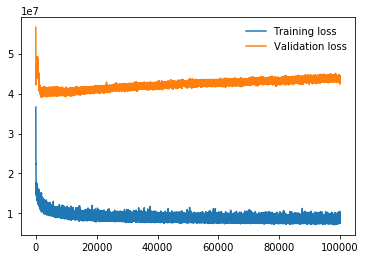

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# loss 0.24 -> 2800
# loss 0.14 -> 3300

In [21]:
test = torch.from_numpy(test.values).float().to(device)

TypeError: expected np.ndarray (got Tensor)

In [ ]:

with torch.no_grad():
    model.eval()
    output = model.forward(test)

output.shape
output.cpu().numpy()

In [ ]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = output.cpu().numpy()
submission.to_csv('submission/DNN_result.csv', index=False)